In [1]:
import os
import re
import random
import hashlib

from enum import Enum
from collections import ChainMap

import numpy as np
import pandas as pd

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from scipy.io import wavfile

import librosa

import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

In [2]:
#########
# Utils #
#########

class SimpleCache(dict):
    def __init__(self, limit):
        super().__init__()
        self.limit = limit
        self.n_keys = 0

    def __setitem__(self, key, value):
        if key in self.keys():
            super().__setitem__(key, value)
        elif self.n_keys < self.limit:
            self.n_keys += 1
            super().__setitem__(key, value)
        return value

class SerializableModule(nn.Module):
    def __init__(self):
        super().__init__()

    def save(self, filename):
        torch.save(self.state_dict(), filename)

    def load(self, filename):
        self.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))

def play_wav(wav_path):
    sample_rate, samples = wavfile.read(wav_path)
    return ipd.Audio(samples, rate=sample_rate)

In [3]:
class DatasetType(Enum):
    TRAIN = 0
    DEV = 1
    TEST = 2

In [4]:
def random_bg_noise(bg_noise):
    lst_of_bg_operations = ['linear_comb', 1, 2, 3, 4]
    choice = random.choice(lst_of_bg_operations)
    if choice == 'linear_comb':
        first_coef = random.uniform(0, 1)
        second_coef = 1-first_coef
        return first_coef * random.choice(bg_noise)[:960000] + second_coef * random.choice(bg_noise)[:960000]
    if choice == 1:
        return random.choice(bg_noise)[:960000]
    if choice == 2:
        return random.choice(bg_noise)[:960000] + random.choice(bg_noise)[:960000]
    if choice == 3:
        return random.choice(bg_noise)[:960000] + random.choice(bg_noise)[:960000] + \
               random.choice(bg_noise)[:960000]
    if choice == 4:
        return random.choice(bg_noise)[:960000] + random.choice(bg_noise)[:960000] + \
               random.choice(bg_noise)[:960000] + random.choice(bg_noise)[:960000]
    

In [5]:
# useful PyTorch abstraction
class SpeechDataset(data.Dataset):
    def __init__(self, data, set_type, config):
        ####
        # data – {wave_file_path : label}
        # set_type – DatasetType (dev, train or test)
        # config.bg_noise_files – will be used to noise wavs during training (see preprocess func)
        ####
        super().__init__()
        self.audio_files = list(data.keys())
        self.audio_labels = list(data.values())
        self.set_type = set_type
        config["bg_noise_files"] = list(filter(lambda x: x.endswith("wav"), config.get("bg_noise_files", [])))
        self.bg_noise_audio = [librosa.core.load(file, sr=16000)[0] for file in config["bg_noise_files"]]
        self.unknown_prob = config["unknown_prob"]
        self.silence_prob = config["silence_prob"]
        self.noise_prob = config["noise_prob"]
        self.n_dct = config["n_dct_filters"]
        self.n_mels = config["n_mels"]
        self.input_length = config["input_length"]
        self.timeshift_ms = config["timeshift_ms"]
        self.filters = librosa.filters.dct(config["n_dct_filters"], config["n_mels"])
        self._audio_cache = SimpleCache(config["cache_size"])
        self._file_cache = SimpleCache(config["cache_size"])
        n_unk = len(list(filter(lambda x: x == 1, self.audio_labels)))
        self.n_silence = int(self.silence_prob * (len(self.audio_labels) - n_unk))
    
    # PyTorch needs this function
    def __getitem__(self, index):
        if index >= len(self.audio_labels):
            return self.preprocess(None, silence=True), 0
        return self.preprocess(self.audio_files[index]), self.audio_labels[index]

    # PyTorch needs this function
    def __len__(self):
        return len(self.audio_labels) + self.n_silence

    # Our extra functions go below:
    def _timeshift_audio(self, data):
        shift = (16000 * self.timeshift_ms) // 1000
        shift = random.randint(-shift, shift)
        a = -min(0, shift)
        b = max(0, shift)
        data = np.pad(data, (a, b), "constant")
        return data[:len(data) - a] if a else data[b:]
    
    def _preprocess_audio(self, data, n_mels, dct_filters):
        data = librosa.feature.melspectrogram(
            data, 
            sr=16000, 
            n_mels=n_mels, 
            hop_length=160, 
            n_fft=480, 
            fmin=20, 
            fmax=4000
        )
        data[data > 0] = np.log(data[data > 0])
        data = [np.matmul(dct_filters, x) for x in np.split(data, data.shape[1], axis=1)]
        data = np.array(data, order="F").squeeze(2).astype(np.float32)
        return data

    def preprocess(self, example, silence=False):
        if silence:
            example = "__silence__"
        if random.random() < 0.7:
            try:
                return self._audio_cache[example]
            except KeyError:
                pass
        
        in_len = self.input_length
        if self.bg_noise_audio:
            # take a random samples chunk of a random noise audio
            bg_noise  =  random_bg_noise(self.bg_noise_audio)
            a = random.randint(0, len(bg_noise) - in_len - 1)
            bg_noise = bg_noise[a:a + in_len]
        else:
            bg_noise = np.zeros(in_len)
        
        use_clean = (self.set_type != DatasetType.TRAIN)
        if use_clean:
            bg_noise = np.zeros(in_len)
        if silence:
            data = np.zeros(in_len, dtype=np.float32)
        else:
            file_data = self._file_cache.get(example)
            data = librosa.core.load(example, sr=16000)[0] if file_data is None else file_data
            self._file_cache[example] = data
        data = np.pad(data, (0, max(0, in_len - len(data))), "constant")
        if not use_clean:
            data = self._timeshift_audio(data)

        if random.random() < self.noise_prob or silence:
            a = random.random() * 0.1
            data = np.clip(a * bg_noise + data, -1, 1)
        data = torch.from_numpy(self._preprocess_audio(data, self.n_mels, self.filters))
        self._audio_cache[example] = data
        return data

### Define config

In [6]:
config = dict(
    data_folder="./../raw_data/train/audio",
    wanted_words="yes no up down left right on off stop go".split(),
    
    seed=0,
    
    output_file="./../models/model_updated_added_noise_mix_extended_40ep.pt", 
    gpu_no=0,
    cache_size=32768,
    
    n_epochs=40,
    momentum=0.9, 
    weight_decay=0.00001,
    lr=[0.1, 0.01, 0.001], 
    schedule=[3000, 6000], 
    batch_size=64, 
    dev_every=1,
    use_nesterov=False,
    
    group_speakers_by_id=True,
    
    silence_prob=0.25,
    noise_prob=0.85,
    unknown_prob=0.25, # percentage of unknown waves in the train/dev/test dataset
    
    input_length=16000,
    timeshift_ms=100,
    # Below are two parameters of Discrete Cosine Transform (http://en.wikipedia.org/wiki/Discrete_cosine_transform)
    n_dct_filters=40, 
    n_mels=40,
    
    train_pct=80,
    dev_pct=10,
    test_pct=10
)

In [7]:
seed = config["seed"]
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

In [8]:
folder = config["data_folder"]
wanted_words = config["wanted_words"]
unknown_prob = config["unknown_prob"]
train_pct = config["train_pct"]
dev_pct = config["dev_pct"]
test_pct = config["test_pct"]

LABEL_UNKNOWN = "__unknown__"
LABEL_SILENCE = "__silence__"

words = {word: i + 2 for i, word in enumerate(wanted_words)}
words.update({LABEL_SILENCE:0, LABEL_UNKNOWN:1})
sets = [{}, {}, {}]  # [train, dev, test] => {wav_name: label}
unknowns = [0] * 3 # number of wavs for each dataset to take from collected unknown waves according to unknown_prob
bg_noise_files = []
unknown_files = []

In [9]:
words

{'__silence__': 0,
 '__unknown__': 1,
 'down': 5,
 'go': 11,
 'left': 6,
 'no': 3,
 'off': 9,
 'on': 8,
 'right': 7,
 'stop': 10,
 'up': 4,
 'yes': 2}

### prep datasets

In [10]:
max_no_wavs = 2**27 - 1

for folder_name in os.listdir(folder):
    print("Process " + folder_name)
    path_name = os.path.join(folder, folder_name)
    is_bg_noise = False
    
    # Skip files
    if os.path.isfile(path_name):
        continue
    
    # Assign the label based on the current folder name
    if folder_name in words:
        label = words[folder_name]
    elif folder_name == "_background_noise_":
        is_bg_noise = True
    else:
        label = words[LABEL_UNKNOWN]

    for filename in os.listdir(path_name):
        wav_name = os.path.join(path_name, filename)
        
        # Just record background noises files and continue
        if is_bg_noise and os.path.isfile(wav_name):
            bg_noise_files.append(wav_name)
            continue
        # collect wav names when label is unknown
        elif label == words[LABEL_UNKNOWN]:
            unknown_files.append(wav_name)
            continue
        
        # Fill sets with {wave_name : label}
        if config["group_speakers_by_id"]:
            hashname = re.sub(r"_nohash_.*$", "", filename)
            bucket = int(hashlib.sha1(hashname.encode()).hexdigest(), 16)
            bucket = (bucket % (max_no_wavs + 1)) * (100. / max_no_wavs)
            if bucket < dev_pct:
                tag = DatasetType.DEV
            elif bucket < test_pct + dev_pct:
                tag = DatasetType.TEST
            else:
                tag = DatasetType.TRAIN
            sets[tag.value][wav_name] = label
        else:
            raise NotImplementedError("Speakers should be grouped for now :/")
            
# Mix in unknown wavs in datasets
# 1: compute how many files should be mixed in each dataset according to unknown_prob
for tag in range(len(sets)):
    unknowns[tag] = int(unknown_prob * len(sets[tag]))

# 2: shuffle unknown files0
random.shuffle(unknown_files)

# 3: update datasets with unknown_files[a:b], where a:b is the interval
a = 0
for tag, dataset in enumerate(sets):
    b = a + unknowns[tag]
    unk_dict = {u: words[LABEL_UNKNOWN] for u in unknown_files[a:b]}
    dataset.update(unk_dict)
    a = b

train_cfg = ChainMap(dict(bg_noise_files=bg_noise_files), config)
test_cfg = ChainMap(dict(noise_prob=0), config)
datasets = (
    SpeechDataset(sets[0], DatasetType.TRAIN, train_cfg), 
    SpeechDataset(sets[1], DatasetType.DEV, test_cfg),
    SpeechDataset(sets[2], DatasetType.TEST, test_cfg)
)

print("Speech dataset created")

Process two
Process five
Process cat
Process four
Process on
Process go
Process no
Process down
Process sheila
Process bed
Process zero
Process one
Process bird
Process three
Process eight
Process house
Process off
Process nine
Process left
Process stop
Process _background_noise_
Process dog
Process happy
Process up
Process tree
Process right
Process six
Process marvin
Process seven
Process wow
Process yes
Speech dataset created


In [11]:
words

{'__silence__': 0,
 '__unknown__': 1,
 'down': 5,
 'go': 11,
 'left': 6,
 'no': 3,
 'off': 9,
 'on': 8,
 'right': 7,
 'stop': 10,
 'up': 4,
 'yes': 2}

(array([ 641.,  256.,  252.,  272.,  253.,  267.,  259.,  246.,  262.,
         249.,  251.]),
 array([  1.        ,   1.90909091,   2.81818182,   3.72727273,
          4.63636364,   5.54545455,   6.45454545,   7.36363636,
          8.27272727,   9.18181818,  10.09090909,  11.        ]),
 <a list of 11 Patch objects>)

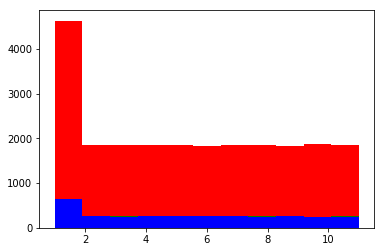

In [12]:
plt.hist(np.array(datasets[0].audio_labels), bins=11, color='r')
plt.hist(np.array(datasets[1].audio_labels), bins=11, color='g')
plt.hist(np.array(datasets[2].audio_labels), bins=11, color='b')

In [13]:
def class_counts(dataset):
    unique_elements, counts_elements = np.unique(datasets[0].audio_labels, return_counts=True)
    return list(zip(unique_elements, counts_elements))

In [14]:
class_counts(datasets[0])

[(1, 4634),
 (2, 1860),
 (3, 1853),
 (4, 1843),
 (5, 1842),
 (6, 1839),
 (7, 1852),
 (8, 1864),
 (9, 1839),
 (10, 1885),
 (11, 1861)]

In [15]:
class_counts(datasets[1])

[(1, 4634),
 (2, 1860),
 (3, 1853),
 (4, 1843),
 (5, 1842),
 (6, 1839),
 (7, 1852),
 (8, 1864),
 (9, 1839),
 (10, 1885),
 (11, 1861)]

In [16]:
class_counts(datasets[2])

[(1, 4634),
 (2, 1860),
 (3, 1853),
 (4, 1843),
 (5, 1842),
 (6, 1839),
 (7, 1852),
 (8, 1864),
 (9, 1839),
 (10, 1885),
 (11, 1861)]

In [13]:
print('Number of silence files in train, dev, test: {0}, {1}, {2}'.format(datasets[0].n_silence,
                                                                          datasets[1].n_silence,
                                                                          datasets[2].n_silence))

Number of silence files in train, dev, test: 4634, 644, 641


In [14]:

train_set, dev_set, test_set = datasets

In [15]:
for d in range(0,5):
    print(len(datasets[0].bg_noise_audio[d]))

988891
978488
960000
980062
1522930


## Training

In [17]:
# https://arxiv.org/pdf/1710.10361.pdf
class SpeechResModel(SerializableModule):
    def __init__(self, config):
        super().__init__()
        n_labels = config["n_labels"]
        n_maps = config["n_feature_maps"]
        self.conv0 = nn.Conv2d(1, n_maps, (3, 3), padding=(1, 1), bias=False)
        if "res_pool" in config:
            self.pool = nn.AvgPool2d(config["res_pool"])

        self.n_layers = n_layers = config["n_layers"]
        dilation = config["use_dilation"]
        if dilation:
            self.convs = [nn.Conv2d(n_maps, n_maps, (3, 3), padding=int(2**(i // 3)), dilation=int(2**(i // 3)), 
                bias=False) for i in range(n_layers)]
        else:
            self.convs = [nn.Conv2d(n_maps, n_maps, (3, 3), padding=1, dilation=1, 
                bias=False) for _ in range(n_layers)]
        for i, conv in enumerate(self.convs):
            self.add_module("bn{}".format(i + 1), nn.BatchNorm2d(n_maps, affine=False))
            self.add_module("conv{}".format(i + 1), conv)
        self.output = nn.Linear(n_maps, n_labels)

    def forward(self, x):
        x = x.unsqueeze(1)
        for i in range(self.n_layers + 1):
            y = F.relu(getattr(self, "conv{}".format(i))(x))
            if i == 0:
                if hasattr(self, "pool"):
                    y = self.pool(y)
                old_x = y
            if i > 0 and i % 2 == 0:
                x = y + old_x
                old_x = x
            else:
                x = y
            if i > 0:
                x = getattr(self, "bn{}".format(i))(x)
        x = x.view(x.size(0), x.size(1), -1) # shape: (batch, feats, o3)
        x = torch.mean(x, 2)
        return self.output(x)

In [18]:
res15 = dict(n_labels=12, use_dilation=True, n_layers=13, n_feature_maps=45)
model = SpeechResModel(res15)

#torch.cuda.set_device(config["gpu_no"])
model.cuda()

SpeechResModel(
  (conv0): Conv2d (1, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv1): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv2): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv3): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv4): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  (bn5): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv5): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  (bn6): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv6): Conv2d (45, 45, 

In [22]:
def print_eval(name, scores, labels, loss, end="\n"):
    batch_size = labels.size(0)
    accuracy = (torch.max(scores, 1)[1].view(batch_size).data == labels.data).sum() / batch_size
    loss = loss.cpu().data.numpy()[0]
    print("{} accuracy: {:>5}, loss: {:<25}".format(name, accuracy, loss), end=end)
    return accuracy

def evaluate(config, model, test_loader):
    #torch.cuda.set_device(config["gpu_no"])
    model.eval()
    criterion = nn.CrossEntropyLoss()
    results = []
    total = 0
    for model_in, labels in test_loader:
        model_in = Variable(model_in, requires_grad=False)
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        scores = model(model_in)
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        results.append(print_eval("test", scores, labels, loss) * model_in.size(0))
        total += model_in.size(0)
    print("final test accuracy: {}".format(sum(results) / total))

In [18]:
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=config["lr"][0], 
    nesterov=config["use_nesterov"], 
    weight_decay=config["weight_decay"], 
    momentum=config["momentum"]
)
schedule_steps = config["schedule"]
schedule_steps.append(np.inf)
sched_idx = 0
criterion = nn.CrossEntropyLoss()
max_acc = 0

train_loader = data.DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, drop_last=True)
dev_loader = data.DataLoader(dev_set, batch_size=min(len(dev_set), 16), shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=min(len(test_set), 16), shuffle=True)
step_no = 0

for epoch_idx in range(config["n_epochs"]):
    for batch_idx, (model_in, labels) in enumerate(train_loader):
        model.train() # sets the model in training mode
        optimizer.zero_grad() # Zero gradients
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        model_in = Variable(model_in, requires_grad=False)
        scores = model(model_in)
        
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        loss.backward() # perform a backward pass
        
        optimizer.step() # and update the weights
        step_no += 1
        if step_no > schedule_steps[sched_idx]:
            sched_idx += 1
            print("changing learning rate to {}".format(config["lr"][sched_idx]))
            optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"][sched_idx],
                nesterov=config["use_nesterov"], momentum=config["momentum"], weight_decay=config["weight_decay"])
        print_eval("train step #{}".format(step_no), scores, labels, loss)

    if epoch_idx % config["dev_every"] == config["dev_every"] - 1:
        model.eval() # sets the model in evaluation mode
        accs = []
        for model_in, labels in dev_loader:
            model_in = Variable(model_in, requires_grad=False)
            model_in = model_in.cuda()
            labels = labels.cuda()
            scores = model(model_in)
            labels = Variable(labels, requires_grad=False)
            loss = criterion(scores, labels)
            loss_numeric = loss.cpu().data.numpy()[0]
            accs.append(print_eval("dev", scores, labels, loss))
        avg_acc = np.mean(accs)
        print("final dev accuracy: {}".format(avg_acc))
        if avg_acc > max_acc:
            print("saving best model...")
            max_acc = avg_acc
            model.save(config["output_file"])
evaluate(config, model, test_loader)

train step #1 accuracy: 0.15625, loss: 2.4166858196258545       
train step #2 accuracy: 0.15625, loss: 2.4170193672180176       
train step #3 accuracy: 0.125, loss: 2.4482343196868896       
train step #4 accuracy: 0.265625, loss: 2.3156118392944336       
train step #5 accuracy: 0.21875, loss: 2.3315842151641846       
train step #6 accuracy: 0.140625, loss: 2.385190486907959        
train step #7 accuracy: 0.15625, loss: 2.367743730545044        
train step #8 accuracy: 0.171875, loss: 2.267937421798706        
train step #9 accuracy: 0.140625, loss: 2.375795841217041        
train step #10 accuracy: 0.1875, loss: 2.383448362350464        
train step #11 accuracy: 0.1875, loss: 2.3201346397399902       
train step #12 accuracy: 0.171875, loss: 2.316873550415039        
train step #13 accuracy: 0.203125, loss: 2.2410881519317627       
train step #14 accuracy: 0.1875, loss: 2.2980902194976807       
train step #15 accuracy: 0.234375, loss: 2.244823694229126        
train step #16 ac

train step #125 accuracy: 0.46875, loss: 1.575000286102295        
train step #126 accuracy: 0.515625, loss: 1.4971922636032104       
train step #127 accuracy: 0.578125, loss: 1.5353209972381592       
train step #128 accuracy: 0.421875, loss: 1.8416324853897095       
train step #129 accuracy: 0.53125, loss: 1.321083664894104        
train step #130 accuracy: 0.59375, loss: 1.5834376811981201       
train step #131 accuracy: 0.484375, loss: 1.6461313962936401       
train step #132 accuracy: 0.453125, loss: 1.6474323272705078       
train step #133 accuracy:   0.5, loss: 1.2488584518432617       
train step #134 accuracy: 0.53125, loss: 1.4111053943634033       
train step #135 accuracy: 0.375, loss: 1.5806785821914673       
train step #136 accuracy: 0.359375, loss: 1.501332402229309        
train step #137 accuracy:   0.5, loss: 1.597652554512024        
train step #138 accuracy: 0.40625, loss: 1.5840685367584229       
train step #139 accuracy: 0.515625, loss: 1.3780993223190308  

train step #248 accuracy: 0.703125, loss: 0.9754438400268555       
train step #249 accuracy: 0.59375, loss: 1.0166951417922974       
train step #250 accuracy: 0.6875, loss: 0.9633515477180481       
train step #251 accuracy: 0.671875, loss: 1.0422821044921875       
train step #252 accuracy: 0.71875, loss: 0.893462061882019        
train step #253 accuracy: 0.71875, loss: 1.080670952796936        
train step #254 accuracy: 0.703125, loss: 0.8914957642555237       
train step #255 accuracy: 0.71875, loss: 0.9599241018295288       
train step #256 accuracy: 0.671875, loss: 0.8897342681884766       
train step #257 accuracy: 0.734375, loss: 0.888016402721405        
train step #258 accuracy: 0.65625, loss: 0.8307133913040161       
train step #259 accuracy: 0.78125, loss: 0.8260138630867004       
train step #260 accuracy: 0.734375, loss: 0.9201169013977051       
train step #261 accuracy: 0.703125, loss: 0.9257657527923584       
train step #262 accuracy: 0.65625, loss: 1.0138839483261

dev accuracy:  0.75, loss: 0.8686404824256897       
dev accuracy: 0.6875, loss: 0.7784233093261719       
dev accuracy: 0.875, loss: 0.6540646553039551       
dev accuracy:  0.75, loss: 0.5596386790275574       
dev accuracy:  0.75, loss: 0.9659954309463501       
dev accuracy: 0.6875, loss: 1.4626352787017822       
dev accuracy: 0.4375, loss: 2.1053566932678223       
dev accuracy:  0.75, loss: 0.9472028017044067       
dev accuracy: 0.625, loss: 1.2657268047332764       
dev accuracy: 0.875, loss: 0.40548276901245117      
dev accuracy: 0.6875, loss: 0.7259553074836731       
dev accuracy: 0.5625, loss: 1.3360137939453125       
dev accuracy:  0.75, loss: 1.3581833839416504       
dev accuracy: 0.625, loss: 1.3969833850860596       
dev accuracy: 0.6875, loss: 1.2054911851882935       
dev accuracy: 0.8125, loss: 0.5966980457305908       
dev accuracy: 0.8125, loss: 0.9752252697944641       
dev accuracy: 0.5625, loss: 1.2988553047180176       
dev accuracy: 0.625, loss: 1.16628098

dev accuracy: 0.8125, loss: 0.7917764782905579       
dev accuracy: 0.5625, loss: 1.5379388332366943       
dev accuracy: 0.5625, loss: 1.5137057304382324       
dev accuracy:   0.5, loss: 1.9293674230575562       
dev accuracy: 0.8125, loss: 0.9410437345504761       
dev accuracy: 0.875, loss: 0.758773148059845        
dev accuracy: 0.6875, loss: 1.266537070274353        
dev accuracy: 0.625, loss: 1.2541520595550537       
dev accuracy:  0.75, loss: 0.8484741449356079       
dev accuracy: 0.6875, loss: 0.9429968595504761       
dev accuracy: 0.5625, loss: 0.8936138153076172       
dev accuracy: 0.6666666666666666, loss: 2.167833089828491        
final dev accuracy: 0.6948024054982819
saving best model...
train step #348 accuracy: 0.796875, loss: 0.6580569744110107       
train step #349 accuracy: 0.703125, loss: 0.8124921321868896       
train step #350 accuracy: 0.71875, loss: 0.8853342533111572       
train step #351 accuracy: 0.8125, loss: 0.4906257092952728       
train step #352

train step #460 accuracy: 0.859375, loss: 0.4573999047279358       
train step #461 accuracy: 0.859375, loss: 0.44658100605010986      
train step #462 accuracy: 0.78125, loss: 0.6960392594337463       
train step #463 accuracy: 0.859375, loss: 0.431601881980896        
train step #464 accuracy: 0.828125, loss: 0.5380725264549255       
train step #465 accuracy: 0.8125, loss: 0.47343674302101135      
train step #466 accuracy: 0.78125, loss: 0.5735329389572144       
train step #467 accuracy: 0.890625, loss: 0.46952730417251587      
train step #468 accuracy: 0.875, loss: 0.425614595413208        
train step #469 accuracy: 0.78125, loss: 0.6276744604110718       
train step #470 accuracy: 0.84375, loss: 0.3839735984802246       
train step #471 accuracy: 0.84375, loss: 0.5008833408355713       
train step #472 accuracy: 0.8125, loss: 0.5736291408538818       
train step #473 accuracy: 0.765625, loss: 0.681739866733551        
train step #474 accuracy: 0.859375, loss: 0.53915935754776  

train step #582 accuracy: 0.6875, loss: 0.8374401330947876       
train step #583 accuracy: 0.84375, loss: 0.4586639702320099       
train step #584 accuracy: 0.78125, loss: 0.7802556753158569       
train step #585 accuracy: 0.828125, loss: 0.6660064458847046       
train step #586 accuracy: 0.84375, loss: 0.5967611074447632       
train step #587 accuracy: 0.890625, loss: 0.3790924549102783       
train step #588 accuracy: 0.84375, loss: 0.563959002494812        
train step #589 accuracy: 0.84375, loss: 0.4866965115070343       
train step #590 accuracy: 0.921875, loss: 0.3427441418170929       
train step #591 accuracy: 0.875, loss: 0.4158511161804199       
train step #592 accuracy: 0.765625, loss: 0.668238639831543        
train step #593 accuracy: 0.84375, loss: 0.5678425431251526       
train step #594 accuracy: 0.828125, loss: 0.6606869101524353       
train step #595 accuracy: 0.875, loss: 0.49963104724884033      
train step #596 accuracy: 0.875, loss: 0.6129793524742126     

dev accuracy: 0.6875, loss: 0.7136424779891968       
dev accuracy:  0.75, loss: 0.49649757146835327      
dev accuracy: 0.875, loss: 0.27457794547080994      
dev accuracy: 0.8125, loss: 0.4176241457462311       
dev accuracy:   1.0, loss: 0.13169875741004944      
dev accuracy: 0.875, loss: 0.3799692988395691       
dev accuracy: 0.8125, loss: 0.755986213684082        
dev accuracy: 0.6875, loss: 0.6771891713142395       
dev accuracy: 0.9375, loss: 0.21792170405387878      
dev accuracy: 0.6875, loss: 0.6708292365074158       
dev accuracy:  0.75, loss: 0.5561701059341431       
dev accuracy:  0.75, loss: 0.9953650832176208       
dev accuracy:  0.75, loss: 0.6956167221069336       
dev accuracy: 0.6875, loss: 1.1090986728668213       
dev accuracy: 0.875, loss: 0.35616302490234375      
dev accuracy: 0.8125, loss: 0.7206680178642273       
dev accuracy: 0.5625, loss: 0.7781227231025696       
dev accuracy:  0.75, loss: 0.7511921525001526       
dev accuracy:  0.75, loss: 0.63975226

dev accuracy: 0.625, loss: 0.6611537933349609       
dev accuracy: 0.8125, loss: 0.5698322057723999       
dev accuracy: 0.8125, loss: 0.46503156423568726      
dev accuracy:  0.75, loss: 0.5911668539047241       
dev accuracy:  0.75, loss: 0.9074714779853821       
dev accuracy: 0.9375, loss: 0.25037306547164917      
dev accuracy: 0.8125, loss: 0.4387167692184448       
dev accuracy:   0.5, loss: 1.348689317703247        
dev accuracy:   0.5, loss: 1.4420428276062012       
dev accuracy: 0.5625, loss: 0.7054399251937866       
dev accuracy: 0.6875, loss: 0.5484091639518738       
dev accuracy: 0.6875, loss: 0.7132227420806885       
dev accuracy: 0.875, loss: 0.5076432824134827       
dev accuracy:  0.75, loss: 0.6287288665771484       
dev accuracy:  0.75, loss: 0.59633868932724         
dev accuracy: 0.6875, loss: 0.5487594604492188       
dev accuracy:  0.75, loss: 0.7911934852600098       
dev accuracy: 0.625, loss: 0.5594896078109741       
dev accuracy: 0.8125, loss: 0.59956294

train step #796 accuracy: 0.90625, loss: 0.3439745008945465       
train step #797 accuracy: 0.890625, loss: 0.3526357412338257       
train step #798 accuracy: 0.890625, loss: 0.42174437642097473      
train step #799 accuracy: 0.8125, loss: 0.6574730277061462       
train step #800 accuracy: 0.890625, loss: 0.36195558309555054      
train step #801 accuracy: 0.8125, loss: 0.5010038018226624       
train step #802 accuracy: 0.9375, loss: 0.22632017731666565      
train step #803 accuracy: 0.890625, loss: 0.31657078862190247      
train step #804 accuracy: 0.828125, loss: 0.6305721998214722       
train step #805 accuracy: 0.84375, loss: 0.5259356498718262       
train step #806 accuracy: 0.890625, loss: 0.32918721437454224      
train step #807 accuracy: 0.9375, loss: 0.17893099784851074      
train step #808 accuracy: 0.90625, loss: 0.36129385232925415      
train step #809 accuracy: 0.90625, loss: 0.43176886439323425      
train step #810 accuracy: 0.859375, loss: 0.4068033397197723

train step #919 accuracy: 0.84375, loss: 0.377459853887558        
train step #920 accuracy: 0.953125, loss: 0.20378252863883972      
train step #921 accuracy: 0.828125, loss: 0.5357474088668823       
train step #922 accuracy: 0.890625, loss: 0.25025099515914917      
train step #923 accuracy: 0.890625, loss: 0.3304244875907898       
train step #924 accuracy: 0.859375, loss: 0.39602571725845337      
train step #925 accuracy: 0.84375, loss: 0.41440504789352417      
train step #926 accuracy: 0.890625, loss: 0.42753705382347107      
train step #927 accuracy: 0.84375, loss: 0.36559537053108215      
train step #928 accuracy: 0.875, loss: 0.4110303521156311       
train step #929 accuracy: 0.90625, loss: 0.30461177229881287      
train step #930 accuracy: 0.890625, loss: 0.46307864785194397      
train step #931 accuracy: 0.90625, loss: 0.3471100628376007       
train step #932 accuracy: 0.890625, loss: 0.37452393770217896      
train step #933 accuracy: 0.890625, loss: 0.512181699275

train step #1041 accuracy: 0.9375, loss: 0.31773680448532104      
dev accuracy: 0.9375, loss: 0.2107924520969391       
dev accuracy: 0.9375, loss: 0.11356036365032196      
dev accuracy: 0.8125, loss: 0.5371849536895752       
dev accuracy: 0.9375, loss: 0.15200181305408478      
dev accuracy: 0.9375, loss: 0.1956246793270111       
dev accuracy: 0.875, loss: 0.42577776312828064      
dev accuracy: 0.8125, loss: 0.5903468728065491       
dev accuracy: 0.875, loss: 0.29366534948349         
dev accuracy: 0.9375, loss: 0.17325559258460999      
dev accuracy: 0.8125, loss: 0.6383694410324097       
dev accuracy: 0.8125, loss: 0.5380561351776123       
dev accuracy: 0.6875, loss: 0.5536463260650635       
dev accuracy: 0.8125, loss: 0.6311780214309692       
dev accuracy:   1.0, loss: 0.07439255714416504      
dev accuracy: 0.8125, loss: 0.3223722279071808       
dev accuracy: 0.875, loss: 0.3209226131439209       
dev accuracy: 0.9375, loss: 0.13476736843585968      
dev accuracy: 0.875

dev accuracy: 0.875, loss: 0.2729962468147278       
dev accuracy: 0.9375, loss: 0.18352702260017395      
dev accuracy: 0.8125, loss: 0.7164283394813538       
dev accuracy: 0.875, loss: 0.5986818075180054       
dev accuracy:   1.0, loss: 0.17982757091522217      
dev accuracy: 0.9375, loss: 0.23446887731552124      
dev accuracy: 0.875, loss: 0.5204790830612183       
dev accuracy: 0.9375, loss: 0.2683367133140564       
dev accuracy: 0.9375, loss: 0.26935088634490967      
dev accuracy: 0.9375, loss: 0.23970773816108704      
dev accuracy:  0.75, loss: 0.6350099444389343       
dev accuracy: 0.9375, loss: 0.19739699363708496      
dev accuracy:  0.75, loss: 0.7664484977722168       
dev accuracy: 0.875, loss: 0.3865320682525635       
dev accuracy: 0.875, loss: 0.3280736207962036       
dev accuracy: 0.9375, loss: 0.27638542652130127      
dev accuracy: 0.8125, loss: 0.3981115520000458       
dev accuracy: 0.9375, loss: 0.1956363171339035       
dev accuracy: 0.9375, loss: 0.359034

train step #1130 accuracy: 0.9375, loss: 0.297157347202301        
train step #1131 accuracy: 0.984375, loss: 0.2072283774614334       
train step #1132 accuracy: 0.921875, loss: 0.21306172013282776      
train step #1133 accuracy: 0.890625, loss: 0.3912861943244934       
train step #1134 accuracy: 0.875, loss: 0.40143051743507385      
train step #1135 accuracy: 0.921875, loss: 0.344358891248703        
train step #1136 accuracy: 0.921875, loss: 0.3245757818222046       
train step #1137 accuracy: 0.859375, loss: 0.3979490399360657       
train step #1138 accuracy: 0.828125, loss: 0.4434282183647156       
train step #1139 accuracy: 0.890625, loss: 0.4282112419605255       
train step #1140 accuracy: 0.953125, loss: 0.2576376497745514       
train step #1141 accuracy: 0.890625, loss: 0.26008284091949463      
train step #1142 accuracy: 0.890625, loss: 0.3063751459121704       
train step #1143 accuracy: 0.875, loss: 0.41065114736557007      
train step #1144 accuracy: 0.875, loss: 0.

train step #1251 accuracy: 0.84375, loss: 0.6937105059623718       
train step #1252 accuracy: 0.875, loss: 0.4726372957229614       
train step #1253 accuracy: 0.84375, loss: 0.3731682002544403       
train step #1254 accuracy: 0.90625, loss: 0.31730106472969055      
train step #1255 accuracy: 0.90625, loss: 0.22984372079372406      
train step #1256 accuracy: 0.9375, loss: 0.2556677460670471       
train step #1257 accuracy: 0.875, loss: 0.42842668294906616      
train step #1258 accuracy: 0.84375, loss: 0.34029147028923035      
train step #1259 accuracy: 0.90625, loss: 0.32019346952438354      
train step #1260 accuracy: 0.9375, loss: 0.24302928149700165      
train step #1261 accuracy: 0.890625, loss: 0.42531901597976685      
train step #1262 accuracy: 0.875, loss: 0.37383872270584106      
train step #1263 accuracy: 0.953125, loss: 0.2187270224094391       
train step #1264 accuracy: 0.875, loss: 0.3978819251060486       
train step #1265 accuracy: 0.96875, loss: 0.208700299263

train step #1372 accuracy: 0.90625, loss: 0.2881331145763397       
train step #1373 accuracy: 0.890625, loss: 0.3609393239021301       
train step #1374 accuracy: 0.921875, loss: 0.3553011417388916       
train step #1375 accuracy: 0.890625, loss: 0.3855002820491791       
train step #1376 accuracy: 0.90625, loss: 0.3660268783569336       
train step #1377 accuracy: 0.828125, loss: 0.5113732814788818       
train step #1378 accuracy: 0.921875, loss: 0.3879283666610718       
train step #1379 accuracy: 0.90625, loss: 0.4648803174495697       
train step #1380 accuracy: 0.890625, loss: 0.2923007011413574       
train step #1381 accuracy: 0.921875, loss: 0.32587307691574097      
train step #1382 accuracy: 0.90625, loss: 0.39457523822784424      
train step #1383 accuracy: 0.875, loss: 0.3980308175086975       
train step #1384 accuracy: 0.921875, loss: 0.2773701846599579       
train step #1385 accuracy: 0.875, loss: 0.37426286935806274      
train step #1386 accuracy: 0.90625, loss: 0.

dev accuracy: 0.9375, loss: 0.1359073519706726       
dev accuracy: 0.9375, loss: 0.16279417276382446      
dev accuracy: 0.9375, loss: 0.19982683658599854      
dev accuracy: 0.8125, loss: 0.6928271055221558       
dev accuracy: 0.9375, loss: 0.17287129163742065      
dev accuracy: 0.9375, loss: 0.20688623189926147      
dev accuracy: 0.875, loss: 0.645065188407898        
dev accuracy: 0.9375, loss: 0.12517696619033813      
dev accuracy: 0.9375, loss: 0.18547487258911133      
dev accuracy: 0.9375, loss: 0.33731481432914734      
dev accuracy: 0.9375, loss: 0.3032906949520111       
dev accuracy: 0.875, loss: 0.27595579624176025      
dev accuracy: 0.875, loss: 0.2722974419593811       
dev accuracy: 0.9375, loss: 0.15714949369430542      
dev accuracy: 0.875, loss: 0.3952632546424866       
dev accuracy: 0.875, loss: 0.2402048259973526       
dev accuracy: 0.6875, loss: 1.1062393188476562       
dev accuracy:   1.0, loss: 0.1185966432094574       
dev accuracy: 0.875, loss: 0.39744

train step #1462 accuracy: 0.953125, loss: 0.16771182417869568      
train step #1463 accuracy: 0.90625, loss: 0.29749995470046997      
train step #1464 accuracy: 0.859375, loss: 0.3986597955226898       
train step #1465 accuracy: 0.90625, loss: 0.2415972650051117       
train step #1466 accuracy: 0.84375, loss: 0.3917395770549774       
train step #1467 accuracy: 0.9375, loss: 0.2562599182128906       
train step #1468 accuracy: 0.90625, loss: 0.2998310327529907       
train step #1469 accuracy: 0.828125, loss: 0.49007993936538696      
train step #1470 accuracy: 0.921875, loss: 0.2852628529071808       
train step #1471 accuracy: 0.9375, loss: 0.2608853876590729       
train step #1472 accuracy: 0.890625, loss: 0.33381375670433044      
train step #1473 accuracy: 0.9375, loss: 0.2097686380147934       
train step #1474 accuracy: 0.921875, loss: 0.22133289277553558      
train step #1475 accuracy: 0.890625, loss: 0.3465174436569214       
train step #1476 accuracy: 0.9375, loss: 0.3

train step #1583 accuracy: 0.96875, loss: 0.17859631776809692      
train step #1584 accuracy: 0.875, loss: 0.3238361179828644       
train step #1585 accuracy: 0.90625, loss: 0.24426117539405823      
train step #1586 accuracy: 0.921875, loss: 0.2078503519296646       
train step #1587 accuracy: 0.96875, loss: 0.16833704710006714      
train step #1588 accuracy: 0.9375, loss: 0.2416764497756958       
train step #1589 accuracy: 0.953125, loss: 0.22485202550888062      
train step #1590 accuracy: 0.875, loss: 0.40479063987731934      
train step #1591 accuracy: 0.984375, loss: 0.06775607168674469      
train step #1592 accuracy: 0.875, loss: 0.44593799114227295      
train step #1593 accuracy: 0.90625, loss: 0.25459936261177063      
train step #1594 accuracy: 0.96875, loss: 0.20564691722393036      
train step #1595 accuracy: 0.90625, loss: 0.3486214876174927       
train step #1596 accuracy: 0.921875, loss: 0.27124470472335815      
train step #1597 accuracy: 0.921875, loss: 0.263015

train step #1704 accuracy: 0.90625, loss: 0.2314499020576477       
train step #1705 accuracy: 0.890625, loss: 0.3479393720626831       
train step #1706 accuracy: 0.921875, loss: 0.2564306855201721       
train step #1707 accuracy: 0.875, loss: 0.35808664560317993      
train step #1708 accuracy: 0.9375, loss: 0.19986015558242798      
train step #1709 accuracy: 0.9375, loss: 0.1677972972393036       
train step #1710 accuracy: 0.96875, loss: 0.14904040098190308      
train step #1711 accuracy: 0.875, loss: 0.46107596158981323      
train step #1712 accuracy: 0.90625, loss: 0.3210833668708801       
train step #1713 accuracy: 0.921875, loss: 0.30528104305267334      
train step #1714 accuracy: 0.9375, loss: 0.18661752343177795      
train step #1715 accuracy: 0.921875, loss: 0.2970163822174072       
train step #1716 accuracy: 0.90625, loss: 0.3582754135131836       
train step #1717 accuracy: 0.90625, loss: 0.35908588767051697      
train step #1718 accuracy: 0.90625, loss: 0.2645251

dev accuracy: 0.9375, loss: 0.2747463583946228       
dev accuracy: 0.875, loss: 0.4432345926761627       
dev accuracy: 0.9375, loss: 0.260792076587677        
dev accuracy: 0.875, loss: 0.2121848165988922       
dev accuracy: 0.9375, loss: 0.32555529475212097      
dev accuracy: 0.875, loss: 0.42351728677749634      
dev accuracy: 0.9375, loss: 0.1011822521686554       
dev accuracy:   1.0, loss: 0.057206541299819946     
dev accuracy: 0.9375, loss: 0.1566188931465149       
dev accuracy: 0.8125, loss: 0.5184171199798584       
dev accuracy: 0.9375, loss: 0.1470356285572052       
dev accuracy: 0.9375, loss: 0.12032723426818848      
dev accuracy:  0.75, loss: 0.5716360807418823       
dev accuracy: 0.9375, loss: 0.19546663761138916      
dev accuracy: 0.9375, loss: 0.48577019572257996      
dev accuracy: 0.9375, loss: 0.33281001448631287      
dev accuracy: 0.875, loss: 0.23454663157463074      
dev accuracy: 0.9375, loss: 0.5075783729553223       
dev accuracy: 0.8125, loss: 0.8277

train step #1794 accuracy: 0.921875, loss: 0.32182061672210693      
train step #1795 accuracy: 0.9375, loss: 0.2049018144607544       
train step #1796 accuracy: 0.890625, loss: 0.30085060000419617      
train step #1797 accuracy: 0.828125, loss: 0.5054449439048767       
train step #1798 accuracy: 0.984375, loss: 0.11563366651535034      
train step #1799 accuracy: 0.90625, loss: 0.3102363646030426       
train step #1800 accuracy: 0.984375, loss: 0.11302287876605988      
train step #1801 accuracy: 0.9375, loss: 0.19652211666107178      
train step #1802 accuracy: 0.96875, loss: 0.24551789462566376      
train step #1803 accuracy: 0.921875, loss: 0.2782362997531891       
train step #1804 accuracy: 0.921875, loss: 0.3019092082977295       
train step #1805 accuracy: 0.953125, loss: 0.165050208568573        
train step #1806 accuracy: 0.921875, loss: 0.2341230809688568       
train step #1807 accuracy: 0.921875, loss: 0.3339996337890625       
train step #1808 accuracy: 0.921875, los

train step #1915 accuracy: 0.90625, loss: 0.2929912805557251       
train step #1916 accuracy: 0.953125, loss: 0.3232107162475586       
train step #1917 accuracy: 0.953125, loss: 0.15702003240585327      
train step #1918 accuracy: 0.890625, loss: 0.28899890184402466      
train step #1919 accuracy: 0.9375, loss: 0.23098304867744446      
train step #1920 accuracy: 0.890625, loss: 0.28795814514160156      
train step #1921 accuracy: 0.9375, loss: 0.12212816625833511      
train step #1922 accuracy: 0.921875, loss: 0.2190139889717102       
train step #1923 accuracy: 0.984375, loss: 0.08810657262802124      
train step #1924 accuracy: 0.9375, loss: 0.24090389907360077      
train step #1925 accuracy: 0.9375, loss: 0.25660964846611023      
train step #1926 accuracy: 0.953125, loss: 0.12439354509115219      
train step #1927 accuracy: 0.921875, loss: 0.20786279439926147      
train step #1928 accuracy: 0.96875, loss: 0.11744231730699539      
train step #1929 accuracy: 0.921875, loss: 0

train step #2036 accuracy: 0.9375, loss: 0.3082299828529358       
train step #2037 accuracy: 0.890625, loss: 0.3004682660102844       
train step #2038 accuracy: 0.921875, loss: 0.2882697582244873       
train step #2039 accuracy: 0.90625, loss: 0.2756774425506592       
train step #2040 accuracy: 0.890625, loss: 0.40136975049972534      
train step #2041 accuracy: 0.90625, loss: 0.36826393008232117      
train step #2042 accuracy: 0.859375, loss: 0.3226414620876312       
train step #2043 accuracy: 0.953125, loss: 0.22364281117916107      
train step #2044 accuracy: 0.9375, loss: 0.21395443379878998      
train step #2045 accuracy: 0.890625, loss: 0.3436051607131958       
train step #2046 accuracy: 0.890625, loss: 0.3264002203941345       
train step #2047 accuracy: 0.9375, loss: 0.20510759949684143      
train step #2048 accuracy: 0.921875, loss: 0.24226300418376923      
train step #2049 accuracy: 0.96875, loss: 0.11260858178138733      
train step #2050 accuracy: 0.90625, loss: 0

dev accuracy: 0.9375, loss: 0.16022104024887085      
dev accuracy: 0.9375, loss: 0.1765138953924179       
dev accuracy:   1.0, loss: 0.034627765417099        
dev accuracy: 0.875, loss: 0.45841869711875916      
dev accuracy: 0.875, loss: 0.4571373462677002       
dev accuracy: 0.875, loss: 0.35541534423828125      
dev accuracy: 0.9375, loss: 0.06744828820228577      
dev accuracy:   1.0, loss: 0.013861864805221558     
dev accuracy: 0.875, loss: 0.4923785328865051       
dev accuracy:   1.0, loss: 0.021566182374954224     
dev accuracy: 0.9375, loss: 0.17237180471420288      
dev accuracy: 0.8125, loss: 0.45321470499038696      
dev accuracy: 0.9375, loss: 0.16502830386161804      
dev accuracy: 0.875, loss: 0.45837855339050293      
dev accuracy: 0.8125, loss: 0.8363240361213684       
dev accuracy:   1.0, loss: 0.07266369462013245      
dev accuracy: 0.9375, loss: 0.4546527862548828       
dev accuracy: 0.875, loss: 0.4023423492908478       
dev accuracy:   1.0, loss: 0.048324704

train step #2126 accuracy: 0.984375, loss: 0.07855372130870819      
train step #2127 accuracy: 0.984375, loss: 0.07332104444503784      
train step #2128 accuracy: 0.921875, loss: 0.1723693311214447       
train step #2129 accuracy: 0.90625, loss: 0.32091107964515686      
train step #2130 accuracy: 0.984375, loss: 0.13316109776496887      
train step #2131 accuracy: 0.984375, loss: 0.10351961851119995      
train step #2132 accuracy: 0.921875, loss: 0.3045598268508911       
train step #2133 accuracy: 0.9375, loss: 0.19365155696868896      
train step #2134 accuracy: 0.921875, loss: 0.24008703231811523      
train step #2135 accuracy: 0.953125, loss: 0.21454688906669617      
train step #2136 accuracy: 0.96875, loss: 0.1836165338754654       
train step #2137 accuracy: 0.984375, loss: 0.10248658061027527      
train step #2138 accuracy: 0.9375, loss: 0.20497485995292664      
train step #2139 accuracy: 0.953125, loss: 0.18881960213184357      
train step #2140 accuracy: 0.890625, los

train step #2247 accuracy: 0.953125, loss: 0.22787444293498993      
train step #2248 accuracy: 0.9375, loss: 0.2611473500728607       
train step #2249 accuracy: 0.953125, loss: 0.1469671130180359       
train step #2250 accuracy: 0.953125, loss: 0.16990968585014343      
train step #2251 accuracy: 0.859375, loss: 0.440241277217865        
train step #2252 accuracy: 0.9375, loss: 0.20602305233478546      
train step #2253 accuracy: 0.9375, loss: 0.24751585721969604      
train step #2254 accuracy: 0.90625, loss: 0.2950107455253601       
train step #2255 accuracy: 0.890625, loss: 0.3252515494823456       
train step #2256 accuracy: 0.9375, loss: 0.27625197172164917      
train step #2257 accuracy: 0.96875, loss: 0.14398393034934998      
train step #2258 accuracy: 0.90625, loss: 0.220323383808136        
train step #2259 accuracy: 0.96875, loss: 0.16905465722084045      
train step #2260 accuracy: 0.921875, loss: 0.33321231603622437      
train step #2261 accuracy: 0.9375, loss: 0.195

train step #2368 accuracy:   1.0, loss: 0.10890983045101166      
train step #2369 accuracy: 0.90625, loss: 0.35599955916404724      
train step #2370 accuracy:   1.0, loss: 0.04594803601503372      
train step #2371 accuracy: 0.9375, loss: 0.2191418558359146       
train step #2372 accuracy: 0.984375, loss: 0.09582839161157608      
train step #2373 accuracy: 0.96875, loss: 0.16360019147396088      
train step #2374 accuracy: 0.96875, loss: 0.1065068244934082       
train step #2375 accuracy: 0.921875, loss: 0.21176761388778687      
train step #2376 accuracy: 0.9375, loss: 0.25519299507141113      
train step #2377 accuracy: 0.96875, loss: 0.14333167672157288      
train step #2378 accuracy: 0.96875, loss: 0.13058869540691376      
train step #2379 accuracy: 0.859375, loss: 0.3536001443862915       
train step #2380 accuracy: 0.875, loss: 0.4420469403266907       
train step #2381 accuracy: 0.90625, loss: 0.419009804725647        
train step #2382 accuracy: 0.9375, loss: 0.1872115880

dev accuracy: 0.8125, loss: 0.496683806180954        
dev accuracy: 0.8125, loss: 0.5870594382286072       
dev accuracy: 0.875, loss: 0.40372735261917114      
dev accuracy:   1.0, loss: 0.12425018846988678      
dev accuracy: 0.8125, loss: 0.37845247983932495      
dev accuracy: 0.9375, loss: 0.12837684154510498      
dev accuracy: 0.875, loss: 0.2727040946483612       
dev accuracy:  0.75, loss: 0.44639894366264343      
dev accuracy:   1.0, loss: 0.0992283970117569       
dev accuracy:   1.0, loss: 0.06978967785835266      
dev accuracy: 0.875, loss: 0.2157241255044937       
dev accuracy: 0.875, loss: 0.41837161779403687      
dev accuracy: 0.875, loss: 0.3056359589099884       
dev accuracy: 0.9375, loss: 0.11966373026371002      
dev accuracy:   1.0, loss: 0.0841534435749054       
dev accuracy: 0.8125, loss: 0.8188635110855103       
dev accuracy: 0.8125, loss: 0.41113078594207764      
dev accuracy: 0.9375, loss: 0.2586551308631897       
dev accuracy:  0.75, loss: 0.856029033

train step #2458 accuracy: 0.9375, loss: 0.11994818598031998      
train step #2459 accuracy: 0.90625, loss: 0.3643437922000885       
train step #2460 accuracy: 0.984375, loss: 0.13644623756408691      
train step #2461 accuracy: 0.828125, loss: 0.3966781497001648       
train step #2462 accuracy: 0.875, loss: 0.3957943022251129       
train step #2463 accuracy: 0.96875, loss: 0.09669164568185806      
train step #2464 accuracy: 0.90625, loss: 0.25510042905807495      
train step #2465 accuracy: 0.9375, loss: 0.22044391930103302      
train step #2466 accuracy: 0.96875, loss: 0.16068899631500244      
train step #2467 accuracy: 0.921875, loss: 0.23227393627166748      
train step #2468 accuracy: 0.921875, loss: 0.27878594398498535      
train step #2469 accuracy: 0.921875, loss: 0.22649574279785156      
train step #2470 accuracy: 0.90625, loss: 0.2987156808376312       
train step #2471 accuracy: 0.953125, loss: 0.1318824589252472       
train step #2472 accuracy: 0.921875, loss: 0.3

train step #2578 accuracy: 0.96875, loss: 0.2021782100200653       
train step #2579 accuracy: 0.921875, loss: 0.25603097677230835      
train step #2580 accuracy: 0.90625, loss: 0.3736438751220703       
train step #2581 accuracy: 0.875, loss: 0.39386770129203796      
train step #2582 accuracy: 0.953125, loss: 0.16907568275928497      
train step #2583 accuracy: 0.96875, loss: 0.08888091892004013      
train step #2584 accuracy: 0.953125, loss: 0.16873405873775482      
train step #2585 accuracy: 0.96875, loss: 0.10208328068256378      
train step #2586 accuracy: 0.9375, loss: 0.14604033529758453      
train step #2587 accuracy: 0.96875, loss: 0.14419986307621002      
train step #2588 accuracy: 0.953125, loss: 0.1463852822780609       
train step #2589 accuracy: 0.921875, loss: 0.19507889449596405      
train step #2590 accuracy: 0.953125, loss: 0.19185885787010193      
train step #2591 accuracy: 0.984375, loss: 0.10350127518177032      
train step #2592 accuracy: 0.953125, loss: 0

train step #2699 accuracy: 0.953125, loss: 0.11148876696825027      
train step #2700 accuracy: 0.90625, loss: 0.2619493007659912       
train step #2701 accuracy: 0.921875, loss: 0.20129796862602234      
train step #2702 accuracy: 0.90625, loss: 0.28722432255744934      
train step #2703 accuracy: 0.953125, loss: 0.12025776505470276      
train step #2704 accuracy: 0.9375, loss: 0.23010164499282837      
train step #2705 accuracy:   1.0, loss: 0.024487338960170746     
train step #2706 accuracy:   1.0, loss: 0.05801771953701973      
train step #2707 accuracy: 0.953125, loss: 0.1945231705904007       
train step #2708 accuracy: 0.90625, loss: 0.27298638224601746      
train step #2709 accuracy: 0.953125, loss: 0.17678774893283844      
train step #2710 accuracy: 0.90625, loss: 0.2926618456840515       
train step #2711 accuracy: 0.953125, loss: 0.21037304401397705      
train step #2712 accuracy: 0.96875, loss: 0.16881045699119568      
train step #2713 accuracy: 0.984375, loss: 0.13

dev accuracy: 0.8125, loss: 0.3756662607192993       
dev accuracy:  0.75, loss: 0.9991486072540283       
dev accuracy:   1.0, loss: 0.001137852668762207     
dev accuracy:   1.0, loss: 0.00954475998878479      
dev accuracy: 0.9375, loss: 0.1637965440750122       
dev accuracy: 0.875, loss: 0.7082380056381226       
dev accuracy:   1.0, loss: 0.06159977614879608      
dev accuracy: 0.9375, loss: 0.15642881393432617      
dev accuracy:   1.0, loss: 0.035644739866256714     
dev accuracy: 0.9375, loss: 0.2572396993637085       
dev accuracy: 0.8125, loss: 0.4021203815937042       
dev accuracy: 0.9375, loss: 0.2886715531349182       
dev accuracy:   1.0, loss: 0.07004064321517944      
dev accuracy: 0.875, loss: 0.372780442237854        
dev accuracy:   1.0, loss: 0.08556300401687622      
dev accuracy: 0.9375, loss: 0.147501602768898        
dev accuracy: 0.9375, loss: 0.09518836438655853      
dev accuracy: 0.9375, loss: 0.1471022367477417       
dev accuracy: 0.875, loss: 0.60541087

train step #2789 accuracy: 0.96875, loss: 0.0984908938407898       
train step #2790 accuracy: 0.9375, loss: 0.1883116364479065       
train step #2791 accuracy: 0.890625, loss: 0.3536500334739685       
train step #2792 accuracy: 0.953125, loss: 0.20458242297172546      
train step #2793 accuracy: 0.921875, loss: 0.24545688927173615      
train step #2794 accuracy: 0.9375, loss: 0.3861457109451294       
train step #2795 accuracy: 0.9375, loss: 0.23223966360092163      
train step #2796 accuracy: 0.90625, loss: 0.3382059335708618       
train step #2797 accuracy: 0.96875, loss: 0.1309560388326645       
train step #2798 accuracy: 0.953125, loss: 0.14127416908740997      
train step #2799 accuracy: 0.953125, loss: 0.2522929906845093       
train step #2800 accuracy: 0.96875, loss: 0.1108960211277008       
train step #2801 accuracy: 0.9375, loss: 0.19714613258838654      
train step #2802 accuracy: 0.96875, loss: 0.1638128161430359       
train step #2803 accuracy: 0.96875, loss: 0.160

train step #2910 accuracy: 0.953125, loss: 0.16418597102165222      
train step #2911 accuracy: 0.984375, loss: 0.040925100445747375     
train step #2912 accuracy: 0.96875, loss: 0.10947877913713455      
train step #2913 accuracy: 0.984375, loss: 0.14155536890029907      
train step #2914 accuracy:   1.0, loss: 0.051513444632291794     
train step #2915 accuracy: 0.9375, loss: 0.3743276596069336       
train step #2916 accuracy: 0.90625, loss: 0.3441736400127411       
train step #2917 accuracy: 0.984375, loss: 0.11743244528770447      
train step #2918 accuracy: 0.984375, loss: 0.07126525789499283      
train step #2919 accuracy: 0.953125, loss: 0.16786319017410278      
train step #2920 accuracy: 0.953125, loss: 0.17325636744499207      
train step #2921 accuracy: 0.953125, loss: 0.18187333643436432      
train step #2922 accuracy: 0.9375, loss: 0.23330146074295044      
train step #2923 accuracy: 0.953125, loss: 0.1833091676235199       
train step #2924 accuracy: 0.953125, loss: 

train step #3030 accuracy: 0.984375, loss: 0.07024721801280975      
train step #3031 accuracy: 0.859375, loss: 0.48758286237716675      
train step #3032 accuracy: 0.96875, loss: 0.15504008531570435      
train step #3033 accuracy:   1.0, loss: 0.04415430873632431      
train step #3034 accuracy: 0.890625, loss: 0.3807827830314636       
train step #3035 accuracy: 0.9375, loss: 0.12666332721710205      
train step #3036 accuracy: 0.984375, loss: 0.07331044971942902      
train step #3037 accuracy: 0.953125, loss: 0.1119675263762474       
train step #3038 accuracy: 0.9375, loss: 0.18665240705013275      
train step #3039 accuracy: 0.96875, loss: 0.1505090296268463       
train step #3040 accuracy: 0.953125, loss: 0.10769251734018326      
train step #3041 accuracy: 0.984375, loss: 0.04631147161126137      
train step #3042 accuracy: 0.9375, loss: 0.2410842925310135       
train step #3043 accuracy: 0.890625, loss: 0.4056430459022522       
train step #3044 accuracy: 0.984375, loss: 0.

dev accuracy:   1.0, loss: 0.005918383598327637     
dev accuracy: 0.9375, loss: 0.40760549902915955      
dev accuracy: 0.9375, loss: 0.24198812246322632      
dev accuracy: 0.8125, loss: 0.6362870931625366       
dev accuracy:   1.0, loss: 0.0540241003036499       
dev accuracy: 0.9375, loss: 0.1597823053598404       
dev accuracy:   1.0, loss: 0.13213542103767395      
dev accuracy: 0.9375, loss: 0.30045726895332336      
dev accuracy: 0.875, loss: 0.497314453125           
dev accuracy: 0.9375, loss: 0.2612522542476654       
dev accuracy: 0.8125, loss: 0.42846083641052246      
dev accuracy:   1.0, loss: 0.09704753756523132      
dev accuracy:   1.0, loss: 0.05816572904586792      
dev accuracy:   1.0, loss: 0.03840753436088562      
dev accuracy: 0.9375, loss: 0.20265983045101166      
dev accuracy:   1.0, loss: 0.010460346937179565     
dev accuracy: 0.875, loss: 0.4024740755558014       
dev accuracy: 0.9375, loss: 0.11600440740585327      
dev accuracy: 0.9375, loss: 0.2428036

dev accuracy: 0.9375, loss: 0.07905498147010803      
dev accuracy:   1.0, loss: 0.02980363368988037      
dev accuracy:   1.0, loss: 0.006296475883573294     
final dev accuracy: 0.9455541237113402
saving best model...
train step #3124 accuracy: 0.953125, loss: 0.16368161141872406      
train step #3125 accuracy: 0.953125, loss: 0.14446938037872314      
train step #3126 accuracy: 0.984375, loss: 0.0707513839006424       
train step #3127 accuracy: 0.921875, loss: 0.11884909868240356      
train step #3128 accuracy:   1.0, loss: 0.03248029202222824      
train step #3129 accuracy: 0.890625, loss: 0.3355921804904938       
train step #3130 accuracy: 0.96875, loss: 0.18148775398731232      
train step #3131 accuracy: 0.953125, loss: 0.1276027262210846       
train step #3132 accuracy: 0.96875, loss: 0.17032656073570251      
train step #3133 accuracy: 0.96875, loss: 0.18572430312633514      
train step #3134 accuracy: 0.953125, loss: 0.2056179642677307       
train step #3135 accuracy: 

train step #3241 accuracy: 0.9375, loss: 0.21571357548236847      
train step #3242 accuracy: 0.96875, loss: 0.10746520757675171      
train step #3243 accuracy: 0.96875, loss: 0.15080994367599487      
train step #3244 accuracy: 0.90625, loss: 0.25389838218688965      
train step #3245 accuracy: 0.90625, loss: 0.17716895043849945      
train step #3246 accuracy: 0.953125, loss: 0.2737690508365631       
train step #3247 accuracy: 0.9375, loss: 0.14893212914466858      
train step #3248 accuracy:   1.0, loss: 0.04015175998210907      
train step #3249 accuracy: 0.96875, loss: 0.14398060739040375      
train step #3250 accuracy: 0.890625, loss: 0.301239937543869        
train step #3251 accuracy: 0.96875, loss: 0.12755224108695984      
train step #3252 accuracy: 0.953125, loss: 0.19723644852638245      
train step #3253 accuracy: 0.9375, loss: 0.199220672249794        
train step #3254 accuracy: 0.9375, loss: 0.19243156909942627      
train step #3255 accuracy: 0.9375, loss: 0.25620865

train step #3362 accuracy: 0.96875, loss: 0.14536835253238678      
train step #3363 accuracy: 0.96875, loss: 0.0696793720126152       
train step #3364 accuracy: 0.984375, loss: 0.07741370052099228      
train step #3365 accuracy: 0.953125, loss: 0.1558789163827896       
train step #3366 accuracy: 0.953125, loss: 0.10768638551235199      
train step #3367 accuracy: 0.96875, loss: 0.10302773863077164      
train step #3368 accuracy:   1.0, loss: 0.09756524860858917      
train step #3369 accuracy: 0.96875, loss: 0.19763202965259552      
train step #3370 accuracy: 0.96875, loss: 0.17621058225631714      
train step #3371 accuracy: 0.953125, loss: 0.14591890573501587      
train step #3372 accuracy: 0.9375, loss: 0.3356945514678955       
train step #3373 accuracy: 0.96875, loss: 0.1202847957611084       
train step #3374 accuracy: 0.921875, loss: 0.2893172800540924       
train step #3375 accuracy: 0.921875, loss: 0.1873464435338974       
train step #3376 accuracy: 0.953125, loss: 0.

dev accuracy:   1.0, loss: 0.020709335803985596     
dev accuracy:  0.75, loss: 0.5440700054168701       
dev accuracy:   1.0, loss: 0.1622128039598465       
dev accuracy: 0.875, loss: 0.16417744755744934      
dev accuracy: 0.9375, loss: 0.20067773759365082      
dev accuracy:   1.0, loss: 0.0023934245109558105    
dev accuracy: 0.9375, loss: 0.2260158210992813       
dev accuracy: 0.9375, loss: 0.15161514282226562      
dev accuracy: 0.9375, loss: 0.20298628509044647      
dev accuracy: 0.9375, loss: 0.33847418427467346      
dev accuracy: 0.9375, loss: 0.13390299677848816      
dev accuracy: 0.9375, loss: 0.5040765404701233       
dev accuracy:   1.0, loss: 0.00587838888168335      
dev accuracy: 0.9375, loss: 0.059522658586502075     
dev accuracy:   1.0, loss: 0.011036336421966553     
dev accuracy:   1.0, loss: 0.1392780840396881       
dev accuracy:   1.0, loss: 0.024052351713180542     
dev accuracy: 0.875, loss: 0.2470906376838684       
dev accuracy:   1.0, loss: 0.142130523

dev accuracy:   1.0, loss: 0.016685426235198975     
dev accuracy:   1.0, loss: 0.04154667258262634      
dev accuracy:   1.0, loss: 0.0354214608669281       
dev accuracy: 0.875, loss: 0.7605294585227966       
dev accuracy:   1.0, loss: 0.006700068712234497     
dev accuracy: 0.9375, loss: 0.08505210280418396      
dev accuracy:   1.0, loss: 0.02527788281440735      
dev accuracy: 0.875, loss: 0.3099091351032257       
dev accuracy: 0.9375, loss: 0.07372263073921204      
dev accuracy: 0.9375, loss: 0.24250204861164093      
dev accuracy: 0.9375, loss: 0.22739316523075104      
dev accuracy: 0.9375, loss: 0.2920447587966919       
dev accuracy: 0.875, loss: 0.6089701652526855       
dev accuracy: 0.9375, loss: 0.20503726601600647      
dev accuracy: 0.875, loss: 0.6545308828353882       
dev accuracy:   1.0, loss: 0.018895357847213745     
dev accuracy: 0.9375, loss: 0.18779027462005615      
dev accuracy: 0.9375, loss: 0.15388454496860504      
dev accuracy:   1.0, loss: 0.022040039

train step #3574 accuracy: 0.96875, loss: 0.1574935019016266       
train step #3575 accuracy: 0.96875, loss: 0.08685680478811264      
train step #3576 accuracy: 0.953125, loss: 0.18355533480644226      
train step #3577 accuracy: 0.953125, loss: 0.1304563730955124       
train step #3578 accuracy: 0.921875, loss: 0.23345620930194855      
train step #3579 accuracy: 0.953125, loss: 0.19918829202651978      
train step #3580 accuracy:   1.0, loss: 0.03797076269984245      
train step #3581 accuracy: 0.984375, loss: 0.10068360716104507      
train step #3582 accuracy: 0.984375, loss: 0.07267846912145615      
train step #3583 accuracy: 0.96875, loss: 0.10696348547935486      
train step #3584 accuracy: 0.96875, loss: 0.13056354224681854      
train step #3585 accuracy: 0.984375, loss: 0.08290249109268188      
train step #3586 accuracy: 0.96875, loss: 0.11067356914281845      
train step #3587 accuracy: 0.984375, loss: 0.0810384601354599       
train step #3588 accuracy: 0.96875, loss: 

train step #3694 accuracy: 0.953125, loss: 0.18008600175380707      
train step #3695 accuracy: 0.953125, loss: 0.21934562921524048      
train step #3696 accuracy: 0.96875, loss: 0.14700385928153992      
train step #3697 accuracy: 0.96875, loss: 0.17444267868995667      
train step #3698 accuracy: 0.96875, loss: 0.12824100255966187      
train step #3699 accuracy: 0.953125, loss: 0.14324967563152313      
train step #3700 accuracy: 0.96875, loss: 0.1572210043668747       
train step #3701 accuracy: 0.984375, loss: 0.05711846798658371      
train step #3702 accuracy: 0.9375, loss: 0.24711856245994568      
train step #3703 accuracy: 0.96875, loss: 0.14165093004703522      
train step #3704 accuracy: 0.984375, loss: 0.12567757070064545      
train step #3705 accuracy:   1.0, loss: 0.036750853061676025     
train step #3706 accuracy: 0.984375, loss: 0.07199607044458389      
train step #3707 accuracy: 0.9375, loss: 0.33895939588546753      
train step #3708 accuracy: 0.953125, loss: 0.1

train step #3815 accuracy: 0.96875, loss: 0.12894892692565918      
train step #3816 accuracy: 0.921875, loss: 0.23858322203159332      
train step #3817 accuracy: 0.9375, loss: 0.24747413396835327      
dev accuracy: 0.9375, loss: 0.17810606956481934      
dev accuracy: 0.875, loss: 0.34905654191970825      
dev accuracy: 0.9375, loss: 0.22831054031848907      
dev accuracy: 0.9375, loss: 0.29884958267211914      
dev accuracy: 0.9375, loss: 0.07388848066329956      
dev accuracy:   1.0, loss: 0.06346949934959412      
dev accuracy: 0.9375, loss: 0.09453383088111877      
dev accuracy:   1.0, loss: 0.0012378692626953125    
dev accuracy:   1.0, loss: 0.08080916106700897      
dev accuracy: 0.875, loss: 0.34321051836013794      
dev accuracy: 0.9375, loss: 0.4524116814136505       
dev accuracy:   1.0, loss: 0.009474486112594604     
dev accuracy: 0.8125, loss: 0.4815025329589844       
dev accuracy: 0.875, loss: 0.37136632204055786      
dev accuracy:   1.0, loss: 0.04128417372703552 

dev accuracy: 0.875, loss: 0.2974306643009186       
dev accuracy: 0.8125, loss: 0.3953557014465332       
dev accuracy: 0.9375, loss: 0.1336621344089508       
dev accuracy: 0.9375, loss: 0.06974565982818604      
dev accuracy:   1.0, loss: 0.006649494171142578     
dev accuracy:   1.0, loss: 0.0696319043636322       
dev accuracy: 0.875, loss: 0.4632314443588257       
dev accuracy:   1.0, loss: 0.021432846784591675     
dev accuracy: 0.875, loss: 0.3290100693702698       
dev accuracy:   1.0, loss: 0.0032292604446411133    
dev accuracy:   1.0, loss: 0.0016844868659973145    
dev accuracy: 0.875, loss: 0.4174119532108307       
dev accuracy: 0.9375, loss: 0.4748508930206299       
dev accuracy:   1.0, loss: 0.005446970462799072     
dev accuracy: 0.9375, loss: 0.1505882441997528       
dev accuracy:   1.0, loss: 0.12184669822454453      
dev accuracy:   1.0, loss: 0.02845996618270874      
dev accuracy: 0.875, loss: 0.4467439353466034       
dev accuracy: 0.9375, loss: 0.48204645514

train step #3903 accuracy: 0.953125, loss: 0.2003583014011383       
train step #3904 accuracy: 0.984375, loss: 0.06080982834100723      
train step #3905 accuracy: 0.953125, loss: 0.2631714642047882       
train step #3906 accuracy: 0.90625, loss: 0.2220057100057602       
train step #3907 accuracy: 0.984375, loss: 0.06970814615488052      
train step #3908 accuracy: 0.953125, loss: 0.15923504531383514      
train step #3909 accuracy: 0.96875, loss: 0.11559487879276276      
train step #3910 accuracy: 0.96875, loss: 0.10785719752311707      
train step #3911 accuracy: 0.90625, loss: 0.30066052079200745      
train step #3912 accuracy: 0.96875, loss: 0.13007524609565735      
train step #3913 accuracy: 0.96875, loss: 0.11897649616003036      
train step #3914 accuracy: 0.90625, loss: 0.27574747800827026      
train step #3915 accuracy: 0.96875, loss: 0.08874024450778961      
train step #3916 accuracy: 0.96875, loss: 0.12170122563838959      
train step #3917 accuracy: 0.984375, loss: 

train step #4024 accuracy: 0.890625, loss: 0.31381016969680786      
train step #4025 accuracy: 0.9375, loss: 0.22715270519256592      
train step #4026 accuracy: 0.984375, loss: 0.07989334315061569      
train step #4027 accuracy: 0.984375, loss: 0.07738270610570908      
train step #4028 accuracy: 0.9375, loss: 0.18484579026699066      
train step #4029 accuracy: 0.984375, loss: 0.10026533156633377      
train step #4030 accuracy: 0.96875, loss: 0.13573747873306274      
train step #4031 accuracy: 0.953125, loss: 0.18187247216701508      
train step #4032 accuracy:   1.0, loss: 0.05662229284644127      
train step #4033 accuracy: 0.96875, loss: 0.12290726602077484      
train step #4034 accuracy: 0.984375, loss: 0.07687161862850189      
train step #4035 accuracy: 0.9375, loss: 0.1889980137348175       
train step #4036 accuracy: 0.96875, loss: 0.15361209213733673      
train step #4037 accuracy: 0.984375, loss: 0.04519375413656235      
train step #4038 accuracy: 0.984375, loss: 0.0

train step #4145 accuracy: 0.96875, loss: 0.08897887170314789      
train step #4146 accuracy: 0.96875, loss: 0.1083521917462349       
train step #4147 accuracy: 0.953125, loss: 0.2295495569705963       
train step #4148 accuracy:   1.0, loss: 0.0489131361246109       
train step #4149 accuracy: 0.921875, loss: 0.3186201751232147       
train step #4150 accuracy: 0.953125, loss: 0.2258976697921753       
train step #4151 accuracy:   1.0, loss: 0.048684269189834595     
train step #4152 accuracy: 0.953125, loss: 0.22274765372276306      
train step #4153 accuracy: 0.984375, loss: 0.13072824478149414      
train step #4154 accuracy: 0.984375, loss: 0.1653009057044983       
train step #4155 accuracy:   1.0, loss: 0.024728700518608093     
train step #4156 accuracy: 0.953125, loss: 0.12148537486791611      
train step #4157 accuracy: 0.984375, loss: 0.10155782103538513      
train step #4158 accuracy: 0.953125, loss: 0.1289626657962799       
train step #4159 accuracy: 0.9375, loss: 0.24

dev accuracy:   1.0, loss: 0.06342330574989319      
dev accuracy: 0.9375, loss: 0.07628606259822845      
dev accuracy:   1.0, loss: 0.012655377388000488     
dev accuracy: 0.9375, loss: 0.07430699467658997      
dev accuracy: 0.9375, loss: 0.21380366384983063      
dev accuracy:   1.0, loss: 0.029571086168289185     
dev accuracy:   1.0, loss: 0.053865134716033936     
dev accuracy:   1.0, loss: 0.0626024603843689       
dev accuracy:   1.0, loss: 0.03213086724281311      
dev accuracy: 0.9375, loss: 0.24479395151138306      
dev accuracy:   1.0, loss: 0.012981802225112915     
dev accuracy: 0.9375, loss: 0.19522078335285187      
dev accuracy: 0.9375, loss: 0.14204950630664825      
dev accuracy:   1.0, loss: 0.04197075963020325      
dev accuracy: 0.9375, loss: 0.4160078465938568       
dev accuracy:   1.0, loss: 0.011478900909423828     
dev accuracy: 0.8125, loss: 0.6456895470619202       
dev accuracy: 0.875, loss: 0.3881145715713501       
dev accuracy: 0.9375, loss: 0.32778796

train step #4234 accuracy: 0.953125, loss: 0.22493033111095428      
train step #4235 accuracy: 0.9375, loss: 0.1475827842950821       
train step #4236 accuracy: 0.984375, loss: 0.09482619166374207      
train step #4237 accuracy: 0.9375, loss: 0.21847307682037354      
train step #4238 accuracy: 0.96875, loss: 0.06820175796747208      
train step #4239 accuracy: 0.96875, loss: 0.10394085943698883      
train step #4240 accuracy: 0.9375, loss: 0.12087090313434601      
train step #4241 accuracy: 0.90625, loss: 0.28350934386253357      
train step #4242 accuracy: 0.9375, loss: 0.2628701627254486       
train step #4243 accuracy: 0.9375, loss: 0.20122167468070984      
train step #4244 accuracy: 0.953125, loss: 0.135275736451149        
train step #4245 accuracy: 0.9375, loss: 0.25765615701675415      
train step #4246 accuracy:   1.0, loss: 0.06972065567970276      
train step #4247 accuracy: 0.984375, loss: 0.04326862841844559      
train step #4248 accuracy: 0.921875, loss: 0.2450077

train step #4355 accuracy: 0.96875, loss: 0.14788657426834106      
train step #4356 accuracy: 0.984375, loss: 0.06050875782966614      
train step #4357 accuracy: 0.984375, loss: 0.07781746983528137      
train step #4358 accuracy: 0.953125, loss: 0.18699002265930176      
train step #4359 accuracy: 0.9375, loss: 0.2728910446166992       
train step #4360 accuracy:   1.0, loss: 0.0316237211227417       
train step #4361 accuracy: 0.984375, loss: 0.05436069145798683      
train step #4362 accuracy: 0.890625, loss: 0.40423816442489624      
train step #4363 accuracy:   1.0, loss: 0.025886274874210358     
train step #4364 accuracy: 0.875, loss: 0.33380621671676636      
train step #4365 accuracy: 0.921875, loss: 0.2160334289073944       
train step #4366 accuracy: 0.953125, loss: 0.09580481797456741      
train step #4367 accuracy: 0.9375, loss: 0.18564361333847046      
train step #4368 accuracy: 0.953125, loss: 0.15376561880111694      
train step #4369 accuracy: 0.921875, loss: 0.180

train step #4475 accuracy: 0.96875, loss: 0.10907787829637527      
train step #4476 accuracy: 0.953125, loss: 0.1473178118467331       
train step #4477 accuracy: 0.96875, loss: 0.10173813998699188      
train step #4478 accuracy: 0.9375, loss: 0.31222429871559143      
train step #4479 accuracy: 0.984375, loss: 0.06651473045349121      
train step #4480 accuracy:   1.0, loss: 0.0174708291888237       
train step #4481 accuracy: 0.953125, loss: 0.16672278940677643      
train step #4482 accuracy: 0.96875, loss: 0.1243143230676651       
train step #4483 accuracy: 0.984375, loss: 0.04998825117945671      
train step #4484 accuracy: 0.96875, loss: 0.08258336037397385      
train step #4485 accuracy: 0.984375, loss: 0.09859932214021683      
train step #4486 accuracy: 0.96875, loss: 0.1525980830192566       
train step #4487 accuracy: 0.953125, loss: 0.1723977029323578       
train step #4488 accuracy: 0.984375, loss: 0.06626750528812408      
train step #4489 accuracy: 0.96875, loss: 0.

dev accuracy: 0.9375, loss: 0.4177561402320862       
dev accuracy:   1.0, loss: 0.0018565058708190918    
dev accuracy:   1.0, loss: 0.0415688157081604       
dev accuracy:   1.0, loss: 0.06179988384246826      
dev accuracy: 0.9375, loss: 0.1425793468952179       
dev accuracy: 0.9375, loss: 0.2295525074005127       
dev accuracy:   1.0, loss: 0.1633794903755188       
dev accuracy:   1.0, loss: 0.11143579334020615      
dev accuracy:   1.0, loss: 0.0023445487022399902    
dev accuracy:  0.75, loss: 0.5585677027702332       
dev accuracy: 0.9375, loss: 0.16836202144622803      
dev accuracy:   1.0, loss: 0.011800140142440796     
dev accuracy:   1.0, loss: 0.02383539080619812      
dev accuracy: 0.875, loss: 0.1610480546951294       
dev accuracy: 0.9375, loss: 0.10770002007484436      
dev accuracy:   1.0, loss: 0.02350926399230957      
dev accuracy:   1.0, loss: 0.005033403635025024     
dev accuracy:   1.0, loss: 0.04829767346382141      
dev accuracy: 0.9375, loss: 0.09693780541

train step #4564 accuracy: 0.96875, loss: 0.13571488857269287      
train step #4565 accuracy: 0.96875, loss: 0.16285903751850128      
train step #4566 accuracy: 0.953125, loss: 0.22304996848106384      
train step #4567 accuracy: 0.984375, loss: 0.11116277426481247      
train step #4568 accuracy:   1.0, loss: 0.046610742807388306     
train step #4569 accuracy: 0.96875, loss: 0.08054987341165543      
train step #4570 accuracy: 0.9375, loss: 0.10810445994138718      
train step #4571 accuracy: 0.96875, loss: 0.15634262561798096      
train step #4572 accuracy: 0.96875, loss: 0.14019612967967987      
train step #4573 accuracy: 0.984375, loss: 0.10734236240386963      
train step #4574 accuracy: 0.96875, loss: 0.13009779155254364      
train step #4575 accuracy: 0.953125, loss: 0.14572098851203918      
train step #4576 accuracy: 0.984375, loss: 0.1007661521434784       
train step #4577 accuracy: 0.953125, loss: 0.2631048858165741       
train step #4578 accuracy: 0.984375, loss: 0.

train step #4685 accuracy: 0.984375, loss: 0.03405249863862991      
train step #4686 accuracy: 0.984375, loss: 0.0859389454126358       
train step #4687 accuracy: 0.96875, loss: 0.08109457790851593      
train step #4688 accuracy: 0.984375, loss: 0.13317659497261047      
train step #4689 accuracy: 0.953125, loss: 0.15685690939426422      
train step #4690 accuracy: 0.96875, loss: 0.09460100531578064      
train step #4691 accuracy: 0.953125, loss: 0.17733055353164673      
train step #4692 accuracy: 0.96875, loss: 0.10578476637601852      
train step #4693 accuracy: 0.96875, loss: 0.10714062303304672      
train step #4694 accuracy: 0.96875, loss: 0.08845831453800201      
train step #4695 accuracy: 0.9375, loss: 0.24921618402004242      
train step #4696 accuracy:   1.0, loss: 0.04346027597784996      
train step #4697 accuracy: 0.96875, loss: 0.0527905598282814       
train step #4698 accuracy: 0.953125, loss: 0.15284565091133118      
train step #4699 accuracy: 0.953125, loss: 0.

train step #4806 accuracy:   1.0, loss: 0.09063924849033356      
train step #4807 accuracy: 0.984375, loss: 0.08420484513044357      
train step #4808 accuracy: 0.9375, loss: 0.13754317164421082      
train step #4809 accuracy: 0.9375, loss: 0.19188380241394043      
train step #4810 accuracy: 0.90625, loss: 0.326724648475647        
train step #4811 accuracy: 0.953125, loss: 0.1802528351545334       
train step #4812 accuracy: 0.9375, loss: 0.17428281903266907      
train step #4813 accuracy: 0.9375, loss: 0.19051340222358704      
train step #4814 accuracy:   1.0, loss: 0.07289968430995941      
train step #4815 accuracy: 0.953125, loss: 0.18573561310768127      
train step #4816 accuracy: 0.9375, loss: 0.21475103497505188      
train step #4817 accuracy:   1.0, loss: 0.06028567999601364      
train step #4818 accuracy: 0.96875, loss: 0.13760554790496826      
train step #4819 accuracy:   1.0, loss: 0.03488419950008392      
train step #4820 accuracy: 0.984375, loss: 0.0605993159115

dev accuracy: 0.875, loss: 0.198982834815979        
dev accuracy: 0.875, loss: 0.671680212020874        
dev accuracy: 0.9375, loss: 0.155965656042099        
dev accuracy:   1.0, loss: 0.003861844539642334     
dev accuracy:   1.0, loss: 0.03611907362937927      
dev accuracy:   1.0, loss: 0.04574459791183472      
dev accuracy: 0.9375, loss: 0.0700971782207489       
dev accuracy: 0.875, loss: 0.4352097809314728       
dev accuracy: 0.9375, loss: 0.23340395092964172      
dev accuracy: 0.9375, loss: 0.09861066937446594      
dev accuracy:   1.0, loss: 0.05243077874183655      
dev accuracy: 0.9375, loss: 0.19334791600704193      
dev accuracy:   1.0, loss: 0.02769315242767334      
dev accuracy: 0.9375, loss: 0.06282979249954224      
dev accuracy:   1.0, loss: 0.026855289936065674     
dev accuracy: 0.9375, loss: 0.5021440386772156       
dev accuracy:   1.0, loss: 0.08858669549226761      
dev accuracy:   1.0, loss: 0.0588112473487854       
dev accuracy: 0.9375, loss: 0.143232017

train step #4895 accuracy: 0.984375, loss: 0.08121974021196365      
train step #4896 accuracy: 0.9375, loss: 0.24554497003555298      
train step #4897 accuracy:   1.0, loss: 0.02392612397670746      
train step #4898 accuracy: 0.953125, loss: 0.2027464210987091       
train step #4899 accuracy: 0.96875, loss: 0.08387572318315506      
train step #4900 accuracy: 0.90625, loss: 0.266498863697052        
train step #4901 accuracy: 0.953125, loss: 0.1509077548980713       
train step #4902 accuracy: 0.984375, loss: 0.08366892486810684      
train step #4903 accuracy: 0.96875, loss: 0.10077642649412155      
train step #4904 accuracy:   1.0, loss: 0.021402940154075623     
train step #4905 accuracy: 0.953125, loss: 0.14289146661758423      
train step #4906 accuracy: 0.953125, loss: 0.18184636533260345      
train step #4907 accuracy: 0.96875, loss: 0.1675218641757965       
train step #4908 accuracy: 0.96875, loss: 0.11292761564254761      
train step #4909 accuracy:   1.0, loss: 0.07582

train step #5016 accuracy: 0.96875, loss: 0.11957050114870071      
train step #5017 accuracy: 0.96875, loss: 0.14360234141349792      
train step #5018 accuracy:   1.0, loss: 0.052547890692949295     
train step #5019 accuracy: 0.984375, loss: 0.08756834268569946      
train step #5020 accuracy:   1.0, loss: 0.0547158345580101       
train step #5021 accuracy: 0.96875, loss: 0.10039838403463364      
train step #5022 accuracy: 0.96875, loss: 0.12115775793790817      
train step #5023 accuracy: 0.96875, loss: 0.12611515820026398      
train step #5024 accuracy: 0.96875, loss: 0.10074768960475922      
train step #5025 accuracy: 0.921875, loss: 0.2355615645647049       
train step #5026 accuracy: 0.96875, loss: 0.13229428231716156      
train step #5027 accuracy: 0.984375, loss: 0.07057921588420868      
train step #5028 accuracy: 0.90625, loss: 0.2530885636806488       
train step #5029 accuracy: 0.9375, loss: 0.20566906034946442      
train step #5030 accuracy: 0.9375, loss: 0.1902569

train step #5137 accuracy: 0.984375, loss: 0.08195813745260239      
train step #5138 accuracy: 0.984375, loss: 0.075593963265419        
train step #5139 accuracy: 0.953125, loss: 0.1419319361448288       
train step #5140 accuracy: 0.96875, loss: 0.12101395428180695      
train step #5141 accuracy: 0.984375, loss: 0.0667325034737587       
train step #5142 accuracy:   1.0, loss: 0.04055365175008774      
train step #5143 accuracy: 0.96875, loss: 0.07548147439956665      
train step #5144 accuracy: 0.953125, loss: 0.18319517374038696      
train step #5145 accuracy: 0.9375, loss: 0.3420460820198059       
train step #5146 accuracy: 0.984375, loss: 0.06043881177902222      
train step #5147 accuracy: 0.96875, loss: 0.16524675488471985      
train step #5148 accuracy: 0.984375, loss: 0.0854671522974968       
train step #5149 accuracy: 0.921875, loss: 0.3497767448425293       
train step #5150 accuracy: 0.953125, loss: 0.22263412177562714      
train step #5151 accuracy: 0.953125, loss:

dev accuracy:   1.0, loss: 0.09432592988014221      
dev accuracy: 0.9375, loss: 0.5877915620803833       
dev accuracy:   1.0, loss: 0.17615637183189392      
dev accuracy: 0.9375, loss: 0.16330359876155853      
dev accuracy: 0.9375, loss: 0.07404518127441406      
dev accuracy:   1.0, loss: 0.007566630840301514     
dev accuracy:   1.0, loss: 0.00421750545501709      
dev accuracy: 0.875, loss: 0.49202585220336914      
dev accuracy: 0.9375, loss: 0.1554020196199417       
dev accuracy: 0.875, loss: 0.28139692544937134      
dev accuracy: 0.9375, loss: 0.22347798943519592      
dev accuracy:   1.0, loss: 0.019786924123764038     
dev accuracy: 0.9375, loss: 0.1318482607603073       
dev accuracy:   1.0, loss: 0.06932780146598816      
dev accuracy:   1.0, loss: 0.003087460994720459     
dev accuracy: 0.875, loss: 0.3541083037853241       
dev accuracy: 0.875, loss: 0.28804993629455566      
dev accuracy: 0.9375, loss: 0.309978187084198        
dev accuracy:   1.0, loss: 0.0152488350

train step #5227 accuracy: 0.984375, loss: 0.05305180326104164      
train step #5228 accuracy: 0.96875, loss: 0.13134834170341492      
train step #5229 accuracy: 0.96875, loss: 0.19398818910121918      
train step #5230 accuracy: 0.984375, loss: 0.08021396398544312      
train step #5231 accuracy: 0.953125, loss: 0.17147566378116608      
train step #5232 accuracy: 0.96875, loss: 0.13916268944740295      
train step #5233 accuracy:   1.0, loss: 0.046913228929042816     
train step #5234 accuracy: 0.953125, loss: 0.1913863718509674       
train step #5235 accuracy: 0.96875, loss: 0.09204187989234924      
train step #5236 accuracy: 0.96875, loss: 0.16255293786525726      
train step #5237 accuracy: 0.953125, loss: 0.14854899048805237      
train step #5238 accuracy: 0.96875, loss: 0.16786709427833557      
train step #5239 accuracy: 0.921875, loss: 0.19075314700603485      
train step #5240 accuracy: 0.96875, loss: 0.09935341030359268      
train step #5241 accuracy: 0.953125, loss: 0

train step #5348 accuracy: 0.984375, loss: 0.14685538411140442      
train step #5349 accuracy: 0.96875, loss: 0.16073311865329742      
train step #5350 accuracy: 0.9375, loss: 0.26268911361694336      
train step #5351 accuracy: 0.953125, loss: 0.1265539526939392       
train step #5352 accuracy: 0.9375, loss: 0.2725195288658142       
train step #5353 accuracy: 0.96875, loss: 0.10367518663406372      
train step #5354 accuracy: 0.953125, loss: 0.12156146764755249      
train step #5355 accuracy: 0.9375, loss: 0.21836858987808228      
train step #5356 accuracy:   1.0, loss: 0.03369244933128357      
train step #5357 accuracy: 0.984375, loss: 0.07605192065238953      
train step #5358 accuracy:   1.0, loss: 0.04925725609064102      
train step #5359 accuracy: 0.9375, loss: 0.2636418640613556       
train step #5360 accuracy: 0.90625, loss: 0.3495614230632782       
train step #5361 accuracy:   1.0, loss: 0.03171338886022568      
train step #5362 accuracy: 0.984375, loss: 0.076231062

train step #5469 accuracy: 0.953125, loss: 0.17612257599830627      
train step #5470 accuracy:   1.0, loss: 0.028097718954086304     
train step #5471 accuracy: 0.90625, loss: 0.1836802065372467       
train step #5472 accuracy: 0.984375, loss: 0.07305017858743668      
train step #5473 accuracy: 0.953125, loss: 0.1526496857404709       
train step #5474 accuracy: 0.984375, loss: 0.0957207977771759       
train step #5475 accuracy: 0.984375, loss: 0.04468206688761711      
train step #5476 accuracy:   1.0, loss: 0.06652963906526566      
train step #5477 accuracy: 0.90625, loss: 0.2695586085319519       
train step #5478 accuracy: 0.9375, loss: 0.2101403921842575       
train step #5479 accuracy:   1.0, loss: 0.022858068346977234     
train step #5480 accuracy: 0.984375, loss: 0.07360105216503143      
train step #5481 accuracy: 0.96875, loss: 0.11294252425432205      
train step #5482 accuracy:   1.0, loss: 0.02860991656780243      
train step #5483 accuracy: 0.890625, loss: 0.323645

dev accuracy: 0.875, loss: 0.31919291615486145      
dev accuracy: 0.9375, loss: 0.17944233119487762      
dev accuracy: 0.9375, loss: 0.3669067621231079       
dev accuracy: 0.9375, loss: 0.12096387147903442      
dev accuracy:   1.0, loss: 0.06913843750953674      
dev accuracy: 0.8125, loss: 0.5266932249069214       
dev accuracy: 0.9375, loss: 0.2301323115825653       
dev accuracy: 0.9375, loss: 0.24471218883991241      
dev accuracy:   1.0, loss: 0.056630268692970276     
dev accuracy:   1.0, loss: 0.034759193658828735     
dev accuracy:   1.0, loss: 0.015728801488876343     
dev accuracy: 0.875, loss: 0.4644691050052643       
dev accuracy:   1.0, loss: 0.04211464524269104      
dev accuracy:   1.0, loss: 0.0051271915435791016    
dev accuracy:   1.0, loss: 0.07975077629089355      
dev accuracy: 0.9375, loss: 0.3710826635360718       
dev accuracy: 0.8125, loss: 0.27009254693984985      
dev accuracy:   1.0, loss: 0.00018024444580078125   
dev accuracy:   1.0, loss: 0.012672781

train step #5558 accuracy: 0.9375, loss: 0.1881304383277893       
train step #5559 accuracy:   1.0, loss: 0.04368643835186958      
train step #5560 accuracy: 0.96875, loss: 0.1918843388557434       
train step #5561 accuracy: 0.953125, loss: 0.15649506449699402      
train step #5562 accuracy: 0.921875, loss: 0.22086992859840393      
train step #5563 accuracy:   1.0, loss: 0.04363226890563965      
train step #5564 accuracy:   1.0, loss: 0.025654055178165436     
train step #5565 accuracy: 0.953125, loss: 0.11111946403980255      
train step #5566 accuracy: 0.984375, loss: 0.10881800204515457      
train step #5567 accuracy: 0.96875, loss: 0.21317529678344727      
train step #5568 accuracy: 0.96875, loss: 0.11565473675727844      
train step #5569 accuracy: 0.96875, loss: 0.116514191031456        
train step #5570 accuracy: 0.953125, loss: 0.14632445573806763      
train step #5571 accuracy: 0.984375, loss: 0.07113414257764816      
train step #5572 accuracy: 0.96875, loss: 0.08137

train step #5679 accuracy: 0.9375, loss: 0.141985684633255        
train step #5680 accuracy:   1.0, loss: 0.05476813390851021      
train step #5681 accuracy: 0.9375, loss: 0.264496386051178        
train step #5682 accuracy: 0.9375, loss: 0.30121392011642456      
train step #5683 accuracy: 0.96875, loss: 0.10888013988733292      
train step #5684 accuracy: 0.9375, loss: 0.165215402841568        
train step #5685 accuracy: 0.953125, loss: 0.1651497483253479       
train step #5686 accuracy: 0.96875, loss: 0.19808106124401093      
train step #5687 accuracy: 0.96875, loss: 0.18712970614433289      
train step #5688 accuracy:   1.0, loss: 0.028637368232011795     
train step #5689 accuracy: 0.984375, loss: 0.050596341490745544     
train step #5690 accuracy: 0.9375, loss: 0.21430128812789917      
train step #5691 accuracy: 0.984375, loss: 0.09607814252376556      
train step #5692 accuracy: 0.953125, loss: 0.2503473162651062       
train step #5693 accuracy: 0.9375, loss: 0.2024605721

train step #5800 accuracy: 0.953125, loss: 0.11065885424613953      
train step #5801 accuracy: 0.9375, loss: 0.09498807042837143      
train step #5802 accuracy: 0.96875, loss: 0.14569059014320374      
train step #5803 accuracy: 0.96875, loss: 0.15982213616371155      
train step #5804 accuracy: 0.984375, loss: 0.050419121980667114     
train step #5805 accuracy: 0.984375, loss: 0.06612701714038849      
train step #5806 accuracy: 0.984375, loss: 0.09185858815908432      
train step #5807 accuracy: 0.921875, loss: 0.3402353525161743       
train step #5808 accuracy: 0.9375, loss: 0.18621417880058289      
train step #5809 accuracy: 0.96875, loss: 0.07673197984695435      
train step #5810 accuracy: 0.953125, loss: 0.15187811851501465      
train step #5811 accuracy: 0.953125, loss: 0.20000290870666504      
train step #5812 accuracy:   1.0, loss: 0.024669811129570007     
train step #5813 accuracy: 0.984375, loss: 0.06742104142904282      
train step #5814 accuracy: 0.953125, loss: 0

dev accuracy:   1.0, loss: 0.03630158305168152      
dev accuracy: 0.9375, loss: 0.10082514584064484      
dev accuracy: 0.9375, loss: 0.1512535661458969       
dev accuracy: 0.9375, loss: 0.2661462128162384       
dev accuracy:   1.0, loss: 0.00614166259765625      
dev accuracy: 0.8125, loss: 0.4607730805873871       
dev accuracy: 0.9375, loss: 0.06835690140724182      
dev accuracy:   1.0, loss: 0.002752244472503662     
dev accuracy: 0.9375, loss: 0.2689802646636963       
dev accuracy:   1.0, loss: 0.016469985246658325     
dev accuracy: 0.9375, loss: 0.11227291822433472      
dev accuracy: 0.9375, loss: 0.5339183807373047       
dev accuracy:   1.0, loss: 0.05740618705749512      
dev accuracy:   1.0, loss: 0.06029902398586273      
dev accuracy:   1.0, loss: 0.0033181309700012207    
dev accuracy: 0.9375, loss: 0.33625686168670654      
dev accuracy: 0.9375, loss: 0.17242836952209473      
dev accuracy: 0.875, loss: 0.1767881214618683       
dev accuracy:   1.0, loss: 0.0761372

dev accuracy:   1.0, loss: 0.01975005865097046      
dev accuracy: 0.9375, loss: 0.09606921672821045      
dev accuracy:   1.0, loss: 0.037714630365371704     
dev accuracy: 0.9375, loss: 0.074154794216156        
dev accuracy: 0.875, loss: 0.352093905210495        
dev accuracy:   1.0, loss: 0.014287889003753662     
dev accuracy:  0.75, loss: 0.510917067527771        
dev accuracy:   1.0, loss: 0.01572704315185547      
dev accuracy: 0.8125, loss: 0.8037956953048706       
dev accuracy: 0.875, loss: 0.18169060349464417      
dev accuracy: 0.8125, loss: 0.4052860736846924       
dev accuracy: 0.875, loss: 0.3976004719734192       
dev accuracy:   1.0, loss: 2.5431314497836865e-05   
final dev accuracy: 0.9516752577319587
train step #5900 accuracy: 0.953125, loss: 0.11572883278131485      
train step #5901 accuracy: 0.953125, loss: 0.14516711235046387      
train step #5902 accuracy: 0.96875, loss: 0.11866023391485214      
train step #5903 accuracy: 0.96875, loss: 0.09201882034540176 

train step #6009 accuracy: 0.96875, loss: 0.08221838623285294      
train step #6010 accuracy: 0.953125, loss: 0.15646789968013763      
train step #6011 accuracy: 0.953125, loss: 0.26919475197792053      
train step #6012 accuracy:   1.0, loss: 0.04590731859207153      
train step #6013 accuracy: 0.96875, loss: 0.14591896533966064      
train step #6014 accuracy: 0.9375, loss: 0.11836796998977661      
train step #6015 accuracy: 0.921875, loss: 0.2057241052389145       
train step #6016 accuracy: 0.953125, loss: 0.20315900444984436      
train step #6017 accuracy: 0.90625, loss: 0.2747533619403839       
train step #6018 accuracy: 0.921875, loss: 0.284700870513916        
train step #6019 accuracy: 0.9375, loss: 0.21277301013469696      
train step #6020 accuracy:   1.0, loss: 0.04968566447496414      
train step #6021 accuracy: 0.96875, loss: 0.07842826843261719      
train step #6022 accuracy: 0.9375, loss: 0.3284299373626709       
train step #6023 accuracy: 0.9375, loss: 0.3177537

train step #6130 accuracy:   1.0, loss: 0.028676152229309082     
train step #6131 accuracy: 0.984375, loss: 0.09191735088825226      
train step #6132 accuracy: 0.984375, loss: 0.06894674152135849      
train step #6133 accuracy: 0.96875, loss: 0.17578953504562378      
train step #6134 accuracy:   1.0, loss: 0.05484301224350929      
train step #6135 accuracy: 0.953125, loss: 0.12531763315200806      
train step #6136 accuracy:   1.0, loss: 0.062114913016557693     
train step #6137 accuracy: 0.96875, loss: 0.057137083262205124     
train step #6138 accuracy: 0.953125, loss: 0.17345745861530304      
train step #6139 accuracy: 0.96875, loss: 0.11226627975702286      
train step #6140 accuracy: 0.96875, loss: 0.08484804630279541      
train step #6141 accuracy: 0.96875, loss: 0.043584927916526794     
train step #6142 accuracy: 0.984375, loss: 0.06763801723718643      
train step #6143 accuracy: 0.984375, loss: 0.061730653047561646     
train step #6144 accuracy: 0.953125, loss: 0.155

dev accuracy:   1.0, loss: 0.00722271203994751      
dev accuracy: 0.9375, loss: 0.1330467164516449       
dev accuracy:   1.0, loss: 0.032370537519454956     
dev accuracy:   1.0, loss: 0.023974984884262085     
dev accuracy: 0.9375, loss: 0.08704212307929993      
dev accuracy:   1.0, loss: 0.08742539584636688      
dev accuracy:   1.0, loss: 0.018666446208953857     
dev accuracy: 0.9375, loss: 0.18906734883785248      
dev accuracy: 0.9375, loss: 0.11722983419895172      
dev accuracy:   1.0, loss: 0.012275278568267822     
dev accuracy: 0.9375, loss: 0.13746197521686554      
dev accuracy: 0.9375, loss: 0.09451994299888611      
dev accuracy: 0.875, loss: 0.5558381676673889       
dev accuracy: 0.9375, loss: 0.09369808435440063      
dev accuracy:   1.0, loss: 0.0004273653030395508    
dev accuracy:   1.0, loss: 0.012934714555740356     
dev accuracy:   1.0, loss: 0.08308188617229462      
dev accuracy: 0.9375, loss: 0.15944932401180267      
dev accuracy: 0.9375, loss: 0.11292771

dev accuracy: 0.9375, loss: 0.2352040708065033       
dev accuracy:   1.0, loss: 0.0015090703964233398    
dev accuracy: 0.9375, loss: 0.27841871976852417      
dev accuracy: 0.875, loss: 0.33806899189949036      
dev accuracy: 0.875, loss: 0.3228250741958618       
dev accuracy:   1.0, loss: 0.05828869342803955      
dev accuracy:   1.0, loss: 0.048332005739212036     
dev accuracy: 0.9375, loss: 0.11467266082763672      
dev accuracy:   1.0, loss: 0.01808258891105652      
dev accuracy: 0.875, loss: 0.16715994477272034      
dev accuracy: 0.9375, loss: 0.2825639247894287       
dev accuracy: 0.9375, loss: 0.0866696834564209       
dev accuracy: 0.9375, loss: 0.19181950390338898      
dev accuracy:   1.0, loss: 0.019935965538024902     
dev accuracy:   1.0, loss: 0.050623536109924316     
dev accuracy:   1.0, loss: 0.0005431175231933594    
dev accuracy: 0.9375, loss: 0.27876827120780945      
dev accuracy: 0.8125, loss: 0.7079227566719055       
dev accuracy: 0.9375, loss: 0.18803483

train step #6341 accuracy: 0.96875, loss: 0.09952918440103531      
train step #6342 accuracy: 0.96875, loss: 0.11234137415885925      
train step #6343 accuracy: 0.96875, loss: 0.11845159530639648      
train step #6344 accuracy: 0.96875, loss: 0.1069616824388504       
train step #6345 accuracy: 0.984375, loss: 0.03755300119519234      
train step #6346 accuracy: 0.9375, loss: 0.22121506929397583      
train step #6347 accuracy: 0.96875, loss: 0.1471361368894577       
train step #6348 accuracy: 0.96875, loss: 0.10766033083200455      
train step #6349 accuracy: 0.9375, loss: 0.29291045665740967      
train step #6350 accuracy: 0.953125, loss: 0.15910638868808746      
train step #6351 accuracy: 0.90625, loss: 0.3215547204017639       
train step #6352 accuracy: 0.96875, loss: 0.18231330811977386      
train step #6353 accuracy: 0.953125, loss: 0.14573797583580017      
train step #6354 accuracy: 0.9375, loss: 0.2740274965763092       
train step #6355 accuracy: 0.953125, loss: 0.145

train step #6462 accuracy: 0.953125, loss: 0.10591665655374527      
train step #6463 accuracy: 0.9375, loss: 0.2235916703939438       
train step #6464 accuracy: 0.953125, loss: 0.21395345032215118      
train step #6465 accuracy: 0.921875, loss: 0.2701219320297241       
train step #6466 accuracy: 0.96875, loss: 0.10226772725582123      
train step #6467 accuracy: 0.953125, loss: 0.16901655495166779      
train step #6468 accuracy: 0.96875, loss: 0.13692572712898254      
train step #6469 accuracy: 0.96875, loss: 0.08571098744869232      
train step #6470 accuracy: 0.921875, loss: 0.3189513087272644       
train step #6471 accuracy: 0.9375, loss: 0.21095027029514313      
train step #6472 accuracy: 0.953125, loss: 0.1906822770833969       
train step #6473 accuracy: 0.984375, loss: 0.07857818901538849      
train step #6474 accuracy: 0.953125, loss: 0.18533283472061157      
train step #6475 accuracy: 0.984375, loss: 0.06895871460437775      
train step #6476 accuracy: 0.96875, loss:

train step #6583 accuracy: 0.96875, loss: 0.15419042110443115      
train step #6584 accuracy: 0.921875, loss: 0.29607659578323364      
train step #6585 accuracy: 0.921875, loss: 0.2428424209356308       
train step #6586 accuracy: 0.96875, loss: 0.08985064178705215      
train step #6587 accuracy: 0.953125, loss: 0.09094224870204926      
train step #6588 accuracy:   1.0, loss: 0.03850358724594116      
train step #6589 accuracy: 0.96875, loss: 0.09162327647209167      
train step #6590 accuracy:   1.0, loss: 0.030835814774036407     
train step #6591 accuracy: 0.96875, loss: 0.14539219439029694      
train step #6592 accuracy: 0.9375, loss: 0.23133963346481323      
train step #6593 accuracy: 0.96875, loss: 0.12834419310092926      
dev accuracy: 0.9375, loss: 0.27411699295043945      
dev accuracy:   1.0, loss: 0.1556428074836731       
dev accuracy: 0.9375, loss: 0.14483168721199036      
dev accuracy: 0.875, loss: 0.2583421766757965       
dev accuracy:   1.0, loss: 0.00323224067

dev accuracy:   1.0, loss: 0.0004660487174987793    
dev accuracy:   1.0, loss: 0.011407285928726196     
dev accuracy: 0.8125, loss: 0.9399087429046631       
dev accuracy:   1.0, loss: 0.048277467489242554     
dev accuracy: 0.875, loss: 0.3008456826210022       
dev accuracy: 0.9375, loss: 0.10847900062799454      
dev accuracy: 0.9375, loss: 0.2373734563589096       
dev accuracy:   1.0, loss: 0.023326575756072998     
dev accuracy:   1.0, loss: 0.060250699520111084     
dev accuracy: 0.9375, loss: 0.24706652760505676      
dev accuracy: 0.9375, loss: 0.29221296310424805      
dev accuracy: 0.9375, loss: 0.17264433205127716      
dev accuracy:   1.0, loss: 0.06071533262729645      
dev accuracy:   1.0, loss: 0.10561392456293106      
dev accuracy:   1.0, loss: 0.017694801092147827     
dev accuracy: 0.9375, loss: 0.21230702102184296      
dev accuracy: 0.875, loss: 0.3746824562549591       
dev accuracy:   1.0, loss: 0.04607541859149933      
dev accuracy: 0.9375, loss: 0.242447406

train step #6673 accuracy: 0.9375, loss: 0.2042379528284073       
train step #6674 accuracy: 0.984375, loss: 0.04811513051390648      
train step #6675 accuracy: 0.9375, loss: 0.20268364250659943      
train step #6676 accuracy: 0.9375, loss: 0.23124085366725922      
train step #6677 accuracy: 0.890625, loss: 0.37348616123199463      
train step #6678 accuracy: 0.9375, loss: 0.2493201494216919       
train step #6679 accuracy: 0.9375, loss: 0.23506027460098267      
train step #6680 accuracy: 0.96875, loss: 0.1455712914466858       
train step #6681 accuracy: 0.984375, loss: 0.09226394444704056      
train step #6682 accuracy: 0.953125, loss: 0.10949473083019257      
train step #6683 accuracy: 0.984375, loss: 0.07214027643203735      
train step #6684 accuracy:   1.0, loss: 0.02808389812707901      
train step #6685 accuracy: 0.96875, loss: 0.12279608100652695      
train step #6686 accuracy: 0.953125, loss: 0.11060260981321335      
train step #6687 accuracy: 0.953125, loss: 0.1341

train step #6794 accuracy: 0.953125, loss: 0.1133694052696228       
train step #6795 accuracy: 0.96875, loss: 0.10376520454883575      
train step #6796 accuracy: 0.9375, loss: 0.2206992506980896       
train step #6797 accuracy:   1.0, loss: 0.043986041098833084     
train step #6798 accuracy: 0.984375, loss: 0.1175483912229538       
train step #6799 accuracy: 0.953125, loss: 0.2722660303115845       
train step #6800 accuracy: 0.953125, loss: 0.1627301573753357       
train step #6801 accuracy: 0.96875, loss: 0.09861663728952408      
train step #6802 accuracy: 0.96875, loss: 0.19387398660182953      
train step #6803 accuracy: 0.984375, loss: 0.05200086906552315      
train step #6804 accuracy: 0.984375, loss: 0.06599173694849014      
train step #6805 accuracy: 0.984375, loss: 0.10283387452363968      
train step #6806 accuracy: 0.953125, loss: 0.08803361654281616      
train step #6807 accuracy: 0.9375, loss: 0.1497749388217926       
train step #6808 accuracy: 0.953125, loss: 0

train step #6914 accuracy: 0.96875, loss: 0.09877853095531464      
train step #6915 accuracy: 0.9375, loss: 0.1836121827363968       
train step #6916 accuracy: 0.953125, loss: 0.20349381864070892      
train step #6917 accuracy: 0.96875, loss: 0.13096249103546143      
train step #6918 accuracy: 0.984375, loss: 0.07670961320400238      
train step #6919 accuracy: 0.9375, loss: 0.16945303976535797      
train step #6920 accuracy: 0.953125, loss: 0.15388697385787964      
train step #6921 accuracy:   1.0, loss: 0.020030111074447632     
train step #6922 accuracy: 0.953125, loss: 0.11056570708751678      
train step #6923 accuracy: 0.953125, loss: 0.168949693441391        
train step #6924 accuracy: 0.984375, loss: 0.19229131937026978      
train step #6925 accuracy: 0.96875, loss: 0.12414629012346268      
train step #6926 accuracy: 0.953125, loss: 0.15536369383335114      
train step #6927 accuracy: 0.96875, loss: 0.17233344912528992      
train step #6928 accuracy: 0.984375, loss: 0.

dev accuracy:   1.0, loss: 0.012830734252929688     
dev accuracy:   1.0, loss: 0.006470084190368652     
dev accuracy: 0.875, loss: 0.35881659388542175      
dev accuracy:   1.0, loss: 0.03004416823387146      
dev accuracy:   1.0, loss: 0.0018406510353088379    
dev accuracy: 0.9375, loss: 0.08811292052268982      
dev accuracy:   1.0, loss: 0.005886495113372803     
dev accuracy: 0.875, loss: 0.41633787751197815      
dev accuracy: 0.8125, loss: 0.8500295877456665       
dev accuracy: 0.9375, loss: 0.21277692914009094      
dev accuracy:   1.0, loss: 0.002542555332183838     
dev accuracy:   1.0, loss: 0.007541060447692871     
dev accuracy:   1.0, loss: 0.0061209797859191895    
dev accuracy:   1.0, loss: 0.03902515769004822      
dev accuracy:   1.0, loss: 0.004952460527420044     
dev accuracy: 0.875, loss: 0.3790912628173828       
dev accuracy: 0.875, loss: 0.5224849581718445       
dev accuracy: 0.9375, loss: 0.2441539764404297       
dev accuracy:   1.0, loss: 0.0229116082191

train step #7005 accuracy: 0.953125, loss: 0.10844000428915024      
train step #7006 accuracy:   1.0, loss: 0.06390003114938736      
train step #7007 accuracy: 0.953125, loss: 0.14089608192443848      
train step #7008 accuracy: 0.96875, loss: 0.12621080875396729      
train step #7009 accuracy: 0.984375, loss: 0.07383733987808228      
train step #7010 accuracy: 0.96875, loss: 0.20130980014801025      
train step #7011 accuracy: 0.921875, loss: 0.36760851740837097      
train step #7012 accuracy: 0.953125, loss: 0.18293330073356628      
train step #7013 accuracy: 0.96875, loss: 0.13673493266105652      
train step #7014 accuracy: 0.96875, loss: 0.08471226692199707      
train step #7015 accuracy: 0.96875, loss: 0.0895291268825531       
train step #7016 accuracy: 0.9375, loss: 0.1925610899925232       
train step #7017 accuracy: 0.984375, loss: 0.0615570954978466       
train step #7018 accuracy: 0.96875, loss: 0.1776677668094635       
train step #7019 accuracy: 0.9375, loss: 0.17

train step #7126 accuracy: 0.96875, loss: 0.1497461348772049       
train step #7127 accuracy: 0.953125, loss: 0.16932028532028198      
train step #7128 accuracy: 0.9375, loss: 0.1544908881187439       
train step #7129 accuracy: 0.96875, loss: 0.12591204047203064      
train step #7130 accuracy: 0.96875, loss: 0.18327611684799194      
train step #7131 accuracy: 0.984375, loss: 0.11817704886198044      
train step #7132 accuracy:   1.0, loss: 0.053205735981464386     
train step #7133 accuracy: 0.921875, loss: 0.17098671197891235      
train step #7134 accuracy: 0.96875, loss: 0.07676749676465988      
train step #7135 accuracy: 0.9375, loss: 0.2089516520500183       
train step #7136 accuracy: 0.953125, loss: 0.14608246088027954      
train step #7137 accuracy: 0.96875, loss: 0.13452531397342682      
train step #7138 accuracy: 0.96875, loss: 0.12559199333190918      
train step #7139 accuracy: 0.984375, loss: 0.10521651059389114      
train step #7140 accuracy: 0.984375, loss: 0.08

train step #7246 accuracy: 0.953125, loss: 0.219529926776886        
train step #7247 accuracy: 0.984375, loss: 0.07453826814889908      
train step #7248 accuracy: 0.953125, loss: 0.1544482409954071       
train step #7249 accuracy: 0.953125, loss: 0.11520318686962128      
train step #7250 accuracy: 0.984375, loss: 0.08715744316577911      
train step #7251 accuracy: 0.953125, loss: 0.20458412170410156      
train step #7252 accuracy: 0.984375, loss: 0.05922239273786545      
train step #7253 accuracy: 0.953125, loss: 0.24001070857048035      
train step #7254 accuracy: 0.9375, loss: 0.18471844494342804      
train step #7255 accuracy: 0.96875, loss: 0.08908918499946594      
train step #7256 accuracy: 0.9375, loss: 0.1260533332824707       
train step #7257 accuracy: 0.984375, loss: 0.0628204420208931       
train step #7258 accuracy: 0.953125, loss: 0.12456297874450684      
train step #7259 accuracy: 0.9375, loss: 0.2583400011062622       
train step #7260 accuracy: 0.953125, loss

dev accuracy:   1.0, loss: 0.0730041116476059       
dev accuracy: 0.9375, loss: 0.16981354355812073      
dev accuracy:   1.0, loss: 0.006104946136474609     
dev accuracy:   1.0, loss: 0.050613999366760254     
dev accuracy: 0.9375, loss: 0.2130059003829956       
dev accuracy: 0.9375, loss: 0.38658618927001953      
dev accuracy:   1.0, loss: 0.02145370841026306      
dev accuracy: 0.9375, loss: 0.2287180870771408       
dev accuracy: 0.9375, loss: 0.2839827239513397       
dev accuracy:   1.0, loss: 0.005375206470489502     
dev accuracy:   1.0, loss: 0.006060510873794556     
dev accuracy:   1.0, loss: 0.10055027902126312      
dev accuracy: 0.875, loss: 0.2540455460548401       
dev accuracy:   1.0, loss: 0.008349418640136719     
dev accuracy:   1.0, loss: 0.013680756092071533     
dev accuracy: 0.875, loss: 0.23063115775585175      
dev accuracy:   1.0, loss: 0.012199819087982178     
dev accuracy:   1.0, loss: 0.03373172879219055      
dev accuracy: 0.875, loss: 0.387173414230

train step #7334 accuracy: 0.984375, loss: 0.07084472477436066      
train step #7335 accuracy:   1.0, loss: 0.012876428663730621     
train step #7336 accuracy: 0.96875, loss: 0.12029168009757996      
train step #7337 accuracy: 0.953125, loss: 0.16615641117095947      
train step #7338 accuracy: 0.9375, loss: 0.24321095645427704      
train step #7339 accuracy: 0.984375, loss: 0.0920993983745575       
train step #7340 accuracy: 0.96875, loss: 0.1634179949760437       
train step #7341 accuracy: 0.953125, loss: 0.1621140092611313       
train step #7342 accuracy: 0.953125, loss: 0.1502368301153183       
train step #7343 accuracy: 0.9375, loss: 0.15432369709014893      
train step #7344 accuracy: 0.984375, loss: 0.08994140475988388      
train step #7345 accuracy: 0.9375, loss: 0.22476516664028168      
train step #7346 accuracy: 0.96875, loss: 0.09355438500642776      
train step #7347 accuracy: 0.984375, loss: 0.028907757252454758     
train step #7348 accuracy: 0.96875, loss: 0.13

train step #7455 accuracy: 0.96875, loss: 0.11544005572795868      
train step #7456 accuracy:   1.0, loss: 0.024365603923797607     
train step #7457 accuracy: 0.984375, loss: 0.054220303893089294     
train step #7458 accuracy: 0.953125, loss: 0.14337503910064697      
train step #7459 accuracy:   1.0, loss: 0.05490950867533684      
train step #7460 accuracy: 0.921875, loss: 0.30044764280319214      
train step #7461 accuracy: 0.90625, loss: 0.26824402809143066      
train step #7462 accuracy: 0.953125, loss: 0.19257786870002747      
train step #7463 accuracy: 0.890625, loss: 0.3628058135509491       
train step #7464 accuracy: 0.984375, loss: 0.09752845764160156      
train step #7465 accuracy: 0.9375, loss: 0.14879126846790314      
train step #7466 accuracy: 0.9375, loss: 0.201266348361969        
train step #7467 accuracy: 0.953125, loss: 0.22293683886528015      
train step #7468 accuracy: 0.953125, loss: 0.2627893388271332       
train step #7469 accuracy: 0.96875, loss: 0.09

train step #7576 accuracy:   1.0, loss: 0.04824581369757652      
train step #7577 accuracy: 0.984375, loss: 0.08924669772386551      
train step #7578 accuracy: 0.96875, loss: 0.1160607859492302       
train step #7579 accuracy: 0.96875, loss: 0.07288336753845215      
train step #7580 accuracy: 0.984375, loss: 0.1291959285736084       
train step #7581 accuracy: 0.984375, loss: 0.06718499958515167      
train step #7582 accuracy: 0.921875, loss: 0.2746802270412445       
train step #7583 accuracy: 0.96875, loss: 0.09208205342292786      
train step #7584 accuracy: 0.96875, loss: 0.09903429448604584      
train step #7585 accuracy: 0.921875, loss: 0.24541686475276947      
train step #7586 accuracy: 0.96875, loss: 0.29636621475219727      
train step #7587 accuracy: 0.984375, loss: 0.046852242201566696     
train step #7588 accuracy:   1.0, loss: 0.03605302795767784      
train step #7589 accuracy: 0.96875, loss: 0.10510900616645813      
train step #7590 accuracy: 0.890625, loss: 0.2

dev accuracy:   1.0, loss: 0.01551663875579834      
dev accuracy:   1.0, loss: 0.003621041774749756     
dev accuracy:   1.0, loss: 0.010231435298919678     
dev accuracy:   1.0, loss: 0.00861087441444397      
dev accuracy: 0.9375, loss: 0.13703471422195435      
dev accuracy:   1.0, loss: 0.05462847650051117      
dev accuracy: 0.875, loss: 0.2229849249124527       
dev accuracy: 0.9375, loss: 0.27647075057029724      
dev accuracy:   1.0, loss: 0.008574724197387695     
dev accuracy:   1.0, loss: 0.05447697639465332      
dev accuracy: 0.875, loss: 0.3393009901046753       
dev accuracy: 0.9375, loss: 0.13548558950424194      
dev accuracy: 0.8125, loss: 0.3458515405654907       
dev accuracy:   1.0, loss: 0.09368278086185455      
dev accuracy: 0.875, loss: 0.26858073472976685      
dev accuracy: 0.9375, loss: 0.09659898281097412      
dev accuracy:   1.0, loss: 0.005760490894317627     
dev accuracy: 0.875, loss: 0.49134692549705505      
dev accuracy:   1.0, loss: 0.020800113677

train step #7664 accuracy: 0.96875, loss: 0.12651924788951874      
train step #7665 accuracy:   1.0, loss: 0.0181148499250412       
train step #7666 accuracy: 0.953125, loss: 0.09187332540750504      
train step #7667 accuracy: 0.90625, loss: 0.3032536506652832       
train step #7668 accuracy: 0.90625, loss: 0.310924768447876        
train step #7669 accuracy: 0.9375, loss: 0.20570047199726105      
train step #7670 accuracy:   1.0, loss: 0.01629108190536499      
train step #7671 accuracy: 0.96875, loss: 0.12230411916971207      
train step #7672 accuracy: 0.984375, loss: 0.05373968556523323      
train step #7673 accuracy: 0.921875, loss: 0.23650601506233215      
train step #7674 accuracy: 0.96875, loss: 0.20344816148281097      
train step #7675 accuracy: 0.953125, loss: 0.1590241640806198       
train step #7676 accuracy:   1.0, loss: 0.011640898883342743     
train step #7677 accuracy: 0.984375, loss: 0.07451073080301285      
train step #7678 accuracy: 0.9375, loss: 0.1603762

train step #7785 accuracy: 0.984375, loss: 0.09009095281362534      
train step #7786 accuracy: 0.953125, loss: 0.19627150893211365      
train step #7787 accuracy: 0.953125, loss: 0.1435592770576477       
train step #7788 accuracy: 0.9375, loss: 0.21365521848201752      
train step #7789 accuracy: 0.96875, loss: 0.13038961589336395      
train step #7790 accuracy: 0.9375, loss: 0.27267634868621826      
train step #7791 accuracy: 0.953125, loss: 0.1639745831489563       
train step #7792 accuracy: 0.984375, loss: 0.05002975091338158      
train step #7793 accuracy: 0.96875, loss: 0.09926005452871323      
train step #7794 accuracy: 0.953125, loss: 0.14645244181156158      
train step #7795 accuracy: 0.96875, loss: 0.11481162905693054      
train step #7796 accuracy: 0.96875, loss: 0.1360943466424942       
train step #7797 accuracy: 0.96875, loss: 0.11492541432380676      
train step #7798 accuracy: 0.953125, loss: 0.1375841200351715       
train step #7799 accuracy: 0.953125, loss: 

train step #7906 accuracy: 0.984375, loss: 0.11929039657115936      
train step #7907 accuracy:   1.0, loss: 0.035211607813835144     
train step #7908 accuracy: 0.96875, loss: 0.12068193405866623      
train step #7909 accuracy: 0.984375, loss: 0.11254043132066727      
train step #7910 accuracy: 0.984375, loss: 0.05430544167757034      
train step #7911 accuracy: 0.984375, loss: 0.09341833740472794      
train step #7912 accuracy: 0.96875, loss: 0.11678265780210495      
train step #7913 accuracy: 0.921875, loss: 0.30742567777633667      
train step #7914 accuracy: 0.953125, loss: 0.14470773935317993      
train step #7915 accuracy: 0.984375, loss: 0.09150832146406174      
train step #7916 accuracy: 0.953125, loss: 0.16775888204574585      
train step #7917 accuracy: 0.96875, loss: 0.10617175698280334      
train step #7918 accuracy: 0.984375, loss: 0.06964150071144104      
train step #7919 accuracy: 0.9375, loss: 0.20257321000099182      
train step #7920 accuracy: 0.96875, loss: 

dev accuracy:   1.0, loss: 0.0018416643142700195    
dev accuracy: 0.9375, loss: 0.28393304347991943      
dev accuracy: 0.9375, loss: 0.15898166596889496      
dev accuracy: 0.9375, loss: 0.12151309847831726      
dev accuracy: 0.9375, loss: 0.1052335798740387       
dev accuracy: 0.875, loss: 0.27332890033721924      
dev accuracy:   1.0, loss: 0.008699536323547363     
dev accuracy: 0.875, loss: 0.29879873991012573      
dev accuracy: 0.9375, loss: 0.15808653831481934      
dev accuracy: 0.9375, loss: 0.18888196349143982      
dev accuracy:   1.0, loss: 0.03165450692176819      
dev accuracy:   1.0, loss: 0.0024022459983825684    
dev accuracy: 0.875, loss: 0.47493162751197815      
dev accuracy: 0.8125, loss: 0.5887354612350464       
dev accuracy: 0.9375, loss: 0.2751830220222473       
dev accuracy: 0.9375, loss: 0.10116469860076904      
dev accuracy: 0.9375, loss: 0.6106255054473877       
dev accuracy: 0.9375, loss: 0.1849653124809265       
dev accuracy: 0.875, loss: 0.403600

train step #7995 accuracy: 0.953125, loss: 0.20579957962036133      
train step #7996 accuracy: 0.984375, loss: 0.08663011342287064      
train step #7997 accuracy: 0.96875, loss: 0.14024309813976288      
train step #7998 accuracy: 0.9375, loss: 0.28300154209136963      
train step #7999 accuracy:   1.0, loss: 0.03969540819525719      
train step #8000 accuracy: 0.953125, loss: 0.2325034886598587       
train step #8001 accuracy: 0.921875, loss: 0.27424168586730957      
train step #8002 accuracy:   1.0, loss: 0.030352048575878143     
train step #8003 accuracy: 0.984375, loss: 0.06080087646842003      
train step #8004 accuracy: 0.96875, loss: 0.103847436606884        
train step #8005 accuracy: 0.984375, loss: 0.045543067157268524     
train step #8006 accuracy: 0.984375, loss: 0.08412033319473267      
train step #8007 accuracy: 0.96875, loss: 0.06715942174196243      
train step #8008 accuracy: 0.96875, loss: 0.08416562527418137      
train step #8009 accuracy: 0.96875, loss: 0.09

train step #8115 accuracy: 0.953125, loss: 0.18221105635166168      
train step #8116 accuracy:   1.0, loss: 0.03887425363063812      
train step #8117 accuracy: 0.96875, loss: 0.18521501123905182      
train step #8118 accuracy: 0.96875, loss: 0.1404968947172165       
train step #8119 accuracy: 0.96875, loss: 0.07106416672468185      
train step #8120 accuracy:   1.0, loss: 0.08026296645402908      
train step #8121 accuracy: 0.984375, loss: 0.029894143342971802     
train step #8122 accuracy: 0.96875, loss: 0.14425064623355865      
train step #8123 accuracy: 0.953125, loss: 0.13773216307163239      
train step #8124 accuracy: 0.953125, loss: 0.13187415897846222      
train step #8125 accuracy: 0.984375, loss: 0.08314052224159241      
train step #8126 accuracy: 0.953125, loss: 0.19029125571250916      
train step #8127 accuracy:   1.0, loss: 0.013230174779891968     
train step #8128 accuracy: 0.953125, loss: 0.14743316173553467      
train step #8129 accuracy: 0.953125, loss: 0.25

train step #8236 accuracy: 0.96875, loss: 0.13969455659389496      
train step #8237 accuracy: 0.96875, loss: 0.08150595426559448      
train step #8238 accuracy: 0.96875, loss: 0.11807909607887268      
train step #8239 accuracy: 0.953125, loss: 0.22734476625919342      
train step #8240 accuracy: 0.96875, loss: 0.1211651936173439       
train step #8241 accuracy:   1.0, loss: 0.03296905755996704      
train step #8242 accuracy: 0.984375, loss: 0.05583672598004341      
train step #8243 accuracy: 0.984375, loss: 0.07511119544506073      
train step #8244 accuracy: 0.921875, loss: 0.16066396236419678      
train step #8245 accuracy: 0.953125, loss: 0.2213893085718155       
train step #8246 accuracy: 0.953125, loss: 0.1301545798778534       
train step #8247 accuracy: 0.984375, loss: 0.059145405888557434     
train step #8248 accuracy: 0.96875, loss: 0.1483318954706192       
train step #8249 accuracy: 0.90625, loss: 0.37504398822784424      
train step #8250 accuracy: 0.96875, loss: 0

dev accuracy:   1.0, loss: 0.015119284391403198     
dev accuracy:   1.0, loss: 0.007997572422027588     
dev accuracy:   1.0, loss: 0.11845189332962036      
dev accuracy: 0.9375, loss: 0.116853728890419        
dev accuracy:   1.0, loss: 0.10878686606884003      
dev accuracy:   1.0, loss: 0.03427189588546753      
dev accuracy: 0.9375, loss: 0.4429325461387634       
dev accuracy: 0.9375, loss: 0.1259581446647644       
dev accuracy: 0.9375, loss: 0.3150436580181122       
dev accuracy:   1.0, loss: 0.0761181116104126       
dev accuracy:   1.0, loss: 0.017126381397247314     
dev accuracy:   1.0, loss: 0.04420498013496399      
dev accuracy:   1.0, loss: 0.02663576602935791      
dev accuracy: 0.875, loss: 0.29547491669654846      
dev accuracy:   1.0, loss: 0.006785005331039429     
dev accuracy:   1.0, loss: 0.0392785370349884       
dev accuracy:   1.0, loss: 0.06711521744728088      
dev accuracy: 0.875, loss: 0.24448567628860474      
dev accuracy:   1.0, loss: 0.0147522687911

dev accuracy:   1.0, loss: 0.049406617879867554     
dev accuracy:   1.0, loss: 6.326039874693379e-05    
final dev accuracy: 0.9539304123711341
train step #8329 accuracy: 0.953125, loss: 0.12214134633541107      
train step #8330 accuracy:   1.0, loss: 0.03944100812077522      
train step #8331 accuracy: 0.953125, loss: 0.2617781162261963       
train step #8332 accuracy: 0.984375, loss: 0.06521955132484436      
train step #8333 accuracy: 0.90625, loss: 0.2998967170715332       
train step #8334 accuracy: 0.953125, loss: 0.20076939463615417      
train step #8335 accuracy: 0.96875, loss: 0.07186360657215118      
train step #8336 accuracy: 0.9375, loss: 0.30951154232025146      
train step #8337 accuracy: 0.984375, loss: 0.07892420142889023      
train step #8338 accuracy: 0.96875, loss: 0.11802327632904053      
train step #8339 accuracy: 0.953125, loss: 0.13431058824062347      
train step #8340 accuracy: 0.984375, loss: 0.07542795687913895      
train step #8341 accuracy: 0.96875,

train step #8447 accuracy: 0.984375, loss: 0.10296467691659927      
train step #8448 accuracy: 0.953125, loss: 0.17421750724315643      
train step #8449 accuracy:   1.0, loss: 0.01613795757293701      
train step #8450 accuracy: 0.953125, loss: 0.1945214420557022       
train step #8451 accuracy: 0.9375, loss: 0.19409720599651337      
train step #8452 accuracy: 0.9375, loss: 0.1482064574956894       
train step #8453 accuracy: 0.953125, loss: 0.23950278759002686      
train step #8454 accuracy: 0.984375, loss: 0.08970966190099716      
train step #8455 accuracy: 0.984375, loss: 0.07673297822475433      
train step #8456 accuracy: 0.96875, loss: 0.20892225205898285      
train step #8457 accuracy: 0.96875, loss: 0.08143974840641022      
train step #8458 accuracy: 0.9375, loss: 0.2492193728685379       
train step #8459 accuracy: 0.953125, loss: 0.14228956401348114      
train step #8460 accuracy: 0.96875, loss: 0.13196808099746704      
train step #8461 accuracy: 0.96875, loss: 0.06

train step #8568 accuracy: 0.984375, loss: 0.10621047019958496      
train step #8569 accuracy: 0.96875, loss: 0.1228271871805191       
train step #8570 accuracy:   1.0, loss: 0.03796611353754997      
train step #8571 accuracy: 0.96875, loss: 0.10972154885530472      
train step #8572 accuracy: 0.9375, loss: 0.13414914906024933      
train step #8573 accuracy: 0.9375, loss: 0.22009634971618652      
train step #8574 accuracy: 0.9375, loss: 0.2881462574005127       
train step #8575 accuracy: 0.984375, loss: 0.05665406584739685      
train step #8576 accuracy: 0.953125, loss: 0.18810322880744934      
train step #8577 accuracy: 0.9375, loss: 0.15174788236618042      
train step #8578 accuracy: 0.953125, loss: 0.11924483627080917      
train step #8579 accuracy: 0.96875, loss: 0.11674532294273376      
train step #8580 accuracy: 0.953125, loss: 0.2355179637670517       
train step #8581 accuracy: 0.984375, loss: 0.09417971223592758      
train step #8582 accuracy: 0.984375, loss: 0.084

dev accuracy:   1.0, loss: 0.005040287971496582     
dev accuracy:   1.0, loss: 0.003391772508621216     
dev accuracy: 0.9375, loss: 0.21107669174671173      
dev accuracy: 0.9375, loss: 0.3517438471317291       
dev accuracy:   1.0, loss: 0.036494553089141846     
dev accuracy:   1.0, loss: 0.04740908741950989      
dev accuracy:   1.0, loss: 0.03439861536026001      
dev accuracy: 0.9375, loss: 0.06859804689884186      
dev accuracy:   1.0, loss: 0.021847963333129883     
dev accuracy: 0.9375, loss: 0.2710420787334442       
dev accuracy:   1.0, loss: 0.033903539180755615     
dev accuracy: 0.9375, loss: 0.18363645672798157      
dev accuracy: 0.9375, loss: 0.13512076437473297      
dev accuracy: 0.9375, loss: 0.16483892500400543      
dev accuracy:   1.0, loss: 0.036335334181785583     
dev accuracy: 0.875, loss: 0.365386426448822        
dev accuracy:   1.0, loss: 0.0177668035030365       
dev accuracy: 0.9375, loss: 0.1744929552078247       
dev accuracy: 0.9375, loss: 0.07911938

dev accuracy: 0.9375, loss: 0.09424924105405807      
dev accuracy: 0.875, loss: 0.7066924571990967       
dev accuracy: 0.9375, loss: 0.3378129005432129       
dev accuracy:   1.0, loss: 0.05779075622558594      
dev accuracy: 0.9375, loss: 0.08994784951210022      
dev accuracy: 0.875, loss: 0.22742049396038055      
dev accuracy: 0.875, loss: 0.34166550636291504      
dev accuracy:   1.0, loss: 0.0013369321823120117    
dev accuracy:   1.0, loss: 0.00882914662361145      
dev accuracy: 0.9375, loss: 0.15646490454673767      
dev accuracy:   1.0, loss: 0.03699997067451477      
dev accuracy: 0.875, loss: 0.22655873000621796      
dev accuracy: 0.875, loss: 0.27978312969207764      
dev accuracy:   1.0, loss: 0.02427026629447937      
dev accuracy:   1.0, loss: 0.053024500608444214     
dev accuracy: 0.9375, loss: 0.4781503975391388       
dev accuracy: 0.9375, loss: 0.22583290934562683      
dev accuracy:   1.0, loss: 0.00968945026397705      
dev accuracy:   1.0, loss: 0.00230377912

train step #8780 accuracy: 0.984375, loss: 0.0873241201043129       
train step #8781 accuracy: 0.96875, loss: 0.11706456542015076      
train step #8782 accuracy: 0.953125, loss: 0.12179727852344513      
train step #8783 accuracy:   1.0, loss: 0.03206128627061844      
train step #8784 accuracy: 0.96875, loss: 0.11322231590747833      
train step #8785 accuracy: 0.96875, loss: 0.07435255497694016      
train step #8786 accuracy: 0.953125, loss: 0.17686426639556885      
train step #8787 accuracy: 0.96875, loss: 0.10359074175357819      
train step #8788 accuracy: 0.953125, loss: 0.2576923370361328       
train step #8789 accuracy: 0.953125, loss: 0.24069972336292267      
train step #8790 accuracy: 0.96875, loss: 0.07805125415325165      
train step #8791 accuracy:   1.0, loss: 0.028177380561828613     
train step #8792 accuracy:   1.0, loss: 0.051292069256305695     
train step #8793 accuracy: 0.984375, loss: 0.11557500064373016      
train step #8794 accuracy: 0.9375, loss: 0.18768

train step #8901 accuracy: 0.953125, loss: 0.15293189883232117      
train step #8902 accuracy: 0.984375, loss: 0.0818580836057663       
train step #8903 accuracy: 0.984375, loss: 0.07054966688156128      
train step #8904 accuracy: 0.9375, loss: 0.17741116881370544      
train step #8905 accuracy: 0.984375, loss: 0.03699203208088875      
train step #8906 accuracy: 0.859375, loss: 0.3888174295425415       
train step #8907 accuracy: 0.96875, loss: 0.10641550272703171      
train step #8908 accuracy: 0.953125, loss: 0.09801750630140305      
train step #8909 accuracy: 0.96875, loss: 0.158149853348732        
train step #8910 accuracy:   1.0, loss: 0.022901318967342377     
train step #8911 accuracy:   1.0, loss: 0.04084985703229904      
train step #8912 accuracy: 0.921875, loss: 0.2778127193450928       
train step #8913 accuracy: 0.9375, loss: 0.27148008346557617      
train step #8914 accuracy: 0.9375, loss: 0.2338334023952484       
train step #8915 accuracy: 0.953125, loss: 0.148

train step #9022 accuracy: 0.984375, loss: 0.1282048523426056       
dev accuracy:   1.0, loss: 0.0021859407424926758    
dev accuracy: 0.9375, loss: 0.1693670153617859       
dev accuracy:   1.0, loss: 0.005988061428070068     
dev accuracy:   1.0, loss: 0.035278767347335815     
dev accuracy: 0.9375, loss: 0.19065271317958832      
dev accuracy:   1.0, loss: 0.012749820947647095     
dev accuracy: 0.875, loss: 0.44251030683517456      
dev accuracy: 0.9375, loss: 0.13346350193023682      
dev accuracy: 0.875, loss: 0.24272407591342926      
dev accuracy:   1.0, loss: 0.010696351528167725     
dev accuracy:   1.0, loss: 0.04879924654960632      
dev accuracy:   1.0, loss: 0.049362510442733765     
dev accuracy: 0.9375, loss: 0.2666708528995514       
dev accuracy:   1.0, loss: 0.013355433940887451     
dev accuracy: 0.9375, loss: 0.27374541759490967      
dev accuracy:   1.0, loss: 0.03571230173110962      
dev accuracy:   1.0, loss: 0.08307623863220215      
dev accuracy:   1.0, loss

dev accuracy: 0.875, loss: 0.38239559531211853      
dev accuracy: 0.9375, loss: 0.1713123917579651       
dev accuracy: 0.9375, loss: 0.2272985577583313       
dev accuracy: 0.9375, loss: 0.28445345163345337      
dev accuracy: 0.875, loss: 0.5018901824951172       
dev accuracy:   1.0, loss: 0.000970005989074707     
dev accuracy:   1.0, loss: 0.020777225494384766     
dev accuracy:   1.0, loss: 0.0020030736923217773    
dev accuracy:   1.0, loss: 0.03175362944602966      
dev accuracy:   1.0, loss: 0.010624587535858154     
dev accuracy:   1.0, loss: 0.0021472573280334473    
dev accuracy: 0.9375, loss: 0.1605072319507599       
dev accuracy: 0.875, loss: 0.343243271112442        
dev accuracy:   1.0, loss: 0.044572412967681885     
dev accuracy: 0.875, loss: 0.4354594945907593       
dev accuracy: 0.9375, loss: 0.07909828424453735      
dev accuracy:   1.0, loss: 0.09690725803375244      
dev accuracy: 0.9375, loss: 0.27918708324432373      
dev accuracy:   1.0, loss: 0.02140599489

test accuracy: 0.875, loss: 0.41873759031295776      
test accuracy: 0.9375, loss: 0.12809115648269653      
test accuracy: 0.9375, loss: 0.2740309536457062       
test accuracy:   1.0, loss: 0.0009453892707824707    
test accuracy:   1.0, loss: 0.014804303646087646     
test accuracy:   1.0, loss: 0.011960327625274658     
test accuracy: 0.9375, loss: 0.512126088142395        
test accuracy:   1.0, loss: 0.041239649057388306     
test accuracy:   1.0, loss: 0.03864571452140808      
test accuracy:   1.0, loss: 0.0005843639373779297    
test accuracy:   1.0, loss: 0.005098462104797363     
test accuracy: 0.875, loss: 0.2259945273399353       
test accuracy:   1.0, loss: 0.009797155857086182     
test accuracy:   1.0, loss: 0.014101892709732056     
test accuracy: 0.8125, loss: 0.4505589008331299       
test accuracy: 0.875, loss: 0.3733274042606354       
test accuracy:   1.0, loss: 0.0501844584941864       
test accuracy: 0.875, loss: 0.3937796354293823       
test accuracy:   1.0, lo

In [15]:
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=config["lr"][0], 
    nesterov=config["use_nesterov"], 
    weight_decay=config["weight_decay"], 
    momentum=config["momentum"]
)
schedule_steps = config["schedule"]
schedule_steps.append(np.inf)
sched_idx = 0
criterion = nn.CrossEntropyLoss()
max_acc = 0

train_loader = data.DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, drop_last=True)
dev_loader = data.DataLoader(dev_set, batch_size=min(len(dev_set), 16), shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=min(len(test_set), 16), shuffle=True)
step_no = 0

for epoch_idx in range(config["n_epochs"]):
    for batch_idx, (model_in, labels) in enumerate(train_loader):
        model.train() # sets the model in training mode
        optimizer.zero_grad() # Zero gradients
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        model_in = Variable(model_in, requires_grad=False)
        scores = model(model_in)
        
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        loss.backward() # perform a backward pass
        
        optimizer.step() # and update the weights
        step_no += 1
        if step_no > schedule_steps[sched_idx]:
            sched_idx += 1
            print("changing learning rate to {}".format(config["lr"][sched_idx]))
            optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"][sched_idx],
                nesterov=config["use_nesterov"], momentum=config["momentum"], weight_decay=config["weight_decay"])
        print_eval("train step #{}".format(step_no), scores, labels, loss)

    if epoch_idx % config["dev_every"] == config["dev_every"] - 1:
        model.eval() # sets the model in evaluation mode
        accs = []
        for model_in, labels in dev_loader:
            model_in = Variable(model_in, requires_grad=False)
            model_in = model_in.cuda()
            labels = labels.cuda()
            scores = model(model_in)
            labels = Variable(labels, requires_grad=False)
            loss = criterion(scores, labels)
            loss_numeric = loss.cpu().data.numpy()[0]
            accs.append(print_eval("dev", scores, labels, loss))
        avg_acc = np.mean(accs)
        print("final dev accuracy: {}".format(avg_acc))
        if avg_acc > max_acc:
            print("saving best model...")
            max_acc = avg_acc
            model.save(config["output_file"])
evaluate(config, model, test_loader)

train step #1 accuracy: 0.09375, loss: 2.4711806774139404       
train step #2 accuracy: 0.046875, loss: 2.484442710876465        
train step #3 accuracy: 0.203125, loss: 2.463279962539673        
train step #4 accuracy: 0.15625, loss: 2.4606239795684814       
train step #5 accuracy: 0.3125, loss: 2.427518367767334        
train step #6 accuracy: 0.125, loss: 2.431340217590332        
train step #7 accuracy: 0.328125, loss: 2.3134512901306152       
train step #8 accuracy: 0.203125, loss: 2.365708351135254        
train step #9 accuracy: 0.234375, loss: 2.2626953125             
train step #10 accuracy: 0.1875, loss: 2.399125576019287        
train step #11 accuracy: 0.28125, loss: 2.1530885696411133       
train step #12 accuracy: 0.171875, loss: 2.381671190261841        
train step #13 accuracy: 0.15625, loss: 2.3147521018981934       
train step #14 accuracy: 0.265625, loss: 2.254798412322998        
train step #15 accuracy:  0.25, loss: 2.2379136085510254       
train step #16 acc

train step #125 accuracy: 0.3125, loss: 1.7335951328277588       
train step #126 accuracy: 0.390625, loss: 1.7226625680923462       
train step #127 accuracy: 0.4375, loss: 1.616695761680603        
train step #128 accuracy: 0.390625, loss: 1.701337456703186        
train step #129 accuracy: 0.453125, loss: 1.5508004426956177       
train step #130 accuracy:   0.5, loss: 1.5497273206710815       
train step #131 accuracy: 0.4375, loss: 1.6916693449020386       
train step #132 accuracy: 0.375, loss: 1.6252758502960205       
train step #133 accuracy: 0.5625, loss: 1.3853257894515991       
train step #134 accuracy: 0.390625, loss: 1.6356207132339478       
train step #135 accuracy: 0.453125, loss: 1.6532189846038818       
train step #136 accuracy:   0.5, loss: 1.55581796169281         
train step #137 accuracy: 0.390625, loss: 1.5352749824523926       
train step #138 accuracy: 0.390625, loss: 1.5617464780807495       
train step #139 accuracy: 0.4375, loss: 1.7291333675384521       

train step #247 accuracy: 0.5625, loss: 1.085200309753418        
train step #248 accuracy: 0.625, loss: 1.1018106937408447       
train step #249 accuracy: 0.609375, loss: 1.0987409353256226       
train step #250 accuracy: 0.703125, loss: 1.0164068937301636       
train step #251 accuracy: 0.671875, loss: 0.9069533944129944       
train step #252 accuracy: 0.5625, loss: 1.0845364332199097       
train step #253 accuracy: 0.671875, loss: 0.9847381711006165       
train step #254 accuracy: 0.703125, loss: 0.9925488233566284       
train step #255 accuracy: 0.671875, loss: 0.8778640627861023       
train step #256 accuracy: 0.765625, loss: 0.8492427468299866       
train step #257 accuracy: 0.671875, loss: 0.9582192897796631       
train step #258 accuracy: 0.609375, loss: 0.9215949773788452       
train step #259 accuracy: 0.765625, loss: 0.8694306015968323       
train step #260 accuracy: 0.671875, loss: 0.885109543800354        
train step #261 accuracy: 0.65625, loss: 1.048229455947

train step #369 accuracy:  0.75, loss: 0.8191784024238586       
train step #370 accuracy: 0.703125, loss: 0.9009078741073608       
train step #371 accuracy: 0.734375, loss: 0.7515527009963989       
train step #372 accuracy: 0.6875, loss: 0.8284076452255249       
train step #373 accuracy: 0.828125, loss: 0.5386685729026794       
train step #374 accuracy: 0.828125, loss: 0.5983423590660095       
train step #375 accuracy: 0.859375, loss: 0.5858109593391418       
train step #376 accuracy: 0.78125, loss: 0.6771759390830994       
train step #377 accuracy: 0.734375, loss: 0.7128680348396301       
train step #378 accuracy: 0.734375, loss: 0.7166312336921692       
train step #379 accuracy: 0.65625, loss: 0.8327107429504395       
train step #380 accuracy:  0.75, loss: 0.885472297668457        
train step #381 accuracy: 0.765625, loss: 0.7007943391799927       
train step #382 accuracy: 0.78125, loss: 0.6574950218200684       
train step #383 accuracy: 0.671875, loss: 0.765779852867126

dev accuracy:  0.75, loss: 0.5395302772521973       
dev accuracy: 0.5625, loss: 1.5671396255493164       
dev accuracy:   0.5, loss: 1.7976373434066772       
dev accuracy: 0.625, loss: 1.5094399452209473       
dev accuracy: 0.5625, loss: 1.7247254848480225       
dev accuracy: 0.3125, loss: 2.103146553039551        
dev accuracy:   0.5, loss: 1.9190075397491455       
dev accuracy:   0.5, loss: 1.4878194332122803       
dev accuracy:   0.5, loss: 1.9902513027191162       
dev accuracy: 0.875, loss: 0.8175647854804993       
dev accuracy: 0.625, loss: 1.0692800283432007       
dev accuracy:  0.75, loss: 0.7842377424240112       
dev accuracy: 0.875, loss: 0.4235164523124695       
dev accuracy: 0.6875, loss: 1.1864851713180542       
dev accuracy:  0.75, loss: 0.9403613805770874       
dev accuracy: 0.4375, loss: 1.8985040187835693       
dev accuracy: 0.5625, loss: 1.0923010110855103       
dev accuracy: 0.8125, loss: 0.8264235258102417       
dev accuracy: 0.875, loss: 0.7735090255

train step #434 accuracy: 0.8125, loss: 0.7403210401535034       
train step #435 accuracy: 0.859375, loss: 0.5748336911201477       
train step #436 accuracy: 0.8125, loss: 0.631429135799408        
train step #437 accuracy: 0.71875, loss: 0.9142763614654541       
train step #438 accuracy: 0.8125, loss: 0.6766413450241089       
train step #439 accuracy: 0.78125, loss: 0.7332599759101868       
train step #440 accuracy: 0.828125, loss: 0.6239199638366699       
train step #441 accuracy: 0.78125, loss: 0.6608410477638245       
train step #442 accuracy: 0.8125, loss: 0.5691561698913574       
train step #443 accuracy: 0.796875, loss: 0.5982087850570679       
train step #444 accuracy: 0.828125, loss: 0.5880083441734314       
train step #445 accuracy: 0.828125, loss: 0.43245264887809753      
train step #446 accuracy: 0.828125, loss: 0.5189689993858337       
train step #447 accuracy: 0.875, loss: 0.46191680431365967      
train step #448 accuracy: 0.6875, loss: 0.8632309436798096    

train step #557 accuracy:  0.75, loss: 0.6180298328399658       
train step #558 accuracy: 0.8125, loss: 0.5479052662849426       
train step #559 accuracy: 0.8125, loss: 0.6260807514190674       
train step #560 accuracy:  0.75, loss: 0.6133740544319153       
train step #561 accuracy: 0.828125, loss: 0.7231154441833496       
train step #562 accuracy: 0.890625, loss: 0.3505855202674866       
train step #563 accuracy: 0.890625, loss: 0.44006240367889404      
train step #564 accuracy: 0.828125, loss: 0.5389519929885864       
train step #565 accuracy: 0.828125, loss: 0.5804097652435303       
train step #566 accuracy:  0.75, loss: 0.6980571746826172       
train step #567 accuracy: 0.859375, loss: 0.4168173372745514       
train step #568 accuracy: 0.765625, loss: 0.7242788076400757       
train step #569 accuracy: 0.859375, loss: 0.4950191080570221       
train step #570 accuracy: 0.84375, loss: 0.6727757453918457       
train step #571 accuracy: 0.875, loss: 0.5422592759132385     

train step #679 accuracy: 0.875, loss: 0.3678174316883087       
train step #680 accuracy: 0.796875, loss: 0.5932170748710632       
train step #681 accuracy: 0.8125, loss: 0.6654549837112427       
train step #682 accuracy: 0.875, loss: 0.42979973554611206      
train step #683 accuracy:  0.75, loss: 0.6989324688911438       
train step #684 accuracy: 0.828125, loss: 0.44867226481437683      
train step #685 accuracy: 0.890625, loss: 0.48155462741851807      
train step #686 accuracy: 0.8125, loss: 0.5689834356307983       
train step #687 accuracy: 0.78125, loss: 0.5389354228973389       
train step #688 accuracy: 0.90625, loss: 0.30869096517562866      
train step #689 accuracy: 0.890625, loss: 0.4674815535545349       
train step #690 accuracy: 0.78125, loss: 0.6287779808044434       
train step #691 accuracy: 0.859375, loss: 0.6243953704833984       
train step #692 accuracy: 0.859375, loss: 0.49856385588645935      
train step #693 accuracy:  0.75, loss: 0.6696523427963257       

train step #802 accuracy: 0.859375, loss: 0.544324517250061        
train step #803 accuracy:  0.75, loss: 0.5684471130371094       
train step #804 accuracy: 0.90625, loss: 0.332956463098526        
train step #805 accuracy: 0.828125, loss: 0.46931105852127075      
train step #806 accuracy: 0.90625, loss: 0.3297938108444214       
train step #807 accuracy: 0.890625, loss: 0.40522292256355286      
train step #808 accuracy: 0.859375, loss: 0.4848707318305969       
train step #809 accuracy: 0.9375, loss: 0.3335644006729126       
train step #810 accuracy: 0.875, loss: 0.46141186356544495      
dev accuracy: 0.875, loss: 0.292259156703949        
dev accuracy: 0.8125, loss: 0.3679982125759125       
dev accuracy: 0.875, loss: 0.5020551681518555       
dev accuracy: 0.625, loss: 0.9700440168380737       
dev accuracy:   1.0, loss: 0.20233310759067535      
dev accuracy: 0.9375, loss: 0.27605000138282776      
dev accuracy: 0.9375, loss: 0.18096134066581726      
dev accuracy: 0.875, los

dev accuracy:   1.0, loss: 0.03112921118736267      
dev accuracy: 0.9375, loss: 0.11501353979110718      
dev accuracy:  0.75, loss: 0.7870259881019592       
dev accuracy:   1.0, loss: 0.045785337686538696     
dev accuracy: 0.9375, loss: 0.18225844204425812      
dev accuracy: 0.875, loss: 0.3290541470050812       
dev accuracy: 0.9375, loss: 0.28700822591781616      
dev accuracy: 0.8125, loss: 0.4139457046985626       
dev accuracy: 0.875, loss: 0.47082191705703735      
dev accuracy: 0.8125, loss: 0.5714941024780273       
dev accuracy: 0.875, loss: 0.30040010809898376      
dev accuracy:   1.0, loss: 0.14656077325344086      
dev accuracy: 0.875, loss: 0.3021281361579895       
dev accuracy: 0.9375, loss: 0.21352413296699524      
dev accuracy: 0.9375, loss: 0.1539902687072754       
dev accuracy: 0.875, loss: 0.8172904253005981       
dev accuracy:  0.75, loss: 0.7285151481628418       
dev accuracy: 0.8125, loss: 0.2252461016178131       
dev accuracy: 0.9375, loss: 0.37163883

train step #868 accuracy: 0.9375, loss: 0.2133338749408722       
train step #869 accuracy: 0.921875, loss: 0.27609556913375854      
train step #870 accuracy: 0.90625, loss: 0.31771036982536316      
train step #871 accuracy: 0.8125, loss: 0.4889073967933655       
train step #872 accuracy: 0.890625, loss: 0.3652403950691223       
train step #873 accuracy: 0.84375, loss: 0.3271620273590088       
train step #874 accuracy: 0.8125, loss: 0.5605682730674744       
train step #875 accuracy: 0.875, loss: 0.4444402754306793       
train step #876 accuracy: 0.90625, loss: 0.35680916905403137      
train step #877 accuracy: 0.84375, loss: 0.41766077280044556      
train step #878 accuracy: 0.953125, loss: 0.19741198420524597      
train step #879 accuracy: 0.890625, loss: 0.361976683139801        
train step #880 accuracy: 0.875, loss: 0.5041787624359131       
train step #881 accuracy: 0.890625, loss: 0.415540874004364        
train step #882 accuracy: 0.875, loss: 0.2963247299194336       

train step #990 accuracy: 0.90625, loss: 0.2749205231666565       
train step #991 accuracy: 0.84375, loss: 0.4607691764831543       
train step #992 accuracy:  0.75, loss: 0.658223569393158        
train step #993 accuracy: 0.875, loss: 0.3597247004508972       
train step #994 accuracy: 0.859375, loss: 0.39078158140182495      
train step #995 accuracy: 0.828125, loss: 0.4944068491458893       
train step #996 accuracy: 0.84375, loss: 0.4747682809829712       
train step #997 accuracy: 0.90625, loss: 0.3728818893432617       
train step #998 accuracy: 0.796875, loss: 0.4969630837440491       
train step #999 accuracy: 0.921875, loss: 0.3015509843826294       
train step #1000 accuracy: 0.9375, loss: 0.32990312576293945      
train step #1001 accuracy: 0.796875, loss: 0.6250877380371094       
train step #1002 accuracy: 0.859375, loss: 0.46049779653549194      
train step #1003 accuracy: 0.953125, loss: 0.24420882761478424      
train step #1004 accuracy: 0.875, loss: 0.47576090693473

train step #1111 accuracy: 0.8125, loss: 0.4806017279624939       
train step #1112 accuracy: 0.8125, loss: 0.4983011484146118       
train step #1113 accuracy: 0.890625, loss: 0.3118828535079956       
train step #1114 accuracy: 0.8125, loss: 0.5820610523223877       
train step #1115 accuracy: 0.921875, loss: 0.3588782846927643       
train step #1116 accuracy: 0.9375, loss: 0.23098145425319672      
train step #1117 accuracy: 0.875, loss: 0.3148189187049866       
train step #1118 accuracy: 0.9375, loss: 0.2709326446056366       
train step #1119 accuracy: 0.875, loss: 0.44977062940597534      
train step #1120 accuracy: 0.90625, loss: 0.25541818141937256      
train step #1121 accuracy: 0.890625, loss: 0.33670318126678467      
train step #1122 accuracy: 0.859375, loss: 0.3560497462749481       
train step #1123 accuracy: 0.84375, loss: 0.5937322378158569       
train step #1124 accuracy: 0.875, loss: 0.3084922134876251       
train step #1125 accuracy: 0.875, loss: 0.4370197653770

dev accuracy:  0.75, loss: 0.6952539086341858       
dev accuracy:   1.0, loss: 0.10087037086486816      
dev accuracy: 0.8125, loss: 0.310201495885849        
dev accuracy: 0.875, loss: 0.19900909066200256      
dev accuracy: 0.9375, loss: 0.2768845558166504       
dev accuracy:   1.0, loss: 0.06604108214378357      
dev accuracy: 0.6875, loss: 1.4698411226272583       
dev accuracy: 0.9375, loss: 0.16152045130729675      
dev accuracy:   1.0, loss: 0.09868371486663818      
dev accuracy: 0.875, loss: 0.40261897444725037      
dev accuracy:   1.0, loss: 0.10934662818908691      
dev accuracy:   1.0, loss: 0.17213758826255798      
dev accuracy: 0.9375, loss: 0.30114907026290894      
dev accuracy:  0.75, loss: 0.671746015548706        
dev accuracy: 0.875, loss: 0.3843953609466553       
dev accuracy: 0.875, loss: 0.3087667226791382       
dev accuracy: 0.8125, loss: 0.45202505588531494      
dev accuracy:  0.75, loss: 0.6477282643318176       
dev accuracy:  0.75, loss: 0.76788222789

dev accuracy: 0.9375, loss: 0.22121626138687134      
dev accuracy:  0.75, loss: 0.8374699354171753       
dev accuracy: 0.9375, loss: 0.4861476421356201       
dev accuracy:   1.0, loss: 0.11972865462303162      
dev accuracy: 0.8125, loss: 0.6140412092208862       
dev accuracy: 0.9375, loss: 0.5895634889602661       
dev accuracy:   1.0, loss: 0.06568160653114319      
dev accuracy: 0.9375, loss: 0.19643902778625488      
dev accuracy: 0.6875, loss: 0.901365339756012        
dev accuracy: 0.875, loss: 0.5754156112670898       
dev accuracy: 0.9375, loss: 0.1808888018131256       
dev accuracy: 0.9375, loss: 0.11963611841201782      
dev accuracy: 0.8125, loss: 0.48248594999313354      
dev accuracy: 0.875, loss: 0.3732838034629822       
dev accuracy: 0.9375, loss: 0.16299784183502197      
dev accuracy: 0.9375, loss: 0.16982267796993256      
dev accuracy: 0.9375, loss: 0.35659170150756836      
dev accuracy: 0.875, loss: 0.4303923547267914       
dev accuracy: 0.8125, loss: 1.0483

train step #1298 accuracy: 0.90625, loss: 0.3888561725616455       
train step #1299 accuracy: 0.859375, loss: 0.47026896476745605      
train step #1300 accuracy: 0.90625, loss: 0.3038689196109772       
train step #1301 accuracy: 0.84375, loss: 0.3930187523365021       
train step #1302 accuracy: 0.96875, loss: 0.2167513221502304       
train step #1303 accuracy: 0.953125, loss: 0.12079111486673355      
train step #1304 accuracy: 0.84375, loss: 0.49308475852012634      
train step #1305 accuracy: 0.953125, loss: 0.16458211839199066      
train step #1306 accuracy: 0.921875, loss: 0.34762585163116455      
train step #1307 accuracy: 0.875, loss: 0.31692031025886536      
train step #1308 accuracy: 0.953125, loss: 0.22224584221839905      
train step #1309 accuracy: 0.9375, loss: 0.1715836524963379       
train step #1310 accuracy: 0.953125, loss: 0.16656024754047394      
train step #1311 accuracy: 0.9375, loss: 0.145016610622406        
train step #1312 accuracy: 0.9375, loss: 0.219

train step #1419 accuracy: 0.84375, loss: 0.47213900089263916      
train step #1420 accuracy: 0.828125, loss: 0.5086522102355957       
train step #1421 accuracy: 0.90625, loss: 0.25701257586479187      
train step #1422 accuracy: 0.859375, loss: 0.6038938760757446       
train step #1423 accuracy: 0.875, loss: 0.3710898458957672       
train step #1424 accuracy: 0.890625, loss: 0.3541906177997589       
train step #1425 accuracy: 0.921875, loss: 0.3671264946460724       
train step #1426 accuracy: 0.890625, loss: 0.3952433168888092       
train step #1427 accuracy: 0.953125, loss: 0.21166637539863586      
train step #1428 accuracy: 0.828125, loss: 0.4762920141220093       
train step #1429 accuracy: 0.859375, loss: 0.4473111629486084       
train step #1430 accuracy: 0.890625, loss: 0.30846884846687317      
train step #1431 accuracy: 0.9375, loss: 0.23836493492126465      
train step #1432 accuracy: 0.921875, loss: 0.25254273414611816      
train step #1433 accuracy: 0.890625, loss

train step #1539 accuracy: 0.828125, loss: 0.42098361253738403      
train step #1540 accuracy: 0.96875, loss: 0.1745530664920807       
train step #1541 accuracy: 0.90625, loss: 0.38922950625419617      
train step #1542 accuracy: 0.953125, loss: 0.16551080346107483      
train step #1543 accuracy: 0.875, loss: 0.3959375321865082       
train step #1544 accuracy: 0.875, loss: 0.31763124465942383      
train step #1545 accuracy: 0.953125, loss: 0.16201366484165192      
train step #1546 accuracy: 0.921875, loss: 0.27941739559173584      
train step #1547 accuracy: 0.9375, loss: 0.2582242786884308       
train step #1548 accuracy: 0.875, loss: 0.27787408232688904      
train step #1549 accuracy: 0.9375, loss: 0.2092733085155487       
train step #1550 accuracy: 0.890625, loss: 0.3278747498989105       
train step #1551 accuracy: 0.859375, loss: 0.4116244912147522       
train step #1552 accuracy: 0.84375, loss: 0.39279112219810486      
train step #1553 accuracy: 0.875, loss: 0.38971626

dev accuracy: 0.875, loss: 0.391072154045105        
dev accuracy: 0.8125, loss: 0.4202677309513092       
dev accuracy: 0.9375, loss: 0.15295949578285217      
dev accuracy: 0.875, loss: 0.3523961007595062       
dev accuracy: 0.875, loss: 0.349724680185318        
dev accuracy: 0.9375, loss: 0.2655842900276184       
dev accuracy:   1.0, loss: 0.006280064582824707     
dev accuracy:   1.0, loss: 0.07859227061271667      
dev accuracy: 0.8125, loss: 0.5281766653060913       
dev accuracy: 0.875, loss: 0.3211912512779236       
dev accuracy: 0.8125, loss: 0.6080435514450073       
dev accuracy: 0.8125, loss: 0.5404385924339294       
dev accuracy:   1.0, loss: 0.07788252830505371      
dev accuracy: 0.9375, loss: 0.19821475446224213      
dev accuracy: 0.9375, loss: 0.30910417437553406      
dev accuracy:   1.0, loss: 0.006151646375656128     
dev accuracy: 0.9375, loss: 0.3917500972747803       
dev accuracy: 0.9375, loss: 0.15295380353927612      
dev accuracy: 0.9375, loss: 0.196761

dev accuracy: 0.9375, loss: 0.09883151948451996      
dev accuracy:   1.0, loss: 0.005437374114990234     
dev accuracy:   1.0, loss: 0.08440262079238892      
dev accuracy: 0.9375, loss: 0.19182032346725464      
dev accuracy: 0.8125, loss: 0.4751649498939514       
dev accuracy: 0.875, loss: 0.15884684026241302      
dev accuracy: 0.875, loss: 0.4735592305660248       
dev accuracy: 0.9375, loss: 0.12307453155517578      
dev accuracy: 0.9375, loss: 0.22436180710792542      
dev accuracy: 0.875, loss: 0.29539069533348083      
dev accuracy: 0.875, loss: 0.3184495270252228       
dev accuracy: 0.6875, loss: 0.767444908618927        
dev accuracy: 0.8125, loss: 0.452211856842041        
dev accuracy: 0.875, loss: 0.16775548458099365      
dev accuracy: 0.8125, loss: 0.5669442415237427       
dev accuracy: 0.875, loss: 0.3475700318813324       
dev accuracy: 0.9375, loss: 0.2555045783519745       
dev accuracy: 0.8125, loss: 0.26732444763183594      
dev accuracy: 0.875, loss: 0.3689200

train step #1725 accuracy: 0.890625, loss: 0.32724088430404663      
train step #1726 accuracy: 0.90625, loss: 0.32690396904945374      
train step #1727 accuracy: 0.921875, loss: 0.32865047454833984      
train step #1728 accuracy: 0.890625, loss: 0.3448036313056946       
train step #1729 accuracy: 0.96875, loss: 0.2033286988735199       
train step #1730 accuracy: 0.90625, loss: 0.36508941650390625      
train step #1731 accuracy: 0.953125, loss: 0.21768444776535034      
train step #1732 accuracy: 0.9375, loss: 0.2058013528585434       
train step #1733 accuracy: 0.953125, loss: 0.21915023028850555      
train step #1734 accuracy: 0.90625, loss: 0.21642239391803741      
train step #1735 accuracy: 0.9375, loss: 0.2829822897911072       
train step #1736 accuracy: 0.9375, loss: 0.3101341724395752       
train step #1737 accuracy: 0.9375, loss: 0.21448537707328796      
train step #1738 accuracy: 0.921875, loss: 0.3278726041316986       
train step #1739 accuracy: 0.859375, loss: 0.4

train step #1845 accuracy: 0.96875, loss: 0.11656022816896439      
train step #1846 accuracy: 0.9375, loss: 0.24963948130607605      
train step #1847 accuracy: 0.9375, loss: 0.23751689493656158      
train step #1848 accuracy: 0.90625, loss: 0.25864338874816895      
train step #1849 accuracy: 0.859375, loss: 0.5478937029838562       
train step #1850 accuracy: 0.890625, loss: 0.2995317578315735       
train step #1851 accuracy: 0.9375, loss: 0.11920000612735748      
train step #1852 accuracy: 0.96875, loss: 0.12795987725257874      
train step #1853 accuracy: 0.953125, loss: 0.12949341535568237      
train step #1854 accuracy: 0.953125, loss: 0.14827308058738708      
train step #1855 accuracy: 0.921875, loss: 0.27980858087539673      
train step #1856 accuracy: 0.96875, loss: 0.1345241516828537       
train step #1857 accuracy: 0.875, loss: 0.36930954456329346      
train step #1858 accuracy: 0.953125, loss: 0.19308501482009888      
train step #1859 accuracy: 0.875, loss: 0.31685

train step #1966 accuracy: 0.9375, loss: 0.30504822731018066      
train step #1967 accuracy: 0.984375, loss: 0.09997600317001343      
train step #1968 accuracy: 0.890625, loss: 0.46262258291244507      
train step #1969 accuracy: 0.953125, loss: 0.24013066291809082      
train step #1970 accuracy: 0.96875, loss: 0.1840575933456421       
train step #1971 accuracy: 0.921875, loss: 0.32255640625953674      
train step #1972 accuracy: 0.96875, loss: 0.11297783255577087      
train step #1973 accuracy: 0.890625, loss: 0.41755765676498413      
train step #1974 accuracy: 0.9375, loss: 0.3097561299800873       
train step #1975 accuracy: 0.921875, loss: 0.19744428992271423      
train step #1976 accuracy: 0.953125, loss: 0.16031759977340698      
train step #1977 accuracy: 0.90625, loss: 0.33340221643447876      
train step #1978 accuracy: 0.875, loss: 0.390255868434906        
train step #1979 accuracy: 0.96875, loss: 0.15553797781467438      
train step #1980 accuracy: 0.9375, loss: 0.24

dev accuracy: 0.875, loss: 0.3394595682621002       
dev accuracy: 0.8125, loss: 0.546458899974823        
dev accuracy: 0.9375, loss: 0.16256782412528992      
dev accuracy: 0.8125, loss: 0.4787701666355133       
dev accuracy: 0.9375, loss: 0.2584843337535858       
dev accuracy:   1.0, loss: 0.06657996773719788      
dev accuracy:   1.0, loss: 0.02285212278366089      
dev accuracy: 0.875, loss: 0.2802231013774872       
dev accuracy: 0.9375, loss: 0.3515462279319763       
dev accuracy:   1.0, loss: 0.11678913235664368      
dev accuracy: 0.875, loss: 0.44373467564582825      
dev accuracy: 0.9375, loss: 0.12970402836799622      
dev accuracy: 0.875, loss: 0.3125793933868408       
dev accuracy: 0.9375, loss: 0.08952882885932922      
dev accuracy: 0.875, loss: 0.2635083496570587       
dev accuracy: 0.9375, loss: 0.4855380356311798       
dev accuracy:   1.0, loss: 0.10416111350059509      
dev accuracy: 0.9375, loss: 0.5606392025947571       
dev accuracy: 0.9375, loss: 0.1974237

train step #2030 accuracy: 0.96875, loss: 0.14227554202079773      
train step #2031 accuracy: 0.953125, loss: 0.22668081521987915      
train step #2032 accuracy: 0.90625, loss: 0.23095159232616425      
train step #2033 accuracy: 0.9375, loss: 0.28780820965766907      
train step #2034 accuracy: 0.96875, loss: 0.13410155475139618      
train step #2035 accuracy: 0.953125, loss: 0.18195444345474243      
train step #2036 accuracy: 0.859375, loss: 0.46722617745399475      
train step #2037 accuracy: 0.921875, loss: 0.2752631902694702       
train step #2038 accuracy: 0.96875, loss: 0.1731082648038864       
train step #2039 accuracy: 0.90625, loss: 0.36923354864120483      
train step #2040 accuracy: 0.921875, loss: 0.2465299367904663       
train step #2041 accuracy: 0.84375, loss: 0.5437262654304504       
train step #2042 accuracy: 0.90625, loss: 0.3554994463920593       
train step #2043 accuracy: 0.90625, loss: 0.2698388695716858       
train step #2044 accuracy: 0.859375, loss: 0

train step #2151 accuracy: 0.9375, loss: 0.18629717826843262      
train step #2152 accuracy: 0.890625, loss: 0.2808046340942383       
train step #2153 accuracy: 0.96875, loss: 0.11716696619987488      
train step #2154 accuracy: 0.921875, loss: 0.329196959733963        
train step #2155 accuracy: 0.921875, loss: 0.22440364956855774      
train step #2156 accuracy: 0.953125, loss: 0.16048873960971832      
train step #2157 accuracy: 0.953125, loss: 0.0995958000421524       
train step #2158 accuracy: 0.953125, loss: 0.14131410419940948      
train step #2159 accuracy: 0.953125, loss: 0.279876172542572        
train step #2160 accuracy: 0.875, loss: 0.3327924311161041       
train step #2161 accuracy: 0.921875, loss: 0.18322911858558655      
train step #2162 accuracy: 0.875, loss: 0.36311763525009155      
train step #2163 accuracy: 0.96875, loss: 0.08945836871862411      
train step #2164 accuracy: 0.96875, loss: 0.19034627079963684      
train step #2165 accuracy: 0.953125, loss: 0.

train step #2272 accuracy: 0.9375, loss: 0.2870280146598816       
train step #2273 accuracy: 0.90625, loss: 0.37871232628822327      
train step #2274 accuracy: 0.90625, loss: 0.32334429025650024      
train step #2275 accuracy: 0.984375, loss: 0.13252213597297668      
train step #2276 accuracy: 0.921875, loss: 0.24215930700302124      
train step #2277 accuracy: 0.953125, loss: 0.15492230653762817      
train step #2278 accuracy: 0.921875, loss: 0.33154362440109253      
train step #2279 accuracy: 0.984375, loss: 0.15060779452323914      
train step #2280 accuracy: 0.875, loss: 0.3687429428100586       
train step #2281 accuracy: 0.890625, loss: 0.3228302299976349       
train step #2282 accuracy: 0.875, loss: 0.3005650043487549       
train step #2283 accuracy: 0.953125, loss: 0.1816837340593338       
train step #2284 accuracy: 0.90625, loss: 0.2574321925640106       
train step #2285 accuracy: 0.96875, loss: 0.18337354063987732      
train step #2286 accuracy: 0.921875, loss: 0.1

train step #2393 accuracy: 0.921875, loss: 0.3193017244338989       
train step #2394 accuracy: 0.96875, loss: 0.10823351889848709      
train step #2395 accuracy: 0.96875, loss: 0.1460917741060257       
train step #2396 accuracy: 0.9375, loss: 0.2416219711303711       
train step #2397 accuracy: 0.90625, loss: 0.26617294549942017      
train step #2398 accuracy: 0.96875, loss: 0.09111650288105011      
train step #2399 accuracy: 0.953125, loss: 0.21396924555301666      
train step #2400 accuracy: 0.90625, loss: 0.31536510586738586      
train step #2401 accuracy: 0.90625, loss: 0.28077808022499084      
train step #2402 accuracy: 0.921875, loss: 0.2801501750946045       
train step #2403 accuracy: 0.953125, loss: 0.17503665387630463      
train step #2404 accuracy: 0.90625, loss: 0.23421117663383484      
train step #2405 accuracy: 0.953125, loss: 0.2495606392621994       
train step #2406 accuracy: 0.953125, loss: 0.1264624446630478       
train step #2407 accuracy: 0.90625, loss: 0

dev accuracy: 0.875, loss: 0.18793848156929016      
dev accuracy: 0.5625, loss: 1.0095916986465454       
dev accuracy: 0.8125, loss: 0.3423166275024414       
dev accuracy: 0.875, loss: 0.2423628568649292       
dev accuracy: 0.625, loss: 0.581817090511322        
dev accuracy: 0.6875, loss: 0.47781816124916077      
dev accuracy:  0.75, loss: 0.4703371226787567       
dev accuracy:  0.75, loss: 0.7934856414794922       
dev accuracy: 0.9375, loss: 0.10495296120643616      
dev accuracy:   1.0, loss: 0.03351423144340515      
dev accuracy: 0.875, loss: 0.23484885692596436      
dev accuracy: 0.8125, loss: 0.47606703639030457      
dev accuracy: 0.9375, loss: 0.1462990641593933       
dev accuracy: 0.8125, loss: 0.4930274784564972       
dev accuracy: 0.875, loss: 0.31394878029823303      
dev accuracy: 0.625, loss: 0.49461519718170166      
dev accuracy: 0.8125, loss: 0.43552663922309875      
dev accuracy: 0.875, loss: 0.15342843532562256      
dev accuracy:  0.75, loss: 0.329254031

train step #2459 accuracy: 0.90625, loss: 0.3022436499595642       
train step #2460 accuracy: 0.96875, loss: 0.18729598820209503      
train step #2461 accuracy: 0.890625, loss: 0.35706058144569397      
train step #2462 accuracy: 0.890625, loss: 0.3781502842903137       
train step #2463 accuracy: 0.9375, loss: 0.25500231981277466      
train step #2464 accuracy: 0.921875, loss: 0.22917500138282776      
train step #2465 accuracy: 0.96875, loss: 0.1906186044216156       
train step #2466 accuracy: 0.96875, loss: 0.14803075790405273      
train step #2467 accuracy: 0.953125, loss: 0.17423763871192932      
train step #2468 accuracy: 0.953125, loss: 0.16696049273014069      
train step #2469 accuracy: 0.9375, loss: 0.2707730829715729       
train step #2470 accuracy: 0.9375, loss: 0.14764675498008728      
train step #2471 accuracy: 0.921875, loss: 0.2756786048412323       
train step #2472 accuracy: 0.953125, loss: 0.16390806436538696      
train step #2473 accuracy: 0.953125, loss: 0

train step #2579 accuracy: 0.984375, loss: 0.08792896568775177      
train step #2580 accuracy: 0.9375, loss: 0.25227785110473633      
train step #2581 accuracy: 0.953125, loss: 0.14185939729213715      
train step #2582 accuracy: 0.96875, loss: 0.13819007575511932      
train step #2583 accuracy: 0.953125, loss: 0.1836930513381958       
train step #2584 accuracy: 0.890625, loss: 0.4204282760620117       
train step #2585 accuracy: 0.96875, loss: 0.13115248084068298      
train step #2586 accuracy: 0.921875, loss: 0.19225464761257172      
train step #2587 accuracy: 0.953125, loss: 0.22152355313301086      
train step #2588 accuracy: 0.890625, loss: 0.2727707326412201       
train step #2589 accuracy: 0.921875, loss: 0.26021331548690796      
train step #2590 accuracy: 0.921875, loss: 0.35107964277267456      
train step #2591 accuracy: 0.90625, loss: 0.32722482085227966      
train step #2592 accuracy: 0.9375, loss: 0.2602609395980835       
train step #2593 accuracy: 0.984375, loss

train step #2700 accuracy: 0.921875, loss: 0.20803123712539673      
train step #2701 accuracy: 0.953125, loss: 0.2721482515335083       
train step #2702 accuracy: 0.96875, loss: 0.17679069936275482      
train step #2703 accuracy:   1.0, loss: 0.04427112266421318      
train step #2704 accuracy: 0.9375, loss: 0.17119228839874268      
train step #2705 accuracy: 0.984375, loss: 0.10090808570384979      
train step #2706 accuracy: 0.96875, loss: 0.11260584741830826      
train step #2707 accuracy: 0.96875, loss: 0.083866648375988        
train step #2708 accuracy: 0.890625, loss: 0.1784854680299759       
train step #2709 accuracy: 0.953125, loss: 0.13412079215049744      
train step #2710 accuracy: 0.90625, loss: 0.2592199444770813       
train step #2711 accuracy: 0.8125, loss: 0.651702344417572        
train step #2712 accuracy: 0.9375, loss: 0.19634994864463806      
train step #2713 accuracy: 0.921875, loss: 0.34312376379966736      
train step #2714 accuracy: 0.953125, loss: 0.12

train step #2821 accuracy: 0.921875, loss: 0.2797488570213318       
train step #2822 accuracy: 0.9375, loss: 0.25901100039482117      
train step #2823 accuracy: 0.9375, loss: 0.20023974776268005      
train step #2824 accuracy: 0.9375, loss: 0.1707320213317871       
train step #2825 accuracy: 0.921875, loss: 0.2200610488653183       
train step #2826 accuracy: 0.9375, loss: 0.1366007775068283       
train step #2827 accuracy: 0.96875, loss: 0.1328788846731186       
train step #2828 accuracy: 0.9375, loss: 0.1931343525648117       
train step #2829 accuracy: 0.96875, loss: 0.14121711254119873      
train step #2830 accuracy: 0.984375, loss: 0.11727079749107361      
train step #2831 accuracy: 0.953125, loss: 0.15155579149723053      
train step #2832 accuracy: 0.9375, loss: 0.14719612896442413      
train step #2833 accuracy: 0.9375, loss: 0.2738497853279114       
train step #2834 accuracy: 0.890625, loss: 0.3037877082824707       
train step #2835 accuracy: 0.890625, loss: 0.30867

dev accuracy: 0.9375, loss: 0.10037073493003845      
dev accuracy:   1.0, loss: 0.15785373747348785      
dev accuracy:   1.0, loss: 0.02833932638168335      
dev accuracy: 0.9375, loss: 0.17446482181549072      
dev accuracy: 0.875, loss: 0.23385384678840637      
dev accuracy:   1.0, loss: 0.023459672927856445     
dev accuracy:   1.0, loss: 0.01709619164466858      
dev accuracy:   1.0, loss: 0.033039212226867676     
dev accuracy:   1.0, loss: 0.06681329011917114      
dev accuracy: 0.9375, loss: 0.28914856910705566      
dev accuracy: 0.9375, loss: 0.09034410119056702      
dev accuracy: 0.875, loss: 0.3105035126209259       
dev accuracy:   1.0, loss: 0.04818388819694519      
dev accuracy: 0.9375, loss: 0.17106634378433228      
dev accuracy: 0.9375, loss: 0.12001746892929077      
dev accuracy:   1.0, loss: 0.04108741879463196      
dev accuracy: 0.875, loss: 0.48166441917419434      
dev accuracy: 0.9375, loss: 0.16914242506027222      
dev accuracy:   1.0, loss: 0.1020738780

train step #2887 accuracy: 0.90625, loss: 0.2842889428138733       
train step #2888 accuracy: 0.890625, loss: 0.42159998416900635      
train step #2889 accuracy: 0.984375, loss: 0.08044958859682083      
train step #2890 accuracy: 0.984375, loss: 0.10509587824344635      
train step #2891 accuracy: 0.9375, loss: 0.16751526296138763      
train step #2892 accuracy: 0.9375, loss: 0.23131440579891205      
train step #2893 accuracy: 0.953125, loss: 0.1267528235912323       
train step #2894 accuracy: 0.953125, loss: 0.20192211866378784      
train step #2895 accuracy: 0.984375, loss: 0.06693904846906662      
train step #2896 accuracy:   1.0, loss: 0.05361434444785118      
train step #2897 accuracy: 0.921875, loss: 0.2705995440483093       
train step #2898 accuracy: 0.953125, loss: 0.1675647348165512       
train step #2899 accuracy: 0.9375, loss: 0.2983939051628113       
train step #2900 accuracy: 0.953125, loss: 0.12639275193214417      
train step #2901 accuracy: 0.953125, loss: 0

train step #3007 accuracy: 0.9375, loss: 0.30222976207733154      
train step #3008 accuracy:   1.0, loss: 0.06535297632217407      
train step #3009 accuracy: 0.90625, loss: 0.278242290019989        
train step #3010 accuracy: 0.953125, loss: 0.1746940314769745       
train step #3011 accuracy: 0.90625, loss: 0.27016085386276245      
train step #3012 accuracy: 0.921875, loss: 0.25021669268608093      
train step #3013 accuracy: 0.953125, loss: 0.1907576471567154       
train step #3014 accuracy: 0.9375, loss: 0.21664297580718994      
train step #3015 accuracy: 0.96875, loss: 0.08743863552808762      
train step #3016 accuracy: 0.953125, loss: 0.15949268639087677      
train step #3017 accuracy: 0.984375, loss: 0.0852140262722969       
train step #3018 accuracy: 0.90625, loss: 0.3238373100757599       
train step #3019 accuracy: 0.984375, loss: 0.12298273295164108      
train step #3020 accuracy: 0.953125, loss: 0.1419694423675537       
train step #3021 accuracy: 0.953125, loss: 0.

train step #3127 accuracy: 0.96875, loss: 0.14760717749595642      
train step #3128 accuracy: 0.96875, loss: 0.1651204228401184       
train step #3129 accuracy: 0.90625, loss: 0.30426809191703796      
train step #3130 accuracy: 0.96875, loss: 0.14537113904953003      
train step #3131 accuracy: 0.90625, loss: 0.27416476607322693      
train step #3132 accuracy: 0.96875, loss: 0.11257132142782211      
train step #3133 accuracy: 0.96875, loss: 0.16037438809871674      
train step #3134 accuracy: 0.953125, loss: 0.1194307804107666       
train step #3135 accuracy: 0.9375, loss: 0.16657762229442596      
train step #3136 accuracy: 0.953125, loss: 0.18829339742660522      
train step #3137 accuracy: 0.96875, loss: 0.08289354294538498      
train step #3138 accuracy: 0.890625, loss: 0.34278157353401184      
train step #3139 accuracy: 0.9375, loss: 0.2635203003883362       
train step #3140 accuracy: 0.953125, loss: 0.24024517834186554      
train step #3141 accuracy: 0.96875, loss: 0.10

dev accuracy:   1.0, loss: 0.01136288046836853      
dev accuracy: 0.9375, loss: 0.1378369927406311       
dev accuracy:   1.0, loss: 0.02116340398788452      
dev accuracy:   1.0, loss: 0.0296153724193573       
dev accuracy:   1.0, loss: 0.061196208000183105     
dev accuracy: 0.9375, loss: 0.4288061857223511       
dev accuracy:  0.75, loss: 0.9137167930603027       
dev accuracy: 0.9375, loss: 0.1153096854686737       
dev accuracy:   1.0, loss: 0.0004943013191223145    
dev accuracy: 0.9375, loss: 0.08043026924133301      
dev accuracy: 0.9375, loss: 0.15660613775253296      
dev accuracy:   1.0, loss: 0.0029459595680236816    
dev accuracy: 0.9375, loss: 0.19902315735816956      
dev accuracy: 0.9375, loss: 0.12647774815559387      
dev accuracy: 0.9375, loss: 0.36064714193344116      
dev accuracy: 0.875, loss: 0.2870318293571472       
dev accuracy:   1.0, loss: 0.07695412635803223      
dev accuracy:  0.75, loss: 0.5604439973831177       
dev accuracy: 0.9375, loss: 0.12573522

dev accuracy: 0.9375, loss: 0.24591244757175446      
dev accuracy: 0.875, loss: 0.4577277898788452       
dev accuracy: 0.9375, loss: 0.23252379894256592      
dev accuracy: 0.9375, loss: 0.2071526050567627       
dev accuracy: 0.9375, loss: 0.2987358868122101       
dev accuracy: 0.9375, loss: 0.31682172417640686      
dev accuracy: 0.875, loss: 0.4842407703399658       
dev accuracy: 0.9375, loss: 0.20356903970241547      
dev accuracy: 0.9375, loss: 0.09942764043807983      
dev accuracy: 0.9375, loss: 0.1404103934764862       
dev accuracy:  0.75, loss: 0.7038351893424988       
dev accuracy:   1.0, loss: 0.01593029499053955      
dev accuracy: 0.8125, loss: 0.38365209102630615      
dev accuracy: 0.9375, loss: 0.3529726266860962       
dev accuracy:   1.0, loss: 0.002569913864135742     
dev accuracy:   1.0, loss: 0.01779499650001526      
dev accuracy:   1.0, loss: 0.0037134289741516113    
dev accuracy:   1.0, loss: 0.012019217014312744     
dev accuracy: 0.875, loss: 0.2665837

train step #3312 accuracy: 0.9375, loss: 0.2595594525337219       
train step #3313 accuracy:   1.0, loss: 0.049808111041784286     
train step #3314 accuracy: 0.921875, loss: 0.17599985003471375      
train step #3315 accuracy: 0.96875, loss: 0.10765528678894043      
train step #3316 accuracy: 0.984375, loss: 0.09788230061531067      
train step #3317 accuracy: 0.9375, loss: 0.245318204164505        
train step #3318 accuracy: 0.984375, loss: 0.06707867980003357      
train step #3319 accuracy: 0.9375, loss: 0.17977102100849152      
train step #3320 accuracy: 0.984375, loss: 0.14010970294475555      
train step #3321 accuracy: 0.953125, loss: 0.12518033385276794      
train step #3322 accuracy: 0.96875, loss: 0.06946860998868942      
train step #3323 accuracy: 0.9375, loss: 0.24978652596473694      
train step #3324 accuracy:   1.0, loss: 0.04916437715291977      
train step #3325 accuracy: 0.890625, loss: 0.3201014995574951       
train step #3326 accuracy: 0.984375, loss: 0.05586

train step #3432 accuracy: 0.96875, loss: 0.1540059745311737       
train step #3433 accuracy: 0.90625, loss: 0.31141772866249084      
train step #3434 accuracy: 0.9375, loss: 0.17962074279785156      
train step #3435 accuracy: 0.953125, loss: 0.12311286479234695      
train step #3436 accuracy: 0.984375, loss: 0.07798527926206589      
train step #3437 accuracy:   1.0, loss: 0.050954919308423996     
train step #3438 accuracy: 0.953125, loss: 0.30823954939842224      
train step #3439 accuracy: 0.953125, loss: 0.23352564871311188      
train step #3440 accuracy: 0.921875, loss: 0.2776370644569397       
train step #3441 accuracy: 0.9375, loss: 0.19233384728431702      
train step #3442 accuracy: 0.96875, loss: 0.11339058727025986      
train step #3443 accuracy: 0.96875, loss: 0.17145715653896332      
train step #3444 accuracy: 0.953125, loss: 0.11226856708526611      
train step #3445 accuracy: 0.96875, loss: 0.2397768348455429       
train step #3446 accuracy: 0.96875, loss: 0.12

train step #3553 accuracy: 0.984375, loss: 0.05172308161854744      
train step #3554 accuracy: 0.953125, loss: 0.15849809348583221      
train step #3555 accuracy:   1.0, loss: 0.03009076416492462      
train step #3556 accuracy: 0.953125, loss: 0.18442091345787048      
train step #3557 accuracy: 0.953125, loss: 0.14023670554161072      
train step #3558 accuracy: 0.96875, loss: 0.1092071533203125       
train step #3559 accuracy: 0.953125, loss: 0.14636528491973877      
train step #3560 accuracy: 0.953125, loss: 0.17975939810276031      
train step #3561 accuracy: 0.9375, loss: 0.17325109243392944      
train step #3562 accuracy: 0.96875, loss: 0.11842620372772217      
train step #3563 accuracy: 0.953125, loss: 0.26297634840011597      
train step #3564 accuracy: 0.921875, loss: 0.2124873250722885       
train step #3565 accuracy: 0.96875, loss: 0.17475497722625732      
train step #3566 accuracy: 0.984375, loss: 0.0790213868021965       
train step #3567 accuracy: 0.984375, loss:

dev accuracy: 0.875, loss: 0.3555140793323517       
dev accuracy: 0.9375, loss: 0.20786243677139282      
dev accuracy:   1.0, loss: 0.0019379258155822754    
dev accuracy: 0.9375, loss: 0.12550047039985657      
dev accuracy: 0.9375, loss: 0.1503305584192276       
dev accuracy: 0.9375, loss: 0.3061036765575409       
dev accuracy: 0.9375, loss: 0.18802057206630707      
dev accuracy:   1.0, loss: 0.004369646310806274     
dev accuracy: 0.9375, loss: 0.18879854679107666      
dev accuracy: 0.875, loss: 0.5767025351524353       
dev accuracy:   1.0, loss: 0.004910707473754883     
dev accuracy:   1.0, loss: 0.060016363859176636     
dev accuracy: 0.9375, loss: 0.1662348061800003       
dev accuracy: 0.9375, loss: 0.084381103515625        
dev accuracy: 0.875, loss: 0.23287394642829895      
dev accuracy:   1.0, loss: 0.0027532577514648438    
dev accuracy:   1.0, loss: 0.03377091884613037      
dev accuracy:   1.0, loss: 0.03931555151939392      
dev accuracy: 0.9375, loss: 0.31244093

dev accuracy:   1.0, loss: 0.02246883511543274      
dev accuracy:   1.0, loss: 0.005397528409957886     
dev accuracy:   1.0, loss: 0.016495317220687866     
dev accuracy: 0.875, loss: 0.48983991146087646      
dev accuracy: 0.9375, loss: 0.16233360767364502      
dev accuracy:   1.0, loss: 0.021776199340820312     
dev accuracy:   1.0, loss: 0.00740465521812439      
dev accuracy:  0.75, loss: 0.7669568061828613       
dev accuracy: 0.9375, loss: 0.1347610503435135       
dev accuracy:   1.0, loss: 0.04973644018173218      
dev accuracy: 0.9375, loss: 0.17480912804603577      
dev accuracy: 0.9375, loss: 0.21182307600975037      
dev accuracy: 0.9375, loss: 0.12480145692825317      
dev accuracy: 0.9375, loss: 0.22271858155727386      
dev accuracy: 0.9375, loss: 0.19747081398963928      
dev accuracy:   1.0, loss: 0.018803447484970093     
dev accuracy: 0.875, loss: 0.2413921058177948       
dev accuracy:   1.0, loss: 0.06447792053222656      
dev accuracy:   1.0, loss: 0.0232148170

train step #3741 accuracy: 0.96875, loss: 0.20404817163944244      
train step #3742 accuracy: 0.921875, loss: 0.27547794580459595      
train step #3743 accuracy: 0.984375, loss: 0.11948861926794052      
train step #3744 accuracy: 0.953125, loss: 0.15025480091571808      
train step #3745 accuracy: 0.984375, loss: 0.0781022384762764       
train step #3746 accuracy: 0.984375, loss: 0.08910099416971207      
train step #3747 accuracy: 0.96875, loss: 0.11069847643375397      
train step #3748 accuracy: 0.953125, loss: 0.22160354256629944      
train step #3749 accuracy: 0.984375, loss: 0.1166035607457161       
train step #3750 accuracy: 0.984375, loss: 0.11597084999084473      
train step #3751 accuracy: 0.953125, loss: 0.14151930809020996      
train step #3752 accuracy: 0.984375, loss: 0.048705585300922394     
train step #3753 accuracy: 0.9375, loss: 0.20585522055625916      
train step #3754 accuracy: 0.984375, loss: 0.04172663018107414      
train step #3755 accuracy: 0.984375, l

train step #3862 accuracy: 0.984375, loss: 0.06808725744485855      
train step #3863 accuracy: 0.9375, loss: 0.16506846249103546      
train step #3864 accuracy: 0.953125, loss: 0.19045963883399963      
train step #3865 accuracy: 0.984375, loss: 0.13428565859794617      
train step #3866 accuracy: 0.96875, loss: 0.13388381898403168      
train step #3867 accuracy: 0.96875, loss: 0.10699557512998581      
train step #3868 accuracy: 0.96875, loss: 0.1190309226512909       
train step #3869 accuracy: 0.96875, loss: 0.06211148202419281      
train step #3870 accuracy: 0.953125, loss: 0.12544161081314087      
train step #3871 accuracy: 0.96875, loss: 0.09920657426118851      
train step #3872 accuracy: 0.9375, loss: 0.29477134346961975      
train step #3873 accuracy: 0.96875, loss: 0.08671076595783234      
train step #3874 accuracy: 0.953125, loss: 0.13879947364330292      
train step #3875 accuracy: 0.96875, loss: 0.13420727849006653      
train step #3876 accuracy: 0.9375, loss: 0.16

train step #3983 accuracy: 0.984375, loss: 0.042606424540281296     
train step #3984 accuracy: 0.953125, loss: 0.19327136874198914      
train step #3985 accuracy: 0.984375, loss: 0.06257022172212601      
train step #3986 accuracy: 0.984375, loss: 0.0641954243183136       
train step #3987 accuracy: 0.9375, loss: 0.2064368575811386       
train step #3988 accuracy: 0.96875, loss: 0.07590323686599731      
train step #3989 accuracy: 0.953125, loss: 0.210451140999794        
train step #3990 accuracy: 0.953125, loss: 0.1961212307214737       
train step #3991 accuracy: 0.953125, loss: 0.23379413783550262      
train step #3992 accuracy: 0.9375, loss: 0.2525714039802551       
train step #3993 accuracy: 0.96875, loss: 0.08322929590940475      
train step #3994 accuracy: 0.953125, loss: 0.20572060346603394      
train step #3995 accuracy: 0.90625, loss: 0.3374824523925781       
train step #3996 accuracy: 0.96875, loss: 0.16654053330421448      
train step #3997 accuracy: 0.90625, loss: 

dev accuracy: 0.9375, loss: 0.23421412706375122      
dev accuracy: 0.9375, loss: 0.08438017964363098      
dev accuracy: 0.9375, loss: 0.5544270277023315       
dev accuracy: 0.9375, loss: 0.27025601267814636      
dev accuracy:   1.0, loss: 0.015760749578475952     
dev accuracy: 0.9375, loss: 0.14507505297660828      
dev accuracy: 0.9375, loss: 0.06822431087493896      
dev accuracy: 0.9375, loss: 0.24710941314697266      
dev accuracy:   1.0, loss: 0.05877864360809326      
dev accuracy: 0.875, loss: 0.3930809795856476       
dev accuracy: 0.9375, loss: 0.19771316647529602      
dev accuracy:   1.0, loss: 0.020299434661865234     
dev accuracy:   1.0, loss: 0.05441516637802124      
dev accuracy: 0.875, loss: 0.6533310413360596       
dev accuracy:   1.0, loss: 0.009253770112991333     
dev accuracy:   1.0, loss: 0.039306968450546265     
dev accuracy:   1.0, loss: 0.02838250994682312      
dev accuracy: 0.9375, loss: 0.37458139657974243      
dev accuracy: 0.9375, loss: 0.2838646

dev accuracy: 0.8571428571428571, loss: 0.4770388603210449       
final dev accuracy: 0.9509718710493047
train step #4051 accuracy:   1.0, loss: 0.04539353772997856      
train step #4052 accuracy:   1.0, loss: 0.048642925918102264     
train step #4053 accuracy: 0.96875, loss: 0.11963390558958054      
train step #4054 accuracy: 0.953125, loss: 0.1330118030309677       
train step #4055 accuracy: 0.921875, loss: 0.19771096110343933      
train step #4056 accuracy: 0.96875, loss: 0.15358221530914307      
train step #4057 accuracy: 0.953125, loss: 0.1427757740020752       
train step #4058 accuracy: 0.96875, loss: 0.13627442717552185      
train step #4059 accuracy: 0.96875, loss: 0.0760168805718422       
train step #4060 accuracy: 0.984375, loss: 0.04494529590010643      
train step #4061 accuracy: 0.953125, loss: 0.17353880405426025      
train step #4062 accuracy: 0.96875, loss: 0.15941272675991058      
train step #4063 accuracy: 0.953125, loss: 0.18939438462257385      
train ste

train step #4170 accuracy: 0.96875, loss: 0.1716831475496292       
train step #4171 accuracy: 0.953125, loss: 0.14033828675746918      
train step #4172 accuracy: 0.921875, loss: 0.16044126451015472      
train step #4173 accuracy: 0.9375, loss: 0.21937806904315948      
train step #4174 accuracy: 0.984375, loss: 0.07626445591449738      
train step #4175 accuracy: 0.96875, loss: 0.13982705771923065      
train step #4176 accuracy: 0.984375, loss: 0.06348779052495956      
train step #4177 accuracy: 0.9375, loss: 0.2528533935546875       
train step #4178 accuracy: 0.96875, loss: 0.2342243492603302       
train step #4179 accuracy: 0.9375, loss: 0.1686496138572693       
train step #4180 accuracy: 0.921875, loss: 0.2565224766731262       
train step #4181 accuracy: 0.953125, loss: 0.11345972865819931      
train step #4182 accuracy: 0.96875, loss: 0.08664622902870178      
train step #4183 accuracy: 0.90625, loss: 0.37236207723617554      
train step #4184 accuracy: 0.921875, loss: 0.

train step #4291 accuracy: 0.953125, loss: 0.2672145366668701       
train step #4292 accuracy: 0.96875, loss: 0.15895378589630127      
train step #4293 accuracy: 0.9375, loss: 0.2160966843366623       
train step #4294 accuracy: 0.96875, loss: 0.21062952280044556      
train step #4295 accuracy: 0.90625, loss: 0.2324209213256836       
train step #4296 accuracy: 0.953125, loss: 0.16222470998764038      
train step #4297 accuracy: 0.96875, loss: 0.1438206136226654       
train step #4298 accuracy: 0.921875, loss: 0.3611966371536255       
train step #4299 accuracy: 0.9375, loss: 0.22247175872325897      
train step #4300 accuracy: 0.9375, loss: 0.15488818287849426      
train step #4301 accuracy: 0.96875, loss: 0.13787099719047546      
train step #4302 accuracy: 0.96875, loss: 0.09916996955871582      
train step #4303 accuracy: 0.96875, loss: 0.23046360909938812      
train step #4304 accuracy: 0.90625, loss: 0.1673513650894165       
train step #4305 accuracy: 0.953125, loss: 0.226

train step #4412 accuracy: 0.921875, loss: 0.2878901958465576       
train step #4413 accuracy: 0.9375, loss: 0.18831658363342285      
train step #4414 accuracy: 0.96875, loss: 0.08392897248268127      
train step #4415 accuracy: 0.984375, loss: 0.08084256201982498      
train step #4416 accuracy: 0.96875, loss: 0.0723387598991394       
train step #4417 accuracy: 0.953125, loss: 0.2105601727962494       
train step #4418 accuracy: 0.953125, loss: 0.1460060179233551       
train step #4419 accuracy: 0.96875, loss: 0.1266794502735138       
train step #4420 accuracy: 0.984375, loss: 0.0783887729048729       
train step #4421 accuracy: 0.921875, loss: 0.24070656299591064      
train step #4422 accuracy: 0.953125, loss: 0.1950092315673828       
train step #4423 accuracy: 0.953125, loss: 0.1092878058552742       
train step #4424 accuracy: 0.984375, loss: 0.0789484903216362       
train step #4425 accuracy: 0.96875, loss: 0.15871265530586243      
train step #4426 accuracy:   1.0, loss: 

dev accuracy:   1.0, loss: 0.011090844869613647     
dev accuracy: 0.875, loss: 0.3118840456008911       
dev accuracy: 0.875, loss: 0.48776233196258545      
dev accuracy: 0.9375, loss: 0.09078490734100342      
dev accuracy:   1.0, loss: 0.008075118064880371     
dev accuracy: 0.9375, loss: 0.1608050912618637       
dev accuracy:   1.0, loss: 0.016553133726119995     
dev accuracy:   1.0, loss: 0.01983126997947693      
dev accuracy:   1.0, loss: 0.003103017807006836     
dev accuracy: 0.9375, loss: 0.17634359002113342      
dev accuracy: 0.875, loss: 0.6636993288993835       
dev accuracy: 0.9375, loss: 0.29425686597824097      
dev accuracy: 0.875, loss: 0.3839968740940094       
dev accuracy:   1.0, loss: 0.002711772918701172     
dev accuracy: 0.9375, loss: 0.06579440832138062      
dev accuracy:   1.0, loss: 0.03746715188026428      
dev accuracy:   1.0, loss: 0.016405314207077026     
dev accuracy:   1.0, loss: 0.006805986166000366     
dev accuracy:   1.0, loss: 0.082806557416

train step #4477 accuracy: 0.96875, loss: 0.08820702135562897      
train step #4478 accuracy: 0.953125, loss: 0.1516101360321045       
train step #4479 accuracy:   1.0, loss: 0.050460487604141235     
train step #4480 accuracy: 0.953125, loss: 0.14786648750305176      
train step #4481 accuracy: 0.953125, loss: 0.21670851111412048      
train step #4482 accuracy: 0.953125, loss: 0.21149693429470062      
train step #4483 accuracy: 0.96875, loss: 0.1650591790676117       
train step #4484 accuracy: 0.96875, loss: 0.10002483427524567      
train step #4485 accuracy: 0.953125, loss: 0.10180407762527466      
train step #4486 accuracy: 0.9375, loss: 0.1987418383359909       
train step #4487 accuracy: 0.953125, loss: 0.15063118934631348      
train step #4488 accuracy: 0.96875, loss: 0.12745653092861176      
train step #4489 accuracy: 0.9375, loss: 0.145419180393219        
train step #4490 accuracy: 0.953125, loss: 0.12156874686479568      
train step #4491 accuracy:   1.0, loss: 0.086

train step #4598 accuracy: 0.96875, loss: 0.15651653707027435      
train step #4599 accuracy: 0.921875, loss: 0.296281099319458        
train step #4600 accuracy: 0.984375, loss: 0.13122941553592682      
train step #4601 accuracy: 0.890625, loss: 0.386569619178772        
train step #4602 accuracy:   1.0, loss: 0.07418182492256165      
train step #4603 accuracy: 0.984375, loss: 0.0547785609960556       
train step #4604 accuracy: 0.9375, loss: 0.19715912640094757      
train step #4605 accuracy: 0.9375, loss: 0.2572464048862457       
train step #4606 accuracy: 0.90625, loss: 0.2501397132873535       
train step #4607 accuracy: 0.953125, loss: 0.14343740046024323      
train step #4608 accuracy: 0.96875, loss: 0.2750192880630493       
train step #4609 accuracy: 0.96875, loss: 0.16265900433063507      
train step #4610 accuracy: 0.96875, loss: 0.20328423380851746      
train step #4611 accuracy: 0.984375, loss: 0.03203151002526283      
train step #4612 accuracy: 0.921875, loss: 0.3

train step #4719 accuracy: 0.96875, loss: 0.12489988654851913      
train step #4720 accuracy: 0.9375, loss: 0.17906410992145538      
train step #4721 accuracy: 0.96875, loss: 0.14396828413009644      
train step #4722 accuracy: 0.96875, loss: 0.06398552656173706      
train step #4723 accuracy: 0.96875, loss: 0.15602228045463562      
train step #4724 accuracy: 0.96875, loss: 0.2261115312576294       
train step #4725 accuracy:   1.0, loss: 0.05696997791528702      
train step #4726 accuracy: 0.984375, loss: 0.08502717316150665      
train step #4727 accuracy: 0.96875, loss: 0.11096618324518204      
train step #4728 accuracy: 0.984375, loss: 0.07757575809955597      
train step #4729 accuracy: 0.984375, loss: 0.13035762310028076      
train step #4730 accuracy: 0.921875, loss: 0.2184607982635498       
train step #4731 accuracy: 0.9375, loss: 0.20582671463489532      
train step #4732 accuracy: 0.953125, loss: 0.16296711564064026      
train step #4733 accuracy: 0.96875, loss: 0.091

train step #4840 accuracy: 0.90625, loss: 0.36996087431907654      
train step #4841 accuracy: 0.984375, loss: 0.11788684874773026      
train step #4842 accuracy: 0.9375, loss: 0.196144700050354        
train step #4843 accuracy:   1.0, loss: 0.04628511518239975      
train step #4844 accuracy: 0.953125, loss: 0.21467846632003784      
train step #4845 accuracy: 0.875, loss: 0.3197658956050873       
train step #4846 accuracy: 0.984375, loss: 0.09343807399272919      
train step #4847 accuracy: 0.9375, loss: 0.16537389159202576      
train step #4848 accuracy: 0.96875, loss: 0.09533926844596863      
train step #4849 accuracy: 0.953125, loss: 0.22423401474952698      
train step #4850 accuracy: 0.96875, loss: 0.07419853657484055      
train step #4851 accuracy: 0.96875, loss: 0.156663715839386        
train step #4852 accuracy: 0.96875, loss: 0.09953384846448898      
train step #4853 accuracy: 0.9375, loss: 0.32845598459243774      
train step #4854 accuracy: 0.953125, loss: 0.163809

dev accuracy: 0.9375, loss: 0.1359061300754547       
dev accuracy:   1.0, loss: 0.07103243470191956      
dev accuracy:   1.0, loss: 0.03641718626022339      
dev accuracy: 0.9375, loss: 0.22979506850242615      
dev accuracy:   1.0, loss: 0.0018055438995361328    
dev accuracy: 0.875, loss: 0.247537761926651        
dev accuracy:   1.0, loss: 0.010990142822265625     
dev accuracy:   1.0, loss: 0.002368748188018799     
dev accuracy:   1.0, loss: 0.007450878620147705     
dev accuracy:   1.0, loss: 0.003840327262878418     
dev accuracy: 0.875, loss: 0.48719826340675354      
dev accuracy:   1.0, loss: 0.09772194921970367      
dev accuracy: 0.9375, loss: 0.22598306834697723      
dev accuracy: 0.9375, loss: 0.11147838830947876      
dev accuracy: 0.875, loss: 0.6375600099563599       
dev accuracy: 0.9375, loss: 0.33003976941108704      
dev accuracy: 0.9375, loss: 0.12040837109088898      
dev accuracy: 0.875, loss: 0.45152804255485535      
dev accuracy:   1.0, loss: 0.02888253331

train step #4905 accuracy: 0.953125, loss: 0.144049271941185        
train step #4906 accuracy: 0.875, loss: 0.32433268427848816      
train step #4907 accuracy: 0.9375, loss: 0.18898709118366241      
train step #4908 accuracy: 0.96875, loss: 0.15336419641971588      
train step #4909 accuracy: 0.953125, loss: 0.15441341698169708      
train step #4910 accuracy: 0.953125, loss: 0.16699767112731934      
train step #4911 accuracy: 0.953125, loss: 0.18742328882217407      
train step #4912 accuracy: 0.96875, loss: 0.06609435379505157      
train step #4913 accuracy: 0.953125, loss: 0.12973974645137787      
train step #4914 accuracy:   1.0, loss: 0.037134744226932526     
train step #4915 accuracy: 0.953125, loss: 0.18020693957805634      
train step #4916 accuracy: 0.96875, loss: 0.15862995386123657      
train step #4917 accuracy: 0.984375, loss: 0.09025734663009644      
train step #4918 accuracy: 0.96875, loss: 0.1596345156431198       
train step #4919 accuracy: 0.96875, loss: 0.08

train step #5026 accuracy: 0.96875, loss: 0.10683927685022354      
train step #5027 accuracy: 0.984375, loss: 0.04241194948554039      
train step #5028 accuracy: 0.953125, loss: 0.14184993505477905      
train step #5029 accuracy: 0.96875, loss: 0.1045064926147461       
train step #5030 accuracy: 0.90625, loss: 0.40264758467674255      
train step #5031 accuracy: 0.9375, loss: 0.20179127156734467      
train step #5032 accuracy: 0.96875, loss: 0.18005284667015076      
train step #5033 accuracy: 0.9375, loss: 0.2689497470855713       
train step #5034 accuracy: 0.984375, loss: 0.1219279021024704       
train step #5035 accuracy: 0.96875, loss: 0.16049110889434814      
train step #5036 accuracy: 0.953125, loss: 0.17274612188339233      
train step #5037 accuracy: 0.96875, loss: 0.12230002135038376      
train step #5038 accuracy: 0.953125, loss: 0.13537389039993286      
train step #5039 accuracy: 0.984375, loss: 0.11141633242368698      
train step #5040 accuracy: 0.96875, loss: 0.

train step #5147 accuracy: 0.9375, loss: 0.22663110494613647      
train step #5148 accuracy: 0.96875, loss: 0.10367372632026672      
train step #5149 accuracy: 0.96875, loss: 0.11639498919248581      
train step #5150 accuracy: 0.984375, loss: 0.10735780000686646      
train step #5151 accuracy: 0.9375, loss: 0.1921878457069397       
train step #5152 accuracy: 0.96875, loss: 0.1289844810962677       
train step #5153 accuracy: 0.921875, loss: 0.4748474061489105       
train step #5154 accuracy: 0.953125, loss: 0.10598984360694885      
train step #5155 accuracy: 0.984375, loss: 0.09272985905408859      
train step #5156 accuracy: 0.96875, loss: 0.13221663236618042      
train step #5157 accuracy: 0.953125, loss: 0.1600934863090515       
train step #5158 accuracy: 0.96875, loss: 0.07031941413879395      
train step #5159 accuracy: 0.96875, loss: 0.0722675621509552       
train step #5160 accuracy: 0.96875, loss: 0.12162646651268005      
train step #5161 accuracy: 0.984375, loss: 0.

dev accuracy:   1.0, loss: 0.058083027601242065     
dev accuracy: 0.9375, loss: 0.191719651222229        
dev accuracy: 0.875, loss: 0.25042837858200073      
dev accuracy: 0.875, loss: 0.3772677779197693       
dev accuracy:   1.0, loss: 0.008223384618759155     
dev accuracy:   1.0, loss: 0.05547335743904114      
dev accuracy: 0.875, loss: 0.287924587726593        
dev accuracy:   1.0, loss: 0.0015811324119567871    
dev accuracy: 0.9375, loss: 0.12089207768440247      
dev accuracy: 0.875, loss: 0.44959962368011475      
dev accuracy: 0.875, loss: 0.29273393750190735      
dev accuracy: 0.9375, loss: 0.09052534401416779      
dev accuracy: 0.875, loss: 0.25467878580093384      
dev accuracy: 0.875, loss: 0.7375574707984924       
dev accuracy: 0.9375, loss: 0.10490480065345764      
dev accuracy: 0.9375, loss: 0.46414101123809814      
dev accuracy:   1.0, loss: 0.006592452526092529     
dev accuracy:   1.0, loss: 0.055938124656677246     
dev accuracy:   1.0, loss: 0.010652184486

dev accuracy: 0.9375, loss: 0.14743709564208984      
dev accuracy:   1.0, loss: 0.0644015371799469       
dev accuracy:   1.0, loss: 0.0019646286964416504    
dev accuracy: 0.9375, loss: 0.4437493085861206       
dev accuracy:   1.0, loss: 0.011634498834609985     
dev accuracy:   1.0, loss: 0.0014513731002807617    
dev accuracy: 0.9375, loss: 0.10584431886672974      
dev accuracy: 0.875, loss: 0.5500185489654541       
dev accuracy: 0.875, loss: 0.17769451439380646      
dev accuracy: 0.9375, loss: 0.13370752334594727      
dev accuracy: 0.9375, loss: 0.2495456337928772       
dev accuracy: 0.9375, loss: 0.3301197588443756       
dev accuracy:   1.0, loss: 0.003346264362335205     
dev accuracy:   1.0, loss: 0.013037502765655518     
dev accuracy: 0.9375, loss: 0.10024058818817139      
dev accuracy:   1.0, loss: 0.013248741626739502     
dev accuracy:   1.0, loss: 0.001067519187927246     
dev accuracy: 0.875, loss: 0.5596187710762024       
dev accuracy: 0.9375, loss: 0.084086790

train step #5333 accuracy:   1.0, loss: 0.05249546468257904      
train step #5334 accuracy: 0.984375, loss: 0.13119716942310333      
train step #5335 accuracy: 0.9375, loss: 0.2875092029571533       
train step #5336 accuracy: 0.984375, loss: 0.0765744224190712       
train step #5337 accuracy: 0.953125, loss: 0.16461262106895447      
train step #5338 accuracy: 0.96875, loss: 0.14076513051986694      
train step #5339 accuracy:   1.0, loss: 0.028356343507766724     
train step #5340 accuracy: 0.9375, loss: 0.18588605523109436      
train step #5341 accuracy: 0.984375, loss: 0.09528305381536484      
train step #5342 accuracy: 0.984375, loss: 0.10841282457113266      
train step #5343 accuracy: 0.9375, loss: 0.1722903847694397       
train step #5344 accuracy: 0.953125, loss: 0.199345201253891        
train step #5345 accuracy: 0.953125, loss: 0.20366014540195465      
train step #5346 accuracy: 0.96875, loss: 0.0878283828496933       
train step #5347 accuracy: 0.953125, loss: 0.194

train step #5453 accuracy: 0.953125, loss: 0.19207365810871124      
train step #5454 accuracy: 0.953125, loss: 0.1425546258687973       
train step #5455 accuracy: 0.96875, loss: 0.15300309658050537      
train step #5456 accuracy: 0.9375, loss: 0.1964234709739685       
train step #5457 accuracy: 0.953125, loss: 0.17109723389148712      
train step #5458 accuracy: 0.953125, loss: 0.16537196934223175      
train step #5459 accuracy: 0.984375, loss: 0.04691466689109802      
train step #5460 accuracy: 0.921875, loss: 0.27889588475227356      
train step #5461 accuracy:   1.0, loss: 0.03347163274884224      
train step #5462 accuracy: 0.96875, loss: 0.06465395539999008      
train step #5463 accuracy: 0.953125, loss: 0.08784907311201096      
train step #5464 accuracy: 0.984375, loss: 0.030582301318645477     
train step #5465 accuracy: 0.953125, loss: 0.22688579559326172      
train step #5466 accuracy: 0.921875, loss: 0.1998891979455948       
train step #5467 accuracy: 0.984375, loss

train step #5573 accuracy:   1.0, loss: 0.06623450666666031      
train step #5574 accuracy: 0.96875, loss: 0.11252064257860184      
train step #5575 accuracy: 0.90625, loss: 0.336436927318573        
train step #5576 accuracy: 0.953125, loss: 0.16169214248657227      
train step #5577 accuracy: 0.96875, loss: 0.07235534489154816      
train step #5578 accuracy: 0.953125, loss: 0.14565818011760712      
train step #5579 accuracy: 0.953125, loss: 0.11125056445598602      
train step #5580 accuracy: 0.921875, loss: 0.3117481470108032       
train step #5581 accuracy: 0.96875, loss: 0.058218859136104584     
train step #5582 accuracy: 0.96875, loss: 0.10627837479114532      
train step #5583 accuracy: 0.921875, loss: 0.22202272713184357      
train step #5584 accuracy: 0.984375, loss: 0.0664529949426651       
train step #5585 accuracy: 0.921875, loss: 0.2795913815498352       
train step #5586 accuracy: 0.96875, loss: 0.09094992280006409      
train step #5587 accuracy: 0.9375, loss: 0.

dev accuracy: 0.8125, loss: 0.4033709764480591       
dev accuracy:   1.0, loss: 0.0827750563621521       
dev accuracy: 0.875, loss: 0.3915204405784607       
dev accuracy: 0.9375, loss: 0.15852472186088562      
dev accuracy:   1.0, loss: 0.006933391094207764     
dev accuracy: 0.9375, loss: 0.11078521609306335      
dev accuracy: 0.9375, loss: 0.21103838086128235      
dev accuracy: 0.9375, loss: 0.11932022869586945      
dev accuracy:   1.0, loss: 0.0003234744071960449    
dev accuracy:   1.0, loss: 0.002411961555480957     
dev accuracy:   1.0, loss: 0.002712249755859375     
dev accuracy: 0.9375, loss: 0.26715779304504395      
dev accuracy:   1.0, loss: 0.003989309072494507     
dev accuracy: 0.9375, loss: 0.1528393179178238       
dev accuracy:   1.0, loss: 0.009479403495788574     
dev accuracy: 0.875, loss: 0.43902117013931274      
dev accuracy:   1.0, loss: 0.10812357068061829      
dev accuracy:   1.0, loss: 0.06836926937103271      
dev accuracy: 0.875, loss: 0.6116750240

dev accuracy: 0.9375, loss: 0.0859595239162445       
dev accuracy:   1.0, loss: 0.04188007116317749      
dev accuracy:   1.0, loss: 0.01783159375190735      
dev accuracy: 0.9375, loss: 0.1678161770105362       
dev accuracy:   1.0, loss: 0.004137635231018066     
dev accuracy:   1.0, loss: 0.0344395637512207       
dev accuracy: 0.9375, loss: 0.15456482768058777      
dev accuracy: 0.8125, loss: 0.4720684885978699       
dev accuracy:   1.0, loss: 0.00474172830581665      
dev accuracy: 0.9375, loss: 0.30991262197494507      
dev accuracy:   1.0, loss: 0.07262754440307617      
dev accuracy: 0.9375, loss: 0.20846690237522125      
dev accuracy:   1.0, loss: 0.015882134437561035     
dev accuracy: 0.875, loss: 0.43050336837768555      
dev accuracy:   1.0, loss: 0.06236007809638977      
dev accuracy: 0.9375, loss: 0.40196627378463745      
dev accuracy: 0.9375, loss: 0.2146025151014328       
dev accuracy:   1.0, loss: 0.0744035542011261       
dev accuracy: 0.8125, loss: 0.49086454

train step #5761 accuracy: 0.984375, loss: 0.07592958211898804      
train step #5762 accuracy: 0.96875, loss: 0.15249979496002197      
train step #5763 accuracy: 0.921875, loss: 0.32825058698654175      
train step #5764 accuracy: 0.984375, loss: 0.03320007026195526      
train step #5765 accuracy: 0.96875, loss: 0.13531391322612762      
train step #5766 accuracy: 0.953125, loss: 0.08546195924282074      
train step #5767 accuracy: 0.921875, loss: 0.20317494869232178      
train step #5768 accuracy: 0.953125, loss: 0.17827606201171875      
train step #5769 accuracy: 0.953125, loss: 0.15970610082149506      
train step #5770 accuracy: 0.921875, loss: 0.2194576859474182       
train step #5771 accuracy:   1.0, loss: 0.04624099284410477      
train step #5772 accuracy: 0.9375, loss: 0.2399514615535736       
train step #5773 accuracy:   1.0, loss: 0.03215934336185455      
train step #5774 accuracy: 0.90625, loss: 0.24366459250450134      
train step #5775 accuracy: 0.984375, loss: 0.

train step #5881 accuracy: 0.953125, loss: 0.1648494452238083       
train step #5882 accuracy: 0.984375, loss: 0.1032232940196991       
train step #5883 accuracy: 0.984375, loss: 0.0626184269785881       
train step #5884 accuracy: 0.984375, loss: 0.08942626416683197      
train step #5885 accuracy: 0.953125, loss: 0.17480280995368958      
train step #5886 accuracy: 0.921875, loss: 0.22742867469787598      
train step #5887 accuracy: 0.96875, loss: 0.13047143816947937      
train step #5888 accuracy: 0.96875, loss: 0.13405448198318481      
train step #5889 accuracy: 0.984375, loss: 0.06736713647842407      
train step #5890 accuracy: 0.9375, loss: 0.17724618315696716      
train step #5891 accuracy:   1.0, loss: 0.05155351385474205      
train step #5892 accuracy: 0.984375, loss: 0.07249395549297333      
train step #5893 accuracy: 0.984375, loss: 0.092011958360672        
train step #5894 accuracy: 0.9375, loss: 0.2076704353094101       
train step #5895 accuracy: 0.984375, loss: 

train step #6001 accuracy: 0.9375, loss: 0.23019926249980927      
train step #6002 accuracy: 0.984375, loss: 0.07420223951339722      
train step #6003 accuracy: 0.953125, loss: 0.18213143944740295      
train step #6004 accuracy: 0.984375, loss: 0.07417088001966476      
train step #6005 accuracy: 0.96875, loss: 0.22200138866901398      
train step #6006 accuracy: 0.953125, loss: 0.16279006004333496      
train step #6007 accuracy: 0.984375, loss: 0.1219429299235344       
train step #6008 accuracy: 0.984375, loss: 0.07586495578289032      
train step #6009 accuracy: 0.921875, loss: 0.27032971382141113      
train step #6010 accuracy: 0.953125, loss: 0.19004930555820465      
train step #6011 accuracy: 0.984375, loss: 0.13242116570472717      
train step #6012 accuracy: 0.9375, loss: 0.2746908664703369       
train step #6013 accuracy: 0.875, loss: 0.3254239559173584       
train step #6014 accuracy: 0.953125, loss: 0.18551114201545715      
train step #6015 accuracy: 0.90625, loss: 

dev accuracy: 0.9375, loss: 0.2878679037094116       
dev accuracy:   1.0, loss: 0.021457910537719727     
dev accuracy: 0.9375, loss: 0.06178739666938782      
dev accuracy: 0.9375, loss: 0.07874399423599243      
dev accuracy:   1.0, loss: 0.015420794486999512     
dev accuracy: 0.875, loss: 0.31921228766441345      
dev accuracy: 0.9375, loss: 0.23414835333824158      
dev accuracy:   1.0, loss: 0.02391079068183899      
dev accuracy: 0.9375, loss: 0.10799208283424377      
dev accuracy: 0.9375, loss: 0.2717234790325165       
dev accuracy: 0.875, loss: 0.5267940163612366       
dev accuracy: 0.9375, loss: 0.08184561133384705      
dev accuracy:   1.0, loss: 0.006527304649353027     
dev accuracy: 0.9375, loss: 0.1485392153263092       
dev accuracy:   1.0, loss: 0.05839735269546509      
dev accuracy:   1.0, loss: 0.05067434906959534      
dev accuracy:   1.0, loss: 0.031887710094451904     
dev accuracy:   1.0, loss: 0.04861658811569214      
dev accuracy: 0.9375, loss: 0.29323184

dev accuracy: 0.9375, loss: 0.16053414344787598      
dev accuracy:   1.0, loss: 0.009822368621826172     
dev accuracy:   1.0, loss: 0.015571236610412598     
dev accuracy: 0.9375, loss: 0.16832709312438965      
dev accuracy: 0.875, loss: 0.4919005036354065       
dev accuracy: 0.9375, loss: 0.3027192950248718       
dev accuracy:   1.0, loss: 0.06372378766536713      
dev accuracy: 0.9375, loss: 0.09744948148727417      
dev accuracy: 0.875, loss: 0.6304579377174377       
dev accuracy:   1.0, loss: 0.006139993667602539     
dev accuracy: 0.9375, loss: 0.18878334760665894      
dev accuracy:   1.0, loss: 0.012139729224145412     
final dev accuracy: 0.9532632743362832
train step #6076 accuracy: 0.953125, loss: 0.1926976442337036       
train step #6077 accuracy: 0.984375, loss: 0.12540484964847565      
train step #6078 accuracy: 0.890625, loss: 0.2825033664703369       
train step #6079 accuracy: 0.953125, loss: 0.12065526843070984      
train step #6080 accuracy: 0.984375, loss: 0

train step #6186 accuracy: 0.984375, loss: 0.06854712963104248      
train step #6187 accuracy: 0.96875, loss: 0.12201403826475143      
train step #6188 accuracy: 0.921875, loss: 0.1791946291923523       
train step #6189 accuracy: 0.96875, loss: 0.10160834342241287      
train step #6190 accuracy: 0.953125, loss: 0.1598743498325348       
train step #6191 accuracy: 0.953125, loss: 0.15142665803432465      
train step #6192 accuracy: 0.984375, loss: 0.04196544364094734      
train step #6193 accuracy: 0.96875, loss: 0.07372055947780609      
train step #6194 accuracy: 0.9375, loss: 0.3427833318710327       
train step #6195 accuracy: 0.984375, loss: 0.058975107967853546     
train step #6196 accuracy: 0.953125, loss: 0.10288424789905548      
train step #6197 accuracy: 0.96875, loss: 0.1855662763118744       
train step #6198 accuracy: 0.984375, loss: 0.03769154101610184      
train step #6199 accuracy:   1.0, loss: 0.07198402285575867      
train step #6200 accuracy: 0.953125, loss: 

train step #6307 accuracy:   1.0, loss: 0.014051884412765503     
train step #6308 accuracy: 0.96875, loss: 0.14819765090942383      
train step #6309 accuracy: 0.984375, loss: 0.12225175648927689      
train step #6310 accuracy: 0.984375, loss: 0.09326238930225372      
train step #6311 accuracy: 0.96875, loss: 0.13476358354091644      
train step #6312 accuracy: 0.984375, loss: 0.11304455250501633      
train step #6313 accuracy: 0.96875, loss: 0.06566726416349411      
train step #6314 accuracy: 0.984375, loss: 0.09698139131069183      
train step #6315 accuracy: 0.96875, loss: 0.18737487494945526      
train step #6316 accuracy: 0.984375, loss: 0.1280449479818344       
train step #6317 accuracy: 0.984375, loss: 0.12598270177841187      
train step #6318 accuracy: 0.984375, loss: 0.0892479419708252       
train step #6319 accuracy: 0.953125, loss: 0.1615343689918518       
train step #6320 accuracy: 0.953125, loss: 0.16917704045772552      
train step #6321 accuracy: 0.984375, loss

train step #6428 accuracy: 0.984375, loss: 0.1266067624092102       
train step #6429 accuracy:   1.0, loss: 0.02379021793603897      
train step #6430 accuracy:   1.0, loss: 0.03463831543922424      
train step #6431 accuracy:   1.0, loss: 0.015169449150562286     
train step #6432 accuracy: 0.96875, loss: 0.12329119443893433      
train step #6433 accuracy: 0.96875, loss: 0.15780019760131836      
train step #6434 accuracy: 0.984375, loss: 0.08419884741306305      
train step #6435 accuracy: 0.921875, loss: 0.24891485273838043      
train step #6436 accuracy: 0.921875, loss: 0.22071003913879395      
train step #6437 accuracy: 0.984375, loss: 0.053108371794223785     
train step #6438 accuracy: 0.96875, loss: 0.08707143366336823      
train step #6439 accuracy: 0.96875, loss: 0.11141438782215118      
train step #6440 accuracy: 0.96875, loss: 0.07772558927536011      
train step #6441 accuracy: 0.984375, loss: 0.040865808725357056     
train step #6442 accuracy:   1.0, loss: 0.032502

dev accuracy:   1.0, loss: 0.03961586952209473      
dev accuracy: 0.9375, loss: 0.08670711517333984      
dev accuracy:   1.0, loss: 0.011152535676956177     
dev accuracy:   1.0, loss: 0.06052003800868988      
dev accuracy: 0.9375, loss: 0.09412738680839539      
dev accuracy: 0.9375, loss: 0.14115309715270996      
dev accuracy: 0.875, loss: 0.27757173776626587      
dev accuracy: 0.875, loss: 0.3098500370979309       
dev accuracy:   1.0, loss: 0.01408374309539795      
dev accuracy: 0.9375, loss: 0.2927640676498413       
dev accuracy: 0.9375, loss: 0.1405051350593567       
dev accuracy:   1.0, loss: 0.0585860013961792       
dev accuracy:   1.0, loss: 0.0044175684452056885    
dev accuracy: 0.9375, loss: 0.2061801552772522       
dev accuracy: 0.875, loss: 0.5158290863037109       
dev accuracy: 0.9375, loss: 0.1652369350194931       
dev accuracy: 0.875, loss: 0.3282299339771271       
dev accuracy: 0.9375, loss: 0.0830981433391571       
dev accuracy: 0.875, loss: 0.213061958

train step #6493 accuracy: 0.96875, loss: 0.1596030294895172       
train step #6494 accuracy: 0.9375, loss: 0.24134878814220428      
train step #6495 accuracy: 0.984375, loss: 0.05771973729133606      
train step #6496 accuracy: 0.953125, loss: 0.1589093953371048       
train step #6497 accuracy: 0.984375, loss: 0.050897266715765        
train step #6498 accuracy: 0.96875, loss: 0.1029738336801529       
train step #6499 accuracy: 0.953125, loss: 0.2308235615491867       
train step #6500 accuracy: 0.953125, loss: 0.1396808624267578       
train step #6501 accuracy: 0.96875, loss: 0.08868476748466492      
train step #6502 accuracy: 0.953125, loss: 0.29096493124961853      
train step #6503 accuracy: 0.9375, loss: 0.2208240032196045       
train step #6504 accuracy: 0.984375, loss: 0.11946109682321548      
train step #6505 accuracy: 0.96875, loss: 0.1151401475071907       
train step #6506 accuracy: 0.96875, loss: 0.19832327961921692      
train step #6507 accuracy: 0.953125, loss: 

train step #6614 accuracy: 0.96875, loss: 0.16519947350025177      
train step #6615 accuracy: 0.9375, loss: 0.2305288165807724       
train step #6616 accuracy: 0.9375, loss: 0.21787509322166443      
train step #6617 accuracy:   1.0, loss: 0.044133979827165604     
train step #6618 accuracy: 0.984375, loss: 0.08412130922079086      
train step #6619 accuracy: 0.90625, loss: 0.3359205722808838       
train step #6620 accuracy: 0.96875, loss: 0.1573699563741684       
train step #6621 accuracy: 0.953125, loss: 0.10607153177261353      
train step #6622 accuracy: 0.953125, loss: 0.13234984874725342      
train step #6623 accuracy: 0.96875, loss: 0.11495549231767654      
train step #6624 accuracy: 0.953125, loss: 0.13876879215240479      
train step #6625 accuracy: 0.984375, loss: 0.10981305688619614      
train step #6626 accuracy: 0.9375, loss: 0.13846513628959656      
train step #6627 accuracy: 0.953125, loss: 0.19449611008167267      
train step #6628 accuracy:   1.0, loss: 0.05594

train step #6735 accuracy: 0.953125, loss: 0.13714268803596497      
train step #6736 accuracy: 0.953125, loss: 0.12165980786085129      
train step #6737 accuracy: 0.9375, loss: 0.17531658709049225      
train step #6738 accuracy: 0.96875, loss: 0.1387525200843811       
train step #6739 accuracy: 0.96875, loss: 0.17154443264007568      
train step #6740 accuracy: 0.96875, loss: 0.24262061715126038      
train step #6741 accuracy: 0.96875, loss: 0.2120821177959442       
train step #6742 accuracy: 0.984375, loss: 0.07876278460025787      
train step #6743 accuracy: 0.953125, loss: 0.10762682557106018      
train step #6744 accuracy: 0.96875, loss: 0.15721918642520905      
train step #6745 accuracy: 0.984375, loss: 0.08687043190002441      
train step #6746 accuracy: 0.9375, loss: 0.15700672566890717      
train step #6747 accuracy: 0.953125, loss: 0.09806977957487106      
train step #6748 accuracy:   1.0, loss: 0.015169791877269745     
train step #6749 accuracy: 0.96875, loss: 0.08

train step #6856 accuracy: 0.953125, loss: 0.14101988077163696      
train step #6857 accuracy: 0.96875, loss: 0.08151205629110336      
train step #6858 accuracy: 0.9375, loss: 0.236520916223526        
train step #6859 accuracy: 0.9375, loss: 0.18759013712406158      
train step #6860 accuracy: 0.953125, loss: 0.20288169384002686      
train step #6861 accuracy: 0.921875, loss: 0.2956416606903076       
train step #6862 accuracy: 0.984375, loss: 0.10701103508472443      
train step #6863 accuracy: 0.9375, loss: 0.20776356756687164      
train step #6864 accuracy:   1.0, loss: 0.0339239202439785       
train step #6865 accuracy:   1.0, loss: 0.04312603175640106      
train step #6866 accuracy: 0.96875, loss: 0.11514697968959808      
train step #6867 accuracy: 0.921875, loss: 0.6064497828483582       
train step #6868 accuracy: 0.953125, loss: 0.23282060027122498      
train step #6869 accuracy: 0.921875, loss: 0.20992441475391388      
train step #6870 accuracy: 0.9375, loss: 0.19268

dev accuracy:   1.0, loss: 0.010090827941894531     
dev accuracy:   1.0, loss: 0.022115200757980347     
dev accuracy:   1.0, loss: 0.04068106412887573      
dev accuracy:   1.0, loss: 0.007921099662780762     
dev accuracy:   1.0, loss: 0.017844676971435547     
dev accuracy:   1.0, loss: 0.0273379385471344       
dev accuracy:   1.0, loss: 0.04462409019470215      
dev accuracy:   1.0, loss: 0.04332280158996582      
dev accuracy:   1.0, loss: 0.10856590420007706      
dev accuracy:   1.0, loss: 0.01849597692489624      
dev accuracy:   1.0, loss: 0.01725536584854126      
dev accuracy: 0.875, loss: 0.3369823396205902       
dev accuracy: 0.9375, loss: 0.10913825035095215      
dev accuracy: 0.875, loss: 0.3135567307472229       
dev accuracy:   1.0, loss: 0.009110510349273682     
dev accuracy:   1.0, loss: 0.02632090449333191      
dev accuracy: 0.875, loss: 0.13329052925109863      
dev accuracy:   1.0, loss: 0.053747206926345825     
dev accuracy:   1.0, loss: 0.0056857466697692

train step #6921 accuracy: 0.96875, loss: 0.07354160398244858      
train step #6922 accuracy: 0.984375, loss: 0.06507247686386108      
train step #6923 accuracy: 0.984375, loss: 0.11704868078231812      
train step #6924 accuracy: 0.984375, loss: 0.07204609364271164      
train step #6925 accuracy: 0.953125, loss: 0.07196976244449615      
train step #6926 accuracy: 0.9375, loss: 0.1996701955795288       
train step #6927 accuracy: 0.953125, loss: 0.11070029437541962      
train step #6928 accuracy: 0.96875, loss: 0.06263922154903412      
train step #6929 accuracy: 0.953125, loss: 0.08141663670539856      
train step #6930 accuracy: 0.953125, loss: 0.1599169671535492       
train step #6931 accuracy: 0.953125, loss: 0.27038151025772095      
train step #6932 accuracy: 0.96875, loss: 0.19039595127105713      
train step #6933 accuracy: 0.953125, loss: 0.20531155169010162      
train step #6934 accuracy: 0.921875, loss: 0.23402921855449677      
train step #6935 accuracy: 0.9375, loss

train step #7042 accuracy: 0.96875, loss: 0.1058732345700264       
train step #7043 accuracy: 0.9375, loss: 0.09438388794660568      
train step #7044 accuracy: 0.953125, loss: 0.2627629041671753       
train step #7045 accuracy: 0.9375, loss: 0.1678483635187149       
train step #7046 accuracy:   1.0, loss: 0.03132830560207367      
train step #7047 accuracy: 0.921875, loss: 0.2181195169687271       
train step #7048 accuracy: 0.984375, loss: 0.06978486478328705      
train step #7049 accuracy: 0.953125, loss: 0.17195460200309753      
train step #7050 accuracy: 0.96875, loss: 0.10958919674158096      
train step #7051 accuracy: 0.953125, loss: 0.16726279258728027      
train step #7052 accuracy: 0.9375, loss: 0.15147030353546143      
train step #7053 accuracy: 0.984375, loss: 0.10828850418329239      
train step #7054 accuracy: 0.96875, loss: 0.09222802519798279      
train step #7055 accuracy: 0.96875, loss: 0.13279765844345093      
train step #7056 accuracy: 0.96875, loss: 0.188

train step #7163 accuracy: 0.96875, loss: 0.11727923899888992      
train step #7164 accuracy: 0.9375, loss: 0.16572248935699463      
train step #7165 accuracy: 0.96875, loss: 0.10054098069667816      
train step #7166 accuracy: 0.9375, loss: 0.22660531103610992      
train step #7167 accuracy: 0.953125, loss: 0.1615900695323944       
train step #7168 accuracy: 0.96875, loss: 0.12987494468688965      
train step #7169 accuracy: 0.9375, loss: 0.17142285406589508      
train step #7170 accuracy: 0.984375, loss: 0.033115021884441376     
train step #7171 accuracy: 0.984375, loss: 0.24758535623550415      
train step #7172 accuracy: 0.953125, loss: 0.15602479875087738      
train step #7173 accuracy: 0.984375, loss: 0.0684058666229248       
train step #7174 accuracy: 0.96875, loss: 0.13697069883346558      
train step #7175 accuracy:   1.0, loss: 0.022580459713935852     
train step #7176 accuracy: 0.984375, loss: 0.08713699132204056      
train step #7177 accuracy: 0.96875, loss: 0.170

train step #7284 accuracy: 0.953125, loss: 0.15359416604042053      
train step #7285 accuracy: 0.96875, loss: 0.08911281824111938      
train step #7286 accuracy: 0.96875, loss: 0.0631033331155777       
train step #7287 accuracy: 0.9375, loss: 0.2070358395576477       
train step #7288 accuracy:   1.0, loss: 0.016810402274131775     
train step #7289 accuracy: 0.96875, loss: 0.13811364769935608      
train step #7290 accuracy: 0.953125, loss: 0.09994766116142273      
dev accuracy:   1.0, loss: 0.011506587266921997     
dev accuracy: 0.9375, loss: 0.3474959135055542       
dev accuracy: 0.9375, loss: 0.14327138662338257      
dev accuracy:   1.0, loss: 0.0031673312187194824    
dev accuracy: 0.9375, loss: 0.4112798571586609       
dev accuracy:   1.0, loss: 0.06539285182952881      
dev accuracy: 0.9375, loss: 0.47254109382629395      
dev accuracy:   1.0, loss: 0.012976080179214478     
dev accuracy: 0.9375, loss: 0.18257397413253784      
dev accuracy:   1.0, loss: 0.01391825079917

dev accuracy:   1.0, loss: 0.08189788460731506      
dev accuracy:   1.0, loss: 0.05715829133987427      
dev accuracy: 0.9375, loss: 0.1817852258682251       
dev accuracy: 0.9375, loss: 0.11922210454940796      
dev accuracy: 0.9375, loss: 0.09232065081596375      
dev accuracy:   1.0, loss: 0.046626895666122437     
dev accuracy:   1.0, loss: 0.05007621645927429      
dev accuracy: 0.9375, loss: 0.09416216611862183      
dev accuracy: 0.875, loss: 0.34842756390571594      
dev accuracy: 0.875, loss: 0.40015020966529846      
dev accuracy:   1.0, loss: 0.027537256479263306     
dev accuracy: 0.9375, loss: 0.1184467077255249       
dev accuracy: 0.875, loss: 0.4338911473751068       
dev accuracy:   1.0, loss: 0.010979294776916504     
dev accuracy: 0.9375, loss: 0.29757341742515564      
dev accuracy: 0.9375, loss: 0.24612969160079956      
dev accuracy: 0.9375, loss: 0.2124059498310089       
dev accuracy: 0.875, loss: 0.4490867853164673       
dev accuracy:   1.0, loss: 0.016309797

train step #7348 accuracy: 0.953125, loss: 0.17497918009757996      
train step #7349 accuracy: 0.9375, loss: 0.27389878034591675      
train step #7350 accuracy: 0.96875, loss: 0.25765836238861084      
train step #7351 accuracy: 0.984375, loss: 0.13410907983779907      
train step #7352 accuracy: 0.96875, loss: 0.10678701847791672      
train step #7353 accuracy: 0.921875, loss: 0.27384695410728455      
train step #7354 accuracy: 0.984375, loss: 0.12459979206323624      
train step #7355 accuracy: 0.984375, loss: 0.15364576876163483      
train step #7356 accuracy: 0.96875, loss: 0.1125626266002655       
train step #7357 accuracy: 0.984375, loss: 0.0805998370051384       
train step #7358 accuracy: 0.953125, loss: 0.12793228030204773      
train step #7359 accuracy: 0.96875, loss: 0.1306706964969635       
train step #7360 accuracy: 0.96875, loss: 0.11400607973337173      
train step #7361 accuracy: 0.984375, loss: 0.059661537408828735     
train step #7362 accuracy:   1.0, loss: 0

train step #7469 accuracy: 0.953125, loss: 0.13832798600196838      
train step #7470 accuracy: 0.984375, loss: 0.10623111575841904      
train step #7471 accuracy: 0.96875, loss: 0.12276563793420792      
train step #7472 accuracy:   1.0, loss: 0.017628848552703857     
train step #7473 accuracy: 0.984375, loss: 0.08648410439491272      
train step #7474 accuracy: 0.953125, loss: 0.10241297632455826      
train step #7475 accuracy: 0.890625, loss: 0.33847299218177795      
train step #7476 accuracy: 0.9375, loss: 0.15018728375434875      
train step #7477 accuracy: 0.96875, loss: 0.13637995719909668      
train step #7478 accuracy: 0.96875, loss: 0.15605811774730682      
train step #7479 accuracy:   1.0, loss: 0.049543075263500214     
train step #7480 accuracy: 0.96875, loss: 0.08436517417430878      
train step #7481 accuracy: 0.953125, loss: 0.16382892429828644      
train step #7482 accuracy:   1.0, loss: 0.016953647136688232     
train step #7483 accuracy: 0.9375, loss: 0.261501

train step #7590 accuracy: 0.953125, loss: 0.13717913627624512      
train step #7591 accuracy: 0.96875, loss: 0.09516456723213196      
train step #7592 accuracy: 0.953125, loss: 0.21905100345611572      
train step #7593 accuracy: 0.96875, loss: 0.12340991944074631      
train step #7594 accuracy: 0.96875, loss: 0.12458109855651855      
train step #7595 accuracy: 0.921875, loss: 0.2725760340690613       
train step #7596 accuracy: 0.921875, loss: 0.22749167680740356      
train step #7597 accuracy: 0.96875, loss: 0.18762211501598358      
train step #7598 accuracy: 0.984375, loss: 0.10450200736522675      
train step #7599 accuracy: 0.953125, loss: 0.21215751767158508      
train step #7600 accuracy:   1.0, loss: 0.049469538033008575     
train step #7601 accuracy: 0.96875, loss: 0.11462888866662979      
train step #7602 accuracy: 0.9375, loss: 0.2285284847021103       
train step #7603 accuracy: 0.953125, loss: 0.1358511745929718       
train step #7604 accuracy:   1.0, loss: 0.05

dev accuracy: 0.875, loss: 0.5567805171012878       
dev accuracy: 0.8125, loss: 0.31224092841148376      
dev accuracy:   1.0, loss: 0.02113434672355652      
dev accuracy: 0.875, loss: 0.30964115262031555      
dev accuracy: 0.875, loss: 0.2601258158683777       
dev accuracy: 0.875, loss: 0.3347918689250946       
dev accuracy:   1.0, loss: 0.03323239088058472      
dev accuracy:   1.0, loss: 0.09141835570335388      
dev accuracy:   1.0, loss: 0.0076659321784973145    
dev accuracy: 0.9375, loss: 0.1785808801651001       
dev accuracy: 0.875, loss: 0.3969038724899292       
dev accuracy: 0.875, loss: 0.4271988570690155       
dev accuracy: 0.875, loss: 0.29438138008117676      
dev accuracy:   1.0, loss: 0.0063970983028411865    
dev accuracy:   1.0, loss: 0.014245539903640747     
dev accuracy:   1.0, loss: 0.04524014890193939      
dev accuracy:   1.0, loss: 0.005407810211181641     
dev accuracy:   1.0, loss: 0.0185699462890625       
dev accuracy:   1.0, loss: 0.007151931524276

dev accuracy:   1.0, loss: 0.048807352781295776     
dev accuracy: 0.875, loss: 0.2773824632167816       
dev accuracy:   1.0, loss: 0.007910937070846558     
dev accuracy: 0.9375, loss: 0.14218895137310028      
dev accuracy: 0.9375, loss: 0.08813446760177612      
dev accuracy:   1.0, loss: 0.00832819938659668      
dev accuracy:   1.0, loss: 0.003809601068496704     
dev accuracy: 0.9375, loss: 0.10762527585029602      
dev accuracy: 0.9375, loss: 0.09776380658149719      
dev accuracy: 0.9375, loss: 0.07382243871688843      
dev accuracy:   1.0, loss: 0.06855794787406921      
dev accuracy: 0.9375, loss: 0.11771848797798157      
dev accuracy:   1.0, loss: 0.037393718957901        
dev accuracy:   1.0, loss: 0.005627274513244629     
dev accuracy: 0.9375, loss: 0.31018155813217163      
dev accuracy:   1.0, loss: 0.04226228594779968      
dev accuracy:   1.0, loss: 0.030442625284194946     
dev accuracy: 0.875, loss: 0.2901250720024109       
dev accuracy: 0.9375, loss: 0.158659607

train step #7774 accuracy: 0.96875, loss: 0.164439395070076        
train step #7775 accuracy: 0.96875, loss: 0.13379371166229248      
train step #7776 accuracy: 0.96875, loss: 0.0814722552895546       
train step #7777 accuracy: 0.953125, loss: 0.15544775128364563      
train step #7778 accuracy: 0.96875, loss: 0.06420501321554184      
train step #7779 accuracy: 0.953125, loss: 0.13164202868938446      
train step #7780 accuracy: 0.953125, loss: 0.11857126653194427      
train step #7781 accuracy: 0.9375, loss: 0.20933035016059875      
train step #7782 accuracy: 0.953125, loss: 0.20727787911891937      
train step #7783 accuracy: 0.921875, loss: 0.29957643151283264      
train step #7784 accuracy: 0.96875, loss: 0.11752158403396606      
train step #7785 accuracy: 0.90625, loss: 0.3582072854042053       
train step #7786 accuracy: 0.984375, loss: 0.11070259660482407      
train step #7787 accuracy: 0.953125, loss: 0.1621776819229126       
train step #7788 accuracy:   1.0, loss: 0.

train step #7894 accuracy: 0.953125, loss: 0.1819877028465271       
train step #7895 accuracy: 0.953125, loss: 0.13962110877037048      
train step #7896 accuracy: 0.96875, loss: 0.08209360390901566      
train step #7897 accuracy: 0.9375, loss: 0.22763954102993011      
train step #7898 accuracy: 0.96875, loss: 0.21254436671733856      
train step #7899 accuracy: 0.984375, loss: 0.09405014663934708      
train step #7900 accuracy: 0.96875, loss: 0.11614114791154861      
train step #7901 accuracy: 0.984375, loss: 0.04745125398039818      
train step #7902 accuracy: 0.96875, loss: 0.17782749235630035      
train step #7903 accuracy: 0.984375, loss: 0.08483316004276276      
train step #7904 accuracy: 0.9375, loss: 0.20664916932582855      
train step #7905 accuracy: 0.953125, loss: 0.19811251759529114      
train step #7906 accuracy: 0.984375, loss: 0.1330631524324417       
train step #7907 accuracy:   1.0, loss: 0.044101834297180176     
train step #7908 accuracy:   1.0, loss: 0.029

train step #8014 accuracy: 0.984375, loss: 0.12653593719005585      
train step #8015 accuracy: 0.96875, loss: 0.17050334811210632      
train step #8016 accuracy: 0.953125, loss: 0.160206139087677        
train step #8017 accuracy: 0.984375, loss: 0.0611213780939579       
train step #8018 accuracy: 0.953125, loss: 0.1337652951478958       
train step #8019 accuracy: 0.96875, loss: 0.15630894899368286      
train step #8020 accuracy: 0.96875, loss: 0.07701566070318222      
train step #8021 accuracy: 0.96875, loss: 0.1568790227174759       
train step #8022 accuracy: 0.921875, loss: 0.1777442991733551       
train step #8023 accuracy: 0.96875, loss: 0.18880777060985565      
train step #8024 accuracy: 0.984375, loss: 0.06407030671834946      
train step #8025 accuracy:   1.0, loss: 0.05231761187314987      
train step #8026 accuracy: 0.953125, loss: 0.17144259810447693      
train step #8027 accuracy: 0.953125, loss: 0.14623449742794037      
train step #8028 accuracy: 0.984375, loss:

dev accuracy: 0.875, loss: 0.23556971549987793      
dev accuracy: 0.9375, loss: 0.14995098114013672      
dev accuracy:   1.0, loss: 0.043285071849823        
dev accuracy:   1.0, loss: 0.030103981494903564     
dev accuracy: 0.875, loss: 0.2691980004310608       
dev accuracy:   1.0, loss: 0.035252898931503296     
dev accuracy:   1.0, loss: 0.07273611426353455      
dev accuracy: 0.875, loss: 0.1453755497932434       
dev accuracy:   1.0, loss: 0.045821234583854675     
dev accuracy: 0.875, loss: 0.3994560241699219       
dev accuracy:   1.0, loss: 0.030011266469955444     
dev accuracy:   1.0, loss: 0.03947758674621582      
dev accuracy:   1.0, loss: 0.027639061212539673     
dev accuracy: 0.9375, loss: 0.1830720156431198       
dev accuracy: 0.9375, loss: 0.09383532404899597      
dev accuracy:   1.0, loss: 0.023844599723815918     
dev accuracy: 0.875, loss: 0.30617332458496094      
dev accuracy: 0.875, loss: 0.4314320385456085       
dev accuracy:   1.0, loss: 0.04394015669822

dev accuracy: 0.9375, loss: 0.20707523822784424      
dev accuracy:   1.0, loss: 0.012282401323318481     
dev accuracy: 0.9375, loss: 0.12814122438430786      
dev accuracy:   1.0, loss: 0.047320663928985596     
dev accuracy: 0.875, loss: 0.12151093780994415      
dev accuracy:   1.0, loss: 0.03163519501686096      
dev accuracy: 0.875, loss: 0.26069843769073486      
dev accuracy:   1.0, loss: 0.024587541818618774     
dev accuracy:   1.0, loss: 0.005466103553771973     
dev accuracy:   1.0, loss: 0.009408235549926758     
dev accuracy:   1.0, loss: 0.03923705220222473      
dev accuracy:   1.0, loss: 0.009582728147506714     
dev accuracy: 0.9375, loss: 0.09852761030197144      
dev accuracy:   1.0, loss: 0.01583036780357361      
dev accuracy:   1.0, loss: 0.008494913578033447     
dev accuracy:   1.0, loss: 0.03848293423652649      
dev accuracy: 0.9375, loss: 0.1518315076828003       
dev accuracy:   1.0, loss: 0.00726202130317688      
dev accuracy:   1.0, loss: 0.0103317499160

train step #8198 accuracy: 0.96875, loss: 0.13705819845199585      
train step #8199 accuracy: 0.96875, loss: 0.13331888616085052      
train step #8200 accuracy: 0.96875, loss: 0.09116101264953613      
train step #8201 accuracy: 0.984375, loss: 0.04174797981977463      
train step #8202 accuracy:   1.0, loss: 0.025665678083896637     
train step #8203 accuracy: 0.953125, loss: 0.2392207831144333       
train step #8204 accuracy: 0.921875, loss: 0.16706342995166779      
train step #8205 accuracy: 0.9375, loss: 0.2409495711326599       
train step #8206 accuracy: 0.9375, loss: 0.30319535732269287      
train step #8207 accuracy: 0.953125, loss: 0.06121149659156799      
train step #8208 accuracy: 0.984375, loss: 0.15139411389827728      
train step #8209 accuracy: 0.984375, loss: 0.15187381207942963      
train step #8210 accuracy: 0.96875, loss: 0.10844293236732483      
train step #8211 accuracy: 0.96875, loss: 0.2088717222213745       
train step #8212 accuracy: 0.953125, loss: 0.1

train step #8319 accuracy: 0.96875, loss: 0.1613609492778778       
train step #8320 accuracy: 0.953125, loss: 0.1589808613061905       
train step #8321 accuracy: 0.9375, loss: 0.21196435391902924      
train step #8322 accuracy: 0.953125, loss: 0.12933149933815002      
train step #8323 accuracy: 0.921875, loss: 0.18519948422908783      
train step #8324 accuracy: 0.984375, loss: 0.15620049834251404      
train step #8325 accuracy: 0.984375, loss: 0.08766510337591171      
train step #8326 accuracy: 0.953125, loss: 0.128285214304924        
train step #8327 accuracy: 0.953125, loss: 0.2543303370475769       
train step #8328 accuracy: 0.984375, loss: 0.08895723521709442      
train step #8329 accuracy: 0.953125, loss: 0.14215441048145294      
train step #8330 accuracy:   1.0, loss: 0.039727844297885895     
train step #8331 accuracy: 0.9375, loss: 0.21194663643836975      
train step #8332 accuracy: 0.9375, loss: 0.1366008222103119       
train step #8333 accuracy:   1.0, loss: 0.02

train step #8439 accuracy: 0.9375, loss: 0.18983957171440125      
train step #8440 accuracy: 0.984375, loss: 0.05372778698801994      
train step #8441 accuracy: 0.96875, loss: 0.11346070468425751      
train step #8442 accuracy: 0.984375, loss: 0.1148923859000206       
train step #8443 accuracy: 0.953125, loss: 0.23967717587947845      
train step #8444 accuracy: 0.96875, loss: 0.07848372310400009      
train step #8445 accuracy: 0.984375, loss: 0.08259267359972         
train step #8446 accuracy: 0.984375, loss: 0.11705632507801056      
train step #8447 accuracy: 0.984375, loss: 0.053359247744083405     
train step #8448 accuracy: 0.984375, loss: 0.15663693845272064      
train step #8449 accuracy:   1.0, loss: 0.04083102196455002      
train step #8450 accuracy: 0.96875, loss: 0.08717308938503265      
train step #8451 accuracy: 0.953125, loss: 0.21301472187042236      
train step #8452 accuracy: 0.96875, loss: 0.08839883655309677      
train step #8453 accuracy: 0.953125, loss: 

dev accuracy: 0.9375, loss: 0.07436075806617737      
dev accuracy: 0.8125, loss: 0.39838939905166626      
dev accuracy: 0.9375, loss: 0.42079973220825195      
dev accuracy: 0.875, loss: 0.2339569479227066       
dev accuracy:   1.0, loss: 0.09114590287208557      
dev accuracy: 0.9375, loss: 0.35497206449508667      
dev accuracy:   1.0, loss: 0.017877638339996338     
dev accuracy:   1.0, loss: 0.0051881372928619385    
dev accuracy: 0.9375, loss: 0.3091130256652832       
dev accuracy:   1.0, loss: 0.009511977434158325     
dev accuracy:   1.0, loss: 0.04794591665267944      
dev accuracy:   1.0, loss: 0.009079515933990479     
dev accuracy:   1.0, loss: 0.0015483200550079346    
dev accuracy: 0.9375, loss: 0.10284355282783508      
dev accuracy:   1.0, loss: 0.005755722522735596     
dev accuracy: 0.9375, loss: 0.08310908079147339      
dev accuracy:   1.0, loss: 0.004110515117645264     
dev accuracy: 0.9375, loss: 0.23443825542926788      
dev accuracy: 0.875, loss: 0.310297608

train step #8506 accuracy:   1.0, loss: 0.022475682199001312     
train step #8507 accuracy: 0.984375, loss: 0.049472685903310776     
train step #8508 accuracy: 0.96875, loss: 0.08380899578332901      
train step #8509 accuracy: 0.96875, loss: 0.1327061653137207       
train step #8510 accuracy: 0.984375, loss: 0.0778646394610405       
train step #8511 accuracy:   1.0, loss: 0.048494718968868256     
train step #8512 accuracy: 0.9375, loss: 0.25653523206710815      
train step #8513 accuracy: 0.984375, loss: 0.0845789909362793       
train step #8514 accuracy: 0.984375, loss: 0.1373596042394638       
train step #8515 accuracy: 0.9375, loss: 0.1943906992673874       
train step #8516 accuracy: 0.96875, loss: 0.06174248084425926      
train step #8517 accuracy: 0.984375, loss: 0.09695598483085632      
train step #8518 accuracy: 0.96875, loss: 0.11467760801315308      
train step #8519 accuracy: 0.96875, loss: 0.07013481855392456      
train step #8520 accuracy: 0.984375, loss: 0.1058

train step #8627 accuracy: 0.984375, loss: 0.04718529433012009      
train step #8628 accuracy: 0.96875, loss: 0.11392659693956375      
train step #8629 accuracy: 0.90625, loss: 0.32512426376342773      
train step #8630 accuracy: 0.984375, loss: 0.04442198574542999      
train step #8631 accuracy: 0.96875, loss: 0.10979653894901276      
train step #8632 accuracy: 0.953125, loss: 0.23028729856014252      
train step #8633 accuracy: 0.9375, loss: 0.0942232608795166       
train step #8634 accuracy: 0.953125, loss: 0.19026103615760803      
train step #8635 accuracy: 0.890625, loss: 0.44988515973091125      
train step #8636 accuracy: 0.984375, loss: 0.12613199651241302      
train step #8637 accuracy: 0.9375, loss: 0.15539029240608215      
train step #8638 accuracy: 0.953125, loss: 0.1740647405385971       
train step #8639 accuracy: 0.96875, loss: 0.10667701065540314      
train step #8640 accuracy: 0.96875, loss: 0.09441234171390533      
train step #8641 accuracy: 0.984375, loss: 

train step #8747 accuracy: 0.953125, loss: 0.1597374975681305       
train step #8748 accuracy: 0.96875, loss: 0.1430434286594391       
train step #8749 accuracy: 0.9375, loss: 0.22640156745910645      
train step #8750 accuracy:   1.0, loss: 0.09703776240348816      
train step #8751 accuracy: 0.96875, loss: 0.11162489652633667      
train step #8752 accuracy: 0.953125, loss: 0.1329425573348999       
train step #8753 accuracy:   1.0, loss: 0.023880384862422943     
train step #8754 accuracy: 0.984375, loss: 0.06497488915920258      
train step #8755 accuracy: 0.90625, loss: 0.275127112865448        
train step #8756 accuracy: 0.953125, loss: 0.17262178659439087      
train step #8757 accuracy:   1.0, loss: 0.03109433501958847      
train step #8758 accuracy: 0.96875, loss: 0.13140594959259033      
train step #8759 accuracy: 0.90625, loss: 0.20163574814796448      
train step #8760 accuracy: 0.96875, loss: 0.14642754197120667      
train step #8761 accuracy: 0.890625, loss: 0.375895

train step #8868 accuracy:   1.0, loss: 0.03695002943277359      
train step #8869 accuracy: 0.984375, loss: 0.16107779741287231      
train step #8870 accuracy: 0.96875, loss: 0.16686221957206726      
train step #8871 accuracy: 0.953125, loss: 0.08897654712200165      
train step #8872 accuracy: 0.984375, loss: 0.1085389107465744       
train step #8873 accuracy: 0.9375, loss: 0.1008296012878418       
train step #8874 accuracy: 0.953125, loss: 0.12717311084270477      
train step #8875 accuracy: 0.953125, loss: 0.06726188957691193      
train step #8876 accuracy: 0.984375, loss: 0.1452195942401886       
train step #8877 accuracy: 0.953125, loss: 0.13245996832847595      
train step #8878 accuracy: 0.984375, loss: 0.03171943500638008      
train step #8879 accuracy: 0.984375, loss: 0.09025409817695618      
train step #8880 accuracy: 0.984375, loss: 0.11922181397676468      
train step #8881 accuracy: 0.96875, loss: 0.10753890126943588      
train step #8882 accuracy: 0.96875, loss:

dev accuracy:   1.0, loss: 0.033402830362319946     
dev accuracy: 0.9375, loss: 0.09571990370750427      
dev accuracy:   1.0, loss: 0.007526874542236328     
dev accuracy: 0.9375, loss: 0.161215141415596        
dev accuracy:   1.0, loss: 0.028470486402511597     
dev accuracy: 0.9375, loss: 0.502647876739502        
dev accuracy:   1.0, loss: 0.01293763518333435      
dev accuracy: 0.9375, loss: 0.28804856538772583      
dev accuracy: 0.9375, loss: 0.26122260093688965      
dev accuracy:   1.0, loss: 0.0032576918601989746    
dev accuracy:   1.0, loss: 0.003992021083831787     
dev accuracy: 0.9375, loss: 0.10365188121795654      
dev accuracy: 0.9375, loss: 0.2253502458333969       
dev accuracy: 0.875, loss: 0.4405643045902252       
dev accuracy: 0.875, loss: 0.584733784198761        
dev accuracy: 0.9375, loss: 0.23472070693969727      
dev accuracy:   1.0, loss: 0.0033825337886810303    
dev accuracy: 0.9375, loss: 0.4153923988342285       
dev accuracy: 0.9375, loss: 0.2189168

train step #8933 accuracy: 0.96875, loss: 0.07554387301206589      
train step #8934 accuracy: 0.953125, loss: 0.1562257558107376       
train step #8935 accuracy: 0.90625, loss: 0.2137458771467209       
train step #8936 accuracy: 0.984375, loss: 0.06527024507522583      
train step #8937 accuracy: 0.96875, loss: 0.08687524497509003      
train step #8938 accuracy: 0.96875, loss: 0.05382029712200165      
train step #8939 accuracy: 0.96875, loss: 0.06309513747692108      
train step #8940 accuracy: 0.96875, loss: 0.11463910341262817      
train step #8941 accuracy: 0.96875, loss: 0.1459767073392868       
train step #8942 accuracy: 0.984375, loss: 0.05270743370056152      
train step #8943 accuracy: 0.96875, loss: 0.11209605634212494      
train step #8944 accuracy: 0.953125, loss: 0.18298043310642242      
train step #8945 accuracy: 0.953125, loss: 0.23655496537685394      
train step #8946 accuracy: 0.96875, loss: 0.10438299179077148      
train step #8947 accuracy: 0.96875, loss: 0

train step #9053 accuracy: 0.9375, loss: 0.2476692795753479       
train step #9054 accuracy: 0.953125, loss: 0.17216932773590088      
train step #9055 accuracy: 0.984375, loss: 0.14317303895950317      
train step #9056 accuracy: 0.953125, loss: 0.11458276212215424      
train step #9057 accuracy: 0.96875, loss: 0.11770211160182953      
train step #9058 accuracy: 0.953125, loss: 0.15581047534942627      
train step #9059 accuracy: 0.984375, loss: 0.055267997086048126     
train step #9060 accuracy: 0.9375, loss: 0.19563880562782288      
train step #9061 accuracy: 0.96875, loss: 0.12418639659881592      
train step #9062 accuracy: 0.984375, loss: 0.08462075889110565      
train step #9063 accuracy:   1.0, loss: 0.043574802577495575     
train step #9064 accuracy: 0.9375, loss: 0.18800273537635803      
train step #9065 accuracy: 0.96875, loss: 0.0703921914100647       
train step #9066 accuracy:   1.0, loss: 0.029151327908039093     
train step #9067 accuracy: 0.953125, loss: 0.1690

train step #9173 accuracy: 0.9375, loss: 0.13496620953083038      
train step #9174 accuracy: 0.96875, loss: 0.13480664789676666      
train step #9175 accuracy: 0.953125, loss: 0.13550683856010437      
train step #9176 accuracy: 0.96875, loss: 0.12534432113170624      
train step #9177 accuracy: 0.984375, loss: 0.09129002690315247      
train step #9178 accuracy: 0.921875, loss: 0.23212330043315887      
train step #9179 accuracy: 0.984375, loss: 0.1314181387424469       
train step #9180 accuracy: 0.984375, loss: 0.10938139259815216      
train step #9181 accuracy: 0.953125, loss: 0.16261588037014008      
train step #9182 accuracy: 0.96875, loss: 0.07914511114358902      
train step #9183 accuracy:   1.0, loss: 0.018657203763723373     
train step #9184 accuracy: 0.96875, loss: 0.08542349189519882      
train step #9185 accuracy: 0.9375, loss: 0.11302924901247025      
train step #9186 accuracy: 0.9375, loss: 0.23912760615348816      
train step #9187 accuracy: 0.90625, loss: 0.229

train step #9294 accuracy: 0.875, loss: 0.38232195377349854      
train step #9295 accuracy: 0.953125, loss: 0.16769123077392578      
train step #9296 accuracy: 0.96875, loss: 0.08556073904037476      
train step #9297 accuracy: 0.984375, loss: 0.13909806311130524      
train step #9298 accuracy: 0.953125, loss: 0.19542019069194794      
train step #9299 accuracy: 0.984375, loss: 0.04795438051223755      
train step #9300 accuracy: 0.953125, loss: 0.13511145114898682      
train step #9301 accuracy: 0.96875, loss: 0.14343470335006714      
train step #9302 accuracy: 0.984375, loss: 0.09814877808094025      
train step #9303 accuracy: 0.953125, loss: 0.158877894282341        
train step #9304 accuracy: 0.984375, loss: 0.09065308421850204      
train step #9305 accuracy:   1.0, loss: 0.03290893882513046      
train step #9306 accuracy: 0.9375, loss: 0.23872171342372894      
train step #9307 accuracy: 0.96875, loss: 0.2003801167011261       
train step #9308 accuracy:   1.0, loss: 0.045

dev accuracy: 0.9375, loss: 0.27350136637687683      
dev accuracy: 0.9375, loss: 0.07286584377288818      
dev accuracy:   1.0, loss: 0.018519282341003418     
dev accuracy:   1.0, loss: 0.005938351154327393     
dev accuracy: 0.9375, loss: 0.13599124550819397      
dev accuracy: 0.875, loss: 0.5111100673675537       
dev accuracy: 0.9375, loss: 0.3234170079231262       
dev accuracy:   1.0, loss: 0.07362261414527893      
dev accuracy: 0.9375, loss: 0.08693552017211914      
dev accuracy: 0.9375, loss: 0.15328526496887207      
dev accuracy:   1.0, loss: 0.04421555995941162      
dev accuracy:   1.0, loss: 0.04847198724746704      
dev accuracy: 0.875, loss: 0.38349777460098267      
dev accuracy: 0.9375, loss: 0.15641573071479797      
dev accuracy:   1.0, loss: 0.0053202807903289795    
dev accuracy:   1.0, loss: 0.0049591064453125       
dev accuracy: 0.875, loss: 0.19643862545490265      
dev accuracy:   1.0, loss: 0.017216622829437256     
dev accuracy:   1.0, loss: 0.0023914575

train step #9359 accuracy: 0.96875, loss: 0.15966950356960297      
train step #9360 accuracy: 0.9375, loss: 0.1809411346912384       
train step #9361 accuracy: 0.984375, loss: 0.036850668489933014     
train step #9362 accuracy: 0.984375, loss: 0.07375113666057587      
train step #9363 accuracy: 0.984375, loss: 0.0668419674038887       
train step #9364 accuracy: 0.984375, loss: 0.07618552446365356      
train step #9365 accuracy: 0.953125, loss: 0.11843513697385788      
train step #9366 accuracy: 0.9375, loss: 0.1647818386554718       
train step #9367 accuracy: 0.953125, loss: 0.20852893590927124      
train step #9368 accuracy: 0.9375, loss: 0.31583482027053833      
train step #9369 accuracy: 0.96875, loss: 0.10909698903560638      
train step #9370 accuracy: 0.96875, loss: 0.12363006919622421      
train step #9371 accuracy:   1.0, loss: 0.025635935366153717     
train step #9372 accuracy: 0.9375, loss: 0.2380233108997345       
train step #9373 accuracy: 0.984375, loss: 0.085

train step #9480 accuracy: 0.953125, loss: 0.1574031412601471       
train step #9481 accuracy: 0.9375, loss: 0.2097734957933426       
train step #9482 accuracy: 0.96875, loss: 0.10554935783147812      
train step #9483 accuracy: 0.921875, loss: 0.29764842987060547      
train step #9484 accuracy: 0.96875, loss: 0.08992228657007217      
train step #9485 accuracy: 0.96875, loss: 0.11687566339969635      
train step #9486 accuracy: 0.96875, loss: 0.12419633567333221      
train step #9487 accuracy: 0.953125, loss: 0.14899612963199615      
train step #9488 accuracy: 0.9375, loss: 0.19018830358982086      
train step #9489 accuracy: 0.96875, loss: 0.053716402500867844     
train step #9490 accuracy: 0.9375, loss: 0.22426660358905792      
train step #9491 accuracy: 0.96875, loss: 0.15570944547653198      
train step #9492 accuracy: 0.984375, loss: 0.05624241381883621      
train step #9493 accuracy: 0.9375, loss: 0.20253685116767883      
train step #9494 accuracy: 0.984375, loss: 0.071

train step #9601 accuracy: 0.953125, loss: 0.177322655916214        
train step #9602 accuracy: 0.9375, loss: 0.233497753739357        
train step #9603 accuracy: 0.96875, loss: 0.11503513157367706      
train step #9604 accuracy: 0.953125, loss: 0.12699703872203827      
train step #9605 accuracy: 0.96875, loss: 0.14295746386051178      
train step #9606 accuracy: 0.9375, loss: 0.19633805751800537      
train step #9607 accuracy: 0.984375, loss: 0.08179150521755219      
train step #9608 accuracy: 0.953125, loss: 0.1137935221195221       
train step #9609 accuracy: 0.953125, loss: 0.20559094846248627      
train step #9610 accuracy: 0.984375, loss: 0.04948994517326355      
train step #9611 accuracy: 0.953125, loss: 0.15082307159900665      
train step #9612 accuracy: 0.96875, loss: 0.07876051962375641      
train step #9613 accuracy: 0.984375, loss: 0.05987556278705597      
train step #9614 accuracy: 0.9375, loss: 0.18763920664787292      
train step #9615 accuracy: 0.984375, loss: 

dev accuracy:   1.0, loss: 0.013582170009613037     
dev accuracy: 0.9375, loss: 0.6816285252571106       
dev accuracy:   1.0, loss: 0.04969176650047302      
dev accuracy:   1.0, loss: 0.01358264684677124      
dev accuracy:   1.0, loss: 0.0058882832527160645    
dev accuracy: 0.9375, loss: 0.24527092278003693      
dev accuracy: 0.875, loss: 0.4432721734046936       
dev accuracy:   1.0, loss: 0.07126253843307495      
dev accuracy:   1.0, loss: 0.05632403492927551      
dev accuracy: 0.875, loss: 0.4096105098724365       
dev accuracy:   1.0, loss: 0.031518906354904175     
dev accuracy: 0.9375, loss: 0.10922938585281372      
dev accuracy:   1.0, loss: 0.007795572280883789     
dev accuracy: 0.9375, loss: 0.14303450286388397      
dev accuracy:   1.0, loss: 0.004107773303985596     
dev accuracy: 0.9375, loss: 0.30349433422088623      
dev accuracy: 0.9375, loss: 0.15200650691986084      
dev accuracy:   1.0, loss: 0.00678408145904541      
dev accuracy:  0.75, loss: 1.19518208503

dev accuracy:   1.0, loss: 0.006385147571563721     
dev accuracy: 0.875, loss: 0.37372398376464844      
dev accuracy: 0.875, loss: 0.7754558324813843       
dev accuracy:   1.0, loss: 0.08562788367271423      
dev accuracy: 0.9375, loss: 0.12919408082962036      
dev accuracy:  0.75, loss: 0.733306884765625        
dev accuracy: 0.9375, loss: 0.21712440252304077      
dev accuracy: 0.875, loss: 0.2527087926864624       
dev accuracy:   1.0, loss: 0.030532538890838623     
dev accuracy: 0.9375, loss: 0.4778943359851837       
dev accuracy:   1.0, loss: 0.015615403652191162     
dev accuracy:   1.0, loss: 0.04611402750015259      
dev accuracy:   1.0, loss: 0.02926790714263916      
dev accuracy:   1.0, loss: 0.005302309989929199     
dev accuracy:   1.0, loss: 0.015791714191436768     
dev accuracy: 0.9375, loss: 0.19785171747207642      
dev accuracy: 0.9375, loss: 0.26212021708488464      
dev accuracy: 0.8125, loss: 0.4897001385688782       
dev accuracy:   1.0, loss: 0.01496231555

train step #9789 accuracy: 0.984375, loss: 0.11832912266254425      
train step #9790 accuracy: 0.90625, loss: 0.37068483233451843      
train step #9791 accuracy: 0.984375, loss: 0.07306292653083801      
train step #9792 accuracy: 0.984375, loss: 0.04827020317316055      
train step #9793 accuracy: 0.984375, loss: 0.06784961372613907      
train step #9794 accuracy: 0.9375, loss: 0.2078230381011963       
train step #9795 accuracy: 0.9375, loss: 0.19049547612667084      
train step #9796 accuracy: 0.953125, loss: 0.24854819476604462      
train step #9797 accuracy: 0.9375, loss: 0.2320908010005951       
train step #9798 accuracy: 0.96875, loss: 0.14754599332809448      
train step #9799 accuracy: 0.96875, loss: 0.1086793914437294       
train step #9800 accuracy: 0.96875, loss: 0.11300162225961685      
train step #9801 accuracy: 0.984375, loss: 0.130600243806839        
train step #9802 accuracy: 0.96875, loss: 0.15139490365982056      
train step #9803 accuracy: 0.953125, loss: 0.

train step #9910 accuracy: 0.984375, loss: 0.06746292114257812      
train step #9911 accuracy: 0.953125, loss: 0.15750814974308014      
train step #9912 accuracy: 0.9375, loss: 0.2654012143611908       
train step #9913 accuracy: 0.984375, loss: 0.11556465923786163      
train step #9914 accuracy: 0.953125, loss: 0.16477669775485992      
train step #9915 accuracy: 0.953125, loss: 0.3146583139896393       
train step #9916 accuracy: 0.96875, loss: 0.12001584470272064      
train step #9917 accuracy: 0.9375, loss: 0.18857993185520172      
train step #9918 accuracy: 0.9375, loss: 0.16754472255706787      
train step #9919 accuracy:   1.0, loss: 0.03278698772192001      
train step #9920 accuracy: 0.9375, loss: 0.14548510313034058      
train step #9921 accuracy: 0.96875, loss: 0.10267829895019531      
train step #9922 accuracy:   1.0, loss: 0.04652367904782295      
train step #9923 accuracy:   1.0, loss: 0.024706929922103882     
train step #9924 accuracy: 0.96875, loss: 0.090966716

train step #10030 accuracy: 0.96875, loss: 0.14735473692417145      
train step #10031 accuracy: 0.953125, loss: 0.18945373594760895      
train step #10032 accuracy: 0.96875, loss: 0.08993104845285416      
train step #10033 accuracy: 0.984375, loss: 0.05196693539619446      
train step #10034 accuracy:   1.0, loss: 0.023095108568668365     
train step #10035 accuracy: 0.984375, loss: 0.08976604044437408      
train step #10036 accuracy: 0.96875, loss: 0.08757863938808441      
train step #10037 accuracy: 0.984375, loss: 0.0983920618891716       
train step #10038 accuracy: 0.9375, loss: 0.07070329785346985      
train step #10039 accuracy: 0.953125, loss: 0.2670384645462036       
train step #10040 accuracy: 0.9375, loss: 0.12619192898273468      
train step #10041 accuracy:   1.0, loss: 0.038714729249477386     
train step #10042 accuracy: 0.9375, loss: 0.18863478302955627      
train step #10043 accuracy: 0.984375, loss: 0.08447182178497314      
train step #10044 accuracy: 0.98437

dev accuracy: 0.875, loss: 0.47750139236450195      
dev accuracy: 0.9375, loss: 0.1594374179840088       
dev accuracy:   1.0, loss: 0.13395871222019196      
dev accuracy:  0.75, loss: 0.5442293882369995       
dev accuracy: 0.875, loss: 0.7507516145706177       
dev accuracy: 0.9375, loss: 0.61153244972229         
dev accuracy: 0.9375, loss: 0.16383278369903564      
dev accuracy: 0.9375, loss: 0.21982738375663757      
dev accuracy: 0.9375, loss: 0.1525290310382843       
dev accuracy:   1.0, loss: 0.004771530628204346     
dev accuracy:   1.0, loss: 0.07309183478355408      
dev accuracy:   1.0, loss: 0.0016157031059265137    
dev accuracy: 0.9375, loss: 0.23290611803531647      
dev accuracy: 0.9375, loss: 0.17638631165027618      
dev accuracy:   1.0, loss: 0.0038782358169555664    
dev accuracy: 0.9375, loss: 0.15555885434150696      
dev accuracy: 0.9375, loss: 0.08669044077396393      
dev accuracy:   1.0, loss: 0.044608891010284424     
dev accuracy: 0.875, loss: 0.45882457

dev accuracy:   1.0, loss: 0.009801208972930908     
dev accuracy:   1.0, loss: 0.012745797634124756     
dev accuracy: 0.9375, loss: 0.166228249669075        
dev accuracy:   1.0, loss: 0.02799779176712036      
dev accuracy:   1.0, loss: 0.006847292184829712     
dev accuracy:   1.0, loss: 0.08431188762187958      
dev accuracy: 0.9375, loss: 0.3077022433280945       
dev accuracy:   1.0, loss: 0.03553399443626404      
dev accuracy:   1.0, loss: 0.01868349313735962      
dev accuracy:   1.0, loss: 0.04603084921836853      
dev accuracy: 0.9375, loss: 0.26238322257995605      
dev accuracy: 0.9375, loss: 0.2774670422077179       
dev accuracy: 0.9375, loss: 0.40990111231803894      
dev accuracy: 0.9375, loss: 0.1275547444820404       
dev accuracy:   1.0, loss: 0.04849842190742493      
dev accuracy:   1.0, loss: 0.00730443000793457      
dev accuracy:   1.0, loss: 0.018461227416992188     
dev accuracy:   1.0, loss: 0.0013799071311950684    
dev accuracy: 0.8125, loss: 0.4127700626

train step #10215 accuracy: 0.9375, loss: 0.22116689383983612      
train step #10216 accuracy: 0.984375, loss: 0.10177025943994522      
train step #10217 accuracy: 0.953125, loss: 0.12707020342350006      
train step #10218 accuracy: 0.921875, loss: 0.30636587738990784      
train step #10219 accuracy: 0.953125, loss: 0.18081606924533844      
train step #10220 accuracy: 0.96875, loss: 0.07805252820253372      
train step #10221 accuracy: 0.96875, loss: 0.09367731958627701      
train step #10222 accuracy: 0.984375, loss: 0.08805125951766968      
train step #10223 accuracy: 0.953125, loss: 0.16017547249794006      
train step #10224 accuracy: 0.984375, loss: 0.04423045367002487      
train step #10225 accuracy: 0.984375, loss: 0.05103897303342819      
train step #10226 accuracy: 0.953125, loss: 0.32563143968582153      
train step #10227 accuracy: 0.96875, loss: 0.11870981007814407      
train step #10228 accuracy: 0.953125, loss: 0.19419386982917786      
train step #10229 accurac

train step #10334 accuracy: 0.96875, loss: 0.17978863418102264      
train step #10335 accuracy: 0.953125, loss: 0.24022531509399414      
train step #10336 accuracy: 0.96875, loss: 0.08349356055259705      
train step #10337 accuracy: 0.953125, loss: 0.1877632737159729       
train step #10338 accuracy: 0.9375, loss: 0.21042974293231964      
train step #10339 accuracy:   1.0, loss: 0.03608618676662445      
train step #10340 accuracy:   1.0, loss: 0.06070853769779205      
train step #10341 accuracy: 0.96875, loss: 0.19350767135620117      
train step #10342 accuracy: 0.96875, loss: 0.07147388160228729      
train step #10343 accuracy: 0.953125, loss: 0.1320737898349762       
train step #10344 accuracy: 0.890625, loss: 0.30030694603919983      
train step #10345 accuracy: 0.953125, loss: 0.14221028983592987      
train step #10346 accuracy: 0.984375, loss: 0.08261622488498688      
train step #10347 accuracy: 0.96875, loss: 0.062098968774080276     
train step #10348 accuracy: 0.921

train step #10453 accuracy: 0.984375, loss: 0.11948373913764954      
train step #10454 accuracy: 0.953125, loss: 0.240007221698761        
train step #10455 accuracy: 0.96875, loss: 0.11268604546785355      
train step #10456 accuracy: 0.921875, loss: 0.3762096166610718       
train step #10457 accuracy: 0.984375, loss: 0.13254213333129883      
train step #10458 accuracy: 0.984375, loss: 0.11898759752511978      
train step #10459 accuracy:   1.0, loss: 0.029199764132499695     
train step #10460 accuracy:   1.0, loss: 0.047295182943344116     
train step #10461 accuracy: 0.96875, loss: 0.08803775906562805      
train step #10462 accuracy: 0.953125, loss: 0.15970666706562042      
train step #10463 accuracy: 0.96875, loss: 0.06536024063825607      
train step #10464 accuracy: 0.953125, loss: 0.1943899542093277       
train step #10465 accuracy: 0.953125, loss: 0.16052764654159546      
train step #10466 accuracy: 0.953125, loss: 0.17112180590629578      
train step #10467 accuracy: 0

dev accuracy: 0.875, loss: 0.2625012993812561       
dev accuracy: 0.9375, loss: 0.1880277693271637       
dev accuracy: 0.875, loss: 0.8556327819824219       
dev accuracy: 0.9375, loss: 0.21887247264385223      
dev accuracy: 0.9375, loss: 0.24681273102760315      
dev accuracy: 0.9375, loss: 0.14259786903858185      
dev accuracy: 0.9375, loss: 0.16123728454113007      
dev accuracy: 0.9375, loss: 0.16320493817329407      
dev accuracy:   1.0, loss: 0.0027217864990234375    
dev accuracy: 0.9375, loss: 0.2188073992729187       
dev accuracy:   1.0, loss: 0.0027891695499420166    
dev accuracy: 0.875, loss: 0.2575281858444214       
dev accuracy:   1.0, loss: 0.03539794683456421      
dev accuracy: 0.9375, loss: 0.12453648447990417      
dev accuracy:   1.0, loss: 0.016987860202789307     
dev accuracy: 0.875, loss: 0.2576761245727539       
dev accuracy:   1.0, loss: 0.003868699073791504     
dev accuracy:   1.0, loss: 0.039423853158950806     
dev accuracy:   1.0, loss: 0.011117666

dev accuracy:   1.0, loss: 0.02692398428916931      
dev accuracy: 0.9375, loss: 0.1088871955871582       
dev accuracy:   1.0, loss: 0.024770796298980713     
dev accuracy: 0.9375, loss: 0.12342953681945801      
dev accuracy: 0.9375, loss: 0.1544051468372345       
dev accuracy: 0.9375, loss: 0.25969892740249634      
dev accuracy: 0.9375, loss: 0.16192877292633057      
dev accuracy: 0.9375, loss: 0.18129712343215942      
dev accuracy: 0.9375, loss: 0.05842509865760803      
dev accuracy: 0.9375, loss: 0.10816091299057007      
dev accuracy:   1.0, loss: 0.0016306042671203613    
dev accuracy: 0.8125, loss: 0.4028260111808777       
dev accuracy: 0.9375, loss: 0.26686227321624756      
dev accuracy: 0.875, loss: 0.4147450625896454       
dev accuracy:   1.0, loss: 0.001535279443487525     
final dev accuracy: 0.953816371681416
test accuracy:   1.0, loss: 0.002008378505706787     
test accuracy:   1.0, loss: 0.0198286771774292       
test accuracy: 0.9375, loss: 0.15190476179122925 

test accuracy:   1.0, loss: 0.0195218026638031       
test accuracy:   1.0, loss: 0.031902164220809937     
test accuracy: 0.9375, loss: 0.15046130120754242      
test accuracy:   1.0, loss: 0.01911863684654236      
test accuracy:   1.0, loss: 0.04738298058509827      
test accuracy:   1.0, loss: 0.004853367805480957     
test accuracy:   1.0, loss: 0.07671770453453064      
test accuracy:   1.0, loss: 0.004495024681091309     
test accuracy:   1.0, loss: 0.005297482013702393     
test accuracy:   1.0, loss: 0.011824101209640503     
test accuracy: 0.875, loss: 0.36168918013572693      
test accuracy:   1.0, loss: 0.0681990385055542       
test accuracy: 0.9375, loss: 0.1848207712173462       
test accuracy: 0.9375, loss: 0.1029449999332428       
test accuracy:   1.0, loss: 0.00846293568611145      
test accuracy: 0.9375, loss: 0.13989442586898804      
test accuracy:   1.0, loss: 0.07927154004573822      
test accuracy:   1.0, loss: 0.0010957121849060059    
test accuracy: 0.9375, l

In [144]:
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=config["lr"][0], 
    nesterov=config["use_nesterov"], 
    weight_decay=config["weight_decay"], 
    momentum=config["momentum"]
)
schedule_steps = config["schedule"]
schedule_steps.append(np.inf)
sched_idx = 0
criterion = nn.CrossEntropyLoss()
max_acc = 0

train_loader = data.DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, drop_last=True)
dev_loader = data.DataLoader(dev_set, batch_size=min(len(dev_set), 16), shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=min(len(test_set), 16), shuffle=True)
step_no = 0

for epoch_idx in range(config["n_epochs"]):
    for batch_idx, (model_in, labels) in enumerate(train_loader):
        model.train() # sets the model in training mode
        optimizer.zero_grad() # Zero gradients
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        model_in = Variable(model_in, requires_grad=False)
        scores = model(model_in)
        
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        loss.backward() # perform a backward pass
        
        optimizer.step() # and update the weights
        step_no += 1
        if step_no > schedule_steps[sched_idx]:
            sched_idx += 1
            print("changing learning rate to {}".format(config["lr"][sched_idx]))
            optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"][sched_idx],
                nesterov=config["use_nesterov"], momentum=config["momentum"], weight_decay=config["weight_decay"])
        print_eval("train step #{}".format(step_no), scores, labels, loss)

    if epoch_idx % config["dev_every"] == config["dev_every"] - 1:
        model.eval() # sets the model in evaluation mode
        accs = []
        for model_in, labels in dev_loader:
            model_in = Variable(model_in, requires_grad=False)
            model_in = model_in.cuda()
            labels = labels.cuda()
            scores = model(model_in)
            labels = Variable(labels, requires_grad=False)
            loss = criterion(scores, labels)
            loss_numeric = loss.cpu().data.numpy()[0]
            accs.append(print_eval("dev", scores, labels, loss))
        avg_acc = np.mean(accs)
        print("final dev accuracy: {}".format(avg_acc))
        if avg_acc > max_acc:
            print("saving best model...")
            max_acc = avg_acc
            model.save(config["output_file"])
evaluate(config, model, test_loader)

train step #1 accuracy: 0.015625, loss: 2.528717041015625        
train step #2 accuracy: 0.140625, loss: 2.5015769004821777       
train step #3 accuracy: 0.03125, loss: 2.515932321548462        
train step #4 accuracy: 0.15625, loss: 2.4660532474517822       
train step #5 accuracy: 0.109375, loss: 2.4836297035217285       
train step #6 accuracy: 0.0625, loss: 2.4926352500915527       
train step #7 accuracy: 0.21875, loss: 2.441512107849121        
train step #8 accuracy: 0.171875, loss: 2.4271583557128906       
train step #9 accuracy: 0.21875, loss: 2.4008917808532715       
train step #10 accuracy: 0.15625, loss: 2.450828790664673        
train step #11 accuracy: 0.21875, loss: 2.3889780044555664       
train step #12 accuracy: 0.21875, loss: 2.3721814155578613       
train step #13 accuracy: 0.359375, loss: 2.291851282119751        
train step #14 accuracy: 0.203125, loss: 2.3659846782684326       
train step #15 accuracy: 0.328125, loss: 2.28306245803833         
train step #1

train step #125 accuracy: 0.515625, loss: 1.4589697122573853       
train step #126 accuracy: 0.421875, loss: 1.4711482524871826       
train step #127 accuracy: 0.46875, loss: 1.56802237033844         
train step #128 accuracy: 0.4375, loss: 1.6877964735031128       
train step #129 accuracy: 0.375, loss: 1.5183773040771484       
train step #130 accuracy: 0.421875, loss: 1.5812288522720337       
train step #131 accuracy: 0.546875, loss: 1.4025503396987915       
train step #132 accuracy: 0.46875, loss: 1.3165397644042969       
train step #133 accuracy: 0.59375, loss: 1.4259179830551147       
train step #134 accuracy: 0.421875, loss: 1.531165599822998        
train step #135 accuracy: 0.609375, loss: 1.3150911331176758       
train step #136 accuracy:   0.5, loss: 1.4610854387283325       
train step #137 accuracy: 0.515625, loss: 1.3707709312438965       
train step #138 accuracy: 0.53125, loss: 1.3772356510162354       
train step #139 accuracy: 0.578125, loss: 1.4418039321899414

train step #248 accuracy: 0.65625, loss: 1.1796367168426514       
train step #249 accuracy: 0.765625, loss: 0.8359590768814087       
train step #250 accuracy: 0.625, loss: 1.2196460962295532       
train step #251 accuracy: 0.65625, loss: 1.0954596996307373       
train step #252 accuracy: 0.640625, loss: 1.0880060195922852       
train step #253 accuracy: 0.671875, loss: 1.0404573678970337       
train step #254 accuracy: 0.6875, loss: 0.870438814163208        
train step #255 accuracy: 0.5625, loss: 1.1086410284042358       
train step #256 accuracy: 0.8125, loss: 0.6460092663764954       
train step #257 accuracy: 0.78125, loss: 0.7700409293174744       
train step #258 accuracy: 0.71875, loss: 0.7887897491455078       
train step #259 accuracy: 0.765625, loss: 0.7597260475158691       
train step #260 accuracy:  0.75, loss: 0.813891589641571        
train step #261 accuracy: 0.640625, loss: 1.111203908920288        
train step #262 accuracy: 0.6875, loss: 1.0230600833892822      

train step #371 accuracy: 0.765625, loss: 0.6227121353149414       
train step #372 accuracy: 0.71875, loss: 0.7730829119682312       
train step #373 accuracy: 0.59375, loss: 1.0355589389801025       
train step #374 accuracy: 0.625, loss: 0.8635804653167725       
train step #375 accuracy: 0.796875, loss: 0.8331260085105896       
train step #376 accuracy: 0.8125, loss: 0.5552909970283508       
train step #377 accuracy: 0.71875, loss: 0.7264924645423889       
train step #378 accuracy:  0.75, loss: 0.729150116443634        
train step #379 accuracy: 0.765625, loss: 0.5666354298591614       
train step #380 accuracy: 0.671875, loss: 0.8708717226982117       
train step #381 accuracy: 0.875, loss: 0.5350120663642883       
train step #382 accuracy: 0.71875, loss: 0.783946692943573        
train step #383 accuracy: 0.8125, loss: 0.703171968460083        
train step #384 accuracy: 0.703125, loss: 0.7992957830429077       
train step #385 accuracy: 0.6875, loss: 0.8290408849716187       

dev accuracy:  0.75, loss: 0.560539722442627        
dev accuracy:  0.75, loss: 0.837876558303833        
dev accuracy:  0.75, loss: 1.3180822134017944       
dev accuracy: 0.6875, loss: 0.7098979353904724       
dev accuracy: 0.625, loss: 1.3170517683029175       
dev accuracy: 0.875, loss: 0.5990868806838989       
dev accuracy: 0.8125, loss: 0.46699047088623047      
dev accuracy:  0.75, loss: 0.633863091468811        
dev accuracy: 0.6875, loss: 0.5945116877555847       
dev accuracy: 0.8125, loss: 0.6197877526283264       
dev accuracy: 0.625, loss: 1.1284499168395996       
dev accuracy:  0.75, loss: 0.4877825677394867       
dev accuracy: 0.625, loss: 0.9564732909202576       
dev accuracy: 0.6875, loss: 0.7749594449996948       
dev accuracy: 0.6875, loss: 0.7250975370407104       
dev accuracy: 0.625, loss: 0.843449592590332        
dev accuracy: 0.6875, loss: 0.8582009077072144       
dev accuracy: 0.875, loss: 0.4290679693222046       
dev accuracy:   0.5, loss: 0.9224203228

train step #441 accuracy: 0.84375, loss: 0.4146260619163513       
train step #442 accuracy: 0.90625, loss: 0.3753940165042877       
train step #443 accuracy: 0.734375, loss: 0.6884105801582336       
train step #444 accuracy: 0.828125, loss: 0.6010024547576904       
train step #445 accuracy: 0.84375, loss: 0.5911564826965332       
train step #446 accuracy: 0.859375, loss: 0.5382434129714966       
train step #447 accuracy: 0.859375, loss: 0.4737884998321533       
train step #448 accuracy: 0.796875, loss: 0.5031965374946594       
train step #449 accuracy: 0.859375, loss: 0.5302984714508057       
train step #450 accuracy: 0.78125, loss: 0.6196596622467041       
train step #451 accuracy: 0.84375, loss: 0.5266929864883423       
train step #452 accuracy: 0.84375, loss: 0.49428439140319824      
train step #453 accuracy: 0.78125, loss: 0.723160445690155        
train step #454 accuracy: 0.703125, loss: 0.8467158675193787       
train step #455 accuracy: 0.8125, loss: 0.8194849491119

train step #563 accuracy: 0.796875, loss: 0.6130820512771606       
train step #564 accuracy: 0.8125, loss: 0.5677485466003418       
train step #565 accuracy: 0.921875, loss: 0.35567912459373474      
train step #566 accuracy: 0.84375, loss: 0.5089996457099915       
train step #567 accuracy: 0.90625, loss: 0.4157560169696808       
train step #568 accuracy: 0.828125, loss: 0.6794089078903198       
train step #569 accuracy: 0.859375, loss: 0.47621047496795654      
train step #570 accuracy: 0.859375, loss: 0.4907185435295105       
train step #571 accuracy: 0.921875, loss: 0.3321080803871155       
train step #572 accuracy: 0.6875, loss: 0.6979389190673828       
train step #573 accuracy:  0.75, loss: 0.7803146839141846       
train step #574 accuracy: 0.875, loss: 0.41566407680511475      
train step #575 accuracy: 0.78125, loss: 0.663492739200592        
train step #576 accuracy: 0.859375, loss: 0.47510460019111633      
train step #577 accuracy: 0.875, loss: 0.33431869745254517   

train step #686 accuracy: 0.84375, loss: 0.5521831512451172       
train step #687 accuracy: 0.953125, loss: 0.2591501474380493       
train step #688 accuracy: 0.859375, loss: 0.46925491094589233      
train step #689 accuracy: 0.875, loss: 0.35932695865631104      
train step #690 accuracy: 0.8125, loss: 0.4998546540737152       
train step #691 accuracy:  0.75, loss: 0.6094039082527161       
train step #692 accuracy: 0.90625, loss: 0.4329248368740082       
train step #693 accuracy: 0.8125, loss: 0.527424693107605        
train step #694 accuracy: 0.78125, loss: 0.530953049659729        
train step #695 accuracy: 0.796875, loss: 0.6045565605163574       
train step #696 accuracy: 0.8125, loss: 0.42640841007232666      
train step #697 accuracy: 0.875, loss: 0.3880993127822876       
train step #698 accuracy: 0.953125, loss: 0.271423876285553        
train step #699 accuracy: 0.90625, loss: 0.39105498790740967      
train step #700 accuracy: 0.78125, loss: 0.599923312664032        


dev accuracy: 0.8125, loss: 0.5048376321792603       
dev accuracy:  0.75, loss: 0.5421353578567505       
dev accuracy: 0.875, loss: 0.5593923330307007       
dev accuracy: 0.6875, loss: 1.3977460861206055       
dev accuracy: 0.875, loss: 0.9217864274978638       
dev accuracy: 0.875, loss: 0.4980212450027466       
dev accuracy: 0.6875, loss: 0.6323468685150146       
dev accuracy: 0.8125, loss: 0.5900946855545044       
dev accuracy: 0.8125, loss: 0.5469670295715332       
dev accuracy: 0.9375, loss: 0.22666838765144348      
dev accuracy: 0.6875, loss: 1.1761726140975952       
dev accuracy:  0.75, loss: 0.5446407198905945       
dev accuracy: 0.9375, loss: 0.1083100438117981       
dev accuracy:   1.0, loss: 0.19631491601467133      
dev accuracy: 0.8125, loss: 0.49467694759368896      
dev accuracy: 0.6875, loss: 0.6827389001846313       
dev accuracy: 0.9375, loss: 0.22572952508926392      
dev accuracy: 0.6875, loss: 0.7045508027076721       
dev accuracy: 0.875, loss: 0.29098

dev accuracy:  0.75, loss: 0.7807897329330444       
dev accuracy: 0.8125, loss: 0.9271540641784668       
dev accuracy: 0.6875, loss: 0.9715790152549744       
dev accuracy: 0.8125, loss: 0.41978102922439575      
dev accuracy: 0.875, loss: 0.3701663613319397       
dev accuracy:  0.75, loss: 0.6220271587371826       
dev accuracy: 0.625, loss: 0.6879523396492004       
dev accuracy: 0.8125, loss: 0.3511861562728882       
dev accuracy: 0.875, loss: 0.6188964247703552       
dev accuracy: 0.9375, loss: 0.5647271275520325       
dev accuracy:  0.75, loss: 0.782544732093811        
dev accuracy: 0.8125, loss: 0.43858805298805237      
dev accuracy:  0.75, loss: 0.36225426197052         
dev accuracy: 0.875, loss: 0.4157443344593048       
dev accuracy:  0.75, loss: 0.6386043429374695       
dev accuracy: 0.6875, loss: 0.9609491229057312       
dev accuracy: 0.9375, loss: 0.2848030924797058       
dev accuracy: 0.875, loss: 0.7731134295463562       
dev accuracy:  0.75, loss: 0.419160574

train step #880 accuracy: 0.84375, loss: 0.3907168507575989       
train step #881 accuracy: 0.875, loss: 0.3378310203552246       
train step #882 accuracy: 0.875, loss: 0.5134266018867493       
train step #883 accuracy: 0.796875, loss: 0.4852135181427002       
train step #884 accuracy: 0.828125, loss: 0.5196706652641296       
train step #885 accuracy: 0.890625, loss: 0.3076306879520416       
train step #886 accuracy: 0.828125, loss: 0.4813830852508545       
train step #887 accuracy: 0.890625, loss: 0.3865814805030823       
train step #888 accuracy: 0.84375, loss: 0.3937617838382721       
train step #889 accuracy: 0.890625, loss: 0.29076772928237915      
train step #890 accuracy: 0.890625, loss: 0.48545166850090027      
train step #891 accuracy: 0.828125, loss: 0.47499337792396545      
train step #892 accuracy: 0.84375, loss: 0.33987271785736084      
train step #893 accuracy: 0.8125, loss: 0.6257382035255432       
train step #894 accuracy: 0.828125, loss: 0.420998632907867

train step #1002 accuracy: 0.890625, loss: 0.2933998107910156       
train step #1003 accuracy: 0.859375, loss: 0.38149675726890564      
train step #1004 accuracy: 0.90625, loss: 0.25160902738571167      
train step #1005 accuracy: 0.875, loss: 0.3239184319972992       
train step #1006 accuracy: 0.875, loss: 0.47586289048194885      
train step #1007 accuracy: 0.90625, loss: 0.5076509714126587       
train step #1008 accuracy: 0.859375, loss: 0.5734397172927856       
train step #1009 accuracy: 0.921875, loss: 0.2638254463672638       
train step #1010 accuracy: 0.921875, loss: 0.24854633212089539      
train step #1011 accuracy: 0.90625, loss: 0.46335381269454956      
train step #1012 accuracy: 0.84375, loss: 0.43876826763153076      
train step #1013 accuracy: 0.875, loss: 0.5058525204658508       
train step #1014 accuracy: 0.875, loss: 0.4318673014640808       
train step #1015 accuracy: 0.859375, loss: 0.37711101770401         
train step #1016 accuracy: 0.921875, loss: 0.31400

train step #1123 accuracy: 0.84375, loss: 0.5685174465179443       
train step #1124 accuracy: 0.84375, loss: 0.3597850799560547       
train step #1125 accuracy: 0.90625, loss: 0.353929340839386        
train step #1126 accuracy: 0.859375, loss: 0.45840343832969666      
train step #1127 accuracy: 0.890625, loss: 0.3781425952911377       
train step #1128 accuracy: 0.953125, loss: 0.21687869727611542      
train step #1129 accuracy: 0.890625, loss: 0.33481407165527344      
train step #1130 accuracy: 0.890625, loss: 0.24150417745113373      
train step #1131 accuracy: 0.90625, loss: 0.2789534032344818       
train step #1132 accuracy: 0.890625, loss: 0.3479940593242645       
train step #1133 accuracy: 0.890625, loss: 0.3694033622741699       
train step #1134 accuracy: 0.9375, loss: 0.2963427007198334       
train step #1135 accuracy: 0.90625, loss: 0.3073274791240692       
train step #1136 accuracy: 0.9375, loss: 0.25393858551979065      
train step #1137 accuracy: 0.9375, loss: 0.

dev accuracy: 0.9375, loss: 0.2181771844625473       
dev accuracy: 0.875, loss: 0.5094420909881592       
dev accuracy: 0.875, loss: 0.407408207654953        
dev accuracy:   1.0, loss: 0.06310085952281952      
dev accuracy: 0.875, loss: 0.6439093351364136       
dev accuracy: 0.875, loss: 0.46032434701919556      
dev accuracy: 0.875, loss: 0.3604283332824707       
dev accuracy: 0.875, loss: 0.3011842370033264       
dev accuracy:  0.75, loss: 0.5437167286872864       
dev accuracy: 0.9375, loss: 0.33721280097961426      
dev accuracy:   1.0, loss: 0.1005108505487442       
dev accuracy: 0.875, loss: 0.3684141933917999       
dev accuracy:   1.0, loss: 0.10358203947544098      
dev accuracy: 0.875, loss: 0.5335198640823364       
dev accuracy: 0.9375, loss: 0.21200543642044067      
dev accuracy: 0.875, loss: 0.2523844838142395       
dev accuracy: 0.8125, loss: 0.5788531303405762       
dev accuracy:   1.0, loss: 0.17860910296440125      
dev accuracy: 0.625, loss: 0.6741502285003

train step #1193 accuracy: 0.890625, loss: 0.39625757932662964      
train step #1194 accuracy: 0.90625, loss: 0.2503998577594757       
train step #1195 accuracy: 0.828125, loss: 0.40260371565818787      
train step #1196 accuracy: 0.953125, loss: 0.2016817331314087       
train step #1197 accuracy: 0.875, loss: 0.3654683232307434       
train step #1198 accuracy: 0.890625, loss: 0.28316551446914673      
train step #1199 accuracy: 0.9375, loss: 0.2084132730960846       
train step #1200 accuracy: 0.890625, loss: 0.2599013149738312       
train step #1201 accuracy: 0.9375, loss: 0.19848182797431946      
train step #1202 accuracy: 0.875, loss: 0.4135206937789917       
train step #1203 accuracy: 0.921875, loss: 0.26312893629074097      
train step #1204 accuracy: 0.953125, loss: 0.18582592904567719      
train step #1205 accuracy: 0.90625, loss: 0.2357804924249649       
train step #1206 accuracy: 0.921875, loss: 0.30078139901161194      
train step #1207 accuracy: 0.9375, loss: 0.150

train step #1314 accuracy: 0.890625, loss: 0.4620770215988159       
train step #1315 accuracy: 0.90625, loss: 0.281720906496048        
train step #1316 accuracy: 0.96875, loss: 0.14922399818897247      
train step #1317 accuracy: 0.890625, loss: 0.3997776210308075       
train step #1318 accuracy: 0.9375, loss: 0.2830854058265686       
train step #1319 accuracy: 0.953125, loss: 0.22168496251106262      
train step #1320 accuracy: 0.828125, loss: 0.46791011095046997      
train step #1321 accuracy: 0.859375, loss: 0.43590235710144043      
train step #1322 accuracy: 0.890625, loss: 0.419760137796402        
train step #1323 accuracy: 0.890625, loss: 0.4318125545978546       
train step #1324 accuracy: 0.90625, loss: 0.25047844648361206      
train step #1325 accuracy: 0.828125, loss: 0.43084895610809326      
train step #1326 accuracy: 0.9375, loss: 0.238035187125206        
train step #1327 accuracy: 0.921875, loss: 0.28465691208839417      
train step #1328 accuracy: 0.921875, loss

train step #1435 accuracy: 0.890625, loss: 0.37694668769836426      
train step #1436 accuracy: 0.859375, loss: 0.4162701368331909       
train step #1437 accuracy: 0.890625, loss: 0.2938159108161926       
train step #1438 accuracy: 0.921875, loss: 0.25351351499557495      
train step #1439 accuracy: 0.875, loss: 0.3401835262775421       
train step #1440 accuracy: 0.9375, loss: 0.2564416825771332       
train step #1441 accuracy: 0.96875, loss: 0.15953229367733002      
train step #1442 accuracy: 0.90625, loss: 0.197046160697937        
train step #1443 accuracy: 0.9375, loss: 0.33748099207878113      
train step #1444 accuracy: 0.875, loss: 0.33207961916923523      
train step #1445 accuracy: 0.921875, loss: 0.2864533066749573       
train step #1446 accuracy: 0.890625, loss: 0.30348876118659973      
train step #1447 accuracy: 0.90625, loss: 0.2636640965938568       
train step #1448 accuracy: 0.921875, loss: 0.26888924837112427      
train step #1449 accuracy: 0.875, loss: 0.41653

train step #1555 accuracy: 0.90625, loss: 0.2314850389957428       
train step #1556 accuracy: 0.96875, loss: 0.1771264672279358       
train step #1557 accuracy: 0.875, loss: 0.4685541093349457       
train step #1558 accuracy: 0.875, loss: 0.3849029839038849       
train step #1559 accuracy: 0.875, loss: 0.34361815452575684      
train step #1560 accuracy: 0.921875, loss: 0.1983976662158966       
train step #1561 accuracy: 0.890625, loss: 0.32849574089050293      
train step #1562 accuracy: 0.96875, loss: 0.1052013710141182       
train step #1563 accuracy: 0.9375, loss: 0.2018715739250183       
train step #1564 accuracy: 0.890625, loss: 0.3233898878097534       
dev accuracy:   1.0, loss: 0.18651680648326874      
dev accuracy: 0.9375, loss: 0.24035364389419556      
dev accuracy: 0.8125, loss: 0.6999955773353577       
dev accuracy: 0.9375, loss: 0.15961137413978577      
dev accuracy: 0.8125, loss: 0.47717371582984924      
dev accuracy: 0.8125, loss: 0.43340396881103516      
d

dev accuracy:   1.0, loss: 0.014930427074432373     
dev accuracy: 0.875, loss: 0.3974568545818329       
dev accuracy: 0.875, loss: 0.43643566966056824      
dev accuracy: 0.6875, loss: 1.0060641765594482       
dev accuracy: 0.8125, loss: 0.6384421586990356       
dev accuracy: 0.9375, loss: 0.15293893218040466      
dev accuracy: 0.8125, loss: 0.8769888281822205       
dev accuracy: 0.875, loss: 0.6183952689170837       
dev accuracy: 0.875, loss: 0.5828264355659485       
dev accuracy: 0.9375, loss: 0.44286036491394043      
dev accuracy: 0.875, loss: 0.400723397731781        
dev accuracy: 0.9375, loss: 0.1460808664560318       
dev accuracy: 0.9375, loss: 0.23204262554645538      
dev accuracy: 0.9375, loss: 0.19491896033287048      
dev accuracy:   1.0, loss: 0.08980870246887207      
dev accuracy:   1.0, loss: 0.09471192955970764      
dev accuracy: 0.875, loss: 0.781785249710083        
dev accuracy: 0.8125, loss: 0.7290734648704529       
dev accuracy: 0.875, loss: 0.42319831

train step #1626 accuracy: 0.921875, loss: 0.29739904403686523      
train step #1627 accuracy: 0.890625, loss: 0.3253002464771271       
train step #1628 accuracy: 0.875, loss: 0.3952662944793701       
train step #1629 accuracy: 0.921875, loss: 0.2904665768146515       
train step #1630 accuracy: 0.765625, loss: 0.6671949028968811       
train step #1631 accuracy: 0.90625, loss: 0.35293087363243103      
train step #1632 accuracy: 0.921875, loss: 0.32373517751693726      
train step #1633 accuracy: 0.875, loss: 0.3071814179420471       
train step #1634 accuracy: 0.9375, loss: 0.22842399775981903      
train step #1635 accuracy: 0.953125, loss: 0.25794216990470886      
train step #1636 accuracy: 0.84375, loss: 0.37630799412727356      
train step #1637 accuracy: 0.9375, loss: 0.2334596812725067       
train step #1638 accuracy: 0.921875, loss: 0.24451547861099243      
train step #1639 accuracy: 0.890625, loss: 0.242192804813385        
train step #1640 accuracy: 0.890625, loss: 0.2

train step #1747 accuracy: 0.9375, loss: 0.24928736686706543      
train step #1748 accuracy: 0.90625, loss: 0.28219249844551086      
train step #1749 accuracy: 0.9375, loss: 0.3770521879196167       
train step #1750 accuracy: 0.890625, loss: 0.2875308692455292       
train step #1751 accuracy: 0.96875, loss: 0.11652026325464249      
train step #1752 accuracy: 0.921875, loss: 0.44847577810287476      
train step #1753 accuracy: 0.90625, loss: 0.3563501238822937       
train step #1754 accuracy: 0.90625, loss: 0.3068537712097168       
train step #1755 accuracy: 0.84375, loss: 0.4324168860912323       
train step #1756 accuracy: 0.9375, loss: 0.2262410819530487       
train step #1757 accuracy: 0.921875, loss: 0.32222500443458557      
train step #1758 accuracy: 0.9375, loss: 0.23104681074619293      
train step #1759 accuracy: 0.921875, loss: 0.33441025018692017      
train step #1760 accuracy: 0.921875, loss: 0.33608078956604004      
train step #1761 accuracy: 0.921875, loss: 0.24

train step #1868 accuracy: 0.9375, loss: 0.28713423013687134      
train step #1869 accuracy: 0.96875, loss: 0.09627144783735275      
train step #1870 accuracy: 0.90625, loss: 0.2935691177845001       
train step #1871 accuracy: 0.921875, loss: 0.22772762179374695      
train step #1872 accuracy: 0.8125, loss: 0.5735806822776794       
train step #1873 accuracy: 0.953125, loss: 0.18642058968544006      
train step #1874 accuracy: 0.921875, loss: 0.31058186292648315      
train step #1875 accuracy: 0.90625, loss: 0.2029821127653122       
train step #1876 accuracy: 0.90625, loss: 0.3932654857635498       
train step #1877 accuracy: 0.84375, loss: 0.38649022579193115      
train step #1878 accuracy: 0.96875, loss: 0.1422550231218338       
train step #1879 accuracy: 0.96875, loss: 0.15391136705875397      
train step #1880 accuracy: 0.9375, loss: 0.22137564420700073      
train step #1881 accuracy: 0.953125, loss: 0.1795172244310379       
train step #1882 accuracy: 0.921875, loss: 0.36

dev accuracy: 0.875, loss: 0.16808298230171204      
dev accuracy: 0.8125, loss: 0.34261906147003174      
dev accuracy:   1.0, loss: 0.04627591371536255      
dev accuracy: 0.875, loss: 0.7209590673446655       
dev accuracy: 0.8125, loss: 0.336449533700943        
dev accuracy: 0.9375, loss: 0.13115236163139343      
dev accuracy: 0.875, loss: 0.49794909358024597      
dev accuracy: 0.875, loss: 0.37572452425956726      
dev accuracy: 0.875, loss: 0.2828216850757599       
dev accuracy:  0.75, loss: 0.6816867589950562       
dev accuracy: 0.875, loss: 0.24326562881469727      
dev accuracy:  0.75, loss: 0.5790896415710449       
dev accuracy: 0.8125, loss: 0.5105150938034058       
dev accuracy: 0.9375, loss: 0.08291545510292053      
dev accuracy: 0.8125, loss: 0.3898193836212158       
dev accuracy: 0.9375, loss: 0.3254983723163605       
dev accuracy: 0.9375, loss: 0.6981534361839294       
dev accuracy: 0.9375, loss: 0.07399487495422363      
dev accuracy: 0.9375, loss: 0.2113258

dev accuracy: 0.875, loss: 0.33812573552131653      
dev accuracy: 0.8125, loss: 0.3663645386695862       
dev accuracy: 0.9375, loss: 0.21328692138195038      
dev accuracy: 0.9375, loss: 0.23000064492225647      
dev accuracy: 0.8125, loss: 1.5523003339767456       
dev accuracy: 0.8125, loss: 0.6939051747322083       
dev accuracy: 0.875, loss: 0.2571289837360382       
dev accuracy: 0.8125, loss: 0.7313879728317261       
dev accuracy: 0.9375, loss: 0.19219911098480225      
dev accuracy: 0.8125, loss: 0.403678297996521        
dev accuracy: 0.8125, loss: 0.30750107765197754      
dev accuracy: 0.9375, loss: 0.15590235590934753      
dev accuracy:   1.0, loss: 0.03205883502960205      
dev accuracy: 0.6875, loss: 0.7110438346862793       
dev accuracy: 0.9375, loss: 0.29128894209861755      
dev accuracy: 0.8125, loss: 0.43702077865600586      
dev accuracy:   1.0, loss: 0.10030397772789001      
dev accuracy: 0.8125, loss: 0.40220266580581665      
dev accuracy: 0.8125, loss: 0.73

train step #2059 accuracy: 0.953125, loss: 0.13945691287517548      
train step #2060 accuracy: 0.859375, loss: 0.3767746090888977       
train step #2061 accuracy: 0.921875, loss: 0.2671947181224823       
train step #2062 accuracy: 0.9375, loss: 0.2922355532646179       
train step #2063 accuracy: 0.890625, loss: 0.3350953757762909       
train step #2064 accuracy: 0.875, loss: 0.29259300231933594      
train step #2065 accuracy: 0.921875, loss: 0.2260817289352417       
train step #2066 accuracy: 0.90625, loss: 0.35034501552581787      
train step #2067 accuracy: 0.96875, loss: 0.1795463114976883       
train step #2068 accuracy: 0.921875, loss: 0.2268480807542801       
train step #2069 accuracy: 0.875, loss: 0.4068160653114319       
train step #2070 accuracy: 0.90625, loss: 0.24630430340766907      
train step #2071 accuracy: 0.875, loss: 0.34967172145843506      
train step #2072 accuracy: 0.953125, loss: 0.2014199048280716       
train step #2073 accuracy: 0.859375, loss: 0.348

train step #2180 accuracy: 0.9375, loss: 0.26852890849113464      
train step #2181 accuracy: 0.859375, loss: 0.37852558493614197      
train step #2182 accuracy: 0.9375, loss: 0.2675773799419403       
train step #2183 accuracy: 0.890625, loss: 0.3863719701766968       
train step #2184 accuracy: 0.953125, loss: 0.17997249960899353      
train step #2185 accuracy: 0.953125, loss: 0.17596258223056793      
train step #2186 accuracy: 0.953125, loss: 0.1627417504787445       
train step #2187 accuracy: 0.890625, loss: 0.27534520626068115      
train step #2188 accuracy: 0.953125, loss: 0.20112161338329315      
train step #2189 accuracy: 0.90625, loss: 0.2970616817474365       
train step #2190 accuracy: 0.9375, loss: 0.16230282187461853      
train step #2191 accuracy: 0.875, loss: 0.3174003064632416       
train step #2192 accuracy: 0.875, loss: 0.4248276948928833       
train step #2193 accuracy: 0.953125, loss: 0.13228440284729004      
train step #2194 accuracy: 0.90625, loss: 0.315

train step #2300 accuracy: 0.890625, loss: 0.352695494890213        
train step #2301 accuracy: 0.875, loss: 0.42946571111679077      
train step #2302 accuracy: 0.953125, loss: 0.23389557003974915      
train step #2303 accuracy: 0.96875, loss: 0.12478632479906082      
train step #2304 accuracy: 0.875, loss: 0.24089978635311127      
train step #2305 accuracy: 0.96875, loss: 0.1891937404870987       
train step #2306 accuracy: 0.90625, loss: 0.25600022077560425      
train step #2307 accuracy: 0.859375, loss: 0.3075791597366333       
train step #2308 accuracy: 0.9375, loss: 0.2567530870437622       
train step #2309 accuracy: 0.953125, loss: 0.1806229054927826       
train step #2310 accuracy: 0.90625, loss: 0.2588943541049957       
train step #2311 accuracy: 0.9375, loss: 0.22687333822250366      
train step #2312 accuracy: 0.90625, loss: 0.18886245787143707      
train step #2313 accuracy: 0.921875, loss: 0.26861655712127686      
train step #2314 accuracy: 0.9375, loss: 0.225488

dev accuracy: 0.9375, loss: 0.1588073968887329       
dev accuracy: 0.875, loss: 0.17967957258224487      
dev accuracy: 0.9375, loss: 0.23059971630573273      
dev accuracy: 0.9375, loss: 0.23756620287895203      
dev accuracy: 0.9375, loss: 0.19622911512851715      
dev accuracy: 0.8125, loss: 0.5942479372024536       
dev accuracy:   1.0, loss: 0.021990656852722168     
dev accuracy: 0.9375, loss: 0.24372105300426483      
dev accuracy: 0.875, loss: 0.31997352838516235      
dev accuracy: 0.9375, loss: 0.14334918558597565      
dev accuracy:   1.0, loss: 0.08447566628456116      
dev accuracy: 0.875, loss: 0.21262145042419434      
dev accuracy: 0.9375, loss: 0.13039404153823853      
dev accuracy:   1.0, loss: 0.051207780838012695     
dev accuracy:   1.0, loss: 0.05221429467201233      
dev accuracy: 0.8125, loss: 0.24509495496749878      
dev accuracy: 0.5625, loss: 0.7663915753364563       
dev accuracy:   1.0, loss: 0.01412951946258545      
dev accuracy: 0.875, loss: 0.5083210

train step #2372 accuracy: 0.953125, loss: 0.1745646893978119       
train step #2373 accuracy: 0.9375, loss: 0.202438622713089        
train step #2374 accuracy: 0.984375, loss: 0.08906110376119614      
train step #2375 accuracy: 0.90625, loss: 0.4188961386680603       
train step #2376 accuracy: 0.890625, loss: 0.27714526653289795      
train step #2377 accuracy: 0.859375, loss: 0.33488351106643677      
train step #2378 accuracy: 0.96875, loss: 0.1038469597697258       
train step #2379 accuracy: 0.921875, loss: 0.20393255352973938      
train step #2380 accuracy: 0.953125, loss: 0.17526422441005707      
train step #2381 accuracy: 0.90625, loss: 0.2514997720718384       
train step #2382 accuracy: 0.9375, loss: 0.13083918392658234      
train step #2383 accuracy: 0.921875, loss: 0.2739679217338562       
train step #2384 accuracy: 0.921875, loss: 0.2506815195083618       
train step #2385 accuracy: 0.96875, loss: 0.18185465037822723      
train step #2386 accuracy: 0.90625, loss: 

train step #2492 accuracy: 0.9375, loss: 0.2482265681028366       
train step #2493 accuracy: 0.890625, loss: 0.2879117727279663       
train step #2494 accuracy: 0.859375, loss: 0.3151874244213104       
train step #2495 accuracy: 0.9375, loss: 0.2337859869003296       
train step #2496 accuracy: 0.953125, loss: 0.2042263299226761       
train step #2497 accuracy: 0.96875, loss: 0.14622437953948975      
train step #2498 accuracy: 0.953125, loss: 0.26315462589263916      
train step #2499 accuracy: 0.921875, loss: 0.17409606277942657      
train step #2500 accuracy: 0.9375, loss: 0.17242231965065002      
train step #2501 accuracy: 0.90625, loss: 0.20118969678878784      
train step #2502 accuracy: 0.890625, loss: 0.26260408759117126      
train step #2503 accuracy: 0.90625, loss: 0.34599730372428894      
train step #2504 accuracy: 0.96875, loss: 0.10262484103441238      
train step #2505 accuracy: 0.921875, loss: 0.3872625231742859       
train step #2506 accuracy: 0.96875, loss: 0.

train step #2613 accuracy: 0.9375, loss: 0.14855559170246124      
train step #2614 accuracy: 0.90625, loss: 0.3477553427219391       
train step #2615 accuracy: 0.984375, loss: 0.10583275556564331      
train step #2616 accuracy: 0.921875, loss: 0.250952810049057        
train step #2617 accuracy: 0.953125, loss: 0.21077734231948853      
train step #2618 accuracy: 0.96875, loss: 0.08688794821500778      
train step #2619 accuracy: 0.9375, loss: 0.14896345138549805      
train step #2620 accuracy: 0.921875, loss: 0.28798162937164307      
train step #2621 accuracy: 0.859375, loss: 0.40736106038093567      
train step #2622 accuracy: 0.9375, loss: 0.17946135997772217      
train step #2623 accuracy: 0.9375, loss: 0.18942108750343323      
train step #2624 accuracy: 0.90625, loss: 0.2957075834274292       
train step #2625 accuracy: 0.921875, loss: 0.222604900598526        
train step #2626 accuracy: 0.921875, loss: 0.22349482774734497      
train step #2627 accuracy: 0.953125, loss: 0.

train step #2734 accuracy: 0.90625, loss: 0.20141497254371643      
train step #2735 accuracy: 0.9375, loss: 0.2918895184993744       
train step #2736 accuracy: 0.890625, loss: 0.18510779738426208      
train step #2737 accuracy: 0.921875, loss: 0.24603617191314697      
dev accuracy: 0.9375, loss: 0.2588959038257599       
dev accuracy: 0.9375, loss: 0.28449803590774536      
dev accuracy: 0.875, loss: 0.2892893850803375       
dev accuracy:   1.0, loss: 0.13082574307918549      
dev accuracy: 0.875, loss: 0.4220377802848816       
dev accuracy: 0.9375, loss: 0.24542640149593353      
dev accuracy: 0.9375, loss: 0.21033665537834167      
dev accuracy: 0.875, loss: 0.4990020990371704       
dev accuracy: 0.8125, loss: 0.5144908428192139       
dev accuracy: 0.875, loss: 0.41627800464630127      
dev accuracy: 0.875, loss: 0.2836853265762329       
dev accuracy: 0.875, loss: 0.24646371603012085      
dev accuracy: 0.875, loss: 0.5113743543624878       
dev accuracy: 0.875, loss: 0.5232

dev accuracy: 0.9375, loss: 0.20794567465782166      
dev accuracy: 0.9375, loss: 0.17720142006874084      
dev accuracy: 0.875, loss: 0.2367214560508728       
dev accuracy:   1.0, loss: 0.12328992784023285      
dev accuracy:   1.0, loss: 0.03783109784126282      
dev accuracy: 0.9375, loss: 0.29410868883132935      
dev accuracy: 0.875, loss: 0.25729072093963623      
dev accuracy: 0.9375, loss: 0.16763731837272644      
dev accuracy: 0.875, loss: 0.5569177269935608       
dev accuracy: 0.9375, loss: 0.12361045181751251      
dev accuracy: 0.9375, loss: 0.13269561529159546      
dev accuracy: 0.875, loss: 0.20135760307312012      
dev accuracy: 0.875, loss: 0.4055377244949341       
dev accuracy:   1.0, loss: 0.06966735422611237      
dev accuracy:   1.0, loss: 0.15214480459690094      
dev accuracy: 0.875, loss: 0.4182197153568268       
dev accuracy: 0.875, loss: 0.3945806920528412       
dev accuracy:   1.0, loss: 0.14455269277095795      
dev accuracy:   1.0, loss: 0.05296845734

train step #2805 accuracy: 0.953125, loss: 0.13362784683704376      
train step #2806 accuracy: 0.953125, loss: 0.225283682346344        
train step #2807 accuracy:   1.0, loss: 0.056565940380096436     
train step #2808 accuracy: 0.90625, loss: 0.2432858794927597       
train step #2809 accuracy: 0.984375, loss: 0.10462406277656555      
train step #2810 accuracy: 0.953125, loss: 0.19631913304328918      
train step #2811 accuracy: 0.96875, loss: 0.12864573299884796      
train step #2812 accuracy: 0.90625, loss: 0.25942856073379517      
train step #2813 accuracy: 0.890625, loss: 0.39333510398864746      
train step #2814 accuracy: 0.9375, loss: 0.34797099232673645      
train step #2815 accuracy: 0.96875, loss: 0.16626018285751343      
train step #2816 accuracy: 0.953125, loss: 0.17395024001598358      
train step #2817 accuracy: 0.921875, loss: 0.23570553958415985      
train step #2818 accuracy: 0.890625, loss: 0.27007243037223816      
train step #2819 accuracy: 0.90625, loss: 0

train step #2925 accuracy: 0.921875, loss: 0.2649361491203308       
train step #2926 accuracy: 0.921875, loss: 0.22078613936901093      
train step #2927 accuracy: 0.921875, loss: 0.2549203634262085       
train step #2928 accuracy: 0.921875, loss: 0.2595580816268921       
train step #2929 accuracy: 0.953125, loss: 0.22021493315696716      
train step #2930 accuracy: 0.984375, loss: 0.05190981924533844      
train step #2931 accuracy: 0.90625, loss: 0.286688894033432        
train step #2932 accuracy: 0.921875, loss: 0.23600555956363678      
train step #2933 accuracy: 0.921875, loss: 0.22530052065849304      
train step #2934 accuracy: 0.9375, loss: 0.23479017615318298      
train step #2935 accuracy: 0.9375, loss: 0.26914384961128235      
train step #2936 accuracy: 0.953125, loss: 0.1497226357460022       
train step #2937 accuracy: 0.90625, loss: 0.26594680547714233      
train step #2938 accuracy: 0.875, loss: 0.36545464396476746      
train step #2939 accuracy: 0.921875, loss: 

train step #3045 accuracy: 0.984375, loss: 0.06847193092107773      
train step #3046 accuracy: 0.9375, loss: 0.22401270270347595      
train step #3047 accuracy: 0.96875, loss: 0.09237164258956909      
train step #3048 accuracy: 0.921875, loss: 0.2281874269247055       
train step #3049 accuracy: 0.953125, loss: 0.12877699732780457      
train step #3050 accuracy: 0.953125, loss: 0.18735891580581665      
train step #3051 accuracy: 0.9375, loss: 0.19684933125972748      
train step #3052 accuracy: 0.90625, loss: 0.2791598439216614       
train step #3053 accuracy: 0.921875, loss: 0.18945008516311646      
train step #3054 accuracy: 0.953125, loss: 0.17892500758171082      
train step #3055 accuracy: 0.921875, loss: 0.2174462378025055       
train step #3056 accuracy: 0.953125, loss: 0.2310815155506134       
train step #3057 accuracy:   1.0, loss: 0.017725400626659393     
train step #3058 accuracy: 0.953125, loss: 0.2141597867012024       
train step #3059 accuracy: 0.9375, loss: 0.

dev accuracy: 0.9375, loss: 0.2869485020637512       
dev accuracy:   1.0, loss: 0.0076469480991363525    
dev accuracy: 0.875, loss: 0.25883346796035767      
dev accuracy:   1.0, loss: 0.04641616344451904      
dev accuracy:   1.0, loss: 0.004900187253952026     
dev accuracy:   1.0, loss: 0.030963733792304993     
dev accuracy: 0.9375, loss: 0.3009699285030365       
dev accuracy: 0.9375, loss: 0.13675034046173096      
dev accuracy:   1.0, loss: 0.054308995604515076     
dev accuracy:   1.0, loss: 0.004910767078399658     
dev accuracy:   1.0, loss: 0.06509485840797424      
dev accuracy:   1.0, loss: 0.05377072095870972      
dev accuracy: 0.9375, loss: 0.26583951711654663      
dev accuracy:   1.0, loss: 0.10808688402175903      
dev accuracy:   1.0, loss: 0.02728596329689026      
dev accuracy: 0.9375, loss: 0.15876427292823792      
dev accuracy:   1.0, loss: 0.04048803448677063      
dev accuracy:   1.0, loss: 0.008885115385055542     
dev accuracy: 0.9375, loss: 0.38225901126

dev accuracy: 0.875, loss: 0.36578357219696045      
dev accuracy:   1.0, loss: 0.008921265602111816     
dev accuracy: 0.9375, loss: 0.40069934725761414      
dev accuracy: 0.875, loss: 0.4090615212917328       
dev accuracy:   1.0, loss: 0.06420877575874329      
dev accuracy:   1.0, loss: 0.02771630883216858      
dev accuracy:   1.0, loss: 0.011919468641281128     
dev accuracy: 0.9375, loss: 0.4433618485927582       
dev accuracy: 0.9375, loss: 0.16343463957309723      
dev accuracy: 0.875, loss: 0.32945317029953003      
dev accuracy: 0.9375, loss: 0.25463372468948364      
dev accuracy:   1.0, loss: 0.11129142343997955      
dev accuracy:   1.0, loss: 0.025751709938049316     
dev accuracy: 0.9375, loss: 0.12043195962905884      
dev accuracy: 0.9375, loss: 0.1555102914571762       
dev accuracy:   1.0, loss: 0.049235999584198        
dev accuracy:   1.0, loss: 0.002729733707383275     
final dev accuracy: 0.9529816513761468
saving best model...
train step #3129 accuracy: 0.9375

train step #3235 accuracy: 0.921875, loss: 0.26657193899154663      
train step #3236 accuracy: 0.9375, loss: 0.20761533081531525      
train step #3237 accuracy: 0.96875, loss: 0.12951697409152985      
train step #3238 accuracy: 0.96875, loss: 0.16232167184352875      
train step #3239 accuracy: 0.96875, loss: 0.08115594834089279      
train step #3240 accuracy: 0.96875, loss: 0.10534999519586563      
train step #3241 accuracy: 0.953125, loss: 0.1713685691356659       
train step #3242 accuracy: 0.953125, loss: 0.12290960550308228      
train step #3243 accuracy: 0.921875, loss: 0.30901944637298584      
train step #3244 accuracy: 0.953125, loss: 0.15872780978679657      
train step #3245 accuracy: 0.984375, loss: 0.17950280010700226      
train step #3246 accuracy: 0.953125, loss: 0.15718472003936768      
train step #3247 accuracy: 0.953125, loss: 0.2274094969034195       
train step #3248 accuracy: 0.96875, loss: 0.12542739510536194      
train step #3249 accuracy: 0.953125, loss

train step #3356 accuracy: 0.921875, loss: 0.2289033681154251       
train step #3357 accuracy: 0.921875, loss: 0.16956613957881927      
train step #3358 accuracy: 0.984375, loss: 0.06210518628358841      
train step #3359 accuracy: 0.953125, loss: 0.15671668946743011      
train step #3360 accuracy: 0.953125, loss: 0.1432049423456192       
train step #3361 accuracy: 0.953125, loss: 0.21156054735183716      
train step #3362 accuracy: 0.953125, loss: 0.2129489630460739       
train step #3363 accuracy: 0.984375, loss: 0.0605081208050251       
train step #3364 accuracy: 0.953125, loss: 0.16694138944149017      
train step #3365 accuracy: 0.9375, loss: 0.2059543877840042       
train step #3366 accuracy: 0.953125, loss: 0.10061132907867432      
train step #3367 accuracy: 0.984375, loss: 0.1005282998085022       
train step #3368 accuracy: 0.9375, loss: 0.12483277916908264      
train step #3369 accuracy: 0.984375, loss: 0.07946743071079254      
train step #3370 accuracy: 0.96875, lo

train step #3476 accuracy: 0.96875, loss: 0.14368432760238647      
train step #3477 accuracy: 0.953125, loss: 0.22524946928024292      
train step #3478 accuracy: 0.984375, loss: 0.11118440330028534      
train step #3479 accuracy: 0.953125, loss: 0.13161952793598175      
train step #3480 accuracy: 0.953125, loss: 0.22568988800048828      
train step #3481 accuracy: 0.984375, loss: 0.10960447043180466      
train step #3482 accuracy: 0.953125, loss: 0.11741246283054352      
train step #3483 accuracy: 0.96875, loss: 0.13710694015026093      
train step #3484 accuracy: 0.90625, loss: 0.2021402269601822       
train step #3485 accuracy: 0.90625, loss: 0.2573149800300598       
train step #3486 accuracy: 0.96875, loss: 0.13088452816009521      
train step #3487 accuracy: 0.921875, loss: 0.22688893973827362      
train step #3488 accuracy: 0.96875, loss: 0.1205277070403099       
train step #3489 accuracy: 0.9375, loss: 0.20876337587833405      
train step #3490 accuracy: 0.9375, loss: 0

dev accuracy: 0.9375, loss: 0.3140017092227936       
dev accuracy: 0.9375, loss: 0.0736122727394104       
dev accuracy:   1.0, loss: 0.031155169010162354     
dev accuracy:   1.0, loss: 0.07643091678619385      
dev accuracy:   1.0, loss: 0.025431156158447266     
dev accuracy:   1.0, loss: 0.0031841695308685303    
dev accuracy: 0.9375, loss: 0.263606458902359        
dev accuracy:   1.0, loss: 0.09144371747970581      
dev accuracy: 0.9375, loss: 0.16752485930919647      
dev accuracy:   1.0, loss: 0.0062904953956604       
dev accuracy: 0.9375, loss: 0.13960084319114685      
dev accuracy: 0.9375, loss: 0.21840932965278625      
dev accuracy:   1.0, loss: 0.01594001054763794      
dev accuracy: 0.875, loss: 0.8738980293273926       
dev accuracy: 0.875, loss: 0.21800266206264496      
dev accuracy:   1.0, loss: 0.03952902555465698      
dev accuracy:   1.0, loss: 0.034386277198791504     
dev accuracy:   1.0, loss: 0.03728687763214111      
dev accuracy: 0.9375, loss: 0.2150788307

train step #3548 accuracy: 0.921875, loss: 0.2890803813934326       
train step #3549 accuracy:   1.0, loss: 0.04122064635157585      
train step #3550 accuracy: 0.96875, loss: 0.12538224458694458      
train step #3551 accuracy:   1.0, loss: 0.033060021698474884     
train step #3552 accuracy: 0.96875, loss: 0.16573596000671387      
train step #3553 accuracy: 0.9375, loss: 0.2074093222618103       
train step #3554 accuracy: 0.96875, loss: 0.12114927172660828      
train step #3555 accuracy: 0.953125, loss: 0.20880623161792755      
train step #3556 accuracy: 0.953125, loss: 0.09676855057477951      
train step #3557 accuracy: 0.953125, loss: 0.2060084193944931       
train step #3558 accuracy: 0.9375, loss: 0.2133227437734604       
train step #3559 accuracy: 0.96875, loss: 0.11671840399503708      
train step #3560 accuracy: 0.96875, loss: 0.15449345111846924      
train step #3561 accuracy:   1.0, loss: 0.09961873292922974      
train step #3562 accuracy: 0.96875, loss: 0.11494290

train step #3669 accuracy:   1.0, loss: 0.022387191653251648     
train step #3670 accuracy:   1.0, loss: 0.05197851359844208      
train step #3671 accuracy: 0.984375, loss: 0.07740668207406998      
train step #3672 accuracy: 0.96875, loss: 0.09103136509656906      
train step #3673 accuracy: 0.921875, loss: 0.21622012555599213      
train step #3674 accuracy: 0.9375, loss: 0.1716037094593048       
train step #3675 accuracy: 0.9375, loss: 0.14866136014461517      
train step #3676 accuracy: 0.984375, loss: 0.07727255672216415      
train step #3677 accuracy: 0.921875, loss: 0.22309152781963348      
train step #3678 accuracy: 0.984375, loss: 0.05009981244802475      
train step #3679 accuracy: 0.953125, loss: 0.15963523089885712      
train step #3680 accuracy: 0.984375, loss: 0.08484970033168793      
train step #3681 accuracy: 0.953125, loss: 0.17166101932525635      
train step #3682 accuracy: 0.96875, loss: 0.13232584297657013      
train step #3683 accuracy: 0.921875, loss: 0.2

train step #3790 accuracy: 0.96875, loss: 0.1366291642189026       
train step #3791 accuracy:   1.0, loss: 0.04980148375034332      
train step #3792 accuracy: 0.953125, loss: 0.1287708878517151       
train step #3793 accuracy: 0.984375, loss: 0.048899080604314804     
train step #3794 accuracy: 0.984375, loss: 0.10272537171840668      
train step #3795 accuracy: 0.90625, loss: 0.23777632415294647      
train step #3796 accuracy: 0.9375, loss: 0.15896068513393402      
train step #3797 accuracy: 0.921875, loss: 0.2199956625699997       
train step #3798 accuracy: 0.96875, loss: 0.1142619401216507       
train step #3799 accuracy: 0.96875, loss: 0.1251652091741562       
train step #3800 accuracy: 0.984375, loss: 0.06263813376426697      
train step #3801 accuracy: 0.9375, loss: 0.15407712757587433      
train step #3802 accuracy: 0.953125, loss: 0.15633021295070648      
train step #3803 accuracy: 0.90625, loss: 0.3609045147895813       
train step #3804 accuracy: 0.9375, loss: 0.148

train step #3910 accuracy:   1.0, loss: 0.06009598448872566      
dev accuracy: 0.9375, loss: 0.11372634768486023      
dev accuracy:   1.0, loss: 0.015355855226516724     
dev accuracy:   1.0, loss: 0.04576990008354187      
dev accuracy: 0.9375, loss: 0.34921401739120483      
dev accuracy: 0.875, loss: 0.620682954788208        
dev accuracy:   1.0, loss: 0.014334172010421753     
dev accuracy:   1.0, loss: 0.055742666125297546     
dev accuracy: 0.875, loss: 0.3390325605869293       
dev accuracy:   1.0, loss: 0.015400826930999756     
dev accuracy:   1.0, loss: 0.03829158842563629      
dev accuracy: 0.8125, loss: 0.5250043869018555       
dev accuracy:   1.0, loss: 0.0015380382537841797    
dev accuracy: 0.9375, loss: 0.36725249886512756      
dev accuracy: 0.9375, loss: 0.10068857669830322      
dev accuracy: 0.9375, loss: 0.4017954468727112       
dev accuracy:   1.0, loss: 0.031120911240577698     
dev accuracy: 0.9375, loss: 0.16253411769866943      
dev accuracy:   1.0, loss:

dev accuracy: 0.9375, loss: 0.44135600328445435      
dev accuracy:   1.0, loss: 0.052249178290367126     
dev accuracy:   1.0, loss: 0.03601689636707306      
dev accuracy: 0.875, loss: 0.399026483297348        
dev accuracy:   1.0, loss: 0.03288376331329346      
dev accuracy: 0.9375, loss: 0.16212143003940582      
dev accuracy:   1.0, loss: 0.04757469892501831      
dev accuracy: 0.9375, loss: 0.1024821549654007       
dev accuracy: 0.9375, loss: 0.06859010457992554      
dev accuracy:   1.0, loss: 0.043949782848358154     
dev accuracy:   1.0, loss: 0.05424800515174866      
dev accuracy: 0.9375, loss: 0.1816585510969162       
dev accuracy: 0.9375, loss: 0.11162397265434265      
dev accuracy:   1.0, loss: 0.09953290224075317      
dev accuracy:   1.0, loss: 0.067538782954216        
dev accuracy: 0.9375, loss: 0.1743374466896057       
dev accuracy: 0.9375, loss: 0.32466286420822144      
dev accuracy: 0.9375, loss: 0.15699806809425354      
dev accuracy:   1.0, loss: 0.03036089

train step #3982 accuracy: 0.953125, loss: 0.16131046414375305      
train step #3983 accuracy: 0.953125, loss: 0.15567027032375336      
train step #3984 accuracy: 0.953125, loss: 0.1677393615245819       
train step #3985 accuracy: 0.953125, loss: 0.13029392063617706      
train step #3986 accuracy: 0.984375, loss: 0.03890259563922882      
train step #3987 accuracy: 0.9375, loss: 0.21271879971027374      
train step #3988 accuracy: 0.953125, loss: 0.20083080232143402      
train step #3989 accuracy: 0.984375, loss: 0.05598890036344528      
train step #3990 accuracy: 0.984375, loss: 0.0752200037240982       
train step #3991 accuracy: 0.953125, loss: 0.18083789944648743      
train step #3992 accuracy: 0.921875, loss: 0.21217408776283264      
train step #3993 accuracy: 0.984375, loss: 0.07435750961303711      
train step #3994 accuracy:   1.0, loss: 0.04654201865196228      
train step #3995 accuracy: 0.9375, loss: 0.194829523563385        
train step #3996 accuracy: 0.96875, loss:

train step #4103 accuracy: 0.953125, loss: 0.12934252619743347      
train step #4104 accuracy: 0.921875, loss: 0.31441542506217957      
train step #4105 accuracy: 0.96875, loss: 0.08895057439804077      
train step #4106 accuracy: 0.90625, loss: 0.3083915412425995       
train step #4107 accuracy: 0.984375, loss: 0.06784316152334213      
train step #4108 accuracy: 0.9375, loss: 0.14188411831855774      
train step #4109 accuracy: 0.953125, loss: 0.18812865018844604      
train step #4110 accuracy: 0.921875, loss: 0.2545155882835388       
train step #4111 accuracy: 0.875, loss: 0.38734519481658936      
train step #4112 accuracy: 0.953125, loss: 0.17669928073883057      
train step #4113 accuracy: 0.96875, loss: 0.06930312514305115      
train step #4114 accuracy: 0.953125, loss: 0.12434255331754684      
train step #4115 accuracy: 0.984375, loss: 0.11085724830627441      
train step #4116 accuracy: 0.984375, loss: 0.08421248942613602      
train step #4117 accuracy: 0.953125, loss:

train step #4223 accuracy: 0.96875, loss: 0.08206792920827866      
train step #4224 accuracy: 0.984375, loss: 0.04747965559363365      
train step #4225 accuracy: 0.96875, loss: 0.1598440557718277       
train step #4226 accuracy: 0.9375, loss: 0.20899027585983276      
train step #4227 accuracy:   1.0, loss: 0.02477426826953888      
train step #4228 accuracy: 0.96875, loss: 0.0671350285410881       
train step #4229 accuracy: 0.9375, loss: 0.22596892714500427      
train step #4230 accuracy: 0.984375, loss: 0.07840488106012344      
train step #4231 accuracy: 0.9375, loss: 0.23546934127807617      
train step #4232 accuracy: 0.953125, loss: 0.2761967182159424       
train step #4233 accuracy: 0.953125, loss: 0.1270470768213272       
train step #4234 accuracy: 0.953125, loss: 0.13738149404525757      
train step #4235 accuracy: 0.96875, loss: 0.18314069509506226      
train step #4236 accuracy: 0.9375, loss: 0.2908298373222351       
train step #4237 accuracy: 0.953125, loss: 0.2186

dev accuracy: 0.875, loss: 0.3286508619785309       
dev accuracy:   1.0, loss: 0.061232030391693115     
dev accuracy:   1.0, loss: 0.019130125641822815     
dev accuracy: 0.9375, loss: 0.3169439435005188       
dev accuracy: 0.9375, loss: 0.19257059693336487      
dev accuracy:   1.0, loss: 0.016129016876220703     
dev accuracy: 0.9375, loss: 0.41821932792663574      
dev accuracy:   1.0, loss: 0.04496917128562927      
dev accuracy:   1.0, loss: 0.03235994279384613      
dev accuracy:   1.0, loss: 0.060056403279304504     
dev accuracy: 0.9375, loss: 0.3759850561618805       
dev accuracy:   1.0, loss: 0.008233696222305298     
dev accuracy: 0.9375, loss: 0.2903352975845337       
dev accuracy: 0.9375, loss: 0.33478906750679016      
dev accuracy:   1.0, loss: 0.09581354260444641      
dev accuracy:   1.0, loss: 0.11843337118625641      
dev accuracy:   1.0, loss: 0.0186426043510437       
dev accuracy: 0.9375, loss: 0.0604822039604187       
dev accuracy:   1.0, loss: 0.0342504680

dev accuracy:   1.0, loss: 0.025883331894874573     
dev accuracy: 0.8125, loss: 0.3823842406272888       
dev accuracy: 0.9375, loss: 0.07233166694641113      
dev accuracy: 0.9375, loss: 0.2309599667787552       
dev accuracy: 0.875, loss: 0.29456204175949097      
dev accuracy: 0.875, loss: 0.24584802985191345      
dev accuracy: 0.875, loss: 0.5659846067428589       
dev accuracy:   1.0, loss: 0.09516962617635727      
final dev accuracy: 0.9518348623853211
train step #4302 accuracy: 0.921875, loss: 0.2059975564479828       
train step #4303 accuracy: 0.984375, loss: 0.07606841623783112      
train step #4304 accuracy: 0.96875, loss: 0.1389664262533188       
train step #4305 accuracy: 0.984375, loss: 0.08237538486719131      
train step #4306 accuracy: 0.90625, loss: 0.26155054569244385      
train step #4307 accuracy:   1.0, loss: 0.04187319427728653      
train step #4308 accuracy: 0.984375, loss: 0.060871776193380356     
train step #4309 accuracy: 0.90625, loss: 0.272211134433

train step #4416 accuracy: 0.9375, loss: 0.2576598525047302       
train step #4417 accuracy: 0.953125, loss: 0.11333250999450684      
train step #4418 accuracy:   1.0, loss: 0.03210650384426117      
train step #4419 accuracy: 0.96875, loss: 0.09892537444829941      
train step #4420 accuracy: 0.96875, loss: 0.1379396766424179       
train step #4421 accuracy: 0.984375, loss: 0.06919000297784805      
train step #4422 accuracy: 0.9375, loss: 0.20463095605373383      
train step #4423 accuracy: 0.9375, loss: 0.19922135770320892      
train step #4424 accuracy: 0.953125, loss: 0.16437466442584991      
train step #4425 accuracy: 0.953125, loss: 0.15767152607440948      
train step #4426 accuracy: 0.9375, loss: 0.24516355991363525      
train step #4427 accuracy:   1.0, loss: 0.04932653531432152      
train step #4428 accuracy: 0.96875, loss: 0.11298799514770508      
train step #4429 accuracy: 0.96875, loss: 0.07220599800348282      
train step #4430 accuracy: 0.921875, loss: 0.2637957

train step #4536 accuracy: 0.921875, loss: 0.1777523159980774       
train step #4537 accuracy:   1.0, loss: 0.034220799803733826     
train step #4538 accuracy: 0.9375, loss: 0.183757483959198        
train step #4539 accuracy: 0.96875, loss: 0.10886917263269424      
train step #4540 accuracy: 0.984375, loss: 0.034222401678562164     
train step #4541 accuracy: 0.953125, loss: 0.14116376638412476      
train step #4542 accuracy: 0.953125, loss: 0.18695589900016785      
train step #4543 accuracy: 0.984375, loss: 0.05487513169646263      
train step #4544 accuracy: 0.9375, loss: 0.2661859095096588       
train step #4545 accuracy: 0.96875, loss: 0.10051975399255753      
train step #4546 accuracy: 0.90625, loss: 0.36256420612335205      
train step #4547 accuracy: 0.953125, loss: 0.09997719526290894      
train step #4548 accuracy: 0.953125, loss: 0.14225415885448456      
train step #4549 accuracy: 0.90625, loss: 0.24609844386577606      
train step #4550 accuracy: 0.953125, loss: 0.

train step #4656 accuracy: 0.953125, loss: 0.22216108441352844      
train step #4657 accuracy: 0.953125, loss: 0.17147186398506165      
train step #4658 accuracy: 0.96875, loss: 0.17344370484352112      
train step #4659 accuracy: 0.96875, loss: 0.19102437794208527      
train step #4660 accuracy: 0.96875, loss: 0.12440645694732666      
train step #4661 accuracy: 0.96875, loss: 0.07873332500457764      
train step #4662 accuracy: 0.921875, loss: 0.22523431479930878      
train step #4663 accuracy: 0.9375, loss: 0.1820892095565796       
train step #4664 accuracy: 0.921875, loss: 0.25560277700424194      
train step #4665 accuracy: 0.9375, loss: 0.25083568692207336      
train step #4666 accuracy: 0.9375, loss: 0.2901793122291565       
train step #4667 accuracy: 0.953125, loss: 0.19875025749206543      
train step #4668 accuracy: 0.984375, loss: 0.09907244145870209      
train step #4669 accuracy: 0.9375, loss: 0.24641966819763184      
train step #4670 accuracy:   1.0, loss: 0.0394

dev accuracy:   1.0, loss: 0.03193742036819458      
dev accuracy:   1.0, loss: 0.061700791120529175     
dev accuracy: 0.9375, loss: 0.14042271673679352      
dev accuracy: 0.9375, loss: 0.13274908065795898      
dev accuracy:   1.0, loss: 0.0322263240814209       
dev accuracy: 0.9375, loss: 0.13519051671028137      
dev accuracy: 0.9375, loss: 0.18515653908252716      
dev accuracy:   1.0, loss: 0.018918663263320923     
dev accuracy:   1.0, loss: 0.01863732933998108      
dev accuracy: 0.9375, loss: 0.12181682884693146      
dev accuracy: 0.9375, loss: 0.21937352418899536      
dev accuracy:   1.0, loss: 0.04270172119140625      
dev accuracy:   1.0, loss: 0.06944125890731812      
dev accuracy:   1.0, loss: 0.04200947284698486      
dev accuracy: 0.9375, loss: 0.1998635083436966       
dev accuracy: 0.9375, loss: 0.37507736682891846      
dev accuracy:   1.0, loss: 0.017635196447372437     
dev accuracy: 0.9375, loss: 0.6114072203636169       
dev accuracy: 0.9375, loss: 0.1839337

train step #4729 accuracy: 0.953125, loss: 0.15507355332374573      
train step #4730 accuracy: 0.96875, loss: 0.06226067245006561      
train step #4731 accuracy: 0.984375, loss: 0.04755990207195282      
train step #4732 accuracy: 0.96875, loss: 0.10049062222242355      
train step #4733 accuracy: 0.96875, loss: 0.15330162644386292      
train step #4734 accuracy: 0.90625, loss: 0.20957207679748535      
train step #4735 accuracy:   1.0, loss: 0.044025033712387085     
train step #4736 accuracy: 0.890625, loss: 0.2375262975692749       
train step #4737 accuracy: 0.953125, loss: 0.20146512985229492      
train step #4738 accuracy: 0.984375, loss: 0.05763272941112518      
train step #4739 accuracy: 0.96875, loss: 0.11547131091356277      
train step #4740 accuracy: 0.953125, loss: 0.13464492559432983      
train step #4741 accuracy: 0.96875, loss: 0.10201205313205719      
train step #4742 accuracy: 0.96875, loss: 0.15853211283683777      
train step #4743 accuracy: 0.9375, loss: 0.1

train step #4850 accuracy: 0.953125, loss: 0.17319592833518982      
train step #4851 accuracy: 0.96875, loss: 0.11649580299854279      
train step #4852 accuracy:   1.0, loss: 0.01625649631023407      
train step #4853 accuracy: 0.984375, loss: 0.026251651346683502     
train step #4854 accuracy: 0.96875, loss: 0.11015089601278305      
train step #4855 accuracy: 0.953125, loss: 0.13432645797729492      
train step #4856 accuracy: 0.9375, loss: 0.2440667748451233       
train step #4857 accuracy: 0.984375, loss: 0.049529001116752625     
train step #4858 accuracy: 0.921875, loss: 0.24542944133281708      
train step #4859 accuracy: 0.953125, loss: 0.09867553412914276      
train step #4860 accuracy:   1.0, loss: 0.040142737329006195     
train step #4861 accuracy: 0.9375, loss: 0.2255135327577591       
train step #4862 accuracy:   1.0, loss: 0.02983091026544571      
train step #4863 accuracy: 0.9375, loss: 0.35583066940307617      
train step #4864 accuracy: 0.953125, loss: 0.169241

train step #4970 accuracy:   1.0, loss: 0.020260483026504517     
train step #4971 accuracy: 0.9375, loss: 0.21764309704303741      
train step #4972 accuracy: 0.921875, loss: 0.2525262236595154       
train step #4973 accuracy: 0.953125, loss: 0.14726217091083527      
train step #4974 accuracy: 0.96875, loss: 0.13021144270896912      
train step #4975 accuracy: 0.953125, loss: 0.17987903952598572      
train step #4976 accuracy:   1.0, loss: 0.03803780674934387      
train step #4977 accuracy: 0.9375, loss: 0.14902512729167938      
train step #4978 accuracy: 0.96875, loss: 0.17888197302818298      
train step #4979 accuracy: 0.90625, loss: 0.32843005657196045      
train step #4980 accuracy: 0.984375, loss: 0.07951624691486359      
train step #4981 accuracy: 0.96875, loss: 0.09654547274112701      
train step #4982 accuracy: 0.984375, loss: 0.1169026717543602       
train step #4983 accuracy:   1.0, loss: 0.055257149040699005     
train step #4984 accuracy:   1.0, loss: 0.031320780

dev accuracy:   1.0, loss: 0.0013734698295593262    
dev accuracy: 0.875, loss: 0.21094846725463867      
dev accuracy: 0.875, loss: 0.16001486778259277      
dev accuracy: 0.875, loss: 0.3732992112636566       
dev accuracy:   1.0, loss: 0.02235451340675354      
dev accuracy:   1.0, loss: 0.1234535425901413       
dev accuracy:   1.0, loss: 0.005099564790725708     
dev accuracy:   1.0, loss: 0.010430604219436646     
dev accuracy:   1.0, loss: 0.013350993394851685     
dev accuracy: 0.9375, loss: 0.10845500230789185      
dev accuracy: 0.9375, loss: 0.19917762279510498      
dev accuracy:   1.0, loss: 0.0315324068069458       
dev accuracy: 0.9375, loss: 0.09699718654155731      
dev accuracy:   1.0, loss: 0.0009028911590576172    
dev accuracy: 0.9375, loss: 0.056468814611434937     
dev accuracy: 0.9375, loss: 0.3753436207771301       
dev accuracy: 0.9375, loss: 0.16408252716064453      
dev accuracy: 0.875, loss: 0.7122031450271606       
dev accuracy: 0.9375, loss: 0.2517981231

dev accuracy:   1.0, loss: 0.021790146827697754     
dev accuracy:   1.0, loss: 0.00787094235420227      
dev accuracy: 0.9375, loss: 0.17730432748794556      
dev accuracy: 0.875, loss: 0.3844836950302124       
dev accuracy:   1.0, loss: 0.005680203437805176     
dev accuracy:   1.0, loss: 0.019536375999450684     
dev accuracy:   1.0, loss: 0.09721165895462036      
dev accuracy: 0.9375, loss: 0.3921521306037903       
dev accuracy: 0.9375, loss: 0.2946572005748749       
dev accuracy: 0.875, loss: 0.23688234388828278      
dev accuracy: 0.875, loss: 0.481313556432724        
dev accuracy:   1.0, loss: 0.004067778587341309     
dev accuracy: 0.9375, loss: 0.19575349986553192      
dev accuracy: 0.875, loss: 0.42066171765327454      
dev accuracy: 0.9375, loss: 0.06105929613113403      
dev accuracy: 0.8125, loss: 0.5203248858451843       
dev accuracy: 0.9375, loss: 0.2502117156982422       
dev accuracy: 0.9375, loss: 0.07463601231575012      
dev accuracy: 0.875, loss: 0.362001150

train step #5165 accuracy: 0.9375, loss: 0.19674032926559448      
train step #5166 accuracy: 0.984375, loss: 0.06390121579170227      
train step #5167 accuracy: 0.953125, loss: 0.1421511024236679       
train step #5168 accuracy: 0.984375, loss: 0.09106335788965225      
train step #5169 accuracy: 0.984375, loss: 0.09211979061365128      
train step #5170 accuracy: 0.96875, loss: 0.22586557269096375      
train step #5171 accuracy: 0.96875, loss: 0.09146355092525482      
train step #5172 accuracy: 0.921875, loss: 0.26429006457328796      
train step #5173 accuracy: 0.953125, loss: 0.1384483277797699       
train step #5174 accuracy: 0.984375, loss: 0.0954170674085617       
train step #5175 accuracy:   1.0, loss: 0.04740254208445549      
train step #5176 accuracy: 0.96875, loss: 0.09275495260953903      
train step #5177 accuracy: 0.953125, loss: 0.23599694669246674      
train step #5178 accuracy:   1.0, loss: 0.018721435219049454     
train step #5179 accuracy: 0.96875, loss: 0.1

train step #5286 accuracy:   1.0, loss: 0.052724018692970276     
train step #5287 accuracy: 0.984375, loss: 0.07420828193426132      
train step #5288 accuracy: 0.96875, loss: 0.12114924192428589      
train step #5289 accuracy: 0.9375, loss: 0.17383357882499695      
train step #5290 accuracy: 0.9375, loss: 0.17189058661460876      
train step #5291 accuracy: 0.96875, loss: 0.07840684801340103      
train step #5292 accuracy: 0.953125, loss: 0.2115854173898697       
train step #5293 accuracy: 0.9375, loss: 0.2163291722536087       
train step #5294 accuracy: 0.953125, loss: 0.12203677743673325      
train step #5295 accuracy: 0.90625, loss: 0.23355577886104584      
train step #5296 accuracy: 0.921875, loss: 0.2749617397785187       
train step #5297 accuracy: 0.984375, loss: 0.11246165633201599      
train step #5298 accuracy:   1.0, loss: 0.06287020444869995      
train step #5299 accuracy: 0.9375, loss: 0.29938170313835144      
train step #5300 accuracy: 0.953125, loss: 0.145058

train step #5406 accuracy: 0.9375, loss: 0.17925961315631866      
train step #5407 accuracy: 0.96875, loss: 0.15223859250545502      
train step #5408 accuracy:   1.0, loss: 0.09842191636562347      
train step #5409 accuracy: 0.953125, loss: 0.17270489037036896      
train step #5410 accuracy: 0.921875, loss: 0.25639140605926514      
train step #5411 accuracy: 0.96875, loss: 0.10626576840877533      
train step #5412 accuracy: 0.96875, loss: 0.119593046605587        
train step #5413 accuracy: 0.96875, loss: 0.15569108724594116      
train step #5414 accuracy: 0.9375, loss: 0.17305214703083038      
train step #5415 accuracy: 0.984375, loss: 0.060202524065971375     
train step #5416 accuracy:   1.0, loss: 0.021216973662376404     
train step #5417 accuracy: 0.984375, loss: 0.0676368698477745       
train step #5418 accuracy: 0.9375, loss: 0.2272036075592041       
train step #5419 accuracy: 0.9375, loss: 0.20807921886444092      
train step #5420 accuracy: 0.984375, loss: 0.1093896

dev accuracy:   1.0, loss: 0.059058159589767456     
dev accuracy: 0.875, loss: 0.27558058500289917      
dev accuracy: 0.9375, loss: 0.06138819456100464      
dev accuracy:   1.0, loss: 0.00911673903465271      
dev accuracy: 0.875, loss: 0.5165695548057556       
dev accuracy: 0.9375, loss: 0.26960402727127075      
dev accuracy:   1.0, loss: 0.058463722467422485     
dev accuracy:   1.0, loss: 0.02865701913833618      
dev accuracy: 0.9375, loss: 0.158498615026474        
dev accuracy: 0.9375, loss: 0.18706423044204712      
dev accuracy: 0.9375, loss: 0.32004016637802124      
dev accuracy: 0.9375, loss: 0.1105097234249115       
dev accuracy: 0.9375, loss: 0.34942588210105896      
dev accuracy: 0.9375, loss: 0.12825416028499603      
dev accuracy: 0.9375, loss: 0.17683789134025574      
dev accuracy: 0.9375, loss: 0.11765065789222717      
dev accuracy: 0.9375, loss: 0.06689023971557617      
dev accuracy: 0.875, loss: 0.21926048398017883      
dev accuracy:   1.0, loss: 0.036295

train step #5477 accuracy: 0.953125, loss: 0.1551964432001114       
train step #5478 accuracy: 0.953125, loss: 0.15688088536262512      
train step #5479 accuracy: 0.984375, loss: 0.03131110966205597      
train step #5480 accuracy: 0.953125, loss: 0.11254774779081345      
train step #5481 accuracy:   1.0, loss: 0.01459396630525589      
train step #5482 accuracy: 0.984375, loss: 0.08621198683977127      
train step #5483 accuracy: 0.9375, loss: 0.1456483006477356       
train step #5484 accuracy: 0.921875, loss: 0.2712235450744629       
train step #5485 accuracy:   1.0, loss: 0.023816950619220734     
train step #5486 accuracy: 0.96875, loss: 0.10776882618665695      
train step #5487 accuracy: 0.953125, loss: 0.12410666048526764      
train step #5488 accuracy: 0.96875, loss: 0.0596650093793869       
train step #5489 accuracy: 0.953125, loss: 0.13398200273513794      
train step #5490 accuracy: 0.96875, loss: 0.11802590638399124      
train step #5491 accuracy: 0.984375, loss: 0.

train step #5597 accuracy: 0.96875, loss: 0.15218506753444672      
train step #5598 accuracy:   1.0, loss: 0.03339553624391556      
train step #5599 accuracy: 0.96875, loss: 0.1041785478591919       
train step #5600 accuracy: 0.9375, loss: 0.24165430665016174      
train step #5601 accuracy: 0.953125, loss: 0.2668418288230896       
train step #5602 accuracy:   1.0, loss: 0.03786945343017578      
train step #5603 accuracy: 0.984375, loss: 0.038078293204307556     
train step #5604 accuracy: 0.984375, loss: 0.06420989334583282      
train step #5605 accuracy: 0.984375, loss: 0.031957823783159256     
train step #5606 accuracy:   1.0, loss: 0.01014336571097374      
train step #5607 accuracy: 0.96875, loss: 0.09713463485240936      
train step #5608 accuracy: 0.984375, loss: 0.15139994025230408      
train step #5609 accuracy:   1.0, loss: 0.023601006716489792     
train step #5610 accuracy: 0.921875, loss: 0.3257627487182617       
train step #5611 accuracy: 0.96875, loss: 0.0775934

train step #5718 accuracy: 0.953125, loss: 0.153079092502594        
train step #5719 accuracy: 0.953125, loss: 0.173775315284729        
train step #5720 accuracy: 0.96875, loss: 0.1298270970582962       
train step #5721 accuracy:   1.0, loss: 0.037297990173101425     
train step #5722 accuracy: 0.9375, loss: 0.17385433614253998      
train step #5723 accuracy: 0.9375, loss: 0.23643450438976288      
train step #5724 accuracy: 0.984375, loss: 0.06391783058643341      
train step #5725 accuracy:   1.0, loss: 0.055485013872385025     
train step #5726 accuracy: 0.96875, loss: 0.08075857162475586      
train step #5727 accuracy: 0.984375, loss: 0.09241781383752823      
train step #5728 accuracy: 0.875, loss: 0.5912660360336304       
train step #5729 accuracy: 0.96875, loss: 0.09077800065279007      
train step #5730 accuracy: 0.984375, loss: 0.04875946789979935      
train step #5731 accuracy: 0.96875, loss: 0.10555925220251083      
train step #5732 accuracy: 0.96875, loss: 0.1309029

train step #5839 accuracy: 0.9375, loss: 0.2566467225551605       
train step #5840 accuracy: 0.96875, loss: 0.10900843143463135      
train step #5841 accuracy: 0.984375, loss: 0.09912621974945068      
train step #5842 accuracy: 0.96875, loss: 0.09332119673490524      
train step #5843 accuracy: 0.9375, loss: 0.17628887295722961      
train step #5844 accuracy: 0.953125, loss: 0.13378794491291046      
train step #5845 accuracy: 0.953125, loss: 0.1210995614528656       
train step #5846 accuracy: 0.953125, loss: 0.19852697849273682      
train step #5847 accuracy: 0.9375, loss: 0.2870177626609802       
train step #5848 accuracy: 0.96875, loss: 0.10548455268144608      
train step #5849 accuracy: 0.921875, loss: 0.28525328636169434      
train step #5850 accuracy: 0.984375, loss: 0.07319322973489761      
train step #5851 accuracy:   1.0, loss: 0.025585252791643143     
train step #5852 accuracy: 0.9375, loss: 0.22434811294078827      
train step #5853 accuracy: 0.921875, loss: 0.254

dev accuracy:   1.0, loss: 0.10687486827373505      
dev accuracy:   1.0, loss: 0.009518027305603027     
dev accuracy: 0.9375, loss: 0.23964568972587585      
dev accuracy:   1.0, loss: 0.005126386880874634     
dev accuracy: 0.875, loss: 0.5920785665512085       
dev accuracy:   1.0, loss: 0.024187028408050537     
dev accuracy: 0.9375, loss: 0.1919451653957367       
dev accuracy:   1.0, loss: 0.03907078504562378      
dev accuracy: 0.9375, loss: 0.15101809799671173      
dev accuracy:   1.0, loss: 0.10136465728282928      
dev accuracy: 0.9375, loss: 0.13500766456127167      
dev accuracy:   1.0, loss: 0.054432064294815063     
dev accuracy:   1.0, loss: 0.013530969619750977     
dev accuracy:   1.0, loss: 0.04954823851585388      
dev accuracy:   1.0, loss: 0.024182260036468506     
dev accuracy:   1.0, loss: 0.0025858283042907715    
dev accuracy: 0.9375, loss: 0.24815088510513306      
dev accuracy: 0.9375, loss: 0.28294339776039124      
dev accuracy:   1.0, loss: 0.06924870610

train step #5910 accuracy: 0.96875, loss: 0.12200561165809631      
train step #5911 accuracy: 0.921875, loss: 0.22847554087638855      
train step #5912 accuracy: 0.953125, loss: 0.1449354887008667       
train step #5913 accuracy: 0.984375, loss: 0.1103825718164444       
train step #5914 accuracy: 0.9375, loss: 0.17739731073379517      
train step #5915 accuracy: 0.984375, loss: 0.05281861871480942      
train step #5916 accuracy: 0.9375, loss: 0.20743393898010254      
train step #5917 accuracy: 0.9375, loss: 0.1950882375240326       
train step #5918 accuracy: 0.9375, loss: 0.2341206818819046       
train step #5919 accuracy:   1.0, loss: 0.01556263118982315      
train step #5920 accuracy:   1.0, loss: 0.029241420328617096     
train step #5921 accuracy:   1.0, loss: 0.03098323941230774      
train step #5922 accuracy: 0.984375, loss: 0.051770906895399094     
train step #5923 accuracy: 0.9375, loss: 0.19955652952194214      
train step #5924 accuracy: 0.96875, loss: 0.0615875050

train step #6030 accuracy: 0.96875, loss: 0.063041552901268        
train step #6031 accuracy: 0.96875, loss: 0.08237294852733612      
train step #6032 accuracy: 0.96875, loss: 0.20732621848583221      
train step #6033 accuracy: 0.96875, loss: 0.10171462595462799      
train step #6034 accuracy: 0.953125, loss: 0.11017975211143494      
train step #6035 accuracy: 0.953125, loss: 0.14225639402866364      
train step #6036 accuracy: 0.921875, loss: 0.20397277176380157      
train step #6037 accuracy: 0.953125, loss: 0.21550419926643372      
train step #6038 accuracy: 0.9375, loss: 0.17567972838878632      
train step #6039 accuracy: 0.984375, loss: 0.07192657887935638      
train step #6040 accuracy: 0.953125, loss: 0.11828429251909256      
train step #6041 accuracy: 0.9375, loss: 0.19553101062774658      
train step #6042 accuracy: 0.984375, loss: 0.10594230145215988      
train step #6043 accuracy: 0.96875, loss: 0.14982439577579498      
train step #6044 accuracy: 0.953125, loss: 

train step #6151 accuracy: 0.90625, loss: 0.30977553129196167      
train step #6152 accuracy: 0.9375, loss: 0.14909064769744873      
train step #6153 accuracy: 0.9375, loss: 0.18884406983852386      
train step #6154 accuracy: 0.984375, loss: 0.052879661321640015     
train step #6155 accuracy: 0.96875, loss: 0.1053791344165802       
train step #6156 accuracy:   1.0, loss: 0.023112349212169647     
train step #6157 accuracy: 0.9375, loss: 0.1559447944164276       
train step #6158 accuracy: 0.984375, loss: 0.046492986381053925     
train step #6159 accuracy: 0.96875, loss: 0.1828778237104416       
train step #6160 accuracy: 0.984375, loss: 0.07300006598234177      
train step #6161 accuracy: 0.96875, loss: 0.1296343058347702       
train step #6162 accuracy: 0.984375, loss: 0.08260289579629898      
train step #6163 accuracy: 0.96875, loss: 0.09652376919984818      
train step #6164 accuracy:   1.0, loss: 0.03634437173604965      
train step #6165 accuracy: 0.984375, loss: 0.083509

dev accuracy: 0.9375, loss: 0.22387687861919403      
dev accuracy: 0.9375, loss: 0.1320241540670395       
dev accuracy: 0.875, loss: 0.7467782497406006       
dev accuracy: 0.9375, loss: 0.05407106876373291      
dev accuracy: 0.875, loss: 0.338510662317276        
dev accuracy:   1.0, loss: 0.041585773229599        
dev accuracy:   1.0, loss: 0.060202717781066895     
dev accuracy: 0.875, loss: 0.5462340712547302       
dev accuracy: 0.9375, loss: 0.2229738086462021       
dev accuracy:   1.0, loss: 0.016321957111358643     
dev accuracy:   1.0, loss: 0.025563180446624756     
dev accuracy: 0.9375, loss: 0.1317974328994751       
dev accuracy: 0.9375, loss: 0.24872606992721558      
dev accuracy: 0.9375, loss: 0.11297622323036194      
dev accuracy: 0.9375, loss: 0.10866370797157288      
dev accuracy:   1.0, loss: 0.027331620454788208     
dev accuracy: 0.9375, loss: 0.07775819301605225      
dev accuracy: 0.875, loss: 0.5565717816352844       
dev accuracy:   1.0, loss: 0.00342929

dev accuracy:   1.0, loss: 0.07281816005706787      
dev accuracy: 0.9375, loss: 0.381069153547287        
dev accuracy: 0.9375, loss: 0.06663098931312561      
dev accuracy:   1.0, loss: 0.04201158881187439      
dev accuracy:   1.0, loss: 0.0023674964904785156    
dev accuracy: 0.9375, loss: 0.10053861141204834      
dev accuracy:   1.0, loss: 0.054482489824295044     
dev accuracy: 0.875, loss: 0.49785691499710083      
dev accuracy:   1.0, loss: 0.0009431838989257812    
dev accuracy:   1.0, loss: 0.048798978328704834     
dev accuracy:   1.0, loss: 0.00044095516204833984   
dev accuracy: 0.875, loss: 0.25178369879722595      
dev accuracy:   1.0, loss: 0.002934962511062622     
dev accuracy: 0.875, loss: 0.706088662147522        
dev accuracy:   1.0, loss: 0.08539119362831116      
dev accuracy:   1.0, loss: 0.0011258721351623535    
dev accuracy: 0.9375, loss: 0.11319804191589355      
dev accuracy: 0.875, loss: 0.26052525639533997      
dev accuracy: 0.875, loss: 0.6352100968360

train step #6342 accuracy:   1.0, loss: 0.039779167622327805     
train step #6343 accuracy: 0.984375, loss: 0.05603150278329849      
train step #6344 accuracy: 0.953125, loss: 0.1522447019815445       
train step #6345 accuracy: 0.953125, loss: 0.14141379296779633      
train step #6346 accuracy: 0.953125, loss: 0.2049458771944046       
train step #6347 accuracy: 0.96875, loss: 0.07169635593891144      
train step #6348 accuracy: 0.96875, loss: 0.09809422492980957      
train step #6349 accuracy: 0.953125, loss: 0.23890595138072968      
train step #6350 accuracy:   1.0, loss: 0.02514006569981575      
train step #6351 accuracy: 0.953125, loss: 0.08922925591468811      
train step #6352 accuracy: 0.96875, loss: 0.1282966285943985       
train step #6353 accuracy: 0.953125, loss: 0.17743907868862152      
train step #6354 accuracy: 0.953125, loss: 0.28942787647247314      
train step #6355 accuracy: 0.953125, loss: 0.1878257840871811       
train step #6356 accuracy: 0.984375, loss: 

train step #6463 accuracy: 0.953125, loss: 0.11886171996593475      
train step #6464 accuracy: 0.9375, loss: 0.13588495552539825      
train step #6465 accuracy: 0.890625, loss: 0.33624067902565         
train step #6466 accuracy: 0.96875, loss: 0.10420583188533783      
train step #6467 accuracy: 0.96875, loss: 0.05611041560769081      
train step #6468 accuracy: 0.953125, loss: 0.18468761444091797      
train step #6469 accuracy:   1.0, loss: 0.052649013698101044     
train step #6470 accuracy: 0.9375, loss: 0.20795385539531708      
train step #6471 accuracy:   1.0, loss: 0.010665573179721832     
train step #6472 accuracy: 0.96875, loss: 0.13028484582901         
train step #6473 accuracy: 0.921875, loss: 0.1943037062883377       
train step #6474 accuracy: 0.96875, loss: 0.1768704056739807       
train step #6475 accuracy: 0.96875, loss: 0.11281438916921616      
train step #6476 accuracy: 0.953125, loss: 0.19793659448623657      
train step #6477 accuracy: 0.921875, loss: 0.2531

train step #6584 accuracy: 0.984375, loss: 0.0525364875793457       
train step #6585 accuracy: 0.96875, loss: 0.11102545261383057      
train step #6586 accuracy: 0.953125, loss: 0.2035522311925888       
train step #6587 accuracy: 0.921875, loss: 0.21368183195590973      
train step #6588 accuracy: 0.9375, loss: 0.20204408466815948      
train step #6589 accuracy: 0.921875, loss: 0.2928923964500427       
train step #6590 accuracy: 0.953125, loss: 0.14317166805267334      
train step #6591 accuracy: 0.921875, loss: 0.1662006825208664       
train step #6592 accuracy: 0.984375, loss: 0.06806651502847672      
train step #6593 accuracy: 0.96875, loss: 0.14722812175750732      
train step #6594 accuracy:   1.0, loss: 0.034667614847421646     
train step #6595 accuracy: 0.921875, loss: 0.4005998969078064       
train step #6596 accuracy: 0.984375, loss: 0.1029571145772934       
train step #6597 accuracy: 0.96875, loss: 0.10177891701459885      
train step #6598 accuracy: 0.96875, loss: 

dev accuracy:   1.0, loss: 0.09938707947731018      
dev accuracy: 0.9375, loss: 0.08537855744361877      
dev accuracy:   1.0, loss: 0.04016077518463135      
dev accuracy:   1.0, loss: 0.020964056253433228     
dev accuracy:   1.0, loss: 0.07971198856830597      
dev accuracy: 0.875, loss: 0.36811521649360657      
dev accuracy: 0.8125, loss: 0.43310073018074036      
dev accuracy: 0.875, loss: 0.2809261083602905       
dev accuracy: 0.8125, loss: 0.800300657749176        
dev accuracy:   1.0, loss: 0.011664271354675293     
dev accuracy: 0.9375, loss: 0.13175293803215027      
dev accuracy: 0.9375, loss: 0.2002602517604828       
dev accuracy:   1.0, loss: 0.04713398218154907      
dev accuracy: 0.875, loss: 0.6772101521492004       
dev accuracy:   1.0, loss: 0.04329720139503479      
dev accuracy:   1.0, loss: 0.055861055850982666     
dev accuracy: 0.9375, loss: 0.1285865753889084       
dev accuracy: 0.8125, loss: 0.5476284027099609       
dev accuracy: 0.9375, loss: 0.237765789

train step #6655 accuracy: 0.984375, loss: 0.08246804773807526      
train step #6656 accuracy:   1.0, loss: 0.029520895332098007     
train step #6657 accuracy: 0.96875, loss: 0.15848509967327118      
train step #6658 accuracy: 0.984375, loss: 0.10592981427907944      
train step #6659 accuracy: 0.9375, loss: 0.14360788464546204      
train step #6660 accuracy: 0.953125, loss: 0.17634102702140808      
train step #6661 accuracy:   1.0, loss: 0.04399643465876579      
train step #6662 accuracy: 0.984375, loss: 0.08748503774404526      
train step #6663 accuracy: 0.984375, loss: 0.08970937132835388      
train step #6664 accuracy: 0.96875, loss: 0.09131942689418793      
train step #6665 accuracy:   1.0, loss: 0.024872899055480957     
train step #6666 accuracy: 0.9375, loss: 0.20059172809123993      
train step #6667 accuracy: 0.984375, loss: 0.06490156054496765      
train step #6668 accuracy: 0.953125, loss: 0.14348305761814117      
train step #6669 accuracy: 0.96875, loss: 0.05829

train step #6776 accuracy: 0.953125, loss: 0.19935321807861328      
train step #6777 accuracy: 0.984375, loss: 0.053255897015333176     
train step #6778 accuracy: 0.96875, loss: 0.12528032064437866      
train step #6779 accuracy: 0.984375, loss: 0.08962351828813553      
train step #6780 accuracy: 0.9375, loss: 0.2547687292098999       
train step #6781 accuracy: 0.90625, loss: 0.28428176045417786      
train step #6782 accuracy: 0.953125, loss: 0.25165650248527527      
train step #6783 accuracy: 0.921875, loss: 0.18566161394119263      
train step #6784 accuracy: 0.953125, loss: 0.19121013581752777      
train step #6785 accuracy: 0.984375, loss: 0.06703092157840729      
train step #6786 accuracy: 0.921875, loss: 0.26931101083755493      
train step #6787 accuracy: 0.953125, loss: 0.10054986923933029      
train step #6788 accuracy: 0.984375, loss: 0.08400694280862808      
train step #6789 accuracy: 0.96875, loss: 0.07487470656633377      
train step #6790 accuracy: 0.96875, los

train step #6896 accuracy: 0.984375, loss: 0.06906390190124512      
train step #6897 accuracy: 0.9375, loss: 0.24343229830265045      
train step #6898 accuracy: 0.953125, loss: 0.1710219830274582       
train step #6899 accuracy: 0.9375, loss: 0.2504528760910034       
train step #6900 accuracy: 0.921875, loss: 0.3480960428714752       
train step #6901 accuracy: 0.953125, loss: 0.1955128312110901       
train step #6902 accuracy: 0.921875, loss: 0.18878106772899628      
train step #6903 accuracy: 0.9375, loss: 0.12873464822769165      
train step #6904 accuracy: 0.96875, loss: 0.18520651757717133      
train step #6905 accuracy: 0.984375, loss: 0.09626004099845886      
train step #6906 accuracy: 0.96875, loss: 0.14666683971881866      
train step #6907 accuracy:   1.0, loss: 0.050854723900556564     
train step #6908 accuracy: 0.96875, loss: 0.13584987819194794      
train step #6909 accuracy: 0.96875, loss: 0.1581265926361084       
train step #6910 accuracy: 0.984375, loss: 0.10

train step #7017 accuracy: 0.9375, loss: 0.21584606170654297      
train step #7018 accuracy: 0.953125, loss: 0.11337508261203766      
train step #7019 accuracy: 0.9375, loss: 0.2187207192182541       
train step #7020 accuracy:   1.0, loss: 0.026887625455856323     
train step #7021 accuracy: 0.90625, loss: 0.22661598026752472      
train step #7022 accuracy: 0.96875, loss: 0.11468695104122162      
train step #7023 accuracy: 0.984375, loss: 0.041291624307632446     
train step #7024 accuracy: 0.984375, loss: 0.10628242045640945      
train step #7025 accuracy: 0.9375, loss: 0.18185970187187195      
train step #7026 accuracy: 0.984375, loss: 0.04854816198348999      
train step #7027 accuracy: 0.984375, loss: 0.06600659340620041      
train step #7028 accuracy: 0.953125, loss: 0.14952915906906128      
train step #7029 accuracy: 0.96875, loss: 0.11951228976249695      
train step #7030 accuracy: 0.953125, loss: 0.20653486251831055      
train step #7031 accuracy: 0.96875, loss: 0.09

dev accuracy:   1.0, loss: 0.012261509895324707     
dev accuracy:   1.0, loss: 0.04875031113624573      
dev accuracy: 0.875, loss: 0.38086041808128357      
dev accuracy: 0.9375, loss: 0.15624625980854034      
dev accuracy: 0.9375, loss: 0.12866120040416718      
dev accuracy: 0.875, loss: 0.654163122177124        
dev accuracy:   1.0, loss: 0.012040793895721436     
dev accuracy: 0.9375, loss: 0.20494982600212097      
dev accuracy:   1.0, loss: 0.005575239658355713     
dev accuracy:   1.0, loss: 0.07991456985473633      
dev accuracy: 0.9375, loss: 0.16575497388839722      
dev accuracy: 0.9375, loss: 0.07558423280715942      
dev accuracy:   1.0, loss: 0.009048223495483398     
dev accuracy: 0.9375, loss: 0.11679592728614807      
dev accuracy: 0.9375, loss: 0.2543692886829376       
dev accuracy:   1.0, loss: 0.06292429566383362      
dev accuracy:   1.0, loss: 0.02358090877532959      
dev accuracy: 0.9375, loss: 0.21840259432792664      
dev accuracy:   1.0, loss: 0.089576110

train step #7088 accuracy: 0.9375, loss: 0.14499646425247192      
train step #7089 accuracy: 0.953125, loss: 0.15917661786079407      
train step #7090 accuracy: 0.90625, loss: 0.29757246375083923      
train step #7091 accuracy: 0.96875, loss: 0.10243121534585953      
train step #7092 accuracy: 0.984375, loss: 0.06958465278148651      
train step #7093 accuracy: 0.953125, loss: 0.21755123138427734      
train step #7094 accuracy: 0.96875, loss: 0.15382789075374603      
train step #7095 accuracy: 0.921875, loss: 0.208165243268013        
train step #7096 accuracy: 0.984375, loss: 0.20250220596790314      
train step #7097 accuracy: 0.9375, loss: 0.210523784160614        
train step #7098 accuracy: 0.96875, loss: 0.1703169196844101       
train step #7099 accuracy: 0.96875, loss: 0.13059468567371368      
train step #7100 accuracy: 0.953125, loss: 0.18489937484264374      
train step #7101 accuracy: 0.96875, loss: 0.09138528257608414      
train step #7102 accuracy: 0.953125, loss: 0

train step #7209 accuracy: 0.953125, loss: 0.1964891403913498       
train step #7210 accuracy: 0.921875, loss: 0.24894268810749054      
train step #7211 accuracy: 0.96875, loss: 0.07842426002025604      
train step #7212 accuracy: 0.953125, loss: 0.09834158420562744      
train step #7213 accuracy:   1.0, loss: 0.021813079714775085     
train step #7214 accuracy: 0.9375, loss: 0.184533029794693        
train step #7215 accuracy: 0.96875, loss: 0.08957871049642563      
train step #7216 accuracy:   1.0, loss: 0.03840707987546921      
train step #7217 accuracy: 0.953125, loss: 0.13955189287662506      
train step #7218 accuracy: 0.921875, loss: 0.20715057849884033      
train step #7219 accuracy: 0.953125, loss: 0.16098450124263763      
train step #7220 accuracy: 0.9375, loss: 0.15192604064941406      
train step #7221 accuracy: 0.96875, loss: 0.12851741909980774      
train step #7222 accuracy:   1.0, loss: 0.02997685968875885      
train step #7223 accuracy: 0.984375, loss: 0.08365

train step #7330 accuracy: 0.953125, loss: 0.1257075071334839       
train step #7331 accuracy: 0.953125, loss: 0.19251742959022522      
train step #7332 accuracy: 0.96875, loss: 0.22941599786281586      
train step #7333 accuracy: 0.953125, loss: 0.1901489943265915       
train step #7334 accuracy: 0.9375, loss: 0.18220245838165283      
train step #7335 accuracy: 0.953125, loss: 0.150508850812912        
train step #7336 accuracy: 0.984375, loss: 0.11604908108711243      
train step #7337 accuracy: 0.984375, loss: 0.04270876199007034      
train step #7338 accuracy: 0.96875, loss: 0.08139626681804657      
train step #7339 accuracy: 0.96875, loss: 0.1362699419260025       
train step #7340 accuracy: 0.96875, loss: 0.09379272162914276      
train step #7341 accuracy: 0.953125, loss: 0.10313863307237625      
train step #7342 accuracy: 0.953125, loss: 0.16551770269870758      
train step #7343 accuracy: 0.9375, loss: 0.22157955169677734      
train step #7344 accuracy: 0.96875, loss: 

dev accuracy: 0.8125, loss: 0.8460206389427185       
dev accuracy:   1.0, loss: 0.028986066579818726     
dev accuracy: 0.875, loss: 0.13107511401176453      
dev accuracy:   1.0, loss: 0.002847731113433838     
dev accuracy:   1.0, loss: 0.02970084547996521      
dev accuracy: 0.875, loss: 0.5116643309593201       
dev accuracy:   1.0, loss: 0.12075799703598022      
dev accuracy:   1.0, loss: 0.0016470253467559814    
dev accuracy: 0.875, loss: 0.4433892071247101       
dev accuracy:   1.0, loss: 0.04440644383430481      
dev accuracy: 0.9375, loss: 0.07299628853797913      
dev accuracy: 0.875, loss: 0.29044109582901         
dev accuracy: 0.9375, loss: 0.14646783471107483      
dev accuracy:   1.0, loss: 0.016197413206100464     
dev accuracy:   1.0, loss: 0.03105562925338745      
dev accuracy:   1.0, loss: 0.008087307214736938     
dev accuracy: 0.875, loss: 0.3975304663181305       
dev accuracy:   1.0, loss: 0.034234315156936646     
dev accuracy: 0.875, loss: 0.84617125988006

dev accuracy:   1.0, loss: 0.04670673608779907      
dev accuracy: 0.9375, loss: 0.07062369585037231      
dev accuracy: 0.9375, loss: 0.2802286446094513       
dev accuracy:   1.0, loss: 0.026031941175460815     
dev accuracy: 0.9375, loss: 0.09385186433792114      
dev accuracy:   1.0, loss: 0.03355249762535095      
dev accuracy:   1.0, loss: 0.013848036527633667     
dev accuracy: 0.9375, loss: 0.3139587640762329       
dev accuracy: 0.9375, loss: 0.08127310872077942      
dev accuracy:   1.0, loss: 0.04135820269584656      
dev accuracy:   1.0, loss: 0.011273413896560669     
dev accuracy: 0.9375, loss: 0.07902856171131134      
dev accuracy: 0.9375, loss: 0.2027035355567932       
dev accuracy: 0.9375, loss: 0.12127429246902466      
dev accuracy:   1.0, loss: 0.05541542172431946      
dev accuracy: 0.875, loss: 0.6949104070663452       
dev accuracy: 0.8125, loss: 0.3393208384513855       
dev accuracy:   1.0, loss: 0.015183091163635254     
dev accuracy: 0.9375, loss: 0.2736451

train step #7522 accuracy: 0.953125, loss: 0.09522158652544022      
train step #7523 accuracy: 0.9375, loss: 0.20019416511058807      
train step #7524 accuracy: 0.96875, loss: 0.18090590834617615      
train step #7525 accuracy: 0.984375, loss: 0.032968729734420776     
train step #7526 accuracy:   1.0, loss: 0.030007224529981613     
train step #7527 accuracy: 0.984375, loss: 0.07275586575269699      
train step #7528 accuracy: 0.9375, loss: 0.24407921731472015      
train step #7529 accuracy: 0.953125, loss: 0.14453527331352234      
train step #7530 accuracy:   1.0, loss: 0.023726418614387512     
train step #7531 accuracy:   1.0, loss: 0.02562703564763069      
train step #7532 accuracy: 0.96875, loss: 0.11167298257350922      
train step #7533 accuracy:   1.0, loss: 0.042591359466314316     
train step #7534 accuracy: 0.90625, loss: 0.25824904441833496      
train step #7535 accuracy: 0.96875, loss: 0.13711008429527283      
train step #7536 accuracy: 0.953125, loss: 0.157638341

train step #7643 accuracy: 0.9375, loss: 0.3209935426712036       
train step #7644 accuracy: 0.953125, loss: 0.1027028039097786       
train step #7645 accuracy: 0.96875, loss: 0.10054723173379898      
train step #7646 accuracy: 0.96875, loss: 0.11801695823669434      
train step #7647 accuracy: 0.90625, loss: 0.4024379551410675       
train step #7648 accuracy: 0.953125, loss: 0.08583719283342361      
train step #7649 accuracy: 0.921875, loss: 0.2736622095108032       
train step #7650 accuracy: 0.96875, loss: 0.12863799929618835      
train step #7651 accuracy: 0.90625, loss: 0.4004316031932831       
train step #7652 accuracy: 0.953125, loss: 0.10746252536773682      
train step #7653 accuracy: 0.953125, loss: 0.14014697074890137      
train step #7654 accuracy: 0.953125, loss: 0.10817881673574448      
train step #7655 accuracy:   1.0, loss: 0.024497240781784058     
train step #7656 accuracy: 0.9375, loss: 0.18666115403175354      
train step #7657 accuracy: 0.96875, loss: 0.19

train step #7764 accuracy: 0.953125, loss: 0.11656621098518372      
train step #7765 accuracy: 0.984375, loss: 0.054924558848142624     
train step #7766 accuracy: 0.984375, loss: 0.06504013389348984      
train step #7767 accuracy: 0.921875, loss: 0.24567919969558716      
train step #7768 accuracy: 0.9375, loss: 0.13860896229743958      
train step #7769 accuracy: 0.921875, loss: 0.1812555342912674       
train step #7770 accuracy: 0.953125, loss: 0.13621054589748383      
train step #7771 accuracy: 0.96875, loss: 0.1106063574552536       
train step #7772 accuracy: 0.953125, loss: 0.214566171169281        
train step #7773 accuracy: 0.953125, loss: 0.1416303962469101       
train step #7774 accuracy: 0.953125, loss: 0.11003834754228592      
train step #7775 accuracy: 0.9375, loss: 0.20249342918395996      
train step #7776 accuracy: 0.9375, loss: 0.2342829555273056       
train step #7777 accuracy: 0.984375, loss: 0.052915215492248535     
train step #7778 accuracy: 0.921875, loss

dev accuracy:   1.0, loss: 0.11063578724861145      
dev accuracy:   1.0, loss: 0.05067950487136841      
dev accuracy:   1.0, loss: 0.11296197772026062      
dev accuracy: 0.9375, loss: 0.1307457834482193       
dev accuracy:   1.0, loss: 0.012665778398513794     
dev accuracy: 0.9375, loss: 0.2234654277563095       
dev accuracy:   1.0, loss: 0.021889030933380127     
dev accuracy:   1.0, loss: 0.025256454944610596     
dev accuracy:   1.0, loss: 0.010891109704971313     
dev accuracy:   1.0, loss: 0.003627181053161621     
dev accuracy:   1.0, loss: 0.01654917001724243      
dev accuracy:   1.0, loss: 0.00825190544128418      
dev accuracy: 0.9375, loss: 0.23576784133911133      
dev accuracy:   1.0, loss: 0.02947181463241577      
dev accuracy:   1.0, loss: 0.0532572865486145       
dev accuracy:   1.0, loss: 0.04578135907649994      
dev accuracy:   1.0, loss: 0.0200960636138916       
dev accuracy:   1.0, loss: 0.055642709136009216     
dev accuracy: 0.9375, loss: 0.1997350752353

train step #7834 accuracy: 0.96875, loss: 0.08351433277130127      
train step #7835 accuracy: 0.984375, loss: 0.03301956132054329      
train step #7836 accuracy:   1.0, loss: 0.021414346992969513     
train step #7837 accuracy: 0.953125, loss: 0.17501899600028992      
train step #7838 accuracy:   1.0, loss: 0.030321136116981506     
train step #7839 accuracy: 0.96875, loss: 0.09583564102649689      
train step #7840 accuracy:   1.0, loss: 0.03777320683002472      
train step #7841 accuracy: 0.96875, loss: 0.15236970782279968      
train step #7842 accuracy: 0.953125, loss: 0.19419850409030914      
train step #7843 accuracy: 0.921875, loss: 0.1925991326570511       
train step #7844 accuracy: 0.984375, loss: 0.07327855378389359      
train step #7845 accuracy: 0.984375, loss: 0.0793214663863182       
train step #7846 accuracy: 0.96875, loss: 0.08340226858854294      
train step #7847 accuracy: 0.9375, loss: 0.2214978039264679       
train step #7848 accuracy: 0.90625, loss: 0.26963

train step #7955 accuracy: 0.953125, loss: 0.17662711441516876      
train step #7956 accuracy: 0.984375, loss: 0.11055721342563629      
train step #7957 accuracy: 0.96875, loss: 0.08290720731019974      
train step #7958 accuracy:   1.0, loss: 0.03687060624361038      
train step #7959 accuracy: 0.953125, loss: 0.1280175745487213       
train step #7960 accuracy: 0.90625, loss: 0.3149830400943756       
train step #7961 accuracy: 0.984375, loss: 0.11686573922634125      
train step #7962 accuracy:   1.0, loss: 0.04310612753033638      
train step #7963 accuracy: 0.953125, loss: 0.17817844450473785      
train step #7964 accuracy: 0.953125, loss: 0.21931737661361694      
train step #7965 accuracy:   1.0, loss: 0.07943235337734222      
train step #7966 accuracy: 0.953125, loss: 0.11356861889362335      
train step #7967 accuracy: 0.96875, loss: 0.09412926435470581      
train step #7968 accuracy: 0.953125, loss: 0.20195074379444122      
train step #7969 accuracy: 0.984375, loss: 0.0

train step #8076 accuracy: 0.953125, loss: 0.11000756919384003      
train step #8077 accuracy: 0.953125, loss: 0.27389997243881226      
train step #8078 accuracy: 0.921875, loss: 0.15381141006946564      
train step #8079 accuracy: 0.96875, loss: 0.07834437489509583      
train step #8080 accuracy: 0.96875, loss: 0.09626919776201248      
train step #8081 accuracy: 0.96875, loss: 0.138652041554451        
train step #8082 accuracy: 0.953125, loss: 0.14454905688762665      
train step #8083 accuracy: 0.953125, loss: 0.15626756846904755      
train step #8084 accuracy:   1.0, loss: 0.06219819560647011      
train step #8085 accuracy: 0.953125, loss: 0.14629217982292175      
train step #8086 accuracy: 0.96875, loss: 0.07490938156843185      
train step #8087 accuracy:   1.0, loss: 0.03507237881422043      
train step #8088 accuracy: 0.96875, loss: 0.15989795327186584      
train step #8089 accuracy: 0.90625, loss: 0.3285278379917145       
train step #8090 accuracy: 0.921875, loss: 0.1

train step #8197 accuracy:   1.0, loss: 0.06282857060432434      
train step #8198 accuracy:   1.0, loss: 0.021030008792877197     
train step #8199 accuracy: 0.9375, loss: 0.21577295660972595      
train step #8200 accuracy: 0.953125, loss: 0.19075879454612732      
train step #8201 accuracy:   1.0, loss: 0.02087005227804184      
train step #8202 accuracy: 0.921875, loss: 0.2458094358444214       
train step #8203 accuracy: 0.953125, loss: 0.16598224639892578      
train step #8204 accuracy: 0.96875, loss: 0.1478283554315567       
train step #8205 accuracy: 0.90625, loss: 0.2716291546821594       
train step #8206 accuracy: 0.984375, loss: 0.08366952836513519      
train step #8207 accuracy: 0.984375, loss: 0.04660343751311302      
train step #8208 accuracy: 0.953125, loss: 0.10982312262058258      
train step #8209 accuracy: 0.9375, loss: 0.23550620675086975      
train step #8210 accuracy: 0.96875, loss: 0.12507978081703186      
train step #8211 accuracy: 0.953125, loss: 0.13269

dev accuracy: 0.9375, loss: 0.2853368818759918       
dev accuracy: 0.9375, loss: 0.1596982330083847       
dev accuracy: 0.9375, loss: 0.2936271131038666       
dev accuracy:   1.0, loss: 0.006807953119277954     
dev accuracy:   1.0, loss: 0.008723258972167969     
dev accuracy: 0.9375, loss: 0.11352398991584778      
dev accuracy: 0.9375, loss: 0.16690242290496826      
dev accuracy:   1.0, loss: 0.03917530179023743      
dev accuracy: 0.9375, loss: 0.13781598210334778      
dev accuracy:   1.0, loss: 0.0057471394538879395    
dev accuracy:   1.0, loss: 0.013527661561965942     
dev accuracy: 0.9375, loss: 0.11178550124168396      
dev accuracy: 0.9375, loss: 0.07536682486534119      
dev accuracy:   1.0, loss: 0.023236364126205444     
dev accuracy: 0.9375, loss: 0.23270267248153687      
dev accuracy: 0.9375, loss: 0.2547685205936432       
dev accuracy:   1.0, loss: 0.006388753652572632     
dev accuracy:   1.0, loss: 0.010958731174468994     
dev accuracy:   1.0, loss: 0.0577716

train step #8269 accuracy:   1.0, loss: 0.04664665460586548      
train step #8270 accuracy: 0.96875, loss: 0.13823246955871582      
train step #8271 accuracy: 0.9375, loss: 0.18177829682826996      
train step #8272 accuracy: 0.953125, loss: 0.1722598522901535       
train step #8273 accuracy: 0.953125, loss: 0.16431142389774323      
train step #8274 accuracy: 0.96875, loss: 0.10883738845586777      
train step #8275 accuracy: 0.96875, loss: 0.1301039755344391       
train step #8276 accuracy: 0.9375, loss: 0.2090778946876526       
train step #8277 accuracy: 0.9375, loss: 0.19959382712841034      
train step #8278 accuracy: 0.984375, loss: 0.08195825666189194      
train step #8279 accuracy: 0.96875, loss: 0.11887745559215546      
train step #8280 accuracy: 0.984375, loss: 0.059883758425712585     
train step #8281 accuracy: 0.9375, loss: 0.3070972263813019       
train step #8282 accuracy: 0.9375, loss: 0.21682241559028625      
train step #8283 accuracy: 0.9375, loss: 0.17458890

train step #8390 accuracy: 0.984375, loss: 0.06987517327070236      
train step #8391 accuracy: 0.953125, loss: 0.14363865554332733      
train step #8392 accuracy: 0.96875, loss: 0.07906970381736755      
train step #8393 accuracy: 0.984375, loss: 0.07066431641578674      
train step #8394 accuracy: 0.9375, loss: 0.23588187992572784      
train step #8395 accuracy: 0.984375, loss: 0.05621941015124321      
train step #8396 accuracy: 0.984375, loss: 0.08452678471803665      
train step #8397 accuracy: 0.96875, loss: 0.05636809393763542      
train step #8398 accuracy: 0.953125, loss: 0.22964400053024292      
train step #8399 accuracy: 0.9375, loss: 0.2062375545501709       
train step #8400 accuracy: 0.96875, loss: 0.14017897844314575      
train step #8401 accuracy: 0.96875, loss: 0.12429624795913696      
train step #8402 accuracy: 0.96875, loss: 0.11048635095357895      
train step #8403 accuracy: 0.90625, loss: 0.25037193298339844      
train step #8404 accuracy: 0.90625, loss: 0.

train step #8511 accuracy: 0.96875, loss: 0.16262763738632202      
train step #8512 accuracy: 0.96875, loss: 0.09756059944629669      
train step #8513 accuracy: 0.953125, loss: 0.14239317178726196      
train step #8514 accuracy: 0.984375, loss: 0.13006450235843658      
train step #8515 accuracy:   1.0, loss: 0.054773688316345215     
train step #8516 accuracy: 0.96875, loss: 0.13796932995319366      
train step #8517 accuracy: 0.953125, loss: 0.1761758178472519       
train step #8518 accuracy: 0.96875, loss: 0.11037126928567886      
train step #8519 accuracy: 0.984375, loss: 0.05807246267795563      
train step #8520 accuracy: 0.96875, loss: 0.12395071983337402      
train step #8521 accuracy: 0.953125, loss: 0.14957380294799805      
train step #8522 accuracy: 0.96875, loss: 0.11223767697811127      
train step #8523 accuracy: 0.984375, loss: 0.09129584580659866      
train step #8524 accuracy: 0.96875, loss: 0.12031710147857666      
train step #8525 accuracy: 0.984375, loss: 0

dev accuracy:   1.0, loss: 0.03353932499885559      
dev accuracy: 0.9375, loss: 0.12039102613925934      
dev accuracy:   1.0, loss: 0.02531251311302185      
dev accuracy:   1.0, loss: 0.004966259002685547     
dev accuracy: 0.9375, loss: 0.12608623504638672      
dev accuracy: 0.875, loss: 0.27778980135917664      
dev accuracy: 0.9375, loss: 0.0861227810382843       
dev accuracy:   1.0, loss: 0.00797775387763977      
dev accuracy:   1.0, loss: 0.031209945678710938     
dev accuracy:   1.0, loss: 0.05259093642234802      
dev accuracy:   1.0, loss: 0.018948733806610107     
dev accuracy: 0.9375, loss: 0.16526323556900024      
dev accuracy: 0.9375, loss: 0.2382512241601944       
dev accuracy: 0.9375, loss: 0.2286263108253479       
dev accuracy: 0.875, loss: 0.6536129713058472       
dev accuracy:   1.0, loss: 0.008340150117874146     
dev accuracy:   1.0, loss: 0.0416315495967865       
dev accuracy: 0.9375, loss: 0.22696202993392944      
dev accuracy:   1.0, loss: 0.0480126738

dev accuracy:   1.0, loss: 0.01260259747505188      
dev accuracy:   1.0, loss: 0.020202159881591797     
dev accuracy:   1.0, loss: 0.0021435022354125977    
dev accuracy: 0.8125, loss: 0.5572834610939026       
dev accuracy:   1.0, loss: 0.0596349835395813       
dev accuracy:   1.0, loss: 0.041229307651519775     
dev accuracy:   1.0, loss: 0.03044697642326355      
dev accuracy:   1.0, loss: 0.0038079023361206055    
dev accuracy:   1.0, loss: 0.0216025710105896       
dev accuracy: 0.9375, loss: 0.26061713695526123      
dev accuracy: 0.9375, loss: 0.16299545764923096      
dev accuracy: 0.9375, loss: 0.24755150079727173      
dev accuracy: 0.9375, loss: 0.12167228758335114      
dev accuracy: 0.8125, loss: 0.46477454900741577      
dev accuracy: 0.875, loss: 0.595764696598053        
dev accuracy:   1.0, loss: 0.05683454871177673      
dev accuracy: 0.9375, loss: 0.17776170372962952      
dev accuracy: 0.9375, loss: 0.082171231508255        
dev accuracy: 0.9375, loss: 0.17357198

train step #8703 accuracy: 0.96875, loss: 0.15565142035484314      
train step #8704 accuracy: 0.953125, loss: 0.22573979198932648      
train step #8705 accuracy: 0.984375, loss: 0.053581107407808304     
train step #8706 accuracy: 0.984375, loss: 0.053441956639289856     
train step #8707 accuracy: 0.90625, loss: 0.26064425706863403      
train step #8708 accuracy:   1.0, loss: 0.024277612566947937     
train step #8709 accuracy: 0.96875, loss: 0.12115281820297241      
train step #8710 accuracy:   1.0, loss: 0.019129902124404907     
train step #8711 accuracy: 0.953125, loss: 0.13577081263065338      
train step #8712 accuracy: 0.921875, loss: 0.21067702770233154      
train step #8713 accuracy: 0.984375, loss: 0.12452228367328644      
train step #8714 accuracy: 0.96875, loss: 0.08967515826225281      
train step #8715 accuracy: 0.953125, loss: 0.13952156901359558      
train step #8716 accuracy: 0.953125, loss: 0.12358887493610382      
train step #8717 accuracy: 0.953125, loss: 0

train step #8823 accuracy: 0.984375, loss: 0.0867449939250946       
train step #8824 accuracy: 0.984375, loss: 0.0861082449555397       
train step #8825 accuracy: 0.96875, loss: 0.12293556332588196      
train step #8826 accuracy: 0.984375, loss: 0.07648974657058716      
train step #8827 accuracy: 0.984375, loss: 0.11691972613334656      
train step #8828 accuracy: 0.953125, loss: 0.1462325006723404       
train step #8829 accuracy: 0.984375, loss: 0.08971655368804932      
train step #8830 accuracy: 0.953125, loss: 0.1241459771990776       
train step #8831 accuracy: 0.96875, loss: 0.13235582411289215      
train step #8832 accuracy: 0.984375, loss: 0.04089713096618652      
train step #8833 accuracy: 0.953125, loss: 0.16740606725215912      
train step #8834 accuracy: 0.953125, loss: 0.19392064213752747      
train step #8835 accuracy: 0.953125, loss: 0.2773340940475464       
train step #8836 accuracy: 0.96875, loss: 0.10521147400140762      
train step #8837 accuracy: 0.9375, lo

train step #8944 accuracy: 0.96875, loss: 0.1364959180355072       
train step #8945 accuracy: 0.953125, loss: 0.1953851580619812       
train step #8946 accuracy: 0.96875, loss: 0.13139352202415466      
train step #8947 accuracy: 0.953125, loss: 0.17965979874134064      
train step #8948 accuracy: 0.984375, loss: 0.07251992076635361      
train step #8949 accuracy: 0.984375, loss: 0.08579591661691666      
train step #8950 accuracy: 0.984375, loss: 0.10343769937753677      
train step #8951 accuracy: 0.984375, loss: 0.04094119369983673      
train step #8952 accuracy: 0.953125, loss: 0.13791970908641815      
train step #8953 accuracy: 0.96875, loss: 0.1571735292673111       
train step #8954 accuracy: 0.96875, loss: 0.10524265468120575      
train step #8955 accuracy: 0.96875, loss: 0.11080537736415863      
train step #8956 accuracy: 0.953125, loss: 0.1326686143875122       
train step #8957 accuracy: 0.96875, loss: 0.13314785063266754      
train step #8958 accuracy: 0.96875, loss

dev accuracy: 0.9375, loss: 0.3235699236392975       
dev accuracy: 0.9375, loss: 0.10683050751686096      
dev accuracy: 0.9375, loss: 0.31945279240608215      
dev accuracy:   1.0, loss: 0.010362684726715088     
dev accuracy: 0.9375, loss: 0.12088923901319504      
dev accuracy:   1.0, loss: 0.018144816160202026     
dev accuracy:  0.75, loss: 0.8677282929420471       
dev accuracy:   1.0, loss: 0.10795220732688904      
dev accuracy:   1.0, loss: 0.08758318424224854      
dev accuracy: 0.875, loss: 0.3860712945461273       
dev accuracy:   1.0, loss: 0.11121313273906708      
dev accuracy:   1.0, loss: 0.004418909549713135     
dev accuracy: 0.9375, loss: 0.08818605542182922      
dev accuracy:   1.0, loss: 0.00915798544883728      
dev accuracy: 0.9375, loss: 0.2122909277677536       
dev accuracy: 0.9375, loss: 0.07496944069862366      
dev accuracy: 0.9375, loss: 0.07883140444755554      
dev accuracy: 0.875, loss: 0.5911721587181091       
dev accuracy: 0.875, loss: 0.333331018

train step #9014 accuracy: 0.96875, loss: 0.08080040663480759      
train step #9015 accuracy: 0.953125, loss: 0.14281779527664185      
train step #9016 accuracy: 0.96875, loss: 0.11936772614717484      
train step #9017 accuracy: 0.9375, loss: 0.21479973196983337      
train step #9018 accuracy: 0.96875, loss: 0.07850221544504166      
train step #9019 accuracy: 0.9375, loss: 0.20043134689331055      
train step #9020 accuracy: 0.90625, loss: 0.278207927942276        
train step #9021 accuracy: 0.875, loss: 0.2552325427532196       
train step #9022 accuracy: 0.9375, loss: 0.20362384617328644      
train step #9023 accuracy: 0.96875, loss: 0.09410786628723145      
train step #9024 accuracy: 0.953125, loss: 0.1874084174633026       
train step #9025 accuracy: 0.984375, loss: 0.04474567621946335      
train step #9026 accuracy: 0.984375, loss: 0.09863853454589844      
train step #9027 accuracy: 0.953125, loss: 0.12853658199310303      
train step #9028 accuracy: 0.9375, loss: 0.17742

train step #9135 accuracy: 0.953125, loss: 0.18019981682300568      
train step #9136 accuracy: 0.96875, loss: 0.09913047403097153      
train step #9137 accuracy: 0.984375, loss: 0.054019443690776825     
train step #9138 accuracy: 0.96875, loss: 0.21735705435276031      
train step #9139 accuracy: 0.953125, loss: 0.10885047167539597      
train step #9140 accuracy: 0.953125, loss: 0.1044614166021347       
train step #9141 accuracy: 0.953125, loss: 0.11524681746959686      
train step #9142 accuracy: 0.984375, loss: 0.10249592363834381      
train step #9143 accuracy: 0.96875, loss: 0.0994524210691452       
train step #9144 accuracy: 0.953125, loss: 0.21061040461063385      
train step #9145 accuracy: 0.96875, loss: 0.07896405458450317      
train step #9146 accuracy: 0.96875, loss: 0.05880187824368477      
train step #9147 accuracy: 0.953125, loss: 0.09482461959123611      
train step #9148 accuracy: 0.953125, loss: 0.0788593515753746       
train step #9149 accuracy: 0.953125, lo

train step #9255 accuracy: 0.984375, loss: 0.09279603511095047      
train step #9256 accuracy: 0.953125, loss: 0.2155541181564331       
train step #9257 accuracy: 0.96875, loss: 0.1355244517326355       
train step #9258 accuracy:   1.0, loss: 0.04185615852475166      
train step #9259 accuracy: 0.921875, loss: 0.253934383392334        
train step #9260 accuracy: 0.875, loss: 0.34883052110671997      
train step #9261 accuracy: 0.953125, loss: 0.1761000007390976       
train step #9262 accuracy: 0.96875, loss: 0.09301821887493134      
train step #9263 accuracy: 0.984375, loss: 0.11445869505405426      
train step #9264 accuracy: 0.953125, loss: 0.18714089691638947      
train step #9265 accuracy: 0.890625, loss: 0.3421476483345032       
train step #9266 accuracy:   1.0, loss: 0.023627296090126038     
train step #9267 accuracy:   1.0, loss: 0.02343430370092392      
train step #9268 accuracy: 0.921875, loss: 0.2780904173851013       
train step #9269 accuracy: 0.96875, loss: 0.1254

train step #9376 accuracy: 0.984375, loss: 0.028642430901527405     
train step #9377 accuracy: 0.953125, loss: 0.11192038655281067      
train step #9378 accuracy: 0.96875, loss: 0.16924507915973663      
train step #9379 accuracy: 0.984375, loss: 0.08371810615062714      
train step #9380 accuracy: 0.9375, loss: 0.2941928207874298       
train step #9381 accuracy: 0.953125, loss: 0.12966489791870117      
train step #9382 accuracy: 0.9375, loss: 0.1977623999118805       
train step #9383 accuracy: 0.96875, loss: 0.11336646229028702      
train step #9384 accuracy: 0.96875, loss: 0.09436038881540298      
dev accuracy:   1.0, loss: 0.0050885677337646484    
dev accuracy: 0.9375, loss: 0.22145049273967743      
dev accuracy: 0.8125, loss: 0.32650354504585266      
dev accuracy: 0.9375, loss: 0.18672192096710205      
dev accuracy: 0.9375, loss: 0.4085734784603119       
dev accuracy:   1.0, loss: 0.02938857674598694      
dev accuracy:   1.0, loss: 0.010447144508361816     
dev accurac

dev accuracy: 0.875, loss: 0.45972269773483276      
dev accuracy: 0.9375, loss: 0.13311231136322021      
dev accuracy: 0.9375, loss: 0.1107935905456543       
dev accuracy: 0.9375, loss: 0.12772470712661743      
dev accuracy: 0.9375, loss: 0.11625644564628601      
dev accuracy:   1.0, loss: 0.008456975221633911     
dev accuracy: 0.875, loss: 0.5095570683479309       
dev accuracy:   1.0, loss: 0.007618427276611328     
dev accuracy: 0.9375, loss: 0.408700555562973        
dev accuracy: 0.9375, loss: 0.20261725783348083      
dev accuracy: 0.875, loss: 0.23183226585388184      
dev accuracy:   1.0, loss: 0.006521493196487427     
dev accuracy: 0.875, loss: 0.3389340937137604       
dev accuracy: 0.9375, loss: 0.20661109685897827      
dev accuracy: 0.9375, loss: 0.10536178946495056      
dev accuracy: 0.9375, loss: 0.12377312779426575      
dev accuracy:   1.0, loss: 0.04032716155052185      
dev accuracy: 0.9375, loss: 0.19067050516605377      
dev accuracy:   1.0, loss: 0.0563780

train step #9448 accuracy: 0.9375, loss: 0.21444004774093628      
train step #9449 accuracy: 0.96875, loss: 0.1948108822107315       
train step #9450 accuracy: 0.953125, loss: 0.10210458934307098      
train step #9451 accuracy: 0.921875, loss: 0.21683894097805023      
train step #9452 accuracy: 0.96875, loss: 0.11811171472072601      
train step #9453 accuracy: 0.90625, loss: 0.29764705896377563      
train step #9454 accuracy:   1.0, loss: 0.03953428566455841      
train step #9455 accuracy: 0.984375, loss: 0.07117341458797455      
train step #9456 accuracy: 0.953125, loss: 0.1584469974040985       
train step #9457 accuracy: 0.953125, loss: 0.1298706829547882       
train step #9458 accuracy: 0.953125, loss: 0.14319008588790894      
train step #9459 accuracy: 0.921875, loss: 0.23976604640483856      
train step #9460 accuracy: 0.9375, loss: 0.20139756798744202      
train step #9461 accuracy: 0.96875, loss: 0.13171440362930298      
train step #9462 accuracy: 0.953125, loss: 0.

train step #9569 accuracy: 0.96875, loss: 0.07700792700052261      
train step #9570 accuracy: 0.96875, loss: 0.07891429215669632      
train step #9571 accuracy: 0.9375, loss: 0.12587301433086395      
train step #9572 accuracy:   1.0, loss: 0.05120605602860451      
train step #9573 accuracy: 0.921875, loss: 0.26684990525245667      
train step #9574 accuracy: 0.9375, loss: 0.2002820074558258       
train step #9575 accuracy: 0.953125, loss: 0.11614852398633957      
train step #9576 accuracy: 0.96875, loss: 0.08383573591709137      
train step #9577 accuracy: 0.953125, loss: 0.11021688580513         
train step #9578 accuracy: 0.96875, loss: 0.12884779274463654      
train step #9579 accuracy: 0.921875, loss: 0.23357446491718292      
train step #9580 accuracy: 0.96875, loss: 0.10984808951616287      
train step #9581 accuracy: 0.953125, loss: 0.2227454036474228       
train step #9582 accuracy: 0.875, loss: 0.37380313873291016      
train step #9583 accuracy: 0.921875, loss: 0.2379

train step #9690 accuracy: 0.984375, loss: 0.08364206552505493      
train step #9691 accuracy: 0.984375, loss: 0.07513687759637833      
train step #9692 accuracy: 0.953125, loss: 0.17867496609687805      
train step #9693 accuracy: 0.984375, loss: 0.0726650282740593       
train step #9694 accuracy: 0.953125, loss: 0.16292569041252136      
train step #9695 accuracy: 0.96875, loss: 0.07421983778476715      
train step #9696 accuracy: 0.921875, loss: 0.24519877135753632      
train step #9697 accuracy: 0.9375, loss: 0.20948931574821472      
train step #9698 accuracy: 0.96875, loss: 0.14596028625965118      
train step #9699 accuracy: 0.96875, loss: 0.13131535053253174      
train step #9700 accuracy: 0.953125, loss: 0.20080851018428802      
train step #9701 accuracy: 0.921875, loss: 0.151116743683815        
train step #9702 accuracy: 0.96875, loss: 0.10685542225837708      
train step #9703 accuracy: 0.96875, loss: 0.13407686352729797      
train step #9704 accuracy: 0.96875, loss:

dev accuracy:   1.0, loss: 0.012003719806671143     
dev accuracy:   1.0, loss: 0.024575144052505493     
dev accuracy: 0.9375, loss: 0.16996675729751587      
dev accuracy: 0.875, loss: 0.48769524693489075      
dev accuracy:   1.0, loss: 0.006190478801727295     
dev accuracy:   1.0, loss: 0.01753506064414978      
dev accuracy:   1.0, loss: 0.03432047367095947      
dev accuracy: 0.9375, loss: 0.26466792821884155      
dev accuracy: 0.9375, loss: 0.1762273609638214       
dev accuracy:   1.0, loss: 0.037805795669555664     
dev accuracy: 0.9375, loss: 0.4306524097919464       
dev accuracy: 0.9375, loss: 0.19181892275810242      
dev accuracy: 0.9375, loss: 0.21483631432056427      
dev accuracy: 0.9375, loss: 0.12336312234401703      
dev accuracy: 0.9375, loss: 0.11052757501602173      
dev accuracy: 0.9375, loss: 0.3869793713092804       
dev accuracy:   1.0, loss: 0.0055606067180633545    
dev accuracy: 0.9375, loss: 0.2633249759674072       
dev accuracy: 0.9375, loss: 0.181120

dev accuracy:   1.0, loss: 0.011239498853683472     
dev accuracy:   1.0, loss: 0.05034768581390381      
dev accuracy:   1.0, loss: 0.007698774337768555     
dev accuracy: 0.9375, loss: 0.21226432919502258      
dev accuracy:   1.0, loss: 0.004216521978378296     
dev accuracy:   1.0, loss: 0.011227577924728394     
dev accuracy: 0.875, loss: 0.3706014156341553       
dev accuracy: 0.9375, loss: 0.11325706541538239      
dev accuracy:   1.0, loss: 0.009543031454086304     
dev accuracy: 0.9375, loss: 0.08068808913230896      
dev accuracy:   1.0, loss: 0.04516512155532837      
dev accuracy: 0.9375, loss: 0.10554474592208862      
dev accuracy:   1.0, loss: 0.07050824165344238      
dev accuracy:   1.0, loss: 0.0667504072189331       
dev accuracy:   1.0, loss: 0.012329846620559692     
dev accuracy:   1.0, loss: 0.047857195138931274     
dev accuracy:   1.0, loss: 0.0038377444725483656    
final dev accuracy: 0.9526949541284404
train step #9776 accuracy:   1.0, loss: 0.05091634392738

train step #9883 accuracy:   1.0, loss: 0.044928304851055145     
train step #9884 accuracy: 0.921875, loss: 0.32526594400405884      
train step #9885 accuracy: 0.953125, loss: 0.1924632489681244       
train step #9886 accuracy: 0.984375, loss: 0.05871932953596115      
train step #9887 accuracy: 0.9375, loss: 0.23190730810165405      
train step #9888 accuracy: 0.9375, loss: 0.24224160611629486      
train step #9889 accuracy: 0.9375, loss: 0.13293352723121643      
train step #9890 accuracy: 0.96875, loss: 0.07723145186901093      
train step #9891 accuracy: 0.9375, loss: 0.277791291475296        
train step #9892 accuracy: 0.9375, loss: 0.1395881474018097       
train step #9893 accuracy: 0.921875, loss: 0.24693086743354797      
train step #9894 accuracy: 0.921875, loss: 0.23028622567653656      
train step #9895 accuracy: 0.984375, loss: 0.06670252233743668      
train step #9896 accuracy: 0.953125, loss: 0.17088682949543         
train step #9897 accuracy: 0.953125, loss: 0.188

train step #10003 accuracy: 0.96875, loss: 0.12954947352409363      
train step #10004 accuracy:   1.0, loss: 0.021474912762641907     
train step #10005 accuracy: 0.96875, loss: 0.11466801166534424      
train step #10006 accuracy: 0.96875, loss: 0.133717879652977        
train step #10007 accuracy: 0.984375, loss: 0.09970859438180923      
train step #10008 accuracy: 0.96875, loss: 0.12696991860866547      
train step #10009 accuracy: 0.953125, loss: 0.12135931849479675      
train step #10010 accuracy: 0.9375, loss: 0.15976686775684357      
train step #10011 accuracy: 0.9375, loss: 0.2348875254392624       
train step #10012 accuracy: 0.96875, loss: 0.12122852355241776      
train step #10013 accuracy: 0.96875, loss: 0.0779803991317749       
train step #10014 accuracy: 0.953125, loss: 0.13874009251594543      
train step #10015 accuracy: 0.921875, loss: 0.24772441387176514      
train step #10016 accuracy: 0.96875, loss: 0.16726955771446228      
train step #10017 accuracy: 0.9843

train step #10122 accuracy:   1.0, loss: 0.036428432911634445     
train step #10123 accuracy: 0.96875, loss: 0.07657567411661148      
train step #10124 accuracy:   1.0, loss: 0.04632553458213806      
train step #10125 accuracy: 0.96875, loss: 0.10829602181911469      
train step #10126 accuracy: 0.953125, loss: 0.17264831066131592      
train step #10127 accuracy: 0.984375, loss: 0.05535265803337097      
train step #10128 accuracy: 0.984375, loss: 0.08483322709798813      
train step #10129 accuracy: 0.921875, loss: 0.32082247734069824      
train step #10130 accuracy: 0.96875, loss: 0.08908509463071823      
train step #10131 accuracy: 0.953125, loss: 0.1731649786233902       
train step #10132 accuracy: 0.984375, loss: 0.05052739754319191      
train step #10133 accuracy:   1.0, loss: 0.04929077625274658      
train step #10134 accuracy: 0.984375, loss: 0.08744914084672928      
train step #10135 accuracy: 0.9375, loss: 0.3104839026927948       
train step #10136 accuracy: 0.9687

dev accuracy: 0.875, loss: 0.6023978590965271       
dev accuracy: 0.9375, loss: 0.08021563291549683      
dev accuracy:   1.0, loss: 0.0031139254570007324    
dev accuracy:   1.0, loss: 0.019416391849517822     
dev accuracy:   1.0, loss: 0.07980865240097046      
dev accuracy:   1.0, loss: 0.04637232422828674      
dev accuracy:   1.0, loss: 0.08997005224227905      
dev accuracy: 0.875, loss: 0.29839888215065         
dev accuracy:   1.0, loss: 0.01804998517036438      
dev accuracy:   1.0, loss: 0.00979498028755188      
dev accuracy:   1.0, loss: 0.016843318939208984     
dev accuracy:   1.0, loss: 0.06581300497055054      
dev accuracy:   1.0, loss: 0.045978277921676636     
dev accuracy: 0.8125, loss: 0.745674729347229        
dev accuracy:   1.0, loss: 0.012950897216796875     
dev accuracy: 0.8125, loss: 0.42040568590164185      
dev accuracy: 0.9375, loss: 0.1933574080467224       
dev accuracy:   1.0, loss: 0.0509624183177948       
dev accuracy: 0.9375, loss: 0.142025262117

test accuracy: 0.9375, loss: 0.26359719038009644      
test accuracy: 0.9375, loss: 0.0648317039012909       
test accuracy: 0.9375, loss: 0.0916786789894104       
test accuracy:   1.0, loss: 0.0377478301525116       
test accuracy:   1.0, loss: 0.03734701871871948      
test accuracy:   1.0, loss: 0.03139367699623108      
test accuracy: 0.9375, loss: 0.18287184834480286      
test accuracy:   1.0, loss: 0.00694584846496582      
test accuracy: 0.8125, loss: 0.3463331460952759       
test accuracy:   1.0, loss: 0.004281759262084961     
test accuracy:   1.0, loss: 0.011100232601165771     
test accuracy:   1.0, loss: 0.022719204425811768     
test accuracy:   1.0, loss: 0.0026968419551849365    
test accuracy: 0.9375, loss: 0.054820716381073        
test accuracy: 0.9375, loss: 0.13343364000320435      
test accuracy: 0.9375, loss: 0.09374123811721802      
test accuracy: 0.9375, loss: 0.18894048035144806      
test accuracy:   1.0, loss: 0.159282386302948        
test accuracy: 0.93

test accuracy: 0.875, loss: 0.14318159222602844      
test accuracy:   1.0, loss: 0.0037383437156677246    
test accuracy:   1.0, loss: 0.04075393080711365      
test accuracy:   1.0, loss: 0.022029757499694824     
test accuracy: 0.875, loss: 0.27390292286872864      
test accuracy: 0.9375, loss: 0.07565256953239441      
test accuracy:   1.0, loss: 0.05972805619239807      
test accuracy:   1.0, loss: 0.050051987171173096     
test accuracy:   1.0, loss: 0.00425344705581665      
test accuracy:   1.0, loss: 0.004182904958724976     
test accuracy:   1.0, loss: 0.012511730194091797     
test accuracy: 0.9375, loss: 0.2281821370124817       
test accuracy: 0.875, loss: 0.18267667293548584      
test accuracy:   1.0, loss: 0.01939573884010315      
test accuracy:   1.0, loss: 0.00952795147895813      
test accuracy: 0.9375, loss: 0.14099901914596558      
test accuracy: 0.875, loss: 0.28560152649879456      
test accuracy:   1.0, loss: 0.009671658277511597     
test accuracy: 0.9375, lo

In [103]:
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=config["lr"][0], 
    nesterov=config["use_nesterov"], 
    weight_decay=config["weight_decay"], 
    momentum=config["momentum"]
)
schedule_steps = config["schedule"]
schedule_steps.append(np.inf)
sched_idx = 0
criterion = nn.CrossEntropyLoss()
max_acc = 0

train_loader = data.DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, drop_last=True)
dev_loader = data.DataLoader(dev_set, batch_size=min(len(dev_set), 16), shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=min(len(test_set), 16), shuffle=True)
step_no = 0

for epoch_idx in range(config["n_epochs"]):
    for batch_idx, (model_in, labels) in enumerate(train_loader):
        model.train() # sets the model in training mode
        optimizer.zero_grad() # Zero gradients
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        model_in = Variable(model_in, requires_grad=False)
        scores = model(model_in)
        
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        loss.backward() # perform a backward pass
        
        optimizer.step() # and update the weights
        step_no += 1
        if step_no > schedule_steps[sched_idx]:
            sched_idx += 1
            print("changing learning rate to {}".format(config["lr"][sched_idx]))
            optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"][sched_idx],
                nesterov=config["use_nesterov"], momentum=config["momentum"], weight_decay=config["weight_decay"])
        print_eval("train step #{}".format(step_no), scores, labels, loss)

    if epoch_idx % config["dev_every"] == config["dev_every"] - 1:
        model.eval() # sets the model in evaluation mode
        accs = []
        for model_in, labels in dev_loader:
            model_in = Variable(model_in, requires_grad=False)
            model_in = model_in.cuda()
            labels = labels.cuda()
            scores = model(model_in)
            labels = Variable(labels, requires_grad=False)
            loss = criterion(scores, labels)
            loss_numeric = loss.cpu().data.numpy()[0]
            accs.append(print_eval("dev", scores, labels, loss))
        avg_acc = np.mean(accs)
        print("final dev accuracy: {}".format(avg_acc))
        if avg_acc > max_acc:
            print("saving best model...")
            max_acc = avg_acc
            model.save(config["output_file"])
evaluate(config, model, test_loader)

train step #1 accuracy: 0.046875, loss: 2.5059492588043213       
train step #2 accuracy: 0.0625, loss: 2.5035243034362793       
train step #3 accuracy: 0.046875, loss: 2.509539842605591        
train step #4 accuracy: 0.046875, loss: 2.500492811203003        
train step #5 accuracy: 0.078125, loss: 2.5094118118286133       
train step #6 accuracy: 0.234375, loss: 2.451629877090454        
train step #7 accuracy: 0.078125, loss: 2.4747698307037354       
train step #8 accuracy: 0.15625, loss: 2.474111557006836        
train step #9 accuracy: 0.171875, loss: 2.444185733795166        
train step #10 accuracy: 0.328125, loss: 2.3803820610046387       
train step #11 accuracy: 0.21875, loss: 2.4179821014404297       
train step #12 accuracy: 0.171875, loss: 2.4126527309417725       
train step #13 accuracy: 0.078125, loss: 2.4828920364379883       
train step #14 accuracy: 0.359375, loss: 2.2492058277130127       
train step #15 accuracy: 0.1875, loss: 2.3976354598999023       
train step

train step #125 accuracy: 0.453125, loss: 1.7058223485946655       
train step #126 accuracy: 0.328125, loss: 1.7604217529296875       
train step #127 accuracy: 0.359375, loss: 1.7820183038711548       
train step #128 accuracy: 0.40625, loss: 1.7488380670547485       
train step #129 accuracy: 0.390625, loss: 1.6972965002059937       
train step #130 accuracy: 0.46875, loss: 1.656653642654419        
train step #131 accuracy: 0.328125, loss: 1.8952630758285522       
train step #132 accuracy: 0.46875, loss: 1.7416884899139404       
train step #133 accuracy: 0.40625, loss: 1.6627899408340454       
train step #134 accuracy:   0.5, loss: 1.6516085863113403       
train step #135 accuracy: 0.46875, loss: 1.7027254104614258       
train step #136 accuracy: 0.40625, loss: 1.6521235704421997       
train step #137 accuracy: 0.453125, loss: 1.5422486066818237       
train step #138 accuracy: 0.40625, loss: 1.7109358310699463       
train step #139 accuracy:   0.5, loss: 1.6094480752944946 

train step #248 accuracy: 0.625, loss: 1.2930656671524048       
train step #249 accuracy: 0.59375, loss: 1.1605558395385742       
train step #250 accuracy: 0.578125, loss: 1.1193952560424805       
train step #251 accuracy: 0.609375, loss: 1.2093850374221802       
train step #252 accuracy: 0.640625, loss: 1.1070985794067383       
train step #253 accuracy: 0.578125, loss: 1.246834635734558        
train step #254 accuracy: 0.515625, loss: 1.392046332359314        
train step #255 accuracy: 0.484375, loss: 1.3233239650726318       
train step #256 accuracy: 0.671875, loss: 1.1882538795471191       
train step #257 accuracy: 0.484375, loss: 1.431145191192627        
train step #258 accuracy: 0.609375, loss: 1.0755164623260498       
train step #259 accuracy: 0.671875, loss: 0.9972884058952332       
train step #260 accuracy: 0.671875, loss: 0.8661014437675476       
train step #261 accuracy: 0.625, loss: 1.0876649618148804       
train step #262 accuracy: 0.65625, loss: 0.952917158603

train step #370 accuracy: 0.625, loss: 1.0393797159194946       
train step #371 accuracy: 0.59375, loss: 1.1022930145263672       
train step #372 accuracy: 0.6875, loss: 1.0300287008285522       
train step #373 accuracy: 0.71875, loss: 0.8597024083137512       
train step #374 accuracy: 0.671875, loss: 0.9666117429733276       
train step #375 accuracy: 0.734375, loss: 0.8848106861114502       
train step #376 accuracy:   0.5, loss: 1.2620067596435547       
train step #377 accuracy: 0.609375, loss: 1.2937828302383423       
train step #378 accuracy: 0.640625, loss: 1.1872284412384033       
train step #379 accuracy: 0.8125, loss: 0.8526113033294678       
train step #380 accuracy: 0.703125, loss: 0.8501601815223694       
train step #381 accuracy: 0.6875, loss: 0.9598427414894104       
train step #382 accuracy: 0.703125, loss: 0.8731614947319031       
train step #383 accuracy: 0.6875, loss: 0.8588817119598389       
train step #384 accuracy: 0.671875, loss: 0.8826948404312134    

dev accuracy: 0.5625, loss: 0.9303114414215088       
dev accuracy: 0.5625, loss: 1.7425566911697388       
dev accuracy: 0.375, loss: 1.4308973550796509       
dev accuracy: 0.5625, loss: 0.9888691902160645       
dev accuracy: 0.6875, loss: 0.6521717309951782       
dev accuracy:   0.5, loss: 1.327231764793396        
dev accuracy: 0.5625, loss: 1.0988984107971191       
dev accuracy: 0.5625, loss: 1.2893147468566895       
dev accuracy:  0.75, loss: 0.8242447972297668       
dev accuracy: 0.625, loss: 1.3939356803894043       
dev accuracy: 0.4375, loss: 1.514356017112732        
dev accuracy: 0.4375, loss: 1.6496565341949463       
dev accuracy:   0.5, loss: 1.7526841163635254       
dev accuracy: 0.4375, loss: 1.534650206565857        
dev accuracy: 0.5625, loss: 1.2068835496902466       
dev accuracy:   0.5, loss: 1.608755350112915        
dev accuracy: 0.5625, loss: 1.2268280982971191       
dev accuracy: 0.8125, loss: 0.7819675803184509       
dev accuracy: 0.4375, loss: 0.9609

train step #434 accuracy: 0.796875, loss: 0.8049725890159607       
train step #435 accuracy: 0.703125, loss: 0.7324202656745911       
train step #436 accuracy: 0.671875, loss: 1.00068998336792         
train step #437 accuracy: 0.640625, loss: 0.9834778308868408       
train step #438 accuracy: 0.78125, loss: 0.740967333316803        
train step #439 accuracy: 0.71875, loss: 0.8290033340454102       
train step #440 accuracy:  0.75, loss: 0.8641502857208252       
train step #441 accuracy: 0.6875, loss: 0.9784421324729919       
train step #442 accuracy: 0.6875, loss: 0.8623343706130981       
train step #443 accuracy: 0.765625, loss: 0.8342868685722351       
train step #444 accuracy: 0.640625, loss: 0.9920974969863892       
train step #445 accuracy: 0.765625, loss: 0.6428083777427673       
train step #446 accuracy: 0.765625, loss: 0.8942452669143677       
train step #447 accuracy: 0.734375, loss: 0.7097325921058655       
train step #448 accuracy: 0.78125, loss: 0.66473019123077

train step #556 accuracy: 0.859375, loss: 0.5788499116897583       
train step #557 accuracy: 0.640625, loss: 1.1442289352416992       
train step #558 accuracy: 0.71875, loss: 0.8512600064277649       
train step #559 accuracy: 0.6875, loss: 0.8269838094711304       
train step #560 accuracy: 0.703125, loss: 0.8606535792350769       
train step #561 accuracy: 0.890625, loss: 0.5233415365219116       
train step #562 accuracy: 0.765625, loss: 0.7007337212562561       
train step #563 accuracy: 0.78125, loss: 0.713921844959259        
train step #564 accuracy:  0.75, loss: 0.8390230536460876       
train step #565 accuracy: 0.71875, loss: 0.7768270373344421       
train step #566 accuracy: 0.71875, loss: 0.9349616765975952       
train step #567 accuracy: 0.765625, loss: 0.7562763094902039       
train step #568 accuracy: 0.8125, loss: 0.6679414510726929       
train step #569 accuracy: 0.859375, loss: 0.5259480476379395       
train step #570 accuracy: 0.765625, loss: 0.783084809780120

train step #678 accuracy: 0.859375, loss: 0.5483354330062866       
train step #679 accuracy: 0.765625, loss: 0.6687871217727661       
train step #680 accuracy: 0.8125, loss: 0.6981493234634399       
train step #681 accuracy: 0.734375, loss: 0.9229575991630554       
train step #682 accuracy: 0.828125, loss: 0.7201067805290222       
train step #683 accuracy: 0.796875, loss: 0.6510461568832397       
train step #684 accuracy:  0.75, loss: 0.6939589977264404       
train step #685 accuracy: 0.90625, loss: 0.4153102934360504       
train step #686 accuracy: 0.734375, loss: 0.7391139268875122       
train step #687 accuracy: 0.78125, loss: 0.6802035570144653       
train step #688 accuracy: 0.765625, loss: 0.6069603562355042       
train step #689 accuracy: 0.859375, loss: 0.6320734024047852       
train step #690 accuracy: 0.890625, loss: 0.4571291506290436       
train step #691 accuracy: 0.765625, loss: 0.7091074585914612       
train step #692 accuracy: 0.703125, loss: 0.75792801380

train step #800 accuracy: 0.796875, loss: 0.6960192322731018       
train step #801 accuracy: 0.84375, loss: 0.4359033703804016       
train step #802 accuracy: 0.796875, loss: 0.644906222820282        
train step #803 accuracy: 0.828125, loss: 0.5960203409194946       
train step #804 accuracy: 0.78125, loss: 0.7342454791069031       
train step #805 accuracy: 0.8125, loss: 0.5959326028823853       
train step #806 accuracy: 0.8125, loss: 0.5232856869697571       
train step #807 accuracy: 0.78125, loss: 0.6708192229270935       
train step #808 accuracy: 0.84375, loss: 0.49232208728790283      
train step #809 accuracy: 0.890625, loss: 0.4423559308052063       
train step #810 accuracy: 0.765625, loss: 0.7099840044975281       
dev accuracy: 0.375, loss: 2.9715895652770996       
dev accuracy: 0.5625, loss: 1.6205248832702637       
dev accuracy: 0.8125, loss: 0.47161972522735596      
dev accuracy: 0.8125, loss: 0.9599590301513672       
dev accuracy: 0.625, loss: 0.8788337707519531

dev accuracy: 0.9375, loss: 0.2499711960554123       
dev accuracy: 0.875, loss: 0.8699480295181274       
dev accuracy:  0.75, loss: 0.5829569697380066       
dev accuracy: 0.625, loss: 1.3498612642288208       
dev accuracy:  0.75, loss: 0.912933349609375        
dev accuracy: 0.875, loss: 0.44782668352127075      
dev accuracy:  0.75, loss: 1.5795527696609497       
dev accuracy:   0.5, loss: 2.1699445247650146       
dev accuracy:   0.5, loss: 1.4808895587921143       
dev accuracy: 0.8125, loss: 0.46556195616722107      
dev accuracy: 0.5625, loss: 2.3091378211975098       
dev accuracy:  0.75, loss: 1.186161756515503        
dev accuracy: 0.8125, loss: 1.4165749549865723       
dev accuracy: 0.6875, loss: 0.7834194302558899       
dev accuracy:  0.75, loss: 0.6569979190826416       
dev accuracy: 0.8125, loss: 0.8757330179214478       
dev accuracy: 0.6875, loss: 0.6761929988861084       
dev accuracy: 0.8125, loss: 0.5378350019454956       
dev accuracy: 0.6875, loss: 0.96753036

train step #866 accuracy: 0.875, loss: 0.4631675183773041       
train step #867 accuracy: 0.765625, loss: 0.6391708850860596       
train step #868 accuracy: 0.734375, loss: 0.7187714576721191       
train step #869 accuracy: 0.875, loss: 0.38843679428100586      
train step #870 accuracy: 0.78125, loss: 0.7681498527526855       
train step #871 accuracy: 0.796875, loss: 0.6167927980422974       
train step #872 accuracy: 0.765625, loss: 0.6719611883163452       
train step #873 accuracy: 0.859375, loss: 0.5112068057060242       
train step #874 accuracy: 0.8125, loss: 0.4987652897834778       
train step #875 accuracy: 0.78125, loss: 0.6698223948478699       
train step #876 accuracy: 0.765625, loss: 0.753443717956543        
train step #877 accuracy: 0.703125, loss: 0.7277787327766418       
train step #878 accuracy: 0.859375, loss: 0.49383053183555603      
train step #879 accuracy: 0.859375, loss: 0.4049176275730133       
train step #880 accuracy: 0.8125, loss: 0.575440526008606 

train step #989 accuracy: 0.78125, loss: 0.6070350408554077       
train step #990 accuracy: 0.859375, loss: 0.5112599730491638       
train step #991 accuracy: 0.828125, loss: 0.5562490820884705       
train step #992 accuracy: 0.828125, loss: 0.5631120800971985       
train step #993 accuracy: 0.890625, loss: 0.3634486496448517       
train step #994 accuracy: 0.859375, loss: 0.4470813572406769       
train step #995 accuracy: 0.71875, loss: 0.7140923142433167       
train step #996 accuracy: 0.859375, loss: 0.5135133266448975       
train step #997 accuracy: 0.8125, loss: 0.6292830109596252       
train step #998 accuracy: 0.875, loss: 0.39157140254974365      
train step #999 accuracy: 0.859375, loss: 0.4511635899543762       
train step #1000 accuracy: 0.828125, loss: 0.6018506288528442       
train step #1001 accuracy:  0.75, loss: 0.7736934423446655       
train step #1002 accuracy: 0.703125, loss: 0.9178935885429382       
train step #1003 accuracy: 0.9375, loss: 0.295994073152

train step #1110 accuracy: 0.859375, loss: 0.502911388874054        
train step #1111 accuracy: 0.84375, loss: 0.533644437789917        
train step #1112 accuracy:  0.75, loss: 0.7063246965408325       
train step #1113 accuracy: 0.8125, loss: 0.5666377544403076       
train step #1114 accuracy: 0.8125, loss: 0.4868437349796295       
train step #1115 accuracy: 0.828125, loss: 0.49414464831352234      
train step #1116 accuracy: 0.921875, loss: 0.26661932468414307      
train step #1117 accuracy: 0.890625, loss: 0.32015174627304077      
train step #1118 accuracy: 0.875, loss: 0.3766534626483917       
train step #1119 accuracy: 0.859375, loss: 0.5390231609344482       
train step #1120 accuracy: 0.796875, loss: 0.6685670614242554       
train step #1121 accuracy: 0.84375, loss: 0.5241314768791199       
train step #1122 accuracy: 0.890625, loss: 0.46691393852233887      
train step #1123 accuracy: 0.875, loss: 0.3476056456565857       
train step #1124 accuracy: 0.796875, loss: 0.5291

dev accuracy: 0.875, loss: 0.722396969795227        
dev accuracy: 0.8125, loss: 0.6065260171890259       
dev accuracy: 0.8125, loss: 0.5975825190544128       
dev accuracy: 0.875, loss: 0.28779470920562744      
dev accuracy: 0.875, loss: 0.5663884878158569       
dev accuracy: 0.8125, loss: 0.49717119336128235      
dev accuracy: 0.8125, loss: 0.4228784441947937       
dev accuracy: 0.875, loss: 0.3280588388442993       
dev accuracy: 0.8125, loss: 0.45757248997688293      
dev accuracy: 0.9375, loss: 0.31404680013656616      
dev accuracy: 0.875, loss: 0.4381024241447449       
dev accuracy: 0.6875, loss: 0.7496886849403381       
dev accuracy: 0.9375, loss: 0.10601827502250671      
dev accuracy: 0.6875, loss: 1.153400182723999        
dev accuracy: 0.9375, loss: 0.28942975401878357      
dev accuracy: 0.5625, loss: 1.157443881034851        
dev accuracy: 0.9375, loss: 0.3131769895553589       
dev accuracy: 0.875, loss: 0.474301278591156        
dev accuracy: 0.8125, loss: 0.4750

dev accuracy: 0.875, loss: 0.48270905017852783      
dev accuracy: 0.8125, loss: 0.9619932174682617       
dev accuracy: 0.8125, loss: 0.4881941080093384       
dev accuracy: 0.5625, loss: 0.9908590912818909       
dev accuracy: 0.8125, loss: 0.4634658396244049       
dev accuracy: 0.9375, loss: 0.14534011483192444      
dev accuracy: 0.875, loss: 0.43516260385513306      
dev accuracy:   1.0, loss: 0.1016683429479599       
dev accuracy: 0.8125, loss: 0.5099931955337524       
dev accuracy: 0.9375, loss: 0.23971496522426605      
dev accuracy: 0.8125, loss: 0.3924119472503662       
dev accuracy:  0.75, loss: 0.7194691300392151       
dev accuracy: 0.8125, loss: 0.5548217296600342       
dev accuracy: 0.8125, loss: 0.3925529718399048       
dev accuracy:  0.75, loss: 0.5977689027786255       
dev accuracy: 0.8125, loss: 0.6657401919364929       
dev accuracy: 0.875, loss: 0.3784647583961487       
dev accuracy:  0.75, loss: 0.6245681047439575       
dev accuracy: 0.9375, loss: 0.31844

train step #1295 accuracy: 0.9375, loss: 0.2232595980167389       
train step #1296 accuracy: 0.828125, loss: 0.5607306957244873       
train step #1297 accuracy: 0.796875, loss: 0.6995709538459778       
train step #1298 accuracy: 0.875, loss: 0.4483211934566498       
train step #1299 accuracy: 0.921875, loss: 0.34715765714645386      
train step #1300 accuracy: 0.859375, loss: 0.4078255593776703       
train step #1301 accuracy: 0.796875, loss: 0.5701369047164917       
train step #1302 accuracy:  0.75, loss: 0.8269833922386169       
train step #1303 accuracy: 0.890625, loss: 0.3325265645980835       
train step #1304 accuracy: 0.828125, loss: 0.5899749994277954       
train step #1305 accuracy: 0.8125, loss: 0.5096679925918579       
train step #1306 accuracy: 0.859375, loss: 0.46020328998565674      
train step #1307 accuracy: 0.890625, loss: 0.36189141869544983      
train step #1308 accuracy: 0.78125, loss: 0.6013345718383789       
train step #1309 accuracy:  0.75, loss: 0.718

train step #1416 accuracy: 0.921875, loss: 0.42079031467437744      
train step #1417 accuracy: 0.921875, loss: 0.2867059111595154       
train step #1418 accuracy: 0.796875, loss: 0.5620699524879456       
train step #1419 accuracy: 0.84375, loss: 0.48065340518951416      
train step #1420 accuracy: 0.921875, loss: 0.32947665452957153      
train step #1421 accuracy: 0.828125, loss: 0.49940225481987         
train step #1422 accuracy: 0.84375, loss: 0.5927072167396545       
train step #1423 accuracy: 0.875, loss: 0.47135210037231445      
train step #1424 accuracy: 0.890625, loss: 0.3458705544471741       
train step #1425 accuracy: 0.796875, loss: 0.6210705041885376       
train step #1426 accuracy: 0.875, loss: 0.365927129983902        
train step #1427 accuracy: 0.8125, loss: 0.4680221676826477       
train step #1428 accuracy: 0.828125, loss: 0.4520542621612549       
train step #1429 accuracy: 0.8125, loss: 0.4328979551792145       
train step #1430 accuracy: 0.78125, loss: 0.68

train step #1537 accuracy: 0.8125, loss: 0.6033391356468201       
train step #1538 accuracy: 0.921875, loss: 0.3735917806625366       
train step #1539 accuracy: 0.890625, loss: 0.3855802118778229       
train step #1540 accuracy: 0.921875, loss: 0.3738921582698822       
train step #1541 accuracy: 0.875, loss: 0.3500836193561554       
train step #1542 accuracy: 0.859375, loss: 0.41944652795791626      
train step #1543 accuracy: 0.890625, loss: 0.39910513162612915      
train step #1544 accuracy: 0.875, loss: 0.49521464109420776      
train step #1545 accuracy: 0.828125, loss: 0.5076639652252197       
train step #1546 accuracy: 0.859375, loss: 0.49964049458503723      
train step #1547 accuracy: 0.859375, loss: 0.43241795897483826      
train step #1548 accuracy: 0.84375, loss: 0.43973320722579956      
train step #1549 accuracy: 0.8125, loss: 0.49023646116256714      
train step #1550 accuracy: 0.890625, loss: 0.32669341564178467      
train step #1551 accuracy: 0.921875, loss: 0.

dev accuracy: 0.8125, loss: 0.4608652591705322       
dev accuracy: 0.875, loss: 0.4161835312843323       
dev accuracy: 0.9375, loss: 0.12580427527427673      
dev accuracy:  0.75, loss: 0.6026561260223389       
dev accuracy:  0.75, loss: 0.6507806777954102       
dev accuracy: 0.625, loss: 0.839938759803772        
dev accuracy: 0.875, loss: 0.5689438581466675       
dev accuracy:  0.75, loss: 0.8735352754592896       
dev accuracy: 0.875, loss: 0.4630163908004761       
dev accuracy:  0.75, loss: 0.5638492703437805       
dev accuracy: 0.875, loss: 0.37685394287109375      
dev accuracy: 0.8125, loss: 0.7106046080589294       
dev accuracy: 0.875, loss: 0.4949103593826294       
dev accuracy: 0.625, loss: 0.67549067735672         
dev accuracy:   1.0, loss: 0.05617842078208923      
dev accuracy: 0.8125, loss: 0.46037769317626953      
dev accuracy:  0.75, loss: 0.5548295378684998       
dev accuracy: 0.6875, loss: 1.060122013092041        
dev accuracy: 0.875, loss: 0.283490359783

dev accuracy: 0.625, loss: 0.7756105065345764       
dev accuracy: 0.875, loss: 0.29088395833969116      
dev accuracy: 0.6875, loss: 0.6614247560501099       
dev accuracy: 0.875, loss: 0.3239695131778717       
dev accuracy:  0.75, loss: 0.6318217515945435       
dev accuracy:  0.75, loss: 0.4574807584285736       
dev accuracy: 0.9375, loss: 0.23999753594398499      
dev accuracy: 0.875, loss: 0.2365378886461258       
dev accuracy: 0.625, loss: 1.0885709524154663       
dev accuracy: 0.875, loss: 0.24751828610897064      
dev accuracy: 0.8125, loss: 0.6346577405929565       
dev accuracy: 0.875, loss: 0.36174386739730835      
dev accuracy:  0.75, loss: 0.45125049352645874      
dev accuracy: 0.625, loss: 0.8329614996910095       
dev accuracy: 0.875, loss: 0.3993995785713196       
dev accuracy: 0.9375, loss: 0.2298029512166977       
dev accuracy: 0.9375, loss: 0.22042758762836456      
dev accuracy: 0.8125, loss: 0.4605632424354553       
dev accuracy:  0.75, loss: 0.70589935779

train step #1722 accuracy: 0.875, loss: 0.3197062313556671       
train step #1723 accuracy: 0.875, loss: 0.39519914984703064      
train step #1724 accuracy: 0.90625, loss: 0.2989773154258728       
train step #1725 accuracy: 0.828125, loss: 0.6197866201400757       
train step #1726 accuracy: 0.8125, loss: 0.5184005498886108       
train step #1727 accuracy: 0.890625, loss: 0.33240413665771484      
train step #1728 accuracy: 0.890625, loss: 0.3243694603443146       
train step #1729 accuracy: 0.90625, loss: 0.42793476581573486      
train step #1730 accuracy: 0.890625, loss: 0.3304510712623596       
train step #1731 accuracy: 0.796875, loss: 0.5659005045890808       
train step #1732 accuracy: 0.8125, loss: 0.4496241807937622       
train step #1733 accuracy: 0.828125, loss: 0.6879587173461914       
train step #1734 accuracy: 0.796875, loss: 0.5803478360176086       
train step #1735 accuracy: 0.828125, loss: 0.463054895401001        
train step #1736 accuracy: 0.859375, loss: 0.4

train step #1843 accuracy: 0.9375, loss: 0.3405635952949524       
train step #1844 accuracy: 0.921875, loss: 0.2805626094341278       
train step #1845 accuracy: 0.828125, loss: 0.5262571573257446       
train step #1846 accuracy: 0.890625, loss: 0.3949803113937378       
train step #1847 accuracy: 0.9375, loss: 0.306158185005188        
train step #1848 accuracy: 0.84375, loss: 0.5675911903381348       
train step #1849 accuracy: 0.859375, loss: 0.4704851806163788       
train step #1850 accuracy: 0.796875, loss: 0.5397862792015076       
train step #1851 accuracy: 0.828125, loss: 0.5749707221984863       
train step #1852 accuracy: 0.9375, loss: 0.2380383312702179       
train step #1853 accuracy: 0.921875, loss: 0.24750682711601257      
train step #1854 accuracy: 0.859375, loss: 0.3361526429653168       
train step #1855 accuracy: 0.875, loss: 0.40912920236587524      
train step #1856 accuracy: 0.859375, loss: 0.4376283586025238       
train step #1857 accuracy: 0.953125, loss: 0

train step #1964 accuracy: 0.859375, loss: 0.4767286777496338       
train step #1965 accuracy: 0.890625, loss: 0.4521927535533905       
train step #1966 accuracy: 0.953125, loss: 0.20553401112556458      
train step #1967 accuracy: 0.90625, loss: 0.3290342688560486       
train step #1968 accuracy: 0.875, loss: 0.3631221652030945       
train step #1969 accuracy: 0.84375, loss: 0.642156183719635        
train step #1970 accuracy: 0.828125, loss: 0.469710111618042        
train step #1971 accuracy: 0.84375, loss: 0.4927140474319458       
train step #1972 accuracy: 0.859375, loss: 0.43969517946243286      
train step #1973 accuracy: 0.921875, loss: 0.18937109410762787      
train step #1974 accuracy: 0.828125, loss: 0.5057940483093262       
train step #1975 accuracy: 0.9375, loss: 0.31347978115081787      
train step #1976 accuracy: 0.859375, loss: 0.3730844259262085       
train step #1977 accuracy: 0.875, loss: 0.43353769183158875      
train step #1978 accuracy: 0.875, loss: 0.405

dev accuracy: 0.9375, loss: 0.18347305059432983      
dev accuracy:  0.75, loss: 0.5214347243309021       
dev accuracy: 0.9375, loss: 0.15682241320610046      
dev accuracy:  0.75, loss: 0.5728344321250916       
dev accuracy: 0.875, loss: 0.2664921283721924       
dev accuracy: 0.9375, loss: 0.07409313321113586      
dev accuracy: 0.8125, loss: 0.7825546860694885       
dev accuracy: 0.875, loss: 0.24180981516838074      
dev accuracy: 0.8125, loss: 0.5829329490661621       
dev accuracy: 0.875, loss: 0.31526893377304077      
dev accuracy:  0.75, loss: 0.45750001072883606      
dev accuracy: 0.875, loss: 0.27214181423187256      
dev accuracy: 0.875, loss: 0.5609737038612366       
dev accuracy: 0.9375, loss: 0.22550974786281586      
dev accuracy: 0.875, loss: 0.3629531264305115       
dev accuracy: 0.8125, loss: 0.39624059200286865      
dev accuracy: 0.875, loss: 0.26870518922805786      
dev accuracy:  0.75, loss: 0.5018123388290405       
dev accuracy: 0.875, loss: 0.2546152472

train step #2029 accuracy: 0.9375, loss: 0.19176346063613892      
train step #2030 accuracy: 0.828125, loss: 0.6226259469985962       
train step #2031 accuracy: 0.84375, loss: 0.43993687629699707      
train step #2032 accuracy: 0.921875, loss: 0.23011194169521332      
train step #2033 accuracy: 0.859375, loss: 0.48043888807296753      
train step #2034 accuracy: 0.921875, loss: 0.2931486666202545       
train step #2035 accuracy: 0.796875, loss: 0.5743303894996643       
train step #2036 accuracy: 0.890625, loss: 0.4557091295719147       
train step #2037 accuracy: 0.890625, loss: 0.34298625588417053      
train step #2038 accuracy: 0.890625, loss: 0.4164174795150757       
train step #2039 accuracy: 0.859375, loss: 0.39868342876434326      
train step #2040 accuracy: 0.8125, loss: 0.4655240476131439       
train step #2041 accuracy: 0.875, loss: 0.40905869007110596      
train step #2042 accuracy: 0.90625, loss: 0.30707406997680664      
train step #2043 accuracy: 0.78125, loss: 0

train step #2150 accuracy: 0.921875, loss: 0.3823316693305969       
train step #2151 accuracy: 0.921875, loss: 0.2392747700214386       
train step #2152 accuracy: 0.9375, loss: 0.29859912395477295      
train step #2153 accuracy: 0.890625, loss: 0.3234683871269226       
train step #2154 accuracy: 0.875, loss: 0.562427818775177        
train step #2155 accuracy: 0.875, loss: 0.4599635601043701       
train step #2156 accuracy: 0.859375, loss: 0.4526440501213074       
train step #2157 accuracy: 0.921875, loss: 0.3028724491596222       
train step #2158 accuracy: 0.921875, loss: 0.3038945198059082       
train step #2159 accuracy: 0.859375, loss: 0.6372701525688171       
train step #2160 accuracy: 0.890625, loss: 0.33411353826522827      
train step #2161 accuracy: 0.8125, loss: 0.6295907497406006       
train step #2162 accuracy: 0.90625, loss: 0.33594977855682373      
train step #2163 accuracy: 0.828125, loss: 0.48535025119781494      
train step #2164 accuracy: 0.875, loss: 0.361

train step #2271 accuracy: 0.9375, loss: 0.247575581073761        
train step #2272 accuracy: 0.859375, loss: 0.4250746965408325       
train step #2273 accuracy: 0.859375, loss: 0.38261333107948303      
train step #2274 accuracy: 0.84375, loss: 0.45070502161979675      
train step #2275 accuracy: 0.921875, loss: 0.23206400871276855      
train step #2276 accuracy: 0.875, loss: 0.35064733028411865      
train step #2277 accuracy: 0.859375, loss: 0.3257744014263153       
train step #2278 accuracy: 0.828125, loss: 0.4166151285171509       
train step #2279 accuracy: 0.859375, loss: 0.5681310892105103       
train step #2280 accuracy: 0.8125, loss: 0.626436710357666        
train step #2281 accuracy: 0.90625, loss: 0.29750338196754456      
train step #2282 accuracy: 0.875, loss: 0.2931669354438782       
train step #2283 accuracy: 0.875, loss: 0.4318065941333771       
train step #2284 accuracy: 0.890625, loss: 0.2671833336353302       
train step #2285 accuracy: 0.875, loss: 0.3608155

train step #2392 accuracy: 0.890625, loss: 0.45816677808761597      
train step #2393 accuracy: 0.890625, loss: 0.4327389597892761       
train step #2394 accuracy: 0.875, loss: 0.4262901544570923       
train step #2395 accuracy: 0.90625, loss: 0.307895302772522        
train step #2396 accuracy: 0.953125, loss: 0.19193774461746216      
train step #2397 accuracy: 0.765625, loss: 0.6630420684814453       
train step #2398 accuracy: 0.890625, loss: 0.33097198605537415      
train step #2399 accuracy: 0.8125, loss: 0.5076403617858887       
train step #2400 accuracy: 0.921875, loss: 0.42354679107666016      
train step #2401 accuracy: 0.90625, loss: 0.37796950340270996      
train step #2402 accuracy: 0.875, loss: 0.36189448833465576      
train step #2403 accuracy: 0.921875, loss: 0.30520230531692505      
train step #2404 accuracy: 0.875, loss: 0.4358227849006653       
train step #2405 accuracy: 0.828125, loss: 0.4865770936012268       
train step #2406 accuracy: 0.921875, loss: 0.24

dev accuracy: 0.9375, loss: 0.2151566445827484       
dev accuracy:  0.75, loss: 0.6330181360244751       
dev accuracy: 0.9375, loss: 0.26679927110671997      
dev accuracy: 0.8125, loss: 0.516132116317749        
dev accuracy: 0.875, loss: 0.6155276298522949       
dev accuracy: 0.9375, loss: 0.25233733654022217      
dev accuracy: 0.8125, loss: 0.35209694504737854      
dev accuracy: 0.9375, loss: 0.17208147048950195      
dev accuracy: 0.625, loss: 1.1053383350372314       
dev accuracy: 0.8125, loss: 0.4053719639778137       
dev accuracy: 0.875, loss: 0.276430606842041        
dev accuracy: 0.875, loss: 0.353224515914917        
dev accuracy:  0.75, loss: 0.8247019052505493       
dev accuracy: 0.9375, loss: 0.40318992733955383      
dev accuracy: 0.8125, loss: 0.5026412010192871       
dev accuracy:  0.75, loss: 0.5666874051094055       
dev accuracy: 0.9375, loss: 0.3358649015426636       
dev accuracy: 0.6875, loss: 0.7625649571418762       
dev accuracy: 0.8125, loss: 0.59472

train step #2457 accuracy: 0.90625, loss: 0.3397632837295532       
train step #2458 accuracy: 0.921875, loss: 0.3617275059223175       
train step #2459 accuracy: 0.9375, loss: 0.29249513149261475      
train step #2460 accuracy: 0.890625, loss: 0.3124816119670868       
train step #2461 accuracy: 0.8125, loss: 0.42408907413482666      
train step #2462 accuracy: 0.890625, loss: 0.2641477584838867       
train step #2463 accuracy: 0.921875, loss: 0.2988738715648651       
train step #2464 accuracy: 0.921875, loss: 0.31548142433166504      
train step #2465 accuracy: 0.875, loss: 0.482024610042572        
train step #2466 accuracy: 0.90625, loss: 0.4413420557975769       
train step #2467 accuracy: 0.96875, loss: 0.18109095096588135      
train step #2468 accuracy: 0.96875, loss: 0.1715604066848755       
train step #2469 accuracy: 0.921875, loss: 0.27262359857559204      
train step #2470 accuracy: 0.890625, loss: 0.4328673481941223       
train step #2471 accuracy: 0.890625, loss: 0.

train step #2578 accuracy: 0.953125, loss: 0.12274958938360214      
train step #2579 accuracy: 0.90625, loss: 0.3645399808883667       
train step #2580 accuracy: 0.921875, loss: 0.2075749784708023       
train step #2581 accuracy: 0.90625, loss: 0.34029340744018555      
train step #2582 accuracy: 0.890625, loss: 0.3856337368488312       
train step #2583 accuracy: 0.875, loss: 0.3804090619087219       
train step #2584 accuracy: 0.9375, loss: 0.1851552128791809       
train step #2585 accuracy: 0.9375, loss: 0.18936815857887268      
train step #2586 accuracy: 0.796875, loss: 0.5841797590255737       
train step #2587 accuracy: 0.828125, loss: 0.4629700779914856       
train step #2588 accuracy: 0.890625, loss: 0.3911798894405365       
train step #2589 accuracy: 0.921875, loss: 0.22919446229934692      
train step #2590 accuracy: 0.84375, loss: 0.6439177393913269       
train step #2591 accuracy: 0.890625, loss: 0.38836750388145447      
train step #2592 accuracy: 0.921875, loss: 0

train step #2699 accuracy: 0.84375, loss: 0.4133741557598114       
train step #2700 accuracy: 0.84375, loss: 0.48185890913009644      
train step #2701 accuracy: 0.921875, loss: 0.22749873995780945      
train step #2702 accuracy: 0.890625, loss: 0.3240288496017456       
train step #2703 accuracy: 0.859375, loss: 0.48381665349006653      
train step #2704 accuracy: 0.796875, loss: 0.608881413936615        
train step #2705 accuracy: 0.890625, loss: 0.406321257352829        
train step #2706 accuracy: 0.8125, loss: 0.4717061519622803       
train step #2707 accuracy: 0.90625, loss: 0.2717204689979553       
train step #2708 accuracy: 0.9375, loss: 0.2304852306842804       
train step #2709 accuracy: 0.890625, loss: 0.41930264234542847      
train step #2710 accuracy: 0.90625, loss: 0.34590592980384827      
train step #2711 accuracy: 0.921875, loss: 0.2991655170917511       
train step #2712 accuracy: 0.890625, loss: 0.4338640570640564       
train step #2713 accuracy: 0.859375, loss:

train step #2820 accuracy: 0.84375, loss: 0.43227288126945496      
train step #2821 accuracy: 0.921875, loss: 0.25928735733032227      
train step #2822 accuracy: 0.9375, loss: 0.24225535988807678      
train step #2823 accuracy: 0.90625, loss: 0.2764207124710083       
train step #2824 accuracy: 0.875, loss: 0.2855749726295471       
train step #2825 accuracy: 0.9375, loss: 0.2172754853963852       
train step #2826 accuracy: 0.875, loss: 0.35077980160713196      
train step #2827 accuracy: 0.90625, loss: 0.3727470934391022       
train step #2828 accuracy: 0.890625, loss: 0.36646711826324463      
train step #2829 accuracy: 0.90625, loss: 0.373687744140625        
train step #2830 accuracy: 0.921875, loss: 0.28888529539108276      
train step #2831 accuracy: 0.90625, loss: 0.26431047916412354      
train step #2832 accuracy: 0.875, loss: 0.3940417766571045       
train step #2833 accuracy: 0.90625, loss: 0.44175440073013306      
train step #2834 accuracy: 0.859375, loss: 0.32127487

dev accuracy:  0.75, loss: 0.6543168425559998       
dev accuracy:  0.75, loss: 0.7299576997756958       
dev accuracy: 0.875, loss: 0.5620130300521851       
dev accuracy: 0.8125, loss: 0.8111149072647095       
dev accuracy: 0.6875, loss: 1.8822170495986938       
dev accuracy: 0.8125, loss: 0.7101143598556519       
dev accuracy: 0.9375, loss: 0.4477894604206085       
dev accuracy: 0.875, loss: 0.6689175367355347       
dev accuracy:  0.75, loss: 1.2119874954223633       
dev accuracy: 0.9375, loss: 0.3575182557106018       
dev accuracy: 0.875, loss: 0.2256285399198532       
dev accuracy: 0.9375, loss: 0.3204602599143982       
dev accuracy: 0.9375, loss: 0.33290261030197144      
dev accuracy: 0.8125, loss: 0.9156252145767212       
dev accuracy: 0.875, loss: 0.7063961625099182       
dev accuracy: 0.875, loss: 0.4203702509403229       
dev accuracy: 0.6875, loss: 1.3402314186096191       
dev accuracy:  0.75, loss: 1.0224411487579346       
dev accuracy: 0.875, loss: 0.47532427

train step #2884 accuracy: 0.953125, loss: 0.21299675107002258      
train step #2885 accuracy: 0.96875, loss: 0.17442534863948822      
train step #2886 accuracy: 0.875, loss: 0.3574976325035095       
train step #2887 accuracy: 0.9375, loss: 0.2403995394706726       
train step #2888 accuracy: 0.9375, loss: 0.26236799359321594      
train step #2889 accuracy: 0.890625, loss: 0.39519694447517395      
train step #2890 accuracy: 0.875, loss: 0.3937414884567261       
train step #2891 accuracy: 0.875, loss: 0.3838154375553131       
train step #2892 accuracy: 0.90625, loss: 0.18458344042301178      
train step #2893 accuracy: 0.921875, loss: 0.2805337905883789       
train step #2894 accuracy: 0.921875, loss: 0.17598243057727814      
train step #2895 accuracy: 0.875, loss: 0.5622092485427856       
train step #2896 accuracy: 0.921875, loss: 0.2956680953502655       
train step #2897 accuracy: 0.859375, loss: 0.40159040689468384      
train step #2898 accuracy: 0.90625, loss: 0.30039182

train step #3004 accuracy: 0.984375, loss: 0.15437370538711548      
train step #3005 accuracy: 0.90625, loss: 0.2465105652809143       
train step #3006 accuracy: 0.890625, loss: 0.31520116329193115      
train step #3007 accuracy: 0.90625, loss: 0.3139614760875702       
train step #3008 accuracy: 0.875, loss: 0.3044988512992859       
train step #3009 accuracy: 0.9375, loss: 0.22992506623268127      
train step #3010 accuracy: 0.921875, loss: 0.32680583000183105      
train step #3011 accuracy: 0.90625, loss: 0.3439100980758667       
train step #3012 accuracy: 0.953125, loss: 0.18912442028522491      
train step #3013 accuracy: 0.875, loss: 0.36181163787841797      
train step #3014 accuracy: 0.859375, loss: 0.29562151432037354      
train step #3015 accuracy: 0.859375, loss: 0.35936570167541504      
train step #3016 accuracy: 0.84375, loss: 0.5160238146781921       
train step #3017 accuracy: 0.9375, loss: 0.24056953191757202      
train step #3018 accuracy: 0.921875, loss: 0.249

train step #3125 accuracy: 0.90625, loss: 0.33979952335357666      
train step #3126 accuracy: 0.90625, loss: 0.30525270104408264      
train step #3127 accuracy: 0.875, loss: 0.33257851004600525      
train step #3128 accuracy: 0.875, loss: 0.3577706217765808       
train step #3129 accuracy: 0.90625, loss: 0.3320201635360718       
train step #3130 accuracy: 0.953125, loss: 0.15615256130695343      
train step #3131 accuracy: 0.984375, loss: 0.11903079599142075      
train step #3132 accuracy: 0.921875, loss: 0.3091360628604889       
train step #3133 accuracy: 0.90625, loss: 0.32633644342422485      
train step #3134 accuracy: 0.890625, loss: 0.24473582208156586      
train step #3135 accuracy: 0.859375, loss: 0.41914522647857666      
train step #3136 accuracy: 0.921875, loss: 0.3355308175086975       
train step #3137 accuracy: 0.90625, loss: 0.30076926946640015      
train step #3138 accuracy: 0.890625, loss: 0.26415544748306274      
train step #3139 accuracy: 0.859375, loss: 0.

dev accuracy: 0.875, loss: 0.28206565976142883      
dev accuracy: 0.9375, loss: 0.2614070475101471       
dev accuracy: 0.9375, loss: 0.19298526644706726      
dev accuracy: 0.875, loss: 0.6487579941749573       
dev accuracy: 0.8125, loss: 0.5726986527442932       
dev accuracy:   1.0, loss: 0.07273787260055542      
dev accuracy: 0.9375, loss: 0.21014851331710815      
dev accuracy: 0.8125, loss: 0.49341464042663574      
dev accuracy: 0.8125, loss: 0.5686818361282349       
dev accuracy: 0.875, loss: 0.38834261894226074      
dev accuracy: 0.8125, loss: 0.4162667393684387       
dev accuracy: 0.8125, loss: 0.32896238565444946      
dev accuracy: 0.9375, loss: 0.16221314668655396      
dev accuracy: 0.8125, loss: 0.47336867451667786      
dev accuracy: 0.875, loss: 0.4831285774707794       
dev accuracy: 0.6875, loss: 0.6911288499832153       
dev accuracy: 0.875, loss: 0.30282527208328247      
dev accuracy: 0.9375, loss: 0.142923042178154        
dev accuracy: 0.8125, loss: 0.3576

dev accuracy: 0.875, loss: 0.3129594922065735       
dev accuracy: 0.9375, loss: 0.17025047540664673      
dev accuracy: 0.9375, loss: 0.2731250524520874       
dev accuracy: 0.8125, loss: 0.5035347938537598       
dev accuracy: 0.9375, loss: 0.0940217673778534       
dev accuracy: 0.9375, loss: 0.5020875930786133       
dev accuracy: 0.8125, loss: 0.44087332487106323      
dev accuracy:   1.0, loss: 0.024873584508895874     
dev accuracy: 0.9375, loss: 0.1899893432855606       
dev accuracy: 0.9375, loss: 0.21353504061698914      
dev accuracy: 0.9375, loss: 0.18151777982711792      
dev accuracy:   1.0, loss: 0.08773072063922882      
dev accuracy: 0.875, loss: 0.31615349650382996      
dev accuracy: 0.875, loss: 0.39210250973701477      
dev accuracy: 0.9375, loss: 0.18459893763065338      
dev accuracy: 0.875, loss: 0.3737730085849762       
dev accuracy: 0.9375, loss: 0.16050341725349426      
dev accuracy: 0.9375, loss: 0.23063555359840393      
dev accuracy: 0.875, loss: 0.21025

train step #3310 accuracy: 0.921875, loss: 0.30776119232177734      
train step #3311 accuracy: 0.9375, loss: 0.2749297022819519       
train step #3312 accuracy: 0.90625, loss: 0.2507796883583069       
train step #3313 accuracy: 0.875, loss: 0.3288610279560089       
train step #3314 accuracy: 0.953125, loss: 0.2366255819797516       
train step #3315 accuracy: 0.859375, loss: 0.41779449582099915      
train step #3316 accuracy: 0.90625, loss: 0.16939674317836761      
train step #3317 accuracy: 0.9375, loss: 0.2201867699623108       
train step #3318 accuracy: 0.921875, loss: 0.2828545570373535       
train step #3319 accuracy: 0.890625, loss: 0.33750808238983154      
train step #3320 accuracy: 0.90625, loss: 0.2760639190673828       
train step #3321 accuracy: 0.953125, loss: 0.14150553941726685      
train step #3322 accuracy: 0.84375, loss: 0.4696236252784729       
train step #3323 accuracy: 0.90625, loss: 0.40887483954429626      
train step #3324 accuracy: 0.921875, loss: 0.2

train step #3431 accuracy: 0.921875, loss: 0.22128665447235107      
train step #3432 accuracy: 0.90625, loss: 0.25661158561706543      
train step #3433 accuracy: 0.90625, loss: 0.30296918749809265      
train step #3434 accuracy: 0.9375, loss: 0.24669386446475983      
train step #3435 accuracy: 0.921875, loss: 0.22291535139083862      
train step #3436 accuracy: 0.921875, loss: 0.25217926502227783      
train step #3437 accuracy: 0.953125, loss: 0.15130022168159485      
train step #3438 accuracy: 0.9375, loss: 0.25912296772003174      
train step #3439 accuracy: 0.84375, loss: 0.4469623565673828       
train step #3440 accuracy: 0.921875, loss: 0.29348045587539673      
train step #3441 accuracy: 0.890625, loss: 0.40242671966552734      
train step #3442 accuracy: 0.921875, loss: 0.23376107215881348      
train step #3443 accuracy: 0.953125, loss: 0.21603664755821228      
train step #3444 accuracy: 0.875, loss: 0.35531431436538696      
train step #3445 accuracy: 0.921875, loss: 0

train step #3552 accuracy: 0.90625, loss: 0.2852216362953186       
train step #3553 accuracy: 0.875, loss: 0.43339937925338745      
train step #3554 accuracy: 0.875, loss: 0.3651691675186157       
train step #3555 accuracy: 0.90625, loss: 0.27926456928253174      
train step #3556 accuracy: 0.921875, loss: 0.2695576548576355       
train step #3557 accuracy: 0.921875, loss: 0.15599939227104187      
train step #3558 accuracy: 0.890625, loss: 0.32690295577049255      
train step #3559 accuracy: 0.953125, loss: 0.2354060560464859       
train step #3560 accuracy: 0.9375, loss: 0.290253221988678        
train step #3561 accuracy: 0.9375, loss: 0.2417832762002945       
train step #3562 accuracy: 0.90625, loss: 0.3174452781677246       
train step #3563 accuracy: 0.921875, loss: 0.3332931399345398       
train step #3564 accuracy: 0.9375, loss: 0.2492908239364624       
train step #3565 accuracy: 0.921875, loss: 0.254685640335083        
train step #3566 accuracy: 0.96875, loss: 0.13275

dev accuracy: 0.875, loss: 0.25118324160575867      
dev accuracy:   1.0, loss: 0.036781638860702515     
dev accuracy: 0.9375, loss: 0.13733777403831482      
dev accuracy: 0.875, loss: 0.3461751639842987       
dev accuracy: 0.9375, loss: 0.16974058747291565      
dev accuracy: 0.875, loss: 0.34672051668167114      
dev accuracy: 0.875, loss: 0.3459085524082184       
dev accuracy: 0.875, loss: 0.21180510520935059      
dev accuracy:   1.0, loss: 0.04881228506565094      
dev accuracy: 0.9375, loss: 0.30006125569343567      
dev accuracy: 0.9375, loss: 0.20498907566070557      
dev accuracy: 0.8125, loss: 0.53727126121521         
dev accuracy: 0.875, loss: 0.23936998844146729      
dev accuracy: 0.6875, loss: 0.5864377617835999       
dev accuracy: 0.9375, loss: 0.1491042971611023       
dev accuracy:   1.0, loss: 0.015097558498382568     
dev accuracy: 0.9375, loss: 0.22781866788864136      
dev accuracy: 0.875, loss: 0.3036558926105499       
dev accuracy:   1.0, loss: 0.078732371

dev accuracy:  0.75, loss: 0.8300110101699829       
dev accuracy: 0.875, loss: 0.2982558012008667       
dev accuracy:  0.75, loss: 0.895687460899353        
dev accuracy: 0.8125, loss: 0.34633830189704895      
dev accuracy: 0.9375, loss: 0.1767714023590088       
dev accuracy: 0.875, loss: 0.3608870506286621       
dev accuracy: 0.8125, loss: 0.5676557421684265       
dev accuracy:  0.75, loss: 0.568331241607666        
dev accuracy: 0.8125, loss: 0.24028906226158142      
dev accuracy: 0.875, loss: 0.3849771022796631       
dev accuracy: 0.875, loss: 0.2703936994075775       
dev accuracy: 0.6875, loss: 0.9094682931900024       
dev accuracy: 0.875, loss: 0.27289262413978577      
dev accuracy: 0.875, loss: 0.41946402192115784      
dev accuracy: 0.875, loss: 0.2591440975666046       
dev accuracy: 0.8125, loss: 0.4736313223838806       
dev accuracy: 0.6875, loss: 0.6419969201087952       
dev accuracy: 0.875, loss: 0.3549773097038269       
dev accuracy: 0.8125, loss: 0.316178977

train step #3738 accuracy: 0.890625, loss: 0.3203367590904236       
train step #3739 accuracy: 0.90625, loss: 0.3149707019329071       
train step #3740 accuracy: 0.921875, loss: 0.2898632287979126       
train step #3741 accuracy: 0.90625, loss: 0.2574309706687927       
train step #3742 accuracy: 0.9375, loss: 0.2602612376213074       
train step #3743 accuracy: 0.921875, loss: 0.225572407245636        
train step #3744 accuracy: 0.9375, loss: 0.23221901059150696      
train step #3745 accuracy: 0.9375, loss: 0.3186418414115906       
train step #3746 accuracy: 0.921875, loss: 0.24708138406276703      
train step #3747 accuracy: 0.953125, loss: 0.21656161546707153      
train step #3748 accuracy: 0.9375, loss: 0.3196587562561035       
train step #3749 accuracy: 0.890625, loss: 0.405844122171402        
train step #3750 accuracy: 0.90625, loss: 0.2716585099697113       
train step #3751 accuracy: 0.875, loss: 0.2847343385219574       
train step #3752 accuracy: 0.90625, loss: 0.3315

train step #3859 accuracy: 0.875, loss: 0.3878987431526184       
train step #3860 accuracy: 0.953125, loss: 0.2383841574192047       
train step #3861 accuracy: 0.875, loss: 0.42638686299324036      
train step #3862 accuracy: 0.90625, loss: 0.35750794410705566      
train step #3863 accuracy: 0.9375, loss: 0.26296865940093994      
train step #3864 accuracy: 0.953125, loss: 0.28593909740448         
train step #3865 accuracy: 0.921875, loss: 0.2948906421661377       
train step #3866 accuracy: 0.96875, loss: 0.20037169754505157      
train step #3867 accuracy: 0.921875, loss: 0.3297182321548462       
train step #3868 accuracy: 0.953125, loss: 0.18542206287384033      
train step #3869 accuracy: 0.875, loss: 0.32826846837997437      
train step #3870 accuracy: 0.859375, loss: 0.38168174028396606      
train step #3871 accuracy: 0.9375, loss: 0.16864417493343353      
train step #3872 accuracy: 0.9375, loss: 0.15928523242473602      
train step #3873 accuracy: 0.953125, loss: 0.224647

train step #3980 accuracy: 0.921875, loss: 0.27591806650161743      
train step #3981 accuracy: 0.9375, loss: 0.2264268398284912       
train step #3982 accuracy: 0.890625, loss: 0.2368713617324829       
train step #3983 accuracy: 0.9375, loss: 0.25371018052101135      
train step #3984 accuracy: 0.859375, loss: 0.37765368819236755      
train step #3985 accuracy: 0.96875, loss: 0.11032295972108841      
train step #3986 accuracy: 0.953125, loss: 0.20187142491340637      
train step #3987 accuracy: 0.890625, loss: 0.3845246732234955       
train step #3988 accuracy: 0.921875, loss: 0.33096063137054443      
train step #3989 accuracy: 0.875, loss: 0.3651425242424011       
train step #3990 accuracy: 0.921875, loss: 0.21630853414535522      
train step #3991 accuracy: 0.90625, loss: 0.2931346595287323       
train step #3992 accuracy: 0.90625, loss: 0.27203357219696045      
train step #3993 accuracy: 0.90625, loss: 0.4052509069442749       
train step #3994 accuracy: 0.9375, loss: 0.20

dev accuracy: 0.9375, loss: 0.09369494020938873      
dev accuracy: 0.8125, loss: 0.28333064913749695      
dev accuracy: 0.6875, loss: 0.4420706629753113       
dev accuracy:  0.75, loss: 0.34662681818008423      
dev accuracy: 0.9375, loss: 0.0984213799238205       
dev accuracy: 0.875, loss: 0.14712746441364288      
dev accuracy: 0.8125, loss: 0.28295865654945374      
dev accuracy: 0.8125, loss: 0.4948241412639618       
dev accuracy: 0.8125, loss: 0.5633682608604431       
dev accuracy: 0.625, loss: 0.5800653100013733       
dev accuracy: 0.875, loss: 0.5685346722602844       
dev accuracy:  0.75, loss: 0.38654887676239014      
dev accuracy:   1.0, loss: 0.09931817650794983      
dev accuracy: 0.9375, loss: 0.2555614411830902       
dev accuracy: 0.9375, loss: 0.10492636263370514      
dev accuracy:  0.75, loss: 0.41514521837234497      
dev accuracy: 0.8125, loss: 0.496925413608551        
dev accuracy: 0.9375, loss: 0.10980020463466644      
dev accuracy: 0.875, loss: 0.202166

dev accuracy: 0.8125, loss: 0.39900892972946167      
dev accuracy: 0.875, loss: 0.19388867914676666      
dev accuracy: 0.875, loss: 0.25253212451934814      
dev accuracy: 0.9375, loss: 0.1432005912065506       
dev accuracy:   1.0, loss: 0.009125028736889362     
final dev accuracy: 0.8672566371681416
train step #4051 accuracy: 0.921875, loss: 0.2540273070335388       
train step #4052 accuracy: 0.984375, loss: 0.08496056497097015      
train step #4053 accuracy: 0.921875, loss: 0.23112374544143677      
train step #4054 accuracy: 0.859375, loss: 0.46135959029197693      
train step #4055 accuracy: 0.921875, loss: 0.3115958273410797       
train step #4056 accuracy: 0.890625, loss: 0.31527483463287354      
train step #4057 accuracy: 0.921875, loss: 0.252652108669281        
train step #4058 accuracy: 0.90625, loss: 0.22071920335292816      
train step #4059 accuracy: 0.9375, loss: 0.16281649470329285      
train step #4060 accuracy: 0.921875, loss: 0.294319212436676        
train s

train step #4167 accuracy: 0.890625, loss: 0.4035343825817108       
train step #4168 accuracy: 0.875, loss: 0.45348912477493286      
train step #4169 accuracy: 0.96875, loss: 0.16490811109542847      
train step #4170 accuracy: 0.984375, loss: 0.11895430088043213      
train step #4171 accuracy: 0.90625, loss: 0.33114343881607056      
train step #4172 accuracy: 0.921875, loss: 0.2710084617137909       
train step #4173 accuracy: 0.859375, loss: 0.3875420391559601       
train step #4174 accuracy: 0.9375, loss: 0.25123393535614014      
train step #4175 accuracy: 0.921875, loss: 0.2654176354408264       
train step #4176 accuracy: 0.9375, loss: 0.2815961539745331       
train step #4177 accuracy: 0.90625, loss: 0.27552321553230286      
train step #4178 accuracy: 0.9375, loss: 0.22229813039302826      
train step #4179 accuracy: 0.96875, loss: 0.13544245064258575      
train step #4180 accuracy: 0.96875, loss: 0.16548150777816772      
train step #4181 accuracy: 0.921875, loss: 0.219

train step #4288 accuracy: 0.890625, loss: 0.31974169611930847      
train step #4289 accuracy: 0.921875, loss: 0.3419473171234131       
train step #4290 accuracy: 0.890625, loss: 0.3744555115699768       
train step #4291 accuracy: 0.921875, loss: 0.29917362332344055      
train step #4292 accuracy: 0.890625, loss: 0.32839804887771606      
train step #4293 accuracy: 0.90625, loss: 0.32681751251220703      
train step #4294 accuracy:   1.0, loss: 0.04658948630094528      
train step #4295 accuracy: 0.9375, loss: 0.17227290570735931      
train step #4296 accuracy: 0.96875, loss: 0.13989047706127167      
train step #4297 accuracy: 0.9375, loss: 0.2235955148935318       
train step #4298 accuracy: 0.953125, loss: 0.13728386163711548      
train step #4299 accuracy: 0.921875, loss: 0.253612756729126        
train step #4300 accuracy: 0.921875, loss: 0.2617116868495941       
train step #4301 accuracy: 0.90625, loss: 0.33436495065689087      
train step #4302 accuracy: 0.953125, loss: 0

train step #4409 accuracy: 0.90625, loss: 0.3597816824913025       
train step #4410 accuracy: 0.9375, loss: 0.21650737524032593      
train step #4411 accuracy: 0.921875, loss: 0.20141074061393738      
train step #4412 accuracy: 0.921875, loss: 0.34083718061447144      
train step #4413 accuracy: 0.859375, loss: 0.44284719228744507      
train step #4414 accuracy: 0.953125, loss: 0.22683024406433105      
train step #4415 accuracy: 0.96875, loss: 0.17979061603546143      
train step #4416 accuracy: 0.90625, loss: 0.2290719747543335       
train step #4417 accuracy: 0.921875, loss: 0.25713369250297546      
train step #4418 accuracy: 0.921875, loss: 0.2727905809879303       
train step #4419 accuracy: 0.9375, loss: 0.26946747303009033      
train step #4420 accuracy: 0.921875, loss: 0.26208367943763733      
train step #4421 accuracy: 0.921875, loss: 0.2927432060241699       
train step #4422 accuracy: 0.921875, loss: 0.1861991286277771       
train step #4423 accuracy: 0.90625, loss:

dev accuracy:  0.75, loss: 0.5461062788963318       
dev accuracy:   1.0, loss: 0.02421972155570984      
dev accuracy: 0.875, loss: 0.30052971839904785      
dev accuracy: 0.875, loss: 0.5665315985679626       
dev accuracy:   1.0, loss: 0.050670236349105835     
dev accuracy: 0.6875, loss: 1.239058256149292        
dev accuracy: 0.9375, loss: 0.32039615511894226      
dev accuracy: 0.875, loss: 0.34435904026031494      
dev accuracy: 0.9375, loss: 0.28199365735054016      
dev accuracy: 0.8125, loss: 0.6240979433059692       
dev accuracy: 0.875, loss: 0.33862435817718506      
dev accuracy: 0.875, loss: 0.31164786219596863      
dev accuracy: 0.875, loss: 0.3561268448829651       
dev accuracy: 0.875, loss: 0.4516690671443939       
dev accuracy:  0.75, loss: 0.7618429660797119       
dev accuracy: 0.9375, loss: 0.09312546253204346      
dev accuracy: 0.8125, loss: 0.52089524269104         
dev accuracy:   1.0, loss: 0.03557434678077698      
dev accuracy: 0.875, loss: 0.44842040538

train step #4473 accuracy: 0.984375, loss: 0.12722671031951904      
train step #4474 accuracy: 0.9375, loss: 0.20564666390419006      
train step #4475 accuracy: 0.90625, loss: 0.3579416275024414       
train step #4476 accuracy: 0.9375, loss: 0.2597830295562744       
train step #4477 accuracy: 0.890625, loss: 0.43163642287254333      
train step #4478 accuracy: 0.90625, loss: 0.2813529968261719       
train step #4479 accuracy: 0.875, loss: 0.3362266421318054       
train step #4480 accuracy: 0.9375, loss: 0.212098628282547        
train step #4481 accuracy: 0.890625, loss: 0.2922652065753937       
train step #4482 accuracy: 0.9375, loss: 0.20470483601093292      
train step #4483 accuracy: 0.90625, loss: 0.28435182571411133      
train step #4484 accuracy: 0.90625, loss: 0.3537469506263733       
train step #4485 accuracy: 0.9375, loss: 0.2703070044517517       
train step #4486 accuracy: 0.953125, loss: 0.21725240349769592      
train step #4487 accuracy: 0.953125, loss: 0.216379

train step #4594 accuracy: 0.921875, loss: 0.2949395477771759       
train step #4595 accuracy: 0.890625, loss: 0.30792105197906494      
train step #4596 accuracy: 0.859375, loss: 0.4888516068458557       
train step #4597 accuracy: 0.921875, loss: 0.28477710485458374      
train step #4598 accuracy: 0.921875, loss: 0.30825430154800415      
train step #4599 accuracy: 0.890625, loss: 0.3597506880760193       
train step #4600 accuracy: 0.875, loss: 0.4594802260398865       
train step #4601 accuracy: 0.953125, loss: 0.153844952583313        
train step #4602 accuracy: 0.9375, loss: 0.2648012042045593       
train step #4603 accuracy: 0.953125, loss: 0.27740904688835144      
train step #4604 accuracy: 0.96875, loss: 0.2545908987522125       
train step #4605 accuracy: 0.953125, loss: 0.2263253778219223       
train step #4606 accuracy: 0.859375, loss: 0.3562602698802948       
train step #4607 accuracy: 0.859375, loss: 0.3955036699771881       
train step #4608 accuracy: 0.953125, los

train step #4715 accuracy: 0.828125, loss: 0.5441060066223145       
train step #4716 accuracy: 0.921875, loss: 0.315144419670105        
train step #4717 accuracy: 0.9375, loss: 0.20232126116752625      
train step #4718 accuracy: 0.875, loss: 0.33310452103614807      
train step #4719 accuracy: 0.953125, loss: 0.09710351377725601      
train step #4720 accuracy: 0.96875, loss: 0.14514991641044617      
train step #4721 accuracy: 0.90625, loss: 0.30884891748428345      
train step #4722 accuracy: 0.953125, loss: 0.21465986967086792      
train step #4723 accuracy: 0.90625, loss: 0.3447887897491455       
train step #4724 accuracy: 0.921875, loss: 0.2777758836746216       
train step #4725 accuracy: 0.96875, loss: 0.1761556714773178       
train step #4726 accuracy: 0.96875, loss: 0.07999611645936966      
train step #4727 accuracy: 0.859375, loss: 0.32339558005332947      
train step #4728 accuracy: 0.9375, loss: 0.21274921298027039      
train step #4729 accuracy: 0.90625, loss: 0.35

train step #4835 accuracy: 0.984375, loss: 0.12268516421318054      
train step #4836 accuracy: 0.890625, loss: 0.2842894196510315       
train step #4837 accuracy: 0.875, loss: 0.43577733635902405      
train step #4838 accuracy: 0.921875, loss: 0.2666139602661133       
train step #4839 accuracy: 0.875, loss: 0.313056081533432        
train step #4840 accuracy: 0.984375, loss: 0.07903831452131271      
train step #4841 accuracy: 0.953125, loss: 0.16121621429920197      
train step #4842 accuracy: 0.984375, loss: 0.07130920886993408      
train step #4843 accuracy: 0.90625, loss: 0.2840677797794342       
train step #4844 accuracy: 0.921875, loss: 0.26126423478126526      
train step #4845 accuracy: 0.96875, loss: 0.17352700233459473      
train step #4846 accuracy: 0.890625, loss: 0.4434058368206024       
train step #4847 accuracy: 0.90625, loss: 0.3597499430179596       
train step #4848 accuracy: 0.9375, loss: 0.24563011527061462      
train step #4849 accuracy: 0.890625, loss: 0.

dev accuracy: 0.9375, loss: 0.23404967784881592      
dev accuracy: 0.875, loss: 0.4805637001991272       
dev accuracy: 0.8125, loss: 0.6146092414855957       
dev accuracy: 0.875, loss: 0.3004762530326843       
dev accuracy: 0.875, loss: 0.6153115034103394       
dev accuracy:  0.75, loss: 0.6486544609069824       
dev accuracy:  0.75, loss: 0.7997176647186279       
dev accuracy: 0.9375, loss: 0.11944645643234253      
dev accuracy:   1.0, loss: 0.061445921659469604     
dev accuracy:   1.0, loss: 0.07983949780464172      
dev accuracy: 0.8125, loss: 0.8137105703353882       
dev accuracy: 0.875, loss: 0.4783836901187897       
dev accuracy: 0.6875, loss: 1.198391318321228        
dev accuracy: 0.9375, loss: 0.3435642123222351       
dev accuracy: 0.875, loss: 0.14211800694465637      
dev accuracy: 0.9375, loss: 0.0800093412399292       
dev accuracy: 0.875, loss: 0.5646167397499084       
dev accuracy: 0.6875, loss: 0.982747495174408        
dev accuracy: 0.6875, loss: 1.17472386

train step #4899 accuracy:   1.0, loss: 0.06058055907487869      
train step #4900 accuracy: 0.9375, loss: 0.13210627436637878      
train step #4901 accuracy: 0.96875, loss: 0.12282536178827286      
train step #4902 accuracy: 0.890625, loss: 0.35859984159469604      
train step #4903 accuracy: 0.90625, loss: 0.3492317795753479       
train step #4904 accuracy: 0.890625, loss: 0.28091615438461304      
train step #4905 accuracy: 0.90625, loss: 0.2768612802028656       
train step #4906 accuracy: 0.953125, loss: 0.20436346530914307      
train step #4907 accuracy: 0.90625, loss: 0.288665235042572        
train step #4908 accuracy: 0.90625, loss: 0.3243197798728943       
train step #4909 accuracy: 0.921875, loss: 0.1798730492591858       
train step #4910 accuracy: 0.90625, loss: 0.2548353672027588       
train step #4911 accuracy: 0.9375, loss: 0.16909679770469666      
train step #4912 accuracy: 0.890625, loss: 0.301031231880188        
train step #4913 accuracy: 0.96875, loss: 0.179

train step #5020 accuracy: 0.90625, loss: 0.27722179889678955      
train step #5021 accuracy: 0.90625, loss: 0.4247398376464844       
train step #5022 accuracy: 0.9375, loss: 0.27906131744384766      
train step #5023 accuracy: 0.9375, loss: 0.232650026679039        
train step #5024 accuracy: 0.9375, loss: 0.23131956160068512      
train step #5025 accuracy: 0.984375, loss: 0.0834880992770195       
train step #5026 accuracy: 0.921875, loss: 0.3074664771556854       
train step #5027 accuracy: 0.984375, loss: 0.1396113485097885       
train step #5028 accuracy: 0.90625, loss: 0.3092852830886841       
train step #5029 accuracy: 0.890625, loss: 0.46130800247192383      
train step #5030 accuracy: 0.90625, loss: 0.40104928612709045      
train step #5031 accuracy: 0.890625, loss: 0.26255738735198975      
train step #5032 accuracy: 0.890625, loss: 0.3312985301017761       
train step #5033 accuracy: 0.9375, loss: 0.23021571338176727      
train step #5034 accuracy: 0.90625, loss: 0.25

train step #5141 accuracy: 0.953125, loss: 0.22414889931678772      
train step #5142 accuracy: 0.921875, loss: 0.2650102376937866       
train step #5143 accuracy: 0.9375, loss: 0.1522539108991623       
train step #5144 accuracy: 0.953125, loss: 0.17990371584892273      
train step #5145 accuracy: 0.890625, loss: 0.40120208263397217      
train step #5146 accuracy: 0.921875, loss: 0.264282763004303        
train step #5147 accuracy: 0.9375, loss: 0.2382759153842926       
train step #5148 accuracy: 0.9375, loss: 0.1787005215883255       
train step #5149 accuracy: 0.890625, loss: 0.31776925921440125      
train step #5150 accuracy: 0.90625, loss: 0.29844847321510315      
train step #5151 accuracy: 0.90625, loss: 0.42949429154396057      
train step #5152 accuracy: 0.9375, loss: 0.2685561180114746       
train step #5153 accuracy: 0.890625, loss: 0.3462614119052887       
train step #5154 accuracy: 0.9375, loss: 0.23543798923492432      
train step #5155 accuracy: 0.9375, loss: 0.193

train step #5262 accuracy: 0.921875, loss: 0.2992894649505615       
train step #5263 accuracy: 0.90625, loss: 0.3068844676017761       
train step #5264 accuracy: 0.890625, loss: 0.3510269522666931       
train step #5265 accuracy: 0.90625, loss: 0.2529579699039459       
dev accuracy: 0.9375, loss: 0.30696630477905273      
dev accuracy: 0.9375, loss: 0.05487909913063049      
dev accuracy:  0.75, loss: 0.635989785194397        
dev accuracy:  0.75, loss: 0.9310650825500488       
dev accuracy: 0.875, loss: 0.4284479022026062       
dev accuracy:  0.75, loss: 0.775107741355896        
dev accuracy: 0.9375, loss: 0.2670679986476898       
dev accuracy: 0.9375, loss: 0.2679404318332672       
dev accuracy: 0.8125, loss: 0.6374261975288391       
dev accuracy: 0.9375, loss: 0.2448851764202118       
dev accuracy: 0.6875, loss: 0.9009040594100952       
dev accuracy: 0.8125, loss: 0.32435503602027893      
dev accuracy: 0.875, loss: 0.3370215594768524       
dev accuracy: 0.9375, loss: 0

dev accuracy:  0.75, loss: 0.634039580821991        
dev accuracy: 0.9375, loss: 0.23372843861579895      
dev accuracy: 0.8125, loss: 0.6659247279167175       
dev accuracy: 0.9375, loss: 0.2567960023880005       
dev accuracy: 0.9375, loss: 0.25944143533706665      
dev accuracy:  0.75, loss: 0.7607196569442749       
dev accuracy: 0.9375, loss: 0.2141377329826355       
dev accuracy:   1.0, loss: 0.02199152112007141      
dev accuracy: 0.8125, loss: 0.587491512298584        
dev accuracy:  0.75, loss: 0.5404319763183594       
dev accuracy:   1.0, loss: 0.0985250473022461       
dev accuracy:  0.75, loss: 0.9877645969390869       
dev accuracy: 0.875, loss: 0.4730161428451538       
dev accuracy:   1.0, loss: 0.17045828700065613      
dev accuracy: 0.875, loss: 0.3215686082839966       
dev accuracy: 0.875, loss: 0.34532395005226135      
dev accuracy: 0.875, loss: 0.3509133458137512       
dev accuracy: 0.9375, loss: 0.23611882328987122      
dev accuracy: 0.875, loss: 0.3102199733

train step #5326 accuracy: 0.921875, loss: 0.31430086493492126      
train step #5327 accuracy: 0.9375, loss: 0.1978117823600769       
train step #5328 accuracy: 0.921875, loss: 0.2135823369026184       
train step #5329 accuracy: 0.921875, loss: 0.240156352519989        
train step #5330 accuracy: 0.9375, loss: 0.22502419352531433      
train step #5331 accuracy: 0.921875, loss: 0.21434205770492554      
train step #5332 accuracy: 0.875, loss: 0.304201602935791        
train step #5333 accuracy: 0.890625, loss: 0.3838534951210022       
train step #5334 accuracy: 0.921875, loss: 0.2728748619556427       
train step #5335 accuracy: 0.875, loss: 0.33734917640686035      
train step #5336 accuracy: 0.96875, loss: 0.21366804838180542      
train step #5337 accuracy: 0.90625, loss: 0.3752836585044861       
train step #5338 accuracy: 0.9375, loss: 0.22577868402004242      
train step #5339 accuracy: 0.921875, loss: 0.2882426381111145       
train step #5340 accuracy: 0.90625, loss: 0.2981

train step #5447 accuracy: 0.890625, loss: 0.26074928045272827      
train step #5448 accuracy: 0.953125, loss: 0.19778166711330414      
train step #5449 accuracy: 0.9375, loss: 0.1801721155643463       
train step #5450 accuracy: 0.9375, loss: 0.17336371541023254      
train step #5451 accuracy: 0.84375, loss: 0.458008348941803        
train step #5452 accuracy: 0.9375, loss: 0.23381872475147247      
train step #5453 accuracy: 0.921875, loss: 0.23860082030296326      
train step #5454 accuracy: 0.96875, loss: 0.16802269220352173      
train step #5455 accuracy: 0.96875, loss: 0.17633411288261414      
train step #5456 accuracy: 0.921875, loss: 0.3080374598503113       
train step #5457 accuracy: 0.90625, loss: 0.28732743859291077      
train step #5458 accuracy: 0.890625, loss: 0.47747600078582764      
train step #5459 accuracy: 0.890625, loss: 0.2515283524990082       
train step #5460 accuracy: 0.875, loss: 0.3577245771884918       
train step #5461 accuracy: 0.921875, loss: 0.19

train step #5568 accuracy: 0.828125, loss: 0.5601211786270142       
train step #5569 accuracy: 0.9375, loss: 0.26719343662261963      
train step #5570 accuracy: 0.875, loss: 0.2391553521156311       
train step #5571 accuracy: 0.90625, loss: 0.4125348925590515       
train step #5572 accuracy: 0.921875, loss: 0.2996332049369812       
train step #5573 accuracy: 0.890625, loss: 0.4918139576911926       
train step #5574 accuracy: 0.90625, loss: 0.2807905673980713       
train step #5575 accuracy: 0.90625, loss: 0.25252217054367065      
train step #5576 accuracy: 0.953125, loss: 0.13641412556171417      
train step #5577 accuracy: 0.890625, loss: 0.3791031837463379       
train step #5578 accuracy: 0.9375, loss: 0.19278757274150848      
train step #5579 accuracy: 0.96875, loss: 0.21017436683177948      
train step #5580 accuracy: 0.890625, loss: 0.33371299505233765      
train step #5581 accuracy: 0.9375, loss: 0.23435437679290771      
train step #5582 accuracy: 0.953125, loss: 0.21

dev accuracy: 0.9375, loss: 0.21586939692497253      
dev accuracy: 0.8125, loss: 0.7778285145759583       
dev accuracy: 0.875, loss: 0.4371248185634613       
dev accuracy: 0.6875, loss: 0.9670319557189941       
dev accuracy: 0.8125, loss: 0.4872353672981262       
dev accuracy: 0.9375, loss: 0.3486270308494568       
dev accuracy:  0.75, loss: 0.7059857249259949       
dev accuracy:  0.75, loss: 0.5895310044288635       
dev accuracy: 0.9375, loss: 0.2036982625722885       
dev accuracy: 0.9375, loss: 0.19216875731945038      
dev accuracy: 0.8125, loss: 0.8052136301994324       
dev accuracy: 0.8125, loss: 0.6993509531021118       
dev accuracy: 0.875, loss: 0.30530041456222534      
dev accuracy: 0.8125, loss: 0.5374236106872559       
dev accuracy: 0.9375, loss: 0.21326376497745514      
dev accuracy: 0.8125, loss: 0.3482726812362671       
dev accuracy: 0.6875, loss: 0.8835659027099609       
dev accuracy: 0.6875, loss: 1.0175634622573853       
dev accuracy: 0.8125, loss: 0.34

dev accuracy: 0.625, loss: 1.0105292797088623       
dev accuracy: 0.875, loss: 0.3998761475086212       
dev accuracy:   1.0, loss: 0.05461341142654419      
dev accuracy: 0.9375, loss: 0.39440637826919556      
dev accuracy:  0.75, loss: 0.500045657157898        
dev accuracy: 0.9375, loss: 0.25349417328834534      
dev accuracy: 0.9375, loss: 0.17616352438926697      
dev accuracy: 0.8125, loss: 0.5660638809204102       
dev accuracy: 0.8125, loss: 0.40493887662887573      
dev accuracy: 0.625, loss: 0.9022763967514038       
dev accuracy: 0.6875, loss: 0.8436638712882996       
dev accuracy: 0.9375, loss: 0.22868795692920685      
dev accuracy: 0.875, loss: 0.3066280484199524       
dev accuracy: 0.875, loss: 0.34374508261680603      
dev accuracy: 0.8125, loss: 0.47895121574401855      
dev accuracy: 0.9375, loss: 0.1800733059644699       
dev accuracy: 0.875, loss: 0.3362402319908142       
dev accuracy: 0.875, loss: 0.4259740114212036       
dev accuracy:   1.0, loss: 0.13035322

train step #5754 accuracy: 0.9375, loss: 0.15828685462474823      
train step #5755 accuracy: 0.90625, loss: 0.28685295581817627      
train step #5756 accuracy: 0.96875, loss: 0.22629235684871674      
train step #5757 accuracy: 0.9375, loss: 0.3120352029800415       
train step #5758 accuracy: 0.90625, loss: 0.2698912024497986       
train step #5759 accuracy: 0.953125, loss: 0.2600586414337158       
train step #5760 accuracy: 0.953125, loss: 0.21795912086963654      
train step #5761 accuracy: 0.875, loss: 0.4506690204143524       
train step #5762 accuracy: 0.9375, loss: 0.18185457587242126      
train step #5763 accuracy: 0.953125, loss: 0.13546794652938843      
train step #5764 accuracy: 0.90625, loss: 0.25072309374809265      
train step #5765 accuracy: 0.9375, loss: 0.3104318678379059       
train step #5766 accuracy: 0.90625, loss: 0.30434513092041016      
train step #5767 accuracy: 0.90625, loss: 0.3514935076236725       
train step #5768 accuracy: 0.921875, loss: 0.272802

train step #5875 accuracy: 0.890625, loss: 0.405936598777771        
train step #5876 accuracy: 0.828125, loss: 0.6212753653526306       
train step #5877 accuracy: 0.953125, loss: 0.287328839302063        
train step #5878 accuracy: 0.921875, loss: 0.35012176632881165      
train step #5879 accuracy: 0.90625, loss: 0.2589224576950073       
train step #5880 accuracy: 0.9375, loss: 0.17436441779136658      
train step #5881 accuracy: 0.953125, loss: 0.2427491992712021       
train step #5882 accuracy: 0.984375, loss: 0.11695317178964615      
train step #5883 accuracy: 0.96875, loss: 0.13842979073524475      
train step #5884 accuracy: 0.9375, loss: 0.19296912848949432      
train step #5885 accuracy: 0.921875, loss: 0.3324774503707886       
train step #5886 accuracy: 0.859375, loss: 0.32012051343917847      
train step #5887 accuracy: 0.953125, loss: 0.1666789948940277       
train step #5888 accuracy: 0.96875, loss: 0.19774019718170166      
train step #5889 accuracy: 0.953125, loss

train step #5996 accuracy: 0.984375, loss: 0.10208477079868317      
train step #5997 accuracy: 0.96875, loss: 0.15601371228694916      
train step #5998 accuracy: 0.9375, loss: 0.26081758737564087      
train step #5999 accuracy: 0.953125, loss: 0.10385897755622864      
train step #6000 accuracy: 0.953125, loss: 0.25742048025131226      
changing learning rate to 0.001
train step #6001 accuracy:   1.0, loss: 0.08956016600131989      
train step #6002 accuracy: 0.90625, loss: 0.34406134486198425      
train step #6003 accuracy: 0.953125, loss: 0.14883187413215637      
train step #6004 accuracy: 0.9375, loss: 0.22794970870018005      
train step #6005 accuracy: 0.9375, loss: 0.22293421626091003      
train step #6006 accuracy: 0.953125, loss: 0.08599815517663956      
train step #6007 accuracy: 0.96875, loss: 0.08790722489356995      
train step #6008 accuracy: 0.96875, loss: 0.20556238293647766      
train step #6009 accuracy: 0.9375, loss: 0.2273627072572708       
train step #6010 

dev accuracy:  0.75, loss: 0.9410572648048401       
dev accuracy: 0.8125, loss: 0.35368379950523376      
dev accuracy:  0.75, loss: 0.8536790609359741       
dev accuracy: 0.875, loss: 0.22302046418190002      
dev accuracy:  0.75, loss: 0.44458138942718506      
dev accuracy: 0.6875, loss: 1.0594465732574463       
dev accuracy: 0.8125, loss: 0.5389738082885742       
dev accuracy: 0.875, loss: 0.23926299810409546      
dev accuracy: 0.8125, loss: 0.4076431393623352       
dev accuracy: 0.875, loss: 0.25349152088165283      
dev accuracy: 0.8125, loss: 0.31887784600257874      
dev accuracy: 0.9375, loss: 0.16265007853507996      
dev accuracy: 0.875, loss: 0.4063764810562134       
dev accuracy: 0.9375, loss: 0.13944055140018463      
dev accuracy: 0.8125, loss: 0.31640613079071045      
dev accuracy: 0.875, loss: 0.2102351039648056       
dev accuracy: 0.875, loss: 0.33555924892425537      
dev accuracy:  0.75, loss: 0.5153271555900574       
dev accuracy: 0.875, loss: 0.254914700

dev accuracy: 0.9375, loss: 0.20548707246780396      
dev accuracy: 0.9375, loss: 0.11190548539161682      
dev accuracy:  0.75, loss: 0.5533393025398254       
dev accuracy: 0.8125, loss: 0.46628737449645996      
dev accuracy: 0.9375, loss: 0.1423976868391037       
dev accuracy:   1.0, loss: 0.03841957449913025      
dev accuracy: 0.875, loss: 0.20280174911022186      
dev accuracy: 0.8125, loss: 0.46557220816612244      
dev accuracy: 0.9375, loss: 0.13346250355243683      
dev accuracy: 0.9375, loss: 0.1881818026304245       
dev accuracy: 0.875, loss: 0.19747957587242126      
dev accuracy: 0.875, loss: 0.2767840027809143       
dev accuracy: 0.875, loss: 0.22740978002548218      
dev accuracy: 0.8125, loss: 0.49516168236732483      
dev accuracy:   1.0, loss: 0.03432822227478027      
dev accuracy: 0.7142857142857143, loss: 0.6595911383628845       
final dev accuracy: 0.8709702907711757
saving best model...
train step #6076 accuracy: 0.953125, loss: 0.20674441754817963      
tr

train step #6183 accuracy: 0.953125, loss: 0.15885262191295624      
train step #6184 accuracy: 0.9375, loss: 0.25133800506591797      
train step #6185 accuracy: 0.953125, loss: 0.26686763763427734      
train step #6186 accuracy: 0.984375, loss: 0.1199866384267807       
train step #6187 accuracy: 0.90625, loss: 0.30876046419143677      
train step #6188 accuracy: 0.953125, loss: 0.1828240007162094       
train step #6189 accuracy: 0.90625, loss: 0.3115537464618683       
train step #6190 accuracy: 0.90625, loss: 0.36194348335266113      
train step #6191 accuracy: 0.921875, loss: 0.32225605845451355      
train step #6192 accuracy: 0.890625, loss: 0.29089051485061646      
train step #6193 accuracy: 0.90625, loss: 0.3573804795742035       
train step #6194 accuracy: 0.953125, loss: 0.20563900470733643      
train step #6195 accuracy: 0.953125, loss: 0.15892428159713745      
train step #6196 accuracy: 0.921875, loss: 0.2596278190612793       
train step #6197 accuracy: 0.953125, los

train step #6304 accuracy: 0.9375, loss: 0.32053831219673157      
train step #6305 accuracy: 0.9375, loss: 0.2042561173439026       
train step #6306 accuracy: 0.9375, loss: 0.22208820283412933      
train step #6307 accuracy: 0.96875, loss: 0.14161637425422668      
train step #6308 accuracy: 0.9375, loss: 0.2788159251213074       
train step #6309 accuracy: 0.875, loss: 0.2696534991264343       
train step #6310 accuracy: 0.953125, loss: 0.20782563090324402      
train step #6311 accuracy: 0.96875, loss: 0.20584732294082642      
train step #6312 accuracy: 0.9375, loss: 0.2542167901992798       
train step #6313 accuracy: 0.9375, loss: 0.24236837029457092      
train step #6314 accuracy: 0.9375, loss: 0.2502305507659912       
train step #6315 accuracy: 0.921875, loss: 0.25090500712394714      
train step #6316 accuracy: 0.921875, loss: 0.4104803502559662       
train step #6317 accuracy: 0.921875, loss: 0.24707725644111633      
train step #6318 accuracy: 0.890625, loss: 0.28588795

train step #6425 accuracy: 0.953125, loss: 0.2474624514579773       
train step #6426 accuracy: 0.890625, loss: 0.4024876356124878       
train step #6427 accuracy:   1.0, loss: 0.14275074005126953      
train step #6428 accuracy: 0.890625, loss: 0.3581210672855377       
train step #6429 accuracy: 0.90625, loss: 0.28169044852256775      
train step #6430 accuracy: 0.875, loss: 0.458837628364563        
train step #6431 accuracy: 0.921875, loss: 0.2692699432373047       
train step #6432 accuracy: 0.875, loss: 0.42566782236099243      
train step #6433 accuracy: 0.921875, loss: 0.33371424674987793      
train step #6434 accuracy: 0.9375, loss: 0.16381964087486267      
train step #6435 accuracy: 0.953125, loss: 0.2229354977607727       
train step #6436 accuracy: 0.9375, loss: 0.20331811904907227      
train step #6437 accuracy: 0.953125, loss: 0.15222325921058655      
train step #6438 accuracy: 0.921875, loss: 0.23245298862457275      
train step #6439 accuracy: 0.96875, loss: 0.1612

dev accuracy: 0.8125, loss: 0.43979406356811523      
dev accuracy: 0.9375, loss: 0.35784152150154114      
dev accuracy: 0.8125, loss: 0.5045056939125061       
dev accuracy: 0.9375, loss: 0.137798473238945        
dev accuracy: 0.8125, loss: 0.5407551527023315       
dev accuracy:   1.0, loss: 0.039698511362075806     
dev accuracy: 0.6875, loss: 0.5990190505981445       
dev accuracy: 0.875, loss: 0.26340413093566895      
dev accuracy: 0.8125, loss: 0.3138708770275116       
dev accuracy: 0.875, loss: 0.2585655748844147       
dev accuracy: 0.6875, loss: 0.5990919470787048       
dev accuracy: 0.875, loss: 0.4694121778011322       
dev accuracy: 0.8125, loss: 0.465311199426651        
dev accuracy: 0.875, loss: 0.3170243799686432       
dev accuracy: 0.9375, loss: 0.32512152194976807      
dev accuracy: 0.8125, loss: 0.3789243698120117       
dev accuracy: 0.8125, loss: 0.3258010745048523       
dev accuracy: 0.875, loss: 0.3312698304653168       
dev accuracy:   1.0, loss: 0.02807

train step #6488 accuracy: 0.921875, loss: 0.23198048770427704      
train step #6489 accuracy: 0.953125, loss: 0.19456788897514343      
train step #6490 accuracy: 0.90625, loss: 0.3086925148963928       
train step #6491 accuracy: 0.9375, loss: 0.189268559217453        
train step #6492 accuracy: 0.9375, loss: 0.2326487898826599       
train step #6493 accuracy: 0.9375, loss: 0.26783570647239685      
train step #6494 accuracy: 0.953125, loss: 0.22643141448497772      
train step #6495 accuracy: 0.875, loss: 0.40299469232559204      
train step #6496 accuracy: 0.9375, loss: 0.24231475591659546      
train step #6497 accuracy: 0.921875, loss: 0.2827686071395874       
train step #6498 accuracy: 0.890625, loss: 0.32445770502090454      
train step #6499 accuracy: 0.875, loss: 0.32360440492630005      
train step #6500 accuracy: 0.921875, loss: 0.25370317697525024      
train step #6501 accuracy: 0.875, loss: 0.34871360659599304      
train step #6502 accuracy: 0.921875, loss: 0.3086320

train step #6609 accuracy: 0.921875, loss: 0.21866750717163086      
train step #6610 accuracy: 0.921875, loss: 0.246334046125412        
train step #6611 accuracy: 0.953125, loss: 0.14774297177791595      
train step #6612 accuracy: 0.984375, loss: 0.09850369393825531      
train step #6613 accuracy: 0.953125, loss: 0.15465225279331207      
train step #6614 accuracy: 0.953125, loss: 0.20459093153476715      
train step #6615 accuracy: 0.953125, loss: 0.21522077918052673      
train step #6616 accuracy: 0.984375, loss: 0.07426168024539948      
train step #6617 accuracy: 0.984375, loss: 0.1318099945783615       
train step #6618 accuracy: 0.953125, loss: 0.15506979823112488      
train step #6619 accuracy: 0.859375, loss: 0.422418475151062        
train step #6620 accuracy: 0.921875, loss: 0.3602025508880615       
train step #6621 accuracy: 0.953125, loss: 0.1632520705461502       
train step #6622 accuracy: 0.921875, loss: 0.3699864149093628       
train step #6623 accuracy: 0.92187

train step #6730 accuracy: 0.953125, loss: 0.1315564215183258       
train step #6731 accuracy: 0.9375, loss: 0.23436516523361206      
train step #6732 accuracy: 0.953125, loss: 0.18834038078784943      
train step #6733 accuracy: 0.96875, loss: 0.1370215266942978       
train step #6734 accuracy: 0.921875, loss: 0.28476548194885254      
train step #6735 accuracy: 0.96875, loss: 0.18446320295333862      
train step #6736 accuracy: 0.921875, loss: 0.24709030985832214      
train step #6737 accuracy: 0.9375, loss: 0.273681640625           
train step #6738 accuracy: 0.921875, loss: 0.260321706533432        
train step #6739 accuracy: 0.890625, loss: 0.3950147330760956       
train step #6740 accuracy: 0.9375, loss: 0.22679874300956726      
train step #6741 accuracy: 0.9375, loss: 0.29678377509117126      
train step #6742 accuracy: 0.921875, loss: 0.2863628566265106       
train step #6743 accuracy: 0.921875, loss: 0.29125189781188965      
train step #6744 accuracy: 0.9375, loss: 0.1

train step #6851 accuracy: 0.90625, loss: 0.26775437593460083      
train step #6852 accuracy: 0.828125, loss: 0.48250463604927063      
train step #6853 accuracy: 0.953125, loss: 0.22750458121299744      
train step #6854 accuracy: 0.90625, loss: 0.2663455605506897       
train step #6855 accuracy: 0.890625, loss: 0.34305137395858765      
train step #6856 accuracy: 0.953125, loss: 0.13892340660095215      
train step #6857 accuracy: 0.96875, loss: 0.17066407203674316      
train step #6858 accuracy: 0.96875, loss: 0.1010480597615242       
train step #6859 accuracy: 0.96875, loss: 0.08931582421064377      
train step #6860 accuracy: 0.859375, loss: 0.2915862500667572       
train step #6861 accuracy: 0.921875, loss: 0.3032948970794678       
train step #6862 accuracy: 0.921875, loss: 0.3368184566497803       
train step #6863 accuracy: 0.921875, loss: 0.30544793605804443      
train step #6864 accuracy: 0.90625, loss: 0.38468247652053833      
train step #6865 accuracy: 0.9375, loss:

dev accuracy: 0.9375, loss: 0.1767188161611557       
dev accuracy:  0.75, loss: 0.5339356064796448       
dev accuracy: 0.875, loss: 0.2156873643398285       
dev accuracy: 0.9375, loss: 0.1534532606601715       
dev accuracy: 0.875, loss: 0.36952143907546997      
dev accuracy: 0.875, loss: 0.44531315565109253      
dev accuracy:   1.0, loss: 0.008709192276000977     
dev accuracy:  0.75, loss: 0.6667228937149048       
dev accuracy: 0.9375, loss: 0.1540319174528122       
dev accuracy: 0.875, loss: 0.32920894026756287      
dev accuracy: 0.9375, loss: 0.10724388062953949      
dev accuracy: 0.875, loss: 0.21473072469234467      
dev accuracy: 0.9375, loss: 0.18388420343399048      
dev accuracy: 0.875, loss: 0.27933210134506226      
dev accuracy: 0.8125, loss: 0.5464814305305481       
dev accuracy: 0.9375, loss: 0.19086754322052002      
dev accuracy: 0.8125, loss: 0.271356463432312        
dev accuracy: 0.9375, loss: 0.15972404181957245      
dev accuracy:  0.75, loss: 0.47501045

train step #6916 accuracy: 0.9375, loss: 0.21993805468082428      
train step #6917 accuracy: 0.90625, loss: 0.3113183379173279       
train step #6918 accuracy: 0.921875, loss: 0.31003332138061523      
train step #6919 accuracy: 0.96875, loss: 0.21179163455963135      
train step #6920 accuracy: 0.9375, loss: 0.24876531958580017      
train step #6921 accuracy: 0.921875, loss: 0.3263648748397827       
train step #6922 accuracy: 0.90625, loss: 0.37692707777023315      
train step #6923 accuracy: 0.953125, loss: 0.16900628805160522      
train step #6924 accuracy: 0.9375, loss: 0.20229147374629974      
train step #6925 accuracy: 0.9375, loss: 0.22702783346176147      
train step #6926 accuracy: 0.9375, loss: 0.20962636172771454      
train step #6927 accuracy: 0.90625, loss: 0.3333410620689392       
train step #6928 accuracy: 0.953125, loss: 0.16171567142009735      
train step #6929 accuracy: 0.9375, loss: 0.2229081690311432       
train step #6930 accuracy: 0.953125, loss: 0.14786

train step #7037 accuracy: 0.96875, loss: 0.09376772493124008      
train step #7038 accuracy: 0.9375, loss: 0.23717358708381653      
train step #7039 accuracy: 0.921875, loss: 0.2639651596546173       
train step #7040 accuracy: 0.984375, loss: 0.10932989418506622      
train step #7041 accuracy: 0.921875, loss: 0.23862780630588531      
train step #7042 accuracy: 0.90625, loss: 0.31874898076057434      
train step #7043 accuracy: 0.96875, loss: 0.21562713384628296      
train step #7044 accuracy: 0.9375, loss: 0.26997265219688416      
train step #7045 accuracy: 0.96875, loss: 0.153089702129364        
train step #7046 accuracy: 0.9375, loss: 0.181193009018898        
train step #7047 accuracy: 0.9375, loss: 0.27593159675598145      
train step #7048 accuracy: 0.921875, loss: 0.2665141224861145       
train step #7049 accuracy: 0.875, loss: 0.3262086510658264       
train step #7050 accuracy: 0.921875, loss: 0.2427571564912796       
train step #7051 accuracy: 0.9375, loss: 0.212500

train step #7158 accuracy: 0.96875, loss: 0.14421159029006958      
train step #7159 accuracy: 0.828125, loss: 0.5351592302322388       
train step #7160 accuracy: 0.953125, loss: 0.221951425075531        
train step #7161 accuracy: 0.96875, loss: 0.15396012365818024      
train step #7162 accuracy: 0.9375, loss: 0.17864230275154114      
train step #7163 accuracy: 0.96875, loss: 0.15766341984272003      
train step #7164 accuracy: 0.984375, loss: 0.09877403825521469      
train step #7165 accuracy: 0.875, loss: 0.4650793671607971       
train step #7166 accuracy: 0.921875, loss: 0.2587169110774994       
train step #7167 accuracy: 0.9375, loss: 0.20007407665252686      
train step #7168 accuracy: 0.921875, loss: 0.2263781726360321       
train step #7169 accuracy: 0.984375, loss: 0.11931084096431732      
train step #7170 accuracy: 0.96875, loss: 0.15170739591121674      
train step #7171 accuracy: 0.90625, loss: 0.3857876658439636       
train step #7172 accuracy: 0.953125, loss: 0.1

train step #7279 accuracy: 0.9375, loss: 0.18395689129829407      
train step #7280 accuracy: 0.953125, loss: 0.26438823342323303      
train step #7281 accuracy: 0.984375, loss: 0.07568085193634033      
train step #7282 accuracy: 0.921875, loss: 0.2207203507423401       
train step #7283 accuracy: 0.9375, loss: 0.11436913907527924      
train step #7284 accuracy: 0.953125, loss: 0.11780532449483871      
train step #7285 accuracy: 0.90625, loss: 0.3555959165096283       
train step #7286 accuracy: 0.859375, loss: 0.4461328089237213       
train step #7287 accuracy: 0.9375, loss: 0.23806136846542358      
train step #7288 accuracy: 0.9375, loss: 0.14602810144424438      
train step #7289 accuracy: 0.96875, loss: 0.13116306066513062      
train step #7290 accuracy: 0.90625, loss: 0.2913954555988312       
dev accuracy: 0.875, loss: 0.1724172979593277       
dev accuracy: 0.9375, loss: 0.11610515415668488      
dev accuracy: 0.8125, loss: 0.4476475417613983       
dev accuracy: 0.875, l

dev accuracy:   1.0, loss: 0.09617112576961517      
dev accuracy: 0.9375, loss: 0.39498019218444824      
dev accuracy: 0.9375, loss: 0.18623314797878265      
dev accuracy: 0.875, loss: 0.2855226695537567       
dev accuracy: 0.9375, loss: 0.15293650329113007      
dev accuracy: 0.875, loss: 0.215445876121521        
dev accuracy: 0.9375, loss: 0.12293882668018341      
dev accuracy:   1.0, loss: 0.11282537877559662      
dev accuracy:   1.0, loss: 0.04922023415565491      
dev accuracy: 0.875, loss: 0.29403188824653625      
dev accuracy: 0.875, loss: 0.32500964403152466      
dev accuracy: 0.9375, loss: 0.1587797850370407       
dev accuracy: 0.8125, loss: 0.40274477005004883      
dev accuracy: 0.9375, loss: 0.31448617577552795      
dev accuracy:  0.75, loss: 0.6811614036560059       
dev accuracy:   1.0, loss: 0.03898721933364868      
dev accuracy: 0.8125, loss: 0.3720100522041321       
dev accuracy: 0.875, loss: 0.25938716530799866      
dev accuracy:  0.75, loss: 0.527027666

train step #7344 accuracy: 0.953125, loss: 0.1932598352432251       
train step #7345 accuracy: 0.875, loss: 0.39625048637390137      
train step #7346 accuracy: 0.953125, loss: 0.1974755823612213       
train step #7347 accuracy: 0.953125, loss: 0.1559440940618515       
train step #7348 accuracy: 0.953125, loss: 0.16578471660614014      
train step #7349 accuracy: 0.984375, loss: 0.11259818077087402      
train step #7350 accuracy: 0.921875, loss: 0.24894395470619202      
train step #7351 accuracy: 0.953125, loss: 0.1410256326198578       
train step #7352 accuracy: 0.921875, loss: 0.31014880537986755      
train step #7353 accuracy: 0.921875, loss: 0.27758556604385376      
train step #7354 accuracy: 0.890625, loss: 0.32510465383529663      
train step #7355 accuracy: 0.9375, loss: 0.21353989839553833      
train step #7356 accuracy: 0.984375, loss: 0.07241719961166382      
train step #7357 accuracy: 0.921875, loss: 0.2114643007516861       
train step #7358 accuracy: 0.921875, lo

train step #7465 accuracy: 0.890625, loss: 0.3281554579734802       
train step #7466 accuracy: 0.953125, loss: 0.13094180822372437      
train step #7467 accuracy: 0.859375, loss: 0.3627794682979584       
train step #7468 accuracy: 0.921875, loss: 0.3514249622821808       
train step #7469 accuracy: 0.953125, loss: 0.23469147086143494      
train step #7470 accuracy: 0.890625, loss: 0.29517436027526855      
train step #7471 accuracy: 0.96875, loss: 0.15332913398742676      
train step #7472 accuracy: 0.90625, loss: 0.3006378412246704       
train step #7473 accuracy: 0.953125, loss: 0.18413527309894562      
train step #7474 accuracy: 0.921875, loss: 0.31745755672454834      
train step #7475 accuracy: 0.9375, loss: 0.26604148745536804      
train step #7476 accuracy: 0.84375, loss: 0.4380683898925781       
train step #7477 accuracy: 0.953125, loss: 0.13297156989574432      
train step #7478 accuracy: 0.953125, loss: 0.17109300196170807      
train step #7479 accuracy: 0.953125, lo

train step #7585 accuracy: 0.953125, loss: 0.22934995591640472      
train step #7586 accuracy: 0.875, loss: 0.45138323307037354      
train step #7587 accuracy: 0.96875, loss: 0.12687289714813232      
train step #7588 accuracy: 0.9375, loss: 0.23630718886852264      
train step #7589 accuracy: 0.953125, loss: 0.15727469325065613      
train step #7590 accuracy: 0.90625, loss: 0.27679353952407837      
train step #7591 accuracy: 0.96875, loss: 0.11838212609291077      
train step #7592 accuracy: 0.953125, loss: 0.12359105795621872      
train step #7593 accuracy: 0.96875, loss: 0.19124606251716614      
train step #7594 accuracy: 0.90625, loss: 0.23587974905967712      
train step #7595 accuracy: 0.90625, loss: 0.32889997959136963      
train step #7596 accuracy: 0.9375, loss: 0.29194504022598267      
train step #7597 accuracy: 0.984375, loss: 0.09067320078611374      
train step #7598 accuracy: 0.9375, loss: 0.2527697682380676       
train step #7599 accuracy: 0.890625, loss: 0.3682

dev accuracy: 0.6875, loss: 0.5697451233863831       
dev accuracy: 0.9375, loss: 0.10781655460596085      
dev accuracy: 0.875, loss: 0.20445305109024048      
dev accuracy: 0.8125, loss: 0.35224053263664246      
dev accuracy: 0.8125, loss: 0.3062172830104828       
dev accuracy:   1.0, loss: 0.05916200578212738      
dev accuracy:  0.75, loss: 0.6329476237297058       
dev accuracy:   1.0, loss: 0.057075291872024536     
dev accuracy: 0.8125, loss: 0.35584673285484314      
dev accuracy: 0.8125, loss: 0.6801570653915405       
dev accuracy:   1.0, loss: 0.02698880434036255      
dev accuracy:   1.0, loss: 0.025550246238708496     
dev accuracy:  0.75, loss: 0.6632741689682007       
dev accuracy: 0.9375, loss: 0.14285074174404144      
dev accuracy: 0.9375, loss: 0.15652528405189514      
dev accuracy: 0.8125, loss: 0.5505703091621399       
dev accuracy:   1.0, loss: 0.061527639627456665     
dev accuracy: 0.6875, loss: 0.6895723342895508       
dev accuracy: 0.875, loss: 0.3372236

dev accuracy: 0.875, loss: 0.2824816107749939       
dev accuracy: 0.875, loss: 0.2261292040348053       
dev accuracy: 0.875, loss: 0.2440202534198761       
dev accuracy:   1.0, loss: 0.057667821645736694     
dev accuracy:   1.0, loss: 0.021318495273590088     
dev accuracy: 0.875, loss: 0.28728628158569336      
dev accuracy: 0.9375, loss: 0.13497775793075562      
dev accuracy: 0.9375, loss: 0.2442050576210022       
dev accuracy: 0.875, loss: 0.27245384454727173      
dev accuracy: 0.875, loss: 0.29794400930404663      
dev accuracy: 0.9375, loss: 0.17702306807041168      
dev accuracy:  0.75, loss: 0.795134425163269        
dev accuracy: 0.875, loss: 0.3383047878742218       
dev accuracy: 0.9375, loss: 0.18323086202144623      
dev accuracy: 0.8125, loss: 0.3943498730659485       
dev accuracy: 0.875, loss: 0.32629695534706116      
dev accuracy: 0.8125, loss: 0.33465418219566345      
dev accuracy:  0.75, loss: 0.4907492995262146       
dev accuracy: 0.8125, loss: 0.2927526831

train step #7771 accuracy: 0.875, loss: 0.4514012634754181       
train step #7772 accuracy: 0.9375, loss: 0.21663834154605865      
train step #7773 accuracy: 0.921875, loss: 0.31735050678253174      
train step #7774 accuracy: 0.96875, loss: 0.17216335237026215      
train step #7775 accuracy: 0.90625, loss: 0.2797057628631592       
train step #7776 accuracy: 0.9375, loss: 0.1739799678325653       
train step #7777 accuracy: 0.90625, loss: 0.278054416179657        
train step #7778 accuracy: 0.90625, loss: 0.296578049659729        
train step #7779 accuracy: 0.875, loss: 0.3301490247249603       
train step #7780 accuracy: 0.984375, loss: 0.11149468272924423      
train step #7781 accuracy: 0.90625, loss: 0.29755353927612305      
train step #7782 accuracy: 0.921875, loss: 0.28964149951934814      
train step #7783 accuracy: 0.9375, loss: 0.2089066356420517       
train step #7784 accuracy: 0.953125, loss: 0.12656265497207642      
train step #7785 accuracy: 0.890625, loss: 0.340046

train step #7892 accuracy: 0.921875, loss: 0.20873457193374634      
train step #7893 accuracy: 0.96875, loss: 0.09386654198169708      
train step #7894 accuracy: 0.921875, loss: 0.22655752301216125      
train step #7895 accuracy: 0.90625, loss: 0.31101998686790466      
train step #7896 accuracy: 0.96875, loss: 0.09480495750904083      
train step #7897 accuracy: 0.96875, loss: 0.15859438478946686      
train step #7898 accuracy: 0.9375, loss: 0.17481853067874908      
train step #7899 accuracy: 0.875, loss: 0.42459598183631897      
train step #7900 accuracy: 0.890625, loss: 0.2253718078136444       
train step #7901 accuracy: 0.921875, loss: 0.20928652584552765      
train step #7902 accuracy: 0.984375, loss: 0.0771934762597084       
train step #7903 accuracy: 0.921875, loss: 0.2647585868835449       
train step #7904 accuracy: 0.890625, loss: 0.38365638256073         
train step #7905 accuracy: 0.890625, loss: 0.35239604115486145      
train step #7906 accuracy: 0.9375, loss: 0.

train step #8013 accuracy: 0.96875, loss: 0.08935901522636414      
train step #8014 accuracy: 0.953125, loss: 0.14842110872268677      
train step #8015 accuracy: 0.953125, loss: 0.12735745310783386      
train step #8016 accuracy: 0.953125, loss: 0.2224169373512268       
train step #8017 accuracy: 0.9375, loss: 0.2458232343196869       
train step #8018 accuracy: 0.890625, loss: 0.26732686161994934      
train step #8019 accuracy: 0.9375, loss: 0.2839522361755371       
train step #8020 accuracy: 0.953125, loss: 0.24416422843933105      
train step #8021 accuracy: 0.953125, loss: 0.19938072562217712      
train step #8022 accuracy: 0.921875, loss: 0.2526546120643616       
train step #8023 accuracy: 0.96875, loss: 0.0774618461728096       
train step #8024 accuracy: 0.953125, loss: 0.24892890453338623      
train step #8025 accuracy: 0.953125, loss: 0.15450799465179443      
train step #8026 accuracy: 0.890625, loss: 0.3656708598136902       
train step #8027 accuracy: 0.890625, los

dev accuracy:   1.0, loss: 0.016887933015823364     
dev accuracy:   1.0, loss: 0.10891836881637573      
dev accuracy: 0.875, loss: 0.22160816192626953      
dev accuracy: 0.9375, loss: 0.4535832107067108       
dev accuracy:   1.0, loss: 0.0019420385360717773    
dev accuracy: 0.625, loss: 1.0901246070861816       
dev accuracy: 0.875, loss: 0.2777954041957855       
dev accuracy: 0.9375, loss: 0.18442115187644958      
dev accuracy: 0.9375, loss: 0.10233506560325623      
dev accuracy: 0.9375, loss: 0.14771944284439087      
dev accuracy: 0.9375, loss: 0.21473920345306396      
dev accuracy: 0.6875, loss: 0.6142350435256958       
dev accuracy:  0.75, loss: 0.5729217529296875       
dev accuracy: 0.8125, loss: 0.2656122148036957       
dev accuracy: 0.875, loss: 0.268690824508667        
dev accuracy: 0.875, loss: 0.20784002542495728      
dev accuracy: 0.8125, loss: 0.3998897671699524       
dev accuracy:   1.0, loss: 0.06630879640579224      
dev accuracy: 0.8125, loss: 0.46341994

dev accuracy: 0.9375, loss: 0.1630975604057312       
dev accuracy:  0.75, loss: 0.5372512936592102       
dev accuracy: 0.6875, loss: 0.575999915599823        
dev accuracy: 0.8125, loss: 0.32121506333351135      
dev accuracy: 0.9375, loss: 0.15427592396736145      
dev accuracy: 0.875, loss: 0.22489911317825317      
dev accuracy:  0.75, loss: 0.5835017561912537       
dev accuracy: 0.9375, loss: 0.3053774833679199       
dev accuracy:  0.75, loss: 0.7033822536468506       
dev accuracy: 0.9375, loss: 0.15006697177886963      
dev accuracy: 0.9375, loss: 0.34104517102241516      
dev accuracy:  0.75, loss: 0.6080309152603149       
dev accuracy:   1.0, loss: 0.04475623369216919      
dev accuracy: 0.8125, loss: 0.3151914179325104       
dev accuracy:   1.0, loss: 0.11634638905525208      
dev accuracy:   1.0, loss: 0.03429105877876282      
dev accuracy: 0.8125, loss: 0.3184281885623932       
dev accuracy: 0.8125, loss: 0.7342740893363953       
dev accuracy:  0.75, loss: 0.6774560

train step #8201 accuracy: 0.875, loss: 0.4390867352485657       
train step #8202 accuracy: 0.875, loss: 0.37035635113716125      
train step #8203 accuracy: 0.875, loss: 0.47572797536849976      
train step #8204 accuracy: 0.890625, loss: 0.36948466300964355      
train step #8205 accuracy: 0.921875, loss: 0.3125898838043213       
train step #8206 accuracy: 0.96875, loss: 0.12075936049222946      
train step #8207 accuracy: 0.890625, loss: 0.2433709055185318       
train step #8208 accuracy: 0.90625, loss: 0.22151139378547668      
train step #8209 accuracy: 0.953125, loss: 0.17009441554546356      
train step #8210 accuracy: 0.921875, loss: 0.397221177816391        
train step #8211 accuracy: 0.921875, loss: 0.2994343042373657       
train step #8212 accuracy: 0.921875, loss: 0.26525795459747314      
train step #8213 accuracy: 0.8125, loss: 0.4601709246635437       
train step #8214 accuracy: 0.890625, loss: 0.35759076476097107      
train step #8215 accuracy: 0.953125, loss: 0.14

train step #8322 accuracy: 0.953125, loss: 0.15489926934242249      
train step #8323 accuracy: 0.921875, loss: 0.25349318981170654      
train step #8324 accuracy: 0.859375, loss: 0.32858753204345703      
train step #8325 accuracy: 0.96875, loss: 0.16709136962890625      
train step #8326 accuracy: 0.9375, loss: 0.25267982482910156      
train step #8327 accuracy: 0.96875, loss: 0.2115776240825653       
train step #8328 accuracy: 0.9375, loss: 0.20403966307640076      
train step #8329 accuracy: 0.90625, loss: 0.30039334297180176      
train step #8330 accuracy: 0.9375, loss: 0.23140017688274384      
train step #8331 accuracy: 0.890625, loss: 0.29555392265319824      
train step #8332 accuracy: 0.953125, loss: 0.2107798457145691       
train step #8333 accuracy: 0.90625, loss: 0.26770418882369995      
train step #8334 accuracy: 0.90625, loss: 0.3190467953681946       
train step #8335 accuracy: 0.890625, loss: 0.3332405090332031       
train step #8336 accuracy: 0.921875, loss: 0.

train step #8443 accuracy: 0.9375, loss: 0.2507946491241455       
train step #8444 accuracy: 0.90625, loss: 0.3107224404811859       
train step #8445 accuracy: 0.9375, loss: 0.2517552971839905       
train step #8446 accuracy: 0.953125, loss: 0.12864233553409576      
train step #8447 accuracy: 0.921875, loss: 0.26594892144203186      
train step #8448 accuracy: 0.984375, loss: 0.14468468725681305      
train step #8449 accuracy: 0.921875, loss: 0.19431030750274658      
train step #8450 accuracy: 0.890625, loss: 0.3808242082595825       
train step #8451 accuracy: 0.96875, loss: 0.15387922525405884      
train step #8452 accuracy: 0.84375, loss: 0.4124492108821869       
train step #8453 accuracy: 0.890625, loss: 0.23215389251708984      
train step #8454 accuracy: 0.859375, loss: 0.41496872901916504      
train step #8455 accuracy: 0.984375, loss: 0.15094467997550964      
train step #8456 accuracy: 0.9375, loss: 0.21510747075080872      
train step #8457 accuracy: 0.875, loss: 0.4

dev accuracy: 0.6875, loss: 0.6097029447555542       
dev accuracy: 0.875, loss: 0.22368212044239044      
dev accuracy: 0.8125, loss: 0.5521026849746704       
dev accuracy: 0.9375, loss: 0.1334753930568695       
dev accuracy: 0.9375, loss: 0.1417187601327896       
dev accuracy: 0.875, loss: 0.20013953745365143      
dev accuracy: 0.9375, loss: 0.15810294449329376      
dev accuracy: 0.8125, loss: 0.40528398752212524      
dev accuracy: 0.9375, loss: 0.12301094830036163      
dev accuracy: 0.875, loss: 0.5127084851264954       
dev accuracy: 0.875, loss: 0.34863367676734924      
dev accuracy: 0.9375, loss: 0.14612869918346405      
dev accuracy: 0.875, loss: 0.4170938730239868       
dev accuracy: 0.8125, loss: 0.43346861004829407      
dev accuracy: 0.875, loss: 0.22122110426425934      
dev accuracy:   1.0, loss: 0.043752193450927734     
dev accuracy: 0.875, loss: 0.3348817825317383       
dev accuracy: 0.9375, loss: 0.15262968838214874      
dev accuracy: 0.9375, loss: 0.197882

train step #8508 accuracy: 0.921875, loss: 0.27959248423576355      
train step #8509 accuracy: 0.953125, loss: 0.17127388715744019      
train step #8510 accuracy: 0.890625, loss: 0.31873807311058044      
train step #8511 accuracy: 0.921875, loss: 0.3396151661872864       
train step #8512 accuracy: 0.828125, loss: 0.42348092794418335      
train step #8513 accuracy: 0.984375, loss: 0.11322975158691406      
train step #8514 accuracy: 0.984375, loss: 0.15710411965847015      
train step #8515 accuracy: 0.96875, loss: 0.10139638185501099      
train step #8516 accuracy: 0.953125, loss: 0.20726411044597626      
train step #8517 accuracy: 0.9375, loss: 0.14772014319896698      
train step #8518 accuracy: 0.859375, loss: 0.4697408080101013       
train step #8519 accuracy: 0.9375, loss: 0.29300135374069214      
train step #8520 accuracy: 0.90625, loss: 0.23785661160945892      
train step #8521 accuracy: 0.890625, loss: 0.37862589955329895      
train step #8522 accuracy: 0.90625, loss

train step #8629 accuracy: 0.90625, loss: 0.24572697281837463      
train step #8630 accuracy: 0.9375, loss: 0.188825786113739        
train step #8631 accuracy: 0.921875, loss: 0.32994383573532104      
train step #8632 accuracy:   1.0, loss: 0.07139939069747925      
train step #8633 accuracy: 0.953125, loss: 0.12604625523090363      
train step #8634 accuracy: 0.921875, loss: 0.21798744797706604      
train step #8635 accuracy: 0.890625, loss: 0.32691168785095215      
train step #8636 accuracy: 0.96875, loss: 0.10002904385328293      
train step #8637 accuracy: 0.921875, loss: 0.29862043261528015      
train step #8638 accuracy: 0.953125, loss: 0.16747890412807465      
train step #8639 accuracy: 0.9375, loss: 0.2131744921207428       
train step #8640 accuracy: 0.9375, loss: 0.27122917771339417      
train step #8641 accuracy: 0.9375, loss: 0.2213776409626007       
train step #8642 accuracy: 0.984375, loss: 0.12749949097633362      
train step #8643 accuracy: 0.875, loss: 0.41834

train step #8750 accuracy: 0.890625, loss: 0.3685622215270996       
train step #8751 accuracy: 0.875, loss: 0.38783472776412964      
train step #8752 accuracy: 0.90625, loss: 0.3068428933620453       
train step #8753 accuracy: 0.9375, loss: 0.16942012310028076      
train step #8754 accuracy: 0.9375, loss: 0.2282613068819046       
train step #8755 accuracy: 0.953125, loss: 0.18984545767307281      
train step #8756 accuracy: 0.90625, loss: 0.28971028327941895      
train step #8757 accuracy: 0.90625, loss: 0.38171178102493286      
train step #8758 accuracy: 0.90625, loss: 0.30693519115448         
train step #8759 accuracy: 0.890625, loss: 0.27178916335105896      
train step #8760 accuracy: 0.90625, loss: 0.312980055809021        
train step #8761 accuracy: 0.921875, loss: 0.3356636166572571       
train step #8762 accuracy: 0.890625, loss: 0.2628007233142853       
train step #8763 accuracy: 0.96875, loss: 0.12410564720630646      
train step #8764 accuracy: 0.921875, loss: 0.25

train step #8871 accuracy: 0.921875, loss: 0.25795137882232666      
train step #8872 accuracy: 0.9375, loss: 0.2225111424922943       
train step #8873 accuracy: 0.96875, loss: 0.1923820674419403       
train step #8874 accuracy: 0.875, loss: 0.44213876128196716      
train step #8875 accuracy: 0.921875, loss: 0.3683021068572998       
train step #8876 accuracy: 0.890625, loss: 0.29574236273765564      
train step #8877 accuracy: 0.953125, loss: 0.16930344700813293      
train step #8878 accuracy: 0.96875, loss: 0.17857834696769714      
train step #8879 accuracy: 0.9375, loss: 0.1451226770877838       
train step #8880 accuracy: 0.890625, loss: 0.30625057220458984      
train step #8881 accuracy: 0.9375, loss: 0.18153369426727295      
train step #8882 accuracy: 0.90625, loss: 0.26142996549606323      
train step #8883 accuracy: 0.9375, loss: 0.250085711479187        
train step #8884 accuracy: 0.90625, loss: 0.2764587998390198       
train step #8885 accuracy: 0.890625, loss: 0.4276

dev accuracy:   1.0, loss: 0.022900313138961792     
dev accuracy: 0.9375, loss: 0.1349484622478485       
dev accuracy:   1.0, loss: 0.010604709386825562     
dev accuracy: 0.8125, loss: 0.3874202370643616       
dev accuracy: 0.9375, loss: 0.14363744854927063      
dev accuracy:   1.0, loss: 0.035487085580825806     
dev accuracy: 0.9375, loss: 0.2580725848674774       
dev accuracy: 0.875, loss: 0.5709378123283386       
dev accuracy: 0.875, loss: 0.2625560462474823       
dev accuracy: 0.875, loss: 0.23276257514953613      
dev accuracy: 0.875, loss: 0.24625429511070251      
dev accuracy: 0.8125, loss: 0.5485155582427979       
dev accuracy: 0.9375, loss: 0.11670663952827454      
dev accuracy: 0.8125, loss: 0.3179105520248413       
dev accuracy:  0.75, loss: 0.46423473954200745      
dev accuracy: 0.9375, loss: 0.16432806849479675      
dev accuracy:   1.0, loss: 0.06044730544090271      
dev accuracy: 0.9375, loss: 0.13354909420013428      
dev accuracy: 0.875, loss: 0.23746538

train step #8935 accuracy: 0.890625, loss: 0.4619187116622925       
train step #8936 accuracy: 0.921875, loss: 0.24668246507644653      
train step #8937 accuracy: 0.875, loss: 0.3853747248649597       
train step #8938 accuracy: 0.90625, loss: 0.4247579872608185       
train step #8939 accuracy: 0.9375, loss: 0.2377769947052002       
train step #8940 accuracy: 0.890625, loss: 0.3948153853416443       
train step #8941 accuracy: 0.96875, loss: 0.06596812605857849      
train step #8942 accuracy: 0.875, loss: 0.422733873128891        
train step #8943 accuracy: 0.90625, loss: 0.2774946987628937       
train step #8944 accuracy: 0.953125, loss: 0.20275171101093292      
train step #8945 accuracy:   1.0, loss: 0.07713105529546738      
train step #8946 accuracy: 0.9375, loss: 0.21792328357696533      
train step #8947 accuracy: 0.890625, loss: 0.33435869216918945      
train step #8948 accuracy: 0.90625, loss: 0.2870447635650635       
train step #8949 accuracy: 0.953125, loss: 0.136455

train step #9056 accuracy: 0.96875, loss: 0.18073853850364685      
train step #9057 accuracy: 0.953125, loss: 0.17904971539974213      
train step #9058 accuracy: 0.9375, loss: 0.22827792167663574      
train step #9059 accuracy: 0.90625, loss: 0.3622173070907593       
train step #9060 accuracy: 0.921875, loss: 0.1846325844526291       
train step #9061 accuracy: 0.953125, loss: 0.13536380231380463      
train step #9062 accuracy: 0.953125, loss: 0.1539647877216339       
train step #9063 accuracy: 0.921875, loss: 0.22202429175376892      
train step #9064 accuracy: 0.90625, loss: 0.24875932931900024      
train step #9065 accuracy: 0.984375, loss: 0.09782613813877106      
train step #9066 accuracy: 0.90625, loss: 0.2767468988895416       
train step #9067 accuracy: 0.9375, loss: 0.22872138023376465      
train step #9068 accuracy:   1.0, loss: 0.10913574695587158      
train step #9069 accuracy: 0.9375, loss: 0.20255418121814728      
train step #9070 accuracy: 0.9375, loss: 0.2437

train step #9177 accuracy:   1.0, loss: 0.10944054275751114      
train step #9178 accuracy: 0.875, loss: 0.3630093038082123       
train step #9179 accuracy: 0.859375, loss: 0.4533258080482483       
train step #9180 accuracy: 0.9375, loss: 0.2539024353027344       
train step #9181 accuracy: 0.9375, loss: 0.23817726969718933      
train step #9182 accuracy: 0.921875, loss: 0.3115909695625305       
train step #9183 accuracy: 0.984375, loss: 0.11858081817626953      
train step #9184 accuracy: 0.96875, loss: 0.19391323626041412      
train step #9185 accuracy: 0.96875, loss: 0.15552787482738495      
train step #9186 accuracy: 0.890625, loss: 0.36273646354675293      
train step #9187 accuracy: 0.90625, loss: 0.32399436831474304      
train step #9188 accuracy: 0.953125, loss: 0.19950944185256958      
train step #9189 accuracy: 0.921875, loss: 0.23853111267089844      
train step #9190 accuracy: 0.921875, loss: 0.264802485704422        
train step #9191 accuracy: 0.9375, loss: 0.1730

train step #9298 accuracy: 0.953125, loss: 0.20120494067668915      
train step #9299 accuracy: 0.96875, loss: 0.07820859551429749      
train step #9300 accuracy: 0.9375, loss: 0.25889572501182556      
train step #9301 accuracy: 0.890625, loss: 0.32854270935058594      
train step #9302 accuracy: 0.9375, loss: 0.16533809900283813      
train step #9303 accuracy: 0.875, loss: 0.3798469007015228       
train step #9304 accuracy: 0.90625, loss: 0.28818440437316895      
train step #9305 accuracy: 0.875, loss: 0.3703696131706238       
train step #9306 accuracy: 0.90625, loss: 0.2870360314846039       
train step #9307 accuracy: 0.953125, loss: 0.15398414433002472      
train step #9308 accuracy: 0.953125, loss: 0.17049401998519897      
train step #9309 accuracy: 0.9375, loss: 0.2532169222831726       
train step #9310 accuracy: 0.96875, loss: 0.16733418405056         
train step #9311 accuracy: 0.921875, loss: 0.200754314661026        
train step #9312 accuracy: 0.84375, loss: 0.442489

dev accuracy:   1.0, loss: 0.0574381947517395       
dev accuracy: 0.875, loss: 0.1823759227991104       
dev accuracy: 0.9375, loss: 0.10452237725257874      
dev accuracy: 0.9375, loss: 0.13524547219276428      
dev accuracy: 0.875, loss: 0.22433415055274963      
dev accuracy: 0.875, loss: 0.15802660584449768      
dev accuracy: 0.8125, loss: 0.4479287266731262       
dev accuracy: 0.8125, loss: 0.3079431354999542       
dev accuracy:   1.0, loss: 0.020373404026031494     
dev accuracy: 0.875, loss: 0.34135693311691284      
dev accuracy: 0.6875, loss: 0.5422293543815613       
dev accuracy: 0.8125, loss: 0.33939945697784424      
dev accuracy: 0.6875, loss: 0.47020968794822693      
dev accuracy: 0.9375, loss: 0.17688560485839844      
dev accuracy: 0.9375, loss: 0.16740335524082184      
dev accuracy: 0.875, loss: 0.5223595499992371       
dev accuracy:   1.0, loss: 0.02819696068763733      
dev accuracy: 0.875, loss: 0.23402270674705505      
dev accuracy: 0.875, loss: 0.33958584

train step #9361 accuracy: 0.921875, loss: 0.19340068101882935      
train step #9362 accuracy: 0.90625, loss: 0.35561180114746094      
train step #9363 accuracy: 0.890625, loss: 0.34322410821914673      
train step #9364 accuracy: 0.9375, loss: 0.17240454256534576      
train step #9365 accuracy: 0.984375, loss: 0.08859381079673767      
train step #9366 accuracy: 0.90625, loss: 0.2761141359806061       
train step #9367 accuracy: 0.921875, loss: 0.27334535121917725      
train step #9368 accuracy: 0.96875, loss: 0.11181330680847168      
train step #9369 accuracy: 0.84375, loss: 0.6494168639183044       
train step #9370 accuracy: 0.953125, loss: 0.21145722270011902      
train step #9371 accuracy: 0.953125, loss: 0.18829181790351868      
train step #9372 accuracy: 0.9375, loss: 0.28262606263160706      
train step #9373 accuracy: 0.9375, loss: 0.19824685156345367      
train step #9374 accuracy: 0.96875, loss: 0.1428425908088684       
train step #9375 accuracy: 0.9375, loss: 0.27

train step #9482 accuracy: 0.90625, loss: 0.2582414746284485       
train step #9483 accuracy: 0.90625, loss: 0.3750455975532532       
train step #9484 accuracy: 0.953125, loss: 0.20458820462226868      
train step #9485 accuracy: 0.953125, loss: 0.1667446494102478       
train step #9486 accuracy: 0.953125, loss: 0.12432098388671875      
train step #9487 accuracy: 0.9375, loss: 0.18932701647281647      
train step #9488 accuracy: 0.921875, loss: 0.2406509518623352       
train step #9489 accuracy: 0.96875, loss: 0.13793957233428955      
train step #9490 accuracy: 0.984375, loss: 0.08201205730438232      
train step #9491 accuracy: 0.9375, loss: 0.22541043162345886      
train step #9492 accuracy: 0.921875, loss: 0.23960453271865845      
train step #9493 accuracy: 0.890625, loss: 0.2693079113960266       
train step #9494 accuracy: 0.953125, loss: 0.2152436226606369       
train step #9495 accuracy: 0.953125, loss: 0.20790916681289673      
train step #9496 accuracy: 0.96875, loss:

train step #9602 accuracy: 0.890625, loss: 0.28819647431373596      
train step #9603 accuracy: 0.890625, loss: 0.38726818561553955      
train step #9604 accuracy: 0.96875, loss: 0.12124715000391006      
train step #9605 accuracy: 0.875, loss: 0.3662106990814209       
train step #9606 accuracy: 0.90625, loss: 0.24476636946201324      
train step #9607 accuracy: 0.9375, loss: 0.26214006543159485      
train step #9608 accuracy: 0.9375, loss: 0.21987895667552948      
train step #9609 accuracy: 0.9375, loss: 0.2636169195175171       
train step #9610 accuracy:   1.0, loss: 0.06845661997795105      
train step #9611 accuracy: 0.9375, loss: 0.24412930011749268      
train step #9612 accuracy: 0.890625, loss: 0.27076929807662964      
train step #9613 accuracy: 0.90625, loss: 0.3398476243019104       
train step #9614 accuracy: 0.953125, loss: 0.16510571539402008      
train step #9615 accuracy: 0.953125, loss: 0.2384844422340393       
train step #9616 accuracy: 0.9375, loss: 0.16532234

dev accuracy:   1.0, loss: 0.1711309254169464       
dev accuracy:   1.0, loss: 0.07161352038383484      
dev accuracy:   1.0, loss: 0.09840971231460571      
dev accuracy: 0.875, loss: 0.473038911819458        
dev accuracy: 0.875, loss: 0.2502776086330414       
dev accuracy: 0.875, loss: 0.3372877836227417       
dev accuracy: 0.9375, loss: 0.5314719676971436       
dev accuracy: 0.9375, loss: 0.3415358066558838       
dev accuracy: 0.8125, loss: 0.4557475745677948       
dev accuracy:   1.0, loss: 0.04268309473991394      
dev accuracy: 0.9375, loss: 0.2705073952674866       
dev accuracy: 0.8125, loss: 0.3570563495159149       
dev accuracy:   1.0, loss: 0.2571444809436798       
dev accuracy: 0.9375, loss: 0.1460602730512619       
dev accuracy: 0.9375, loss: 0.42332935333251953      
dev accuracy: 0.875, loss: 0.3105980157852173       
dev accuracy: 0.9375, loss: 0.2982853651046753       
dev accuracy: 0.875, loss: 0.2436819076538086       
dev accuracy: 0.9375, loss: 0.19485546

dev accuracy:   1.0, loss: 0.07710292935371399      
dev accuracy: 0.9375, loss: 0.19388137757778168      
dev accuracy: 0.8125, loss: 0.3936087489128113       
dev accuracy:   1.0, loss: 0.08611398935317993      
dev accuracy:   1.0, loss: 0.14535290002822876      
dev accuracy: 0.9375, loss: 0.22846174240112305      
dev accuracy: 0.9375, loss: 0.21804070472717285      
dev accuracy:   1.0, loss: 0.13742464780807495      
dev accuracy:   1.0, loss: 0.15373578667640686      
dev accuracy: 0.9375, loss: 0.17304366827011108      
dev accuracy:   1.0, loss: 0.042283445596694946     
dev accuracy: 0.9375, loss: 0.37954995036125183      
dev accuracy:   1.0, loss: 0.086833655834198        
dev accuracy: 0.875, loss: 0.4732067584991455       
dev accuracy:   1.0, loss: 0.14840826392173767      
dev accuracy:   1.0, loss: 0.006419539451599121     
dev accuracy: 0.9375, loss: 0.26863282918930054      
dev accuracy: 0.875, loss: 0.4844246506690979       
dev accuracy: 0.9375, loss: 0.454914897

train step #9789 accuracy: 0.984375, loss: 0.13807711005210876      
train step #9790 accuracy: 0.921875, loss: 0.2355446219444275       
train step #9791 accuracy: 0.90625, loss: 0.26787304878234863      
train step #9792 accuracy: 0.984375, loss: 0.10313455015420914      
train step #9793 accuracy: 0.953125, loss: 0.20337030291557312      
train step #9794 accuracy: 0.9375, loss: 0.1659546196460724       
train step #9795 accuracy: 0.953125, loss: 0.21782445907592773      
train step #9796 accuracy: 0.890625, loss: 0.3771935701370239       
train step #9797 accuracy: 0.90625, loss: 0.3078833818435669       
train step #9798 accuracy: 0.953125, loss: 0.14277662336826324      
train step #9799 accuracy: 0.96875, loss: 0.13701121509075165      
train step #9800 accuracy: 0.90625, loss: 0.264407753944397        
train step #9801 accuracy: 0.921875, loss: 0.2738637924194336       
train step #9802 accuracy: 0.90625, loss: 0.29045334458351135      
train step #9803 accuracy: 0.90625, loss:

train step #9909 accuracy: 0.90625, loss: 0.2749177813529968       
train step #9910 accuracy: 0.953125, loss: 0.1570407599210739       
train step #9911 accuracy: 0.984375, loss: 0.07522470504045486      
train step #9912 accuracy: 0.90625, loss: 0.1861053854227066       
train step #9913 accuracy: 0.9375, loss: 0.21826159954071045      
train step #9914 accuracy: 0.984375, loss: 0.08193669468164444      
train step #9915 accuracy: 0.921875, loss: 0.19679521024227142      
train step #9916 accuracy: 0.96875, loss: 0.056356579065322876     
train step #9917 accuracy: 0.921875, loss: 0.21875248849391937      
train step #9918 accuracy: 0.890625, loss: 0.30178898572921753      
train step #9919 accuracy: 0.90625, loss: 0.27596184611320496      
train step #9920 accuracy: 0.9375, loss: 0.24958965182304382      
train step #9921 accuracy: 0.953125, loss: 0.20368331670761108      
train step #9922 accuracy: 0.921875, loss: 0.2206205576658249       
train step #9923 accuracy: 0.96875, loss: 

train step #10029 accuracy: 0.984375, loss: 0.06974484026432037      
train step #10030 accuracy: 0.921875, loss: 0.3265363276004791       
train step #10031 accuracy: 0.890625, loss: 0.3079213500022888       
train step #10032 accuracy: 0.890625, loss: 0.4056583046913147       
train step #10033 accuracy: 0.921875, loss: 0.2172669619321823       
train step #10034 accuracy: 0.953125, loss: 0.24171409010887146      
train step #10035 accuracy: 0.9375, loss: 0.2608909010887146       
train step #10036 accuracy: 0.875, loss: 0.359380304813385        
train step #10037 accuracy: 0.984375, loss: 0.12344540655612946      
train step #10038 accuracy: 0.9375, loss: 0.24973198771476746      
train step #10039 accuracy: 0.953125, loss: 0.19552654027938843      
train step #10040 accuracy: 0.953125, loss: 0.19368556141853333      
train step #10041 accuracy: 0.96875, loss: 0.1430816501379013       
train step #10042 accuracy: 0.84375, loss: 0.4930384159088135       
train step #10043 accuracy: 0

dev accuracy: 0.9375, loss: 0.4142371714115143       
dev accuracy: 0.9375, loss: 0.3994898796081543       
dev accuracy:   1.0, loss: 0.07139667868614197      
dev accuracy:   1.0, loss: 0.41249048709869385      
dev accuracy: 0.9375, loss: 0.13591620326042175      
dev accuracy: 0.875, loss: 0.6791735291481018       
dev accuracy: 0.875, loss: 0.39667797088623047      
dev accuracy:   1.0, loss: 0.16412490606307983      
dev accuracy:   1.0, loss: 0.06293424963951111      
dev accuracy: 0.875, loss: 0.271878182888031        
dev accuracy:   1.0, loss: 0.08904501795768738      
dev accuracy: 0.9375, loss: 0.45772963762283325      
dev accuracy: 0.6875, loss: 0.8377267718315125       
dev accuracy: 0.9375, loss: 0.14426523447036743      
dev accuracy: 0.9375, loss: 0.32089468836784363      
dev accuracy: 0.9375, loss: 0.2714584171772003       
dev accuracy: 0.9375, loss: 0.38519158959388733      
dev accuracy:   1.0, loss: 0.06848001480102539      
dev accuracy: 0.9375, loss: 0.1706500

dev accuracy: 0.875, loss: 0.446767121553421        
dev accuracy: 0.9375, loss: 0.3039633333683014       
dev accuracy: 0.9375, loss: 0.18177500367164612      
dev accuracy: 0.875, loss: 0.49914586544036865      
dev accuracy:   1.0, loss: 0.20602279901504517      
dev accuracy: 0.9375, loss: 0.18246635794639587      
dev accuracy: 0.875, loss: 0.4109216332435608       
dev accuracy:   1.0, loss: 0.13031917810440063      
dev accuracy: 0.875, loss: 0.5450280904769897       
dev accuracy: 0.9375, loss: 0.33903205394744873      
dev accuracy: 0.875, loss: 0.38496318459510803      
dev accuracy: 0.9375, loss: 0.2106608897447586       
dev accuracy: 0.875, loss: 0.5842785239219666       
dev accuracy:   1.0, loss: 0.1841934323310852       
dev accuracy:  0.75, loss: 0.5926297307014465       
dev accuracy:   1.0, loss: 0.22490204870700836      
dev accuracy:   1.0, loss: 0.03761462867259979      
dev accuracy: 0.9375, loss: 0.2614572048187256       
dev accuracy: 0.9375, loss: 0.2018465548

train step #10212 accuracy: 0.90625, loss: 0.3309432864189148       
train step #10213 accuracy: 0.875, loss: 0.4065246284008026       
train step #10214 accuracy: 0.984375, loss: 0.08515757322311401      
train step #10215 accuracy: 0.890625, loss: 0.4364219903945923       
train step #10216 accuracy: 0.953125, loss: 0.2122904509305954       
train step #10217 accuracy: 0.921875, loss: 0.20247550308704376      
train step #10218 accuracy: 0.875, loss: 0.45227015018463135      
train step #10219 accuracy: 0.953125, loss: 0.20881208777427673      
train step #10220 accuracy: 0.953125, loss: 0.1626228392124176       
train step #10221 accuracy: 0.984375, loss: 0.10052521526813507      
train step #10222 accuracy: 0.875, loss: 0.5161967873573303       
train step #10223 accuracy: 0.96875, loss: 0.2120542675256729       
train step #10224 accuracy: 0.875, loss: 0.40781646966934204      
train step #10225 accuracy: 0.953125, loss: 0.17465920746326447      
train step #10226 accuracy: 0.9218

train step #10331 accuracy: 0.875, loss: 0.37481749057769775      
train step #10332 accuracy: 0.921875, loss: 0.2966475486755371       
train step #10333 accuracy: 0.9375, loss: 0.17220383882522583      
train step #10334 accuracy: 0.96875, loss: 0.14672940969467163      
train step #10335 accuracy: 0.875, loss: 0.41395384073257446      
train step #10336 accuracy: 0.9375, loss: 0.3141193985939026       
train step #10337 accuracy: 0.953125, loss: 0.22150009870529175      
train step #10338 accuracy: 0.9375, loss: 0.26047632098197937      
train step #10339 accuracy: 0.984375, loss: 0.12194205820560455      
train step #10340 accuracy: 0.9375, loss: 0.22991232573986053      
train step #10341 accuracy: 0.9375, loss: 0.14294540882110596      
train step #10342 accuracy: 0.921875, loss: 0.30152130126953125      
train step #10343 accuracy: 0.953125, loss: 0.11523479223251343      
train step #10344 accuracy: 0.90625, loss: 0.3305839002132416       
train step #10345 accuracy: 0.9375, lo

train step #10450 accuracy: 0.890625, loss: 0.3071787357330322       
train step #10451 accuracy: 0.890625, loss: 0.39993447065353394      
train step #10452 accuracy: 0.90625, loss: 0.2692922353744507       
train step #10453 accuracy: 0.921875, loss: 0.25309422612190247      
train step #10454 accuracy: 0.96875, loss: 0.09675358235836029      
train step #10455 accuracy: 0.96875, loss: 0.1201772540807724       
train step #10456 accuracy: 0.9375, loss: 0.21342149376869202      
train step #10457 accuracy: 0.921875, loss: 0.23995989561080933      
train step #10458 accuracy: 0.890625, loss: 0.27666276693344116      
train step #10459 accuracy: 0.96875, loss: 0.1454709768295288       
train step #10460 accuracy: 0.875, loss: 0.5122800469398499       
train step #10461 accuracy: 0.9375, loss: 0.2326771467924118       
train step #10462 accuracy: 0.96875, loss: 0.1431591957807541       
train step #10463 accuracy: 0.90625, loss: 0.2386700063943863       
train step #10464 accuracy: 0.921

dev accuracy: 0.9375, loss: 0.2849433720111847       
dev accuracy: 0.9375, loss: 0.13653564453125         
dev accuracy: 0.9375, loss: 0.18460215628147125      
dev accuracy: 0.9375, loss: 0.15630269050598145      
dev accuracy:   1.0, loss: 0.1226152777671814       
dev accuracy: 0.9375, loss: 0.17094038426876068      
dev accuracy: 0.875, loss: 0.6155307292938232       
dev accuracy: 0.875, loss: 0.2639191150665283       
dev accuracy: 0.875, loss: 0.38096219301223755      
dev accuracy: 0.875, loss: 0.6245390176773071       
dev accuracy: 0.9375, loss: 0.2893374264240265       
dev accuracy: 0.8125, loss: 0.36723917722702026      
dev accuracy: 0.8125, loss: 0.6445351243019104       
dev accuracy:   1.0, loss: 0.0332510769367218       
dev accuracy: 0.875, loss: 0.5075613260269165       
dev accuracy:   1.0, loss: 0.06090030074119568      
dev accuracy:   1.0, loss: 0.06483879685401917      
dev accuracy:   1.0, loss: 0.019414901733398438     
dev accuracy: 0.9375, loss: 0.35866695

dev accuracy: 0.9375, loss: 0.2431425154209137       
dev accuracy:   1.0, loss: 0.0414196252822876       
dev accuracy: 0.8125, loss: 0.4794255793094635       
dev accuracy: 0.875, loss: 0.35536932945251465      
dev accuracy: 0.9375, loss: 0.23270437121391296      
dev accuracy: 0.875, loss: 0.8992295265197754       
dev accuracy: 0.875, loss: 0.5635428428649902       
dev accuracy:   1.0, loss: 0.207525372505188        
dev accuracy: 0.9375, loss: 0.1007680892944336       
dev accuracy: 0.875, loss: 0.4402626156806946       
dev accuracy:   1.0, loss: 0.039720505475997925     
dev accuracy: 0.9375, loss: 0.24858719110488892      
dev accuracy:   1.0, loss: 0.1644715666770935       
dev accuracy:   1.0, loss: 0.005810290575027466     
dev accuracy:   1.0, loss: 0.1358608603477478       
dev accuracy:   1.0, loss: 0.17360323667526245      
dev accuracy:   1.0, loss: 0.005993068218231201     
dev accuracy:   1.0, loss: 0.11961466073989868      
dev accuracy: 0.875, loss: 0.275365561246

test accuracy:   1.0, loss: 0.1317574381828308       
test accuracy:   1.0, loss: 0.058164000511169434     
test accuracy: 0.9375, loss: 0.26183080673217773      
test accuracy:   1.0, loss: 0.01567825675010681      
test accuracy: 0.9375, loss: 0.23453912138938904      
test accuracy: 0.9375, loss: 0.3522722125053406       
test accuracy:   1.0, loss: 0.1394394338130951       
test accuracy: 0.875, loss: 0.4162963032722473       
test accuracy: 0.875, loss: 0.2507244050502777       
test accuracy:   1.0, loss: 0.08008313179016113      
test accuracy: 0.9375, loss: 0.286967933177948        
test accuracy:   1.0, loss: 0.09812924265861511      
test accuracy: 0.9375, loss: 0.38205498456954956      
test accuracy: 0.9375, loss: 0.17348039150238037      
test accuracy:   1.0, loss: 0.09173545241355896      
test accuracy: 0.9375, loss: 0.20703980326652527      
test accuracy: 0.9375, loss: 0.30591559410095215      
test accuracy: 0.9375, loss: 0.09978547692298889      
test accuracy:   1.

In [24]:
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=config["lr"][0], 
    nesterov=config["use_nesterov"], 
    weight_decay=config["weight_decay"], 
    momentum=config["momentum"]
)
schedule_steps = config["schedule"]
schedule_steps.append(np.inf)
sched_idx = 0
criterion = nn.CrossEntropyLoss()
max_acc = 0

train_loader = data.DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, drop_last=True)
dev_loader = data.DataLoader(dev_set, batch_size=min(len(dev_set), 16), shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=min(len(test_set), 16), shuffle=True)
step_no = 0

for epoch_idx in range(config["n_epochs"]):
    for batch_idx, (model_in, labels) in enumerate(train_loader):
        model.train() # sets the model in training mode
        optimizer.zero_grad() # Zero gradients
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        model_in = Variable(model_in, requires_grad=False)
        scores = model(model_in)
        
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        loss.backward() # perform a backward pass
        
        optimizer.step() # and update the weights
        step_no += 1
        if step_no > schedule_steps[sched_idx]:
            sched_idx += 1
            print("changing learning rate to {}".format(config["lr"][sched_idx]))
            optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"][sched_idx],
                nesterov=config["use_nesterov"], momentum=config["momentum"], weight_decay=config["weight_decay"])
        print_eval("train step #{}".format(step_no), scores, labels, loss)

    if epoch_idx % config["dev_every"] == config["dev_every"] - 1:
        model.eval() # sets the model in evaluation mode
        accs = []
        for model_in, labels in dev_loader:
            model_in = Variable(model_in, requires_grad=False)
            model_in = model_in.cuda()
            labels = labels.cuda()
            scores = model(model_in)
            labels = Variable(labels, requires_grad=False)
            loss = criterion(scores, labels)
            loss_numeric = loss.cpu().data.numpy()[0]
            accs.append(print_eval("dev", scores, labels, loss))
        avg_acc = np.mean(accs)
        print("final dev accuracy: {}".format(avg_acc))
        if avg_acc > max_acc:
            print("saving best model...")
            max_acc = avg_acc
            model.save(config["output_file"])
evaluate(config, model, test_loader)

train step #1 accuracy: 0.0625, loss: 2.521519660949707        
train step #2 accuracy: 0.078125, loss: 2.524534225463867        
train step #3 accuracy: 0.0625, loss: 2.4820187091827393       
train step #4 accuracy: 0.15625, loss: 2.4829282760620117       
train step #5 accuracy: 0.078125, loss: 2.4866435527801514       
train step #6 accuracy: 0.140625, loss: 2.4796371459960938       
train step #7 accuracy:  0.25, loss: 2.4162564277648926       
train step #8 accuracy: 0.140625, loss: 2.4471025466918945       
train step #9 accuracy: 0.265625, loss: 2.412017583847046        
train step #10 accuracy: 0.296875, loss: 2.411600351333618        
train step #11 accuracy: 0.234375, loss: 2.3948423862457275       
train step #12 accuracy: 0.203125, loss: 2.3662281036376953       
train step #13 accuracy: 0.296875, loss: 2.336902618408203        
train step #14 accuracy: 0.140625, loss: 2.4022367000579834       
train step #15 accuracy: 0.234375, loss: 2.3309993743896484       
train step #

train step #125 accuracy: 0.484375, loss: 1.3514994382858276       
train step #126 accuracy: 0.390625, loss: 1.548530101776123        
train step #127 accuracy: 0.578125, loss: 1.2917746305465698       
train step #128 accuracy: 0.4375, loss: 1.6306825876235962       
train step #129 accuracy: 0.59375, loss: 1.1729198694229126       
train step #130 accuracy: 0.5625, loss: 1.3815014362335205       
train step #131 accuracy: 0.515625, loss: 1.2100389003753662       
train step #132 accuracy:   0.5, loss: 1.3287266492843628       
train step #133 accuracy: 0.453125, loss: 1.5996285676956177       
train step #134 accuracy: 0.5625, loss: 1.4906278848648071       
train step #135 accuracy:   0.5, loss: 1.3600573539733887       
train step #136 accuracy:   0.5, loss: 1.2764713764190674       
train step #137 accuracy:   0.5, loss: 1.425900936126709        
train step #138 accuracy: 0.484375, loss: 1.522515892982483        
train step #139 accuracy: 0.59375, loss: 1.2355585098266602       


train step #248 accuracy: 0.703125, loss: 0.8023459911346436       
train step #249 accuracy: 0.671875, loss: 0.9644514322280884       
train step #250 accuracy: 0.640625, loss: 0.9981956481933594       
train step #251 accuracy: 0.640625, loss: 1.1039072275161743       
train step #252 accuracy: 0.65625, loss: 0.9939625263214111       
train step #253 accuracy: 0.640625, loss: 0.9851789474487305       
train step #254 accuracy: 0.734375, loss: 0.7888842225074768       
train step #255 accuracy: 0.703125, loss: 0.8634145259857178       
train step #256 accuracy:  0.75, loss: 0.9713364839553833       
train step #257 accuracy: 0.6875, loss: 0.9051833748817444       
train step #258 accuracy: 0.71875, loss: 0.7299465537071228       
train step #259 accuracy: 0.6875, loss: 0.9712767601013184       
train step #260 accuracy: 0.6875, loss: 1.1356754302978516       
train step #261 accuracy: 0.734375, loss: 0.8962038159370422       
train step #262 accuracy:  0.75, loss: 0.643246054649353   

train step #371 accuracy: 0.796875, loss: 0.7068040370941162       
train step #372 accuracy:  0.75, loss: 0.7591744065284729       
train step #373 accuracy: 0.6875, loss: 0.9902781844139099       
train step #374 accuracy: 0.765625, loss: 0.631982147693634        
train step #375 accuracy: 0.8125, loss: 0.7096283435821533       
train step #376 accuracy: 0.703125, loss: 0.8092551231384277       
train step #377 accuracy: 0.6875, loss: 0.8664663434028625       
train step #378 accuracy: 0.78125, loss: 0.705185055732727        
train step #379 accuracy: 0.71875, loss: 0.8269032835960388       
train step #380 accuracy: 0.765625, loss: 0.7657053470611572       
train step #381 accuracy: 0.796875, loss: 0.612128734588623        
train step #382 accuracy:  0.75, loss: 0.7857768535614014       
train step #383 accuracy: 0.734375, loss: 0.8421057462692261       
train step #384 accuracy:  0.75, loss: 0.9271482825279236       
train step #385 accuracy: 0.859375, loss: 0.46571385860443115    

dev accuracy: 0.5625, loss: 1.2739593982696533       
dev accuracy: 0.8125, loss: 0.7619983553886414       
dev accuracy: 0.6875, loss: 1.039985179901123        
dev accuracy:  0.75, loss: 1.182340145111084        
dev accuracy: 0.6875, loss: 1.453668475151062        
dev accuracy: 0.6875, loss: 1.292981743812561        
dev accuracy:  0.75, loss: 1.0988616943359375       
dev accuracy: 0.6875, loss: 1.206133246421814        
dev accuracy: 0.6875, loss: 0.5268083214759827       
dev accuracy: 0.875, loss: 0.4362420439720154       
dev accuracy: 0.6875, loss: 0.7720723152160645       
dev accuracy: 0.8125, loss: 0.8713821172714233       
dev accuracy: 0.5625, loss: 1.3611645698547363       
dev accuracy: 0.6875, loss: 1.2717169523239136       
dev accuracy:  0.75, loss: 0.9846274256706238       
dev accuracy: 0.5625, loss: 2.0707149505615234       
dev accuracy: 0.875, loss: 0.44384223222732544      
dev accuracy: 0.6875, loss: 1.7623181343078613       
dev accuracy:  0.75, loss: 0.7985

train step #435 accuracy: 0.765625, loss: 0.7147495746612549       
train step #436 accuracy: 0.828125, loss: 0.5123722553253174       
train step #437 accuracy: 0.765625, loss: 0.8287709951400757       
train step #438 accuracy: 0.828125, loss: 0.5322096943855286       
train step #439 accuracy: 0.796875, loss: 0.5834072828292847       
train step #440 accuracy: 0.78125, loss: 0.6693932414054871       
train step #441 accuracy: 0.6875, loss: 0.8051445484161377       
train step #442 accuracy: 0.8125, loss: 0.6694555282592773       
train step #443 accuracy: 0.8125, loss: 0.6361563801765442       
train step #444 accuracy: 0.8125, loss: 0.5715914964675903       
train step #445 accuracy: 0.640625, loss: 0.9422605037689209       
train step #446 accuracy: 0.84375, loss: 0.6241544485092163       
train step #447 accuracy: 0.734375, loss: 0.5886138677597046       
train step #448 accuracy: 0.765625, loss: 0.7361209988594055       
train step #449 accuracy: 0.78125, loss: 0.669503211975097

train step #558 accuracy: 0.84375, loss: 0.43698030710220337      
train step #559 accuracy: 0.734375, loss: 0.58545982837677         
train step #560 accuracy: 0.796875, loss: 0.6480444669723511       
train step #561 accuracy: 0.921875, loss: 0.28381985425949097      
train step #562 accuracy: 0.78125, loss: 0.49230778217315674      
train step #563 accuracy: 0.703125, loss: 0.7686924338340759       
train step #564 accuracy: 0.71875, loss: 0.6386454105377197       
train step #565 accuracy: 0.875, loss: 0.36068663001060486      
train step #566 accuracy: 0.765625, loss: 0.7574499249458313       
train step #567 accuracy: 0.703125, loss: 0.6849392652511597       
train step #568 accuracy: 0.84375, loss: 0.5140153169631958       
train step #569 accuracy: 0.796875, loss: 0.6390676498413086       
train step #570 accuracy: 0.71875, loss: 0.7804380655288696       
train step #571 accuracy: 0.796875, loss: 0.6744637489318848       
train step #572 accuracy: 0.8125, loss: 0.63913989067077

train step #680 accuracy: 0.890625, loss: 0.46480828523635864      
train step #681 accuracy: 0.875, loss: 0.36908861994743347      
train step #682 accuracy: 0.859375, loss: 0.39446985721588135      
train step #683 accuracy: 0.8125, loss: 0.6658740043640137       
train step #684 accuracy: 0.78125, loss: 0.7857667803764343       
train step #685 accuracy: 0.890625, loss: 0.35382094979286194      
train step #686 accuracy: 0.90625, loss: 0.44703996181488037      
train step #687 accuracy: 0.859375, loss: 0.39332449436187744      
train step #688 accuracy: 0.765625, loss: 0.8473782539367676       
train step #689 accuracy: 0.84375, loss: 0.5701306462287903       
train step #690 accuracy: 0.828125, loss: 0.3967962861061096       
train step #691 accuracy: 0.78125, loss: 0.606945812702179        
train step #692 accuracy: 0.921875, loss: 0.40182337164878845      
train step #693 accuracy: 0.96875, loss: 0.23938240110874176      
train step #694 accuracy: 0.84375, loss: 0.484427392482757

train step #802 accuracy: 0.859375, loss: 0.3530871272087097       
train step #803 accuracy: 0.8125, loss: 0.5490873456001282       
train step #804 accuracy: 0.890625, loss: 0.39553382992744446      
train step #805 accuracy: 0.796875, loss: 0.5117558836936951       
train step #806 accuracy: 0.765625, loss: 0.5111191272735596       
train step #807 accuracy: 0.8125, loss: 0.5499538779258728       
train step #808 accuracy: 0.8125, loss: 0.5146900415420532       
train step #809 accuracy: 0.90625, loss: 0.4185516834259033       
train step #810 accuracy: 0.796875, loss: 0.5937603712081909       
dev accuracy: 0.9375, loss: 0.2958790063858032       
dev accuracy: 0.8125, loss: 0.6137427091598511       
dev accuracy: 0.625, loss: 0.7683596014976501       
dev accuracy: 0.875, loss: 0.45400795340538025      
dev accuracy: 0.9375, loss: 0.32515406608581543      
dev accuracy:  0.75, loss: 0.6571722626686096       
dev accuracy: 0.9375, loss: 0.3566522002220154       
dev accuracy: 0.9375

dev accuracy: 0.875, loss: 0.22454774379730225      
dev accuracy: 0.875, loss: 0.24670369923114777      
dev accuracy:   1.0, loss: 0.14988452196121216      
dev accuracy: 0.8125, loss: 0.3474512994289398       
dev accuracy: 0.8125, loss: 0.42554664611816406      
dev accuracy:  0.75, loss: 0.48589086532592773      
dev accuracy: 0.875, loss: 0.6134023070335388       
dev accuracy:   1.0, loss: 0.16114923357963562      
dev accuracy: 0.9375, loss: 0.4006477892398834       
dev accuracy: 0.9375, loss: 0.3169189989566803       
dev accuracy: 0.8125, loss: 0.6533125042915344       
dev accuracy: 0.875, loss: 0.34441667795181274      
dev accuracy: 0.875, loss: 0.7274281978607178       
dev accuracy: 0.6875, loss: 0.4875117838382721       
dev accuracy: 0.8125, loss: 0.5406176447868347       
dev accuracy: 0.875, loss: 0.26210781931877136      
dev accuracy: 0.6875, loss: 0.6986914873123169       
dev accuracy: 0.8125, loss: 0.42141011357307434      
dev accuracy: 0.875, loss: 0.44237616

train step #867 accuracy: 0.84375, loss: 0.4420078992843628       
train step #868 accuracy: 0.8125, loss: 0.7137299180030823       
train step #869 accuracy: 0.9375, loss: 0.27344074845314026      
train step #870 accuracy: 0.90625, loss: 0.4101783335208893       
train step #871 accuracy: 0.859375, loss: 0.393463134765625        
train step #872 accuracy: 0.8125, loss: 0.5436697602272034       
train step #873 accuracy: 0.875, loss: 0.37290844321250916      
train step #874 accuracy: 0.875, loss: 0.47707048058509827      
train step #875 accuracy: 0.796875, loss: 0.570965051651001        
train step #876 accuracy: 0.890625, loss: 0.3112117648124695       
train step #877 accuracy: 0.78125, loss: 0.528375506401062        
train step #878 accuracy: 0.8125, loss: 0.5574164986610413       
train step #879 accuracy: 0.9375, loss: 0.28906285762786865      
train step #880 accuracy: 0.90625, loss: 0.3208114206790924       
train step #881 accuracy: 0.875, loss: 0.3620902895927429       
tra

train step #990 accuracy: 0.828125, loss: 0.5319448113441467       
train step #991 accuracy: 0.875, loss: 0.40064817667007446      
train step #992 accuracy: 0.875, loss: 0.40092456340789795      
train step #993 accuracy: 0.875, loss: 0.4015888273715973       
train step #994 accuracy: 0.84375, loss: 0.4532918930053711       
train step #995 accuracy: 0.796875, loss: 0.5746138691902161       
train step #996 accuracy: 0.84375, loss: 0.49263137578964233      
train step #997 accuracy: 0.890625, loss: 0.32043007016181946      
train step #998 accuracy: 0.859375, loss: 0.4304623603820801       
train step #999 accuracy: 0.859375, loss: 0.5376369953155518       
train step #1000 accuracy: 0.890625, loss: 0.3712461590766907       
train step #1001 accuracy: 0.875, loss: 0.3591071367263794       
train step #1002 accuracy: 0.796875, loss: 0.6472947001457214       
train step #1003 accuracy: 0.921875, loss: 0.38931944966316223      
train step #1004 accuracy: 0.828125, loss: 0.5576742887496

train step #1111 accuracy: 0.859375, loss: 0.5035430192947388       
train step #1112 accuracy: 0.828125, loss: 0.5533430576324463       
train step #1113 accuracy: 0.90625, loss: 0.2911151349544525       
train step #1114 accuracy: 0.890625, loss: 0.37425246834754944      
train step #1115 accuracy: 0.84375, loss: 0.645379364490509        
train step #1116 accuracy: 0.796875, loss: 0.6577965021133423       
train step #1117 accuracy: 0.84375, loss: 0.5124073028564453       
train step #1118 accuracy: 0.859375, loss: 0.5384489297866821       
train step #1119 accuracy: 0.875, loss: 0.37294718623161316      
train step #1120 accuracy: 0.859375, loss: 0.5396668910980225       
train step #1121 accuracy: 0.828125, loss: 0.5504286289215088       
train step #1122 accuracy: 0.90625, loss: 0.33500534296035767      
train step #1123 accuracy: 0.921875, loss: 0.3392951190471649       
train step #1124 accuracy: 0.90625, loss: 0.339032381772995        
train step #1125 accuracy: 0.828125, loss:

dev accuracy:  0.75, loss: 0.795717716217041        
dev accuracy:  0.75, loss: 1.060112714767456        
dev accuracy: 0.8125, loss: 1.2646925449371338       
dev accuracy: 0.5625, loss: 1.8227670192718506       
dev accuracy: 0.9375, loss: 0.18173424899578094      
dev accuracy: 0.6875, loss: 1.5687381029129028       
dev accuracy: 0.875, loss: 0.7368984222412109       
dev accuracy: 0.8125, loss: 0.4908710718154907       
dev accuracy: 0.8125, loss: 1.6986751556396484       
dev accuracy:   1.0, loss: 0.1364610195159912       
dev accuracy: 0.9375, loss: 0.6457945704460144       
dev accuracy: 0.875, loss: 0.7849044799804688       
dev accuracy: 0.6875, loss: 2.094613552093506        
dev accuracy:  0.75, loss: 0.46454328298568726      
dev accuracy: 0.9375, loss: 0.2551977038383484       
dev accuracy:   1.0, loss: 0.09436026215553284      
dev accuracy:  0.75, loss: 1.0039520263671875       
dev accuracy: 0.875, loss: 0.7288742065429688       
dev accuracy: 0.875, loss: 0.79014319

dev accuracy:  0.75, loss: 1.3115355968475342       
dev accuracy: 0.6875, loss: 1.8193376064300537       
dev accuracy: 0.8125, loss: 0.9265038967132568       
dev accuracy: 0.6875, loss: 0.6560956239700317       
dev accuracy: 0.6875, loss: 1.859864354133606        
dev accuracy:   1.0, loss: 0.06668710708618164      
dev accuracy: 0.875, loss: 0.678067684173584        
dev accuracy:   1.0, loss: 0.1356053352355957       
dev accuracy: 0.9375, loss: 0.37191900610923767      
dev accuracy: 0.875, loss: 0.9449886083602905       
dev accuracy: 0.875, loss: 1.1638790369033813       
dev accuracy: 0.875, loss: 0.673283576965332        
dev accuracy: 0.8125, loss: 1.2383601665496826       
dev accuracy: 0.9375, loss: 0.17577683925628662      
dev accuracy: 0.9375, loss: 0.23873549699783325      
dev accuracy: 0.875, loss: 0.8075246214866638       
dev accuracy: 0.8125, loss: 0.5090084671974182       
dev accuracy: 0.9375, loss: 0.3052453100681305       
dev accuracy:  0.75, loss: 0.8525649

train step #1298 accuracy: 0.890625, loss: 0.41444382071495056      
train step #1299 accuracy: 0.890625, loss: 0.3115537166595459       
train step #1300 accuracy: 0.9375, loss: 0.284494549036026        
train step #1301 accuracy: 0.890625, loss: 0.3749501705169678       
train step #1302 accuracy: 0.84375, loss: 0.5322093963623047       
train step #1303 accuracy: 0.9375, loss: 0.18443700671195984      
train step #1304 accuracy: 0.84375, loss: 0.5232198238372803       
train step #1305 accuracy: 0.90625, loss: 0.3265937864780426       
train step #1306 accuracy: 0.890625, loss: 0.317292720079422        
train step #1307 accuracy: 0.921875, loss: 0.2590602934360504       
train step #1308 accuracy: 0.953125, loss: 0.253922700881958        
train step #1309 accuracy: 0.859375, loss: 0.41222283244132996      
train step #1310 accuracy: 0.828125, loss: 0.4943823516368866       
train step #1311 accuracy: 0.90625, loss: 0.34897273778915405      
train step #1312 accuracy: 0.9375, loss: 0

train step #1419 accuracy: 0.875, loss: 0.5997100472450256       
train step #1420 accuracy: 0.875, loss: 0.31871363520622253      
train step #1421 accuracy: 0.921875, loss: 0.23844265937805176      
train step #1422 accuracy: 0.875, loss: 0.42228713631629944      
train step #1423 accuracy: 0.875, loss: 0.4067404270172119       
train step #1424 accuracy: 0.921875, loss: 0.3040517270565033       
train step #1425 accuracy: 0.859375, loss: 0.4512377381324768       
train step #1426 accuracy: 0.890625, loss: 0.299221396446228        
train step #1427 accuracy: 0.890625, loss: 0.31628739833831787      
train step #1428 accuracy: 0.875, loss: 0.364952951669693        
train step #1429 accuracy: 0.921875, loss: 0.2612677812576294       
train step #1430 accuracy: 0.828125, loss: 0.45198461413383484      
train step #1431 accuracy: 0.890625, loss: 0.3729930520057678       
train step #1432 accuracy: 0.859375, loss: 0.3874814510345459       
train step #1433 accuracy: 0.96875, loss: 0.30006

train step #1540 accuracy: 0.921875, loss: 0.2295083999633789       
train step #1541 accuracy: 0.890625, loss: 0.36335036158561707      
train step #1542 accuracy: 0.859375, loss: 0.4455544650554657       
train step #1543 accuracy: 0.90625, loss: 0.2018233835697174       
train step #1544 accuracy: 0.890625, loss: 0.44874298572540283      
train step #1545 accuracy: 0.921875, loss: 0.23194055259227753      
train step #1546 accuracy: 0.859375, loss: 0.5167474150657654       
train step #1547 accuracy: 0.875, loss: 0.30832016468048096      
train step #1548 accuracy: 0.875, loss: 0.42572838068008423      
train step #1549 accuracy: 0.90625, loss: 0.40599754452705383      
train step #1550 accuracy: 0.828125, loss: 0.5041397213935852       
train step #1551 accuracy: 0.921875, loss: 0.29973509907722473      
train step #1552 accuracy: 0.84375, loss: 0.49913662672042847      
train step #1553 accuracy: 0.875, loss: 0.36252066493034363      
train step #1554 accuracy: 0.9375, loss: 0.291

dev accuracy: 0.875, loss: 0.36880725622177124      
dev accuracy: 0.875, loss: 0.34643447399139404      
dev accuracy: 0.875, loss: 0.2541941702365875       
dev accuracy: 0.9375, loss: 0.3317134380340576       
dev accuracy: 0.9375, loss: 0.10180705785751343      
dev accuracy: 0.8125, loss: 0.41558992862701416      
dev accuracy: 0.9375, loss: 0.17549362778663635      
dev accuracy: 0.875, loss: 0.3762684464454651       
dev accuracy: 0.8125, loss: 0.35199594497680664      
dev accuracy: 0.875, loss: 0.5553221106529236       
dev accuracy: 0.875, loss: 0.3138220012187958       
dev accuracy: 0.875, loss: 0.5431143045425415       
dev accuracy: 0.9375, loss: 0.19320735335350037      
dev accuracy: 0.9375, loss: 0.17739708721637726      
dev accuracy: 0.9375, loss: 0.2072199434041977       
dev accuracy: 0.875, loss: 0.20762383937835693      
dev accuracy: 0.875, loss: 0.2582051753997803       
dev accuracy: 0.9375, loss: 0.6103006601333618       
dev accuracy: 0.9375, loss: 0.2476949

dev accuracy: 0.9375, loss: 0.2352583408355713       
dev accuracy: 0.9375, loss: 0.23026388883590698      
dev accuracy: 0.9375, loss: 0.21088466048240662      
dev accuracy: 0.9375, loss: 0.22741945087909698      
dev accuracy: 0.9375, loss: 0.22506557404994965      
dev accuracy: 0.875, loss: 0.28821346163749695      
dev accuracy: 0.9375, loss: 0.1332719922065735       
dev accuracy: 0.875, loss: 0.43180859088897705      
dev accuracy: 0.875, loss: 0.2096502035856247       
dev accuracy: 0.9375, loss: 0.3584015369415283       
dev accuracy: 0.9375, loss: 0.31516221165657043      
dev accuracy: 0.875, loss: 0.39783936738967896      
dev accuracy: 0.8125, loss: 0.38546210527420044      
dev accuracy:   1.0, loss: 0.06987065076828003      
dev accuracy: 0.9375, loss: 0.20333227515220642      
dev accuracy: 0.9375, loss: 0.15046164393424988      
dev accuracy:   1.0, loss: 0.08084555715322495      
final dev accuracy: 0.9164823008849557
saving best model...
train step #1621 accuracy: 0

train step #1727 accuracy: 0.921875, loss: 0.22328521311283112      
train step #1728 accuracy: 0.921875, loss: 0.2916491627693176       
train step #1729 accuracy: 0.921875, loss: 0.2516775131225586       
train step #1730 accuracy: 0.890625, loss: 0.3035302758216858       
train step #1731 accuracy: 0.90625, loss: 0.3221723139286041       
train step #1732 accuracy: 0.890625, loss: 0.2724752724170685       
train step #1733 accuracy: 0.90625, loss: 0.22830060124397278      
train step #1734 accuracy: 0.9375, loss: 0.19853627681732178      
train step #1735 accuracy: 0.859375, loss: 0.3983474671840668       
train step #1736 accuracy: 0.90625, loss: 0.3460390567779541       
train step #1737 accuracy: 0.890625, loss: 0.2334803193807602       
train step #1738 accuracy: 0.953125, loss: 0.15111523866653442      
train step #1739 accuracy: 0.875, loss: 0.3667905926704407       
train step #1740 accuracy: 0.890625, loss: 0.3660077452659607       
train step #1741 accuracy: 0.921875, loss:

train step #1848 accuracy: 0.890625, loss: 0.31124794483184814      
train step #1849 accuracy: 0.84375, loss: 0.4729624092578888       
train step #1850 accuracy: 0.921875, loss: 0.36227843165397644      
train step #1851 accuracy: 0.90625, loss: 0.3967127501964569       
train step #1852 accuracy: 0.90625, loss: 0.28920406103134155      
train step #1853 accuracy: 0.90625, loss: 0.32157763838768005      
train step #1854 accuracy: 0.90625, loss: 0.43891507387161255      
train step #1855 accuracy: 0.921875, loss: 0.3350408673286438       
train step #1856 accuracy: 0.90625, loss: 0.35795265436172485      
train step #1857 accuracy: 0.859375, loss: 0.4778934717178345       
train step #1858 accuracy: 0.875, loss: 0.4268210232257843       
train step #1859 accuracy: 0.921875, loss: 0.3128007650375366       
train step #1860 accuracy: 0.921875, loss: 0.27147790789604187      
train step #1861 accuracy: 0.859375, loss: 0.5521417856216431       
train step #1862 accuracy: 0.90625, loss: 0

train step #1968 accuracy: 0.890625, loss: 0.349687397480011        
train step #1969 accuracy: 0.828125, loss: 0.5026816129684448       
train step #1970 accuracy: 0.8125, loss: 0.6066340804100037       
train step #1971 accuracy: 0.890625, loss: 0.3965502977371216       
train step #1972 accuracy: 0.9375, loss: 0.3193110525608063       
train step #1973 accuracy: 0.875, loss: 0.403237521648407        
train step #1974 accuracy: 0.921875, loss: 0.343492716550827        
train step #1975 accuracy: 0.890625, loss: 0.39668476581573486      
train step #1976 accuracy: 0.875, loss: 0.3753002882003784       
train step #1977 accuracy: 0.921875, loss: 0.2481825053691864       
train step #1978 accuracy: 0.90625, loss: 0.432273805141449        
train step #1979 accuracy: 0.890625, loss: 0.350244402885437        
train step #1980 accuracy: 0.90625, loss: 0.3229798376560211       
train step #1981 accuracy: 0.9375, loss: 0.2768203616142273       
train step #1982 accuracy: 0.84375, loss: 0.4193

dev accuracy: 0.9375, loss: 0.2939210832118988       
dev accuracy: 0.875, loss: 0.292476087808609        
dev accuracy: 0.875, loss: 0.2213260531425476       
dev accuracy: 0.9375, loss: 0.13375237584114075      
dev accuracy: 0.875, loss: 0.18479937314987183      
dev accuracy: 0.6875, loss: 0.9934539198875427       
dev accuracy: 0.875, loss: 0.18400469422340393      
dev accuracy: 0.9375, loss: 0.12022373080253601      
dev accuracy: 0.875, loss: 0.13793209195137024      
dev accuracy: 0.875, loss: 0.24634627997875214      
dev accuracy: 0.8125, loss: 0.22160668671131134      
dev accuracy:  0.75, loss: 0.5889583230018616       
dev accuracy:  0.75, loss: 0.48285025358200073      
dev accuracy: 0.875, loss: 0.29719078540802         
dev accuracy: 0.875, loss: 0.29084518551826477      
dev accuracy: 0.9375, loss: 0.10714879631996155      
dev accuracy:  0.75, loss: 0.5374988913536072       
dev accuracy:   1.0, loss: 0.046730369329452515     
dev accuracy: 0.8125, loss: 0.2520249187

train step #2033 accuracy: 0.875, loss: 0.46222132444381714      
train step #2034 accuracy: 0.921875, loss: 0.2527032196521759       
train step #2035 accuracy: 0.9375, loss: 0.2668621838092804       
train step #2036 accuracy: 0.875, loss: 0.3298155963420868       
train step #2037 accuracy: 0.96875, loss: 0.11893877387046814      
train step #2038 accuracy: 0.9375, loss: 0.20942062139511108      
train step #2039 accuracy: 0.921875, loss: 0.2590813934803009       
train step #2040 accuracy: 0.90625, loss: 0.3906194567680359       
train step #2041 accuracy: 0.90625, loss: 0.3778436779975891       
train step #2042 accuracy: 0.90625, loss: 0.27286025881767273      
train step #2043 accuracy: 0.9375, loss: 0.17820294201374054      
train step #2044 accuracy: 0.921875, loss: 0.33676251769065857      
train step #2045 accuracy: 0.921875, loss: 0.4458392560482025       
train step #2046 accuracy: 0.890625, loss: 0.41238299012184143      
train step #2047 accuracy: 0.859375, loss: 0.41825

train step #2154 accuracy: 0.90625, loss: 0.483883261680603        
train step #2155 accuracy: 0.96875, loss: 0.2101014256477356       
train step #2156 accuracy: 0.90625, loss: 0.4681340157985687       
train step #2157 accuracy: 0.9375, loss: 0.2101714164018631       
train step #2158 accuracy: 0.90625, loss: 0.20356911420822144      
train step #2159 accuracy: 0.921875, loss: 0.21989206969738007      
train step #2160 accuracy: 0.9375, loss: 0.2931631803512573       
train step #2161 accuracy: 0.984375, loss: 0.10007653385400772      
train step #2162 accuracy: 0.875, loss: 0.3674737215042114       
train step #2163 accuracy: 0.9375, loss: 0.18838506937026978      
train step #2164 accuracy: 0.890625, loss: 0.31223011016845703      
train step #2165 accuracy: 0.9375, loss: 0.2663046717643738       
train step #2166 accuracy: 0.890625, loss: 0.33157843351364136      
train step #2167 accuracy: 0.90625, loss: 0.21954672038555145      
train step #2168 accuracy: 0.890625, loss: 0.39762

train step #2275 accuracy: 0.828125, loss: 0.4570005536079407       
train step #2276 accuracy: 0.921875, loss: 0.32571351528167725      
train step #2277 accuracy: 0.9375, loss: 0.28983163833618164      
train step #2278 accuracy: 0.859375, loss: 0.37975409626960754      
train step #2279 accuracy: 0.9375, loss: 0.2942441701889038       
train step #2280 accuracy: 0.875, loss: 0.2843990921974182       
train step #2281 accuracy: 0.953125, loss: 0.13328580558300018      
train step #2282 accuracy: 0.890625, loss: 0.31768733263015747      
train step #2283 accuracy: 0.84375, loss: 0.34929051995277405      
train step #2284 accuracy: 0.859375, loss: 0.44828546047210693      
train step #2285 accuracy: 0.96875, loss: 0.18122878670692444      
train step #2286 accuracy: 0.9375, loss: 0.2934991717338562       
train step #2287 accuracy: 0.90625, loss: 0.3483496904373169       
train step #2288 accuracy: 0.921875, loss: 0.21929220855236053      
train step #2289 accuracy: 0.9375, loss: 0.222

train step #2396 accuracy: 0.953125, loss: 0.20137302577495575      
train step #2397 accuracy: 0.859375, loss: 0.3654518723487854       
train step #2398 accuracy: 0.90625, loss: 0.36967042088508606      
train step #2399 accuracy: 0.890625, loss: 0.3472665846347809       
train step #2400 accuracy: 0.921875, loss: 0.31064534187316895      
train step #2401 accuracy: 0.984375, loss: 0.09141255170106888      
train step #2402 accuracy: 0.90625, loss: 0.31378304958343506      
train step #2403 accuracy: 0.953125, loss: 0.13767065107822418      
train step #2404 accuracy: 0.953125, loss: 0.16939857602119446      
train step #2405 accuracy: 0.9375, loss: 0.24362432956695557      
train step #2406 accuracy: 0.96875, loss: 0.11261416971683502      
train step #2407 accuracy: 0.859375, loss: 0.4988443851470947       
train step #2408 accuracy: 0.90625, loss: 0.252744197845459        
train step #2409 accuracy: 0.953125, loss: 0.21221068501472473      
train step #2410 accuracy: 0.90625, loss

dev accuracy: 0.9375, loss: 0.2007453590631485       
dev accuracy: 0.9375, loss: 0.07508370280265808      
dev accuracy: 0.875, loss: 0.22128170728683472      
dev accuracy:   1.0, loss: 0.03269696235656738      
dev accuracy:   1.0, loss: 0.020053088665008545     
dev accuracy: 0.875, loss: 0.2861700654029846       
dev accuracy:   1.0, loss: 0.008454561233520508     
dev accuracy: 0.9375, loss: 0.1351376473903656       
dev accuracy:   1.0, loss: 0.03312566876411438      
dev accuracy: 0.875, loss: 0.4233703911304474       
dev accuracy: 0.9375, loss: 0.3683912456035614       
dev accuracy: 0.8125, loss: 0.6299954652786255       
dev accuracy: 0.9375, loss: 0.16462676227092743      
dev accuracy:   1.0, loss: 0.010582804679870605     
dev accuracy: 0.9375, loss: 0.5290917158126831       
dev accuracy:   1.0, loss: 0.044482797384262085     
dev accuracy: 0.9375, loss: 0.14377930760383606      
dev accuracy: 0.875, loss: 0.31285804510116577      
dev accuracy: 0.9375, loss: 0.30509054

train step #2461 accuracy: 0.921875, loss: 0.24840381741523743      
train step #2462 accuracy: 0.9375, loss: 0.2896850109100342       
train step #2463 accuracy: 0.921875, loss: 0.1384965032339096       
train step #2464 accuracy: 0.953125, loss: 0.1159113198518753       
train step #2465 accuracy: 0.890625, loss: 0.3065481185913086       
train step #2466 accuracy: 0.921875, loss: 0.30026620626449585      
train step #2467 accuracy: 0.96875, loss: 0.1321985125541687       
train step #2468 accuracy: 0.9375, loss: 0.23476943373680115      
train step #2469 accuracy: 0.90625, loss: 0.3029943108558655       
train step #2470 accuracy: 0.9375, loss: 0.2863951325416565       
train step #2471 accuracy: 0.84375, loss: 0.5711342692375183       
train step #2472 accuracy: 0.859375, loss: 0.41295844316482544      
train step #2473 accuracy: 0.9375, loss: 0.31775790452957153      
train step #2474 accuracy: 0.90625, loss: 0.2753450274467468       
train step #2475 accuracy: 0.890625, loss: 0.3

train step #2582 accuracy: 0.859375, loss: 0.47691798210144043      
train step #2583 accuracy: 0.921875, loss: 0.3319440186023712       
train step #2584 accuracy: 0.9375, loss: 0.18111637234687805      
train step #2585 accuracy: 0.921875, loss: 0.3355528712272644       
train step #2586 accuracy: 0.984375, loss: 0.08654967695474625      
train step #2587 accuracy: 0.921875, loss: 0.4373811185359955       
train step #2588 accuracy: 0.921875, loss: 0.30558621883392334      
train step #2589 accuracy: 0.890625, loss: 0.26509803533554077      
train step #2590 accuracy: 0.9375, loss: 0.1482061743736267       
train step #2591 accuracy: 0.890625, loss: 0.3446018099784851       
train step #2592 accuracy: 0.890625, loss: 0.3713841140270233       
train step #2593 accuracy: 0.921875, loss: 0.3102564215660095       
train step #2594 accuracy: 0.921875, loss: 0.32770735025405884      
train step #2595 accuracy: 0.90625, loss: 0.4048630893230438       
train step #2596 accuracy: 0.953125, lo

train step #2703 accuracy: 0.828125, loss: 0.5328983068466187       
train step #2704 accuracy: 0.953125, loss: 0.20061194896697998      
train step #2705 accuracy: 0.921875, loss: 0.27978721261024475      
train step #2706 accuracy: 0.875, loss: 0.32475632429122925      
train step #2707 accuracy: 0.828125, loss: 0.5466728210449219       
train step #2708 accuracy: 0.953125, loss: 0.2507725954055786       
train step #2709 accuracy: 0.859375, loss: 0.39837148785591125      
train step #2710 accuracy: 0.90625, loss: 0.3005242943763733       
train step #2711 accuracy: 0.90625, loss: 0.2571200132369995       
train step #2712 accuracy: 0.890625, loss: 0.4106724262237549       
train step #2713 accuracy: 0.890625, loss: 0.2905137538909912       
train step #2714 accuracy: 0.921875, loss: 0.21754930913448334      
train step #2715 accuracy: 0.90625, loss: 0.30452266335487366      
train step #2716 accuracy: 0.921875, loss: 0.319080114364624        
train step #2717 accuracy: 0.875, loss: 

train step #2824 accuracy: 0.9375, loss: 0.29547348618507385      
train step #2825 accuracy: 0.890625, loss: 0.41273120045661926      
train step #2826 accuracy: 0.921875, loss: 0.3262125253677368       
train step #2827 accuracy: 0.9375, loss: 0.24208208918571472      
train step #2828 accuracy: 0.9375, loss: 0.1634635627269745       
train step #2829 accuracy: 0.953125, loss: 0.30809831619262695      
train step #2830 accuracy: 0.90625, loss: 0.3061321973800659       
train step #2831 accuracy: 0.90625, loss: 0.3336208462715149       
train step #2832 accuracy: 0.875, loss: 0.33091431856155396      
train step #2833 accuracy: 0.90625, loss: 0.3667522072792053       
train step #2834 accuracy: 0.90625, loss: 0.22532875835895538      
train step #2835 accuracy: 0.921875, loss: 0.2695256769657135       
dev accuracy: 0.8125, loss: 0.4093007743358612       
dev accuracy: 0.6875, loss: 0.7800232768058777       
dev accuracy: 0.8125, loss: 0.5520190000534058       
dev accuracy:  0.75, lo

dev accuracy: 0.9375, loss: 0.17306536436080933      
dev accuracy: 0.625, loss: 0.7676804065704346       
dev accuracy: 0.8125, loss: 0.4645538926124573       
dev accuracy: 0.8125, loss: 0.5049268007278442       
dev accuracy:   1.0, loss: 0.11457227170467377      
dev accuracy: 0.9375, loss: 0.18317174911499023      
dev accuracy:  0.75, loss: 0.866930365562439        
dev accuracy: 0.875, loss: 0.39446377754211426      
dev accuracy: 0.9375, loss: 0.20427986979484558      
dev accuracy: 0.875, loss: 0.37387338280677795      
dev accuracy: 0.6875, loss: 0.656463623046875        
dev accuracy:  0.75, loss: 0.4467463493347168       
dev accuracy: 0.8125, loss: 0.5217062830924988       
dev accuracy: 0.8125, loss: 0.576149582862854        
dev accuracy: 0.625, loss: 0.9105222225189209       
dev accuracy:  0.75, loss: 0.8728130459785461       
dev accuracy: 0.9375, loss: 0.17706149816513062      
dev accuracy:  0.75, loss: 0.6616910696029663       
dev accuracy: 0.875, loss: 0.31775796

train step #2889 accuracy: 0.96875, loss: 0.1369026005268097       
train step #2890 accuracy: 0.890625, loss: 0.41802066564559937      
train step #2891 accuracy: 0.921875, loss: 0.23146840929985046      
train step #2892 accuracy: 0.953125, loss: 0.19749590754508972      
train step #2893 accuracy: 0.96875, loss: 0.14033694565296173      
train step #2894 accuracy: 0.953125, loss: 0.26897671818733215      
train step #2895 accuracy: 0.875, loss: 0.33781152963638306      
train step #2896 accuracy: 0.890625, loss: 0.21012665331363678      
train step #2897 accuracy: 0.921875, loss: 0.2679344117641449       
train step #2898 accuracy: 0.90625, loss: 0.2993435859680176       
train step #2899 accuracy: 0.9375, loss: 0.3184775412082672       
train step #2900 accuracy: 0.96875, loss: 0.09752986580133438      
train step #2901 accuracy: 0.953125, loss: 0.22389599680900574      
train step #2902 accuracy: 0.90625, loss: 0.3704056739807129       
train step #2903 accuracy: 0.9375, loss: 0.2

train step #3009 accuracy: 0.90625, loss: 0.18402554094791412      
train step #3010 accuracy: 0.984375, loss: 0.14861981570720673      
train step #3011 accuracy: 0.9375, loss: 0.18277311325073242      
train step #3012 accuracy: 0.890625, loss: 0.37686362862586975      
train step #3013 accuracy: 0.890625, loss: 0.23023436963558197      
train step #3014 accuracy: 0.953125, loss: 0.19718371331691742      
train step #3015 accuracy: 0.859375, loss: 0.3532722592353821       
train step #3016 accuracy: 0.90625, loss: 0.2667941749095917       
train step #3017 accuracy: 0.953125, loss: 0.1589893400669098       
train step #3018 accuracy: 0.890625, loss: 0.38336366415023804      
train step #3019 accuracy: 0.859375, loss: 0.4391871690750122       
train step #3020 accuracy: 0.921875, loss: 0.28618690371513367      
train step #3021 accuracy: 0.96875, loss: 0.15194171667099         
train step #3022 accuracy: 0.890625, loss: 0.3339974284172058       
train step #3023 accuracy: 0.9375, loss

train step #3129 accuracy: 0.875, loss: 0.36665570735931396      
train step #3130 accuracy: 0.953125, loss: 0.20281986892223358      
train step #3131 accuracy: 0.921875, loss: 0.25120243430137634      
train step #3132 accuracy: 0.921875, loss: 0.2547783851623535       
train step #3133 accuracy: 0.953125, loss: 0.13834035396575928      
train step #3134 accuracy: 0.9375, loss: 0.30545103549957275      
train step #3135 accuracy: 0.875, loss: 0.3751457929611206       
train step #3136 accuracy:   1.0, loss: 0.08445988595485687      
train step #3137 accuracy: 0.953125, loss: 0.25348448753356934      
train step #3138 accuracy: 0.9375, loss: 0.2743200659751892       
train step #3139 accuracy: 0.953125, loss: 0.1330414116382599       
train step #3140 accuracy: 0.953125, loss: 0.14757782220840454      
train step #3141 accuracy: 0.875, loss: 0.2820214629173279       
train step #3142 accuracy: 0.9375, loss: 0.22860762476921082      
train step #3143 accuracy: 0.953125, loss: 0.1891462

dev accuracy:   1.0, loss: 0.026843219995498657     
dev accuracy: 0.9375, loss: 0.18146125972270966      
dev accuracy:   1.0, loss: 0.10799539089202881      
dev accuracy: 0.9375, loss: 0.20301857590675354      
dev accuracy:   1.0, loss: 0.015708357095718384     
dev accuracy:  0.75, loss: 0.37304794788360596      
dev accuracy: 0.9375, loss: 0.30376213788986206      
dev accuracy: 0.9375, loss: 0.11343243718147278      
dev accuracy: 0.875, loss: 0.2179829478263855       
dev accuracy: 0.8125, loss: 0.3929387032985687       
dev accuracy: 0.9375, loss: 0.22245842218399048      
dev accuracy:   1.0, loss: 0.027383744716644287     
dev accuracy: 0.875, loss: 0.2619542181491852       
dev accuracy:   1.0, loss: 0.02273145318031311      
dev accuracy: 0.9375, loss: 0.0848383903503418       
dev accuracy:   1.0, loss: 0.008420795202255249     
dev accuracy:   1.0, loss: 0.040937989950180054     
dev accuracy: 0.875, loss: 0.3855888247489929       
dev accuracy:   1.0, loss: 0.0765354484

dev accuracy:   1.0, loss: 0.07861286401748657      
dev accuracy:   1.0, loss: 0.06634053587913513      
dev accuracy:   1.0, loss: 0.02685818076133728      
dev accuracy:   1.0, loss: 0.03789860010147095      
dev accuracy: 0.8125, loss: 1.0869200229644775       
dev accuracy:   1.0, loss: 0.0039106011390686035    
dev accuracy:   1.0, loss: 0.015552133321762085     
dev accuracy: 0.875, loss: 0.2850031554698944       
dev accuracy: 0.875, loss: 0.35428786277770996      
dev accuracy: 0.8125, loss: 0.3120264410972595       
dev accuracy: 0.9375, loss: 0.14073282480239868      
dev accuracy:   1.0, loss: 0.024597078561782837     
dev accuracy: 0.9375, loss: 0.1812986582517624       
dev accuracy:   1.0, loss: 0.08877198398113251      
dev accuracy: 0.9375, loss: 0.2710235118865967       
dev accuracy:   1.0, loss: 0.022998720407485962     
dev accuracy: 0.9375, loss: 0.16889998316764832      
dev accuracy: 0.9375, loss: 0.2779066562652588       
dev accuracy: 0.9375, loss: 0.321830540

train step #3314 accuracy: 0.953125, loss: 0.16878977417945862      
train step #3315 accuracy: 0.96875, loss: 0.2674112617969513       
train step #3316 accuracy: 0.953125, loss: 0.2616046071052551       
train step #3317 accuracy: 0.90625, loss: 0.24125173687934875      
train step #3318 accuracy: 0.96875, loss: 0.14895521104335785      
train step #3319 accuracy: 0.984375, loss: 0.109329953789711        
train step #3320 accuracy: 0.984375, loss: 0.13031095266342163      
train step #3321 accuracy: 0.984375, loss: 0.11594269424676895      
train step #3322 accuracy: 0.9375, loss: 0.17252099514007568      
train step #3323 accuracy: 0.96875, loss: 0.17715977132320404      
train step #3324 accuracy: 0.953125, loss: 0.10890752077102661      
train step #3325 accuracy: 0.984375, loss: 0.16605763137340546      
train step #3326 accuracy: 0.96875, loss: 0.12075208872556686      
train step #3327 accuracy: 0.9375, loss: 0.1870383322238922       
train step #3328 accuracy:   1.0, loss: 0.0

train step #3435 accuracy: 0.921875, loss: 0.2697809040546417       
train step #3436 accuracy: 0.9375, loss: 0.2518795132637024       
train step #3437 accuracy: 0.9375, loss: 0.21071980893611908      
train step #3438 accuracy: 0.9375, loss: 0.23573943972587585      
train step #3439 accuracy: 0.90625, loss: 0.20610976219177246      
train step #3440 accuracy: 0.921875, loss: 0.2873341739177704       
train step #3441 accuracy: 0.96875, loss: 0.16731980443000793      
train step #3442 accuracy: 0.953125, loss: 0.19695883989334106      
train step #3443 accuracy: 0.90625, loss: 0.30754902958869934      
train step #3444 accuracy: 0.921875, loss: 0.2990490794181824       
train step #3445 accuracy: 0.9375, loss: 0.20157507061958313      
train step #3446 accuracy: 0.984375, loss: 0.04790368676185608      
train step #3447 accuracy: 0.96875, loss: 0.111026830971241        
train step #3448 accuracy: 0.9375, loss: 0.20314697921276093      
train step #3449 accuracy: 0.953125, loss: 0.232

train step #3556 accuracy: 0.9375, loss: 0.23479105532169342      
train step #3557 accuracy: 0.9375, loss: 0.2587091326713562       
train step #3558 accuracy: 0.90625, loss: 0.29261213541030884      
train step #3559 accuracy: 0.96875, loss: 0.1328134983778          
train step #3560 accuracy: 0.953125, loss: 0.16883322596549988      
train step #3561 accuracy: 0.921875, loss: 0.23587237298488617      
train step #3562 accuracy: 0.921875, loss: 0.2131895124912262       
train step #3563 accuracy: 0.90625, loss: 0.29903894662857056      
train step #3564 accuracy: 0.984375, loss: 0.10449624806642532      
train step #3565 accuracy: 0.9375, loss: 0.1973830759525299       
train step #3566 accuracy: 0.90625, loss: 0.2456270158290863       
train step #3567 accuracy: 0.953125, loss: 0.1831475794315338       
train step #3568 accuracy: 0.90625, loss: 0.31070125102996826      
train step #3569 accuracy: 0.953125, loss: 0.20376481115818024      
train step #3570 accuracy: 0.953125, loss: 0.

dev accuracy:   1.0, loss: 0.10642164945602417      
dev accuracy:   1.0, loss: 0.01682409644126892      
dev accuracy:   1.0, loss: 0.007325023412704468     
dev accuracy:   1.0, loss: 0.035405129194259644     
dev accuracy: 0.9375, loss: 0.12236581742763519      
dev accuracy: 0.875, loss: 0.40119609236717224      
dev accuracy: 0.9375, loss: 0.11201387643814087      
dev accuracy:   1.0, loss: 0.005193471908569336     
dev accuracy: 0.8125, loss: 0.3725854754447937       
dev accuracy: 0.875, loss: 0.15121501684188843      
dev accuracy: 0.9375, loss: 0.1198870837688446       
dev accuracy:   1.0, loss: 0.007643580436706543     
dev accuracy:   1.0, loss: 0.003485381603240967     
dev accuracy:   1.0, loss: 0.0023563504219055176    
dev accuracy: 0.9375, loss: 0.12805181741714478      
dev accuracy: 0.8125, loss: 0.5774326324462891       
dev accuracy:   1.0, loss: 0.028079211711883545     
dev accuracy: 0.875, loss: 0.1651204228401184       
dev accuracy:   1.0, loss: 0.00439682602

dev accuracy:   1.0, loss: 0.005136966705322266     
dev accuracy: 0.875, loss: 0.3155851364135742       
dev accuracy: 0.9375, loss: 0.21570929884910583      
dev accuracy:   1.0, loss: 0.058730125427246094     
dev accuracy:   1.0, loss: 0.07176557183265686      
dev accuracy: 0.8125, loss: 0.41997775435447693      
dev accuracy: 0.9375, loss: 0.2569735050201416       
dev accuracy: 0.8125, loss: 0.26103532314300537      
dev accuracy:   1.0, loss: 0.032592326402664185     
dev accuracy:   1.0, loss: 0.04615753889083862      
dev accuracy:   1.0, loss: 0.030819833278656006     
dev accuracy:   1.0, loss: 0.00806272029876709      
dev accuracy:   1.0, loss: 0.020854294300079346     
dev accuracy:   1.0, loss: 0.01796582341194153      
dev accuracy: 0.9375, loss: 0.2469513863325119       
dev accuracy:   1.0, loss: 0.01358368992805481      
dev accuracy:   1.0, loss: 0.04472392797470093      
dev accuracy: 0.875, loss: 0.25356537103652954      
dev accuracy: 0.9375, loss: 0.25949555635

train step #3743 accuracy: 0.90625, loss: 0.3542117476463318       
train step #3744 accuracy: 0.953125, loss: 0.1898789256811142       
train step #3745 accuracy: 0.9375, loss: 0.1717279702425003       
train step #3746 accuracy: 0.9375, loss: 0.23065391182899475      
train step #3747 accuracy: 0.9375, loss: 0.16640083491802216      
train step #3748 accuracy: 0.953125, loss: 0.17902058362960815      
train step #3749 accuracy: 0.9375, loss: 0.23332500457763672      
train step #3750 accuracy: 0.9375, loss: 0.21107608079910278      
train step #3751 accuracy: 0.9375, loss: 0.14782534539699554      
train step #3752 accuracy: 0.921875, loss: 0.31705787777900696      
train step #3753 accuracy: 0.984375, loss: 0.09583475440740585      
train step #3754 accuracy: 0.9375, loss: 0.17663957178592682      
train step #3755 accuracy: 0.9375, loss: 0.2794143855571747       
train step #3756 accuracy: 0.953125, loss: 0.3878532648086548       
train step #3757 accuracy: 0.921875, loss: 0.228972

train step #3863 accuracy:   1.0, loss: 0.0660938248038292       
train step #3864 accuracy: 0.90625, loss: 0.29851460456848145      
train step #3865 accuracy: 0.953125, loss: 0.12267900258302689      
train step #3866 accuracy: 0.96875, loss: 0.1383741796016693       
train step #3867 accuracy: 0.9375, loss: 0.1955089569091797       
train step #3868 accuracy: 0.953125, loss: 0.12577812373638153      
train step #3869 accuracy: 0.9375, loss: 0.26891136169433594      
train step #3870 accuracy: 0.9375, loss: 0.2171821892261505       
train step #3871 accuracy: 0.90625, loss: 0.35091251134872437      
train step #3872 accuracy: 0.96875, loss: 0.09590429067611694      
train step #3873 accuracy: 0.953125, loss: 0.18358707427978516      
train step #3874 accuracy: 0.890625, loss: 0.30490753054618835      
train step #3875 accuracy: 0.96875, loss: 0.11977856606245041      
train step #3876 accuracy: 0.921875, loss: 0.22940441966056824      
train step #3877 accuracy: 0.984375, loss: 0.070

train step #3984 accuracy: 0.9375, loss: 0.28220099210739136      
train step #3985 accuracy: 0.9375, loss: 0.24579152464866638      
train step #3986 accuracy: 0.9375, loss: 0.18037821352481842      
train step #3987 accuracy: 0.96875, loss: 0.09412015974521637      
train step #3988 accuracy: 0.9375, loss: 0.1594049483537674       
train step #3989 accuracy: 0.90625, loss: 0.3001275658607483       
train step #3990 accuracy: 0.9375, loss: 0.21587112545967102      
train step #3991 accuracy: 0.953125, loss: 0.20603084564208984      
train step #3992 accuracy: 0.9375, loss: 0.18105445802211761      
train step #3993 accuracy: 0.953125, loss: 0.2333461046218872       
train step #3994 accuracy: 0.9375, loss: 0.1900167614221573       
train step #3995 accuracy: 0.921875, loss: 0.2634369730949402       
train step #3996 accuracy: 0.984375, loss: 0.07206538319587708      
train step #3997 accuracy: 0.9375, loss: 0.23382464051246643      
train step #3998 accuracy: 0.9375, loss: 0.226448416

dev accuracy:   1.0, loss: 0.08876851201057434      
dev accuracy: 0.9375, loss: 0.17401090264320374      
dev accuracy: 0.9375, loss: 0.2347518801689148       
dev accuracy:   1.0, loss: 0.026453763246536255     
dev accuracy: 0.9375, loss: 0.25699329376220703      
dev accuracy:   1.0, loss: 0.0605979859828949       
dev accuracy:  0.75, loss: 1.1202685832977295       
dev accuracy:   1.0, loss: 0.05987545847892761      
dev accuracy: 0.9375, loss: 0.05987158417701721      
dev accuracy:   1.0, loss: 0.04033216834068298      
dev accuracy: 0.875, loss: 0.37688446044921875      
dev accuracy: 0.9375, loss: 0.31947433948516846      
dev accuracy: 0.9375, loss: 0.19803068041801453      
dev accuracy:   1.0, loss: 0.013251304626464844     
dev accuracy: 0.9375, loss: 0.16872429847717285      
dev accuracy: 0.875, loss: 0.4909483790397644       
dev accuracy:   1.0, loss: 0.08485928177833557      
dev accuracy:   1.0, loss: 0.06650570034980774      
dev accuracy: 0.875, loss: 0.3274654448

train step #4051 accuracy: 0.953125, loss: 0.19676680862903595      
train step #4052 accuracy: 0.90625, loss: 0.33575335144996643      
train step #4053 accuracy: 0.9375, loss: 0.19342267513275146      
train step #4054 accuracy: 0.953125, loss: 0.1546655297279358       
train step #4055 accuracy: 0.953125, loss: 0.16987088322639465      
train step #4056 accuracy: 0.96875, loss: 0.1689222753047943       
train step #4057 accuracy: 0.90625, loss: 0.24965600669384003      
train step #4058 accuracy: 0.921875, loss: 0.3000846207141876       
train step #4059 accuracy: 0.921875, loss: 0.18353983759880066      
train step #4060 accuracy: 0.953125, loss: 0.20505858957767487      
train step #4061 accuracy: 0.953125, loss: 0.24117928743362427      
train step #4062 accuracy: 0.921875, loss: 0.22104021906852722      
train step #4063 accuracy: 0.96875, loss: 0.11442358046770096      
train step #4064 accuracy: 0.9375, loss: 0.24782368540763855      
train step #4065 accuracy: 0.96875, loss: 

train step #4172 accuracy: 0.96875, loss: 0.1412046253681183       
train step #4173 accuracy: 0.96875, loss: 0.16044774651527405      
train step #4174 accuracy: 0.890625, loss: 0.27231934666633606      
train step #4175 accuracy: 0.921875, loss: 0.19108377397060394      
train step #4176 accuracy: 0.953125, loss: 0.1548873335123062       
train step #4177 accuracy: 0.96875, loss: 0.09436354041099548      
train step #4178 accuracy: 0.921875, loss: 0.22965100407600403      
train step #4179 accuracy: 0.953125, loss: 0.2617805004119873       
train step #4180 accuracy: 0.953125, loss: 0.21037572622299194      
train step #4181 accuracy: 0.953125, loss: 0.14887762069702148      
train step #4182 accuracy: 0.890625, loss: 0.2995086908340454       
train step #4183 accuracy: 0.9375, loss: 0.14398834109306335      
train step #4184 accuracy:   1.0, loss: 0.06479735672473907      
train step #4185 accuracy: 0.890625, loss: 0.38184526562690735      
train step #4186 accuracy: 0.90625, loss: 

train step #4293 accuracy: 0.96875, loss: 0.13400450348854065      
train step #4294 accuracy: 0.96875, loss: 0.17499923706054688      
train step #4295 accuracy: 0.953125, loss: 0.18724653124809265      
train step #4296 accuracy: 0.96875, loss: 0.13909214735031128      
train step #4297 accuracy:   1.0, loss: 0.05056621879339218      
train step #4298 accuracy: 0.9375, loss: 0.22059591114521027      
train step #4299 accuracy: 0.9375, loss: 0.20766790211200714      
train step #4300 accuracy: 0.921875, loss: 0.25308579206466675      
train step #4301 accuracy: 0.921875, loss: 0.30601343512535095      
train step #4302 accuracy: 0.890625, loss: 0.32150712609291077      
train step #4303 accuracy: 0.90625, loss: 0.3175457715988159       
train step #4304 accuracy: 0.96875, loss: 0.12967589497566223      
train step #4305 accuracy: 0.921875, loss: 0.17384862899780273      
train step #4306 accuracy: 0.90625, loss: 0.3351857364177704       
train step #4307 accuracy:   1.0, loss: 0.05733

train step #4414 accuracy: 0.953125, loss: 0.22900712490081787      
train step #4415 accuracy: 0.9375, loss: 0.19638870656490326      
train step #4416 accuracy: 0.96875, loss: 0.11976787447929382      
train step #4417 accuracy: 0.9375, loss: 0.13239312171936035      
train step #4418 accuracy: 0.9375, loss: 0.19746248424053192      
train step #4419 accuracy: 0.921875, loss: 0.22712811827659607      
train step #4420 accuracy: 0.9375, loss: 0.3892410099506378       
train step #4421 accuracy: 0.9375, loss: 0.20826612412929535      
train step #4422 accuracy: 0.953125, loss: 0.16569046676158905      
train step #4423 accuracy: 0.96875, loss: 0.1500382423400879       
train step #4424 accuracy: 0.890625, loss: 0.3063271641731262       
train step #4425 accuracy: 0.953125, loss: 0.19379845261573792      
train step #4426 accuracy: 0.96875, loss: 0.1734994649887085       
train step #4427 accuracy: 0.9375, loss: 0.3373955488204956       
train step #4428 accuracy: 0.96875, loss: 0.16898

dev accuracy: 0.875, loss: 0.220251202583313        
dev accuracy: 0.9375, loss: 0.09950330853462219      
dev accuracy:   1.0, loss: 0.030863523483276367     
dev accuracy: 0.875, loss: 0.5373530387878418       
dev accuracy: 0.9375, loss: 0.26829737424850464      
dev accuracy: 0.9375, loss: 0.2938383221626282       
dev accuracy: 0.9375, loss: 0.06147155165672302      
dev accuracy: 0.9375, loss: 0.22668026387691498      
dev accuracy:   1.0, loss: 0.1170213520526886       
dev accuracy:   1.0, loss: 0.008866548538208008     
dev accuracy:   1.0, loss: 0.030559897422790527     
dev accuracy: 0.9375, loss: 0.14885756373405457      
dev accuracy: 0.9375, loss: 0.12052670121192932      
dev accuracy: 0.9375, loss: 0.21072819828987122      
dev accuracy: 0.9375, loss: 0.13489603996276855      
dev accuracy: 0.9375, loss: 0.16180825233459473      
dev accuracy:   1.0, loss: 0.06879115104675293      
dev accuracy:   1.0, loss: 0.04766938090324402      
dev accuracy:   1.0, loss: 0.0606728

train step #4479 accuracy: 0.953125, loss: 0.2150733321905136       
train step #4480 accuracy: 0.9375, loss: 0.2589525580406189       
train step #4481 accuracy: 0.90625, loss: 0.2327575832605362       
train step #4482 accuracy: 0.96875, loss: 0.13180319964885712      
train step #4483 accuracy: 0.90625, loss: 0.41917479038238525      
train step #4484 accuracy: 0.96875, loss: 0.20556090772151947      
train step #4485 accuracy:   1.0, loss: 0.07997197657823563      
train step #4486 accuracy: 0.90625, loss: 0.27495452761650085      
train step #4487 accuracy:   1.0, loss: 0.06062787026166916      
train step #4488 accuracy: 0.96875, loss: 0.13295264542102814      
train step #4489 accuracy: 0.890625, loss: 0.37399327754974365      
train step #4490 accuracy: 0.9375, loss: 0.300005704164505        
train step #4491 accuracy: 0.921875, loss: 0.35860559344291687      
train step #4492 accuracy: 0.9375, loss: 0.22433969378471375      
train step #4493 accuracy: 0.875, loss: 0.3665503561

train step #4600 accuracy: 0.96875, loss: 0.1269529163837433       
train step #4601 accuracy:   1.0, loss: 0.03165080025792122      
train step #4602 accuracy: 0.953125, loss: 0.16815884411334991      
train step #4603 accuracy: 0.953125, loss: 0.16241899132728577      
train step #4604 accuracy: 0.921875, loss: 0.18101458251476288      
train step #4605 accuracy: 0.90625, loss: 0.36350953578948975      
train step #4606 accuracy: 0.90625, loss: 0.37440913915634155      
train step #4607 accuracy: 0.9375, loss: 0.19022312760353088      
train step #4608 accuracy:   1.0, loss: 0.11806763708591461      
train step #4609 accuracy: 0.9375, loss: 0.19860582053661346      
train step #4610 accuracy: 0.96875, loss: 0.0725092813372612       
train step #4611 accuracy: 0.96875, loss: 0.15302711725234985      
train step #4612 accuracy: 0.9375, loss: 0.18755584955215454      
train step #4613 accuracy: 0.96875, loss: 0.1201084703207016       
train step #4614 accuracy: 0.90625, loss: 0.23657001

train step #4721 accuracy: 0.953125, loss: 0.18984462320804596      
train step #4722 accuracy: 0.921875, loss: 0.27017343044281006      
train step #4723 accuracy: 0.921875, loss: 0.24127277731895447      
train step #4724 accuracy: 0.96875, loss: 0.19963233172893524      
train step #4725 accuracy: 0.9375, loss: 0.18006080389022827      
train step #4726 accuracy: 0.953125, loss: 0.18320059776306152      
train step #4727 accuracy: 0.984375, loss: 0.09853909909725189      
train step #4728 accuracy: 0.984375, loss: 0.1629856824874878       
train step #4729 accuracy: 0.96875, loss: 0.10463698208332062      
train step #4730 accuracy: 0.984375, loss: 0.1003589779138565       
train step #4731 accuracy: 0.921875, loss: 0.20784755051136017      
train step #4732 accuracy: 0.890625, loss: 0.3771713376045227       
train step #4733 accuracy: 0.984375, loss: 0.13403141498565674      
train step #4734 accuracy: 0.90625, loss: 0.31991589069366455      
train step #4735 accuracy: 0.890625, lo

train step #4841 accuracy: 0.96875, loss: 0.09196682274341583      
train step #4842 accuracy: 0.921875, loss: 0.2551945447921753       
train step #4843 accuracy: 0.9375, loss: 0.14226123690605164      
train step #4844 accuracy: 0.9375, loss: 0.17527255415916443      
train step #4845 accuracy: 0.9375, loss: 0.23966896533966064      
train step #4846 accuracy: 0.859375, loss: 0.43865615129470825      
train step #4847 accuracy: 0.9375, loss: 0.14845265448093414      
train step #4848 accuracy: 0.953125, loss: 0.1685536950826645       
train step #4849 accuracy: 0.984375, loss: 0.11495328694581985      
train step #4850 accuracy: 0.90625, loss: 0.30005204677581787      
train step #4851 accuracy: 0.984375, loss: 0.12696795165538788      
train step #4852 accuracy: 0.953125, loss: 0.21690014004707336      
train step #4853 accuracy: 0.984375, loss: 0.23984555900096893      
train step #4854 accuracy: 0.96875, loss: 0.1558583378791809       
train step #4855 accuracy: 0.96875, loss: 0.1

dev accuracy:   1.0, loss: 0.025164633989334106     
dev accuracy: 0.9375, loss: 0.2431870549917221       
dev accuracy:   1.0, loss: 0.03565788269042969      
dev accuracy: 0.9375, loss: 0.13719424605369568      
dev accuracy: 0.9375, loss: 0.36357828974723816      
dev accuracy: 0.8125, loss: 0.7392929196357727       
dev accuracy: 0.9375, loss: 0.10261495411396027      
dev accuracy: 0.9375, loss: 0.27268508076667786      
dev accuracy:   1.0, loss: 0.07308506965637207      
dev accuracy: 0.9375, loss: 0.12092909216880798      
dev accuracy: 0.8125, loss: 0.5810137987136841       
dev accuracy:   1.0, loss: 0.038795262575149536     
dev accuracy:   1.0, loss: 0.04343327879905701      
dev accuracy: 0.875, loss: 0.37416934967041016      
dev accuracy: 0.875, loss: 0.280572772026062        
dev accuracy: 0.8125, loss: 0.6287329792976379       
dev accuracy:  0.75, loss: 0.7971516847610474       
dev accuracy: 0.9375, loss: 0.21914011240005493      
dev accuracy:   1.0, loss: 0.0215253

train step #4906 accuracy: 0.875, loss: 0.3388076424598694       
train step #4907 accuracy: 0.9375, loss: 0.26444578170776367      
train step #4908 accuracy: 0.875, loss: 0.3644394278526306       
train step #4909 accuracy: 0.90625, loss: 0.28168192505836487      
train step #4910 accuracy: 0.90625, loss: 0.26309919357299805      
train step #4911 accuracy: 0.953125, loss: 0.23070688545703888      
train step #4912 accuracy: 0.984375, loss: 0.057381771504879        
train step #4913 accuracy: 0.96875, loss: 0.1582222580909729       
train step #4914 accuracy: 0.921875, loss: 0.19873903691768646      
train step #4915 accuracy: 0.953125, loss: 0.20086818933486938      
train step #4916 accuracy: 0.953125, loss: 0.22352513670921326      
train step #4917 accuracy: 0.90625, loss: 0.2644194960594177       
train step #4918 accuracy: 0.9375, loss: 0.32369565963745117      
train step #4919 accuracy: 0.984375, loss: 0.12656496465206146      
train step #4920 accuracy: 0.921875, loss: 0.257

train step #5027 accuracy: 0.90625, loss: 0.294742226600647        
train step #5028 accuracy: 0.953125, loss: 0.15622977912425995      
train step #5029 accuracy: 0.953125, loss: 0.2871529757976532       
train step #5030 accuracy: 0.90625, loss: 0.3463875651359558       
train step #5031 accuracy: 0.984375, loss: 0.06715838611125946      
train step #5032 accuracy: 0.90625, loss: 0.3359220623970032       
train step #5033 accuracy: 0.96875, loss: 0.19393637776374817      
train step #5034 accuracy: 0.96875, loss: 0.20540758967399597      
train step #5035 accuracy: 0.984375, loss: 0.11215944588184357      
train step #5036 accuracy: 0.9375, loss: 0.17123879492282867      
train step #5037 accuracy: 0.96875, loss: 0.18115846812725067      
train step #5038 accuracy: 0.9375, loss: 0.15874119102954865      
train step #5039 accuracy: 0.984375, loss: 0.12513376772403717      
train step #5040 accuracy: 0.9375, loss: 0.1844339668750763       
train step #5041 accuracy: 0.953125, loss: 0.1

train step #5148 accuracy: 0.96875, loss: 0.21137478947639465      
train step #5149 accuracy: 0.90625, loss: 0.2490217685699463       
train step #5150 accuracy: 0.984375, loss: 0.08053294569253922      
train step #5151 accuracy: 0.90625, loss: 0.3084248900413513       
train step #5152 accuracy: 0.9375, loss: 0.23709607124328613      
train step #5153 accuracy: 0.96875, loss: 0.11245744675397873      
train step #5154 accuracy: 0.921875, loss: 0.4045843482017517       
train step #5155 accuracy: 0.984375, loss: 0.09866858273744583      
train step #5156 accuracy: 0.875, loss: 0.38709700107574463      
train step #5157 accuracy: 0.96875, loss: 0.12062127888202667      
train step #5158 accuracy: 0.9375, loss: 0.2594577670097351       
train step #5159 accuracy: 0.96875, loss: 0.19938847422599792      
train step #5160 accuracy: 0.9375, loss: 0.16388565301895142      
train step #5161 accuracy: 0.96875, loss: 0.09644324332475662      
train step #5162 accuracy: 0.921875, loss: 0.24790

dev accuracy:   1.0, loss: 0.07999421656131744      
dev accuracy: 0.9375, loss: 0.3067249655723572       
dev accuracy: 0.9375, loss: 0.20895028114318848      
dev accuracy: 0.875, loss: 0.2180960774421692       
dev accuracy: 0.9375, loss: 0.15758177638053894      
dev accuracy: 0.9375, loss: 0.1381746232509613       
dev accuracy:   1.0, loss: 0.003924250602722168     
dev accuracy:   1.0, loss: 0.011283695697784424     
dev accuracy:   1.0, loss: 0.028261542320251465     
dev accuracy:   1.0, loss: 0.07034885883331299      
dev accuracy:   1.0, loss: 0.05069899559020996      
dev accuracy: 0.8125, loss: 0.44947561621665955      
dev accuracy:   1.0, loss: 0.022129327058792114     
dev accuracy: 0.9375, loss: 0.1896829605102539       
dev accuracy:   1.0, loss: 0.09160727262496948      
dev accuracy: 0.9375, loss: 0.19788439571857452      
dev accuracy: 0.8125, loss: 0.3638916611671448       
dev accuracy: 0.9375, loss: 0.09217515587806702      
dev accuracy: 0.9375, loss: 0.1612841

dev accuracy: 0.875, loss: 0.27087122201919556      
dev accuracy: 0.8125, loss: 0.496126651763916        
dev accuracy: 0.9375, loss: 0.10701185464859009      
dev accuracy: 0.9375, loss: 0.10763479769229889      
dev accuracy: 0.9375, loss: 0.08903980255126953      
dev accuracy: 0.875, loss: 0.6817525625228882       
dev accuracy: 0.875, loss: 0.27703261375427246      
dev accuracy:   1.0, loss: 0.046736687421798706     
dev accuracy:   1.0, loss: 0.07624323666095734      
dev accuracy: 0.9375, loss: 0.19418294727802277      
dev accuracy:   1.0, loss: 0.03009292483329773      
dev accuracy:   1.0, loss: 0.15643857419490814      
dev accuracy: 0.9375, loss: 0.3249877691268921       
dev accuracy:   1.0, loss: 0.06848058104515076      
dev accuracy: 0.875, loss: 0.3236297070980072       
dev accuracy: 0.875, loss: 0.32713940739631653      
dev accuracy:   1.0, loss: 0.06665608286857605      
dev accuracy:   1.0, loss: 0.028395622968673706     
dev accuracy:   1.0, loss: 0.12560674548

train step #5332 accuracy: 0.96875, loss: 0.11898256838321686      
train step #5333 accuracy: 0.921875, loss: 0.32677412033081055      
train step #5334 accuracy: 0.921875, loss: 0.17912769317626953      
train step #5335 accuracy: 0.953125, loss: 0.23150184750556946      
train step #5336 accuracy: 0.9375, loss: 0.19107413291931152      
train step #5337 accuracy: 0.953125, loss: 0.1891321986913681       
train step #5338 accuracy: 0.984375, loss: 0.10458529740571976      
train step #5339 accuracy: 0.90625, loss: 0.29841768741607666      
train step #5340 accuracy: 0.9375, loss: 0.18280933797359467      
train step #5341 accuracy: 0.9375, loss: 0.20462046563625336      
train step #5342 accuracy: 0.953125, loss: 0.2255408763885498       
train step #5343 accuracy: 0.96875, loss: 0.1888989508152008       
train step #5344 accuracy: 0.890625, loss: 0.29879623651504517      
train step #5345 accuracy: 0.984375, loss: 0.08977705240249634      
train step #5346 accuracy: 0.953125, loss: 

train step #5453 accuracy: 0.953125, loss: 0.1465229094028473       
train step #5454 accuracy: 0.984375, loss: 0.10908015072345734      
train step #5455 accuracy: 0.96875, loss: 0.12241221219301224      
train step #5456 accuracy: 0.953125, loss: 0.19021166861057281      
train step #5457 accuracy: 0.921875, loss: 0.2471490353345871       
train step #5458 accuracy: 0.921875, loss: 0.25165867805480957      
train step #5459 accuracy: 0.96875, loss: 0.1441565304994583       
train step #5460 accuracy: 0.875, loss: 0.33966463804244995      
train step #5461 accuracy: 0.9375, loss: 0.20056334137916565      
train step #5462 accuracy: 0.96875, loss: 0.11206669360399246      
train step #5463 accuracy: 0.9375, loss: 0.2089061588048935       
train step #5464 accuracy: 0.96875, loss: 0.12480603158473969      
train step #5465 accuracy: 0.953125, loss: 0.2207733392715454       
train step #5466 accuracy: 0.9375, loss: 0.2229885458946228       
train step #5467 accuracy: 0.90625, loss: 0.288

train step #5574 accuracy: 0.953125, loss: 0.23823408782482147      
train step #5575 accuracy: 0.96875, loss: 0.09635820984840393      
train step #5576 accuracy: 0.921875, loss: 0.24996010959148407      
train step #5577 accuracy: 0.9375, loss: 0.1408185064792633       
train step #5578 accuracy: 0.921875, loss: 0.20719662308692932      
train step #5579 accuracy: 0.921875, loss: 0.29369425773620605      
train step #5580 accuracy: 0.90625, loss: 0.29200494289398193      
train step #5581 accuracy: 0.9375, loss: 0.2181061953306198       
train step #5582 accuracy: 0.96875, loss: 0.1556866317987442       
train step #5583 accuracy: 0.890625, loss: 0.37953513860702515      
train step #5584 accuracy: 0.890625, loss: 0.27627772092819214      
train step #5585 accuracy: 0.921875, loss: 0.21509677171707153      
train step #5586 accuracy: 0.875, loss: 0.3201732039451599       
train step #5587 accuracy: 0.953125, loss: 0.16818735003471375      
train step #5588 accuracy: 0.875, loss: 0.25

dev accuracy:   1.0, loss: 0.05806341767311096      
dev accuracy: 0.9375, loss: 0.1892017424106598       
dev accuracy: 0.9375, loss: 0.15483635663986206      
dev accuracy:   1.0, loss: 0.010509580373764038     
dev accuracy: 0.9375, loss: 0.17085406184196472      
dev accuracy: 0.9375, loss: 0.06772547960281372      
dev accuracy: 0.875, loss: 0.4439271092414856       
dev accuracy: 0.9375, loss: 0.33490586280822754      
dev accuracy: 0.875, loss: 0.12294147908687592      
dev accuracy:   1.0, loss: 0.07227775454521179      
dev accuracy:   1.0, loss: 0.017046868801116943     
dev accuracy: 0.875, loss: 0.2607349455356598       
dev accuracy: 0.875, loss: 0.33422908186912537      
dev accuracy: 0.9375, loss: 0.14496853947639465      
dev accuracy: 0.9375, loss: 0.2327319085597992       
dev accuracy:   1.0, loss: 0.04157647490501404      
dev accuracy:   1.0, loss: 0.03219309449195862      
dev accuracy:   1.0, loss: 0.1004718691110611       
dev accuracy: 0.9375, loss: 0.180528238

dev accuracy:   1.0, loss: 0.03258734941482544      
dev accuracy: 0.9375, loss: 0.1957002580165863       
dev accuracy:   1.0, loss: 0.01603969931602478      
dev accuracy:   1.0, loss: 0.007534235715866089     
dev accuracy: 0.9375, loss: 0.2178887277841568       
dev accuracy:   1.0, loss: 0.06699591875076294      
dev accuracy: 0.875, loss: 0.21266156435012817      
dev accuracy: 0.9375, loss: 0.14993545413017273      
dev accuracy:   1.0, loss: 0.003032088279724121     
dev accuracy: 0.9375, loss: 0.2816726267337799       
dev accuracy: 0.875, loss: 0.43059736490249634      
dev accuracy: 0.9375, loss: 0.17476361989974976      
dev accuracy: 0.9375, loss: 0.30643486976623535      
dev accuracy:   1.0, loss: 0.017015039920806885     
dev accuracy: 0.9375, loss: 0.27046942710876465      
dev accuracy:   1.0, loss: 0.07587093114852905      
dev accuracy:   1.0, loss: 0.037054628133773804     
dev accuracy: 0.8125, loss: 0.6699188947677612       
dev accuracy:   1.0, loss: 0.003983646

train step #5758 accuracy: 0.96875, loss: 0.09423068165779114      
train step #5759 accuracy: 0.96875, loss: 0.1265754997730255       
train step #5760 accuracy: 0.96875, loss: 0.18245689570903778      
train step #5761 accuracy: 0.9375, loss: 0.27498549222946167      
train step #5762 accuracy: 0.9375, loss: 0.16073255240917206      
train step #5763 accuracy: 0.984375, loss: 0.0970003679394722       
train step #5764 accuracy: 0.953125, loss: 0.27455371618270874      
train step #5765 accuracy: 0.921875, loss: 0.31531113386154175      
train step #5766 accuracy: 0.953125, loss: 0.1269596368074417       
train step #5767 accuracy:   1.0, loss: 0.03897392004728317      
train step #5768 accuracy: 0.921875, loss: 0.2783915102481842       
train step #5769 accuracy: 0.890625, loss: 0.3516603708267212       
train step #5770 accuracy: 0.984375, loss: 0.04964452236890793      
train step #5771 accuracy: 0.96875, loss: 0.11794108152389526      
train step #5772 accuracy: 0.921875, loss: 0.

train step #5879 accuracy: 0.96875, loss: 0.0978182926774025       
train step #5880 accuracy: 0.984375, loss: 0.07171280682086945      
train step #5881 accuracy: 0.9375, loss: 0.18986143171787262      
train step #5882 accuracy: 0.96875, loss: 0.11058256030082703      
train step #5883 accuracy: 0.953125, loss: 0.2309505045413971       
train step #5884 accuracy: 0.953125, loss: 0.2267344743013382       
train step #5885 accuracy: 0.921875, loss: 0.23085907101631165      
train step #5886 accuracy: 0.953125, loss: 0.14057041704654694      
train step #5887 accuracy: 0.921875, loss: 0.2306106686592102       
train step #5888 accuracy: 0.984375, loss: 0.06717243045568466      
train step #5889 accuracy: 0.921875, loss: 0.19834782183170319      
train step #5890 accuracy: 0.875, loss: 0.23317155241966248      
train step #5891 accuracy: 0.953125, loss: 0.14783921837806702      
train step #5892 accuracy: 0.9375, loss: 0.2398371696472168       
train step #5893 accuracy: 0.953125, loss: 

train step #6000 accuracy: 0.984375, loss: 0.06338510662317276      
changing learning rate to 0.001
train step #6001 accuracy: 0.890625, loss: 0.3441545367240906       
train step #6002 accuracy: 0.984375, loss: 0.057100940495729446     
train step #6003 accuracy: 0.953125, loss: 0.24184948205947876      
train step #6004 accuracy: 0.953125, loss: 0.11099914461374283      
train step #6005 accuracy: 0.984375, loss: 0.040239471942186356     
train step #6006 accuracy: 0.953125, loss: 0.18801231682300568      
train step #6007 accuracy: 0.9375, loss: 0.21134445071220398      
train step #6008 accuracy: 0.953125, loss: 0.1583288311958313       
train step #6009 accuracy: 0.9375, loss: 0.189518541097641        
train step #6010 accuracy: 0.921875, loss: 0.23699524998664856      
train step #6011 accuracy: 0.96875, loss: 0.16342616081237793      
train step #6012 accuracy: 0.953125, loss: 0.1347547471523285       
train step #6013 accuracy: 0.984375, loss: 0.10080885887145996      
train s

dev accuracy: 0.9375, loss: 0.12389695644378662      
dev accuracy: 0.9375, loss: 0.11525942385196686      
dev accuracy: 0.9375, loss: 0.15697960555553436      
dev accuracy:   1.0, loss: 0.02897334098815918      
dev accuracy: 0.875, loss: 0.2503715753555298       
dev accuracy: 0.9375, loss: 0.1022355854511261       
dev accuracy: 0.9375, loss: 0.18660631775856018      
dev accuracy: 0.9375, loss: 0.13057339191436768      
dev accuracy:   1.0, loss: 0.019994229078292847     
dev accuracy:   1.0, loss: 0.03001534938812256      
dev accuracy: 0.9375, loss: 0.24130257964134216      
dev accuracy: 0.9375, loss: 0.1322479546070099       
dev accuracy: 0.9375, loss: 0.33280038833618164      
dev accuracy:   1.0, loss: 0.07516196370124817      
dev accuracy:   1.0, loss: 0.0022511184215545654    
dev accuracy:   1.0, loss: 0.008364111185073853     
dev accuracy: 0.9375, loss: 0.32096660137176514      
dev accuracy: 0.9375, loss: 0.43388885259628296      
dev accuracy:   1.0, loss: 0.019188

dev accuracy: 0.875, loss: 0.26326438784599304      
dev accuracy: 0.9375, loss: 0.20054149627685547      
dev accuracy: 0.9375, loss: 0.13227814435958862      
dev accuracy:   1.0, loss: 0.013064742088317871     
dev accuracy: 0.875, loss: 0.2078847885131836       
dev accuracy:   1.0, loss: 0.01771247386932373      
dev accuracy: 0.9375, loss: 0.33732011914253235      
dev accuracy: 0.9375, loss: 0.2628365755081177       
dev accuracy: 0.9375, loss: 0.10240098834037781      
dev accuracy: 0.875, loss: 0.1198539137840271       
dev accuracy: 0.875, loss: 0.43450117111206055      
dev accuracy: 0.7142857142857143, loss: 1.6376889944076538       
final dev accuracy: 0.947021175726928
train step #6076 accuracy: 0.90625, loss: 0.35159915685653687      
train step #6077 accuracy: 0.953125, loss: 0.20273654162883759      
train step #6078 accuracy: 0.953125, loss: 0.18614955246448517      
train step #6079 accuracy: 0.90625, loss: 0.2687522768974304       
train step #6080 accuracy: 0.92187

train step #6186 accuracy: 0.890625, loss: 0.410936176776886        
train step #6187 accuracy: 0.96875, loss: 0.08663299679756165      
train step #6188 accuracy: 0.9375, loss: 0.17429526150226593      
train step #6189 accuracy: 0.953125, loss: 0.16086719930171967      
train step #6190 accuracy: 0.921875, loss: 0.215424045920372        
train step #6191 accuracy: 0.984375, loss: 0.09281129390001297      
train step #6192 accuracy: 0.90625, loss: 0.326119989156723        
train step #6193 accuracy: 0.9375, loss: 0.16032926738262177      
train step #6194 accuracy: 0.96875, loss: 0.20504696667194366      
train step #6195 accuracy: 0.9375, loss: 0.24055668711662292      
train step #6196 accuracy: 0.9375, loss: 0.30350035429000854      
train step #6197 accuracy: 0.96875, loss: 0.10484346002340317      
train step #6198 accuracy: 0.984375, loss: 0.06411273777484894      
train step #6199 accuracy: 0.921875, loss: 0.3232729136943817       
train step #6200 accuracy: 0.90625, loss: 0.23

train step #6307 accuracy: 0.921875, loss: 0.188343346118927        
train step #6308 accuracy: 0.9375, loss: 0.23724013566970825      
train step #6309 accuracy: 0.890625, loss: 0.37177371978759766      
train step #6310 accuracy: 0.875, loss: 0.34230637550354004      
train step #6311 accuracy: 0.84375, loss: 0.4650823473930359       
train step #6312 accuracy: 0.90625, loss: 0.30631592869758606      
train step #6313 accuracy: 0.96875, loss: 0.1494387984275818       
train step #6314 accuracy: 0.953125, loss: 0.15544667840003967      
train step #6315 accuracy: 0.921875, loss: 0.24659782648086548      
train step #6316 accuracy: 0.921875, loss: 0.21149854362010956      
train step #6317 accuracy:   1.0, loss: 0.049341827630996704     
train step #6318 accuracy: 0.9375, loss: 0.25909915566444397      
train step #6319 accuracy: 0.953125, loss: 0.16895312070846558      
train step #6320 accuracy: 0.9375, loss: 0.33006083965301514      
train step #6321 accuracy: 0.9375, loss: 0.253028

train step #6428 accuracy: 0.96875, loss: 0.1292916238307953       
train step #6429 accuracy: 0.984375, loss: 0.1303422451019287       
train step #6430 accuracy: 0.984375, loss: 0.1035979613661766       
train step #6431 accuracy: 0.953125, loss: 0.16640910506248474      
train step #6432 accuracy: 0.96875, loss: 0.08201199769973755      
train step #6433 accuracy: 0.953125, loss: 0.2190716564655304       
train step #6434 accuracy: 0.953125, loss: 0.10565750300884247      
train step #6435 accuracy: 0.9375, loss: 0.21959146857261658      
train step #6436 accuracy: 0.96875, loss: 0.16608107089996338      
train step #6437 accuracy: 0.953125, loss: 0.1847282499074936       
train step #6438 accuracy: 0.9375, loss: 0.25072604417800903      
train step #6439 accuracy: 0.953125, loss: 0.17849260568618774      
train step #6440 accuracy: 0.953125, loss: 0.132907897233963        
train step #6441 accuracy: 0.96875, loss: 0.10382382571697235      
train step #6442 accuracy: 0.953125, loss:

dev accuracy:   1.0, loss: 0.0030090808868408203    
dev accuracy:   1.0, loss: 0.011375278234481812     
dev accuracy: 0.9375, loss: 0.23645976185798645      
dev accuracy: 0.9375, loss: 0.2599247992038727       
dev accuracy: 0.8125, loss: 0.19456879794597626      
dev accuracy: 0.875, loss: 0.2961966097354889       
dev accuracy:   1.0, loss: 0.008887320756912231     
dev accuracy: 0.9375, loss: 0.20015478134155273      
dev accuracy:   1.0, loss: 0.03532931208610535      
dev accuracy: 0.9375, loss: 0.13335290551185608      
dev accuracy:   1.0, loss: 0.009614557027816772     
dev accuracy:   1.0, loss: 0.02091503143310547      
dev accuracy: 0.9375, loss: 0.17481578886508942      
dev accuracy:   1.0, loss: 0.004189968109130859     
dev accuracy: 0.9375, loss: 0.07500624656677246      
dev accuracy:   1.0, loss: 0.07340335845947266      
dev accuracy:   1.0, loss: 0.049195706844329834     
dev accuracy:   1.0, loss: 0.006946593523025513     
dev accuracy:   1.0, loss: 0.0012104511

train step #6492 accuracy: 0.875, loss: 0.2674800455570221       
train step #6493 accuracy: 0.953125, loss: 0.2219986468553543       
train step #6494 accuracy: 0.96875, loss: 0.08989656716585159      
train step #6495 accuracy: 0.984375, loss: 0.12147972732782364      
train step #6496 accuracy: 0.96875, loss: 0.11538132280111313      
train step #6497 accuracy: 0.96875, loss: 0.11918135732412338      
train step #6498 accuracy: 0.984375, loss: 0.059207066893577576     
train step #6499 accuracy: 0.984375, loss: 0.06393909454345703      
train step #6500 accuracy: 0.921875, loss: 0.28575751185417175      
train step #6501 accuracy: 0.953125, loss: 0.42068299651145935      
train step #6502 accuracy: 0.9375, loss: 0.26124051213264465      
train step #6503 accuracy: 0.921875, loss: 0.22451531887054443      
train step #6504 accuracy: 0.921875, loss: 0.2803615927696228       
train step #6505 accuracy:   1.0, loss: 0.029948696494102478     
train step #6506 accuracy: 0.921875, loss: 0.

train step #6613 accuracy: 0.890625, loss: 0.3439348042011261       
train step #6614 accuracy: 0.96875, loss: 0.08613856136798859      
train step #6615 accuracy: 0.953125, loss: 0.2359657883644104       
train step #6616 accuracy: 0.9375, loss: 0.211061030626297        
train step #6617 accuracy: 0.96875, loss: 0.10221844911575317      
train step #6618 accuracy: 0.984375, loss: 0.12942755222320557      
train step #6619 accuracy:   1.0, loss: 0.038580767810344696     
train step #6620 accuracy: 0.90625, loss: 0.35869264602661133      
train step #6621 accuracy: 0.90625, loss: 0.2066781222820282       
train step #6622 accuracy: 0.953125, loss: 0.1828838586807251       
train step #6623 accuracy: 0.921875, loss: 0.32781291007995605      
train step #6624 accuracy: 0.9375, loss: 0.2132183164358139       
train step #6625 accuracy: 0.921875, loss: 0.22978559136390686      
train step #6626 accuracy: 0.953125, loss: 0.1835755854845047       
train step #6627 accuracy: 0.953125, loss: 0.

train step #6733 accuracy: 0.96875, loss: 0.15877793729305267      
train step #6734 accuracy: 0.90625, loss: 0.2869627773761749       
train step #6735 accuracy: 0.953125, loss: 0.24682500958442688      
train step #6736 accuracy: 0.953125, loss: 0.1706855297088623       
train step #6737 accuracy: 0.921875, loss: 0.27834099531173706      
train step #6738 accuracy: 0.953125, loss: 0.16333343088626862      
train step #6739 accuracy: 0.96875, loss: 0.18200677633285522      
train step #6740 accuracy: 0.96875, loss: 0.17873506247997284      
train step #6741 accuracy: 0.96875, loss: 0.17927677929401398      
train step #6742 accuracy: 0.90625, loss: 0.30942195653915405      
train step #6743 accuracy: 0.90625, loss: 0.2443550080060959       
train step #6744 accuracy: 0.90625, loss: 0.2963421940803528       
train step #6745 accuracy: 0.96875, loss: 0.13028378784656525      
train step #6746 accuracy: 0.9375, loss: 0.22143642604351044      
train step #6747 accuracy: 0.96875, loss: 0.1

train step #6854 accuracy: 0.96875, loss: 0.14304429292678833      
train step #6855 accuracy: 0.9375, loss: 0.20814765989780426      
train step #6856 accuracy: 0.96875, loss: 0.14110462367534637      
train step #6857 accuracy: 0.90625, loss: 0.3600617051124573       
train step #6858 accuracy: 0.953125, loss: 0.20565147697925568      
train step #6859 accuracy: 0.921875, loss: 0.2408156394958496       
train step #6860 accuracy: 0.96875, loss: 0.0994691401720047       
train step #6861 accuracy: 0.9375, loss: 0.2024068385362625       
train step #6862 accuracy: 0.953125, loss: 0.15598219633102417      
train step #6863 accuracy: 0.984375, loss: 0.09236899018287659      
train step #6864 accuracy: 0.890625, loss: 0.4123724400997162       
train step #6865 accuracy: 0.96875, loss: 0.09600666910409927      
train step #6866 accuracy: 0.90625, loss: 0.2812193036079407       
train step #6867 accuracy: 0.921875, loss: 0.27469003200531006      
train step #6868 accuracy: 0.96875, loss: 0.

dev accuracy:   1.0, loss: 0.06264734268188477      
dev accuracy: 0.9375, loss: 0.2600972652435303       
dev accuracy:   1.0, loss: 0.08195769786834717      
dev accuracy: 0.9375, loss: 0.10024651885032654      
dev accuracy:   1.0, loss: 0.011908501386642456     
dev accuracy:   1.0, loss: 0.07401293516159058      
dev accuracy:   1.0, loss: 0.020606696605682373     
dev accuracy:   1.0, loss: 0.009425044059753418     
dev accuracy:   1.0, loss: 0.012454688549041748     
dev accuracy:   1.0, loss: 0.005498647689819336     
dev accuracy:   1.0, loss: 0.08096089959144592      
dev accuracy: 0.875, loss: 0.6206151843070984       
dev accuracy: 0.875, loss: 0.682608425617218        
dev accuracy: 0.875, loss: 0.5339317321777344       
dev accuracy: 0.875, loss: 0.41549402475357056      
dev accuracy:   1.0, loss: 0.020923733711242676     
dev accuracy:   1.0, loss: 0.04214861989021301      
dev accuracy: 0.9375, loss: 0.18098565936088562      
dev accuracy: 0.875, loss: 0.23072342574596

train step #6918 accuracy: 0.953125, loss: 0.17840638756752014      
train step #6919 accuracy: 0.953125, loss: 0.18910497426986694      
train step #6920 accuracy: 0.9375, loss: 0.218866229057312        
train step #6921 accuracy: 0.921875, loss: 0.2898157835006714       
train step #6922 accuracy: 0.921875, loss: 0.289547860622406        
train step #6923 accuracy: 0.921875, loss: 0.3213162422180176       
train step #6924 accuracy: 0.96875, loss: 0.16280502080917358      
train step #6925 accuracy: 0.96875, loss: 0.16903558373451233      
train step #6926 accuracy: 0.96875, loss: 0.16877330839633942      
train step #6927 accuracy: 0.9375, loss: 0.19785335659980774      
train step #6928 accuracy: 0.953125, loss: 0.24031393229961395      
train step #6929 accuracy: 0.96875, loss: 0.17463724315166473      
train step #6930 accuracy: 0.96875, loss: 0.11064299196004868      
train step #6931 accuracy: 0.953125, loss: 0.14197246730327606      
train step #6932 accuracy: 0.953125, loss: 

train step #7038 accuracy: 0.90625, loss: 0.23952926695346832      
train step #7039 accuracy: 0.921875, loss: 0.2518974244594574       
train step #7040 accuracy: 0.984375, loss: 0.06703199446201324      
train step #7041 accuracy: 0.953125, loss: 0.1064065471291542       
train step #7042 accuracy: 0.90625, loss: 0.3573835492134094       
train step #7043 accuracy: 0.984375, loss: 0.0796574279665947       
train step #7044 accuracy: 0.96875, loss: 0.1693211942911148       
train step #7045 accuracy: 0.984375, loss: 0.07883846759796143      
train step #7046 accuracy: 0.921875, loss: 0.3180285692214966       
train step #7047 accuracy: 0.984375, loss: 0.04430113360285759      
train step #7048 accuracy: 0.921875, loss: 0.3490341901779175       
train step #7049 accuracy: 0.90625, loss: 0.32180121541023254      
train step #7050 accuracy: 0.96875, loss: 0.16177521646022797      
train step #7051 accuracy: 0.96875, loss: 0.0919906422495842       
train step #7052 accuracy: 0.9375, loss:

train step #7159 accuracy: 0.9375, loss: 0.238177090883255        
train step #7160 accuracy: 0.921875, loss: 0.1977314054965973       
train step #7161 accuracy: 0.90625, loss: 0.3443037271499634       
train step #7162 accuracy: 0.953125, loss: 0.1943177580833435       
train step #7163 accuracy: 0.953125, loss: 0.19362296164035797      
train step #7164 accuracy: 0.921875, loss: 0.2301073670387268       
train step #7165 accuracy: 0.96875, loss: 0.16122940182685852      
train step #7166 accuracy: 0.921875, loss: 0.30036044120788574      
train step #7167 accuracy: 0.984375, loss: 0.09852911531925201      
train step #7168 accuracy: 0.96875, loss: 0.19399702548980713      
train step #7169 accuracy: 0.984375, loss: 0.03949769213795662      
train step #7170 accuracy: 0.9375, loss: 0.26030653715133667      
train step #7171 accuracy: 0.96875, loss: 0.18972650170326233      
train step #7172 accuracy: 0.9375, loss: 0.19152294099330902      
train step #7173 accuracy: 0.9375, loss: 0.1

train step #7279 accuracy: 0.984375, loss: 0.11576851457357407      
train step #7280 accuracy: 0.953125, loss: 0.14569520950317383      
train step #7281 accuracy: 0.921875, loss: 0.24625101685523987      
train step #7282 accuracy: 0.921875, loss: 0.25399306416511536      
train step #7283 accuracy: 0.921875, loss: 0.25206828117370605      
train step #7284 accuracy: 0.9375, loss: 0.21644484996795654      
train step #7285 accuracy: 0.9375, loss: 0.23781107366085052      
train step #7286 accuracy: 0.953125, loss: 0.17312215268611908      
train step #7287 accuracy: 0.953125, loss: 0.19351767003536224      
train step #7288 accuracy: 0.953125, loss: 0.12086465209722519      
train step #7289 accuracy: 0.953125, loss: 0.24064797163009644      
train step #7290 accuracy: 0.96875, loss: 0.2093016654253006       
dev accuracy:   1.0, loss: 0.015960484743118286     
dev accuracy: 0.875, loss: 0.46309688687324524      
dev accuracy:   1.0, loss: 0.05571243166923523      
dev accuracy: 0.87

dev accuracy: 0.9375, loss: 0.10858668386936188      
dev accuracy: 0.875, loss: 0.33309438824653625      
dev accuracy: 0.875, loss: 0.40723252296447754      
dev accuracy: 0.9375, loss: 0.24627470970153809      
dev accuracy: 0.9375, loss: 0.34233611822128296      
dev accuracy:   1.0, loss: 0.004674404859542847     
dev accuracy:   1.0, loss: 0.010364353656768799     
dev accuracy:   1.0, loss: 0.02085474133491516      
dev accuracy: 0.9375, loss: 0.12627644836902618      
dev accuracy: 0.9375, loss: 0.2600865662097931       
dev accuracy: 0.9375, loss: 0.221318781375885        
dev accuracy:   1.0, loss: 0.01967400312423706      
dev accuracy:   1.0, loss: 0.08576348423957825      
dev accuracy:   1.0, loss: 0.016628950834274292     
dev accuracy: 0.9375, loss: 0.10099402070045471      
dev accuracy: 0.875, loss: 0.5419055223464966       
dev accuracy:   1.0, loss: 0.04666915535926819      
dev accuracy:   1.0, loss: 0.021548718214035034     
dev accuracy: 0.9375, loss: 0.163035869

train step #7342 accuracy: 0.96875, loss: 0.13872270286083221      
train step #7343 accuracy: 0.953125, loss: 0.10796372592449188      
train step #7344 accuracy: 0.921875, loss: 0.351277232170105        
train step #7345 accuracy: 0.96875, loss: 0.06696569919586182      
train step #7346 accuracy: 0.90625, loss: 0.27477264404296875      
train step #7347 accuracy: 0.984375, loss: 0.0843292847275734       
train step #7348 accuracy: 0.921875, loss: 0.26815202832221985      
train step #7349 accuracy: 0.953125, loss: 0.2277524620294571       
train step #7350 accuracy: 0.890625, loss: 0.3359357416629791       
train step #7351 accuracy: 0.953125, loss: 0.12761566042900085      
train step #7352 accuracy: 0.984375, loss: 0.2274543195962906       
train step #7353 accuracy: 0.953125, loss: 0.22039368748664856      
train step #7354 accuracy: 0.96875, loss: 0.12446264177560806      
train step #7355 accuracy: 0.9375, loss: 0.12947377562522888      
train step #7356 accuracy: 0.9375, loss:

train step #7463 accuracy: 0.90625, loss: 0.3618696928024292       
train step #7464 accuracy: 0.953125, loss: 0.18348854780197144      
train step #7465 accuracy: 0.984375, loss: 0.08317363262176514      
train step #7466 accuracy: 0.96875, loss: 0.17157575488090515      
train step #7467 accuracy: 0.96875, loss: 0.14037448167800903      
train step #7468 accuracy: 0.90625, loss: 0.29803767800331116      
train step #7469 accuracy: 0.96875, loss: 0.11514049768447876      
train step #7470 accuracy: 0.953125, loss: 0.13466797769069672      
train step #7471 accuracy: 0.890625, loss: 0.3091009855270386       
train step #7472 accuracy: 0.859375, loss: 0.3583917021751404       
train step #7473 accuracy: 0.9375, loss: 0.18224449455738068      
train step #7474 accuracy: 0.921875, loss: 0.3220263719558716       
train step #7475 accuracy: 0.953125, loss: 0.2170732468366623       
train step #7476 accuracy: 0.96875, loss: 0.1302403211593628       
train step #7477 accuracy: 0.96875, loss: 

train step #7583 accuracy: 0.96875, loss: 0.10422854870557785      
train step #7584 accuracy: 0.96875, loss: 0.1672164499759674       
train step #7585 accuracy: 0.921875, loss: 0.19424602389335632      
train step #7586 accuracy: 0.96875, loss: 0.1735495775938034       
train step #7587 accuracy: 0.9375, loss: 0.252733051776886        
train step #7588 accuracy:   1.0, loss: 0.05334337428212166      
train step #7589 accuracy: 0.953125, loss: 0.2005964070558548       
train step #7590 accuracy: 0.984375, loss: 0.13583944737911224      
train step #7591 accuracy: 0.9375, loss: 0.28707295656204224      
train step #7592 accuracy: 0.953125, loss: 0.19088199734687805      
train step #7593 accuracy: 0.890625, loss: 0.3878840208053589       
train step #7594 accuracy: 0.984375, loss: 0.05869020149111748      
train step #7595 accuracy: 0.9375, loss: 0.18411347270011902      
train step #7596 accuracy: 0.921875, loss: 0.37736591696739197      
train step #7597 accuracy: 0.96875, loss: 0.15

dev accuracy:   1.0, loss: 0.0271298885345459       
dev accuracy:   1.0, loss: 0.035631418228149414     
dev accuracy: 0.9375, loss: 0.0832487940788269       
dev accuracy: 0.875, loss: 0.7306721210479736       
dev accuracy: 0.9375, loss: 0.2752876579761505       
dev accuracy: 0.9375, loss: 0.2898596525192261       
dev accuracy:   1.0, loss: 0.04617449641227722      
dev accuracy: 0.9375, loss: 0.11354577541351318      
dev accuracy: 0.9375, loss: 0.17379876971244812      
dev accuracy: 0.8125, loss: 0.6816067695617676       
dev accuracy:   1.0, loss: 0.031202495098114014     
dev accuracy:   1.0, loss: 0.07822450995445251      
dev accuracy: 0.8125, loss: 0.39550092816352844      
dev accuracy: 0.875, loss: 0.4245176911354065       
dev accuracy: 0.9375, loss: 0.10688126087188721      
dev accuracy: 0.9375, loss: 0.06455439329147339      
dev accuracy: 0.875, loss: 0.4319574534893036       
dev accuracy:   1.0, loss: 0.060539305210113525     
dev accuracy:   1.0, loss: 0.00900858

dev accuracy:   1.0, loss: 0.010454833507537842     
dev accuracy: 0.9375, loss: 0.19692203402519226      
dev accuracy: 0.9375, loss: 0.1815725415945053       
dev accuracy:   1.0, loss: 0.011614441871643066     
dev accuracy:   1.0, loss: 0.009196341037750244     
dev accuracy: 0.875, loss: 0.29487115144729614      
dev accuracy: 0.9375, loss: 0.5541783571243286       
dev accuracy: 0.875, loss: 0.4111331105232239       
dev accuracy:   1.0, loss: 0.06319981813430786      
dev accuracy: 0.9375, loss: 0.07703951001167297      
dev accuracy:   1.0, loss: 0.056295305490493774     
dev accuracy: 0.875, loss: 0.36986392736434937      
dev accuracy: 0.9375, loss: 0.19265685975551605      
dev accuracy: 0.9375, loss: 0.21659764647483826      
dev accuracy: 0.9375, loss: 0.3329293727874756       
dev accuracy: 0.9375, loss: 0.3614640533924103       
dev accuracy:   1.0, loss: 0.014896780252456665     
dev accuracy: 0.9375, loss: 0.178054541349411        
dev accuracy: 0.9375, loss: 0.4063886

train step #7767 accuracy: 0.90625, loss: 0.3083149194717407       
train step #7768 accuracy: 0.9375, loss: 0.20874953269958496      
train step #7769 accuracy: 0.96875, loss: 0.16156119108200073      
train step #7770 accuracy: 0.953125, loss: 0.09058693051338196      
train step #7771 accuracy: 0.984375, loss: 0.07530652731657028      
train step #7772 accuracy: 0.9375, loss: 0.18557536602020264      
train step #7773 accuracy: 0.953125, loss: 0.13290734589099884      
train step #7774 accuracy: 0.90625, loss: 0.2947436571121216       
train step #7775 accuracy: 0.9375, loss: 0.22585725784301758      
train step #7776 accuracy: 0.9375, loss: 0.2248838096857071       
train step #7777 accuracy: 0.96875, loss: 0.21697387099266052      
train step #7778 accuracy: 0.96875, loss: 0.20479319989681244      
train step #7779 accuracy: 0.90625, loss: 0.244574636220932        
train step #7780 accuracy: 0.953125, loss: 0.17096595466136932      
train step #7781 accuracy: 0.953125, loss: 0.192

train step #7888 accuracy: 0.9375, loss: 0.2285582572221756       
train step #7889 accuracy: 0.890625, loss: 0.1968413144350052       
train step #7890 accuracy: 0.921875, loss: 0.25456374883651733      
train step #7891 accuracy: 0.953125, loss: 0.17337507009506226      
train step #7892 accuracy: 0.96875, loss: 0.17339934408664703      
train step #7893 accuracy: 0.921875, loss: 0.22849524021148682      
train step #7894 accuracy: 0.9375, loss: 0.23687899112701416      
train step #7895 accuracy: 0.90625, loss: 0.2458893060684204       
train step #7896 accuracy: 0.921875, loss: 0.2965203523635864       
train step #7897 accuracy: 0.96875, loss: 0.1527923047542572       
train step #7898 accuracy: 0.9375, loss: 0.20187263190746307      
train step #7899 accuracy: 0.9375, loss: 0.39709335565567017      
train step #7900 accuracy: 0.953125, loss: 0.180171936750412        
train step #7901 accuracy: 0.96875, loss: 0.12510865926742554      
train step #7902 accuracy: 0.9375, loss: 0.225

train step #8009 accuracy: 0.953125, loss: 0.17691589891910553      
train step #8010 accuracy: 0.984375, loss: 0.1117694303393364       
train step #8011 accuracy: 0.921875, loss: 0.2708341181278229       
train step #8012 accuracy: 0.953125, loss: 0.14486001431941986      
train step #8013 accuracy: 0.96875, loss: 0.1941889375448227       
train step #8014 accuracy: 0.921875, loss: 0.2688760459423065       
train step #8015 accuracy: 0.953125, loss: 0.21367977559566498      
train step #8016 accuracy: 0.96875, loss: 0.12754587829113007      
train step #8017 accuracy: 0.9375, loss: 0.1969931721687317       
train step #8018 accuracy: 0.984375, loss: 0.1101849302649498       
train step #8019 accuracy: 0.9375, loss: 0.21616649627685547      
train step #8020 accuracy: 0.90625, loss: 0.3618464469909668       
train step #8021 accuracy: 0.84375, loss: 0.38423964381217957      
train step #8022 accuracy: 0.9375, loss: 0.168844074010849        
train step #8023 accuracy: 0.9375, loss: 0.2

dev accuracy: 0.9375, loss: 0.10211151838302612      
dev accuracy:   1.0, loss: 0.00699964165687561      
dev accuracy:   1.0, loss: 0.10327401757240295      
dev accuracy:   1.0, loss: 0.019021809101104736     
dev accuracy:   1.0, loss: 0.009082704782485962     
dev accuracy:   1.0, loss: 0.04821246862411499      
dev accuracy:   1.0, loss: 0.006613194942474365     
dev accuracy: 0.9375, loss: 0.31295046210289         
dev accuracy: 0.9375, loss: 0.24586822092533112      
dev accuracy: 0.9375, loss: 0.29071444272994995      
dev accuracy: 0.875, loss: 0.46234992146492004      
dev accuracy: 0.9375, loss: 0.2313244342803955       
dev accuracy:   1.0, loss: 0.02589169144630432      
dev accuracy:   1.0, loss: 0.015331536531448364     
dev accuracy:   1.0, loss: 0.05625453591346741      
dev accuracy: 0.9375, loss: 0.19560912251472473      
dev accuracy: 0.875, loss: 0.36663898825645447      
dev accuracy: 0.875, loss: 0.3848307728767395       
dev accuracy: 0.9375, loss: 0.1137964725

dev accuracy: 0.9375, loss: 0.21678757667541504      
dev accuracy: 0.9375, loss: 0.3087047338485718       
dev accuracy:   1.0, loss: 0.023852288722991943     
dev accuracy: 0.9375, loss: 0.1366216242313385       
dev accuracy: 0.9375, loss: 0.1951657235622406       
dev accuracy:   1.0, loss: 0.04855737090110779      
dev accuracy:  0.75, loss: 0.6277371644973755       
dev accuracy: 0.9375, loss: 0.15015950798988342      
dev accuracy:   1.0, loss: 0.018876850605010986     
dev accuracy: 0.9375, loss: 0.09015968441963196      
dev accuracy: 0.9375, loss: 0.16960841417312622      
dev accuracy:   1.0, loss: 0.014215588569641113     
dev accuracy:   1.0, loss: 0.10425020754337311      
dev accuracy:   1.0, loss: 0.044564396142959595     
dev accuracy: 0.9375, loss: 0.23141422867774963      
dev accuracy:   1.0, loss: 0.05973541736602783      
dev accuracy:   1.0, loss: 0.023349255323410034     
dev accuracy: 0.9375, loss: 0.23524698615074158      
dev accuracy: 0.9375, loss: 0.2423444

train step #8194 accuracy: 0.9375, loss: 0.17040517926216125      
train step #8195 accuracy: 0.984375, loss: 0.047453418374061584     
train step #8196 accuracy: 0.9375, loss: 0.2231990396976471       
train step #8197 accuracy: 0.90625, loss: 0.2673928439617157       
train step #8198 accuracy: 0.953125, loss: 0.2784722149372101       
train step #8199 accuracy: 0.90625, loss: 0.22941944003105164      
train step #8200 accuracy:   1.0, loss: 0.0776825100183487       
train step #8201 accuracy: 0.921875, loss: 0.22504836320877075      
train step #8202 accuracy: 0.921875, loss: 0.26724690198898315      
train step #8203 accuracy: 0.9375, loss: 0.1479765921831131       
train step #8204 accuracy:   1.0, loss: 0.08595560491085052      
train step #8205 accuracy: 0.9375, loss: 0.2728269100189209       
train step #8206 accuracy: 0.953125, loss: 0.12495450675487518      
train step #8207 accuracy: 0.90625, loss: 0.35936272144317627      
train step #8208 accuracy: 0.890625, loss: 0.240994

train step #8315 accuracy: 0.953125, loss: 0.1559826135635376       
train step #8316 accuracy: 0.953125, loss: 0.1279478371143341       
train step #8317 accuracy: 0.9375, loss: 0.1331794708967209       
train step #8318 accuracy: 0.90625, loss: 0.24567244946956635      
train step #8319 accuracy: 0.9375, loss: 0.1949823796749115       
train step #8320 accuracy: 0.9375, loss: 0.24899277091026306      
train step #8321 accuracy: 0.953125, loss: 0.16338372230529785      
train step #8322 accuracy: 0.953125, loss: 0.14067047834396362      
train step #8323 accuracy:   1.0, loss: 0.04072125256061554      
train step #8324 accuracy: 0.953125, loss: 0.20768997073173523      
train step #8325 accuracy: 0.953125, loss: 0.36169958114624023      
train step #8326 accuracy:   1.0, loss: 0.045226551592350006     
train step #8327 accuracy: 0.875, loss: 0.3943231701850891       
train step #8328 accuracy: 0.96875, loss: 0.16138826310634613      
train step #8329 accuracy: 0.953125, loss: 0.154164

train step #8436 accuracy: 0.984375, loss: 0.051732007414102554     
train step #8437 accuracy: 0.9375, loss: 0.21290776133537292      
train step #8438 accuracy: 0.953125, loss: 0.16944803297519684      
train step #8439 accuracy: 0.96875, loss: 0.14365513622760773      
train step #8440 accuracy: 0.953125, loss: 0.15830263495445251      
train step #8441 accuracy: 0.96875, loss: 0.1402047723531723       
train step #8442 accuracy: 0.953125, loss: 0.22424061596393585      
train step #8443 accuracy: 0.96875, loss: 0.18582428991794586      
train step #8444 accuracy: 0.953125, loss: 0.1274600327014923       
train step #8445 accuracy: 0.921875, loss: 0.2647657096385956       
train step #8446 accuracy: 0.984375, loss: 0.08528489619493484      
train step #8447 accuracy: 0.9375, loss: 0.1221083477139473       
train step #8448 accuracy: 0.96875, loss: 0.15684856474399567      
train step #8449 accuracy: 0.96875, loss: 0.0990639328956604       
train step #8450 accuracy: 0.96875, loss: 0

dev accuracy: 0.875, loss: 0.6181061863899231       
dev accuracy: 0.9375, loss: 0.26935112476348877      
dev accuracy:   1.0, loss: 0.01108086109161377      
dev accuracy: 0.9375, loss: 0.25508514046669006      
dev accuracy:   1.0, loss: 0.027861833572387695     
dev accuracy: 0.875, loss: 0.4030659794807434       
dev accuracy:   1.0, loss: 0.1041676253080368       
dev accuracy: 0.9375, loss: 0.23895397782325745      
dev accuracy: 0.9375, loss: 0.11165726184844971      
dev accuracy: 0.9375, loss: 0.15470558404922485      
dev accuracy: 0.9375, loss: 0.4372060298919678       
dev accuracy:   1.0, loss: 0.018769651651382446     
dev accuracy: 0.9375, loss: 0.25086408853530884      
dev accuracy:   1.0, loss: 0.05486410856246948      
dev accuracy: 0.9375, loss: 0.21775922179222107      
dev accuracy:   1.0, loss: 0.09462340176105499      
dev accuracy: 0.875, loss: 0.39879101514816284      
dev accuracy:   1.0, loss: 0.03609079122543335      
dev accuracy:   1.0, loss: 0.058460205

dev accuracy: 0.9375, loss: 0.16001546382904053      
dev accuracy:   1.0, loss: 0.01270243525505066      
dev accuracy:   1.0, loss: 0.004862755537033081     
dev accuracy:   1.0, loss: 0.060754161328077316     
final dev accuracy: 0.9507743362831859
train step #8506 accuracy: 0.921875, loss: 0.33182379603385925      
train step #8507 accuracy: 0.9375, loss: 0.15837958455085754      
train step #8508 accuracy: 0.96875, loss: 0.19074897468090057      
train step #8509 accuracy: 0.890625, loss: 0.30173176527023315      
train step #8510 accuracy: 0.96875, loss: 0.17868572473526         
train step #8511 accuracy: 0.9375, loss: 0.16063953936100006      
train step #8512 accuracy: 0.953125, loss: 0.1838497519493103       
train step #8513 accuracy: 0.96875, loss: 0.10583405941724777      
train step #8514 accuracy: 0.953125, loss: 0.1778431087732315       
train step #8515 accuracy: 0.9375, loss: 0.1516760140657425       
train step #8516 accuracy: 0.9375, loss: 0.22779147326946259      


train step #8623 accuracy: 0.921875, loss: 0.2564387023448944       
train step #8624 accuracy: 0.953125, loss: 0.21124175190925598      
train step #8625 accuracy: 0.984375, loss: 0.11696235835552216      
train step #8626 accuracy: 0.921875, loss: 0.20921532809734344      
train step #8627 accuracy: 0.9375, loss: 0.24393008649349213      
train step #8628 accuracy: 0.9375, loss: 0.21492129564285278      
train step #8629 accuracy: 0.9375, loss: 0.2814536392688751       
train step #8630 accuracy: 0.984375, loss: 0.10833077132701874      
train step #8631 accuracy: 0.9375, loss: 0.21483772993087769      
train step #8632 accuracy: 0.921875, loss: 0.2811542749404907       
train step #8633 accuracy: 0.984375, loss: 0.1325976699590683       
train step #8634 accuracy: 0.9375, loss: 0.18695347011089325      
train step #8635 accuracy: 0.96875, loss: 0.1486896276473999       
train step #8636 accuracy: 0.96875, loss: 0.10187676548957825      
train step #8637 accuracy: 0.921875, loss: 0.3

train step #8744 accuracy: 0.9375, loss: 0.20252083241939545      
train step #8745 accuracy: 0.9375, loss: 0.22914515435695648      
train step #8746 accuracy: 0.96875, loss: 0.1230771392583847       
train step #8747 accuracy: 0.9375, loss: 0.19953203201293945      
train step #8748 accuracy: 0.953125, loss: 0.17939729988574982      
train step #8749 accuracy: 0.96875, loss: 0.11581653356552124      
train step #8750 accuracy: 0.984375, loss: 0.11242815107107162      
train step #8751 accuracy: 0.921875, loss: 0.2444179356098175       
train step #8752 accuracy: 0.90625, loss: 0.2917112708091736       
train step #8753 accuracy: 0.96875, loss: 0.13507914543151855      
train step #8754 accuracy: 0.96875, loss: 0.043355781584978104     
train step #8755 accuracy: 0.921875, loss: 0.2900545001029968       
train step #8756 accuracy: 0.96875, loss: 0.10235482454299927      
train step #8757 accuracy: 0.984375, loss: 0.0544792041182518       
train step #8758 accuracy: 0.984375, loss: 0.0

train step #8865 accuracy: 0.890625, loss: 0.21369315683841705      
train step #8866 accuracy: 0.984375, loss: 0.10576262325048447      
train step #8867 accuracy: 0.921875, loss: 0.18753314018249512      
train step #8868 accuracy: 0.953125, loss: 0.1741018444299698       
train step #8869 accuracy: 0.953125, loss: 0.13101495802402496      
train step #8870 accuracy: 0.96875, loss: 0.13187256455421448      
train step #8871 accuracy: 0.9375, loss: 0.23999759554862976      
train step #8872 accuracy: 0.875, loss: 0.453294962644577        
train step #8873 accuracy: 0.921875, loss: 0.23133601248264313      
train step #8874 accuracy: 0.9375, loss: 0.16892971098423004      
train step #8875 accuracy: 0.953125, loss: 0.2460269182920456       
train step #8876 accuracy: 0.921875, loss: 0.301688551902771        
train step #8877 accuracy: 0.921875, loss: 0.22944952547550201      
train step #8878 accuracy: 0.90625, loss: 0.37567412853240967      
train step #8879 accuracy: 0.953125, loss: 

dev accuracy: 0.9375, loss: 0.17429721355438232      
dev accuracy:   1.0, loss: 0.038172245025634766     
dev accuracy:   1.0, loss: 0.1251041144132614       
dev accuracy:   1.0, loss: 0.019927293062210083     
dev accuracy:   1.0, loss: 0.07164330780506134      
dev accuracy: 0.9375, loss: 0.2096896767616272       
dev accuracy:   1.0, loss: 0.015287220478057861     
dev accuracy:   1.0, loss: 0.0035279691219329834    
dev accuracy: 0.9375, loss: 0.08859160542488098      
dev accuracy: 0.8125, loss: 0.8991687893867493       
dev accuracy:   1.0, loss: 0.02130579948425293      
dev accuracy: 0.875, loss: 0.44244253635406494      
dev accuracy: 0.9375, loss: 0.06341180205345154      
dev accuracy: 0.875, loss: 0.4006631076335907       
dev accuracy: 0.9375, loss: 0.10594280064105988      
dev accuracy: 0.9375, loss: 0.1129375696182251       
dev accuracy:  0.75, loss: 0.6291371583938599       
dev accuracy: 0.875, loss: 0.14398640394210815      
dev accuracy:   1.0, loss: 0.0853411704

train step #8928 accuracy: 0.953125, loss: 0.2809860110282898       
train step #8929 accuracy: 0.96875, loss: 0.08857369422912598      
train step #8930 accuracy: 0.921875, loss: 0.2399325966835022       
train step #8931 accuracy: 0.953125, loss: 0.2308158576488495       
train step #8932 accuracy: 0.953125, loss: 0.19385632872581482      
train step #8933 accuracy: 0.953125, loss: 0.2095106840133667       
train step #8934 accuracy: 0.984375, loss: 0.09475505352020264      
train step #8935 accuracy: 0.96875, loss: 0.15170972049236298      
train step #8936 accuracy: 0.9375, loss: 0.1741192787885666       
train step #8937 accuracy:   1.0, loss: 0.0321463942527771       
train step #8938 accuracy: 0.96875, loss: 0.11977998912334442      
train step #8939 accuracy: 0.96875, loss: 0.14028477668762207      
train step #8940 accuracy: 0.9375, loss: 0.2507532238960266       
train step #8941 accuracy: 0.953125, loss: 0.22895601391792297      
train step #8942 accuracy: 0.96875, loss: 0.0

train step #9049 accuracy: 0.96875, loss: 0.16672895848751068      
train step #9050 accuracy: 0.9375, loss: 0.19373060762882233      
train step #9051 accuracy: 0.984375, loss: 0.08238890767097473      
train step #9052 accuracy: 0.984375, loss: 0.10253468155860901      
train step #9053 accuracy: 0.953125, loss: 0.22764554619789124      
train step #9054 accuracy: 0.953125, loss: 0.23771408200263977      
train step #9055 accuracy: 0.921875, loss: 0.2881574034690857       
train step #9056 accuracy: 0.984375, loss: 0.04029954969882965      
train step #9057 accuracy: 0.921875, loss: 0.28586483001708984      
train step #9058 accuracy: 0.90625, loss: 0.3148304224014282       
train step #9059 accuracy: 0.96875, loss: 0.13106492161750793      
train step #9060 accuracy: 0.9375, loss: 0.29570651054382324      
train step #9061 accuracy: 0.9375, loss: 0.19700440764427185      
train step #9062 accuracy: 0.9375, loss: 0.19128696620464325      
train step #9063 accuracy: 0.96875, loss: 0.1

train step #9169 accuracy: 0.921875, loss: 0.2572214901447296       
train step #9170 accuracy: 0.953125, loss: 0.15953421592712402      
train step #9171 accuracy: 0.90625, loss: 0.3185328245162964       
train step #9172 accuracy: 0.9375, loss: 0.23474864661693573      
train step #9173 accuracy:   1.0, loss: 0.06938466429710388      
train step #9174 accuracy: 0.96875, loss: 0.17153678834438324      
train step #9175 accuracy: 0.921875, loss: 0.23012836277484894      
train step #9176 accuracy: 0.984375, loss: 0.052146539092063904     
train step #9177 accuracy: 0.953125, loss: 0.20605304837226868      
train step #9178 accuracy: 0.953125, loss: 0.1307949721813202       
train step #9179 accuracy: 0.984375, loss: 0.11615453660488129      
train step #9180 accuracy: 0.9375, loss: 0.254842072725296        
train step #9181 accuracy: 0.984375, loss: 0.08123447000980377      
train step #9182 accuracy: 0.96875, loss: 0.19372844696044922      
train step #9183 accuracy: 0.96875, loss: 0.

train step #9290 accuracy: 0.953125, loss: 0.19769498705863953      
train step #9291 accuracy: 0.96875, loss: 0.12444142997264862      
train step #9292 accuracy: 0.9375, loss: 0.24953153729438782      
train step #9293 accuracy: 0.921875, loss: 0.30252134799957275      
train step #9294 accuracy: 0.9375, loss: 0.2080293744802475       
train step #9295 accuracy: 0.9375, loss: 0.1538493037223816       
train step #9296 accuracy: 0.9375, loss: 0.18356387317180634      
train step #9297 accuracy: 0.953125, loss: 0.21139344573020935      
train step #9298 accuracy: 0.984375, loss: 0.128499835729599        
train step #9299 accuracy: 0.9375, loss: 0.17781908810138702      
train step #9300 accuracy: 0.921875, loss: 0.21918323636054993      
train step #9301 accuracy: 0.9375, loss: 0.19568726420402527      
train step #9302 accuracy: 0.921875, loss: 0.293546199798584        
train step #9303 accuracy: 0.953125, loss: 0.1871880292892456       
train step #9304 accuracy: 0.9375, loss: 0.1796

dev accuracy: 0.9375, loss: 0.22532036900520325      
dev accuracy: 0.875, loss: 0.6612666845321655       
dev accuracy:   1.0, loss: 0.03760218620300293      
dev accuracy: 0.9375, loss: 0.12412971258163452      
dev accuracy: 0.9375, loss: 0.07161596417427063      
dev accuracy: 0.9375, loss: 0.2818327844142914       
dev accuracy:   1.0, loss: 0.11159157752990723      
dev accuracy: 0.9375, loss: 0.20334315299987793      
dev accuracy: 0.9375, loss: 0.20560583472251892      
dev accuracy: 0.875, loss: 0.36561375856399536      
dev accuracy: 0.9375, loss: 0.2399214655160904       
dev accuracy: 0.875, loss: 0.39602363109588623      
dev accuracy: 0.9375, loss: 0.2161664068698883       
dev accuracy:   1.0, loss: 0.05934339761734009      
dev accuracy:   1.0, loss: 0.05742862820625305      
dev accuracy:   1.0, loss: 0.05130612850189209      
dev accuracy:   1.0, loss: 0.020037055015563965     
dev accuracy: 0.875, loss: 0.3416239619255066       
dev accuracy: 0.9375, loss: 0.25934058

train step #9354 accuracy: 0.953125, loss: 0.11116412281990051      
train step #9355 accuracy: 0.9375, loss: 0.20462414622306824      
train step #9356 accuracy: 0.921875, loss: 0.27147191762924194      
train step #9357 accuracy: 0.90625, loss: 0.31420570611953735      
train step #9358 accuracy: 0.9375, loss: 0.2034570425748825       
train step #9359 accuracy: 0.90625, loss: 0.31429803371429443      
train step #9360 accuracy: 0.921875, loss: 0.2898097634315491       
train step #9361 accuracy: 0.890625, loss: 0.30065643787384033      
train step #9362 accuracy: 0.921875, loss: 0.2790784239768982       
train step #9363 accuracy: 0.984375, loss: 0.19945168495178223      
train step #9364 accuracy: 0.9375, loss: 0.24808335304260254      
train step #9365 accuracy: 0.953125, loss: 0.15749043226242065      
train step #9366 accuracy: 0.953125, loss: 0.23947471380233765      
train step #9367 accuracy: 0.9375, loss: 0.25459980964660645      
train step #9368 accuracy: 0.90625, loss: 0.

train step #9475 accuracy: 0.9375, loss: 0.18709510564804077      
train step #9476 accuracy: 0.984375, loss: 0.07388570159673691      
train step #9477 accuracy: 0.921875, loss: 0.28906139731407166      
train step #9478 accuracy: 0.953125, loss: 0.16877472400665283      
train step #9479 accuracy: 0.96875, loss: 0.13175702095031738      
train step #9480 accuracy: 0.921875, loss: 0.30405354499816895      
train step #9481 accuracy: 0.953125, loss: 0.18636983633041382      
train step #9482 accuracy: 0.9375, loss: 0.22926831245422363      
train step #9483 accuracy: 0.921875, loss: 0.30856090784072876      
train step #9484 accuracy: 0.921875, loss: 0.33023983240127563      
train step #9485 accuracy: 0.921875, loss: 0.2231959104537964       
train step #9486 accuracy: 0.953125, loss: 0.27103984355926514      
train step #9487 accuracy: 0.953125, loss: 0.14065980911254883      
train step #9488 accuracy: 0.953125, loss: 0.1954449862241745       
train step #9489 accuracy: 0.953125, lo

train step #9595 accuracy: 0.984375, loss: 0.05910780653357506      
train step #9596 accuracy: 0.96875, loss: 0.1956438571214676       
train step #9597 accuracy: 0.90625, loss: 0.25074538588523865      
train step #9598 accuracy: 0.953125, loss: 0.15477843582630157      
train step #9599 accuracy: 0.953125, loss: 0.18259035050868988      
train step #9600 accuracy: 0.9375, loss: 0.21371500194072723      
train step #9601 accuracy: 0.953125, loss: 0.21685925126075745      
train step #9602 accuracy: 0.96875, loss: 0.1268809735774994       
train step #9603 accuracy: 0.953125, loss: 0.15219059586524963      
train step #9604 accuracy: 0.921875, loss: 0.19259846210479736      
train step #9605 accuracy: 0.9375, loss: 0.3844386041164398       
train step #9606 accuracy: 0.90625, loss: 0.2864963114261627       
train step #9607 accuracy: 0.9375, loss: 0.21991445124149323      
train step #9608 accuracy: 0.953125, loss: 0.20136983692646027      
train step #9609 accuracy: 0.90625, loss: 0.

train step #9715 accuracy: 0.9375, loss: 0.23796741664409637      
train step #9716 accuracy: 0.890625, loss: 0.3154400587081909       
train step #9717 accuracy: 0.921875, loss: 0.30933237075805664      
train step #9718 accuracy: 0.984375, loss: 0.13443207740783691      
train step #9719 accuracy: 0.953125, loss: 0.16664250195026398      
train step #9720 accuracy: 0.96875, loss: 0.12180737406015396      
dev accuracy: 0.8125, loss: 0.4094335436820984       
dev accuracy: 0.9375, loss: 0.15755735337734222      
dev accuracy: 0.9375, loss: 0.07388116419315338      
dev accuracy:   1.0, loss: 0.042661696672439575     
dev accuracy: 0.9375, loss: 0.2581765949726105       
dev accuracy: 0.9375, loss: 0.17013674974441528      
dev accuracy:   1.0, loss: 0.03198853135108948      
dev accuracy:   1.0, loss: 0.11284340918064117      
dev accuracy: 0.9375, loss: 0.373182475566864        
dev accuracy: 0.875, loss: 0.4150771498680115       
dev accuracy:   1.0, loss: 0.003222256898880005     


dev accuracy: 0.875, loss: 0.41479262709617615      
dev accuracy: 0.9375, loss: 0.1947392076253891       
dev accuracy:   1.0, loss: 0.035726577043533325     
dev accuracy: 0.8125, loss: 0.3408981263637543       
dev accuracy: 0.9375, loss: 0.17797935009002686      
dev accuracy: 0.875, loss: 0.32438984513282776      
dev accuracy:   1.0, loss: 0.05899128317832947      
dev accuracy:   1.0, loss: 0.11489748954772949      
dev accuracy:   1.0, loss: 0.008678674697875977     
dev accuracy: 0.875, loss: 0.5611633658409119       
dev accuracy: 0.9375, loss: 0.05121886730194092      
dev accuracy:   1.0, loss: 0.05276361107826233      
dev accuracy:   1.0, loss: 0.016560107469558716     
dev accuracy:   1.0, loss: 0.04424062371253967      
dev accuracy:   1.0, loss: 0.004493415355682373     
dev accuracy: 0.875, loss: 0.25545012950897217      
dev accuracy:   1.0, loss: 0.1063491702079773       
dev accuracy:   1.0, loss: 0.06990548968315125      
dev accuracy:   1.0, loss: 0.0317680537700

train step #9778 accuracy: 0.953125, loss: 0.17481370270252228      
train step #9779 accuracy: 0.953125, loss: 0.22038011252880096      
train step #9780 accuracy: 0.9375, loss: 0.30084219574928284      
train step #9781 accuracy: 0.921875, loss: 0.300642192363739        
train step #9782 accuracy: 0.9375, loss: 0.2085026204586029       
train step #9783 accuracy: 0.96875, loss: 0.12599313259124756      
train step #9784 accuracy: 0.953125, loss: 0.21803489327430725      
train step #9785 accuracy: 0.953125, loss: 0.17954665422439575      
train step #9786 accuracy: 0.9375, loss: 0.2551611661911011       
train step #9787 accuracy: 0.96875, loss: 0.10310767590999603      
train step #9788 accuracy: 0.96875, loss: 0.09552356600761414      
train step #9789 accuracy: 0.953125, loss: 0.321602463722229        
train step #9790 accuracy: 0.953125, loss: 0.18760232627391815      
train step #9791 accuracy: 0.890625, loss: 0.34526246786117554      
train step #9792 accuracy: 0.953125, loss: 

train step #9899 accuracy: 0.953125, loss: 0.1914406567811966       
train step #9900 accuracy: 0.9375, loss: 0.26401060819625854      
train step #9901 accuracy: 0.9375, loss: 0.2166866511106491       
train step #9902 accuracy: 0.90625, loss: 0.2251604050397873       
train step #9903 accuracy: 0.953125, loss: 0.19151975214481354      
train step #9904 accuracy: 0.984375, loss: 0.0720001757144928       
train step #9905 accuracy:   1.0, loss: 0.0530509352684021       
train step #9906 accuracy: 0.9375, loss: 0.1652037501335144       
train step #9907 accuracy: 0.96875, loss: 0.14506332576274872      
train step #9908 accuracy: 0.953125, loss: 0.15975385904312134      
train step #9909 accuracy: 0.9375, loss: 0.20977981388568878      
train step #9910 accuracy: 0.984375, loss: 0.09987940639257431      
train step #9911 accuracy: 0.953125, loss: 0.11755361407995224      
train step #9912 accuracy: 0.96875, loss: 0.11861767619848251      
train step #9913 accuracy: 0.953125, loss: 0.168

train step #10019 accuracy: 0.921875, loss: 0.24788296222686768      
train step #10020 accuracy: 0.9375, loss: 0.22018443048000336      
train step #10021 accuracy: 0.90625, loss: 0.28888508677482605      
train step #10022 accuracy: 0.953125, loss: 0.2912467122077942       
train step #10023 accuracy: 0.984375, loss: 0.10598283261060715      
train step #10024 accuracy: 0.921875, loss: 0.21471965312957764      
train step #10025 accuracy: 0.953125, loss: 0.20297405123710632      
train step #10026 accuracy: 0.9375, loss: 0.22337600588798523      
train step #10027 accuracy: 0.921875, loss: 0.26564034819602966      
train step #10028 accuracy: 0.96875, loss: 0.2631221115589142       
train step #10029 accuracy: 0.890625, loss: 0.34291037917137146      
train step #10030 accuracy: 0.953125, loss: 0.3371847867965698       
train step #10031 accuracy:   1.0, loss: 0.06563559174537659      
train step #10032 accuracy: 0.921875, loss: 0.28513050079345703      
train step #10033 accuracy: 0

dev accuracy:   1.0, loss: 0.11809675395488739      
dev accuracy:   1.0, loss: 0.02960960566997528      
dev accuracy: 0.9375, loss: 0.28814390301704407      
dev accuracy:   1.0, loss: 0.02634376287460327      
dev accuracy:   1.0, loss: 0.12290796637535095      
dev accuracy:   1.0, loss: 0.017680436372756958     
dev accuracy: 0.875, loss: 0.5315064787864685       
dev accuracy:   1.0, loss: 0.06206554174423218      
dev accuracy: 0.9375, loss: 0.12721019983291626      
dev accuracy:   1.0, loss: 0.005483537912368774     
dev accuracy: 0.875, loss: 0.18882381916046143      
dev accuracy: 0.9375, loss: 0.3017445206642151       
dev accuracy: 0.875, loss: 0.44478899240493774      
dev accuracy: 0.9375, loss: 0.13093173503875732      
dev accuracy:   1.0, loss: 0.01108434796333313      
dev accuracy:   1.0, loss: 0.06396397948265076      
dev accuracy:   1.0, loss: 0.041646599769592285     
dev accuracy: 0.8125, loss: 0.6362574100494385       
dev accuracy:   1.0, loss: 0.006011158227

dev accuracy:   1.0, loss: 0.013216227293014526     
dev accuracy: 0.9375, loss: 0.25206613540649414      
dev accuracy: 0.875, loss: 0.4559202790260315       
dev accuracy:   1.0, loss: 0.01715332269668579      
dev accuracy: 0.875, loss: 0.22047781944274902      
dev accuracy: 0.875, loss: 0.42915359139442444      
dev accuracy:   1.0, loss: 0.033601582050323486     
dev accuracy:   1.0, loss: 0.0008820295333862305    
dev accuracy: 0.9375, loss: 0.3591938018798828       
dev accuracy:   1.0, loss: 0.01421976089477539      
dev accuracy:   1.0, loss: 0.04099404811859131      
dev accuracy:   1.0, loss: 0.07349187135696411      
dev accuracy: 0.9375, loss: 0.44413256645202637      
dev accuracy:   1.0, loss: 0.042882949113845825     
dev accuracy:   1.0, loss: 0.04136252403259277      
dev accuracy:   1.0, loss: 0.0352330207824707       
dev accuracy: 0.9375, loss: 0.17301447689533234      
dev accuracy:   1.0, loss: 0.04686817526817322      
dev accuracy: 0.9375, loss: 0.338299155235

train step #10203 accuracy: 0.9375, loss: 0.2082422971725464       
train step #10204 accuracy: 0.953125, loss: 0.12621203064918518      
train step #10205 accuracy: 0.984375, loss: 0.06951358914375305      
train step #10206 accuracy: 0.90625, loss: 0.27844396233558655      
train step #10207 accuracy: 0.890625, loss: 0.37304720282554626      
train step #10208 accuracy: 0.875, loss: 0.48002153635025024      
train step #10209 accuracy: 0.953125, loss: 0.14992788434028625      
train step #10210 accuracy: 0.984375, loss: 0.11569229513406754      
train step #10211 accuracy: 0.953125, loss: 0.1757802814245224       
train step #10212 accuracy: 0.96875, loss: 0.1545739769935608       
train step #10213 accuracy: 0.9375, loss: 0.23293183743953705      
train step #10214 accuracy: 0.953125, loss: 0.2283490151166916       
train step #10215 accuracy: 0.96875, loss: 0.07417669147253036      
train step #10216 accuracy: 0.96875, loss: 0.22146208584308624      
train step #10217 accuracy: 0.9

train step #10322 accuracy: 0.90625, loss: 0.32569682598114014      
train step #10323 accuracy: 0.921875, loss: 0.22474312782287598      
train step #10324 accuracy: 0.9375, loss: 0.21537213027477264      
train step #10325 accuracy: 0.921875, loss: 0.2775498628616333       
train step #10326 accuracy: 0.953125, loss: 0.2137339860200882       
train step #10327 accuracy: 0.96875, loss: 0.1345536708831787       
train step #10328 accuracy: 0.90625, loss: 0.32563111186027527      
train step #10329 accuracy: 0.953125, loss: 0.15397460758686066      
train step #10330 accuracy: 0.9375, loss: 0.17782926559448242      
train step #10331 accuracy: 0.953125, loss: 0.14179781079292297      
train step #10332 accuracy: 0.875, loss: 0.30541110038757324      
train step #10333 accuracy: 0.9375, loss: 0.19278176128864288      
train step #10334 accuracy: 0.96875, loss: 0.25615644454956055      
train step #10335 accuracy: 0.953125, loss: 0.14449357986450195      
train step #10336 accuracy: 0.921

train step #10441 accuracy: 0.875, loss: 0.3677295446395874       
train step #10442 accuracy: 0.921875, loss: 0.31696057319641113      
train step #10443 accuracy: 0.953125, loss: 0.15861061215400696      
train step #10444 accuracy: 0.953125, loss: 0.17423126101493835      
train step #10445 accuracy: 0.90625, loss: 0.33174511790275574      
train step #10446 accuracy: 0.90625, loss: 0.23403701186180115      
train step #10447 accuracy: 0.984375, loss: 0.08246013522148132      
train step #10448 accuracy: 0.90625, loss: 0.2924158573150635       
train step #10449 accuracy: 0.921875, loss: 0.18478721380233765      
train step #10450 accuracy: 0.953125, loss: 0.11171290278434753      
train step #10451 accuracy: 0.9375, loss: 0.2763921022415161       
train step #10452 accuracy: 0.9375, loss: 0.10837679356336594      
train step #10453 accuracy: 0.9375, loss: 0.2657161056995392       
train step #10454 accuracy: 0.953125, loss: 0.16782094538211823      
train step #10455 accuracy: 0.90

dev accuracy:   1.0, loss: 0.02635478973388672      
dev accuracy: 0.9375, loss: 0.0698290467262268       
dev accuracy: 0.9375, loss: 0.28677821159362793      
dev accuracy: 0.9375, loss: 0.0913475751876831       
dev accuracy:  0.75, loss: 0.9013420343399048       
dev accuracy:   1.0, loss: 0.029861778020858765     
dev accuracy: 0.875, loss: 0.4581456780433655       
dev accuracy: 0.9375, loss: 0.25977185368537903      
dev accuracy:   1.0, loss: 0.05679142475128174      
dev accuracy: 0.9375, loss: 0.26420143246650696      
dev accuracy:   1.0, loss: 0.11355262994766235      
dev accuracy: 0.875, loss: 0.34476208686828613      
dev accuracy:   1.0, loss: 0.03583472967147827      
dev accuracy: 0.875, loss: 0.5314474701881409       
dev accuracy: 0.9375, loss: 0.09480465948581696      
dev accuracy:   1.0, loss: 0.05679967999458313      
dev accuracy:   1.0, loss: 0.0433233380317688       
dev accuracy: 0.9375, loss: 0.19819629192352295      
dev accuracy: 0.875, loss: 0.4129031896

dev accuracy:   1.0, loss: 0.05521887540817261      
dev accuracy: 0.9375, loss: 0.1808720827102661       
dev accuracy:   1.0, loss: 0.0075727105140686035    
dev accuracy: 0.9375, loss: 0.07168003916740417      
dev accuracy: 0.9375, loss: 0.14410579204559326      
dev accuracy:   1.0, loss: 0.002607017755508423     
dev accuracy: 0.9375, loss: 0.2374168038368225       
dev accuracy:   1.0, loss: 0.011647313833236694     
dev accuracy: 0.875, loss: 0.4103896915912628       
dev accuracy: 0.9375, loss: 0.14212462306022644      
dev accuracy: 0.9375, loss: 0.19965451955795288      
dev accuracy: 0.875, loss: 0.581492006778717        
dev accuracy:   1.0, loss: 0.03266981244087219      
dev accuracy: 0.9375, loss: 0.20764318108558655      
dev accuracy: 0.9375, loss: 0.23939314484596252      
dev accuracy:   1.0, loss: 0.008033186197280884     
dev accuracy: 0.9375, loss: 0.16749222576618195      
dev accuracy:   1.0, loss: 0.016799449920654297     
dev accuracy: 0.9375, loss: 0.0578703

train step #10623 accuracy: 0.96875, loss: 0.15370774269104004      
train step #10624 accuracy: 0.921875, loss: 0.3312332034111023       
train step #10625 accuracy:   1.0, loss: 0.03784292936325073      
train step #10626 accuracy: 0.953125, loss: 0.16265584528446198      
train step #10627 accuracy: 0.953125, loss: 0.17667536437511444      
train step #10628 accuracy: 0.921875, loss: 0.1607387810945511       
train step #10629 accuracy: 0.90625, loss: 0.2579757273197174       
train step #10630 accuracy: 0.96875, loss: 0.14875845611095428      
train step #10631 accuracy: 0.921875, loss: 0.3198080062866211       
train step #10632 accuracy: 0.96875, loss: 0.159650981426239        
train step #10633 accuracy:   1.0, loss: 0.036347709596157074     
train step #10634 accuracy: 0.96875, loss: 0.18116973340511322      
train step #10635 accuracy: 0.953125, loss: 0.17404714226722717      
train step #10636 accuracy: 0.9375, loss: 0.1649654358625412       
train step #10637 accuracy: 0.953

train step #10742 accuracy: 0.921875, loss: 0.16435174643993378      
train step #10743 accuracy: 0.953125, loss: 0.15427912771701813      
train step #10744 accuracy: 0.953125, loss: 0.15681783854961395      
train step #10745 accuracy: 0.953125, loss: 0.13367126882076263      
train step #10746 accuracy: 0.953125, loss: 0.17166778445243835      
train step #10747 accuracy: 0.921875, loss: 0.18826115131378174      
train step #10748 accuracy: 0.96875, loss: 0.07410852611064911      
train step #10749 accuracy: 0.921875, loss: 0.17927804589271545      
train step #10750 accuracy: 0.96875, loss: 0.07490912824869156      
train step #10751 accuracy: 0.96875, loss: 0.15635079145431519      
train step #10752 accuracy: 0.921875, loss: 0.23507457971572876      
train step #10753 accuracy: 0.9375, loss: 0.14259254932403564      
train step #10754 accuracy: 0.90625, loss: 0.2610493004322052       
train step #10755 accuracy: 0.9375, loss: 0.24834665656089783      
train step #10756 accuracy: 

train step #10861 accuracy: 0.90625, loss: 0.3024957776069641       
train step #10862 accuracy: 0.921875, loss: 0.28876790404319763      
train step #10863 accuracy: 0.9375, loss: 0.22527483105659485      
train step #10864 accuracy: 0.890625, loss: 0.29696419835090637      
train step #10865 accuracy: 0.921875, loss: 0.16504257917404175      
train step #10866 accuracy: 0.953125, loss: 0.13497039675712585      
train step #10867 accuracy: 0.96875, loss: 0.1963306963443756       
train step #10868 accuracy: 0.9375, loss: 0.2281205654144287       
train step #10869 accuracy: 0.96875, loss: 0.10128363221883774      
train step #10870 accuracy: 0.9375, loss: 0.19185787439346313      
train step #10871 accuracy: 0.90625, loss: 0.23265551030635834      
train step #10872 accuracy: 0.953125, loss: 0.25005826354026794      
train step #10873 accuracy: 0.953125, loss: 0.165871262550354        
train step #10874 accuracy: 0.96875, loss: 0.2044481337070465       
train step #10875 accuracy: 0.8

dev accuracy:   1.0, loss: 0.014488160610198975     
dev accuracy: 0.9375, loss: 0.20272296667099         
dev accuracy:   1.0, loss: 0.0037819743156433105    
dev accuracy: 0.9375, loss: 0.36756473779678345      
dev accuracy: 0.9375, loss: 0.20945683121681213      
dev accuracy: 0.9375, loss: 0.24823571741580963      
dev accuracy: 0.9375, loss: 0.16374599933624268      
dev accuracy:   1.0, loss: 0.0955456793308258       
dev accuracy: 0.8125, loss: 1.0121984481811523       
dev accuracy:   1.0, loss: 0.028489112854003906     
dev accuracy: 0.9375, loss: 0.11906465888023376      
dev accuracy:   1.0, loss: 0.03505915403366089      
dev accuracy: 0.9375, loss: 0.16121390461921692      
dev accuracy:   1.0, loss: 0.03582864999771118      
dev accuracy:   1.0, loss: 0.03335645794868469      
dev accuracy:   1.0, loss: 0.08128416538238525      
dev accuracy: 0.875, loss: 0.35145488381385803      
dev accuracy: 0.875, loss: 0.18310484290122986      
dev accuracy:   1.0, loss: 0.009879767

dev accuracy: 0.9375, loss: 0.31141409277915955      
dev accuracy: 0.875, loss: 0.4648132622241974       
dev accuracy: 0.9375, loss: 0.1443444788455963       
dev accuracy: 0.9375, loss: 0.11081081628799438      
dev accuracy:   1.0, loss: 0.025106042623519897     
dev accuracy:   1.0, loss: 0.05817267298698425      
dev accuracy:   1.0, loss: 0.06791087985038757      
dev accuracy: 0.875, loss: 0.1919315755367279       
dev accuracy: 0.9375, loss: 0.0768786072731018       
dev accuracy:   1.0, loss: 0.029130160808563232     
dev accuracy: 0.9375, loss: 0.07329821586608887      
dev accuracy: 0.9375, loss: 0.18230518698692322      
dev accuracy: 0.8571428571428571, loss: 1.0186208486557007       
final dev accuracy: 0.9523546144121365
train step #10936 accuracy: 0.859375, loss: 0.36973342299461365      
train step #10937 accuracy: 0.953125, loss: 0.11345575749874115      
train step #10938 accuracy: 0.96875, loss: 0.21048632264137268      
train step #10939 accuracy: 0.90625, loss: 0

train step #11044 accuracy: 0.921875, loss: 0.23190180957317352      
train step #11045 accuracy: 0.984375, loss: 0.11650024354457855      
train step #11046 accuracy: 0.984375, loss: 0.062099307775497437     
train step #11047 accuracy: 0.921875, loss: 0.3210286796092987       
train step #11048 accuracy: 0.9375, loss: 0.199305459856987        
train step #11049 accuracy: 0.9375, loss: 0.2848668694496155       
train step #11050 accuracy: 0.921875, loss: 0.27521997690200806      
train step #11051 accuracy: 0.921875, loss: 0.26157012581825256      
train step #11052 accuracy: 0.984375, loss: 0.08643163740634918      
train step #11053 accuracy: 0.96875, loss: 0.24844887852668762      
train step #11054 accuracy:   1.0, loss: 0.09736970067024231      
train step #11055 accuracy: 0.921875, loss: 0.2978360652923584       
train step #11056 accuracy: 0.921875, loss: 0.24703481793403625      
train step #11057 accuracy: 0.9375, loss: 0.1534140706062317       
train step #11058 accuracy: 0.

train step #11163 accuracy: 0.96875, loss: 0.1768205761909485       
train step #11164 accuracy: 0.96875, loss: 0.12689055502414703      
train step #11165 accuracy: 0.953125, loss: 0.14271727204322815      
train step #11166 accuracy: 0.9375, loss: 0.209201380610466        
train step #11167 accuracy: 0.96875, loss: 0.12209866940975189      
train step #11168 accuracy: 0.96875, loss: 0.10635197907686234      
train step #11169 accuracy: 0.921875, loss: 0.19794021546840668      
train step #11170 accuracy: 0.9375, loss: 0.19294019043445587      
train step #11171 accuracy: 0.9375, loss: 0.2693282961845398       
train step #11172 accuracy: 0.953125, loss: 0.17787939310073853      
train step #11173 accuracy: 0.921875, loss: 0.20040705800056458      
train step #11174 accuracy: 0.953125, loss: 0.17029769718647003      
train step #11175 accuracy: 0.96875, loss: 0.14687088131904602      
train step #11176 accuracy: 0.984375, loss: 0.1413310468196869       
train step #11177 accuracy: 0.9

train step #11282 accuracy: 0.96875, loss: 0.12598851323127747      
train step #11283 accuracy: 0.9375, loss: 0.1681591272354126       
train step #11284 accuracy: 0.9375, loss: 0.29968684911727905      
train step #11285 accuracy: 0.921875, loss: 0.29938045144081116      
train step #11286 accuracy: 0.921875, loss: 0.24257463216781616      
train step #11287 accuracy: 0.96875, loss: 0.16653260588645935      
train step #11288 accuracy: 0.90625, loss: 0.26080986857414246      
train step #11289 accuracy: 0.9375, loss: 0.18818797171115875      
train step #11290 accuracy: 0.953125, loss: 0.20176725089550018      
train step #11291 accuracy: 0.96875, loss: 0.10407312959432602      
train step #11292 accuracy: 0.984375, loss: 0.0854339525103569       
train step #11293 accuracy: 0.953125, loss: 0.17675045132637024      
train step #11294 accuracy: 0.96875, loss: 0.1533009558916092       
train step #11295 accuracy: 0.921875, loss: 0.2158249318599701       
train step #11296 accuracy: 0.9

dev accuracy:   1.0, loss: 0.07540065050125122      
dev accuracy:   1.0, loss: 0.019275754690170288     
dev accuracy:   1.0, loss: 0.012471824884414673     
dev accuracy: 0.875, loss: 0.3359464108943939       
dev accuracy:   1.0, loss: 0.06341594457626343      
dev accuracy: 0.9375, loss: 0.2284632921218872       
dev accuracy: 0.875, loss: 0.1503165066242218       
dev accuracy: 0.9375, loss: 0.1174153983592987       
dev accuracy:   1.0, loss: 0.04314243793487549      
dev accuracy: 0.9375, loss: 0.10322001576423645      
dev accuracy: 0.9375, loss: 0.15606017410755157      
dev accuracy: 0.8125, loss: 0.8471566438674927       
dev accuracy:   1.0, loss: 0.007793933153152466     
dev accuracy: 0.9375, loss: 0.08304941654205322      
dev accuracy: 0.9375, loss: 0.15862475335597992      
dev accuracy: 0.9375, loss: 0.2408885806798935       
dev accuracy: 0.875, loss: 0.46741822361946106      
dev accuracy:   1.0, loss: 0.010908544063568115     
dev accuracy: 0.875, loss: 0.608605146

train step #11345 accuracy: 0.984375, loss: 0.0834827795624733       
train step #11346 accuracy: 0.921875, loss: 0.2165379524230957       
train step #11347 accuracy: 0.953125, loss: 0.18307769298553467      
train step #11348 accuracy: 0.953125, loss: 0.18034639954566956      
train step #11349 accuracy: 0.953125, loss: 0.15816886723041534      
train step #11350 accuracy: 0.984375, loss: 0.054043568670749664     
train step #11351 accuracy: 0.984375, loss: 0.09293795377016068      
train step #11352 accuracy: 0.953125, loss: 0.11883464455604553      
train step #11353 accuracy: 0.890625, loss: 0.24870796501636505      
train step #11354 accuracy: 0.984375, loss: 0.1160874217748642       
train step #11355 accuracy: 0.953125, loss: 0.11945536732673645      
train step #11356 accuracy: 0.984375, loss: 0.048798561096191406     
train step #11357 accuracy: 0.90625, loss: 0.34492743015289307      
train step #11358 accuracy: 0.9375, loss: 0.25257450342178345      
train step #11359 accur

train step #11464 accuracy: 0.96875, loss: 0.18618422746658325      
train step #11465 accuracy: 0.90625, loss: 0.23325085639953613      
train step #11466 accuracy: 0.921875, loss: 0.19938817620277405      
train step #11467 accuracy: 0.890625, loss: 0.4312518835067749       
train step #11468 accuracy: 0.9375, loss: 0.337810754776001        
train step #11469 accuracy: 0.953125, loss: 0.1491209864616394       
train step #11470 accuracy: 0.96875, loss: 0.09027283638715744      
train step #11471 accuracy: 0.84375, loss: 0.3165397346019745       
train step #11472 accuracy: 0.890625, loss: 0.32335561513900757      
train step #11473 accuracy: 0.875, loss: 0.5194051861763          
train step #11474 accuracy: 0.953125, loss: 0.20834290981292725      
train step #11475 accuracy: 0.84375, loss: 0.458504319190979        
train step #11476 accuracy: 0.9375, loss: 0.1817917376756668       
train step #11477 accuracy: 0.9375, loss: 0.14969179034233093      
train step #11478 accuracy: 0.9687

train step #11583 accuracy: 0.921875, loss: 0.31023722887039185      
train step #11584 accuracy: 0.9375, loss: 0.2372661679983139       
train step #11585 accuracy: 0.921875, loss: 0.16379565000534058      
train step #11586 accuracy: 0.984375, loss: 0.11083661019802094      
train step #11587 accuracy: 0.984375, loss: 0.11207795143127441      
train step #11588 accuracy: 0.921875, loss: 0.26850971579551697      
train step #11589 accuracy: 0.921875, loss: 0.2716907262802124       
train step #11590 accuracy: 0.984375, loss: 0.08453316986560822      
train step #11591 accuracy: 0.96875, loss: 0.08107934147119522      
train step #11592 accuracy: 0.9375, loss: 0.385983407497406        
train step #11593 accuracy: 0.953125, loss: 0.17776478826999664      
train step #11594 accuracy: 0.984375, loss: 0.07568715512752533      
train step #11595 accuracy: 0.9375, loss: 0.3106321692466736       
train step #11596 accuracy: 0.921875, loss: 0.2857217490673065       
train step #11597 accuracy:

train step #11702 accuracy: 0.875, loss: 0.3926919102668762       
train step #11703 accuracy: 0.984375, loss: 0.14620719850063324      
train step #11704 accuracy: 0.984375, loss: 0.14278768002986908      
train step #11705 accuracy: 0.96875, loss: 0.13642530143260956      
train step #11706 accuracy: 0.890625, loss: 0.27895981073379517      
train step #11707 accuracy: 0.953125, loss: 0.17699605226516724      
train step #11708 accuracy: 0.953125, loss: 0.1749168187379837       
train step #11709 accuracy: 0.984375, loss: 0.0628754198551178       
train step #11710 accuracy: 0.96875, loss: 0.12396084517240524      
train step #11711 accuracy: 0.9375, loss: 0.30089759826660156      
train step #11712 accuracy: 0.96875, loss: 0.13655799627304077      
train step #11713 accuracy: 0.96875, loss: 0.13564206659793854      
train step #11714 accuracy: 0.9375, loss: 0.18164420127868652      
train step #11715 accuracy: 0.953125, loss: 0.154233917593956        
train step #11716 accuracy: 0.9

dev accuracy:   1.0, loss: 0.005734294652938843     
dev accuracy: 0.9375, loss: 0.23096846044063568      
dev accuracy:   1.0, loss: 0.09151241183280945      
dev accuracy: 0.875, loss: 0.19734959304332733      
dev accuracy: 0.9375, loss: 0.1751905381679535       
dev accuracy: 0.875, loss: 0.38234588503837585      
dev accuracy: 0.9375, loss: 0.30355095863342285      
dev accuracy: 0.9375, loss: 0.559812068939209        
dev accuracy:   1.0, loss: 0.02867954969406128      
dev accuracy:   1.0, loss: 0.04924827814102173      
dev accuracy:   1.0, loss: 0.016721129417419434     
dev accuracy:   1.0, loss: 0.0517328679561615       
dev accuracy:   1.0, loss: 0.024492114782333374     
dev accuracy:   1.0, loss: 0.0013831555843353271    
dev accuracy:   1.0, loss: 0.003703176975250244     
dev accuracy: 0.9375, loss: 0.40962284803390503      
dev accuracy:   1.0, loss: 0.0871044397354126       
dev accuracy: 0.9375, loss: 0.207424134016037        
dev accuracy:   1.0, loss: 0.06235709786

train step #11766 accuracy: 0.921875, loss: 0.26072195172309875      
train step #11767 accuracy: 0.96875, loss: 0.10346595197916031      
train step #11768 accuracy: 0.9375, loss: 0.12799479067325592      
train step #11769 accuracy: 0.890625, loss: 0.3580646216869354       
train step #11770 accuracy: 0.953125, loss: 0.1448836624622345       
train step #11771 accuracy: 0.921875, loss: 0.26064836978912354      
train step #11772 accuracy: 0.96875, loss: 0.09404842555522919      
train step #11773 accuracy: 0.953125, loss: 0.24947065114974976      
train step #11774 accuracy: 0.890625, loss: 0.31422531604766846      
train step #11775 accuracy: 0.953125, loss: 0.16961124539375305      
train step #11776 accuracy: 0.9375, loss: 0.2814364433288574       
train step #11777 accuracy:   1.0, loss: 0.03495354577898979      
train step #11778 accuracy: 0.859375, loss: 0.4888049364089966       
train step #11779 accuracy: 0.96875, loss: 0.07799990475177765      
train step #11780 accuracy: 0.

train step #11885 accuracy: 0.953125, loss: 0.2003599852323532       
train step #11886 accuracy: 0.953125, loss: 0.1723954677581787       
train step #11887 accuracy: 0.984375, loss: 0.13987159729003906      
train step #11888 accuracy: 0.9375, loss: 0.23378384113311768      
train step #11889 accuracy: 0.921875, loss: 0.3199092745780945       
train step #11890 accuracy: 0.96875, loss: 0.12991303205490112      
train step #11891 accuracy: 0.96875, loss: 0.11643212288618088      
train step #11892 accuracy: 0.953125, loss: 0.11970078945159912      
train step #11893 accuracy: 0.96875, loss: 0.13509972393512726      
train step #11894 accuracy: 0.953125, loss: 0.1539992094039917       
train step #11895 accuracy: 0.953125, loss: 0.17677170038223267      
train step #11896 accuracy: 0.953125, loss: 0.1943133920431137       
train step #11897 accuracy: 0.984375, loss: 0.08790154755115509      
train step #11898 accuracy: 0.9375, loss: 0.3760179281234741       
train step #11899 accuracy:

train step #12004 accuracy: 0.921875, loss: 0.18529962003231049      
train step #12005 accuracy: 0.921875, loss: 0.3416462540626526       
train step #12006 accuracy: 0.9375, loss: 0.22542676329612732      
train step #12007 accuracy: 0.953125, loss: 0.2158603072166443       
train step #12008 accuracy: 0.921875, loss: 0.238663449883461        
train step #12009 accuracy: 0.9375, loss: 0.17335596680641174      
train step #12010 accuracy: 0.921875, loss: 0.24928879737854004      
train step #12011 accuracy: 0.90625, loss: 0.3267165422439575       
train step #12012 accuracy: 0.96875, loss: 0.1458747386932373       
train step #12013 accuracy:   1.0, loss: 0.053427908569574356     
train step #12014 accuracy: 0.9375, loss: 0.20367851853370667      
train step #12015 accuracy: 0.9375, loss: 0.1949092149734497       
train step #12016 accuracy: 0.9375, loss: 0.24186335504055023      
train step #12017 accuracy: 0.96875, loss: 0.19307345151901245      
train step #12018 accuracy: 0.953125

train step #12123 accuracy: 0.953125, loss: 0.2107464224100113       
train step #12124 accuracy: 0.953125, loss: 0.19540393352508545      
train step #12125 accuracy: 0.9375, loss: 0.12732772529125214      
train step #12126 accuracy: 0.96875, loss: 0.09709124267101288      
train step #12127 accuracy: 0.921875, loss: 0.26398053765296936      
train step #12128 accuracy: 0.890625, loss: 0.31594333052635193      
train step #12129 accuracy: 0.96875, loss: 0.10514877736568451      
train step #12130 accuracy: 0.984375, loss: 0.09310298413038254      
train step #12131 accuracy: 0.96875, loss: 0.08761134743690491      
train step #12132 accuracy: 0.84375, loss: 0.5581655502319336       
train step #12133 accuracy: 0.9375, loss: 0.18404367566108704      
train step #12134 accuracy: 0.96875, loss: 0.11842302978038788      
train step #12135 accuracy: 0.96875, loss: 0.19253575801849365      
train step #12136 accuracy: 0.96875, loss: 0.14359541237354279      
train step #12137 accuracy:   1

dev accuracy:   1.0, loss: 0.03086349368095398      
dev accuracy: 0.875, loss: 0.4359017610549927       
dev accuracy:   1.0, loss: 0.006600916385650635     
dev accuracy: 0.9375, loss: 0.17917296290397644      
dev accuracy:   1.0, loss: 0.06279262900352478      
dev accuracy:   1.0, loss: 0.020211845636367798     
dev accuracy: 0.9375, loss: 0.11873212456703186      
dev accuracy:   1.0, loss: 0.015625864267349243     
dev accuracy: 0.9375, loss: 0.25148341059684753      
dev accuracy: 0.9375, loss: 0.09816905856132507      
dev accuracy:   1.0, loss: 0.07465359568595886      
dev accuracy: 0.9375, loss: 0.06304365396499634      
dev accuracy: 0.9375, loss: 0.09004426002502441      
dev accuracy: 0.875, loss: 0.4890613257884979       
dev accuracy: 0.9375, loss: 0.13001421093940735      
dev accuracy: 0.9375, loss: 0.22845353186130524      
dev accuracy: 0.875, loss: 0.169910728931427        
dev accuracy:   1.0, loss: 0.1332985758781433       
dev accuracy: 0.9375, loss: 0.13871194

test accuracy: 0.9375, loss: 0.20827338099479675      
test accuracy: 0.9375, loss: 0.18392640352249146      
test accuracy:   1.0, loss: 0.055817753076553345     
test accuracy:   1.0, loss: 0.003455907106399536     
test accuracy: 0.875, loss: 0.34272319078445435      
test accuracy: 0.9375, loss: 0.20390239357948303      
test accuracy: 0.9375, loss: 0.16881094872951508      
test accuracy:   1.0, loss: 0.11017703264951706      
test accuracy: 0.9375, loss: 0.14356818795204163      
test accuracy:   1.0, loss: 0.09717608988285065      
test accuracy:   1.0, loss: 0.040244102478027344     
test accuracy: 0.9375, loss: 0.7481136322021484       
test accuracy:   1.0, loss: 0.030038952827453613     
test accuracy:   1.0, loss: 0.029156029224395752     
test accuracy:   1.0, loss: 0.05215856432914734      
test accuracy: 0.875, loss: 0.7128826379776001       
test accuracy:   1.0, loss: 0.010412603616714478     
test accuracy:   1.0, loss: 0.048640310764312744     
test accuracy:   1.0, 

test accuracy:   1.0, loss: 0.011658638715744019     
test accuracy:   1.0, loss: 0.026939138770103455     
test accuracy: 0.875, loss: 0.21875634789466858      
test accuracy:   1.0, loss: 0.03067690134048462      
test accuracy: 0.8125, loss: 0.4956815540790558       
test accuracy:   1.0, loss: 0.048088520765304565     
test accuracy: 0.9375, loss: 0.2047257423400879       
test accuracy: 0.875, loss: 0.27337974309921265      
test accuracy: 0.9375, loss: 0.2050902545452118       
test accuracy: 0.9375, loss: 0.09243179857730865      
test accuracy:   1.0, loss: 0.053810298442840576     
test accuracy: 0.9375, loss: 0.1272558867931366       
test accuracy:   1.0, loss: 0.00888112187385559      
test accuracy: 0.9375, loss: 0.2605878710746765       
test accuracy: 0.875, loss: 0.5713651180267334       
test accuracy:   1.0, loss: 0.04778662323951721      
test accuracy:   1.0, loss: 0.04170253872871399      
test accuracy:   1.0, loss: 0.07608209550380707      
test accuracy:   1.0, 

In [23]:
'''
    silence_prob=0.1,
    noise_prob=0.85,
    unknown_prob=0.25, 
'''

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=config["lr"][0], 
    nesterov=config["use_nesterov"], 
    weight_decay=config["weight_decay"], 
    momentum=config["momentum"]
)
schedule_steps = config["schedule"]
schedule_steps.append(np.inf)
sched_idx = 0
criterion = nn.CrossEntropyLoss()
max_acc = 0

train_loader = data.DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, drop_last=True)
dev_loader = data.DataLoader(dev_set, batch_size=min(len(dev_set), 16), shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=min(len(test_set), 16), shuffle=True)
step_no = 0

for epoch_idx in range(config["n_epochs"]):
    for batch_idx, (model_in, labels) in enumerate(train_loader):
        model.train() # sets the model in training mode
        optimizer.zero_grad() # Zero gradients
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        model_in = Variable(model_in, requires_grad=False)
        scores = model(model_in)
        
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        loss.backward() # perform a backward pass
        
        optimizer.step() # and update the weights
        step_no += 1
        if step_no > schedule_steps[sched_idx]:
            sched_idx += 1
            print("changing learning rate to {}".format(config["lr"][sched_idx]))
            optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"][sched_idx],
                nesterov=config["use_nesterov"], momentum=config["momentum"], weight_decay=config["weight_decay"])
        print_eval("train step #{}".format(step_no), scores, labels, loss)

    if epoch_idx % config["dev_every"] == config["dev_every"] - 1:
        model.eval() # sets the model in evaluation mode
        accs = []
        for model_in, labels in dev_loader:
            model_in = Variable(model_in, requires_grad=False)
            model_in = model_in.cuda()
            labels = labels.cuda()
            scores = model(model_in)
            labels = Variable(labels, requires_grad=False)
            loss = criterion(scores, labels)
            loss_numeric = loss.cpu().data.numpy()[0]
            accs.append(print_eval("dev", scores, labels, loss))
        avg_acc = np.mean(accs)
        print("final dev accuracy: {}".format(avg_acc))
        if avg_acc > max_acc:
            print("saving best model...")
            max_acc = avg_acc
            model.save(config["output_file"])
evaluate(config, model, test_loader)

train step #1 accuracy: 0.015625, loss: 2.5146188735961914       
train step #2 accuracy: 0.125, loss: 2.483037233352661        
train step #3 accuracy: 0.09375, loss: 2.4858906269073486       
train step #4 accuracy: 0.046875, loss: 2.4823880195617676       
train step #5 accuracy: 0.09375, loss: 2.4797234535217285       
train step #6 accuracy: 0.140625, loss: 2.489917039871216        
train step #7 accuracy: 0.21875, loss: 2.456977367401123        
train step #8 accuracy: 0.234375, loss: 2.447697639465332        
train step #9 accuracy: 0.265625, loss: 2.372728109359741        
train step #10 accuracy: 0.15625, loss: 2.4195637702941895       
train step #11 accuracy: 0.109375, loss: 2.424494981765747        
train step #12 accuracy: 0.1875, loss: 2.3334250450134277       
train step #13 accuracy: 0.234375, loss: 2.4341139793395996       
train step #14 accuracy:  0.25, loss: 2.308281183242798        
train step #15 accuracy: 0.125, loss: 2.438380718231201        
train step #16 accu

train step #125 accuracy: 0.453125, loss: 1.40887451171875         
train step #126 accuracy: 0.4375, loss: 1.7413142919540405       
train step #127 accuracy: 0.4375, loss: 1.5944623947143555       
train step #128 accuracy: 0.453125, loss: 1.7247267961502075       
train step #129 accuracy: 0.453125, loss: 1.7180756330490112       
train step #130 accuracy: 0.390625, loss: 1.700543999671936        
train step #131 accuracy: 0.390625, loss: 1.7559130191802979       
train step #132 accuracy: 0.4375, loss: 1.4452064037322998       
train step #133 accuracy: 0.5625, loss: 1.4964210987091064       
train step #134 accuracy: 0.390625, loss: 1.5957465171813965       
train step #135 accuracy: 0.4375, loss: 1.5702121257781982       
train step #136 accuracy: 0.453125, loss: 1.6440110206604004       
train step #137 accuracy: 0.46875, loss: 1.5099396705627441       
train step #138 accuracy: 0.375, loss: 1.6469165086746216       
train step #139 accuracy:   0.5, loss: 1.438567042350769      

train step #248 accuracy: 0.625, loss: 1.1668661832809448       
train step #249 accuracy: 0.59375, loss: 1.038945198059082        
train step #250 accuracy: 0.640625, loss: 1.0602741241455078       
train step #251 accuracy: 0.65625, loss: 1.1052629947662354       
train step #252 accuracy: 0.734375, loss: 1.0014690160751343       
train step #253 accuracy: 0.640625, loss: 1.0729403495788574       
train step #254 accuracy: 0.640625, loss: 0.979114830493927        
train step #255 accuracy: 0.828125, loss: 0.7064111232757568       
train step #256 accuracy: 0.640625, loss: 1.1702638864517212       
train step #257 accuracy: 0.671875, loss: 1.0491604804992676       
train step #258 accuracy: 0.671875, loss: 0.9904396533966064       
train step #259 accuracy: 0.609375, loss: 1.2607640027999878       
train step #260 accuracy: 0.703125, loss: 0.8586497902870178       
train step #261 accuracy: 0.671875, loss: 0.9640931487083435       
train step #262 accuracy: 0.671875, loss: 0.995227277

train step #370 accuracy: 0.734375, loss: 0.861387312412262        
train step #371 accuracy: 0.71875, loss: 0.9702231884002686       
train step #372 accuracy: 0.65625, loss: 0.9590145349502563       
train step #373 accuracy: 0.78125, loss: 0.9120742678642273       
train step #374 accuracy: 0.71875, loss: 0.8447998762130737       
train step #375 accuracy:  0.75, loss: 0.7912378907203674       
train step #376 accuracy: 0.734375, loss: 0.7296578884124756       
train step #377 accuracy: 0.6875, loss: 0.8371099829673767       
train step #378 accuracy: 0.765625, loss: 0.7000826597213745       
train step #379 accuracy: 0.6875, loss: 0.8090825080871582       
train step #380 accuracy: 0.671875, loss: 0.8315586447715759       
train step #381 accuracy:  0.75, loss: 0.7431424260139465       
train step #382 accuracy: 0.90625, loss: 0.5577521920204163       
train step #383 accuracy: 0.65625, loss: 0.8362267017364502       
train step #384 accuracy: 0.71875, loss: 0.8707470297813416     

dev accuracy: 0.5625, loss: 0.920399010181427        
dev accuracy: 0.6875, loss: 0.9961010813713074       
dev accuracy: 0.9375, loss: 0.24469269812107086      
dev accuracy: 0.8125, loss: 0.40677589178085327      
dev accuracy:  0.75, loss: 0.9724821448326111       
dev accuracy: 0.8125, loss: 0.7370991706848145       
dev accuracy: 0.6875, loss: 0.8132857084274292       
dev accuracy: 0.875, loss: 0.4909150302410126       
dev accuracy: 0.5625, loss: 1.1326038837432861       
dev accuracy: 0.5625, loss: 1.7259865999221802       
dev accuracy:  0.75, loss: 0.8281917572021484       
dev accuracy: 0.5625, loss: 1.449170470237732        
dev accuracy: 0.625, loss: 0.8784302473068237       
dev accuracy:  0.75, loss: 0.5685631632804871       
dev accuracy: 0.875, loss: 0.8901429176330566       
dev accuracy: 0.6875, loss: 0.7972729206085205       
dev accuracy: 0.8125, loss: 0.5180884599685669       
dev accuracy: 0.8125, loss: 0.742000937461853        
dev accuracy:  0.75, loss: 1.20320

train step #440 accuracy: 0.765625, loss: 0.7159168720245361       
train step #441 accuracy: 0.828125, loss: 0.5483227968215942       
train step #442 accuracy: 0.796875, loss: 0.6961712837219238       
train step #443 accuracy: 0.6875, loss: 0.8732568025588989       
train step #444 accuracy: 0.6875, loss: 0.8954370021820068       
train step #445 accuracy: 0.796875, loss: 0.5938461422920227       
train step #446 accuracy: 0.8125, loss: 0.6227203607559204       
train step #447 accuracy: 0.78125, loss: 0.7234206199645996       
train step #448 accuracy: 0.8125, loss: 0.5380183458328247       
train step #449 accuracy: 0.765625, loss: 0.7175770998001099       
train step #450 accuracy: 0.765625, loss: 0.6373463273048401       
train step #451 accuracy: 0.78125, loss: 0.7446849942207336       
train step #452 accuracy: 0.734375, loss: 0.8617589473724365       
train step #453 accuracy: 0.78125, loss: 0.6173404455184937       
train step #454 accuracy:  0.75, loss: 0.7175474166870117  

train step #563 accuracy: 0.828125, loss: 0.5239819288253784       
train step #564 accuracy: 0.78125, loss: 0.6718858480453491       
train step #565 accuracy: 0.8125, loss: 0.5831718444824219       
train step #566 accuracy: 0.84375, loss: 0.45526549220085144      
train step #567 accuracy: 0.78125, loss: 0.643446147441864        
train step #568 accuracy:  0.75, loss: 0.8210521936416626       
train step #569 accuracy: 0.828125, loss: 0.5493177175521851       
train step #570 accuracy: 0.796875, loss: 0.6859394907951355       
train step #571 accuracy: 0.765625, loss: 0.6521272659301758       
train step #572 accuracy: 0.84375, loss: 0.573305606842041        
train step #573 accuracy: 0.78125, loss: 0.7246923446655273       
train step #574 accuracy: 0.84375, loss: 0.553451657295227        
train step #575 accuracy: 0.734375, loss: 0.7636868357658386       
train step #576 accuracy: 0.765625, loss: 0.6971709132194519       
train step #577 accuracy: 0.84375, loss: 0.6001187562942505

train step #686 accuracy: 0.78125, loss: 0.699765682220459        
train step #687 accuracy: 0.859375, loss: 0.35947519540786743      
train step #688 accuracy: 0.765625, loss: 0.7183815836906433       
train step #689 accuracy: 0.6875, loss: 0.8312232494354248       
train step #690 accuracy: 0.828125, loss: 0.4662250578403473       
train step #691 accuracy: 0.78125, loss: 0.6414318084716797       
train step #692 accuracy: 0.765625, loss: 0.5450533628463745       
train step #693 accuracy: 0.875, loss: 0.36783164739608765      
train step #694 accuracy: 0.828125, loss: 0.5213872194290161       
train step #695 accuracy:  0.75, loss: 0.6979113221168518       
train step #696 accuracy: 0.890625, loss: 0.3263135552406311       
train step #697 accuracy: 0.875, loss: 0.4742538630962372       
train step #698 accuracy: 0.8125, loss: 0.5089098811149597       
train step #699 accuracy: 0.875, loss: 0.47424745559692383      
train step #700 accuracy: 0.796875, loss: 0.6981278657913208      

dev accuracy: 0.9375, loss: 0.21630579233169556      
dev accuracy: 0.8125, loss: 0.5522807240486145       
dev accuracy: 0.9375, loss: 0.2813514173030853       
dev accuracy: 0.9375, loss: 0.18571510910987854      
dev accuracy: 0.9375, loss: 0.23668764531612396      
dev accuracy: 0.8125, loss: 0.46446797251701355      
dev accuracy: 0.875, loss: 0.2566395699977875       
dev accuracy:   1.0, loss: 0.11568042635917664      
dev accuracy: 0.6875, loss: 0.9530380368232727       
dev accuracy: 0.8125, loss: 0.43864017724990845      
dev accuracy:  0.75, loss: 0.47716325521469116      
dev accuracy: 0.9375, loss: 0.29374557733535767      
dev accuracy: 0.9375, loss: 0.5151581168174744       
dev accuracy: 0.8125, loss: 0.3974979519844055       
dev accuracy:   1.0, loss: 0.10416474938392639      
dev accuracy: 0.875, loss: 0.4126949906349182       
dev accuracy:   1.0, loss: 0.19841845333576202      
dev accuracy: 0.9375, loss: 0.34754273295402527      
dev accuracy:  0.75, loss: 0.40086

dev accuracy:  0.75, loss: 0.5214362740516663       
dev accuracy: 0.8125, loss: 0.6270613074302673       
dev accuracy: 0.8125, loss: 0.5103352665901184       
dev accuracy: 0.8125, loss: 0.6161074638366699       
dev accuracy: 0.8125, loss: 0.5684652328491211       
dev accuracy: 0.9375, loss: 0.432839572429657        
dev accuracy: 0.8125, loss: 0.5483410358428955       
dev accuracy: 0.875, loss: 0.5318238735198975       
dev accuracy: 0.8125, loss: 0.418002188205719        
dev accuracy: 0.6875, loss: 0.7436045408248901       
dev accuracy: 0.8125, loss: 0.7232438325881958       
dev accuracy: 0.9375, loss: 0.1987690031528473       
dev accuracy: 0.9375, loss: 0.23139920830726624      
dev accuracy: 0.8125, loss: 0.44592681527137756      
dev accuracy: 0.875, loss: 0.6692637205123901       
dev accuracy: 0.6875, loss: 0.4929521977901459       
dev accuracy:   1.0, loss: 0.15023741126060486      
dev accuracy: 0.9375, loss: 0.4165191650390625       
dev accuracy:   1.0, loss: 0.144

train step #882 accuracy: 0.875, loss: 0.4936860501766205       
train step #883 accuracy: 0.78125, loss: 0.686315655708313        
train step #884 accuracy: 0.90625, loss: 0.32062578201293945      
train step #885 accuracy: 0.828125, loss: 0.5413882732391357       
train step #886 accuracy: 0.9375, loss: 0.2751438617706299       
train step #887 accuracy: 0.84375, loss: 0.5565229654312134       
train step #888 accuracy: 0.84375, loss: 0.6028560400009155       
train step #889 accuracy:  0.75, loss: 0.7709333896636963       
train step #890 accuracy: 0.9375, loss: 0.24912799894809723      
train step #891 accuracy: 0.859375, loss: 0.48018062114715576      
train step #892 accuracy: 0.796875, loss: 0.6697432398796082       
train step #893 accuracy: 0.90625, loss: 0.3000103831291199       
train step #894 accuracy: 0.875, loss: 0.46873727440834045      
train step #895 accuracy: 0.875, loss: 0.3879549205303192       
train step #896 accuracy: 0.875, loss: 0.43904781341552734      
trai

train step #1005 accuracy: 0.78125, loss: 0.5592461228370667       
train step #1006 accuracy: 0.859375, loss: 0.4270324110984802       
train step #1007 accuracy: 0.84375, loss: 0.6039590835571289       
train step #1008 accuracy: 0.9375, loss: 0.21881389617919922      
train step #1009 accuracy: 0.8125, loss: 0.6468974351882935       
train step #1010 accuracy: 0.921875, loss: 0.28989624977111816      
train step #1011 accuracy: 0.890625, loss: 0.4207581877708435       
train step #1012 accuracy: 0.890625, loss: 0.44801265001296997      
train step #1013 accuracy: 0.890625, loss: 0.3047650158405304       
train step #1014 accuracy: 0.875, loss: 0.4287443459033966       
train step #1015 accuracy: 0.859375, loss: 0.44872021675109863      
train step #1016 accuracy: 0.859375, loss: 0.47391319274902344      
train step #1017 accuracy: 0.8125, loss: 0.6840006113052368       
train step #1018 accuracy: 0.828125, loss: 0.4635942876338959       
train step #1019 accuracy: 0.875, loss: 0.365

train step #1126 accuracy: 0.84375, loss: 0.5503717064857483       
train step #1127 accuracy: 0.890625, loss: 0.29170575737953186      
train step #1128 accuracy: 0.859375, loss: 0.3273184299468994       
train step #1129 accuracy: 0.84375, loss: 0.3823091983795166       
train step #1130 accuracy: 0.828125, loss: 0.5348878502845764       
train step #1131 accuracy: 0.84375, loss: 0.5962352752685547       
train step #1132 accuracy: 0.875, loss: 0.4415537714958191       
train step #1133 accuracy: 0.890625, loss: 0.338865727186203        
train step #1134 accuracy: 0.859375, loss: 0.45665231347084045      
train step #1135 accuracy: 0.828125, loss: 0.4661479592323303       
train step #1136 accuracy: 0.90625, loss: 0.33521854877471924      
train step #1137 accuracy: 0.90625, loss: 0.365627646446228        
train step #1138 accuracy: 0.859375, loss: 0.372271865606308        
train step #1139 accuracy: 0.875, loss: 0.3949744701385498       
train step #1140 accuracy: 0.875, loss: 0.367

dev accuracy: 0.875, loss: 0.4584883153438568       
dev accuracy: 0.9375, loss: 0.25997689366340637      
dev accuracy:   1.0, loss: 0.031333476305007935     
dev accuracy: 0.8125, loss: 0.4233996570110321       
dev accuracy: 0.9375, loss: 0.15916967391967773      
dev accuracy: 0.875, loss: 0.6333216428756714       
dev accuracy: 0.875, loss: 0.3767257630825043       
dev accuracy: 0.9375, loss: 0.10148084163665771      
dev accuracy:   1.0, loss: 0.16201141476631165      
dev accuracy: 0.9375, loss: 0.26444342732429504      
dev accuracy: 0.9375, loss: 0.11536180973052979      
dev accuracy: 0.8125, loss: 0.41967305541038513      
dev accuracy: 0.9375, loss: 0.2708972692489624       
dev accuracy:   1.0, loss: 0.14438393712043762      
dev accuracy:   1.0, loss: 0.11596962809562683      
dev accuracy: 0.875, loss: 0.3066714107990265       
dev accuracy: 0.8125, loss: 0.42350998520851135      
dev accuracy: 0.9375, loss: 0.24843358993530273      
dev accuracy: 0.875, loss: 0.7354002

train step #1196 accuracy: 0.9375, loss: 0.4104624092578888       
train step #1197 accuracy: 0.859375, loss: 0.45389193296432495      
train step #1198 accuracy: 0.890625, loss: 0.35900402069091797      
train step #1199 accuracy: 0.890625, loss: 0.38206779956817627      
train step #1200 accuracy: 0.984375, loss: 0.11844644695520401      
train step #1201 accuracy: 0.859375, loss: 0.4068991541862488       
train step #1202 accuracy: 0.875, loss: 0.2522015869617462       
train step #1203 accuracy: 0.90625, loss: 0.35728296637535095      
train step #1204 accuracy: 0.9375, loss: 0.2439464032649994       
train step #1205 accuracy: 0.890625, loss: 0.27366137504577637      
train step #1206 accuracy: 0.859375, loss: 0.4139452576637268       
train step #1207 accuracy: 0.921875, loss: 0.4375897943973541       
train step #1208 accuracy: 0.859375, loss: 0.33540594577789307      
train step #1209 accuracy: 0.875, loss: 0.31071436405181885      
train step #1210 accuracy: 0.859375, loss: 0.

train step #1317 accuracy: 0.890625, loss: 0.35206207633018494      
train step #1318 accuracy: 0.859375, loss: 0.45380038022994995      
train step #1319 accuracy: 0.859375, loss: 0.4185539484024048       
train step #1320 accuracy: 0.90625, loss: 0.3208271861076355       
train step #1321 accuracy: 0.90625, loss: 0.3455606997013092       
train step #1322 accuracy: 0.90625, loss: 0.3160903751850128       
train step #1323 accuracy: 0.8125, loss: 0.5594879388809204       
train step #1324 accuracy: 0.859375, loss: 0.42268121242523193      
train step #1325 accuracy: 0.859375, loss: 0.4778687655925751       
train step #1326 accuracy: 0.953125, loss: 0.27421075105667114      
train step #1327 accuracy: 0.84375, loss: 0.4052247405052185       
train step #1328 accuracy: 0.921875, loss: 0.27770471572875977      
train step #1329 accuracy: 0.84375, loss: 0.4236849248409271       
train step #1330 accuracy: 0.875, loss: 0.3555015027523041       
train step #1331 accuracy: 0.9375, loss: 0.3

train step #1438 accuracy: 0.984375, loss: 0.21195748448371887      
train step #1439 accuracy: 0.921875, loss: 0.3221777081489563       
train step #1440 accuracy: 0.875, loss: 0.3706490099430084       
train step #1441 accuracy: 0.84375, loss: 0.4615755081176758       
train step #1442 accuracy: 0.9375, loss: 0.32474207878112793      
train step #1443 accuracy: 0.875, loss: 0.40054482221603394      
train step #1444 accuracy: 0.890625, loss: 0.488816499710083        
train step #1445 accuracy: 0.90625, loss: 0.3231785297393799       
train step #1446 accuracy: 0.84375, loss: 0.5540361404418945       
train step #1447 accuracy: 0.875, loss: 0.3916063904762268       
train step #1448 accuracy: 0.859375, loss: 0.3578716516494751       
train step #1449 accuracy: 0.875, loss: 0.42350971698760986      
train step #1450 accuracy: 0.828125, loss: 0.514795184135437        
train step #1451 accuracy: 0.859375, loss: 0.3026459813117981       
train step #1452 accuracy: 0.84375, loss: 0.4431111

train step #1559 accuracy: 0.828125, loss: 0.6022188067436218       
train step #1560 accuracy: 0.890625, loss: 0.23558175563812256      
train step #1561 accuracy: 0.96875, loss: 0.20972490310668945      
train step #1562 accuracy: 0.8125, loss: 0.6128478050231934       
train step #1563 accuracy: 0.890625, loss: 0.42803213000297546      
train step #1564 accuracy: 0.859375, loss: 0.44408535957336426      
dev accuracy:   1.0, loss: 0.17992255091667175      
dev accuracy: 0.875, loss: 0.463039755821228        
dev accuracy:   1.0, loss: 0.03306746482849121      
dev accuracy:   1.0, loss: 0.08662369847297668      
dev accuracy:   1.0, loss: 0.0384443998336792       
dev accuracy: 0.8125, loss: 0.43299049139022827      
dev accuracy:  0.75, loss: 0.9862625002861023       
dev accuracy:   1.0, loss: 0.05230712890625         
dev accuracy: 0.9375, loss: 0.4939076006412506       
dev accuracy: 0.9375, loss: 0.2535398602485657       
dev accuracy:   1.0, loss: 0.06915140151977539      
dev

dev accuracy: 0.9375, loss: 0.12248975038528442      
dev accuracy: 0.8125, loss: 0.45448002219200134      
dev accuracy: 0.9375, loss: 0.2718154489994049       
dev accuracy: 0.9375, loss: 0.1474621295928955       
dev accuracy: 0.875, loss: 0.33334341645240784      
dev accuracy: 0.875, loss: 0.22030030190944672      
dev accuracy: 0.8125, loss: 0.4160950183868408       
dev accuracy: 0.8125, loss: 0.5174851417541504       
dev accuracy:  0.75, loss: 1.1455832719802856       
dev accuracy: 0.9375, loss: 0.12397456169128418      
dev accuracy: 0.875, loss: 0.4596156179904938       
dev accuracy: 0.8125, loss: 0.5160655975341797       
dev accuracy:   1.0, loss: 0.06262359023094177      
dev accuracy: 0.9375, loss: 0.4760221838951111       
dev accuracy: 0.9375, loss: 0.07885056734085083      
dev accuracy: 0.875, loss: 0.16162198781967163      
dev accuracy: 0.875, loss: 0.17897525429725647      
dev accuracy: 0.9375, loss: 0.13163182139396667      
dev accuracy: 0.875, loss: 0.339056

train step #1630 accuracy: 0.875, loss: 0.49547597765922546      
train step #1631 accuracy: 0.953125, loss: 0.16315171122550964      
train step #1632 accuracy: 0.9375, loss: 0.26671281456947327      
train step #1633 accuracy: 0.9375, loss: 0.228143572807312        
train step #1634 accuracy: 0.921875, loss: 0.2655757665634155       
train step #1635 accuracy: 0.859375, loss: 0.3818266987800598       
train step #1636 accuracy: 0.90625, loss: 0.30161717534065247      
train step #1637 accuracy: 0.921875, loss: 0.4222811758518219       
train step #1638 accuracy: 0.875, loss: 0.34309566020965576      
train step #1639 accuracy: 0.859375, loss: 0.4429163336753845       
train step #1640 accuracy: 0.828125, loss: 0.51917564868927         
train step #1641 accuracy: 0.96875, loss: 0.1050238385796547       
train step #1642 accuracy: 0.90625, loss: 0.3182719349861145       
train step #1643 accuracy: 0.90625, loss: 0.3639427423477173       
train step #1644 accuracy: 0.9375, loss: 0.31619

train step #1751 accuracy: 0.90625, loss: 0.3056790828704834       
train step #1752 accuracy: 0.953125, loss: 0.2518289089202881       
train step #1753 accuracy: 0.90625, loss: 0.19955027103424072      
train step #1754 accuracy: 0.96875, loss: 0.15610955655574799      
train step #1755 accuracy: 0.890625, loss: 0.34911930561065674      
train step #1756 accuracy: 0.890625, loss: 0.2845515012741089       
train step #1757 accuracy: 0.90625, loss: 0.23777002096176147      
train step #1758 accuracy: 0.875, loss: 0.32184937596321106      
train step #1759 accuracy: 0.84375, loss: 0.5753272771835327       
train step #1760 accuracy: 0.890625, loss: 0.32842302322387695      
train step #1761 accuracy: 0.9375, loss: 0.17565451562404633      
train step #1762 accuracy: 0.875, loss: 0.3294486999511719       
train step #1763 accuracy: 0.90625, loss: 0.3626892566680908       
train step #1764 accuracy: 0.84375, loss: 0.4406566023826599       
train step #1765 accuracy: 0.890625, loss: 0.3187

train step #1872 accuracy: 0.828125, loss: 0.4439886212348938       
train step #1873 accuracy: 0.875, loss: 0.3068433105945587       
train step #1874 accuracy: 0.9375, loss: 0.19252784550189972      
train step #1875 accuracy: 0.953125, loss: 0.14342205226421356      
train step #1876 accuracy: 0.90625, loss: 0.3366803526878357       
train step #1877 accuracy: 0.9375, loss: 0.2824731767177582       
train step #1878 accuracy: 0.921875, loss: 0.23748652637004852      
train step #1879 accuracy: 0.875, loss: 0.44001150131225586      
train step #1880 accuracy: 0.90625, loss: 0.3173277974128723       
train step #1881 accuracy: 0.953125, loss: 0.19447025656700134      
train step #1882 accuracy: 0.9375, loss: 0.281857967376709        
train step #1883 accuracy: 0.859375, loss: 0.3097084164619446       
train step #1884 accuracy: 0.890625, loss: 0.30625271797180176      
train step #1885 accuracy: 0.890625, loss: 0.3967258334159851       
train step #1886 accuracy: 0.84375, loss: 0.5055

dev accuracy: 0.8125, loss: 0.4450312554836273       
dev accuracy: 0.9375, loss: 0.335164338350296        
dev accuracy:   1.0, loss: 0.101326584815979        
dev accuracy: 0.875, loss: 0.32302579283714294      
dev accuracy: 0.9375, loss: 0.4651716947555542       
dev accuracy:   1.0, loss: 0.07692408561706543      
dev accuracy:   1.0, loss: 0.06871134042739868      
dev accuracy:   1.0, loss: 0.04941678047180176      
dev accuracy: 0.9375, loss: 0.14003720879554749      
dev accuracy:   1.0, loss: 0.09947904944419861      
dev accuracy: 0.9375, loss: 0.2060863971710205       
dev accuracy:   1.0, loss: 0.09256359934806824      
dev accuracy: 0.9375, loss: 0.1462985724210739       
dev accuracy:   1.0, loss: 0.08540728688240051      
dev accuracy: 0.875, loss: 0.30708712339401245      
dev accuracy: 0.875, loss: 0.32510021328926086      
dev accuracy: 0.8125, loss: 0.5481069087982178       
dev accuracy:   1.0, loss: 0.0950729101896286       
dev accuracy:   1.0, loss: 0.1630953550

dev accuracy: 0.875, loss: 0.41507387161254883      
dev accuracy:   1.0, loss: 0.05096754431724548      
dev accuracy:   1.0, loss: 0.1060304045677185       
dev accuracy: 0.875, loss: 0.3114982545375824       
dev accuracy: 0.875, loss: 0.563599169254303        
dev accuracy:   1.0, loss: 0.10076898336410522      
dev accuracy: 0.8125, loss: 0.46724653244018555      
dev accuracy:   1.0, loss: 0.07044464349746704      
dev accuracy: 0.9375, loss: 0.22881963849067688      
dev accuracy:   1.0, loss: 0.059905171394348145     
dev accuracy: 0.875, loss: 0.7039440870285034       
dev accuracy: 0.9375, loss: 0.31479692459106445      
dev accuracy:   1.0, loss: 0.12498537451028824      
final dev accuracy: 0.919151376146789
saving best model...
train step #1956 accuracy: 0.953125, loss: 0.19324156641960144      
train step #1957 accuracy: 0.90625, loss: 0.3337657153606415       
train step #1958 accuracy: 0.828125, loss: 0.5634447932243347       
train step #1959 accuracy: 0.953125, loss: 

train step #2066 accuracy: 0.96875, loss: 0.14695776998996735      
train step #2067 accuracy: 0.9375, loss: 0.19735732674598694      
train step #2068 accuracy: 0.84375, loss: 0.3838649392127991       
train step #2069 accuracy: 0.875, loss: 0.26574409008026123      
train step #2070 accuracy: 0.953125, loss: 0.19700300693511963      
train step #2071 accuracy: 0.9375, loss: 0.25110894441604614      
train step #2072 accuracy: 0.875, loss: 0.43031081557273865      
train step #2073 accuracy: 0.984375, loss: 0.194408118724823        
train step #2074 accuracy: 0.921875, loss: 0.2957162857055664       
train step #2075 accuracy: 0.8125, loss: 0.4962969422340393       
train step #2076 accuracy: 0.9375, loss: 0.33091461658477783      
train step #2077 accuracy: 0.890625, loss: 0.2927314341068268       
train step #2078 accuracy: 0.9375, loss: 0.2867530584335327       
train step #2079 accuracy: 0.859375, loss: 0.3562175929546356       
train step #2080 accuracy: 0.96875, loss: 0.14705556

train step #2187 accuracy: 0.875, loss: 0.367195188999176        
train step #2188 accuracy: 0.890625, loss: 0.31307849287986755      
train step #2189 accuracy: 0.921875, loss: 0.2991635203361511       
train step #2190 accuracy: 0.921875, loss: 0.2886008620262146       
train step #2191 accuracy: 0.9375, loss: 0.26861315965652466      
train step #2192 accuracy: 0.921875, loss: 0.3619447946548462       
train step #2193 accuracy: 0.90625, loss: 0.2899252772331238       
train step #2194 accuracy: 0.921875, loss: 0.22395846247673035      
train step #2195 accuracy: 0.90625, loss: 0.28862708806991577      
train step #2196 accuracy: 0.890625, loss: 0.34678465127944946      
train step #2197 accuracy: 0.84375, loss: 0.4067370593547821       
train step #2198 accuracy: 0.921875, loss: 0.2207394689321518       
train step #2199 accuracy: 0.9375, loss: 0.200087770819664        
train step #2200 accuracy: 0.953125, loss: 0.24117033183574677      
train step #2201 accuracy: 0.953125, loss: 0

train step #2308 accuracy: 0.9375, loss: 0.24974557757377625      
train step #2309 accuracy: 0.90625, loss: 0.2654454708099365       
train step #2310 accuracy: 0.9375, loss: 0.16949565708637238      
train step #2311 accuracy: 0.953125, loss: 0.1801312118768692       
train step #2312 accuracy: 0.921875, loss: 0.3283103406429291       
train step #2313 accuracy: 0.890625, loss: 0.3105875551700592       
train step #2314 accuracy: 0.9375, loss: 0.2504616379737854       
train step #2315 accuracy: 0.9375, loss: 0.3070910573005676       
train step #2316 accuracy: 0.84375, loss: 0.49675095081329346      
train step #2317 accuracy: 0.921875, loss: 0.2913406789302826       
train step #2318 accuracy: 0.921875, loss: 0.2231510430574417       
train step #2319 accuracy: 0.921875, loss: 0.28786689043045044      
train step #2320 accuracy: 0.953125, loss: 0.19318100810050964      
train step #2321 accuracy: 0.953125, loss: 0.23444247245788574      
train step #2322 accuracy: 0.9375, loss: 0.2

dev accuracy: 0.625, loss: 0.9666256904602051       
dev accuracy: 0.9375, loss: 0.26764199137687683      
dev accuracy: 0.9375, loss: 0.1262514442205429       
dev accuracy:   1.0, loss: 0.04101637005805969      
dev accuracy: 0.875, loss: 0.3676677942276001       
dev accuracy: 0.8125, loss: 0.5238857269287109       
dev accuracy: 0.875, loss: 0.37156176567077637      
dev accuracy:   1.0, loss: 0.05804350972175598      
dev accuracy: 0.9375, loss: 0.16533055901527405      
dev accuracy: 0.9375, loss: 0.3084307014942169       
dev accuracy: 0.9375, loss: 0.2470841407775879       
dev accuracy: 0.8125, loss: 0.4789937436580658       
dev accuracy: 0.8125, loss: 0.7294543981552124       
dev accuracy: 0.875, loss: 0.2473234236240387       
dev accuracy: 0.8125, loss: 0.5439419150352478       
dev accuracy: 0.875, loss: 0.2544007897377014       
dev accuracy: 0.875, loss: 0.40985265374183655      
dev accuracy:  0.75, loss: 0.5704320073127747       
dev accuracy: 0.8125, loss: 0.3227148

train step #2378 accuracy: 0.96875, loss: 0.13562200963497162      
train step #2379 accuracy: 0.859375, loss: 0.5524420142173767       
train step #2380 accuracy: 0.890625, loss: 0.33747196197509766      
train step #2381 accuracy: 0.96875, loss: 0.11013676971197128      
train step #2382 accuracy: 0.921875, loss: 0.21332699060440063      
train step #2383 accuracy: 0.859375, loss: 0.4687071740627289       
train step #2384 accuracy: 0.9375, loss: 0.23981308937072754      
train step #2385 accuracy: 0.953125, loss: 0.20331384241580963      
train step #2386 accuracy: 0.953125, loss: 0.15828660130500793      
train step #2387 accuracy: 0.921875, loss: 0.31903040409088135      
train step #2388 accuracy: 0.9375, loss: 0.20458871126174927      
train step #2389 accuracy: 0.859375, loss: 0.3233756422996521       
train step #2390 accuracy: 0.921875, loss: 0.2919664978981018       
train step #2391 accuracy: 0.890625, loss: 0.3000001311302185       
train step #2392 accuracy: 0.875, loss: 

train step #2499 accuracy: 0.9375, loss: 0.326639860868454        
train step #2500 accuracy: 0.890625, loss: 0.2679911255836487       
train step #2501 accuracy: 0.90625, loss: 0.3268425464630127       
train step #2502 accuracy: 0.9375, loss: 0.20821943879127502      
train step #2503 accuracy: 0.875, loss: 0.3665977716445923       
train step #2504 accuracy: 0.921875, loss: 0.29081177711486816      
train step #2505 accuracy: 0.90625, loss: 0.30431467294692993      
train step #2506 accuracy: 0.984375, loss: 0.07755448669195175      
train step #2507 accuracy: 0.984375, loss: 0.14722895622253418      
train step #2508 accuracy: 0.890625, loss: 0.24454471468925476      
train step #2509 accuracy: 0.921875, loss: 0.23200902342796326      
train step #2510 accuracy: 0.953125, loss: 0.21005243062973022      
train step #2511 accuracy: 0.953125, loss: 0.19484053552150726      
train step #2512 accuracy: 0.84375, loss: 0.4420858919620514       
train step #2513 accuracy: 0.90625, loss: 0.

train step #2620 accuracy: 0.90625, loss: 0.23722423613071442      
train step #2621 accuracy: 0.890625, loss: 0.43569111824035645      
train step #2622 accuracy: 0.9375, loss: 0.19149479269981384      
train step #2623 accuracy: 0.90625, loss: 0.2359655648469925       
train step #2624 accuracy: 0.90625, loss: 0.28688883781433105      
train step #2625 accuracy: 0.90625, loss: 0.2615659832954407       
train step #2626 accuracy:   1.0, loss: 0.10068055242300034      
train step #2627 accuracy: 0.9375, loss: 0.2954901158809662       
train step #2628 accuracy: 0.90625, loss: 0.3205169439315796       
train step #2629 accuracy: 0.921875, loss: 0.33389025926589966      
train step #2630 accuracy: 0.921875, loss: 0.24012847244739532      
train step #2631 accuracy: 0.84375, loss: 0.4670621156692505       
train step #2632 accuracy: 0.90625, loss: 0.27703553438186646      
train step #2633 accuracy: 0.859375, loss: 0.34648674726486206      
train step #2634 accuracy: 0.9375, loss: 0.18962

dev accuracy: 0.875, loss: 0.7147876620292664       
dev accuracy: 0.875, loss: 0.3050537705421448       
dev accuracy: 0.625, loss: 1.9526599645614624       
dev accuracy: 0.875, loss: 0.7894032001495361       
dev accuracy: 0.8125, loss: 1.0358219146728516       
dev accuracy: 0.6875, loss: 1.3010613918304443       
dev accuracy: 0.8125, loss: 1.6059224605560303       
dev accuracy: 0.8125, loss: 1.5109660625457764       
dev accuracy: 0.8125, loss: 0.7487922310829163       
dev accuracy: 0.9375, loss: 0.5875570774078369       
dev accuracy:  0.75, loss: 1.1010255813598633       
dev accuracy:  0.75, loss: 0.8228968381881714       
dev accuracy:   1.0, loss: 0.05618739128112793      
dev accuracy: 0.6875, loss: 1.2529563903808594       
dev accuracy: 0.875, loss: 0.2588641047477722       
dev accuracy: 0.9375, loss: 0.5071784853935242       
dev accuracy: 0.9375, loss: 0.1401365101337433       
dev accuracy: 0.875, loss: 0.6551410555839539       
dev accuracy:  0.75, loss: 1.78464782

dev accuracy: 0.875, loss: 0.4021965265274048       
dev accuracy:   1.0, loss: 0.027922451496124268     
dev accuracy: 0.8125, loss: 0.7489007711410522       
dev accuracy: 0.9375, loss: 0.5143551826477051       
dev accuracy: 0.875, loss: 0.9863892197608948       
dev accuracy: 0.875, loss: 0.7931652665138245       
dev accuracy:  0.75, loss: 1.1438649892807007       
dev accuracy: 0.8125, loss: 0.6506227850914001       
dev accuracy: 0.875, loss: 0.6855052709579468       
dev accuracy: 0.9375, loss: 0.11507406830787659      
dev accuracy:  0.75, loss: 1.1718904972076416       
dev accuracy: 0.875, loss: 0.29000166058540344      
dev accuracy: 0.875, loss: 0.33906587958335876      
dev accuracy: 0.8125, loss: 0.43872886896133423      
dev accuracy: 0.875, loss: 0.824968159198761        
dev accuracy:  0.75, loss: 1.1363670825958252       
dev accuracy: 0.9375, loss: 0.11030077934265137      
dev accuracy: 0.625, loss: 2.032646656036377        
dev accuracy: 0.6875, loss: 1.6118533611

train step #2811 accuracy: 0.90625, loss: 0.3841334879398346       
train step #2812 accuracy: 0.90625, loss: 0.3187008500099182       
train step #2813 accuracy: 0.90625, loss: 0.3302932679653168       
train step #2814 accuracy: 0.953125, loss: 0.1435859650373459       
train step #2815 accuracy: 0.921875, loss: 0.35619813203811646      
train step #2816 accuracy: 0.90625, loss: 0.21379223465919495      
train step #2817 accuracy: 0.96875, loss: 0.2791256308555603       
train step #2818 accuracy: 0.9375, loss: 0.1775803416967392       
train step #2819 accuracy: 0.984375, loss: 0.11161684989929199      
train step #2820 accuracy: 0.90625, loss: 0.37204509973526         
train step #2821 accuracy: 0.921875, loss: 0.29877710342407227      
train step #2822 accuracy: 0.90625, loss: 0.3000949025154114       
train step #2823 accuracy: 0.9375, loss: 0.19042986631393433      
train step #2824 accuracy: 0.953125, loss: 0.1550586223602295       
train step #2825 accuracy: 0.921875, loss: 0.

train step #2931 accuracy: 0.921875, loss: 0.21846625208854675      
train step #2932 accuracy: 0.9375, loss: 0.14592167735099792      
train step #2933 accuracy: 0.9375, loss: 0.18915174901485443      
train step #2934 accuracy: 0.859375, loss: 0.34917181730270386      
train step #2935 accuracy: 0.953125, loss: 0.29650282859802246      
train step #2936 accuracy: 0.953125, loss: 0.09698125720024109      
train step #2937 accuracy: 0.875, loss: 0.4102701246738434       
train step #2938 accuracy: 0.921875, loss: 0.20004704594612122      
train step #2939 accuracy: 0.953125, loss: 0.13813669979572296      
train step #2940 accuracy: 0.90625, loss: 0.35026901960372925      
train step #2941 accuracy: 0.9375, loss: 0.22468982636928558      
train step #2942 accuracy: 0.9375, loss: 0.2397671788930893       
train step #2943 accuracy: 0.9375, loss: 0.27777042984962463      
train step #2944 accuracy: 0.984375, loss: 0.1529730260372162       
train step #2945 accuracy: 0.890625, loss: 0.278

train step #3051 accuracy: 0.96875, loss: 0.13997028768062592      
train step #3052 accuracy: 0.921875, loss: 0.2509569227695465       
train step #3053 accuracy: 0.90625, loss: 0.272649884223938        
train step #3054 accuracy: 0.953125, loss: 0.34103983640670776      
train step #3055 accuracy: 0.90625, loss: 0.3026425242424011       
train step #3056 accuracy: 0.921875, loss: 0.24152745306491852      
train step #3057 accuracy: 0.9375, loss: 0.22326819598674774      
train step #3058 accuracy: 0.890625, loss: 0.4125773310661316       
train step #3059 accuracy: 0.9375, loss: 0.16270075738430023      
train step #3060 accuracy: 0.9375, loss: 0.21168942749500275      
train step #3061 accuracy: 0.84375, loss: 0.442244291305542        
train step #3062 accuracy: 0.953125, loss: 0.16687653958797455      
train step #3063 accuracy: 0.9375, loss: 0.1567131131887436       
train step #3064 accuracy: 0.96875, loss: 0.08438184857368469      
train step #3065 accuracy: 0.90625, loss: 0.315

dev accuracy: 0.9375, loss: 0.172549307346344        
dev accuracy:   1.0, loss: 0.03151810169219971      
dev accuracy:   1.0, loss: 0.011028915643692017     
dev accuracy: 0.9375, loss: 0.09023380279541016      
dev accuracy:   1.0, loss: 0.02760624885559082      
dev accuracy: 0.875, loss: 0.297054648399353        
dev accuracy: 0.875, loss: 0.19484734535217285      
dev accuracy: 0.9375, loss: 0.1655336320400238       
dev accuracy: 0.9375, loss: 0.3580007255077362       
dev accuracy:   1.0, loss: 0.0028439760208129883    
dev accuracy: 0.8125, loss: 0.498540997505188        
dev accuracy:   1.0, loss: 0.041940003633499146     
dev accuracy: 0.875, loss: 0.37042874097824097      
dev accuracy:   1.0, loss: 0.13383013010025024      
dev accuracy: 0.9375, loss: 0.18756943941116333      
dev accuracy: 0.875, loss: 0.2970660626888275       
dev accuracy: 0.9375, loss: 0.15189364552497864      
dev accuracy:   1.0, loss: 0.07012879848480225      
dev accuracy:   1.0, loss: 0.0216352641

dev accuracy:   1.0, loss: 0.07968425750732422      
dev accuracy:   1.0, loss: 0.08928531408309937      
dev accuracy:   1.0, loss: 0.04963335394859314      
dev accuracy:   1.0, loss: 0.049822986125946045     
dev accuracy:   1.0, loss: 0.0496501624584198       
dev accuracy:   1.0, loss: 0.027804046869277954     
dev accuracy: 0.9375, loss: 0.1423407793045044       
dev accuracy: 0.8333333333333334, loss: 0.48023906350135803      
final dev accuracy: 0.9476299694189602
saving best model...
train step #3129 accuracy: 0.953125, loss: 0.21752586960792542      
train step #3130 accuracy: 0.984375, loss: 0.09822166711091995      
train step #3131 accuracy: 0.953125, loss: 0.17968064546585083      
train step #3132 accuracy: 0.96875, loss: 0.09575047343969345      
train step #3133 accuracy: 0.953125, loss: 0.1929561346769333       
train step #3134 accuracy: 0.921875, loss: 0.3523874878883362       
train step #3135 accuracy: 0.9375, loss: 0.18346789479255676      
train step #3136 accur

train step #3242 accuracy: 0.90625, loss: 0.20804062485694885      
train step #3243 accuracy: 0.984375, loss: 0.08984375               
train step #3244 accuracy: 0.90625, loss: 0.3078954517841339       
train step #3245 accuracy: 0.9375, loss: 0.24261970818042755      
train step #3246 accuracy: 0.9375, loss: 0.288915753364563        
train step #3247 accuracy: 0.921875, loss: 0.2170235514640808       
train step #3248 accuracy: 0.953125, loss: 0.235787495970726        
train step #3249 accuracy: 0.9375, loss: 0.22988174855709076      
train step #3250 accuracy: 0.921875, loss: 0.2466299682855606       
train step #3251 accuracy: 0.953125, loss: 0.25794553756713867      
train step #3252 accuracy: 0.9375, loss: 0.23096738755702972      
train step #3253 accuracy: 0.890625, loss: 0.282651424407959        
train step #3254 accuracy: 0.953125, loss: 0.17324335873126984      
train step #3255 accuracy: 0.859375, loss: 0.44097182154655457      
train step #3256 accuracy: 0.9375, loss: 0.2

train step #3363 accuracy: 0.953125, loss: 0.1822870671749115       
train step #3364 accuracy: 0.96875, loss: 0.13761016726493835      
train step #3365 accuracy: 0.96875, loss: 0.1219887062907219       
train step #3366 accuracy: 0.96875, loss: 0.1031111478805542       
train step #3367 accuracy: 0.953125, loss: 0.29443925619125366      
train step #3368 accuracy: 0.9375, loss: 0.20033179223537445      
train step #3369 accuracy: 0.984375, loss: 0.1055125743150711       
train step #3370 accuracy: 0.96875, loss: 0.13929985463619232      
train step #3371 accuracy: 0.96875, loss: 0.10577975958585739      
train step #3372 accuracy: 0.984375, loss: 0.0466916598379612       
train step #3373 accuracy: 0.921875, loss: 0.26819413900375366      
train step #3374 accuracy: 0.953125, loss: 0.15670689940452576      
train step #3375 accuracy: 0.9375, loss: 0.21281550824642181      
train step #3376 accuracy: 0.9375, loss: 0.23004962503910065      
train step #3377 accuracy: 0.921875, loss: 0.

train step #3484 accuracy: 0.953125, loss: 0.23375152051448822      
train step #3485 accuracy: 0.9375, loss: 0.145904541015625        
train step #3486 accuracy: 0.953125, loss: 0.15115928649902344      
train step #3487 accuracy: 0.96875, loss: 0.18669097125530243      
train step #3488 accuracy: 0.953125, loss: 0.14290675520896912      
train step #3489 accuracy: 0.953125, loss: 0.17194634675979614      
train step #3490 accuracy: 0.96875, loss: 0.13488027453422546      
train step #3491 accuracy: 0.984375, loss: 0.11699642986059189      
train step #3492 accuracy: 0.96875, loss: 0.11457499861717224      
train step #3493 accuracy: 0.953125, loss: 0.14345040917396545      
train step #3494 accuracy: 0.96875, loss: 0.13023442029953003      
train step #3495 accuracy: 0.921875, loss: 0.2341458797454834       
train step #3496 accuracy: 0.9375, loss: 0.2542363405227661       
train step #3497 accuracy: 0.953125, loss: 0.1646038442850113       
train step #3498 accuracy: 0.96875, loss: 

dev accuracy:   1.0, loss: 0.03012293577194214      
dev accuracy: 0.875, loss: 0.18648149073123932      
dev accuracy: 0.9375, loss: 0.48277899622917175      
dev accuracy:   1.0, loss: 0.04070118069648743      
dev accuracy:   1.0, loss: 0.01620420813560486      
dev accuracy:   1.0, loss: 0.0469992458820343       
dev accuracy:   1.0, loss: 0.04230120778083801      
dev accuracy:   1.0, loss: 0.017634451389312744     
dev accuracy: 0.9375, loss: 0.22444680333137512      
dev accuracy:   1.0, loss: 0.05662617087364197      
dev accuracy:   1.0, loss: 0.03183335065841675      
dev accuracy:   1.0, loss: 0.06638002395629883      
dev accuracy: 0.875, loss: 0.6007961630821228       
dev accuracy: 0.9375, loss: 0.22846481204032898      
dev accuracy:   1.0, loss: 0.05842861533164978      
dev accuracy: 0.9375, loss: 0.32114383578300476      
dev accuracy:   1.0, loss: 0.1176268458366394       
dev accuracy: 0.9375, loss: 0.27455079555511475      
dev accuracy: 0.9375, loss: 0.23167543113

train step #3556 accuracy:   1.0, loss: 0.04592454060912132      
train step #3557 accuracy: 0.96875, loss: 0.22846442461013794      
train step #3558 accuracy: 0.953125, loss: 0.21478725969791412      
train step #3559 accuracy: 0.921875, loss: 0.28349989652633667      
train step #3560 accuracy: 0.953125, loss: 0.21049731969833374      
train step #3561 accuracy: 0.9375, loss: 0.20904868841171265      
train step #3562 accuracy: 0.9375, loss: 0.21948140859603882      
train step #3563 accuracy: 0.96875, loss: 0.18149462342262268      
train step #3564 accuracy: 0.96875, loss: 0.11483509093523026      
train step #3565 accuracy: 0.9375, loss: 0.16822491586208344      
train step #3566 accuracy: 0.921875, loss: 0.25938937067985535      
train step #3567 accuracy: 0.9375, loss: 0.3515886962413788       
train step #3568 accuracy: 0.921875, loss: 0.3195052444934845       
train step #3569 accuracy: 0.9375, loss: 0.2168596088886261       
train step #3570 accuracy: 0.96875, loss: 0.090948

train step #3677 accuracy: 0.953125, loss: 0.197221040725708        
train step #3678 accuracy: 0.953125, loss: 0.17825959622859955      
train step #3679 accuracy: 0.96875, loss: 0.09414428472518921      
train step #3680 accuracy: 0.96875, loss: 0.15560492873191833      
train step #3681 accuracy: 0.984375, loss: 0.0908978059887886       
train step #3682 accuracy: 0.984375, loss: 0.12122657895088196      
train step #3683 accuracy: 0.921875, loss: 0.27398109436035156      
train step #3684 accuracy: 0.9375, loss: 0.2181994765996933       
train step #3685 accuracy: 0.96875, loss: 0.1720440685749054       
train step #3686 accuracy: 0.984375, loss: 0.13720616698265076      
train step #3687 accuracy: 0.96875, loss: 0.13928791880607605      
train step #3688 accuracy: 0.984375, loss: 0.12152610719203949      
train step #3689 accuracy: 0.953125, loss: 0.1604262739419937       
train step #3690 accuracy: 0.90625, loss: 0.23699313402175903      
train step #3691 accuracy: 0.984375, loss

train step #3797 accuracy: 0.96875, loss: 0.11470606923103333      
train step #3798 accuracy: 0.9375, loss: 0.1734616458415985       
train step #3799 accuracy: 0.90625, loss: 0.25291067361831665      
train step #3800 accuracy:   1.0, loss: 0.06655172258615494      
train step #3801 accuracy: 0.921875, loss: 0.29581600427627563      
train step #3802 accuracy: 0.96875, loss: 0.12285809963941574      
train step #3803 accuracy: 0.9375, loss: 0.23322924971580505      
train step #3804 accuracy: 0.890625, loss: 0.2427438646554947       
train step #3805 accuracy: 0.953125, loss: 0.20580406486988068      
train step #3806 accuracy: 0.96875, loss: 0.14460071921348572      
train step #3807 accuracy: 0.984375, loss: 0.12199424207210541      
train step #3808 accuracy: 0.984375, loss: 0.11992117017507553      
train step #3809 accuracy: 0.9375, loss: 0.23700052499771118      
train step #3810 accuracy: 0.953125, loss: 0.21353310346603394      
train step #3811 accuracy: 0.953125, loss: 0.20

dev accuracy: 0.9375, loss: 0.13177689909934998      
dev accuracy:   1.0, loss: 0.014171898365020752     
dev accuracy:   1.0, loss: 0.043381839990615845     
dev accuracy:   1.0, loss: 0.03590893745422363      
dev accuracy: 0.8125, loss: 0.5958465337753296       
dev accuracy: 0.9375, loss: 0.20804238319396973      
dev accuracy:   1.0, loss: 0.02638295292854309      
dev accuracy: 0.9375, loss: 0.07124945521354675      
dev accuracy: 0.875, loss: 0.2928966283798218       
dev accuracy:   1.0, loss: 0.04894167184829712      
dev accuracy: 0.9375, loss: 0.12540341913700104      
dev accuracy: 0.9375, loss: 0.2045850157737732       
dev accuracy: 0.9375, loss: 0.27427053451538086      
dev accuracy:   1.0, loss: 0.10407257080078125      
dev accuracy:   1.0, loss: 0.02232182025909424      
dev accuracy: 0.9375, loss: 0.35324665904045105      
dev accuracy: 0.9375, loss: 0.2818095088005066       
dev accuracy:   1.0, loss: 0.012378990650177002     
dev accuracy: 0.875, loss: 0.17736312

dev accuracy:   1.0, loss: 0.06837385892868042      
dev accuracy:   1.0, loss: 0.14971068501472473      
dev accuracy:   1.0, loss: 0.08523401618003845      
dev accuracy: 0.9375, loss: 0.11124560236930847      
dev accuracy:   1.0, loss: 0.052617400884628296     
dev accuracy:   1.0, loss: 0.01222604513168335      
dev accuracy: 0.9375, loss: 0.14490675926208496      
dev accuracy:   1.0, loss: 0.018029391765594482     
dev accuracy: 0.875, loss: 0.23818430304527283      
dev accuracy:   1.0, loss: 0.014043986797332764     
dev accuracy:   1.0, loss: 0.0058776140213012695    
dev accuracy: 0.9375, loss: 0.11562180519104004      
dev accuracy: 0.9375, loss: 0.0738476812839508       
dev accuracy:  0.75, loss: 1.0885262489318848       
dev accuracy:   1.0, loss: 0.013088077306747437     
dev accuracy: 0.875, loss: 0.5336576104164124       
dev accuracy:   1.0, loss: 0.005018353462219238     
dev accuracy: 0.875, loss: 0.605584979057312        
dev accuracy:   1.0, loss: 0.0196203887462

train step #3991 accuracy: 0.921875, loss: 0.21722394227981567      
train step #3992 accuracy: 0.953125, loss: 0.16133901476860046      
train step #3993 accuracy: 0.921875, loss: 0.38831204175949097      
train step #3994 accuracy: 0.953125, loss: 0.16256901621818542      
train step #3995 accuracy: 0.953125, loss: 0.13545182347297668      
train step #3996 accuracy:   1.0, loss: 0.046387795358896255     
train step #3997 accuracy: 0.921875, loss: 0.27219897508621216      
train step #3998 accuracy: 0.890625, loss: 0.35546064376831055      
train step #3999 accuracy: 0.953125, loss: 0.15154322981834412      
train step #4000 accuracy: 0.96875, loss: 0.10739278048276901      
train step #4001 accuracy: 0.96875, loss: 0.13587257266044617      
train step #4002 accuracy: 0.859375, loss: 0.3960111141204834       
train step #4003 accuracy: 0.890625, loss: 0.3792839050292969       
train step #4004 accuracy: 0.953125, loss: 0.1356920450925827       
train step #4005 accuracy: 0.96875, los

train step #4111 accuracy: 0.9375, loss: 0.2240566611289978       
train step #4112 accuracy: 0.96875, loss: 0.12040773779153824      
train step #4113 accuracy: 0.953125, loss: 0.1519760638475418       
train step #4114 accuracy: 0.890625, loss: 0.3849174976348877       
train step #4115 accuracy: 0.875, loss: 0.4979667663574219       
train step #4116 accuracy: 0.984375, loss: 0.08159255236387253      
train step #4117 accuracy: 0.921875, loss: 0.23198162019252777      
train step #4118 accuracy: 0.9375, loss: 0.2157728672027588       
train step #4119 accuracy: 0.96875, loss: 0.19589656591415405      
train step #4120 accuracy: 0.96875, loss: 0.0998985543847084       
train step #4121 accuracy: 0.96875, loss: 0.14086097478866577      
train step #4122 accuracy: 0.921875, loss: 0.20561707019805908      
train step #4123 accuracy: 0.921875, loss: 0.33821165561676025      
train step #4124 accuracy: 0.921875, loss: 0.28464797139167786      
train step #4125 accuracy: 0.96875, loss: 0.1

train step #4232 accuracy: 0.921875, loss: 0.16499841213226318      
train step #4233 accuracy: 0.984375, loss: 0.07848815619945526      
train step #4234 accuracy: 0.9375, loss: 0.24366451799869537      
train step #4235 accuracy: 0.953125, loss: 0.15933701395988464      
train step #4236 accuracy: 0.96875, loss: 0.20573842525482178      
train step #4237 accuracy: 0.9375, loss: 0.14819884300231934      
train step #4238 accuracy: 0.953125, loss: 0.16012559831142426      
train step #4239 accuracy: 0.953125, loss: 0.17059031128883362      
train step #4240 accuracy: 0.921875, loss: 0.2708105444908142       
train step #4241 accuracy: 0.9375, loss: 0.2010084092617035       
train step #4242 accuracy: 0.921875, loss: 0.2760060727596283       
train step #4243 accuracy: 0.9375, loss: 0.2247433364391327       
train step #4244 accuracy: 0.96875, loss: 0.18238291144371033      
train step #4245 accuracy: 0.96875, loss: 0.13767403364181519      
train step #4246 accuracy: 0.921875, loss: 0.

dev accuracy: 0.9375, loss: 0.3172334134578705       
dev accuracy: 0.875, loss: 0.4358830451965332       
dev accuracy: 0.9375, loss: 0.21298721432685852      
dev accuracy:   1.0, loss: 0.09603217244148254      
dev accuracy:   1.0, loss: 0.00818440318107605      
dev accuracy: 0.9375, loss: 0.11338475346565247      
dev accuracy: 0.875, loss: 0.3222009539604187       
dev accuracy: 0.8125, loss: 0.3879483938217163       
dev accuracy: 0.9375, loss: 0.07028117775917053      
dev accuracy:   1.0, loss: 0.10875208675861359      
dev accuracy: 0.875, loss: 0.41832709312438965      
dev accuracy: 0.9375, loss: 0.09691464900970459      
dev accuracy:   1.0, loss: 0.05886775255203247      
dev accuracy: 0.875, loss: 0.8132282495498657       
dev accuracy: 0.9375, loss: 0.29963046312332153      
dev accuracy:   1.0, loss: 0.06772977113723755      
dev accuracy:   1.0, loss: 0.024723529815673828     
dev accuracy: 0.875, loss: 0.34288671612739563      
dev accuracy: 0.9375, loss: 0.137980163

train step #4302 accuracy: 0.96875, loss: 0.1857214868068695       
train step #4303 accuracy: 0.953125, loss: 0.11318059265613556      
train step #4304 accuracy: 0.96875, loss: 0.15845933556556702      
train step #4305 accuracy: 0.953125, loss: 0.16638652980327606      
train step #4306 accuracy: 0.953125, loss: 0.1386157125234604       
train step #4307 accuracy: 0.984375, loss: 0.10388921946287155      
train step #4308 accuracy: 0.9375, loss: 0.2692117393016815       
train step #4309 accuracy: 0.953125, loss: 0.1755111664533615       
train step #4310 accuracy: 0.96875, loss: 0.20211173593997955      
train step #4311 accuracy: 0.984375, loss: 0.10958001017570496      
train step #4312 accuracy: 0.890625, loss: 0.3868616819381714       
train step #4313 accuracy: 0.90625, loss: 0.3915918469429016       
train step #4314 accuracy: 0.859375, loss: 0.3406106233596802       
train step #4315 accuracy: 0.953125, loss: 0.16728763282299042      
train step #4316 accuracy: 0.921875, los

train step #4422 accuracy: 0.921875, loss: 0.2803078293800354       
train step #4423 accuracy: 0.921875, loss: 0.24647991359233856      
train step #4424 accuracy: 0.953125, loss: 0.09199992567300797      
train step #4425 accuracy: 0.984375, loss: 0.12880955636501312      
train step #4426 accuracy: 0.953125, loss: 0.13983149826526642      
train step #4427 accuracy: 0.984375, loss: 0.11303092539310455      
train step #4428 accuracy: 0.953125, loss: 0.19044752418994904      
train step #4429 accuracy: 0.96875, loss: 0.07502663880586624      
train step #4430 accuracy: 0.984375, loss: 0.06744399666786194      
train step #4431 accuracy: 0.96875, loss: 0.11735212057828903      
train step #4432 accuracy: 0.9375, loss: 0.22884802520275116      
train step #4433 accuracy: 0.90625, loss: 0.2583896517753601       
train step #4434 accuracy: 0.96875, loss: 0.08615031093358994      
train step #4435 accuracy: 0.90625, loss: 0.41995006799697876      
train step #4436 accuracy: 0.984375, loss

train step #4542 accuracy: 0.9375, loss: 0.2376433163881302       
train step #4543 accuracy: 0.953125, loss: 0.21601372957229614      
train step #4544 accuracy: 0.890625, loss: 0.27285951375961304      
train step #4545 accuracy: 0.96875, loss: 0.14512941241264343      
train step #4546 accuracy: 0.96875, loss: 0.1739870309829712       
train step #4547 accuracy: 0.953125, loss: 0.1404605656862259       
train step #4548 accuracy: 0.984375, loss: 0.1364349126815796       
train step #4549 accuracy: 0.9375, loss: 0.23397639393806458      
train step #4550 accuracy: 0.9375, loss: 0.1361680030822754       
train step #4551 accuracy:   1.0, loss: 0.0620511993765831       
train step #4552 accuracy: 0.953125, loss: 0.16058330237865448      
train step #4553 accuracy: 0.921875, loss: 0.22718384861946106      
train step #4554 accuracy: 0.953125, loss: 0.2140253484249115       
train step #4555 accuracy: 0.921875, loss: 0.25330546498298645      
train step #4556 accuracy: 0.96875, loss: 0.1

train step #4662 accuracy: 0.9375, loss: 0.1734611690044403       
train step #4663 accuracy: 0.9375, loss: 0.28438830375671387      
train step #4664 accuracy: 0.96875, loss: 0.15564730763435364      
train step #4665 accuracy: 0.921875, loss: 0.18874402344226837      
train step #4666 accuracy: 0.9375, loss: 0.17197269201278687      
train step #4667 accuracy: 0.953125, loss: 0.11602187901735306      
train step #4668 accuracy: 0.90625, loss: 0.23402048647403717      
train step #4669 accuracy: 0.890625, loss: 0.42513543367385864      
train step #4670 accuracy: 0.953125, loss: 0.12696270644664764      
train step #4671 accuracy: 0.953125, loss: 0.14326885342597961      
train step #4672 accuracy: 0.984375, loss: 0.14096765220165253      
train step #4673 accuracy: 0.953125, loss: 0.13676127791404724      
train step #4674 accuracy: 0.953125, loss: 0.12831586599349976      
train step #4675 accuracy: 0.953125, loss: 0.22260992228984833      
train step #4676 accuracy: 0.953125, loss:

dev accuracy:   1.0, loss: 0.008119672536849976     
dev accuracy: 0.875, loss: 0.2605401277542114       
dev accuracy: 0.875, loss: 0.23841911554336548      
dev accuracy: 0.9375, loss: 0.14698785543441772      
dev accuracy:   1.0, loss: 0.09169942140579224      
dev accuracy: 0.9375, loss: 0.08967819809913635      
dev accuracy: 0.9375, loss: 0.07334062457084656      
dev accuracy: 0.9375, loss: 0.10786488652229309      
dev accuracy: 0.9375, loss: 0.37325310707092285      
dev accuracy:   1.0, loss: 0.021156907081604004     
dev accuracy: 0.9375, loss: 0.15770882368087769      
dev accuracy: 0.9375, loss: 0.21949070692062378      
dev accuracy:  0.75, loss: 0.684624195098877        
dev accuracy: 0.8125, loss: 0.5187820196151733       
dev accuracy:   1.0, loss: 0.025037169456481934     
dev accuracy: 0.9375, loss: 0.16269436478614807      
dev accuracy: 0.875, loss: 0.43185481429100037      
dev accuracy:   1.0, loss: 0.09810292720794678      
dev accuracy:   1.0, loss: 0.01367020

train step #4731 accuracy: 0.96875, loss: 0.10601386427879333      
train step #4732 accuracy: 0.921875, loss: 0.2711437940597534       
train step #4733 accuracy: 0.953125, loss: 0.20502859354019165      
train step #4734 accuracy: 0.96875, loss: 0.16800153255462646      
train step #4735 accuracy: 0.953125, loss: 0.1180724948644638       
train step #4736 accuracy: 0.96875, loss: 0.0804143100976944       
train step #4737 accuracy: 0.96875, loss: 0.15368609130382538      
train step #4738 accuracy: 0.90625, loss: 0.26163655519485474      
train step #4739 accuracy: 0.96875, loss: 0.10611569136381149      
train step #4740 accuracy: 0.9375, loss: 0.23858648538589478      
train step #4741 accuracy: 0.953125, loss: 0.15458685159683228      
train step #4742 accuracy: 0.953125, loss: 0.1872931718826294       
train step #4743 accuracy: 0.984375, loss: 0.07133197039365768      
train step #4744 accuracy:   1.0, loss: 0.045214906334877014     
train step #4745 accuracy: 0.96875, loss: 0.0

train step #4851 accuracy: 0.921875, loss: 0.27503731846809387      
train step #4852 accuracy: 0.921875, loss: 0.14823469519615173      
train step #4853 accuracy: 0.984375, loss: 0.11944635212421417      
train step #4854 accuracy: 0.9375, loss: 0.12672625482082367      
train step #4855 accuracy: 0.953125, loss: 0.10270002484321594      
train step #4856 accuracy: 0.953125, loss: 0.11591911315917969      
train step #4857 accuracy: 0.953125, loss: 0.12426860630512238      
train step #4858 accuracy: 0.953125, loss: 0.18844257295131683      
train step #4859 accuracy: 0.953125, loss: 0.214117631316185        
train step #4860 accuracy: 0.953125, loss: 0.12080992758274078      
train step #4861 accuracy: 0.96875, loss: 0.21936653554439545      
train step #4862 accuracy: 0.953125, loss: 0.21695172786712646      
train step #4863 accuracy: 0.984375, loss: 0.14981982111930847      
train step #4864 accuracy: 0.96875, loss: 0.08599839359521866      
train step #4865 accuracy: 0.9375, los

train step #4972 accuracy: 0.9375, loss: 0.17615048587322235      
train step #4973 accuracy: 0.96875, loss: 0.14086872339248657      
train step #4974 accuracy: 0.890625, loss: 0.2891247868537903       
train step #4975 accuracy: 0.84375, loss: 0.3923752009868622       
train step #4976 accuracy: 0.9375, loss: 0.2701229155063629       
train step #4977 accuracy: 0.96875, loss: 0.0933118462562561       
train step #4978 accuracy: 0.96875, loss: 0.08137735724449158      
train step #4979 accuracy: 0.96875, loss: 0.17628180980682373      
train step #4980 accuracy: 0.953125, loss: 0.23517197370529175      
train step #4981 accuracy: 0.953125, loss: 0.19468268752098083      
train step #4982 accuracy: 0.96875, loss: 0.09804067015647888      
train step #4983 accuracy: 0.90625, loss: 0.2646792531013489       
train step #4984 accuracy: 0.90625, loss: 0.29418253898620605      
train step #4985 accuracy: 0.890625, loss: 0.3108854293823242       
train step #4986 accuracy: 0.96875, loss: 0.32

dev accuracy: 0.875, loss: 0.11217594146728516      
dev accuracy:   1.0, loss: 0.0696064829826355       
dev accuracy: 0.875, loss: 0.5874945521354675       
dev accuracy:   1.0, loss: 0.01837700605392456      
dev accuracy: 0.9375, loss: 0.57631516456604         
dev accuracy: 0.9375, loss: 0.15631113946437836      
dev accuracy: 0.9375, loss: 0.14643076062202454      
dev accuracy: 0.9375, loss: 0.07922831177711487      
dev accuracy: 0.875, loss: 0.1982267200946808       
dev accuracy:   1.0, loss: 0.004530906677246094     
dev accuracy: 0.9375, loss: 0.16198930144309998      
dev accuracy:   1.0, loss: 0.0209980309009552       
dev accuracy: 0.875, loss: 0.3573169410228729       
dev accuracy:   1.0, loss: 0.011781156063079834     
dev accuracy:   1.0, loss: 0.0552731454372406       
dev accuracy: 0.9375, loss: 0.06731551885604858      
dev accuracy: 0.9375, loss: 0.441499799489975        
dev accuracy:   1.0, loss: 0.09283533692359924      
dev accuracy:   1.0, loss: 0.0124891698

dev accuracy: 0.9375, loss: 0.14610886573791504      
dev accuracy: 0.875, loss: 0.40947362780570984      
dev accuracy:   1.0, loss: 0.021408557891845703     
dev accuracy:   1.0, loss: 0.0970214307308197       
dev accuracy:   1.0, loss: 0.0759035050868988       
dev accuracy: 0.9375, loss: 0.36171194911003113      
dev accuracy:   1.0, loss: 0.003212571144104004     
dev accuracy:   1.0, loss: 0.0740271806716919       
dev accuracy: 0.8125, loss: 0.49493607878685         
dev accuracy: 0.9375, loss: 0.44753068685531616      
dev accuracy:   1.0, loss: 0.024509817361831665     
dev accuracy: 0.875, loss: 0.37509414553642273      
dev accuracy: 0.9375, loss: 0.46938928961753845      
dev accuracy: 0.875, loss: 0.24306227266788483      
dev accuracy:   1.0, loss: 0.028253614902496338     
dev accuracy: 0.9375, loss: 0.19595670700073242      
dev accuracy:   1.0, loss: 0.04848375916481018      
dev accuracy:   1.0, loss: 0.010112881660461426     
dev accuracy: 0.8125, loss: 0.4685033559

train step #5164 accuracy: 0.9375, loss: 0.15120336413383484      
train step #5165 accuracy: 0.953125, loss: 0.2019481062889099       
train step #5166 accuracy: 0.90625, loss: 0.2896852493286133       
train step #5167 accuracy: 0.953125, loss: 0.17237070202827454      
train step #5168 accuracy: 0.953125, loss: 0.13736720383167267      
train step #5169 accuracy: 0.953125, loss: 0.21035218238830566      
train step #5170 accuracy: 0.9375, loss: 0.2289355844259262       
train step #5171 accuracy: 0.953125, loss: 0.1749027818441391       
train step #5172 accuracy: 0.953125, loss: 0.12810485064983368      
train step #5173 accuracy: 0.984375, loss: 0.0875430554151535       
train step #5174 accuracy: 0.9375, loss: 0.17455798387527466      
train step #5175 accuracy: 0.96875, loss: 0.0630498081445694       
train step #5176 accuracy: 0.96875, loss: 0.16476371884346008      
train step #5177 accuracy: 0.9375, loss: 0.24369558691978455      
train step #5178 accuracy: 0.984375, loss: 0.

train step #5285 accuracy: 0.96875, loss: 0.13897836208343506      
train step #5286 accuracy: 0.9375, loss: 0.2171791046857834       
train step #5287 accuracy:   1.0, loss: 0.04648216813802719      
train step #5288 accuracy: 0.953125, loss: 0.1255759745836258       
train step #5289 accuracy: 0.9375, loss: 0.2542353570461273       
train step #5290 accuracy: 0.96875, loss: 0.08276383578777313      
train step #5291 accuracy: 0.90625, loss: 0.2749786078929901       
train step #5292 accuracy: 0.953125, loss: 0.13367897272109985      
train step #5293 accuracy: 0.9375, loss: 0.1988997608423233       
train step #5294 accuracy: 0.984375, loss: 0.11050169169902802      
train step #5295 accuracy: 0.96875, loss: 0.17327721416950226      
train step #5296 accuracy: 0.96875, loss: 0.14389830827713013      
train step #5297 accuracy:   1.0, loss: 0.02316049486398697      
train step #5298 accuracy: 0.96875, loss: 0.12126586586236954      
train step #5299 accuracy: 0.9375, loss: 0.235345482

train step #5406 accuracy: 0.921875, loss: 0.18814469873905182      
train step #5407 accuracy: 0.9375, loss: 0.1845330446958542       
train step #5408 accuracy: 0.984375, loss: 0.06078216806054115      
train step #5409 accuracy: 0.953125, loss: 0.17091062664985657      
train step #5410 accuracy: 0.921875, loss: 0.2532704174518585       
train step #5411 accuracy:   1.0, loss: 0.03036128357052803      
train step #5412 accuracy: 0.953125, loss: 0.21117378771305084      
train step #5413 accuracy: 0.890625, loss: 0.3421574831008911       
train step #5414 accuracy: 0.953125, loss: 0.16318508982658386      
train step #5415 accuracy: 0.9375, loss: 0.12109939754009247      
train step #5416 accuracy: 0.96875, loss: 0.16335494816303253      
train step #5417 accuracy: 0.9375, loss: 0.2331586331129074       
train step #5418 accuracy: 0.890625, loss: 0.27373337745666504      
train step #5419 accuracy: 0.953125, loss: 0.17246484756469727      
train step #5420 accuracy: 0.96875, loss: 0.

dev accuracy:   1.0, loss: 0.019671916961669922     
dev accuracy: 0.9375, loss: 0.10142913460731506      
dev accuracy:   1.0, loss: 0.042489588260650635     
dev accuracy:   1.0, loss: 0.031828075647354126     
dev accuracy: 0.875, loss: 0.6347939372062683       
dev accuracy:   1.0, loss: 0.07957863807678223      
dev accuracy:   1.0, loss: 0.009744077920913696     
dev accuracy: 0.9375, loss: 0.10963284969329834      
dev accuracy:   1.0, loss: 0.022886037826538086     
dev accuracy:   1.0, loss: 0.01395636796951294      
dev accuracy: 0.9375, loss: 0.2041703164577484       
dev accuracy:   1.0, loss: 0.032835543155670166     
dev accuracy: 0.9375, loss: 0.18933245539665222      
dev accuracy: 0.9375, loss: 0.32794976234436035      
dev accuracy: 0.875, loss: 0.1461496651172638       
dev accuracy: 0.9375, loss: 0.11170816421508789      
dev accuracy:   1.0, loss: 0.016223996877670288     
dev accuracy:   1.0, loss: 0.007847785949707031     
dev accuracy:   1.0, loss: 0.02166530489

train step #5476 accuracy: 0.953125, loss: 0.143577441573143        
train step #5477 accuracy: 0.9375, loss: 0.15108218789100647      
train step #5478 accuracy: 0.984375, loss: 0.046596378087997437     
train step #5479 accuracy: 0.921875, loss: 0.21087723970413208      
train step #5480 accuracy: 0.921875, loss: 0.28983885049819946      
train step #5481 accuracy: 0.875, loss: 0.32776665687561035      
train step #5482 accuracy: 0.953125, loss: 0.1343160718679428       
train step #5483 accuracy: 0.953125, loss: 0.14150263369083405      
train step #5484 accuracy: 0.953125, loss: 0.11992484331130981      
train step #5485 accuracy: 0.9375, loss: 0.2578178346157074       
train step #5486 accuracy: 0.96875, loss: 0.17222890257835388      
train step #5487 accuracy: 0.953125, loss: 0.14602044224739075      
train step #5488 accuracy: 0.921875, loss: 0.2918328642845154       
train step #5489 accuracy: 0.9375, loss: 0.24833786487579346      
train step #5490 accuracy: 0.984375, loss: 0

train step #5597 accuracy: 0.953125, loss: 0.16704127192497253      
train step #5598 accuracy: 0.984375, loss: 0.09897394478321075      
train step #5599 accuracy: 0.96875, loss: 0.058431655168533325     
train step #5600 accuracy: 0.96875, loss: 0.1157631203532219       
train step #5601 accuracy: 0.96875, loss: 0.1592613160610199       
train step #5602 accuracy: 0.953125, loss: 0.18437787890434265      
train step #5603 accuracy: 0.953125, loss: 0.13257327675819397      
train step #5604 accuracy: 0.9375, loss: 0.1909855306148529       
train step #5605 accuracy: 0.890625, loss: 0.29508349299430847      
train step #5606 accuracy: 0.96875, loss: 0.17419233918190002      
train step #5607 accuracy: 0.953125, loss: 0.19367146492004395      
train step #5608 accuracy: 0.984375, loss: 0.2850930690765381       
train step #5609 accuracy: 0.984375, loss: 0.11616181582212448      
train step #5610 accuracy: 0.9375, loss: 0.16437000036239624      
train step #5611 accuracy: 0.96875, loss: 

train step #5718 accuracy: 0.984375, loss: 0.09160538017749786      
train step #5719 accuracy: 0.953125, loss: 0.16081491112709045      
train step #5720 accuracy: 0.90625, loss: 0.1803804636001587       
train step #5721 accuracy: 0.96875, loss: 0.1312929093837738       
train step #5722 accuracy: 0.96875, loss: 0.10463997721672058      
train step #5723 accuracy: 0.9375, loss: 0.18066084384918213      
train step #5724 accuracy: 0.921875, loss: 0.22160112857818604      
train step #5725 accuracy: 0.96875, loss: 0.07534188032150269      
train step #5726 accuracy: 0.9375, loss: 0.22958531975746155      
train step #5727 accuracy: 0.953125, loss: 0.07983548939228058      
train step #5728 accuracy: 0.9375, loss: 0.20822285115718842      
train step #5729 accuracy:   1.0, loss: 0.044142767786979675     
train step #5730 accuracy: 0.96875, loss: 0.14186762273311615      
train step #5731 accuracy: 0.921875, loss: 0.20760010182857513      
train step #5732 accuracy: 0.984375, loss: 0.096

train step #5839 accuracy: 0.96875, loss: 0.10258372873067856      
train step #5840 accuracy: 0.9375, loss: 0.21457573771476746      
train step #5841 accuracy: 0.96875, loss: 0.12094496935606003      
train step #5842 accuracy:   1.0, loss: 0.016422174870967865     
train step #5843 accuracy: 0.984375, loss: 0.10978636145591736      
train step #5844 accuracy: 0.96875, loss: 0.1240696907043457       
train step #5845 accuracy: 0.9375, loss: 0.21484500169754028      
train step #5846 accuracy: 0.96875, loss: 0.09044483304023743      
train step #5847 accuracy: 0.984375, loss: 0.1664295643568039       
train step #5848 accuracy: 0.96875, loss: 0.08525504171848297      
train step #5849 accuracy: 0.984375, loss: 0.04117387533187866      
train step #5850 accuracy: 0.890625, loss: 0.3412315547466278       
train step #5851 accuracy: 0.890625, loss: 0.4234679937362671       
train step #5852 accuracy: 0.921875, loss: 0.2871096134185791       
train step #5853 accuracy: 0.96875, loss: 0.13

dev accuracy:   1.0, loss: 0.0215894877910614       
dev accuracy: 0.9375, loss: 0.31384825706481934      
dev accuracy:   1.0, loss: 0.05887806415557861      
dev accuracy:   1.0, loss: 0.019814223051071167     
dev accuracy:   1.0, loss: 0.023221194744110107     
dev accuracy:   1.0, loss: 0.05852615833282471      
dev accuracy:   1.0, loss: 0.08117055892944336      
dev accuracy: 0.875, loss: 0.22035056352615356      
dev accuracy: 0.9375, loss: 0.17170734703540802      
dev accuracy: 0.9375, loss: 0.18195536732673645      
dev accuracy: 0.625, loss: 0.5627520084381104       
dev accuracy:   1.0, loss: 0.004698991775512695     
dev accuracy:   1.0, loss: 0.17621135711669922      
dev accuracy:   1.0, loss: 0.020549386739730835     
dev accuracy: 0.9375, loss: 0.30643412470817566      
dev accuracy: 0.875, loss: 0.3583877682685852       
dev accuracy: 0.875, loss: 0.6315650939941406       
dev accuracy: 0.9375, loss: 0.3443473279476166       
dev accuracy:   1.0, loss: 0.044988721609

train step #5912 accuracy: 0.953125, loss: 0.18259115517139435      
train step #5913 accuracy: 0.953125, loss: 0.20564067363739014      
train step #5914 accuracy: 0.890625, loss: 0.3871579170227051       
train step #5915 accuracy: 0.921875, loss: 0.2845569849014282       
train step #5916 accuracy: 0.96875, loss: 0.09277883917093277      
train step #5917 accuracy: 0.9375, loss: 0.24281613528728485      
train step #5918 accuracy: 0.96875, loss: 0.11219529807567596      
train step #5919 accuracy:   1.0, loss: 0.06074776127934456      
train step #5920 accuracy: 0.9375, loss: 0.15031571686267853      
train step #5921 accuracy: 0.953125, loss: 0.23141296207904816      
train step #5922 accuracy: 0.9375, loss: 0.1468009203672409       
train step #5923 accuracy: 0.984375, loss: 0.07625647634267807      
train step #5924 accuracy: 0.921875, loss: 0.30157554149627686      
train step #5925 accuracy: 0.96875, loss: 0.12687639892101288      
train step #5926 accuracy: 0.953125, loss: 0.1

train step #6032 accuracy: 0.953125, loss: 0.1625935435295105       
train step #6033 accuracy: 0.953125, loss: 0.20035967230796814      
train step #6034 accuracy: 0.9375, loss: 0.10305739939212799      
train step #6035 accuracy: 0.96875, loss: 0.09536870568990707      
train step #6036 accuracy: 0.921875, loss: 0.2826138436794281       
train step #6037 accuracy: 0.890625, loss: 0.3374025821685791       
train step #6038 accuracy:   1.0, loss: 0.03851766884326935      
train step #6039 accuracy: 0.9375, loss: 0.27786728739738464      
train step #6040 accuracy: 0.9375, loss: 0.17954197525978088      
train step #6041 accuracy: 0.9375, loss: 0.254421591758728        
train step #6042 accuracy: 0.9375, loss: 0.215142160654068        
train step #6043 accuracy: 0.96875, loss: 0.1223067194223404       
train step #6044 accuracy: 0.984375, loss: 0.11194660514593124      
train step #6045 accuracy: 0.953125, loss: 0.18590128421783447      
train step #6046 accuracy: 0.96875, loss: 0.14490

train step #6153 accuracy: 0.921875, loss: 0.17208267748355865      
train step #6154 accuracy: 0.90625, loss: 0.29690802097320557      
train step #6155 accuracy: 0.90625, loss: 0.287275493144989        
train step #6156 accuracy: 0.953125, loss: 0.19064106047153473      
train step #6157 accuracy: 0.921875, loss: 0.31933510303497314      
train step #6158 accuracy:   1.0, loss: 0.027691401541233063     
train step #6159 accuracy: 0.90625, loss: 0.3028450608253479       
train step #6160 accuracy: 0.953125, loss: 0.1436718851327896       
train step #6161 accuracy: 0.96875, loss: 0.1271631270647049       
train step #6162 accuracy: 0.90625, loss: 0.40956270694732666      
train step #6163 accuracy: 0.984375, loss: 0.08252879977226257      
train step #6164 accuracy: 0.96875, loss: 0.2362959086894989       
train step #6165 accuracy: 0.96875, loss: 0.08982270210981369      
train step #6166 accuracy: 0.953125, loss: 0.14742790162563324      
train step #6167 accuracy: 0.96875, loss: 0.

dev accuracy: 0.9375, loss: 0.2769126892089844       
dev accuracy:   1.0, loss: 0.05847567319869995      
dev accuracy: 0.9375, loss: 0.10787612199783325      
dev accuracy: 0.875, loss: 0.3701968789100647       
dev accuracy:   1.0, loss: 0.025830388069152832     
dev accuracy: 0.875, loss: 0.2989732623100281       
dev accuracy:   1.0, loss: 0.15337371826171875      
dev accuracy: 0.9375, loss: 0.22311556339263916      
dev accuracy: 0.9375, loss: 0.3674670159816742       
dev accuracy:   1.0, loss: 0.07116055488586426      
dev accuracy: 0.9375, loss: 0.07198739051818848      
dev accuracy: 0.9375, loss: 0.14045903086662292      
dev accuracy: 0.8125, loss: 0.9924605488777161       
dev accuracy: 0.8125, loss: 0.42599135637283325      
dev accuracy:   1.0, loss: 0.07395395636558533      
dev accuracy:   1.0, loss: 0.04144418239593506      
dev accuracy: 0.9375, loss: 0.14244931936264038      
dev accuracy:   1.0, loss: 0.03271588683128357      
dev accuracy:   1.0, loss: 0.02590847

dev accuracy:   1.0, loss: 0.044043272733688354     
dev accuracy:   1.0, loss: 0.030848532915115356     
dev accuracy: 0.9375, loss: 0.18209831416606903      
dev accuracy:   1.0, loss: 0.024842292070388794     
dev accuracy: 0.875, loss: 0.3287317156791687       
dev accuracy:   1.0, loss: 0.004992544651031494     
dev accuracy:   1.0, loss: 0.1304820477962494       
dev accuracy: 0.9375, loss: 0.11303453147411346      
dev accuracy: 0.875, loss: 0.31565314531326294      
dev accuracy:   1.0, loss: 0.05536267161369324      
dev accuracy: 0.9375, loss: 0.17474478483200073      
dev accuracy:   1.0, loss: 0.06532621383666992      
dev accuracy: 0.875, loss: 0.4372049570083618       
dev accuracy: 0.9375, loss: 0.17689967155456543      
dev accuracy: 0.9375, loss: 0.12334191799163818      
dev accuracy: 0.9375, loss: 0.19176775217056274      
dev accuracy:   1.0, loss: 0.04308086633682251      
dev accuracy:   1.0, loss: 0.06405222415924072      
dev accuracy: 0.9375, loss: 0.1414771378

train step #6345 accuracy: 0.921875, loss: 0.2426600307226181       
train step #6346 accuracy: 0.953125, loss: 0.08691782504320145      
train step #6347 accuracy: 0.953125, loss: 0.10339557379484177      
train step #6348 accuracy: 0.984375, loss: 0.05025578662753105      
train step #6349 accuracy: 0.984375, loss: 0.17036186158657074      
train step #6350 accuracy: 0.921875, loss: 0.21279434859752655      
train step #6351 accuracy: 0.90625, loss: 0.350547730922699        
train step #6352 accuracy: 0.953125, loss: 0.1264571100473404       
train step #6353 accuracy: 0.984375, loss: 0.03749765828251839      
train step #6354 accuracy: 0.984375, loss: 0.09006611257791519      
train step #6355 accuracy: 0.90625, loss: 0.254718542098999        
train step #6356 accuracy: 0.953125, loss: 0.19082167744636536      
train step #6357 accuracy: 0.96875, loss: 0.1569528877735138       
train step #6358 accuracy: 0.9375, loss: 0.16019785404205322      
train step #6359 accuracy: 0.9375, loss

train step #6466 accuracy: 0.9375, loss: 0.20299741625785828      
train step #6467 accuracy: 0.96875, loss: 0.1612776219844818       
train step #6468 accuracy: 0.9375, loss: 0.27503496408462524      
train step #6469 accuracy: 0.953125, loss: 0.14389996230602264      
train step #6470 accuracy: 0.875, loss: 0.37052810192108154      
train step #6471 accuracy: 0.953125, loss: 0.17548292875289917      
train step #6472 accuracy: 0.96875, loss: 0.1399548202753067       
train step #6473 accuracy: 0.9375, loss: 0.2199438065290451       
train step #6474 accuracy: 0.984375, loss: 0.08413166552782059      
train step #6475 accuracy: 0.96875, loss: 0.18464559316635132      
train step #6476 accuracy: 0.9375, loss: 0.12364838272333145      
train step #6477 accuracy: 0.890625, loss: 0.38118976354599         
train step #6478 accuracy: 0.953125, loss: 0.17123988270759583      
train step #6479 accuracy: 0.96875, loss: 0.11996710300445557      
train step #6480 accuracy: 0.9375, loss: 0.247626

train step #6587 accuracy: 0.890625, loss: 0.2964623272418976       
train step #6588 accuracy:   1.0, loss: 0.05161647871136665      
train step #6589 accuracy: 0.9375, loss: 0.17689549922943115      
train step #6590 accuracy: 0.953125, loss: 0.24738189578056335      
train step #6591 accuracy: 0.96875, loss: 0.08253459632396698      
train step #6592 accuracy:   1.0, loss: 0.03812238946557045      
train step #6593 accuracy: 0.953125, loss: 0.21661123633384705      
train step #6594 accuracy: 0.90625, loss: 0.32622331380844116      
train step #6595 accuracy: 0.921875, loss: 0.31841713190078735      
train step #6596 accuracy: 0.90625, loss: 0.33406198024749756      
train step #6597 accuracy: 0.984375, loss: 0.07759597152471542      
train step #6598 accuracy: 0.953125, loss: 0.17985355854034424      
train step #6599 accuracy: 0.984375, loss: 0.05346908047795296      
train step #6600 accuracy: 0.984375, loss: 0.0618121474981308       
train step #6601 accuracy: 0.9375, loss: 0.13

dev accuracy:   1.0, loss: 0.09436415135860443      
dev accuracy:   1.0, loss: 0.05518627166748047      
dev accuracy: 0.9375, loss: 0.11112236976623535      
dev accuracy: 0.9375, loss: 0.5007550716400146       
dev accuracy:   1.0, loss: 0.0752423107624054       
dev accuracy:   1.0, loss: 0.007071703672409058     
dev accuracy: 0.8125, loss: 0.35680633783340454      
dev accuracy:   1.0, loss: 0.04713159799575806      
dev accuracy: 0.875, loss: 0.6742070317268372       
dev accuracy:   1.0, loss: 0.056272536516189575     
dev accuracy: 0.9375, loss: 0.5004501342773438       
dev accuracy: 0.9375, loss: 0.13173289597034454      
dev accuracy: 0.9375, loss: 0.402037650346756        
dev accuracy: 0.9375, loss: 0.6545646786689758       
dev accuracy:   1.0, loss: 0.06544913351535797      
dev accuracy:   1.0, loss: 0.025760352611541748     
dev accuracy: 0.9375, loss: 0.2048320770263672       
dev accuracy: 0.9375, loss: 0.4476383328437805       
dev accuracy: 0.8125, loss: 0.6748142

train step #6658 accuracy: 0.921875, loss: 0.2848860025405884       
train step #6659 accuracy: 0.96875, loss: 0.0859684869647026       
train step #6660 accuracy: 0.953125, loss: 0.12564846873283386      
train step #6661 accuracy: 0.96875, loss: 0.11705492436885834      
train step #6662 accuracy: 0.984375, loss: 0.12117607891559601      
train step #6663 accuracy: 0.921875, loss: 0.23597055673599243      
train step #6664 accuracy: 0.953125, loss: 0.1539280265569687       
train step #6665 accuracy: 0.96875, loss: 0.1213645413517952       
train step #6666 accuracy: 0.953125, loss: 0.20782501995563507      
train step #6667 accuracy: 0.9375, loss: 0.17430070042610168      
train step #6668 accuracy: 0.9375, loss: 0.18802598118782043      
train step #6669 accuracy: 0.9375, loss: 0.1683093011379242       
train step #6670 accuracy: 0.96875, loss: 0.19146007299423218      
train step #6671 accuracy: 0.96875, loss: 0.0837884321808815       
train step #6672 accuracy: 0.953125, loss: 0.

train step #6779 accuracy: 0.953125, loss: 0.14260706305503845      
train step #6780 accuracy: 0.96875, loss: 0.16263844072818756      
train step #6781 accuracy: 0.9375, loss: 0.22821612656116486      
train step #6782 accuracy: 0.96875, loss: 0.11157100647687912      
train step #6783 accuracy: 0.984375, loss: 0.046674199402332306     
train step #6784 accuracy: 0.96875, loss: 0.1036025881767273       
train step #6785 accuracy: 0.9375, loss: 0.28509682416915894      
train step #6786 accuracy: 0.9375, loss: 0.18474514782428741      
train step #6787 accuracy: 0.984375, loss: 0.11890251934528351      
train step #6788 accuracy: 0.984375, loss: 0.12217754125595093      
train step #6789 accuracy: 0.84375, loss: 0.42611467838287354      
train step #6790 accuracy: 0.9375, loss: 0.18108265101909637      
train step #6791 accuracy: 0.953125, loss: 0.21987783908843994      
train step #6792 accuracy: 0.890625, loss: 0.33790186047554016      
train step #6793 accuracy: 0.875, loss: 0.3106

train step #6900 accuracy: 0.96875, loss: 0.16704444587230682      
train step #6901 accuracy: 0.96875, loss: 0.12979349493980408      
train step #6902 accuracy: 0.96875, loss: 0.1233268529176712       
train step #6903 accuracy: 0.953125, loss: 0.22712869942188263      
train step #6904 accuracy: 0.921875, loss: 0.260883092880249        
train step #6905 accuracy: 0.953125, loss: 0.16124743223190308      
train step #6906 accuracy: 0.96875, loss: 0.13503588736057281      
train step #6907 accuracy: 0.890625, loss: 0.42853182554244995      
train step #6908 accuracy: 0.9375, loss: 0.17712479829788208      
train step #6909 accuracy: 0.9375, loss: 0.2312619388103485       
train step #6910 accuracy: 0.9375, loss: 0.1594363898038864       
train step #6911 accuracy: 0.96875, loss: 0.11266309767961502      
train step #6912 accuracy: 0.96875, loss: 0.11166715621948242      
train step #6913 accuracy: 0.90625, loss: 0.2707352638244629       
train step #6914 accuracy: 0.953125, loss: 0.22

train step #7021 accuracy: 0.96875, loss: 0.12920436263084412      
train step #7022 accuracy: 0.921875, loss: 0.2575196325778961       
train step #7023 accuracy: 0.953125, loss: 0.1877560168504715       
train step #7024 accuracy: 0.96875, loss: 0.09454439580440521      
train step #7025 accuracy: 0.953125, loss: 0.11792246252298355      
train step #7026 accuracy: 0.953125, loss: 0.20123271644115448      
train step #7027 accuracy: 0.9375, loss: 0.188373401761055        
train step #7028 accuracy: 0.9375, loss: 0.20804227888584137      
train step #7029 accuracy: 0.96875, loss: 0.12936076521873474      
train step #7030 accuracy: 0.984375, loss: 0.06029334291815758      
train step #7031 accuracy: 0.953125, loss: 0.17617622017860413      
train step #7032 accuracy: 0.96875, loss: 0.13084927201271057      
train step #7033 accuracy: 0.953125, loss: 0.19022265076637268      
train step #7034 accuracy: 0.953125, loss: 0.16979697346687317      
train step #7035 accuracy: 0.90625, loss: 

dev accuracy:   1.0, loss: 0.05418737232685089      
dev accuracy:   1.0, loss: 0.026685208082199097     
dev accuracy:   1.0, loss: 0.026493728160858154     
dev accuracy:   1.0, loss: 0.00817766785621643      
dev accuracy: 0.9375, loss: 0.09592780470848083      
dev accuracy:   1.0, loss: 0.035536885261535645     
dev accuracy:   1.0, loss: 0.06193894147872925      
dev accuracy:   1.0, loss: 0.06380388140678406      
dev accuracy: 0.9375, loss: 0.2338375449180603       
dev accuracy: 0.9375, loss: 0.2082805633544922       
dev accuracy:   1.0, loss: 0.05003878474235535      
dev accuracy: 0.875, loss: 0.5843382477760315       
dev accuracy:   1.0, loss: 0.006734311580657959     
dev accuracy:   1.0, loss: 0.03906780481338501      
dev accuracy:   1.0, loss: 0.0015191435813903809    
dev accuracy: 0.9375, loss: 0.2957598567008972       
dev accuracy:  0.75, loss: 0.71192866563797         
dev accuracy: 0.875, loss: 0.34303537011146545      
dev accuracy:   1.0, loss: 0.0272201895713

train step #7093 accuracy: 0.921875, loss: 0.30568593740463257      
train step #7094 accuracy: 0.9375, loss: 0.20535556972026825      
train step #7095 accuracy: 0.90625, loss: 0.3829171061515808       
train step #7096 accuracy: 0.9375, loss: 0.2808399200439453       
train step #7097 accuracy: 0.953125, loss: 0.19644585251808167      
train step #7098 accuracy: 0.90625, loss: 0.17437490820884705      
train step #7099 accuracy: 0.984375, loss: 0.08517547696828842      
train step #7100 accuracy: 0.9375, loss: 0.27096009254455566      
train step #7101 accuracy: 0.96875, loss: 0.08044709265232086      
train step #7102 accuracy:   1.0, loss: 0.037259526550769806     
train step #7103 accuracy: 0.953125, loss: 0.17101545631885529      
train step #7104 accuracy: 0.96875, loss: 0.1405719518661499       
train step #7105 accuracy: 0.96875, loss: 0.10461162775754929      
train step #7106 accuracy: 0.96875, loss: 0.12000478804111481      
train step #7107 accuracy: 0.953125, loss: 0.1826

train step #7214 accuracy: 0.921875, loss: 0.2855182886123657       
train step #7215 accuracy: 0.96875, loss: 0.15184113383293152      
train step #7216 accuracy: 0.96875, loss: 0.13888660073280334      
train step #7217 accuracy: 0.9375, loss: 0.1551188826560974       
train step #7218 accuracy: 0.96875, loss: 0.13216187059879303      
train step #7219 accuracy: 0.953125, loss: 0.23462560772895813      
train step #7220 accuracy: 0.984375, loss: 0.09686024487018585      
train step #7221 accuracy: 0.953125, loss: 0.2872980833053589       
train step #7222 accuracy: 0.96875, loss: 0.14970643818378448      
train step #7223 accuracy: 0.9375, loss: 0.2118702232837677       
train step #7224 accuracy: 0.984375, loss: 0.06747788190841675      
train step #7225 accuracy: 0.90625, loss: 0.24587611854076385      
train step #7226 accuracy: 0.921875, loss: 0.2011660933494568       
train step #7227 accuracy: 0.9375, loss: 0.20322838425636292      
train step #7228 accuracy: 0.96875, loss: 0.1

train step #7334 accuracy: 0.984375, loss: 0.14575913548469543      
train step #7335 accuracy: 0.921875, loss: 0.2452535778284073       
train step #7336 accuracy: 0.9375, loss: 0.18537700176239014      
train step #7337 accuracy: 0.953125, loss: 0.1937158703804016       
train step #7338 accuracy: 0.984375, loss: 0.06278850138187408      
train step #7339 accuracy: 0.890625, loss: 0.4021139144897461       
train step #7340 accuracy: 0.96875, loss: 0.13028493523597717      
train step #7341 accuracy: 0.96875, loss: 0.1191907674074173       
train step #7342 accuracy: 0.953125, loss: 0.10731671750545502      
train step #7343 accuracy: 0.96875, loss: 0.09411722421646118      
train step #7344 accuracy: 0.953125, loss: 0.13048934936523438      
train step #7345 accuracy: 0.96875, loss: 0.17874658107757568      
train step #7346 accuracy: 0.96875, loss: 0.10626533627510071      
train step #7347 accuracy: 0.953125, loss: 0.17463278770446777      
train step #7348 accuracy: 0.96875, loss:

dev accuracy:   1.0, loss: 0.04537472128868103      
dev accuracy: 0.9375, loss: 0.12401792407035828      
dev accuracy: 0.9375, loss: 0.2326938509941101       
dev accuracy: 0.9375, loss: 0.31572598218917847      
dev accuracy:   1.0, loss: 0.03651005029678345      
dev accuracy:   1.0, loss: 0.08855652809143066      
dev accuracy: 0.9375, loss: 0.19958710670471191      
dev accuracy: 0.8125, loss: 0.3761346936225891       
dev accuracy:   1.0, loss: 0.061674803495407104     
dev accuracy:   1.0, loss: 0.06548914313316345      
dev accuracy:   1.0, loss: 0.022597968578338623     
dev accuracy: 0.9375, loss: 0.39539188146591187      
dev accuracy:   1.0, loss: 0.027781575918197632     
dev accuracy:   1.0, loss: 0.05709594488143921      
dev accuracy: 0.8125, loss: 0.8446251749992371       
dev accuracy: 0.9375, loss: 0.1354440152645111       
dev accuracy:   1.0, loss: 0.09553655982017517      
dev accuracy: 0.875, loss: 0.2674136459827423       
dev accuracy: 0.9375, loss: 0.11505268

dev accuracy: 0.875, loss: 0.25662484765052795      
dev accuracy:   1.0, loss: 0.0022467374801635742    
dev accuracy: 0.9375, loss: 0.08341282606124878      
dev accuracy:   1.0, loss: 0.04819110035896301      
dev accuracy:   1.0, loss: 0.024361401796340942     
dev accuracy:   1.0, loss: 0.003274887800216675     
dev accuracy: 0.9375, loss: 0.15637390315532684      
dev accuracy: 0.875, loss: 0.1489202380180359       
dev accuracy:   1.0, loss: 0.013723164796829224     
dev accuracy:  0.75, loss: 0.7499279975891113       
dev accuracy: 0.9375, loss: 0.4231705367565155       
dev accuracy: 0.9375, loss: 0.20178727805614471      
dev accuracy:   1.0, loss: 0.0797664225101471       
dev accuracy: 0.9375, loss: 0.22493405640125275      
dev accuracy: 0.875, loss: 0.3951636850833893       
dev accuracy: 0.875, loss: 0.6153104901313782       
dev accuracy:   1.0, loss: 0.04833805561065674      
dev accuracy:   1.0, loss: 0.060661911964416504     
dev accuracy:   1.0, loss: 0.020401418209

train step #7526 accuracy: 0.984375, loss: 0.141900897026062        
train step #7527 accuracy: 0.984375, loss: 0.12376929074525833      
train step #7528 accuracy: 0.9375, loss: 0.25688299536705017      
train step #7529 accuracy: 0.953125, loss: 0.2132287472486496       
train step #7530 accuracy: 0.953125, loss: 0.2703559100627899       
train step #7531 accuracy: 0.90625, loss: 0.2587674558162689       
train step #7532 accuracy: 0.953125, loss: 0.14005742967128754      
train step #7533 accuracy: 0.9375, loss: 0.1748950481414795       
train step #7534 accuracy: 0.984375, loss: 0.12615010142326355      
train step #7535 accuracy: 0.953125, loss: 0.16703790426254272      
train step #7536 accuracy: 0.921875, loss: 0.22106382250785828      
train step #7537 accuracy: 0.984375, loss: 0.07746747136116028      
train step #7538 accuracy: 0.953125, loss: 0.12168031930923462      
train step #7539 accuracy: 0.953125, loss: 0.1712060272693634       
train step #7540 accuracy: 0.96875, los

train step #7646 accuracy: 0.953125, loss: 0.23425209522247314      
train step #7647 accuracy: 0.9375, loss: 0.20659863948822021      
train step #7648 accuracy: 0.96875, loss: 0.14334851503372192      
train step #7649 accuracy: 0.921875, loss: 0.3671523332595825       
train step #7650 accuracy: 0.953125, loss: 0.1452185958623886       
train step #7651 accuracy: 0.953125, loss: 0.15823042392730713      
train step #7652 accuracy: 0.953125, loss: 0.16554440557956696      
train step #7653 accuracy: 0.9375, loss: 0.16883879899978638      
train step #7654 accuracy: 0.953125, loss: 0.140100359916687        
train step #7655 accuracy: 0.96875, loss: 0.14755630493164062      
train step #7656 accuracy: 0.9375, loss: 0.19602960348129272      
train step #7657 accuracy: 0.9375, loss: 0.22292615473270416      
train step #7658 accuracy: 0.953125, loss: 0.12041877210140228      
train step #7659 accuracy: 0.96875, loss: 0.16397976875305176      
train step #7660 accuracy: 0.984375, loss: 0.

train step #7766 accuracy: 0.96875, loss: 0.09207304567098618      
train step #7767 accuracy: 0.984375, loss: 0.09954176843166351      
train step #7768 accuracy: 0.953125, loss: 0.14458371698856354      
train step #7769 accuracy: 0.96875, loss: 0.16354474425315857      
train step #7770 accuracy: 0.890625, loss: 0.3619794547557831       
train step #7771 accuracy: 0.96875, loss: 0.07169141620397568      
train step #7772 accuracy: 0.96875, loss: 0.12374695390462875      
train step #7773 accuracy: 0.96875, loss: 0.1508287489414215       
train step #7774 accuracy: 0.9375, loss: 0.22846563160419464      
train step #7775 accuracy: 0.96875, loss: 0.15502111613750458      
train step #7776 accuracy: 0.9375, loss: 0.1711474359035492       
train step #7777 accuracy: 0.921875, loss: 0.18801702558994293      
train step #7778 accuracy: 0.953125, loss: 0.1374472677707672       
train step #7779 accuracy: 0.96875, loss: 0.1356239914894104       
train step #7780 accuracy: 0.875, loss: 0.356

dev accuracy:   1.0, loss: 0.014672905206680298     
dev accuracy: 0.875, loss: 0.704774796962738        
dev accuracy:   1.0, loss: 0.046413034200668335     
dev accuracy:   1.0, loss: 0.04221010208129883      
dev accuracy: 0.9375, loss: 0.518930196762085        
dev accuracy: 0.9375, loss: 0.2919820547103882       
dev accuracy:   1.0, loss: 0.06602674722671509      
dev accuracy:   1.0, loss: 0.050013452768325806     
dev accuracy:   1.0, loss: 0.05553555488586426      
dev accuracy: 0.9375, loss: 0.3557514548301697       
dev accuracy: 0.9375, loss: 0.100413978099823        
dev accuracy:   1.0, loss: 0.030557215213775635     
dev accuracy: 0.9375, loss: 0.1837172508239746       
dev accuracy: 0.9375, loss: 0.5909518599510193       
dev accuracy:   1.0, loss: 0.02818918228149414      
dev accuracy: 0.9375, loss: 0.14926868677139282      
dev accuracy:   1.0, loss: 0.028953582048416138     
dev accuracy:   1.0, loss: 0.14210854470729828      
dev accuracy: 0.9375, loss: 0.055703222

train step #7838 accuracy: 0.921875, loss: 0.2959820032119751       
train step #7839 accuracy: 0.9375, loss: 0.20402567088603973      
train step #7840 accuracy: 0.90625, loss: 0.25993767380714417      
train step #7841 accuracy: 0.96875, loss: 0.129641592502594        
train step #7842 accuracy: 0.875, loss: 0.403739869594574        
train step #7843 accuracy: 0.90625, loss: 0.26775509119033813      
train step #7844 accuracy: 0.9375, loss: 0.1611919105052948       
train step #7845 accuracy: 0.9375, loss: 0.1923435926437378       
train step #7846 accuracy: 0.90625, loss: 0.31153371930122375      
train step #7847 accuracy: 0.953125, loss: 0.18567967414855957      
train step #7848 accuracy: 0.953125, loss: 0.09896256029605865      
train step #7849 accuracy: 0.9375, loss: 0.22472167015075684      
train step #7850 accuracy: 0.9375, loss: 0.2182856798171997       
train step #7851 accuracy: 0.9375, loss: 0.2675827741622925       
train step #7852 accuracy: 0.921875, loss: 0.19504927

train step #7959 accuracy: 0.953125, loss: 0.19195468723773956      
train step #7960 accuracy: 0.984375, loss: 0.061674751341342926     
train step #7961 accuracy: 0.96875, loss: 0.13808034360408783      
train step #7962 accuracy: 0.9375, loss: 0.20815958082675934      
train step #7963 accuracy: 0.953125, loss: 0.16026072204113007      
train step #7964 accuracy: 0.90625, loss: 0.26097413897514343      
train step #7965 accuracy: 0.9375, loss: 0.14893394708633423      
train step #7966 accuracy: 0.921875, loss: 0.2577095925807953       
train step #7967 accuracy: 0.953125, loss: 0.1379396617412567       
train step #7968 accuracy: 0.953125, loss: 0.0984020009636879       
train step #7969 accuracy:   1.0, loss: 0.07340826094150543      
train step #7970 accuracy: 0.921875, loss: 0.21648545563220978      
train step #7971 accuracy: 0.984375, loss: 0.10277089476585388      
train step #7972 accuracy: 0.984375, loss: 0.08660950511693954      
train step #7973 accuracy: 0.953125, loss: 

train step #8080 accuracy: 0.96875, loss: 0.14146322011947632      
train step #8081 accuracy: 0.953125, loss: 0.2826097011566162       
train step #8082 accuracy: 0.890625, loss: 0.32200348377227783      
train step #8083 accuracy: 0.9375, loss: 0.25391754508018494      
train step #8084 accuracy: 0.953125, loss: 0.17309227585792542      
train step #8085 accuracy: 0.953125, loss: 0.23196272552013397      
train step #8086 accuracy: 0.90625, loss: 0.27237191796302795      
train step #8087 accuracy: 0.953125, loss: 0.17715878784656525      
train step #8088 accuracy: 0.921875, loss: 0.2766256630420685       
train step #8089 accuracy: 0.984375, loss: 0.06674230843782425      
train step #8090 accuracy: 0.953125, loss: 0.20384962856769562      
train step #8091 accuracy: 0.90625, loss: 0.23645584285259247      
train step #8092 accuracy: 0.9375, loss: 0.15488208830356598      
train step #8093 accuracy: 0.921875, loss: 0.29045650362968445      
train step #8094 accuracy: 0.953125, loss

train step #8200 accuracy: 0.96875, loss: 0.15140552818775177      
train step #8201 accuracy: 0.984375, loss: 0.06788849085569382      
train step #8202 accuracy: 0.96875, loss: 0.14304137229919434      
train step #8203 accuracy: 0.921875, loss: 0.1897427886724472       
train step #8204 accuracy: 0.921875, loss: 0.31277692317962646      
train step #8205 accuracy: 0.921875, loss: 0.2861570119857788       
train step #8206 accuracy: 0.96875, loss: 0.11469507217407227      
train step #8207 accuracy: 0.9375, loss: 0.23202502727508545      
train step #8208 accuracy: 0.984375, loss: 0.09327898174524307      
train step #8209 accuracy: 0.96875, loss: 0.17852765321731567      
train step #8210 accuracy:   1.0, loss: 0.0284896157681942       
train step #8211 accuracy: 0.890625, loss: 0.29360026121139526      
dev accuracy:   1.0, loss: 0.15896111726760864      
dev accuracy:   1.0, loss: 0.043270304799079895     
dev accuracy: 0.9375, loss: 0.09032920002937317      
dev accuracy: 0.9375,

dev accuracy: 0.9375, loss: 0.28132501244544983      
dev accuracy: 0.9375, loss: 0.17515382170677185      
dev accuracy:   1.0, loss: 0.028647512197494507     
dev accuracy:   1.0, loss: 0.02475312352180481      
dev accuracy:   1.0, loss: 0.14734011888504028      
dev accuracy:   1.0, loss: 0.07906731963157654      
dev accuracy: 0.9375, loss: 0.2733716368675232       
dev accuracy:   1.0, loss: 0.012180328369140625     
dev accuracy: 0.875, loss: 0.32399624586105347      
dev accuracy: 0.9375, loss: 0.20416328310966492      
dev accuracy: 0.9375, loss: 0.19529925286769867      
dev accuracy:   1.0, loss: 0.06852129101753235      
dev accuracy:   1.0, loss: 0.027431786060333252     
dev accuracy:   1.0, loss: 0.04019072651863098      
dev accuracy: 0.9375, loss: 0.12007299065589905      
dev accuracy: 0.9375, loss: 0.2052779495716095       
dev accuracy: 0.9375, loss: 0.4570449888706207       
dev accuracy:   1.0, loss: 0.05604243278503418      
dev accuracy:   1.0, loss: 0.053918808

train step #8270 accuracy: 0.9375, loss: 0.2557098865509033       
train step #8271 accuracy: 0.96875, loss: 0.13048747181892395      
train step #8272 accuracy: 0.9375, loss: 0.2713913321495056       
train step #8273 accuracy: 0.9375, loss: 0.22925697267055511      
train step #8274 accuracy: 0.953125, loss: 0.17996133863925934      
train step #8275 accuracy: 0.921875, loss: 0.16670890152454376      
train step #8276 accuracy: 0.953125, loss: 0.1804324984550476       
train step #8277 accuracy: 0.921875, loss: 0.2048180252313614       
train step #8278 accuracy: 0.984375, loss: 0.2108328938484192       
train step #8279 accuracy: 0.921875, loss: 0.44530418515205383      
train step #8280 accuracy: 0.96875, loss: 0.18681079149246216      
train step #8281 accuracy: 0.96875, loss: 0.1422542929649353       
train step #8282 accuracy: 0.953125, loss: 0.1671721637248993       
train step #8283 accuracy: 0.96875, loss: 0.10703284293413162      
train step #8284 accuracy: 0.890625, loss: 0

train step #8391 accuracy: 0.921875, loss: 0.34349948167800903      
train step #8392 accuracy: 0.96875, loss: 0.1150745078921318       
train step #8393 accuracy: 0.984375, loss: 0.06117156520485878      
train step #8394 accuracy: 0.90625, loss: 0.256753146648407        
train step #8395 accuracy:   1.0, loss: 0.04538620263338089      
train step #8396 accuracy: 0.953125, loss: 0.1093701422214508       
train step #8397 accuracy: 0.96875, loss: 0.15533064305782318      
train step #8398 accuracy: 0.953125, loss: 0.1016601175069809       
train step #8399 accuracy: 0.828125, loss: 0.4190467596054077       
train step #8400 accuracy: 0.9375, loss: 0.1756441295146942       
train step #8401 accuracy: 0.96875, loss: 0.1495932787656784       
train step #8402 accuracy: 0.9375, loss: 0.32128196954727173      
train step #8403 accuracy: 0.9375, loss: 0.24996091425418854      
train step #8404 accuracy: 0.90625, loss: 0.24121633172035217      
train step #8405 accuracy: 0.9375, loss: 0.20270

train step #8512 accuracy: 0.890625, loss: 0.2894628047943115       
train step #8513 accuracy: 0.921875, loss: 0.22630347311496735      
train step #8514 accuracy: 0.921875, loss: 0.22485314309597015      
train step #8515 accuracy: 0.96875, loss: 0.12740182876586914      
train step #8516 accuracy: 0.9375, loss: 0.18084481358528137      
train step #8517 accuracy: 0.9375, loss: 0.23738601803779602      
train step #8518 accuracy: 0.9375, loss: 0.24833077192306519      
train step #8519 accuracy: 0.953125, loss: 0.1657036542892456       
train step #8520 accuracy: 0.953125, loss: 0.10886512696743011      
train step #8521 accuracy: 0.96875, loss: 0.1362098753452301       
train step #8522 accuracy: 0.984375, loss: 0.05927534028887749      
train step #8523 accuracy: 0.953125, loss: 0.11400626599788666      
train step #8524 accuracy: 0.921875, loss: 0.20437169075012207      
train step #8525 accuracy: 0.953125, loss: 0.36924758553504944      
train step #8526 accuracy: 0.953125, loss:

dev accuracy:   1.0, loss: 0.004260003566741943     
dev accuracy:   1.0, loss: 0.055181920528411865     
dev accuracy:   1.0, loss: 0.048145830631256104     
dev accuracy: 0.875, loss: 0.4446403980255127       
dev accuracy: 0.875, loss: 0.22100722789764404      
dev accuracy:   1.0, loss: 0.13338914513587952      
dev accuracy: 0.9375, loss: 0.19593875110149384      
dev accuracy: 0.9375, loss: 0.195713609457016        
dev accuracy: 0.8125, loss: 0.5931378602981567       
dev accuracy:   1.0, loss: 0.0020960867404937744    
dev accuracy: 0.9375, loss: 0.26410648226737976      
dev accuracy:   1.0, loss: 0.10144412517547607      
dev accuracy: 0.9375, loss: 0.1938663274049759       
dev accuracy:   1.0, loss: 0.02491256594657898      
dev accuracy:   1.0, loss: 0.053102463483810425     
dev accuracy: 0.875, loss: 0.2900891602039337       
dev accuracy:   1.0, loss: 0.028355270624160767     
dev accuracy: 0.875, loss: 0.4166004955768585       
dev accuracy: 0.9375, loss: 0.07450498640

dev accuracy: 0.9375, loss: 0.35950738191604614      
dev accuracy:   1.0, loss: 0.0915711522102356       
dev accuracy: 0.9375, loss: 0.09369367361068726      
dev accuracy: 0.9375, loss: 0.22250288724899292      
dev accuracy:   1.0, loss: 0.10627666115760803      
dev accuracy:   1.0, loss: 0.03332677483558655      
dev accuracy: 0.9375, loss: 0.1277356743812561       
dev accuracy: 0.9375, loss: 0.20748816430568695      
dev accuracy: 0.875, loss: 0.5429810881614685       
dev accuracy:   1.0, loss: 0.019770324230194092     
dev accuracy: 0.9375, loss: 0.07872627675533295      
dev accuracy: 0.9375, loss: 0.15978971123695374      
dev accuracy:   1.0, loss: 0.08162015676498413      
dev accuracy:   1.0, loss: 0.08639675378799438      
dev accuracy:   1.0, loss: 0.06548607349395752      
dev accuracy:   1.0, loss: 0.040219008922576904     
dev accuracy:   1.0, loss: 0.058083564043045044     
dev accuracy: 0.9375, loss: 0.2212398648262024       
dev accuracy: 0.9375, loss: 0.14584733

train step #8706 accuracy: 0.9375, loss: 0.20678667724132538      
train step #8707 accuracy: 0.921875, loss: 0.16018198430538177      
train step #8708 accuracy: 0.859375, loss: 0.3419301509857178       
train step #8709 accuracy: 0.90625, loss: 0.3068792223930359       
train step #8710 accuracy: 0.953125, loss: 0.1683516949415207       
train step #8711 accuracy: 0.984375, loss: 0.12800337374210358      
train step #8712 accuracy: 0.96875, loss: 0.1371944099664688       
train step #8713 accuracy: 0.921875, loss: 0.2596772015094757       
train step #8714 accuracy: 0.984375, loss: 0.06301560997962952      
train step #8715 accuracy: 0.90625, loss: 0.25725188851356506      
train step #8716 accuracy: 0.921875, loss: 0.2772049307823181       
train step #8717 accuracy: 0.921875, loss: 0.18130731582641602      
train step #8718 accuracy: 0.984375, loss: 0.061016179621219635     
train step #8719 accuracy: 0.96875, loss: 0.2043302208185196       
train step #8720 accuracy: 0.96875, loss

train step #8826 accuracy: 0.953125, loss: 0.20117847621440887      
train step #8827 accuracy: 0.90625, loss: 0.3303191065788269       
train step #8828 accuracy:   1.0, loss: 0.06174559146165848      
train step #8829 accuracy: 0.9375, loss: 0.20318464934825897      
train step #8830 accuracy:   1.0, loss: 0.045752689242362976     
train step #8831 accuracy: 0.96875, loss: 0.13770075142383575      
train step #8832 accuracy: 0.90625, loss: 0.2660469710826874       
train step #8833 accuracy: 0.921875, loss: 0.3848727345466614       
train step #8834 accuracy: 0.9375, loss: 0.17084664106369019      
train step #8835 accuracy: 0.9375, loss: 0.19406858086585999      
train step #8836 accuracy: 0.96875, loss: 0.11090914160013199      
train step #8837 accuracy: 0.9375, loss: 0.15009179711341858      
train step #8838 accuracy: 0.875, loss: 0.28371989727020264      
train step #8839 accuracy: 0.9375, loss: 0.15963581204414368      
train step #8840 accuracy: 0.90625, loss: 0.3869713842868

train step #8947 accuracy: 0.953125, loss: 0.15349319577217102      
train step #8948 accuracy: 0.9375, loss: 0.16490943729877472      
train step #8949 accuracy: 0.9375, loss: 0.36864161491394043      
train step #8950 accuracy: 0.9375, loss: 0.16367216408252716      
train step #8951 accuracy: 0.9375, loss: 0.13596183061599731      
train step #8952 accuracy: 0.953125, loss: 0.1666826605796814       
train step #8953 accuracy: 0.96875, loss: 0.13805663585662842      
train step #8954 accuracy: 0.96875, loss: 0.18666020035743713      
train step #8955 accuracy: 0.96875, loss: 0.1742284744977951       
train step #8956 accuracy: 0.953125, loss: 0.1854703277349472       
train step #8957 accuracy: 0.921875, loss: 0.33210110664367676      
train step #8958 accuracy: 0.921875, loss: 0.15028880536556244      
train step #8959 accuracy: 0.953125, loss: 0.19905483722686768      
train step #8960 accuracy: 0.90625, loss: 0.22221361100673676      
train step #8961 accuracy: 0.9375, loss: 0.170

dev accuracy: 0.9375, loss: 0.3310409486293793       
dev accuracy: 0.9375, loss: 0.21176086366176605      
dev accuracy: 0.9375, loss: 0.2045581340789795       
dev accuracy:   1.0, loss: 0.05900515615940094      
dev accuracy: 0.875, loss: 0.27201977372169495      
dev accuracy: 0.875, loss: 0.3498709499835968       
dev accuracy: 0.9375, loss: 0.07380855083465576      
dev accuracy:   1.0, loss: 0.02744591236114502      
dev accuracy: 0.9375, loss: 0.15702113509178162      
dev accuracy:   1.0, loss: 0.23755690455436707      
dev accuracy:   1.0, loss: 0.07243505120277405      
dev accuracy:   1.0, loss: 0.03607255220413208      
dev accuracy: 0.875, loss: 0.2699514925479889       
dev accuracy: 0.875, loss: 0.20161555707454681      
dev accuracy: 0.9375, loss: 0.22859801352024078      
dev accuracy:   1.0, loss: 0.03341600298881531      
dev accuracy:   1.0, loss: 0.03822430968284607      
dev accuracy: 0.9375, loss: 0.4865061044692993       
dev accuracy: 0.9375, loss: 0.112758129

train step #9017 accuracy: 0.921875, loss: 0.24222466349601746      
train step #9018 accuracy:   1.0, loss: 0.05089419707655907      
train step #9019 accuracy: 0.96875, loss: 0.14316333830356598      
train step #9020 accuracy: 0.984375, loss: 0.02517622709274292      
train step #9021 accuracy: 0.9375, loss: 0.16384997963905334      
train step #9022 accuracy: 0.921875, loss: 0.22697533667087555      
train step #9023 accuracy: 0.953125, loss: 0.14245539903640747      
train step #9024 accuracy: 0.921875, loss: 0.21475909650325775      
train step #9025 accuracy: 0.984375, loss: 0.11949200928211212      
train step #9026 accuracy: 0.984375, loss: 0.06583895534276962      
train step #9027 accuracy: 0.90625, loss: 0.21353504061698914      
train step #9028 accuracy: 0.96875, loss: 0.09758250415325165      
train step #9029 accuracy: 0.953125, loss: 0.15011869370937347      
train step #9030 accuracy: 0.953125, loss: 0.11415320634841919      
train step #9031 accuracy: 0.953125, loss:

train step #9137 accuracy: 0.96875, loss: 0.1291830986738205       
train step #9138 accuracy: 0.9375, loss: 0.18704481422901154      
train step #9139 accuracy: 0.890625, loss: 0.3592015504837036       
train step #9140 accuracy: 0.921875, loss: 0.30311739444732666      
train step #9141 accuracy: 0.921875, loss: 0.2296089231967926       
train step #9142 accuracy: 0.9375, loss: 0.26703357696533203      
train step #9143 accuracy: 0.9375, loss: 0.1709115207195282       
train step #9144 accuracy: 0.96875, loss: 0.12193994969129562      
train step #9145 accuracy: 0.984375, loss: 0.03509907424449921      
train step #9146 accuracy: 0.890625, loss: 0.32064932584762573      
train step #9147 accuracy: 0.96875, loss: 0.07575630396604538      
train step #9148 accuracy: 0.953125, loss: 0.16309690475463867      
train step #9149 accuracy: 0.9375, loss: 0.2643463611602783       
train step #9150 accuracy: 0.96875, loss: 0.18123380839824677      
train step #9151 accuracy: 0.921875, loss: 0.2

train step #9258 accuracy: 0.953125, loss: 0.2072162926197052       
train step #9259 accuracy: 0.90625, loss: 0.2773953676223755       
train step #9260 accuracy: 0.9375, loss: 0.29780423641204834      
train step #9261 accuracy: 0.953125, loss: 0.20179666578769684      
train step #9262 accuracy: 0.953125, loss: 0.1666761040687561       
train step #9263 accuracy: 0.96875, loss: 0.10798033326864243      
train step #9264 accuracy: 0.953125, loss: 0.16969314217567444      
train step #9265 accuracy: 0.90625, loss: 0.35393449664115906      
train step #9266 accuracy: 0.96875, loss: 0.12494493275880814      
train step #9267 accuracy: 0.984375, loss: 0.10930059850215912      
train step #9268 accuracy: 0.953125, loss: 0.17028461396694183      
train step #9269 accuracy: 0.953125, loss: 0.2339152693748474       
train step #9270 accuracy: 0.9375, loss: 0.19602569937705994      
train step #9271 accuracy: 0.953125, loss: 0.3541937470436096       
train step #9272 accuracy: 0.9375, loss: 0

train step #9378 accuracy: 0.921875, loss: 0.29363512992858887      
train step #9379 accuracy: 0.921875, loss: 0.3488761782646179       
train step #9380 accuracy: 0.890625, loss: 0.25070446729660034      
train step #9381 accuracy: 0.96875, loss: 0.08722777664661407      
train step #9382 accuracy: 0.96875, loss: 0.06864187121391296      
train step #9383 accuracy: 0.953125, loss: 0.1713336706161499       
train step #9384 accuracy: 0.953125, loss: 0.22400236129760742      
dev accuracy: 0.8125, loss: 0.37179309129714966      
dev accuracy: 0.9375, loss: 0.1629406213760376       
dev accuracy: 0.875, loss: 0.28669387102127075      
dev accuracy:   1.0, loss: 0.01988840103149414      
dev accuracy: 0.9375, loss: 0.11611823737621307      
dev accuracy:   1.0, loss: 0.04637646675109863      
dev accuracy: 0.9375, loss: 0.09736818075180054      
dev accuracy: 0.875, loss: 0.3946252763271332       
dev accuracy: 0.9375, loss: 0.2715109586715698       
dev accuracy: 0.875, loss: 0.34044444

dev accuracy: 0.875, loss: 0.24225366115570068      
dev accuracy: 0.9375, loss: 0.23603639006614685      
dev accuracy: 0.9375, loss: 0.12536567449569702      
dev accuracy:   1.0, loss: 0.016230463981628418     
dev accuracy: 0.875, loss: 0.42560169100761414      
dev accuracy:   1.0, loss: 0.0531441867351532       
dev accuracy: 0.875, loss: 0.17563143372535706      
dev accuracy: 0.9375, loss: 0.16847926378250122      
dev accuracy:   1.0, loss: 0.10751262307167053      
dev accuracy: 0.875, loss: 0.23996397852897644      
dev accuracy:   1.0, loss: 0.049264609813690186     
dev accuracy:   1.0, loss: 0.054075539112091064     
dev accuracy:   1.0, loss: 0.03283587098121643      
dev accuracy: 0.9375, loss: 0.2594084143638611       
dev accuracy:   1.0, loss: 0.15041576325893402      
dev accuracy: 0.9375, loss: 0.15521512925624847      
dev accuracy: 0.9375, loss: 0.18843495845794678      
dev accuracy:   1.0, loss: 0.07366597652435303      
dev accuracy: 0.9375, loss: 0.0628723800

train step #9449 accuracy: 0.984375, loss: 0.09458465129137039      
train step #9450 accuracy: 0.90625, loss: 0.3348175883293152       
train step #9451 accuracy: 0.921875, loss: 0.35070645809173584      
train step #9452 accuracy: 0.953125, loss: 0.20271824300289154      
train step #9453 accuracy: 0.96875, loss: 0.11534126847982407      
train step #9454 accuracy: 0.96875, loss: 0.15370723605155945      
train step #9455 accuracy: 0.953125, loss: 0.19272923469543457      
train step #9456 accuracy: 0.9375, loss: 0.21748319268226624      
train step #9457 accuracy: 0.9375, loss: 0.24999627470970154      
train step #9458 accuracy: 0.890625, loss: 0.30016884207725525      
train step #9459 accuracy: 0.9375, loss: 0.24901123344898224      
train step #9460 accuracy: 0.90625, loss: 0.22733142971992493      
train step #9461 accuracy: 0.96875, loss: 0.16409282386302948      
train step #9462 accuracy: 0.921875, loss: 0.24371753633022308      
train step #9463 accuracy: 0.953125, loss: 0.

train step #9570 accuracy: 0.921875, loss: 0.2320753037929535       
train step #9571 accuracy: 0.953125, loss: 0.14006781578063965      
train step #9572 accuracy: 0.9375, loss: 0.23132038116455078      
train step #9573 accuracy: 0.984375, loss: 0.07778891921043396      
train step #9574 accuracy: 0.96875, loss: 0.14940012991428375      
train step #9575 accuracy: 0.953125, loss: 0.15774443745613098      
train step #9576 accuracy: 0.9375, loss: 0.21311505138874054      
train step #9577 accuracy: 0.921875, loss: 0.2143189162015915       
train step #9578 accuracy: 0.96875, loss: 0.11687754094600677      
train step #9579 accuracy: 0.96875, loss: 0.08401256799697876      
train step #9580 accuracy: 0.921875, loss: 0.21351191401481628      
train step #9581 accuracy: 0.953125, loss: 0.15951624512672424      
train step #9582 accuracy: 0.9375, loss: 0.17855317890644073      
train step #9583 accuracy: 0.953125, loss: 0.19477620720863342      
train step #9584 accuracy: 0.9375, loss: 0.

train step #9691 accuracy: 0.96875, loss: 0.108080193400383        
train step #9692 accuracy: 0.953125, loss: 0.20186100900173187      
train step #9693 accuracy: 0.96875, loss: 0.09320367127656937      
train step #9694 accuracy: 0.921875, loss: 0.2577134966850281       
train step #9695 accuracy: 0.96875, loss: 0.14499220252037048      
train step #9696 accuracy:   1.0, loss: 0.0386480838060379       
train step #9697 accuracy: 0.9375, loss: 0.22732096910476685      
train step #9698 accuracy: 0.921875, loss: 0.240783229470253        
train step #9699 accuracy: 0.953125, loss: 0.1957203596830368       
train step #9700 accuracy: 0.953125, loss: 0.1892741173505783       
train step #9701 accuracy: 0.9375, loss: 0.21879097819328308      
train step #9702 accuracy: 0.96875, loss: 0.15532298386096954      
train step #9703 accuracy: 0.96875, loss: 0.10026094317436218      
train step #9704 accuracy: 0.875, loss: 0.3222307562828064       
train step #9705 accuracy: 0.953125, loss: 0.1687

dev accuracy: 0.9375, loss: 0.16336151957511902      
dev accuracy: 0.9375, loss: 0.27412885427474976      
dev accuracy:   1.0, loss: 0.06218200922012329      
dev accuracy:   1.0, loss: 0.003152400255203247     
dev accuracy:   1.0, loss: 0.05270659923553467      
dev accuracy: 0.8125, loss: 0.449777215719223        
dev accuracy: 0.9375, loss: 0.3057766258716583       
dev accuracy: 0.9375, loss: 0.20256417989730835      
dev accuracy:   1.0, loss: 0.056777507066726685     
dev accuracy: 0.9375, loss: 0.14180248975753784      
dev accuracy: 0.9375, loss: 0.09278807044029236      
dev accuracy: 0.875, loss: 0.3490089774131775       
dev accuracy: 0.875, loss: 0.5987073183059692       
dev accuracy:   1.0, loss: 0.10036179423332214      
dev accuracy:   1.0, loss: 0.045206815004348755     
dev accuracy:   1.0, loss: 0.0017035603523254395    
dev accuracy:   1.0, loss: 0.06250452995300293      
dev accuracy:   1.0, loss: 0.10108236968517303      
dev accuracy: 0.8125, loss: 0.500123858

dev accuracy:   1.0, loss: 0.056006550788879395     
dev accuracy: 0.9375, loss: 0.6148995161056519       
dev accuracy:   1.0, loss: 0.04328376054763794      
dev accuracy:   1.0, loss: 0.07785803079605103      
dev accuracy: 0.9375, loss: 0.2117346227169037       
dev accuracy:   1.0, loss: 0.03963226079940796      
dev accuracy:   1.0, loss: 0.02364078164100647      
dev accuracy: 0.9375, loss: 0.15021461248397827      
dev accuracy: 0.875, loss: 0.41047707200050354      
dev accuracy: 0.9375, loss: 0.23903124034404755      
dev accuracy: 0.9375, loss: 0.32466498017311096      
dev accuracy: 0.875, loss: 0.6284520626068115       
dev accuracy:   1.0, loss: 0.10898163914680481      
dev accuracy: 0.875, loss: 0.20357313752174377      
dev accuracy: 0.6875, loss: 0.7501395344734192       
dev accuracy: 0.6666666666666666, loss: 2.031224012374878        
final dev accuracy: 0.9500191131498472
train step #9776 accuracy: 0.921875, loss: 0.31766533851623535      
train step #9777 accuracy

train step #9883 accuracy: 0.984375, loss: 0.04911239445209503      
train step #9884 accuracy: 0.953125, loss: 0.1355491578578949       
train step #9885 accuracy: 0.953125, loss: 0.18512238562107086      
train step #9886 accuracy: 0.953125, loss: 0.14078371226787567      
train step #9887 accuracy: 0.96875, loss: 0.08006233721971512      
train step #9888 accuracy: 0.96875, loss: 0.1829998642206192       
train step #9889 accuracy: 0.9375, loss: 0.20376817882061005      
train step #9890 accuracy: 0.984375, loss: 0.12042991071939468      
train step #9891 accuracy: 0.953125, loss: 0.16805191338062286      
train step #9892 accuracy: 0.875, loss: 0.40583062171936035      
train step #9893 accuracy: 0.96875, loss: 0.15521544218063354      
train step #9894 accuracy: 0.96875, loss: 0.13427762687206268      
train step #9895 accuracy: 0.9375, loss: 0.27847057580947876      
train step #9896 accuracy: 0.953125, loss: 0.26106250286102295      
train step #9897 accuracy: 0.96875, loss: 0.0

train step #10003 accuracy: 0.90625, loss: 0.36158299446105957      
train step #10004 accuracy: 0.984375, loss: 0.07379021495580673      
train step #10005 accuracy: 0.953125, loss: 0.11137151718139648      
train step #10006 accuracy: 0.984375, loss: 0.09546521306037903      
train step #10007 accuracy: 0.984375, loss: 0.1438465267419815       
train step #10008 accuracy: 0.9375, loss: 0.255681574344635        
train step #10009 accuracy: 0.96875, loss: 0.08267050981521606      
train step #10010 accuracy:   1.0, loss: 0.03223801404237747      
train step #10011 accuracy: 0.953125, loss: 0.17951706051826477      
train step #10012 accuracy: 0.96875, loss: 0.15726691484451294      
train step #10013 accuracy: 0.953125, loss: 0.21082422137260437      
train step #10014 accuracy: 0.890625, loss: 0.35054776072502136      
train step #10015 accuracy: 0.96875, loss: 0.10113412141799927      
train step #10016 accuracy: 0.921875, loss: 0.25298887491226196      
train step #10017 accuracy: 0

train step #10122 accuracy: 0.9375, loss: 0.15700837969779968      
train step #10123 accuracy: 0.96875, loss: 0.11312180757522583      
train step #10124 accuracy: 0.96875, loss: 0.18989895284175873      
train step #10125 accuracy: 0.953125, loss: 0.19910991191864014      
train step #10126 accuracy: 0.9375, loss: 0.2403242588043213       
train step #10127 accuracy: 0.953125, loss: 0.1704854816198349       
train step #10128 accuracy: 0.9375, loss: 0.15086764097213745      
train step #10129 accuracy: 0.953125, loss: 0.1613651067018509       
train step #10130 accuracy:   1.0, loss: 0.04339439421892166      
train step #10131 accuracy: 0.921875, loss: 0.1938123255968094       
train step #10132 accuracy: 0.953125, loss: 0.14828671514987946      
train step #10133 accuracy: 0.90625, loss: 0.33677732944488525      
train step #10134 accuracy: 0.984375, loss: 0.07195556163787842      
train step #10135 accuracy: 0.9375, loss: 0.20462742447853088      
train step #10136 accuracy: 0.9687

dev accuracy: 0.875, loss: 0.22231177985668182      
dev accuracy: 0.9375, loss: 0.2767822742462158       
dev accuracy: 0.9375, loss: 0.1054459810256958       
dev accuracy: 0.9375, loss: 0.15188026428222656      
dev accuracy: 0.9375, loss: 0.16971904039382935      
dev accuracy: 0.9375, loss: 0.17762571573257446      
dev accuracy: 0.9375, loss: 0.12862950563430786      
dev accuracy: 0.875, loss: 0.553286075592041        
dev accuracy:   1.0, loss: 0.02923363447189331      
dev accuracy: 0.9375, loss: 0.103268563747406        
dev accuracy: 0.9375, loss: 0.08557119965553284      
dev accuracy:   1.0, loss: 0.02033597230911255      
dev accuracy:   1.0, loss: 0.05287051200866699      
dev accuracy: 0.9375, loss: 0.2966960668563843       
dev accuracy:   1.0, loss: 0.04172113537788391      
dev accuracy: 0.9375, loss: 0.211838960647583        
dev accuracy: 0.9375, loss: 0.15159690380096436      
dev accuracy:   1.0, loss: 0.008944839239120483     
dev accuracy: 0.875, loss: 0.300574

train step #10193 accuracy: 0.984375, loss: 0.06919806450605392      
train step #10194 accuracy: 0.90625, loss: 0.22004634141921997      
train step #10195 accuracy: 0.921875, loss: 0.2660892903804779       
train step #10196 accuracy: 0.953125, loss: 0.1478043496608734       
train step #10197 accuracy: 0.984375, loss: 0.046598710119724274     
train step #10198 accuracy: 0.953125, loss: 0.1620311588048935       
train step #10199 accuracy: 0.953125, loss: 0.1420837640762329       
train step #10200 accuracy: 0.953125, loss: 0.16850872337818146      
train step #10201 accuracy: 0.953125, loss: 0.18546627461910248      
train step #10202 accuracy: 0.875, loss: 0.4367794692516327       
train step #10203 accuracy: 0.953125, loss: 0.15612061321735382      
train step #10204 accuracy: 0.96875, loss: 0.18883059918880463      
train step #10205 accuracy: 0.96875, loss: 0.1425580531358719       
train step #10206 accuracy: 0.9375, loss: 0.24417588114738464      
train step #10207 accuracy: 

train step #10312 accuracy: 0.921875, loss: 0.21385174989700317      
train step #10313 accuracy: 0.984375, loss: 0.09311985224485397      
train step #10314 accuracy: 0.953125, loss: 0.163252592086792        
train step #10315 accuracy: 0.984375, loss: 0.06996961683034897      
train step #10316 accuracy: 0.9375, loss: 0.19357198476791382      
train step #10317 accuracy: 0.9375, loss: 0.22827596962451935      
train step #10318 accuracy: 0.921875, loss: 0.3015808165073395       
train step #10319 accuracy: 0.921875, loss: 0.1825607717037201       
train step #10320 accuracy: 0.9375, loss: 0.20216944813728333      
train step #10321 accuracy: 0.984375, loss: 0.14814387261867523      
train step #10322 accuracy: 0.90625, loss: 0.38937294483184814      
train step #10323 accuracy: 0.9375, loss: 0.20242461562156677      
train step #10324 accuracy: 0.9375, loss: 0.15396706759929657      
train step #10325 accuracy: 0.90625, loss: 0.23247858881950378      
train step #10326 accuracy: 0.98

train step #10431 accuracy: 0.96875, loss: 0.1385773867368698       
train step #10432 accuracy: 0.96875, loss: 0.15582513809204102      
train step #10433 accuracy: 0.96875, loss: 0.16153286397457123      
train step #10434 accuracy: 0.90625, loss: 0.21501682698726654      
train step #10435 accuracy: 0.9375, loss: 0.16776561737060547      
train step #10436 accuracy: 0.8125, loss: 0.5389649271965027       
train step #10437 accuracy: 0.921875, loss: 0.19924743473529816      
train step #10438 accuracy: 0.9375, loss: 0.13586510717868805      
train step #10439 accuracy: 0.9375, loss: 0.1989562213420868       
train step #10440 accuracy: 0.953125, loss: 0.15526604652404785      
train step #10441 accuracy:   1.0, loss: 0.030072949826717377     
train step #10442 accuracy: 0.953125, loss: 0.17521117627620697      
train step #10443 accuracy: 0.9375, loss: 0.10840460658073425      
train step #10444 accuracy: 0.9375, loss: 0.13868026435375214      
train step #10445 accuracy: 0.9375, los

train step #10550 accuracy: 0.9375, loss: 0.22633011639118195      
train step #10551 accuracy: 0.96875, loss: 0.11169369518756866      
train step #10552 accuracy: 0.890625, loss: 0.22493280470371246      
train step #10553 accuracy: 0.84375, loss: 0.49497145414352417      
train step #10554 accuracy: 0.921875, loss: 0.18750564754009247      
train step #10555 accuracy: 0.953125, loss: 0.154028981924057        
train step #10556 accuracy: 0.953125, loss: 0.32523852586746216      
train step #10557 accuracy: 0.96875, loss: 0.10793045908212662      
dev accuracy: 0.9375, loss: 0.17848750948905945      
dev accuracy:   1.0, loss: 0.07530184090137482      
dev accuracy:   1.0, loss: 0.03016337752342224      
dev accuracy:   1.0, loss: 0.03237009048461914      
dev accuracy:   1.0, loss: 0.05436992645263672      
dev accuracy: 0.9375, loss: 0.17387144267559052      
dev accuracy: 0.9375, loss: 0.09823790192604065      
dev accuracy:   1.0, loss: 0.06088733673095703      
dev accuracy:   1.

dev accuracy:   1.0, loss: 0.06757059693336487      
dev accuracy: 0.9375, loss: 0.05709204077720642      
dev accuracy:   1.0, loss: 0.00827866792678833      
dev accuracy: 0.6875, loss: 0.7919918894767761       
dev accuracy: 0.9375, loss: 0.3394978642463684       
dev accuracy: 0.9375, loss: 0.13956207036972046      
dev accuracy: 0.9375, loss: 0.12146639823913574      
dev accuracy: 0.9375, loss: 0.11946108937263489      
dev accuracy:   1.0, loss: 0.07909360527992249      
dev accuracy: 0.875, loss: 0.3573102056980133       
dev accuracy: 0.9375, loss: 0.15555539727210999      
dev accuracy:   1.0, loss: 0.06560495495796204      
dev accuracy: 0.9375, loss: 0.19937828183174133      
dev accuracy: 0.875, loss: 0.3083774447441101       
dev accuracy: 0.9375, loss: 0.22883251309394836      
dev accuracy: 0.9375, loss: 0.1058277040719986       
dev accuracy: 0.875, loss: 0.2990309000015259       
dev accuracy:   1.0, loss: 0.09766452014446259      
dev accuracy:   1.0, loss: 0.0440424

train step #10619 accuracy: 0.96875, loss: 0.13081718981266022      
train step #10620 accuracy: 0.984375, loss: 0.09633053839206696      
train step #10621 accuracy: 0.984375, loss: 0.06922096759080887      
train step #10622 accuracy: 0.953125, loss: 0.1371750831604004       
train step #10623 accuracy: 0.953125, loss: 0.1202494353055954       
train step #10624 accuracy: 0.953125, loss: 0.155950665473938        
train step #10625 accuracy: 0.9375, loss: 0.17322131991386414      
train step #10626 accuracy: 0.953125, loss: 0.14570322632789612      
train step #10627 accuracy: 0.9375, loss: 0.2878530025482178       
train step #10628 accuracy: 0.9375, loss: 0.14094580709934235      
train step #10629 accuracy: 0.953125, loss: 0.1597796231508255       
train step #10630 accuracy: 0.984375, loss: 0.0749911293387413       
train step #10631 accuracy: 0.96875, loss: 0.10965074598789215      
train step #10632 accuracy: 0.9375, loss: 0.19034971296787262      
train step #10633 accuracy: 0.

train step #10738 accuracy: 0.9375, loss: 0.1339574009180069       
train step #10739 accuracy: 0.921875, loss: 0.2820125222206116       
train step #10740 accuracy: 0.96875, loss: 0.15319401025772095      
train step #10741 accuracy: 0.90625, loss: 0.32149574160575867      
train step #10742 accuracy: 0.921875, loss: 0.2742840349674225       
train step #10743 accuracy: 0.9375, loss: 0.19988752901554108      
train step #10744 accuracy: 0.9375, loss: 0.2528257966041565       
train step #10745 accuracy: 0.96875, loss: 0.173433318734169        
train step #10746 accuracy: 0.921875, loss: 0.29994380474090576      
train step #10747 accuracy: 0.984375, loss: 0.05903961881995201      
train step #10748 accuracy: 0.9375, loss: 0.2641761302947998       
train step #10749 accuracy: 0.9375, loss: 0.2338225245475769       
train step #10750 accuracy: 0.953125, loss: 0.16282257437705994      
train step #10751 accuracy: 0.921875, loss: 0.19350263476371765      
train step #10752 accuracy: 0.937

train step #10857 accuracy: 0.9375, loss: 0.18931332230567932      
train step #10858 accuracy: 0.953125, loss: 0.13752667605876923      
train step #10859 accuracy: 0.9375, loss: 0.1583186388015747       
train step #10860 accuracy: 0.984375, loss: 0.13315722346305847      
train step #10861 accuracy: 0.984375, loss: 0.07333340495824814      
train step #10862 accuracy: 0.890625, loss: 0.24061527848243713      
train step #10863 accuracy: 0.984375, loss: 0.06601911783218384      
train step #10864 accuracy: 0.96875, loss: 0.16965843737125397      
train step #10865 accuracy: 0.96875, loss: 0.12117327749729156      
train step #10866 accuracy: 0.953125, loss: 0.12493634968996048      
train step #10867 accuracy: 0.921875, loss: 0.32829201221466064      
train step #10868 accuracy: 0.984375, loss: 0.07880973070859909      
train step #10869 accuracy: 0.953125, loss: 0.19539934396743774      
train step #10870 accuracy: 0.921875, loss: 0.19337154924869537      
train step #10871 accuracy

dev accuracy: 0.9375, loss: 0.25245675444602966      
dev accuracy:   1.0, loss: 0.06819671392440796      
dev accuracy: 0.9375, loss: 0.47023552656173706      
dev accuracy: 0.9375, loss: 0.15665921568870544      
dev accuracy: 0.875, loss: 0.18405354022979736      
dev accuracy:   1.0, loss: 0.019277483224868774     
dev accuracy: 0.875, loss: 0.5398675799369812       
dev accuracy:   1.0, loss: 0.048524677753448486     
dev accuracy:   1.0, loss: 0.06951946020126343      
dev accuracy:   1.0, loss: 0.01949542760848999      
dev accuracy:   1.0, loss: 0.11004108190536499      
dev accuracy: 0.9375, loss: 0.19287732243537903      
dev accuracy: 0.9375, loss: 0.1293981373310089       
dev accuracy: 0.8125, loss: 0.484716534614563        
dev accuracy:   1.0, loss: 0.04218253493309021      
dev accuracy:   1.0, loss: 0.08177116513252258      
dev accuracy: 0.9375, loss: 0.10231667757034302      
dev accuracy: 0.9375, loss: 0.24782545864582062      
dev accuracy: 0.9375, loss: 0.12121728

dev accuracy: 0.9375, loss: 0.21833418309688568      
dev accuracy:   1.0, loss: 0.07400411367416382      
dev accuracy:   1.0, loss: 0.06499242782592773      
dev accuracy:   1.0, loss: 0.07661864161491394      
dev accuracy: 0.8125, loss: 0.22921505570411682      
dev accuracy: 0.9375, loss: 0.17587056756019592      
dev accuracy:   1.0, loss: 0.043258219957351685     
dev accuracy:   1.0, loss: 0.05617678165435791      
dev accuracy: 0.9375, loss: 0.0952380895614624       
dev accuracy: 0.9375, loss: 0.42933714389801025      
dev accuracy: 0.875, loss: 0.27635592222213745      
dev accuracy: 0.9375, loss: 0.24054013192653656      
dev accuracy: 0.9375, loss: 0.18713423609733582      
dev accuracy: 0.875, loss: 0.239837646484375        
dev accuracy:   1.0, loss: 0.03320235013961792      
dev accuracy: 0.9375, loss: 0.20944595336914062      
dev accuracy: 0.9375, loss: 0.18468138575553894      
dev accuracy:  0.75, loss: 0.6402051448822021       
dev accuracy:   1.0, loss: 0.06227293

train step #11047 accuracy: 0.921875, loss: 0.3356504440307617       
train step #11048 accuracy: 0.984375, loss: 0.12313324958086014      
train step #11049 accuracy: 0.9375, loss: 0.218708336353302        
train step #11050 accuracy: 0.875, loss: 0.3948667049407959       
train step #11051 accuracy: 0.96875, loss: 0.21212279796600342      
train step #11052 accuracy: 0.984375, loss: 0.0849616676568985       
train step #11053 accuracy:   1.0, loss: 0.044363126158714294     
train step #11054 accuracy: 0.9375, loss: 0.2558666467666626       
train step #11055 accuracy: 0.921875, loss: 0.19900164008140564      
train step #11056 accuracy: 0.9375, loss: 0.21194033324718475      
train step #11057 accuracy: 0.9375, loss: 0.18863049149513245      
train step #11058 accuracy:   1.0, loss: 0.04338705539703369      
train step #11059 accuracy: 0.9375, loss: 0.15266114473342896      
train step #11060 accuracy: 0.96875, loss: 0.1479322612285614       
train step #11061 accuracy: 0.96875, loss

train step #11166 accuracy: 0.9375, loss: 0.23890957236289978      
train step #11167 accuracy: 0.875, loss: 0.3938795328140259       
train step #11168 accuracy: 0.9375, loss: 0.21120336651802063      
train step #11169 accuracy: 0.9375, loss: 0.2030145227909088       
train step #11170 accuracy: 0.9375, loss: 0.22037918865680695      
train step #11171 accuracy: 0.953125, loss: 0.15474314987659454      
train step #11172 accuracy: 0.921875, loss: 0.21565651893615723      
train step #11173 accuracy: 0.921875, loss: 0.22911134362220764      
train step #11174 accuracy: 0.984375, loss: 0.06953474879264832      
train step #11175 accuracy:   1.0, loss: 0.04385407641530037      
train step #11176 accuracy: 0.96875, loss: 0.11663806438446045      
train step #11177 accuracy: 0.921875, loss: 0.2635752260684967       
train step #11178 accuracy: 0.890625, loss: 0.28757622838020325      
train step #11179 accuracy: 0.96875, loss: 0.12411309033632278      
train step #11180 accuracy: 0.921875

train step #11285 accuracy: 0.96875, loss: 0.14643524587154388      
train step #11286 accuracy: 0.984375, loss: 0.048121802508831024     
train step #11287 accuracy: 0.890625, loss: 0.3960196077823639       
train step #11288 accuracy: 0.953125, loss: 0.17094427347183228      
train step #11289 accuracy: 0.953125, loss: 0.18864905834197998      
train step #11290 accuracy: 0.96875, loss: 0.11583717167377472      
train step #11291 accuracy: 0.96875, loss: 0.08904555439949036      
train step #11292 accuracy: 0.921875, loss: 0.1739235818386078       
train step #11293 accuracy: 0.953125, loss: 0.19254878163337708      
train step #11294 accuracy: 0.859375, loss: 0.3572920858860016       
train step #11295 accuracy: 0.96875, loss: 0.11728934198617935      
train step #11296 accuracy: 0.953125, loss: 0.09057478606700897      
train step #11297 accuracy: 0.96875, loss: 0.14441348612308502      
train step #11298 accuracy: 0.953125, loss: 0.21092714369297028      
train step #11299 accurac

dev accuracy:   1.0, loss: 0.00988742709159851      
dev accuracy: 0.9375, loss: 0.11487849056720734      
dev accuracy:   1.0, loss: 0.027402043342590332     
dev accuracy:   1.0, loss: 0.017836928367614746     
dev accuracy:   1.0, loss: 0.031713783740997314     
dev accuracy:   1.0, loss: 0.024772346019744873     
dev accuracy: 0.875, loss: 0.26584309339523315      
dev accuracy:   1.0, loss: 0.0077702999114990234    
dev accuracy: 0.9375, loss: 0.1199096292257309       
dev accuracy:   1.0, loss: 0.04332128167152405      
dev accuracy: 0.9375, loss: 0.06556683778762817      
dev accuracy:   1.0, loss: 0.05637538433074951      
dev accuracy:   1.0, loss: 0.02781778573989868      
dev accuracy: 0.9375, loss: 0.1676933318376541       
dev accuracy: 0.9375, loss: 0.09177213907241821      
dev accuracy: 0.875, loss: 0.35144445300102234      
dev accuracy: 0.875, loss: 0.3134354054927826       
dev accuracy: 0.8125, loss: 0.5650001764297485       
dev accuracy: 0.875, loss: 0.50267523527

train step #11357 accuracy: 0.921875, loss: 0.23997487127780914      
train step #11358 accuracy: 0.953125, loss: 0.13845336437225342      
train step #11359 accuracy: 0.9375, loss: 0.14779609441757202      
train step #11360 accuracy: 0.921875, loss: 0.202137291431427        
train step #11361 accuracy: 0.90625, loss: 0.22692012786865234      
train step #11362 accuracy: 0.953125, loss: 0.1619405299425125       
train step #11363 accuracy: 0.921875, loss: 0.3349735140800476       
train step #11364 accuracy: 0.96875, loss: 0.15514127910137177      
train step #11365 accuracy: 0.953125, loss: 0.20702558755874634      
train step #11366 accuracy: 0.921875, loss: 0.27499836683273315      
train step #11367 accuracy: 0.953125, loss: 0.1277572214603424       
train step #11368 accuracy: 0.921875, loss: 0.2168297916650772       
train step #11369 accuracy: 0.984375, loss: 0.13964621722698212      
train step #11370 accuracy: 0.890625, loss: 0.2180597484111786       
train step #11371 accura

train step #11476 accuracy: 0.96875, loss: 0.1240752637386322       
train step #11477 accuracy: 0.9375, loss: 0.21797804534435272      
train step #11478 accuracy: 0.90625, loss: 0.2941121757030487       
train step #11479 accuracy: 0.953125, loss: 0.11294443160295486      
train step #11480 accuracy:   1.0, loss: 0.05965767055749893      
train step #11481 accuracy: 0.953125, loss: 0.15506750345230103      
train step #11482 accuracy: 0.921875, loss: 0.3129466474056244       
train step #11483 accuracy: 0.953125, loss: 0.15212751924991608      
train step #11484 accuracy: 0.90625, loss: 0.2446102499961853       
train step #11485 accuracy: 0.921875, loss: 0.1683768332004547       
train step #11486 accuracy: 0.96875, loss: 0.14867761731147766      
train step #11487 accuracy: 0.9375, loss: 0.14354512095451355      
train step #11488 accuracy: 0.953125, loss: 0.13728061318397522      
train step #11489 accuracy: 0.953125, loss: 0.12702754139900208      
train step #11490 accuracy: 0.9

train step #11595 accuracy: 0.96875, loss: 0.14966131746768951      
train step #11596 accuracy: 0.953125, loss: 0.19488844275474548      
train step #11597 accuracy: 0.984375, loss: 0.08371887356042862      
train step #11598 accuracy: 0.9375, loss: 0.25248414278030396      
train step #11599 accuracy: 0.96875, loss: 0.1423422396183014       
train step #11600 accuracy: 0.953125, loss: 0.14990203082561493      
train step #11601 accuracy: 0.9375, loss: 0.18338333070278168      
train step #11602 accuracy: 0.9375, loss: 0.2542950212955475       
train step #11603 accuracy: 0.921875, loss: 0.2399238646030426       
train step #11604 accuracy: 0.96875, loss: 0.09117437899112701      
train step #11605 accuracy: 0.953125, loss: 0.23475074768066406      
train step #11606 accuracy: 0.953125, loss: 0.1523832529783249       
train step #11607 accuracy: 0.953125, loss: 0.19703896343708038      
train step #11608 accuracy: 0.96875, loss: 0.0755954310297966       
train step #11609 accuracy: 0.

train step #11714 accuracy: 0.921875, loss: 0.32833200693130493      
train step #11715 accuracy: 0.9375, loss: 0.18556860089302063      
train step #11716 accuracy: 0.984375, loss: 0.08494150638580322      
train step #11717 accuracy: 0.921875, loss: 0.22078780829906464      
train step #11718 accuracy: 0.984375, loss: 0.11395241320133209      
train step #11719 accuracy: 0.90625, loss: 0.28878748416900635      
train step #11720 accuracy: 0.9375, loss: 0.21848537027835846      
train step #11721 accuracy: 0.90625, loss: 0.2565537989139557       
train step #11722 accuracy: 0.953125, loss: 0.24200507998466492      
train step #11723 accuracy: 0.953125, loss: 0.17578622698783875      
train step #11724 accuracy: 0.921875, loss: 0.22864818572998047      
train step #11725 accuracy: 0.90625, loss: 0.23563027381896973      
train step #11726 accuracy: 0.9375, loss: 0.21620160341262817      
train step #11727 accuracy: 0.96875, loss: 0.15882310271263123      
train step #11728 accuracy: 0.

dev accuracy:   1.0, loss: 0.04838371276855469      
dev accuracy:   1.0, loss: 0.016341090202331543     
dev accuracy: 0.9375, loss: 0.15056273341178894      
dev accuracy:   1.0, loss: 0.018040835857391357     
dev accuracy:   1.0, loss: 0.11761121451854706      
dev accuracy: 0.9375, loss: 0.18073061108589172      
dev accuracy: 0.9375, loss: 0.16699421405792236      
dev accuracy:   1.0, loss: 0.045970648527145386     
dev accuracy: 0.9375, loss: 0.13715669512748718      
dev accuracy:   1.0, loss: 0.056047528982162476     
dev accuracy:   1.0, loss: 0.0030239224433898926    
dev accuracy: 0.9375, loss: 0.4546612501144409       
dev accuracy:   1.0, loss: 0.07853037118911743      
dev accuracy: 0.9375, loss: 0.18466106057167053      
dev accuracy:   1.0, loss: 0.03088134527206421      
dev accuracy: 0.875, loss: 0.5002424716949463       
dev accuracy:   1.0, loss: 0.004806578159332275     
dev accuracy: 0.9375, loss: 0.2445969581604004       
dev accuracy:   1.0, loss: 0.0351337492

test accuracy:   1.0, loss: 0.011867672204971313     
test accuracy: 0.9375, loss: 0.10622599720954895      
test accuracy: 0.875, loss: 0.7067076563835144       
test accuracy:   1.0, loss: 0.028503000736236572     
test accuracy:   1.0, loss: 0.020648479461669922     
test accuracy:   1.0, loss: 0.06408363580703735      
test accuracy:   1.0, loss: 0.04505118727684021      
test accuracy:   1.0, loss: 0.043639540672302246     
test accuracy:   1.0, loss: 0.05846688151359558      
test accuracy:   1.0, loss: 0.020348459482192993     
test accuracy: 0.9375, loss: 0.27116554975509644      
test accuracy: 0.875, loss: 0.4175342619419098       
test accuracy:   1.0, loss: 0.024905502796173096     
test accuracy:   1.0, loss: 0.007191777229309082     
test accuracy: 0.9375, loss: 0.23668769001960754      
test accuracy: 0.9375, loss: 0.09044820070266724      
test accuracy:   1.0, loss: 0.0031635165214538574    
test accuracy: 0.9375, loss: 0.11470237374305725      
test accuracy:   1.0, l

In [24]:
'''
    silence_prob=0.25,
    noise_prob=0.85,
    unknown_prob=0.25 
'''

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=config["lr"][0], 
    nesterov=config["use_nesterov"], 
    weight_decay=config["weight_decay"], 
    momentum=config["momentum"]
)
schedule_steps = config["schedule"]
schedule_steps.append(np.inf)
sched_idx = 0
criterion = nn.CrossEntropyLoss()
max_acc = 0

train_loader = data.DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, drop_last=True)
dev_loader = data.DataLoader(dev_set, batch_size=min(len(dev_set), 16), shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=min(len(test_set), 16), shuffle=True)
step_no = 0

for epoch_idx in range(config["n_epochs"]):
    for batch_idx, (model_in, labels) in enumerate(train_loader):
        model.train() # sets the model in training mode
        optimizer.zero_grad() # Zero gradients
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        model_in = Variable(model_in, requires_grad=False)
        scores = model(model_in)
        
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        loss.backward() # perform a backward pass
        
        optimizer.step() # and update the weights
        step_no += 1
        if step_no > schedule_steps[sched_idx]:
            sched_idx += 1
            print("changing learning rate to {}".format(config["lr"][sched_idx]))
            optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"][sched_idx],
                nesterov=config["use_nesterov"], momentum=config["momentum"], weight_decay=config["weight_decay"])
        print_eval("train step #{}".format(step_no), scores, labels, loss)

    if epoch_idx % config["dev_every"] == config["dev_every"] - 1:
        model.eval() # sets the model in evaluation mode
        accs = []
        for model_in, labels in dev_loader:
            model_in = Variable(model_in, requires_grad=False)
            model_in = model_in.cuda()
            labels = labels.cuda()
            scores = model(model_in)
            labels = Variable(labels, requires_grad=False)
            loss = criterion(scores, labels)
            loss_numeric = loss.cpu().data.numpy()[0]
            accs.append(print_eval("dev", scores, labels, loss))
        avg_acc = np.mean(accs)
        print("final dev accuracy: {}".format(avg_acc))
        if avg_acc > max_acc:
            print("saving best model...")
            max_acc = avg_acc
            model.save(config["output_file"])
evaluate(config, model, test_loader)

train step #1 accuracy: 0.4375, loss: 1.577910304069519        
train step #2 accuracy: 0.40625, loss: 1.7304637432098389       
train step #3 accuracy: 0.34375, loss: 1.6480045318603516       
train step #4 accuracy: 0.578125, loss: 1.4214729070663452       
train step #5 accuracy: 0.4375, loss: 1.5999386310577393       
train step #6 accuracy: 0.40625, loss: 1.6135588884353638       
train step #7 accuracy: 0.515625, loss: 1.491713285446167        
train step #8 accuracy: 0.4375, loss: 1.523531198501587        
train step #9 accuracy: 0.359375, loss: 1.6523877382278442       
train step #10 accuracy: 0.40625, loss: 1.718052625656128        
train step #11 accuracy: 0.40625, loss: 1.6914087533950806       
train step #12 accuracy: 0.40625, loss: 1.6575239896774292       
train step #13 accuracy: 0.4375, loss: 1.522438645362854        
train step #14 accuracy: 0.4375, loss: 1.562301516532898        
train step #15 accuracy: 0.328125, loss: 1.774717092514038        
train step #16 accur

train step #126 accuracy: 0.625, loss: 1.1458011865615845       
train step #127 accuracy: 0.625, loss: 1.1145923137664795       
train step #128 accuracy: 0.65625, loss: 1.1475203037261963       
train step #129 accuracy: 0.65625, loss: 0.9513986110687256       
train step #130 accuracy: 0.625, loss: 0.9702271223068237       
train step #131 accuracy: 0.609375, loss: 1.1744439601898193       
train step #132 accuracy: 0.65625, loss: 1.208274006843567        
train step #133 accuracy:  0.75, loss: 0.9477338194847107       
train step #134 accuracy: 0.6875, loss: 0.9677349328994751       
train step #135 accuracy: 0.71875, loss: 0.9642043113708496       
train step #136 accuracy: 0.71875, loss: 1.0248992443084717       
train step #137 accuracy: 0.640625, loss: 0.9758495092391968       
train step #138 accuracy: 0.59375, loss: 1.0729886293411255       
train step #139 accuracy: 0.59375, loss: 1.2907483577728271       
train step #140 accuracy: 0.578125, loss: 1.2026435136795044       
t

train step #249 accuracy:  0.75, loss: 0.7627346515655518       
train step #250 accuracy:  0.75, loss: 0.7589383721351624       
train step #251 accuracy: 0.59375, loss: 1.1176109313964844       
train step #252 accuracy: 0.734375, loss: 0.8715217709541321       
train step #253 accuracy: 0.703125, loss: 0.9306315779685974       
train step #254 accuracy: 0.828125, loss: 0.5697702169418335       
train step #255 accuracy: 0.6875, loss: 0.8513939380645752       
train step #256 accuracy: 0.671875, loss: 0.9829838871955872       
train step #257 accuracy: 0.734375, loss: 0.8023133873939514       
train step #258 accuracy: 0.71875, loss: 0.7131075263023376       
train step #259 accuracy: 0.78125, loss: 0.7125986814498901       
train step #260 accuracy: 0.640625, loss: 0.9089099764823914       
train step #261 accuracy: 0.734375, loss: 0.7493324279785156       
train step #262 accuracy: 0.734375, loss: 0.9106357097625732       
train step #263 accuracy: 0.78125, loss: 0.798687219619751 

train step #371 accuracy:  0.75, loss: 0.8132486343383789       
train step #372 accuracy: 0.765625, loss: 0.8360511064529419       
train step #373 accuracy: 0.765625, loss: 0.7414254546165466       
train step #374 accuracy:  0.75, loss: 0.6025636196136475       
train step #375 accuracy: 0.796875, loss: 0.6096256375312805       
train step #376 accuracy: 0.734375, loss: 0.6361673474311829       
train step #377 accuracy: 0.734375, loss: 0.8033945560455322       
train step #378 accuracy: 0.796875, loss: 0.6815273761749268       
train step #379 accuracy: 0.703125, loss: 0.7989453077316284       
train step #380 accuracy: 0.828125, loss: 0.653662919998169        
train step #381 accuracy: 0.828125, loss: 0.6524561643600464       
train step #382 accuracy: 0.8125, loss: 0.7002785801887512       
train step #383 accuracy: 0.703125, loss: 0.8872018456459045       
train step #384 accuracy: 0.796875, loss: 0.7215914726257324       
train step #385 accuracy: 0.71875, loss: 0.8635083436965

dev accuracy:  0.75, loss: 0.9826055765151978       
dev accuracy: 0.5625, loss: 0.9603607654571533       
dev accuracy:   0.5, loss: 1.0011565685272217       
dev accuracy: 0.625, loss: 0.8376045823097229       
dev accuracy: 0.625, loss: 0.8980047702789307       
dev accuracy: 0.6875, loss: 0.9130097031593323       
dev accuracy: 0.625, loss: 0.919528603553772        
dev accuracy: 0.625, loss: 1.2008211612701416       
dev accuracy: 0.5625, loss: 0.931983232498169        
dev accuracy: 0.5625, loss: 1.0363383293151855       
dev accuracy:  0.75, loss: 0.6064566969871521       
dev accuracy: 0.5625, loss: 1.0351626873016357       
dev accuracy: 0.625, loss: 1.0143359899520874       
dev accuracy: 0.5625, loss: 0.9356749057769775       
dev accuracy:   0.5, loss: 1.352341651916504        
dev accuracy: 0.8125, loss: 0.46257102489471436      
dev accuracy: 0.5625, loss: 1.1466180086135864       
dev accuracy: 0.6875, loss: 0.801080584526062        
dev accuracy: 0.625, loss: 1.07801556

dev accuracy:  0.75, loss: 1.0770450830459595       
dev accuracy: 0.6875, loss: 0.868841290473938        
dev accuracy: 0.6875, loss: 0.6960140466690063       
dev accuracy: 0.6875, loss: 0.555095911026001        
dev accuracy: 0.875, loss: 0.3633260726928711       
dev accuracy:   0.5, loss: 1.0618436336517334       
dev accuracy:  0.75, loss: 0.5249724984169006       
dev accuracy: 0.6875, loss: 0.7852269411087036       
dev accuracy: 0.8125, loss: 0.6111596822738647       
dev accuracy: 0.6875, loss: 0.9272539019584656       
dev accuracy: 0.625, loss: 0.9467496275901794       
dev accuracy:   0.5, loss: 1.3389813899993896       
dev accuracy:  0.75, loss: 0.7843879461288452       
dev accuracy: 0.2222222222222222, loss: 1.8131844997406006       
final dev accuracy: 0.6269513314967861
saving best model...
train step #435 accuracy: 0.828125, loss: 0.4767358899116516       
train step #436 accuracy: 0.78125, loss: 0.5488728284835815       
train step #437 accuracy: 0.859375, loss: 0.

train step #545 accuracy: 0.875, loss: 0.5030287504196167       
train step #546 accuracy: 0.921875, loss: 0.3181891441345215       
train step #547 accuracy: 0.890625, loss: 0.43996432423591614      
train step #548 accuracy: 0.78125, loss: 0.6959532499313354       
train step #549 accuracy: 0.734375, loss: 0.8798633813858032       
train step #550 accuracy: 0.828125, loss: 0.6745730042457581       
train step #551 accuracy: 0.828125, loss: 0.550344705581665        
train step #552 accuracy: 0.875, loss: 0.46816757321357727      
train step #553 accuracy: 0.8125, loss: 0.8028488159179688       
train step #554 accuracy: 0.8125, loss: 0.580723226070404        
train step #555 accuracy: 0.734375, loss: 0.7249060869216919       
train step #556 accuracy: 0.90625, loss: 0.4712274670600891       
train step #557 accuracy: 0.84375, loss: 0.47062790393829346      
train step #558 accuracy: 0.734375, loss: 0.9067461490631104       
train step #559 accuracy: 0.796875, loss: 0.7218242287635803 

train step #667 accuracy: 0.84375, loss: 0.437569260597229        
train step #668 accuracy: 0.78125, loss: 0.5449123382568359       
train step #669 accuracy: 0.796875, loss: 0.7405921816825867       
train step #670 accuracy: 0.84375, loss: 0.5322332978248596       
train step #671 accuracy: 0.859375, loss: 0.601637065410614        
train step #672 accuracy: 0.8125, loss: 0.5799793601036072       
train step #673 accuracy: 0.859375, loss: 0.5163217782974243       
train step #674 accuracy: 0.796875, loss: 0.6190801858901978       
train step #675 accuracy: 0.828125, loss: 0.5471729636192322       
train step #676 accuracy: 0.8125, loss: 0.6428142786026001       
train step #677 accuracy: 0.8125, loss: 0.5420554280281067       
train step #678 accuracy: 0.84375, loss: 0.5356646776199341       
train step #679 accuracy: 0.8125, loss: 0.6354671120643616       
train step #680 accuracy: 0.78125, loss: 0.6058477759361267       
train step #681 accuracy: 0.734375, loss: 0.7045236229896545 

train step #789 accuracy: 0.875, loss: 0.360274076461792        
train step #790 accuracy: 0.921875, loss: 0.34564247727394104      
train step #791 accuracy: 0.890625, loss: 0.4060335159301758       
train step #792 accuracy: 0.859375, loss: 0.5538412928581238       
train step #793 accuracy: 0.765625, loss: 0.6512818336486816       
train step #794 accuracy: 0.84375, loss: 0.6199930906295776       
train step #795 accuracy: 0.859375, loss: 0.5478364825248718       
train step #796 accuracy: 0.90625, loss: 0.42458587884902954      
train step #797 accuracy: 0.859375, loss: 0.5267616510391235       
train step #798 accuracy: 0.84375, loss: 0.581501841545105        
train step #799 accuracy: 0.828125, loss: 0.5831655263900757       
train step #800 accuracy: 0.8125, loss: 0.662102460861206        
train step #801 accuracy: 0.84375, loss: 0.5741104483604431       
train step #802 accuracy: 0.921875, loss: 0.35112783312797546      
train step #803 accuracy: 0.84375, loss: 0.58617830276489

dev accuracy: 0.8125, loss: 0.8034185171127319       
dev accuracy: 0.875, loss: 0.48558077216148376      
dev accuracy: 0.875, loss: 0.4697376787662506       
dev accuracy: 0.875, loss: 0.49759843945503235      
dev accuracy: 0.8125, loss: 0.47858601808547974      
dev accuracy:   0.5, loss: 1.5266098976135254       
dev accuracy: 0.8125, loss: 0.5353422164916992       
dev accuracy:  0.75, loss: 0.5112016201019287       
dev accuracy: 0.875, loss: 0.4016735553741455       
dev accuracy: 0.9375, loss: 0.3582041561603546       
dev accuracy:  0.75, loss: 1.1357300281524658       
dev accuracy: 0.875, loss: 0.4764590263366699       
dev accuracy: 0.875, loss: 0.3616862893104553       
dev accuracy: 0.9375, loss: 0.37453699111938477      
dev accuracy: 0.8125, loss: 0.7443605661392212       
dev accuracy: 0.8125, loss: 0.7053644061088562       
dev accuracy: 0.9375, loss: 0.3440779149532318       
dev accuracy: 0.9375, loss: 0.2909151017665863       
dev accuracy: 0.6875, loss: 1.0953967

dev accuracy: 0.9375, loss: 0.3106389045715332       
dev accuracy: 0.875, loss: 0.5368239283561707       
dev accuracy: 0.9375, loss: 0.4086826741695404       
dev accuracy: 0.875, loss: 0.392158567905426        
dev accuracy: 0.875, loss: 0.4142087399959564       
dev accuracy:   1.0, loss: 0.26181697845458984      
dev accuracy: 0.875, loss: 0.6150599718093872       
dev accuracy: 0.9375, loss: 0.249648779630661        
dev accuracy: 0.9375, loss: 0.40855616331100464      
dev accuracy: 0.8125, loss: 0.7654837965965271       
dev accuracy: 0.9375, loss: 0.3845815658569336       
dev accuracy:   1.0, loss: 0.26276564598083496      
dev accuracy: 0.9375, loss: 0.2392849624156952       
dev accuracy: 0.8125, loss: 0.6081924438476562       
dev accuracy: 0.9375, loss: 0.5788331627845764       
dev accuracy: 0.875, loss: 0.9406615495681763       
dev accuracy:   1.0, loss: 0.11874464154243469      
dev accuracy: 0.8125, loss: 0.7633843421936035       
dev accuracy: 0.875, loss: 0.5097575

train step #964 accuracy: 0.796875, loss: 0.7145652174949646       
train step #965 accuracy: 0.890625, loss: 0.37718355655670166      
train step #966 accuracy: 0.828125, loss: 0.4870537519454956       
train step #967 accuracy: 0.796875, loss: 0.5771092176437378       
train step #968 accuracy: 0.921875, loss: 0.32782649993896484      
train step #969 accuracy: 0.84375, loss: 0.3456816077232361       
train step #970 accuracy: 0.90625, loss: 0.34550586342811584      
train step #971 accuracy: 0.96875, loss: 0.1641617715358734       
train step #972 accuracy: 0.90625, loss: 0.48232555389404297      
train step #973 accuracy: 0.890625, loss: 0.37709343433380127      
train step #974 accuracy: 0.875, loss: 0.45532286167144775      
train step #975 accuracy: 0.890625, loss: 0.5962710380554199       
train step #976 accuracy: 0.859375, loss: 0.4383663535118103       
train step #977 accuracy: 0.890625, loss: 0.40479904413223267      
train step #978 accuracy: 0.90625, loss: 0.277274072170

train step #1085 accuracy: 0.96875, loss: 0.18382352590560913      
train step #1086 accuracy: 0.90625, loss: 0.33839190006256104      
train step #1087 accuracy: 0.84375, loss: 0.5198267698287964       
train step #1088 accuracy: 0.859375, loss: 0.45016908645629883      
train step #1089 accuracy: 0.921875, loss: 0.3701528310775757       
train step #1090 accuracy: 0.8125, loss: 0.6695197224617004       
train step #1091 accuracy: 0.875, loss: 0.44061732292175293      
train step #1092 accuracy: 0.84375, loss: 0.5030955076217651       
train step #1093 accuracy: 0.921875, loss: 0.31490087509155273      
train step #1094 accuracy: 0.890625, loss: 0.3522992730140686       
train step #1095 accuracy: 0.84375, loss: 0.4535461664199829       
train step #1096 accuracy: 0.875, loss: 0.42547470331192017      
train step #1097 accuracy: 0.90625, loss: 0.30504393577575684      
train step #1098 accuracy: 0.875, loss: 0.39651885628700256      
train step #1099 accuracy: 0.875, loss: 0.557723164

train step #1206 accuracy: 0.921875, loss: 0.3755485713481903       
train step #1207 accuracy: 0.890625, loss: 0.4802379608154297       
train step #1208 accuracy: 0.890625, loss: 0.4044954776763916       
train step #1209 accuracy: 0.875, loss: 0.4655122756958008       
train step #1210 accuracy: 0.9375, loss: 0.3102351427078247       
train step #1211 accuracy: 0.90625, loss: 0.44654184579849243      
train step #1212 accuracy: 0.953125, loss: 0.1798800379037857       
train step #1213 accuracy: 0.921875, loss: 0.25031325221061707      
train step #1214 accuracy: 0.90625, loss: 0.30869996547698975      
train step #1215 accuracy: 0.78125, loss: 0.5848363637924194       
train step #1216 accuracy: 0.9375, loss: 0.26036208868026733      
train step #1217 accuracy: 0.828125, loss: 0.6067426204681396       
train step #1218 accuracy: 0.875, loss: 0.39649590849876404      
train step #1219 accuracy: 0.84375, loss: 0.6292470097541809       
train step #1220 accuracy: 0.859375, loss: 0.471

dev accuracy:   0.5, loss: 0.9036445617675781       
dev accuracy: 0.9375, loss: 0.3301692008972168       
dev accuracy: 0.9375, loss: 0.3012179434299469       
dev accuracy: 0.8125, loss: 0.6671340465545654       
dev accuracy: 0.875, loss: 0.7808010578155518       
dev accuracy: 0.875, loss: 0.37803059816360474      
dev accuracy: 0.9375, loss: 0.3517175018787384       
dev accuracy: 0.875, loss: 0.5061753988265991       
dev accuracy: 0.8125, loss: 0.2775039076805115       
dev accuracy: 0.8125, loss: 0.45688891410827637      
dev accuracy: 0.6875, loss: 0.8468278646469116       
dev accuracy: 0.9375, loss: 0.22211945056915283      
dev accuracy: 0.875, loss: 0.5542193055152893       
dev accuracy: 0.8125, loss: 0.7368773818016052       
dev accuracy: 0.875, loss: 0.31818267703056335      
dev accuracy: 0.9375, loss: 0.31676965951919556      
dev accuracy: 0.9375, loss: 0.327086478471756        
dev accuracy: 0.9375, loss: 0.28948548436164856      
dev accuracy: 0.6875, loss: 0.9576

dev accuracy:   1.0, loss: 0.18008652329444885      
dev accuracy: 0.9375, loss: 0.13071465492248535      
dev accuracy: 0.9375, loss: 0.33946406841278076      
dev accuracy: 0.875, loss: 0.35040292143821716      
dev accuracy:   1.0, loss: 0.09770190715789795      
dev accuracy:   1.0, loss: 0.12622147798538208      
dev accuracy: 0.875, loss: 0.2960953116416931       
dev accuracy: 0.9375, loss: 0.28730615973472595      
dev accuracy: 0.875, loss: 0.39854779839515686      
dev accuracy:  0.75, loss: 0.642074465751648        
dev accuracy: 0.8125, loss: 0.5015853047370911       
dev accuracy:   1.0, loss: 0.19101551175117493      
dev accuracy:   1.0, loss: 0.1576876938343048       
dev accuracy: 0.875, loss: 0.35559988021850586      
dev accuracy: 0.9375, loss: 0.28207966685295105      
dev accuracy: 0.8125, loss: 0.5836514234542847       
dev accuracy: 0.875, loss: 0.28641802072525024      
dev accuracy: 0.875, loss: 0.4145391285419464       
dev accuracy: 0.8125, loss: 0.3544395864

train step #1381 accuracy: 0.859375, loss: 0.4681694507598877       
train step #1382 accuracy: 0.953125, loss: 0.16156893968582153      
train step #1383 accuracy: 0.890625, loss: 0.33660176396369934      
train step #1384 accuracy: 0.921875, loss: 0.35409849882125854      
train step #1385 accuracy: 0.828125, loss: 0.5459575057029724       
train step #1386 accuracy: 0.921875, loss: 0.42562225461006165      
train step #1387 accuracy: 0.953125, loss: 0.17172805964946747      
train step #1388 accuracy: 0.90625, loss: 0.31131696701049805      
train step #1389 accuracy: 0.90625, loss: 0.40988022089004517      
train step #1390 accuracy: 0.9375, loss: 0.2539026737213135       
train step #1391 accuracy: 0.890625, loss: 0.33245009183883667      
train step #1392 accuracy: 0.921875, loss: 0.27299144864082336      
train step #1393 accuracy: 0.890625, loss: 0.3768143057823181       
train step #1394 accuracy: 0.890625, loss: 0.2903577387332916       
train step #1395 accuracy: 0.875, loss

train step #1501 accuracy: 0.90625, loss: 0.3882288634777069       
train step #1502 accuracy: 0.921875, loss: 0.32998281717300415      
train step #1503 accuracy: 0.90625, loss: 0.2827083468437195       
train step #1504 accuracy: 0.875, loss: 0.394519180059433        
train step #1505 accuracy: 0.875, loss: 0.4142647683620453       
train step #1506 accuracy: 0.859375, loss: 0.4581049382686615       
train step #1507 accuracy: 0.953125, loss: 0.20712509751319885      
train step #1508 accuracy: 0.90625, loss: 0.27820682525634766      
train step #1509 accuracy: 0.828125, loss: 0.47190889716148376      
train step #1510 accuracy: 0.90625, loss: 0.300326943397522        
train step #1511 accuracy: 0.890625, loss: 0.39546892046928406      
train step #1512 accuracy: 0.890625, loss: 0.5148741006851196       
train step #1513 accuracy: 0.84375, loss: 0.4758925437927246       
train step #1514 accuracy: 0.875, loss: 0.35570502281188965      
train step #1515 accuracy: 0.859375, loss: 0.426

train step #1622 accuracy: 0.921875, loss: 0.2350894659757614       
train step #1623 accuracy: 0.859375, loss: 0.3934703767299652       
train step #1624 accuracy: 0.9375, loss: 0.24865564703941345      
train step #1625 accuracy: 0.859375, loss: 0.4767529368400574       
train step #1626 accuracy: 0.90625, loss: 0.4149059057235718       
train step #1627 accuracy: 0.9375, loss: 0.2272663414478302       
train step #1628 accuracy: 0.953125, loss: 0.20013931393623352      
train step #1629 accuracy: 0.90625, loss: 0.3039425313472748       
train step #1630 accuracy: 0.875, loss: 0.347199022769928        
train step #1631 accuracy: 0.875, loss: 0.34752926230430603      
train step #1632 accuracy: 0.890625, loss: 0.30808117985725403      
train step #1633 accuracy: 0.953125, loss: 0.1792016327381134       
train step #1634 accuracy: 0.890625, loss: 0.44579020142555237      
train step #1635 accuracy: 0.859375, loss: 0.37995076179504395      
train step #1636 accuracy: 0.875, loss: 0.4557

dev accuracy: 0.875, loss: 0.4854358434677124       
dev accuracy: 0.875, loss: 0.27259668707847595      
dev accuracy: 0.9375, loss: 0.5863338112831116       
dev accuracy: 0.875, loss: 0.5870107412338257       
dev accuracy: 0.9375, loss: 0.1917921006679535       
dev accuracy: 0.9375, loss: 0.06958016753196716      
dev accuracy: 0.875, loss: 0.45920947194099426      
dev accuracy:   1.0, loss: 0.07437890768051147      
dev accuracy: 0.875, loss: 0.28510627150535583      
dev accuracy: 0.875, loss: 0.21337340772151947      
dev accuracy: 0.875, loss: 0.3577081561088562       
dev accuracy: 0.8125, loss: 0.5001925826072693       
dev accuracy: 0.9375, loss: 0.3889176547527313       
dev accuracy: 0.8125, loss: 0.7490078806877136       
dev accuracy: 0.875, loss: 0.2517414093017578       
dev accuracy:  0.75, loss: 0.7184298038482666       
dev accuracy: 0.9375, loss: 0.13431879878044128      
dev accuracy:   1.0, loss: 0.12258487939834595      
dev accuracy: 0.8125, loss: 0.531185686

dev accuracy: 0.875, loss: 0.363670289516449        
dev accuracy: 0.875, loss: 0.38210374116897583      
dev accuracy:   1.0, loss: 0.01929977536201477      
dev accuracy:   1.0, loss: 0.05851563811302185      
dev accuracy:   1.0, loss: 0.04559341073036194      
dev accuracy: 0.875, loss: 0.7548422813415527       
dev accuracy:   1.0, loss: 0.1416897177696228       
dev accuracy: 0.875, loss: 0.2183857560157776       
dev accuracy: 0.875, loss: 0.34990862011909485      
dev accuracy: 0.8125, loss: 0.6463020443916321       
dev accuracy: 0.8125, loss: 0.3425939977169037       
dev accuracy: 0.875, loss: 0.3352290987968445       
dev accuracy:   1.0, loss: 0.17298874258995056      
dev accuracy: 0.875, loss: 0.45712316036224365      
dev accuracy: 0.9375, loss: 0.2951178550720215       
dev accuracy: 0.9375, loss: 0.12290172278881073      
dev accuracy: 0.875, loss: 0.3623681962490082       
dev accuracy: 0.9375, loss: 0.27226951718330383      
dev accuracy: 0.8125, loss: 0.51249349117

train step #1796 accuracy: 0.921875, loss: 0.2646159529685974       
train step #1797 accuracy: 0.90625, loss: 0.2611282467842102       
train step #1798 accuracy: 0.875, loss: 0.4500654339790344       
train step #1799 accuracy: 0.90625, loss: 0.26839274168014526      
train step #1800 accuracy: 0.90625, loss: 0.3906710147857666       
train step #1801 accuracy: 0.84375, loss: 0.5499507188796997       
train step #1802 accuracy: 0.921875, loss: 0.36757463216781616      
train step #1803 accuracy: 0.921875, loss: 0.32110467553138733      
train step #1804 accuracy: 0.9375, loss: 0.2355419397354126       
train step #1805 accuracy: 0.890625, loss: 0.4118397533893585       
train step #1806 accuracy: 0.9375, loss: 0.1803944706916809       
train step #1807 accuracy: 0.859375, loss: 0.5057851672172546       
train step #1808 accuracy: 0.9375, loss: 0.24893955886363983      
train step #1809 accuracy: 0.953125, loss: 0.1451033651828766       
train step #1810 accuracy: 0.84375, loss: 0.474

train step #1916 accuracy: 0.890625, loss: 0.31646573543548584      
train step #1917 accuracy: 0.890625, loss: 0.28812873363494873      
train step #1918 accuracy: 0.90625, loss: 0.30204588174819946      
train step #1919 accuracy: 0.921875, loss: 0.2238500714302063       
train step #1920 accuracy: 0.8125, loss: 0.5148612260818481       
train step #1921 accuracy: 0.96875, loss: 0.18874108791351318      
train step #1922 accuracy: 0.890625, loss: 0.46677541732788086      
train step #1923 accuracy: 0.921875, loss: 0.21179400384426117      
train step #1924 accuracy: 0.875, loss: 0.30028003454208374      
train step #1925 accuracy: 0.859375, loss: 0.39604535698890686      
train step #1926 accuracy: 0.890625, loss: 0.4907524883747101       
train step #1927 accuracy: 0.96875, loss: 0.17349720001220703      
train step #1928 accuracy: 0.875, loss: 0.30418723821640015      
train step #1929 accuracy: 0.90625, loss: 0.37728941440582275      
train step #1930 accuracy: 0.921875, loss: 0.3

train step #2037 accuracy: 0.953125, loss: 0.28021949529647827      
train step #2038 accuracy: 0.90625, loss: 0.3214832544326782       
train step #2039 accuracy: 0.9375, loss: 0.1763477772474289       
train step #2040 accuracy: 0.890625, loss: 0.31527915596961975      
train step #2041 accuracy: 0.890625, loss: 0.30781811475753784      
train step #2042 accuracy: 0.90625, loss: 0.22576847672462463      
train step #2043 accuracy: 0.90625, loss: 0.29464054107666016      
train step #2044 accuracy: 0.9375, loss: 0.22263969480991364      
train step #2045 accuracy: 0.96875, loss: 0.1368499994277954       
train step #2046 accuracy: 0.90625, loss: 0.2362048327922821       
train step #2047 accuracy:   1.0, loss: 0.10058721899986267      
train step #2048 accuracy: 0.890625, loss: 0.32774657011032104      
train step #2049 accuracy: 0.9375, loss: 0.18308629095554352      
train step #2050 accuracy: 0.90625, loss: 0.20882782340049744      
train step #2051 accuracy: 0.921875, loss: 0.2826

train step #2158 accuracy: 0.875, loss: 0.42301613092422485      
train step #2159 accuracy: 0.984375, loss: 0.0956265777349472       
train step #2160 accuracy: 0.90625, loss: 0.24863538146018982      
train step #2161 accuracy: 0.953125, loss: 0.21298111975193024      
train step #2162 accuracy: 0.875, loss: 0.3558507561683655       
train step #2163 accuracy: 0.921875, loss: 0.339908242225647        
train step #2164 accuracy: 0.921875, loss: 0.18895068764686584      
train step #2165 accuracy: 0.953125, loss: 0.2624076008796692       
train step #2166 accuracy: 0.953125, loss: 0.10163180530071259      
train step #2167 accuracy: 0.9375, loss: 0.1933305263519287       
train step #2168 accuracy: 0.90625, loss: 0.3488742411136627       
train step #2169 accuracy: 0.84375, loss: 0.4985916018486023       
train step #2170 accuracy: 0.890625, loss: 0.38945403695106506      
dev accuracy: 0.9375, loss: 0.41639214754104614      
dev accuracy: 0.875, loss: 0.5556873083114624       
dev acc

dev accuracy: 0.6875, loss: 0.9575685262680054       
dev accuracy: 0.9375, loss: 0.4051176905632019       
dev accuracy: 0.9375, loss: 0.3179479241371155       
dev accuracy: 0.9375, loss: 0.28974923491477966      
dev accuracy:   1.0, loss: 0.15074563026428223      
dev accuracy: 0.9375, loss: 0.5203995704650879       
dev accuracy: 0.9375, loss: 0.15453535318374634      
dev accuracy:   1.0, loss: 0.0656939148902893       
dev accuracy:   1.0, loss: 0.2095048427581787       
dev accuracy:   1.0, loss: 0.18339592218399048      
dev accuracy: 0.9375, loss: 0.3471580743789673       
dev accuracy: 0.8125, loss: 0.4057368040084839       
dev accuracy: 0.875, loss: 0.40756678581237793      
dev accuracy: 0.9375, loss: 0.3080655336380005       
dev accuracy:   1.0, loss: 0.2668287456035614       
dev accuracy: 0.8125, loss: 0.6954727172851562       
dev accuracy: 0.875, loss: 0.38275742530822754      
dev accuracy: 0.875, loss: 0.4463135898113251       
dev accuracy: 0.9375, loss: 0.506289

train step #2209 accuracy: 0.953125, loss: 0.21379074454307556      
train step #2210 accuracy: 0.96875, loss: 0.10061363130807877      
train step #2211 accuracy: 0.953125, loss: 0.14781633019447327      
train step #2212 accuracy: 0.890625, loss: 0.2884421944618225       
train step #2213 accuracy: 0.859375, loss: 0.44239699840545654      
train step #2214 accuracy: 0.953125, loss: 0.29734551906585693      
train step #2215 accuracy: 0.953125, loss: 0.1682867705821991       
train step #2216 accuracy: 0.921875, loss: 0.34811079502105713      
train step #2217 accuracy: 0.9375, loss: 0.21268990635871887      
train step #2218 accuracy: 0.96875, loss: 0.08463702350854874      
train step #2219 accuracy: 0.921875, loss: 0.24420756101608276      
train step #2220 accuracy: 0.9375, loss: 0.15688441693782806      
train step #2221 accuracy: 0.9375, loss: 0.18851308524608612      
train step #2222 accuracy: 0.90625, loss: 0.3427623510360718       
train step #2223 accuracy: 0.90625, loss: 0

train step #2330 accuracy: 0.9375, loss: 0.3265884518623352       
train step #2331 accuracy: 0.953125, loss: 0.11933815479278564      
train step #2332 accuracy: 0.859375, loss: 0.36637285351753235      
train step #2333 accuracy: 0.875, loss: 0.26081106066703796      
train step #2334 accuracy: 0.875, loss: 0.3573831021785736       
train step #2335 accuracy: 0.875, loss: 0.3593745529651642       
train step #2336 accuracy: 0.953125, loss: 0.27180081605911255      
train step #2337 accuracy: 0.9375, loss: 0.24281002581119537      
train step #2338 accuracy: 0.921875, loss: 0.21988648176193237      
train step #2339 accuracy: 0.890625, loss: 0.25569719076156616      
train step #2340 accuracy: 0.984375, loss: 0.12184787541627884      
train step #2341 accuracy: 0.90625, loss: 0.30720120668411255      
train step #2342 accuracy: 0.890625, loss: 0.4751006066799164       
train step #2343 accuracy: 0.96875, loss: 0.13890916109085083      
train step #2344 accuracy: 0.890625, loss: 0.4024

train step #2451 accuracy: 0.9375, loss: 0.30120256543159485      
train step #2452 accuracy: 0.921875, loss: 0.18655341863632202      
train step #2453 accuracy: 0.9375, loss: 0.183939591050148        
train step #2454 accuracy: 0.859375, loss: 0.463198721408844        
train step #2455 accuracy: 0.953125, loss: 0.17488986253738403      
train step #2456 accuracy: 0.875, loss: 0.4566524624824524       
train step #2457 accuracy: 0.84375, loss: 0.4693019390106201       
train step #2458 accuracy: 0.953125, loss: 0.2925540804862976       
train step #2459 accuracy: 0.84375, loss: 0.5084880590438843       
train step #2460 accuracy: 0.921875, loss: 0.3065452575683594       
train step #2461 accuracy: 0.875, loss: 0.36080971360206604      
train step #2462 accuracy: 0.921875, loss: 0.22646240890026093      
train step #2463 accuracy: 0.9375, loss: 0.28497833013534546      
train step #2464 accuracy: 0.875, loss: 0.31024160981178284      
train step #2465 accuracy: 0.9375, loss: 0.16228392

train step #2572 accuracy: 0.875, loss: 0.4043746292591095       
train step #2573 accuracy: 0.921875, loss: 0.30265119671821594      
train step #2574 accuracy: 0.90625, loss: 0.22332341969013214      
train step #2575 accuracy: 0.96875, loss: 0.15923216938972473      
train step #2576 accuracy: 0.921875, loss: 0.3791768550872803       
train step #2577 accuracy: 0.953125, loss: 0.15705491602420807      
train step #2578 accuracy: 0.921875, loss: 0.40021881461143494      
train step #2579 accuracy: 0.890625, loss: 0.4049749970436096       
train step #2580 accuracy: 0.921875, loss: 0.278391033411026        
train step #2581 accuracy: 0.9375, loss: 0.1998615264892578       
train step #2582 accuracy: 0.921875, loss: 0.2695959508419037       
train step #2583 accuracy: 0.96875, loss: 0.17228642106056213      
train step #2584 accuracy: 0.921875, loss: 0.24094562232494354      
train step #2585 accuracy: 0.890625, loss: 0.31592488288879395      
train step #2586 accuracy: 0.875, loss: 0.

dev accuracy: 0.9375, loss: 0.28989383578300476      
dev accuracy:   1.0, loss: 0.09477531909942627      
dev accuracy: 0.875, loss: 0.49479395151138306      
dev accuracy: 0.9375, loss: 0.2724543511867523       
dev accuracy: 0.9375, loss: 0.14661851525306702      
dev accuracy: 0.9375, loss: 0.0997171401977539       
dev accuracy:   1.0, loss: 0.08354446291923523      
dev accuracy: 0.875, loss: 0.43616214394569397      
dev accuracy: 0.9375, loss: 0.31354087591171265      
dev accuracy: 0.9375, loss: 0.18864980340003967      
dev accuracy: 0.9375, loss: 0.2688363790512085       
dev accuracy: 0.8125, loss: 0.42942389845848083      
dev accuracy: 0.875, loss: 0.3455969989299774       
dev accuracy:   1.0, loss: 0.005972534418106079     
dev accuracy: 0.8125, loss: 0.6122810244560242       
dev accuracy: 0.9375, loss: 0.3557191491127014       
dev accuracy:  0.75, loss: 0.5742148160934448       
dev accuracy: 0.875, loss: 0.3453049957752228       
dev accuracy: 0.9375, loss: 0.229511

train step #2623 accuracy: 0.90625, loss: 0.257082998752594        
train step #2624 accuracy: 0.9375, loss: 0.34308287501335144      
train step #2625 accuracy: 0.921875, loss: 0.2703639566898346       
train step #2626 accuracy: 0.890625, loss: 0.36039477586746216      
train step #2627 accuracy: 0.96875, loss: 0.2605932950973511       
train step #2628 accuracy: 0.9375, loss: 0.2315085232257843       
train step #2629 accuracy: 0.90625, loss: 0.2196083962917328       
train step #2630 accuracy: 0.921875, loss: 0.24449220299720764      
train step #2631 accuracy: 0.96875, loss: 0.1718810498714447       
train step #2632 accuracy: 0.90625, loss: 0.2717500329017639       
train step #2633 accuracy: 0.90625, loss: 0.24963811039924622      
train step #2634 accuracy: 0.90625, loss: 0.3065832853317261       
train step #2635 accuracy: 0.9375, loss: 0.22056642174720764      
train step #2636 accuracy: 0.96875, loss: 0.19786295294761658      
train step #2637 accuracy: 0.953125, loss: 0.201

train step #2744 accuracy: 0.921875, loss: 0.3209400475025177       
train step #2745 accuracy: 0.921875, loss: 0.35697314143180847      
train step #2746 accuracy: 0.9375, loss: 0.23412826657295227      
train step #2747 accuracy: 0.921875, loss: 0.32060009241104126      
train step #2748 accuracy:   1.0, loss: 0.13340047001838684      
train step #2749 accuracy: 0.953125, loss: 0.18642166256904602      
train step #2750 accuracy: 0.890625, loss: 0.35782626271247864      
train step #2751 accuracy: 0.953125, loss: 0.16006796061992645      
train step #2752 accuracy: 0.921875, loss: 0.22776475548744202      
train step #2753 accuracy: 0.875, loss: 0.3670661151409149       
train step #2754 accuracy: 0.953125, loss: 0.1644875854253769       
train step #2755 accuracy: 0.953125, loss: 0.2746466398239136       
train step #2756 accuracy: 0.9375, loss: 0.21527354419231415      
train step #2757 accuracy: 0.90625, loss: 0.33905208110809326      
train step #2758 accuracy: 0.953125, loss: 0.

train step #2864 accuracy: 0.96875, loss: 0.1816185712814331       
train step #2865 accuracy: 0.9375, loss: 0.18874791264533997      
train step #2866 accuracy: 0.90625, loss: 0.3055732250213623       
train step #2867 accuracy: 0.953125, loss: 0.1940644383430481       
train step #2868 accuracy: 0.953125, loss: 0.14359377324581146      
train step #2869 accuracy: 0.9375, loss: 0.22068752348423004      
train step #2870 accuracy: 0.90625, loss: 0.40113237500190735      
train step #2871 accuracy: 0.9375, loss: 0.27778416872024536      
train step #2872 accuracy: 0.921875, loss: 0.30049556493759155      
train step #2873 accuracy: 0.953125, loss: 0.13304804265499115      
train step #2874 accuracy: 0.953125, loss: 0.30685460567474365      
train step #2875 accuracy: 0.90625, loss: 0.33862370252609253      
train step #2876 accuracy: 0.859375, loss: 0.5896857976913452       
train step #2877 accuracy: 0.875, loss: 0.4491635859012604       
train step #2878 accuracy: 0.90625, loss: 0.228

train step #2985 accuracy: 0.9375, loss: 0.2646842896938324       
train step #2986 accuracy: 0.96875, loss: 0.16129302978515625      
train step #2987 accuracy: 0.9375, loss: 0.33149006962776184      
train step #2988 accuracy: 0.921875, loss: 0.27739566564559937      
train step #2989 accuracy: 0.96875, loss: 0.10759244859218597      
train step #2990 accuracy: 0.84375, loss: 0.47974923253059387      
train step #2991 accuracy: 0.90625, loss: 0.2986503839492798       
train step #2992 accuracy: 0.96875, loss: 0.09052202850580215      
train step #2993 accuracy: 0.921875, loss: 0.3479802906513214       
train step #2994 accuracy: 0.90625, loss: 0.2953811287879944       
train step #2995 accuracy: 0.921875, loss: 0.24597713351249695      
train step #2996 accuracy:   1.0, loss: 0.0947822630405426       
train step #2997 accuracy: 0.90625, loss: 0.23714818060398102      
train step #2998 accuracy: 0.9375, loss: 0.20391768217086792      
train step #2999 accuracy: 0.921875, loss: 0.37125

dev accuracy:   1.0, loss: 0.05621573328971863      
dev accuracy:   1.0, loss: 0.0638648271560669       
dev accuracy:   1.0, loss: 0.07371550798416138      
dev accuracy:   1.0, loss: 0.12883970141410828      
dev accuracy: 0.9375, loss: 0.35257086157798767      
dev accuracy: 0.9375, loss: 0.1120063066482544       
dev accuracy: 0.875, loss: 0.19342660903930664      
dev accuracy:   1.0, loss: 0.057888954877853394     
dev accuracy: 0.875, loss: 0.4930587708950043       
dev accuracy: 0.9375, loss: 0.1203157901763916       
dev accuracy: 0.875, loss: 0.44006213545799255      
dev accuracy: 0.8125, loss: 0.5347493886947632       
dev accuracy: 0.9375, loss: 0.16551989316940308      
dev accuracy:   1.0, loss: 0.0701238214969635       
dev accuracy: 0.9375, loss: 0.1033170223236084       
dev accuracy:   1.0, loss: 0.12187746167182922      
dev accuracy:   1.0, loss: 0.05155235528945923      
dev accuracy: 0.875, loss: 0.5907418727874756       
dev accuracy: 0.875, loss: 0.27311581373

dev accuracy:   1.0, loss: 0.08055035769939423      
dev accuracy: 0.875, loss: 0.37072962522506714      
dev accuracy: 0.8888888888888888, loss: 0.19244837760925293      
final dev accuracy: 0.9424644168962351
saving best model...
train step #3039 accuracy: 0.9375, loss: 0.19861817359924316      
train step #3040 accuracy: 0.984375, loss: 0.09827741235494614      
train step #3041 accuracy: 0.921875, loss: 0.2502617835998535       
train step #3042 accuracy: 0.921875, loss: 0.21060830354690552      
train step #3043 accuracy: 0.953125, loss: 0.15805839002132416      
train step #3044 accuracy: 0.984375, loss: 0.049367476254701614     
train step #3045 accuracy: 0.953125, loss: 0.22612819075584412      
train step #3046 accuracy: 0.953125, loss: 0.14991813898086548      
train step #3047 accuracy: 0.96875, loss: 0.13593091070652008      
train step #3048 accuracy: 0.9375, loss: 0.25538623332977295      
train step #3049 accuracy: 0.921875, loss: 0.33273938298225403      
train step #30

train step #3156 accuracy: 0.96875, loss: 0.13969829678535461      
train step #3157 accuracy: 0.921875, loss: 0.29295527935028076      
train step #3158 accuracy: 0.953125, loss: 0.09812663495540619      
train step #3159 accuracy: 0.90625, loss: 0.2708582878112793       
train step #3160 accuracy: 0.9375, loss: 0.18897990882396698      
train step #3161 accuracy: 0.953125, loss: 0.16841089725494385      
train step #3162 accuracy:   1.0, loss: 0.060646843165159225     
train step #3163 accuracy: 0.953125, loss: 0.13129806518554688      
train step #3164 accuracy: 0.953125, loss: 0.17174389958381653      
train step #3165 accuracy: 0.953125, loss: 0.25693848729133606      
train step #3166 accuracy: 0.96875, loss: 0.13255095481872559      
train step #3167 accuracy: 0.96875, loss: 0.1655638962984085       
train step #3168 accuracy: 0.9375, loss: 0.2332838773727417       
train step #3169 accuracy: 0.953125, loss: 0.24538104236125946      
train step #3170 accuracy: 0.890625, loss: 0.

train step #3277 accuracy: 0.96875, loss: 0.17509132623672485      
train step #3278 accuracy: 0.921875, loss: 0.24304284155368805      
train step #3279 accuracy: 0.90625, loss: 0.2889028489589691       
train step #3280 accuracy: 0.953125, loss: 0.16053776443004608      
train step #3281 accuracy: 0.96875, loss: 0.12186750024557114      
train step #3282 accuracy: 0.984375, loss: 0.14853450655937195      
train step #3283 accuracy: 0.953125, loss: 0.19126413762569427      
train step #3284 accuracy: 0.9375, loss: 0.31642553210258484      
train step #3285 accuracy: 0.9375, loss: 0.2072957158088684       
train step #3286 accuracy:   1.0, loss: 0.08398521691560745      
train step #3287 accuracy: 0.953125, loss: 0.23474553227424622      
train step #3288 accuracy: 0.921875, loss: 0.1732746809720993       
train step #3289 accuracy: 0.984375, loss: 0.08273741602897644      
train step #3290 accuracy: 0.96875, loss: 0.08629553020000458      
train step #3291 accuracy: 0.984375, loss: 0.

train step #3398 accuracy: 0.921875, loss: 0.2018391191959381       
train step #3399 accuracy: 0.953125, loss: 0.1662481725215912       
train step #3400 accuracy: 0.9375, loss: 0.15224124491214752      
train step #3401 accuracy: 0.96875, loss: 0.11470963060855865      
train step #3402 accuracy: 0.921875, loss: 0.2749047875404358       
train step #3403 accuracy: 0.9375, loss: 0.22717411816120148      
train step #3404 accuracy: 0.953125, loss: 0.16990156471729279      
train step #3405 accuracy: 0.9375, loss: 0.19719566404819489      
train step #3406 accuracy: 0.953125, loss: 0.1313425451517105       
train step #3407 accuracy: 0.953125, loss: 0.21259282529354095      
train step #3408 accuracy: 0.96875, loss: 0.12891361117362976      
train step #3409 accuracy:   1.0, loss: 0.02636277675628662      
train step #3410 accuracy: 0.921875, loss: 0.28629565238952637      
train step #3411 accuracy: 0.96875, loss: 0.1693044900894165       
train step #3412 accuracy: 0.9375, loss: 0.202

dev accuracy: 0.9375, loss: 0.8481361269950867       
dev accuracy: 0.9375, loss: 0.2494748830795288       
dev accuracy:   1.0, loss: 0.14945979416370392      
dev accuracy:  0.75, loss: 0.840362548828125        
dev accuracy: 0.875, loss: 0.4435337483882904       
dev accuracy: 0.9375, loss: 0.3112129867076874       
dev accuracy: 0.875, loss: 0.6018988490104675       
dev accuracy:   1.0, loss: 0.09713748097419739      
dev accuracy: 0.9375, loss: 0.11582137644290924      
dev accuracy: 0.875, loss: 0.33624905347824097      
dev accuracy:   1.0, loss: 0.167602077126503        
dev accuracy:   1.0, loss: 0.23162665963172913      
dev accuracy:   1.0, loss: 0.29803594946861267      
dev accuracy: 0.9375, loss: 0.2996392548084259       
dev accuracy:   1.0, loss: 0.055518075823783875     
dev accuracy: 0.9375, loss: 0.3040527105331421       
dev accuracy:   1.0, loss: 0.301533579826355        
dev accuracy:   1.0, loss: 0.1099894642829895       
dev accuracy: 0.9375, loss: 0.3990162014

dev accuracy: 0.9375, loss: 0.4720977544784546       
dev accuracy:   1.0, loss: 0.15393458306789398      
dev accuracy: 0.9375, loss: 0.2957124710083008       
dev accuracy:   1.0, loss: 0.18578080832958221      
dev accuracy:   1.0, loss: 0.10057920217514038      
dev accuracy: 0.9375, loss: 0.38368305563926697      
dev accuracy:   1.0, loss: 0.17429359257221222      
dev accuracy:   1.0, loss: 0.15207237005233765      
dev accuracy:   1.0, loss: 0.26587045192718506      
dev accuracy: 0.875, loss: 0.728920578956604        
dev accuracy: 0.9375, loss: 0.43440037965774536      
dev accuracy:   1.0, loss: 0.10262811183929443      
dev accuracy:   1.0, loss: 0.15745039284229279      
dev accuracy: 0.9375, loss: 0.2939645051956177       
dev accuracy:   1.0, loss: 0.19108837842941284      
dev accuracy:   1.0, loss: 0.10342399775981903      
dev accuracy:   1.0, loss: 0.19209551811218262      
dev accuracy:   1.0, loss: 0.24254433810710907      
dev accuracy:   1.0, loss: 0.186962261795

train step #3572 accuracy:   1.0, loss: 0.03273053467273712      
train step #3573 accuracy: 0.96875, loss: 0.20459598302841187      
train step #3574 accuracy: 0.96875, loss: 0.15873096883296967      
train step #3575 accuracy: 0.953125, loss: 0.20563234388828278      
train step #3576 accuracy: 0.96875, loss: 0.1389760822057724       
train step #3577 accuracy: 0.96875, loss: 0.2108643800020218       
train step #3578 accuracy: 0.96875, loss: 0.10846252739429474      
train step #3579 accuracy: 0.953125, loss: 0.2005409300327301       
train step #3580 accuracy: 0.921875, loss: 0.25987106561660767      
train step #3581 accuracy: 0.9375, loss: 0.1519405096769333       
train step #3582 accuracy: 0.96875, loss: 0.16916510462760925      
train step #3583 accuracy: 0.953125, loss: 0.1330152451992035       
train step #3584 accuracy: 0.921875, loss: 0.27692046761512756      
train step #3585 accuracy: 0.9375, loss: 0.2479722946882248       
train step #3586 accuracy: 0.921875, loss: 0.24

train step #3693 accuracy: 0.953125, loss: 0.15703487396240234      
train step #3694 accuracy: 0.9375, loss: 0.2998405396938324       
train step #3695 accuracy: 0.90625, loss: 0.22864069044589996      
train step #3696 accuracy: 0.953125, loss: 0.16064338386058807      
train step #3697 accuracy: 0.9375, loss: 0.28119590878486633      
train step #3698 accuracy:   1.0, loss: 0.06596292555332184      
train step #3699 accuracy: 0.96875, loss: 0.2036188244819641       
train step #3700 accuracy: 0.921875, loss: 0.27315524220466614      
train step #3701 accuracy: 0.9375, loss: 0.19799518585205078      
train step #3702 accuracy: 0.921875, loss: 0.2517974376678467       
train step #3703 accuracy: 0.96875, loss: 0.14271284639835358      
train step #3704 accuracy: 0.9375, loss: 0.2721713185310364       
train step #3705 accuracy: 0.90625, loss: 0.30051517486572266      
train step #3706 accuracy: 0.96875, loss: 0.21771782636642456      
train step #3707 accuracy: 0.875, loss: 0.49704003

train step #3814 accuracy: 0.96875, loss: 0.17212747037410736      
train step #3815 accuracy: 0.96875, loss: 0.12452877312898636      
train step #3816 accuracy: 0.96875, loss: 0.10335759818553925      
train step #3817 accuracy: 0.96875, loss: 0.16649973392486572      
train step #3818 accuracy: 0.9375, loss: 0.3289976119995117       
train step #3819 accuracy: 0.96875, loss: 0.09823169559240341      
train step #3820 accuracy: 0.953125, loss: 0.25197792053222656      
train step #3821 accuracy: 0.9375, loss: 0.17433443665504456      
train step #3822 accuracy: 0.90625, loss: 0.2736932039260864       
train step #3823 accuracy: 0.984375, loss: 0.05157589167356491      
train step #3824 accuracy: 0.953125, loss: 0.17894375324249268      
train step #3825 accuracy: 0.96875, loss: 0.11284174025058746      
train step #3826 accuracy: 0.9375, loss: 0.1913253515958786       
train step #3827 accuracy: 0.921875, loss: 0.16883417963981628      
train step #3828 accuracy: 0.96875, loss: 0.157

dev accuracy: 0.9375, loss: 0.16794374585151672      
dev accuracy: 0.9375, loss: 0.14953714609146118      
dev accuracy:   1.0, loss: 0.09138384461402893      
dev accuracy:   1.0, loss: 0.07107150554656982      
dev accuracy:   1.0, loss: 0.13343912363052368      
dev accuracy: 0.9375, loss: 0.6131433248519897       
dev accuracy: 0.9375, loss: 0.17571917176246643      
dev accuracy: 0.9375, loss: 0.06999048590660095      
dev accuracy:   1.0, loss: 0.07453310489654541      
dev accuracy:   1.0, loss: 0.029408037662506104     
dev accuracy:   1.0, loss: 0.06489282846450806      
dev accuracy: 0.8125, loss: 0.5210787653923035       
dev accuracy:   1.0, loss: 0.06792715191841125      
dev accuracy: 0.9375, loss: 0.14029178023338318      
dev accuracy:   1.0, loss: 0.1316983699798584       
dev accuracy:   1.0, loss: 0.11228159070014954      
dev accuracy:   1.0, loss: 0.060390472412109375     
dev accuracy:   1.0, loss: 0.13002750277519226      
dev accuracy: 0.9375, loss: 0.170006856

dev accuracy: 0.9375, loss: 0.37862175703048706      
dev accuracy:   1.0, loss: 0.03256836533546448      
dev accuracy:   1.0, loss: 0.141719788312912        
dev accuracy:   1.0, loss: 0.11272624135017395      
dev accuracy: 0.875, loss: 0.268704891204834        
dev accuracy: 0.9375, loss: 0.16912467777729034      
dev accuracy:   1.0, loss: 0.026643037796020508     
dev accuracy:   1.0, loss: 0.12228533625602722      
dev accuracy:   1.0, loss: 0.11072692275047302      
dev accuracy:   1.0, loss: 0.023286789655685425     
dev accuracy: 0.9375, loss: 0.2085900604724884       
dev accuracy:   1.0, loss: 0.19224567711353302      
dev accuracy: 0.9375, loss: 0.2606979012489319       
dev accuracy:   1.0, loss: 0.09012547135353088      
dev accuracy: 0.9375, loss: 0.1378132402896881       
dev accuracy:   1.0, loss: 0.1238599419593811       
dev accuracy:   1.0, loss: 0.11450764536857605      
dev accuracy:   1.0, loss: 0.00349995493888855      
dev accuracy:   1.0, loss: 0.091944336891

train step #3989 accuracy: 0.90625, loss: 0.373867928981781        
train step #3990 accuracy: 0.9375, loss: 0.1835576295852661       
train step #3991 accuracy: 0.96875, loss: 0.14282603561878204      
train step #3992 accuracy: 0.953125, loss: 0.22342754900455475      
train step #3993 accuracy: 0.984375, loss: 0.07428481429815292      
train step #3994 accuracy: 0.96875, loss: 0.10189001262187958      
train step #3995 accuracy: 0.96875, loss: 0.14144450426101685      
train step #3996 accuracy: 0.9375, loss: 0.3028494417667389       
train step #3997 accuracy: 0.96875, loss: 0.11607040464878082      
train step #3998 accuracy: 0.921875, loss: 0.30661794543266296      
train step #3999 accuracy: 0.953125, loss: 0.25047725439071655      
train step #4000 accuracy: 0.9375, loss: 0.2869694232940674       
train step #4001 accuracy: 0.96875, loss: 0.12617403268814087      
train step #4002 accuracy: 0.953125, loss: 0.16316381096839905      
train step #4003 accuracy: 0.9375, loss: 0.250

train step #4109 accuracy: 0.984375, loss: 0.07324434816837311      
train step #4110 accuracy: 0.96875, loss: 0.11449909210205078      
train step #4111 accuracy: 0.984375, loss: 0.09149154275655746      
train step #4112 accuracy: 0.96875, loss: 0.13102327287197113      
train step #4113 accuracy: 0.96875, loss: 0.2215624898672104       
train step #4114 accuracy: 0.96875, loss: 0.1479903757572174       
train step #4115 accuracy: 0.96875, loss: 0.08865000307559967      
train step #4116 accuracy: 0.921875, loss: 0.22622224688529968      
train step #4117 accuracy: 0.953125, loss: 0.22094078361988068      
train step #4118 accuracy: 0.921875, loss: 0.3711070716381073       
train step #4119 accuracy: 0.9375, loss: 0.21196249127388         
train step #4120 accuracy: 0.96875, loss: 0.0850624069571495       
train step #4121 accuracy: 0.984375, loss: 0.15652881562709808      
train step #4122 accuracy: 0.953125, loss: 0.14968238770961761      
train step #4123 accuracy: 0.90625, loss: 

train step #4230 accuracy: 0.921875, loss: 0.3227100968360901       
train step #4231 accuracy: 0.953125, loss: 0.14849740266799927      
train step #4232 accuracy: 0.953125, loss: 0.176172137260437        
train step #4233 accuracy: 0.96875, loss: 0.12102183699607849      
train step #4234 accuracy: 0.953125, loss: 0.22702337801456451      
train step #4235 accuracy: 0.953125, loss: 0.13604925572872162      
train step #4236 accuracy: 0.953125, loss: 0.11802742630243301      
train step #4237 accuracy:   1.0, loss: 0.04154348373413086      
train step #4238 accuracy: 0.984375, loss: 0.1592203676700592       
train step #4239 accuracy: 0.953125, loss: 0.18807253241539001      
train step #4240 accuracy: 0.953125, loss: 0.11407828330993652      
train step #4241 accuracy: 0.984375, loss: 0.0721888467669487       
train step #4242 accuracy: 0.953125, loss: 0.15398049354553223      
train step #4243 accuracy: 0.953125, loss: 0.14693057537078857      
train step #4244 accuracy: 0.9375, los

dev accuracy:   1.0, loss: 0.15865880250930786      
dev accuracy:   1.0, loss: 0.10318571329116821      
dev accuracy:   1.0, loss: 0.1549420952796936       
dev accuracy:   1.0, loss: 0.1300535649061203       
dev accuracy:   1.0, loss: 0.09629911184310913      
dev accuracy:   1.0, loss: 0.13231047987937927      
dev accuracy:   1.0, loss: 0.06572967767715454      
dev accuracy:   1.0, loss: 0.1984853744506836       
dev accuracy:   1.0, loss: 0.16765058040618896      
dev accuracy:   1.0, loss: 0.09250637888908386      
dev accuracy:   1.0, loss: 0.09806123375892639      
dev accuracy: 0.9375, loss: 0.16653728485107422      
dev accuracy: 0.875, loss: 0.24755039811134338      
dev accuracy: 0.875, loss: 0.33819255232810974      
dev accuracy:  0.75, loss: 1.1146843433380127       
dev accuracy: 0.875, loss: 0.37692883610725403      
dev accuracy: 0.9375, loss: 0.5148561000823975       
dev accuracy: 0.875, loss: 0.5543103218078613       
dev accuracy: 0.875, loss: 0.746545672416687

dev accuracy:   1.0, loss: 0.13091468811035156      
dev accuracy:   1.0, loss: 0.18339410424232483      
dev accuracy: 0.9375, loss: 0.2807512879371643       
dev accuracy:   1.0, loss: 0.09220513701438904      
dev accuracy:   1.0, loss: 0.13033124804496765      
dev accuracy: 0.9375, loss: 0.11517906188964844      
dev accuracy:   1.0, loss: 0.12709331512451172      
dev accuracy: 0.875, loss: 0.4059481620788574       
dev accuracy:   1.0, loss: 0.0735836923122406       
dev accuracy:   1.0, loss: 0.06774309277534485      
dev accuracy: 0.875, loss: 0.42254623770713806      
dev accuracy: 0.9375, loss: 0.25562283396720886      
dev accuracy: 0.875, loss: 0.2898463308811188       
dev accuracy:   1.0, loss: 0.04489082098007202      
dev accuracy: 0.8125, loss: 0.6541141271591187       
dev accuracy:   1.0, loss: 0.17318487167358398      
dev accuracy: 0.8125, loss: 0.5630690455436707       
dev accuracy:   1.0, loss: 0.07432100176811218      
dev accuracy: 0.9375, loss: 0.35959920287

train step #4404 accuracy: 0.96875, loss: 0.13519951701164246      
train step #4405 accuracy: 0.9375, loss: 0.23328664898872375      
train step #4406 accuracy: 0.953125, loss: 0.2757125198841095       
train step #4407 accuracy: 0.953125, loss: 0.2133430391550064       
train step #4408 accuracy: 0.953125, loss: 0.1277521252632141       
train step #4409 accuracy: 0.9375, loss: 0.19294114410877228      
train step #4410 accuracy: 0.953125, loss: 0.21210642158985138      
train step #4411 accuracy: 0.921875, loss: 0.22077523171901703      
train step #4412 accuracy: 0.9375, loss: 0.14131087064743042      
train step #4413 accuracy: 0.9375, loss: 0.22299528121948242      
train step #4414 accuracy: 0.9375, loss: 0.24240927398204803      
train step #4415 accuracy: 0.96875, loss: 0.18034575879573822      
train step #4416 accuracy: 0.953125, loss: 0.19155123829841614      
train step #4417 accuracy: 0.953125, loss: 0.2087385058403015       
train step #4418 accuracy: 0.9375, loss: 0.272

train step #4525 accuracy: 0.90625, loss: 0.23238307237625122      
train step #4526 accuracy: 0.953125, loss: 0.15910422801971436      
train step #4527 accuracy: 0.96875, loss: 0.13566765189170837      
train step #4528 accuracy: 0.953125, loss: 0.152915820479393        
train step #4529 accuracy: 0.96875, loss: 0.16031822562217712      
train step #4530 accuracy: 0.96875, loss: 0.24222147464752197      
train step #4531 accuracy: 0.96875, loss: 0.13846176862716675      
train step #4532 accuracy: 0.9375, loss: 0.27944886684417725      
train step #4533 accuracy: 0.96875, loss: 0.08650364726781845      
train step #4534 accuracy: 0.953125, loss: 0.15299275517463684      
train step #4535 accuracy: 0.984375, loss: 0.08332204073667526      
train step #4536 accuracy: 0.9375, loss: 0.24232088029384613      
train step #4537 accuracy: 0.921875, loss: 0.26863205432891846      
train step #4538 accuracy: 0.921875, loss: 0.21524837613105774      
train step #4539 accuracy: 0.96875, loss: 0.

train step #4646 accuracy: 0.96875, loss: 0.12682195007801056      
train step #4647 accuracy: 0.921875, loss: 0.32214802503585815      
train step #4648 accuracy: 0.953125, loss: 0.23882819712162018      
train step #4649 accuracy: 0.984375, loss: 0.09901537001132965      
train step #4650 accuracy: 0.953125, loss: 0.26507997512817383      
train step #4651 accuracy: 0.953125, loss: 0.1546001136302948       
train step #4652 accuracy: 0.96875, loss: 0.08221795409917831      
train step #4653 accuracy: 0.953125, loss: 0.15079841017723083      
train step #4654 accuracy: 0.953125, loss: 0.1960660219192505       
train step #4655 accuracy: 0.96875, loss: 0.1364118456840515       
train step #4656 accuracy: 0.9375, loss: 0.13937850296497345      
train step #4657 accuracy: 0.890625, loss: 0.3999370336532593       
train step #4658 accuracy: 0.9375, loss: 0.32486188411712646      
train step #4659 accuracy: 0.953125, loss: 0.15936070680618286      
train step #4660 accuracy: 0.984375, loss

train step #4766 accuracy: 0.921875, loss: 0.38601258397102356      
train step #4767 accuracy: 0.953125, loss: 0.2535851299762726       
train step #4768 accuracy:   1.0, loss: 0.09180290997028351      
train step #4769 accuracy: 0.984375, loss: 0.13198381662368774      
train step #4770 accuracy: 0.96875, loss: 0.17257747054100037      
train step #4771 accuracy: 0.921875, loss: 0.26221004128456116      
train step #4772 accuracy: 0.96875, loss: 0.10547396540641785      
train step #4773 accuracy: 0.921875, loss: 0.27786678075790405      
train step #4774 accuracy: 0.9375, loss: 0.13876910507678986      
dev accuracy: 0.9375, loss: 0.07578381896018982      
dev accuracy:   1.0, loss: 0.03180691599845886      
dev accuracy: 0.9375, loss: 0.12939691543579102      
dev accuracy:   1.0, loss: 0.1149938553571701       
dev accuracy:   1.0, loss: 0.018937766551971436     
dev accuracy: 0.8125, loss: 0.8908336162567139       
dev accuracy:   1.0, loss: 0.04055562615394592      
dev accuracy

dev accuracy: 0.875, loss: 0.24705153703689575      
dev accuracy: 0.9375, loss: 0.09673547744750977      
dev accuracy:   1.0, loss: 0.07436570525169373      
dev accuracy: 0.9375, loss: 0.07429027557373047      
dev accuracy: 0.9375, loss: 0.3957480192184448       
dev accuracy: 0.875, loss: 0.2961942255496979       
dev accuracy: 0.9375, loss: 0.07005974650382996      
dev accuracy: 0.875, loss: 0.3634702265262604       
dev accuracy:   1.0, loss: 0.048876434564590454     
dev accuracy:   1.0, loss: 0.05270376801490784      
dev accuracy: 0.875, loss: 0.2991032600402832       
dev accuracy:   1.0, loss: 0.06156808137893677      
dev accuracy:   1.0, loss: 0.019102424383163452     
dev accuracy: 0.9375, loss: 0.26053059101104736      
dev accuracy:   1.0, loss: 0.03440588712692261      
dev accuracy: 0.9375, loss: 0.34865835309028625      
dev accuracy:   1.0, loss: 0.03795582056045532      
dev accuracy: 0.8125, loss: 0.42214879393577576      
dev accuracy: 0.8125, loss: 0.475972294

train step #4818 accuracy: 0.96875, loss: 0.2222461700439453       
train step #4819 accuracy: 0.96875, loss: 0.15043510496616364      
train step #4820 accuracy:   1.0, loss: 0.044876787811517715     
train step #4821 accuracy: 0.9375, loss: 0.2943994998931885       
train step #4822 accuracy: 0.96875, loss: 0.24830447137355804      
train step #4823 accuracy: 0.953125, loss: 0.12997588515281677      
train step #4824 accuracy: 0.90625, loss: 0.2759798765182495       
train step #4825 accuracy: 0.953125, loss: 0.15867015719413757      
train step #4826 accuracy: 0.9375, loss: 0.13945388793945312      
train step #4827 accuracy: 0.984375, loss: 0.04889813810586929      
train step #4828 accuracy: 0.96875, loss: 0.15598717331886292      
train step #4829 accuracy: 0.890625, loss: 0.3270416557788849       
train step #4830 accuracy: 0.96875, loss: 0.08146998286247253      
train step #4831 accuracy: 0.953125, loss: 0.22150787711143494      
train step #4832 accuracy: 0.90625, loss: 0.260

train step #4938 accuracy: 0.953125, loss: 0.11815141886472702      
train step #4939 accuracy:   1.0, loss: 0.06823733448982239      
train step #4940 accuracy: 0.984375, loss: 0.06100010126829147      
train step #4941 accuracy: 0.984375, loss: 0.08097913861274719      
train step #4942 accuracy: 0.953125, loss: 0.0924990177154541       
train step #4943 accuracy: 0.921875, loss: 0.20970049500465393      
train step #4944 accuracy: 0.96875, loss: 0.10683576762676239      
train step #4945 accuracy: 0.953125, loss: 0.15527962148189545      
train step #4946 accuracy:   1.0, loss: 0.06823749840259552      
train step #4947 accuracy: 0.984375, loss: 0.11044904589653015      
train step #4948 accuracy: 0.953125, loss: 0.24313916265964508      
train step #4949 accuracy: 0.96875, loss: 0.15868863463401794      
train step #4950 accuracy:   1.0, loss: 0.04706810787320137      
train step #4951 accuracy: 0.921875, loss: 0.2762404680252075       
train step #4952 accuracy: 0.9375, loss: 0.14

train step #5058 accuracy: 0.984375, loss: 0.07131173461675644      
train step #5059 accuracy: 0.9375, loss: 0.17440195381641388      
train step #5060 accuracy: 0.9375, loss: 0.2125692516565323       
train step #5061 accuracy: 0.9375, loss: 0.2670302093029022       
train step #5062 accuracy: 0.9375, loss: 0.2272176295518875       
train step #5063 accuracy: 0.953125, loss: 0.19929106533527374      
train step #5064 accuracy: 0.875, loss: 0.3490159809589386       
train step #5065 accuracy: 0.953125, loss: 0.13474977016448975      
train step #5066 accuracy: 0.90625, loss: 0.28014305233955383      
train step #5067 accuracy: 0.9375, loss: 0.2894381284713745       
train step #5068 accuracy: 0.9375, loss: 0.18338173627853394      
train step #5069 accuracy:   1.0, loss: 0.027527473866939545     
train step #5070 accuracy: 0.96875, loss: 0.11552848666906357      
train step #5071 accuracy: 0.96875, loss: 0.06495217233896255      
train step #5072 accuracy: 0.984375, loss: 0.0515763275

train step #5179 accuracy: 0.9375, loss: 0.2135956883430481       
train step #5180 accuracy: 0.96875, loss: 0.09837323427200317      
train step #5181 accuracy: 0.984375, loss: 0.0695258155465126       
train step #5182 accuracy: 0.984375, loss: 0.039591848850250244     
train step #5183 accuracy: 0.953125, loss: 0.13520842790603638      
train step #5184 accuracy: 0.984375, loss: 0.05011352151632309      
train step #5185 accuracy: 0.90625, loss: 0.40918365120887756      
train step #5186 accuracy: 0.890625, loss: 0.30242234468460083      
train step #5187 accuracy: 0.953125, loss: 0.21678969264030457      
train step #5188 accuracy: 0.921875, loss: 0.2060827910900116       
train step #5189 accuracy: 0.984375, loss: 0.12460432946681976      
train step #5190 accuracy: 0.921875, loss: 0.2943936288356781       
train step #5191 accuracy: 0.953125, loss: 0.20998230576515198      
train step #5192 accuracy: 0.9375, loss: 0.21274328231811523      
train step #5193 accuracy: 0.953125, los

dev accuracy:   1.0, loss: 0.019430726766586304     
dev accuracy:   1.0, loss: 0.12671512365341187      
dev accuracy:   1.0, loss: 0.07114139199256897      
dev accuracy: 0.875, loss: 0.5122664570808411       
dev accuracy: 0.9375, loss: 0.19784413278102875      
dev accuracy: 0.9375, loss: 0.2589854598045349       
dev accuracy: 0.9375, loss: 0.24384689331054688      
dev accuracy: 0.875, loss: 0.33776187896728516      
dev accuracy: 0.9375, loss: 0.17640769481658936      
dev accuracy: 0.875, loss: 0.6506842374801636       
dev accuracy: 0.9375, loss: 0.2643735706806183       
dev accuracy:   1.0, loss: 0.04320633411407471      
dev accuracy: 0.9375, loss: 0.30696943402290344      
dev accuracy: 0.875, loss: 0.3829103708267212       
dev accuracy:   1.0, loss: 0.0696071982383728       
dev accuracy:   1.0, loss: 0.12133419513702393      
dev accuracy: 0.875, loss: 0.4335090219974518       
dev accuracy: 0.9375, loss: 0.15760579705238342      
dev accuracy: 0.9375, loss: 0.162258401

train step #5229 accuracy: 0.921875, loss: 0.31850767135620117      
train step #5230 accuracy: 0.96875, loss: 0.15945211052894592      
train step #5231 accuracy: 0.9375, loss: 0.21282422542572021      
train step #5232 accuracy: 0.890625, loss: 0.25747281312942505      
train step #5233 accuracy: 0.9375, loss: 0.2679488956928253       
train step #5234 accuracy: 0.9375, loss: 0.20686811208724976      
train step #5235 accuracy: 0.9375, loss: 0.14251935482025146      
train step #5236 accuracy: 0.9375, loss: 0.29207685589790344      
train step #5237 accuracy: 0.984375, loss: 0.12874051928520203      
train step #5238 accuracy: 0.984375, loss: 0.11421394348144531      
train step #5239 accuracy: 0.953125, loss: 0.1573520451784134       
train step #5240 accuracy: 0.96875, loss: 0.17353281378746033      
train step #5241 accuracy: 0.96875, loss: 0.12922018766403198      
train step #5242 accuracy: 0.9375, loss: 0.18025892972946167      
train step #5243 accuracy: 0.9375, loss: 0.180898

train step #5350 accuracy: 0.984375, loss: 0.07444769144058228      
train step #5351 accuracy: 0.953125, loss: 0.1309875249862671       
train step #5352 accuracy: 0.984375, loss: 0.14811360836029053      
train step #5353 accuracy: 0.921875, loss: 0.3139188289642334       
train step #5354 accuracy: 0.921875, loss: 0.39324888586997986      
train step #5355 accuracy:   1.0, loss: 0.04804988205432892      
train step #5356 accuracy: 0.953125, loss: 0.2168114185333252       
train step #5357 accuracy: 0.96875, loss: 0.12652729451656342      
train step #5358 accuracy: 0.90625, loss: 0.31391727924346924      
train step #5359 accuracy: 0.9375, loss: 0.45255112648010254      
train step #5360 accuracy: 0.96875, loss: 0.1597164273262024       
train step #5361 accuracy: 0.9375, loss: 0.260246604681015        
train step #5362 accuracy: 0.9375, loss: 0.2860132157802582       
train step #5363 accuracy: 0.9375, loss: 0.18724003434181213      
train step #5364 accuracy: 0.96875, loss: 0.1900

train step #5471 accuracy: 0.953125, loss: 0.09997571259737015      
train step #5472 accuracy: 0.9375, loss: 0.2532186806201935       
train step #5473 accuracy: 0.96875, loss: 0.14562956988811493      
train step #5474 accuracy: 0.984375, loss: 0.05743047595024109      
train step #5475 accuracy: 0.9375, loss: 0.18876641988754272      
train step #5476 accuracy: 0.9375, loss: 0.20591440796852112      
train step #5477 accuracy: 0.96875, loss: 0.09005268663167953      
train step #5478 accuracy: 0.921875, loss: 0.32494211196899414      
train step #5479 accuracy: 0.953125, loss: 0.15230506658554077      
train step #5480 accuracy: 0.875, loss: 0.2768571972846985       
train step #5481 accuracy: 0.921875, loss: 0.38410311937332153      
train step #5482 accuracy: 0.9375, loss: 0.13797233998775482      
train step #5483 accuracy: 0.9375, loss: 0.2586824297904968       
train step #5484 accuracy: 0.96875, loss: 0.1074482649564743       
train step #5485 accuracy: 0.953125, loss: 0.11645

train step #5592 accuracy:   1.0, loss: 0.053724318742752075     
train step #5593 accuracy: 0.953125, loss: 0.20668670535087585      
train step #5594 accuracy: 0.953125, loss: 0.2050178050994873       
train step #5595 accuracy: 0.9375, loss: 0.19930069148540497      
train step #5596 accuracy: 0.96875, loss: 0.2772325873374939       
train step #5597 accuracy: 0.984375, loss: 0.1262102872133255       
train step #5598 accuracy: 0.953125, loss: 0.21642626821994781      
train step #5599 accuracy: 0.953125, loss: 0.19087137281894684      
train step #5600 accuracy: 0.96875, loss: 0.10916903614997864      
train step #5601 accuracy: 0.953125, loss: 0.13716445863246918      
train step #5602 accuracy: 0.953125, loss: 0.3194260895252228       
train step #5603 accuracy: 0.953125, loss: 0.13053947687149048      
train step #5604 accuracy: 0.96875, loss: 0.11446693539619446      
train step #5605 accuracy: 0.890625, loss: 0.3888612985610962       
train step #5606 accuracy: 0.984375, loss:

dev accuracy: 0.9375, loss: 0.3721151351928711       
dev accuracy:   1.0, loss: 0.0456242710351944       
dev accuracy:   1.0, loss: 0.06774459779262543      
dev accuracy:   1.0, loss: 0.10131441056728363      
dev accuracy:   1.0, loss: 0.0700681060552597       
dev accuracy:   1.0, loss: 0.17068925499916077      
dev accuracy:   1.0, loss: 0.053251489996910095     
dev accuracy: 0.875, loss: 0.6338409781455994       
dev accuracy:   1.0, loss: 0.12122787535190582      
dev accuracy:   1.0, loss: 0.14074526727199554      
dev accuracy: 0.9375, loss: 0.3985217809677124       
dev accuracy: 0.9375, loss: 0.3149864077568054       
dev accuracy: 0.9375, loss: 0.20239286124706268      
dev accuracy: 0.875, loss: 0.19899974763393402      
dev accuracy: 0.9375, loss: 0.311440110206604        
dev accuracy: 0.9375, loss: 0.2679436504840851       
dev accuracy: 0.875, loss: 0.500826358795166        
dev accuracy: 0.875, loss: 0.38250720500946045      
dev accuracy:   1.0, loss: 0.28246921300

train step #5645 accuracy: 0.9375, loss: 0.19246436655521393      
train step #5646 accuracy:   1.0, loss: 0.019562236964702606     
train step #5647 accuracy: 0.96875, loss: 0.11410199105739594      
train step #5648 accuracy: 0.9375, loss: 0.1643417775630951       
train step #5649 accuracy: 0.953125, loss: 0.17675966024398804      
train step #5650 accuracy: 0.890625, loss: 0.27622514963150024      
train step #5651 accuracy: 0.9375, loss: 0.14356350898742676      
train step #5652 accuracy: 0.890625, loss: 0.2818054258823395       
train step #5653 accuracy: 0.953125, loss: 0.27235397696495056      
train step #5654 accuracy: 0.90625, loss: 0.36809539794921875      
train step #5655 accuracy: 0.953125, loss: 0.14284878969192505      
train step #5656 accuracy: 0.96875, loss: 0.0852249339222908       
train step #5657 accuracy: 0.9375, loss: 0.18486842513084412      
train step #5658 accuracy: 0.96875, loss: 0.11114330589771271      
train step #5659 accuracy: 0.9375, loss: 0.202684

train step #5766 accuracy: 0.9375, loss: 0.17976385354995728      
train step #5767 accuracy: 0.984375, loss: 0.12945693731307983      
train step #5768 accuracy: 0.953125, loss: 0.2737855017185211       
train step #5769 accuracy: 0.9375, loss: 0.3190573751926422       
train step #5770 accuracy: 0.96875, loss: 0.12004605680704117      
train step #5771 accuracy: 0.9375, loss: 0.22220942378044128      
train step #5772 accuracy: 0.90625, loss: 0.23606356978416443      
train step #5773 accuracy: 0.921875, loss: 0.23813419044017792      
train step #5774 accuracy: 0.9375, loss: 0.2140573412179947       
train step #5775 accuracy: 0.984375, loss: 0.0819990485906601       
train step #5776 accuracy: 0.96875, loss: 0.10744983702898026      
train step #5777 accuracy: 0.90625, loss: 0.2986462712287903       
train step #5778 accuracy: 0.953125, loss: 0.16686128079891205      
train step #5779 accuracy: 0.953125, loss: 0.19938942790031433      
train step #5780 accuracy: 0.953125, loss: 0.1

train step #5886 accuracy: 0.96875, loss: 0.13585013151168823      
train step #5887 accuracy:   1.0, loss: 0.04085735231637955      
train step #5888 accuracy: 0.953125, loss: 0.1831989735364914       
train step #5889 accuracy: 0.96875, loss: 0.0856674462556839       
train step #5890 accuracy: 0.90625, loss: 0.44188299775123596      
train step #5891 accuracy: 0.921875, loss: 0.2746066451072693       
train step #5892 accuracy: 0.96875, loss: 0.14494487643241882      
train step #5893 accuracy: 0.953125, loss: 0.15345720946788788      
train step #5894 accuracy: 0.9375, loss: 0.22701936960220337      
train step #5895 accuracy: 0.9375, loss: 0.19776490330696106      
train step #5896 accuracy: 0.875, loss: 0.38139188289642334      
train step #5897 accuracy: 0.984375, loss: 0.0982585996389389       
train step #5898 accuracy: 0.984375, loss: 0.09156735986471176      
train step #5899 accuracy: 0.921875, loss: 0.22511829435825348      
train step #5900 accuracy: 0.9375, loss: 0.25977

train step #6006 accuracy: 0.921875, loss: 0.28800541162490845      
train step #6007 accuracy: 0.984375, loss: 0.08627760410308838      
train step #6008 accuracy: 0.921875, loss: 0.376285195350647        
train step #6009 accuracy: 0.953125, loss: 0.210252046585083        
train step #6010 accuracy: 0.921875, loss: 0.3089776635169983       
train step #6011 accuracy: 0.96875, loss: 0.10806307941675186      
train step #6012 accuracy: 0.953125, loss: 0.08757960051298141      
train step #6013 accuracy: 0.96875, loss: 0.15981335937976837      
train step #6014 accuracy: 0.921875, loss: 0.33024072647094727      
train step #6015 accuracy: 0.984375, loss: 0.1370353102684021       
train step #6016 accuracy: 0.953125, loss: 0.19395756721496582      
train step #6017 accuracy: 0.9375, loss: 0.23870213329792023      
train step #6018 accuracy: 0.953125, loss: 0.24938327074050903      
train step #6019 accuracy: 0.984375, loss: 0.07932323962450027      
train step #6020 accuracy: 0.9375, los

dev accuracy:   1.0, loss: 0.1247701644897461       
dev accuracy: 0.875, loss: 0.32500898838043213      
dev accuracy: 0.9375, loss: 0.17475281655788422      
dev accuracy: 0.9375, loss: 0.23273803293704987      
dev accuracy: 0.9375, loss: 0.09033432602882385      
dev accuracy: 0.9375, loss: 0.17935892939567566      
dev accuracy: 0.9375, loss: 0.15809164941310883      
dev accuracy: 0.9375, loss: 0.3790006935596466       
dev accuracy: 0.9375, loss: 0.18378740549087524      
dev accuracy: 0.875, loss: 0.41497528553009033      
dev accuracy:   1.0, loss: 0.07848095893859863      
dev accuracy:   1.0, loss: 0.07896579802036285      
dev accuracy: 0.9375, loss: 0.10533943772315979      
dev accuracy: 0.9375, loss: 0.2569054365158081       
dev accuracy: 0.9375, loss: 0.0861315131187439       
dev accuracy: 0.9375, loss: 0.1287907361984253       
dev accuracy: 0.9375, loss: 0.3455512523651123       
dev accuracy: 0.875, loss: 0.2304486483335495       
dev accuracy:   1.0, loss: 0.02306

dev accuracy: 0.8125, loss: 0.6394146084785461       
dev accuracy: 0.875, loss: 0.2798886299133301       
dev accuracy: 0.9375, loss: 0.20845353603363037      
dev accuracy:   1.0, loss: 0.0350455641746521       
dev accuracy:   1.0, loss: 0.05872419476509094      
dev accuracy: 0.8125, loss: 1.1097605228424072       
dev accuracy: 0.875, loss: 0.16589319705963135      
dev accuracy:   1.0, loss: 0.09485489130020142      
dev accuracy:   1.0, loss: 0.051470398902893066     
dev accuracy: 0.9375, loss: 0.15313246846199036      
dev accuracy: 0.8125, loss: 0.7128621339797974       
dev accuracy: 0.9375, loss: 0.14349345862865448      
dev accuracy: 0.9375, loss: 0.24374493956565857      
dev accuracy: 0.8125, loss: 0.6725113391876221       
dev accuracy:   1.0, loss: 0.08527177572250366      
dev accuracy: 0.9375, loss: 0.16567203402519226      
dev accuracy:   1.0, loss: 0.10036870837211609      
dev accuracy: 0.9375, loss: 0.29259979724884033      
dev accuracy:   1.0, loss: 0.0503535

train step #6180 accuracy: 0.96875, loss: 0.15559814870357513      
train step #6181 accuracy: 0.953125, loss: 0.12477148324251175      
train step #6182 accuracy: 0.9375, loss: 0.2757261395454407       
train step #6183 accuracy: 0.921875, loss: 0.27470874786376953      
train step #6184 accuracy: 0.984375, loss: 0.09326471388339996      
train step #6185 accuracy: 0.9375, loss: 0.24250194430351257      
train step #6186 accuracy: 0.96875, loss: 0.13823580741882324      
train step #6187 accuracy: 0.96875, loss: 0.17539334297180176      
train step #6188 accuracy: 0.953125, loss: 0.1387506127357483       
train step #6189 accuracy: 0.984375, loss: 0.06949704140424728      
train step #6190 accuracy: 0.96875, loss: 0.2377193123102188       
train step #6191 accuracy: 0.984375, loss: 0.09938479959964752      
train step #6192 accuracy: 0.96875, loss: 0.09636393189430237      
train step #6193 accuracy: 0.953125, loss: 0.16868282854557037      
train step #6194 accuracy: 0.96875, loss: 0

train step #6300 accuracy: 0.953125, loss: 0.23420493304729462      
train step #6301 accuracy: 0.953125, loss: 0.13266825675964355      
train step #6302 accuracy:   1.0, loss: 0.05150816589593887      
train step #6303 accuracy: 0.96875, loss: 0.08707917481660843      
train step #6304 accuracy: 0.96875, loss: 0.13703417778015137      
train step #6305 accuracy: 0.96875, loss: 0.09621324390172958      
train step #6306 accuracy: 0.9375, loss: 0.207035630941391        
train step #6307 accuracy: 0.984375, loss: 0.05926186591386795      
train step #6308 accuracy: 0.953125, loss: 0.20892035961151123      
train step #6309 accuracy: 0.984375, loss: 0.08245791494846344      
train step #6310 accuracy: 0.921875, loss: 0.24595452845096588      
train step #6311 accuracy: 0.9375, loss: 0.18825164437294006      
train step #6312 accuracy: 0.96875, loss: 0.1939709633588791       
train step #6313 accuracy: 0.984375, loss: 0.09667494148015976      
train step #6314 accuracy: 0.953125, loss: 0.

train step #6421 accuracy: 0.9375, loss: 0.21093003451824188      
train step #6422 accuracy: 0.984375, loss: 0.057072050869464874     
train step #6423 accuracy: 0.96875, loss: 0.15344950556755066      
train step #6424 accuracy: 0.953125, loss: 0.09586549550294876      
train step #6425 accuracy: 0.96875, loss: 0.2357679307460785       
train step #6426 accuracy: 0.96875, loss: 0.22617754340171814      
train step #6427 accuracy: 0.890625, loss: 0.4289401173591614       
train step #6428 accuracy: 0.984375, loss: 0.07732974737882614      
train step #6429 accuracy: 0.96875, loss: 0.13727766275405884      
train step #6430 accuracy: 0.953125, loss: 0.22632502019405365      
train step #6431 accuracy: 0.96875, loss: 0.11824759840965271      
train step #6432 accuracy: 0.921875, loss: 0.24520409107208252      
train step #6433 accuracy: 0.953125, loss: 0.21060216426849365      
train step #6434 accuracy: 0.953125, loss: 0.1800273358821869       
train step #6435 accuracy: 0.953125, loss

dev accuracy: 0.9375, loss: 0.09621834754943848      
dev accuracy:   1.0, loss: 0.047943115234375        
dev accuracy: 0.9375, loss: 0.3888164758682251       
dev accuracy: 0.9375, loss: 0.29553964734077454      
dev accuracy: 0.9375, loss: 0.17915594577789307      
dev accuracy: 0.9375, loss: 0.31341156363487244      
dev accuracy: 0.9375, loss: 0.17259415984153748      
dev accuracy:   1.0, loss: 0.05295562744140625      
dev accuracy: 0.9375, loss: 0.17892256379127502      
dev accuracy: 0.9375, loss: 0.15501821041107178      
dev accuracy:   1.0, loss: 0.05064326524734497      
dev accuracy:   1.0, loss: 0.05943182110786438      
dev accuracy:   1.0, loss: 0.022381484508514404     
dev accuracy:   1.0, loss: 0.025873452425003052     
dev accuracy: 0.9375, loss: 0.2562248408794403       
dev accuracy: 0.9375, loss: 0.12481477856636047      
dev accuracy:   1.0, loss: 0.04212096333503723      
dev accuracy: 0.875, loss: 0.1331789791584015       
dev accuracy: 0.875, loss: 0.1422380

dev accuracy: 0.875, loss: 0.2578248679637909       
dev accuracy:   1.0, loss: 0.11528335511684418      
dev accuracy: 0.9375, loss: 0.24450889229774475      
dev accuracy: 0.875, loss: 0.29350364208221436      
dev accuracy:   1.0, loss: 0.04295727610588074      
dev accuracy: 0.9375, loss: 0.1437242031097412       
dev accuracy: 0.875, loss: 0.3139486014842987       
dev accuracy: 0.875, loss: 0.6527413725852966       
dev accuracy:   1.0, loss: 0.05276408791542053      
dev accuracy:   1.0, loss: 0.03073766827583313      
dev accuracy:   1.0, loss: 0.03717982769012451      
dev accuracy: 0.9375, loss: 0.24007348716259003      
dev accuracy: 0.875, loss: 0.49703240394592285      
dev accuracy:   1.0, loss: 0.03222966194152832      
dev accuracy:   1.0, loss: 0.2583440840244293       
dev accuracy: 0.875, loss: 0.47147682309150696      
dev accuracy:   1.0, loss: 0.039953917264938354     
dev accuracy:   1.0, loss: 0.11407598853111267      
dev accuracy:   1.0, loss: 0.03079554438591

train step #6597 accuracy: 0.921875, loss: 0.299715518951416        
train step #6598 accuracy: 0.953125, loss: 0.1809011697769165       
train step #6599 accuracy: 0.921875, loss: 0.21729598939418793      
train step #6600 accuracy: 0.96875, loss: 0.15850937366485596      
train step #6601 accuracy: 0.9375, loss: 0.17838256061077118      
train step #6602 accuracy: 0.953125, loss: 0.09515015035867691      
train step #6603 accuracy: 0.953125, loss: 0.14116327464580536      
train step #6604 accuracy: 0.9375, loss: 0.2874465584754944       
train step #6605 accuracy: 0.890625, loss: 0.46497780084609985      
train step #6606 accuracy: 0.921875, loss: 0.3284755349159241       
train step #6607 accuracy: 0.921875, loss: 0.30705535411834717      
train step #6608 accuracy: 0.96875, loss: 0.23856814205646515      
train step #6609 accuracy: 0.953125, loss: 0.19199346005916595      
train step #6610 accuracy: 0.9375, loss: 0.23601524531841278      
train step #6611 accuracy: 0.90625, loss: 

train step #6718 accuracy: 0.90625, loss: 0.3075311779975891       
train step #6719 accuracy: 0.9375, loss: 0.240234836935997        
train step #6720 accuracy: 0.984375, loss: 0.1232324168086052       
train step #6721 accuracy: 0.890625, loss: 0.41276127099990845      
train step #6722 accuracy: 0.921875, loss: 0.20804187655448914      
train step #6723 accuracy: 0.953125, loss: 0.28943005204200745      
train step #6724 accuracy:   1.0, loss: 0.06335319578647614      
train step #6725 accuracy: 0.96875, loss: 0.15701782703399658      
train step #6726 accuracy: 0.90625, loss: 0.3216624855995178       
train step #6727 accuracy: 0.9375, loss: 0.19112658500671387      
train step #6728 accuracy: 0.9375, loss: 0.28372126817703247      
train step #6729 accuracy: 0.96875, loss: 0.09923024475574493      
train step #6730 accuracy:   1.0, loss: 0.09347154945135117      
train step #6731 accuracy: 0.9375, loss: 0.28350651264190674      
train step #6732 accuracy: 0.9375, loss: 0.202692270

train step #6839 accuracy: 0.984375, loss: 0.08247379213571548      
train step #6840 accuracy: 0.921875, loss: 0.45513153076171875      
train step #6841 accuracy: 0.96875, loss: 0.10842418670654297      
train step #6842 accuracy: 0.96875, loss: 0.16413134336471558      
train step #6843 accuracy: 0.9375, loss: 0.32134029269218445      
train step #6844 accuracy: 0.890625, loss: 0.2375285029411316       
train step #6845 accuracy: 0.953125, loss: 0.16357547044754028      
train step #6846 accuracy: 0.9375, loss: 0.1618991643190384       
train step #6847 accuracy: 0.890625, loss: 0.4304272532463074       
train step #6848 accuracy: 0.96875, loss: 0.12453406304121017      
train step #6849 accuracy: 0.96875, loss: 0.09695886075496674      
train step #6850 accuracy: 0.953125, loss: 0.10693478584289551      
train step #6851 accuracy: 0.9375, loss: 0.29594501852989197      
train step #6852 accuracy: 0.921875, loss: 0.2344239205121994       
train step #6853 accuracy: 0.921875, loss: 0

dev accuracy:   1.0, loss: 0.054093897342681885     
dev accuracy: 0.875, loss: 0.3256508708000183       
dev accuracy:   1.0, loss: 0.11068955063819885      
dev accuracy:   1.0, loss: 0.04431253671646118      
dev accuracy: 0.875, loss: 0.45124951004981995      
dev accuracy:   1.0, loss: 0.10595113039016724      
dev accuracy:   1.0, loss: 0.10069209337234497      
dev accuracy:   1.0, loss: 0.05326187610626221      
dev accuracy: 0.8125, loss: 0.8002392053604126       
dev accuracy: 0.9375, loss: 0.20255215466022491      
dev accuracy: 0.875, loss: 0.4828435182571411       
dev accuracy:   1.0, loss: 0.042955994606018066     
dev accuracy: 0.875, loss: 0.4508759379386902       
dev accuracy: 0.9375, loss: 0.209657683968544        
dev accuracy:   1.0, loss: 0.05377471446990967      
dev accuracy: 0.9375, loss: 0.1993858516216278       
dev accuracy:   1.0, loss: 0.016883879899978638     
dev accuracy: 0.9375, loss: 0.15558865666389465      
dev accuracy: 0.9375, loss: 0.21608655154

dev accuracy: 0.9375, loss: 0.16147740185260773      
dev accuracy:   1.0, loss: 0.07831895351409912      
dev accuracy: 0.9375, loss: 0.11389848589897156      
dev accuracy:   1.0, loss: 0.02094009518623352      
dev accuracy:   1.0, loss: 0.028998076915740967     
dev accuracy: 0.875, loss: 0.31230348348617554      
dev accuracy: 0.9375, loss: 0.7659067511558533       
dev accuracy: 0.9375, loss: 0.271220326423645        
dev accuracy:   1.0, loss: 0.06577762961387634      
dev accuracy:   1.0, loss: 0.12405896186828613      
dev accuracy:   1.0, loss: 0.05367201566696167      
dev accuracy:   1.0, loss: 0.031319230794906616     
dev accuracy:   1.0, loss: 0.06326109170913696      
dev accuracy:   1.0, loss: 0.05123913288116455      
dev accuracy:   1.0, loss: 0.044559746980667114     
dev accuracy: 0.9375, loss: 0.08215001225471497      
dev accuracy: 0.875, loss: 0.18493878841400146      
dev accuracy:   1.0, loss: 0.0694705992937088       
dev accuracy: 0.9375, loss: 0.14668041467

train step #7011 accuracy: 0.90625, loss: 0.35678336024284363      
train step #7012 accuracy: 0.96875, loss: 0.1736007034778595       
train step #7013 accuracy: 0.96875, loss: 0.08400334417819977      
train step #7014 accuracy: 0.90625, loss: 0.27765339612960815      
train step #7015 accuracy:   1.0, loss: 0.03994103521108627      
train step #7016 accuracy: 0.921875, loss: 0.1775907725095749       
train step #7017 accuracy: 0.921875, loss: 0.3015560507774353       
train step #7018 accuracy: 0.9375, loss: 0.21824470162391663      
train step #7019 accuracy: 0.9375, loss: 0.15473595261573792      
train step #7020 accuracy: 0.953125, loss: 0.15715233981609344      
train step #7021 accuracy: 0.9375, loss: 0.2852417230606079       
train step #7022 accuracy: 0.953125, loss: 0.21699610352516174      
train step #7023 accuracy: 0.984375, loss: 0.07512764632701874      
train step #7024 accuracy: 0.96875, loss: 0.07918260246515274      
train step #7025 accuracy: 0.984375, loss: 0.144

train step #7132 accuracy: 0.90625, loss: 0.3074662685394287       
train step #7133 accuracy: 0.96875, loss: 0.20216818153858185      
train step #7134 accuracy: 0.921875, loss: 0.25768086314201355      
train step #7135 accuracy: 0.984375, loss: 0.13669432699680328      
train step #7136 accuracy: 0.984375, loss: 0.09175741672515869      
train step #7137 accuracy: 0.96875, loss: 0.07882808148860931      
train step #7138 accuracy: 0.984375, loss: 0.096356600522995        
train step #7139 accuracy: 0.984375, loss: 0.08427518606185913      
train step #7140 accuracy: 0.921875, loss: 0.3032890558242798       
train step #7141 accuracy: 0.96875, loss: 0.08979016542434692      
train step #7142 accuracy: 0.9375, loss: 0.29899507761001587      
train step #7143 accuracy: 0.9375, loss: 0.20193180441856384      
train step #7144 accuracy: 0.984375, loss: 0.0999852865934372       
train step #7145 accuracy: 0.9375, loss: 0.19646763801574707      
train step #7146 accuracy: 0.921875, loss: 0

train step #7253 accuracy: 0.921875, loss: 0.29901015758514404      
train step #7254 accuracy: 0.96875, loss: 0.1208982989192009       
train step #7255 accuracy: 0.890625, loss: 0.4560486078262329       
train step #7256 accuracy: 0.96875, loss: 0.13875612616539001      
train step #7257 accuracy: 0.953125, loss: 0.2533522844314575       
train step #7258 accuracy: 0.96875, loss: 0.16761258244514465      
train step #7259 accuracy: 0.921875, loss: 0.34753158688545227      
train step #7260 accuracy: 0.953125, loss: 0.17696848511695862      
train step #7261 accuracy: 0.984375, loss: 0.09307026863098145      
train step #7262 accuracy: 0.984375, loss: 0.0987764373421669       
train step #7263 accuracy: 0.953125, loss: 0.2277897596359253       
train step #7264 accuracy: 0.9375, loss: 0.22198155522346497      
train step #7265 accuracy: 0.984375, loss: 0.07716022431850433      
train step #7266 accuracy: 0.859375, loss: 0.4352543354034424       
train step #7267 accuracy: 0.953125, lo

train step #7374 accuracy: 0.90625, loss: 0.39587175846099854      
train step #7375 accuracy: 0.921875, loss: 0.17083601653575897      
train step #7376 accuracy: 0.953125, loss: 0.22602185606956482      
train step #7377 accuracy:   1.0, loss: 0.056997574865818024     
train step #7378 accuracy: 0.984375, loss: 0.07808977365493774      
dev accuracy: 0.875, loss: 0.3457222282886505       
dev accuracy: 0.9375, loss: 0.24919936060905457      
dev accuracy:   1.0, loss: 0.09877553582191467      
dev accuracy: 0.9375, loss: 0.18127627670764923      
dev accuracy:   1.0, loss: 0.11421030759811401      
dev accuracy: 0.9375, loss: 0.404330849647522        
dev accuracy:   1.0, loss: 0.10389851033687592      
dev accuracy:   1.0, loss: 0.08790883421897888      
dev accuracy:  0.75, loss: 0.8625885248184204       
dev accuracy: 0.875, loss: 0.780503511428833        
dev accuracy:   1.0, loss: 0.07994776964187622      
dev accuracy: 0.9375, loss: 0.26154208183288574      
dev accuracy:   1.0

dev accuracy: 0.9375, loss: 0.16406041383743286      
dev accuracy:   1.0, loss: 0.07287296652793884      
dev accuracy:   1.0, loss: 0.07449540495872498      
dev accuracy: 0.9375, loss: 0.15147027373313904      
dev accuracy:   1.0, loss: 0.14699508249759674      
dev accuracy:   1.0, loss: 0.033354222774505615     
dev accuracy: 0.875, loss: 0.5364925265312195       
dev accuracy:   1.0, loss: 0.07633057236671448      
dev accuracy: 0.9375, loss: 0.26190343499183655      
dev accuracy:   1.0, loss: 0.060132741928100586     
dev accuracy: 0.9375, loss: 0.22094900906085968      
dev accuracy:   1.0, loss: 0.048069894313812256     
dev accuracy: 0.9375, loss: 0.14645922183990479      
dev accuracy: 0.9375, loss: 0.14281567931175232      
dev accuracy: 0.9375, loss: 0.4222722351551056       
dev accuracy: 0.9375, loss: 0.21521329879760742      
dev accuracy: 0.9375, loss: 0.17330080270767212      
dev accuracy:   1.0, loss: 0.07033631205558777      
dev accuracy: 0.9375, loss: 0.2583832

train step #7427 accuracy: 0.921875, loss: 0.21872949600219727      
train step #7428 accuracy:   1.0, loss: 0.03251028060913086      
train step #7429 accuracy: 0.96875, loss: 0.16201375424861908      
train step #7430 accuracy:   1.0, loss: 0.03726998716592789      
train step #7431 accuracy: 0.9375, loss: 0.256244421005249        
train step #7432 accuracy: 0.984375, loss: 0.13100948929786682      
train step #7433 accuracy: 0.953125, loss: 0.17689445614814758      
train step #7434 accuracy: 0.984375, loss: 0.07731322199106216      
train step #7435 accuracy: 0.984375, loss: 0.11108264327049255      
train step #7436 accuracy: 0.921875, loss: 0.28122201561927795      
train step #7437 accuracy: 0.96875, loss: 0.06958895176649094      
train step #7438 accuracy: 0.953125, loss: 0.1414511501789093       
train step #7439 accuracy: 0.921875, loss: 0.25255605578422546      
train step #7440 accuracy: 0.984375, loss: 0.08900220692157745      
train step #7441 accuracy: 0.953125, loss: 0

train step #7548 accuracy: 0.9375, loss: 0.2559066414833069       
train step #7549 accuracy: 0.953125, loss: 0.09895100444555283      
train step #7550 accuracy: 0.984375, loss: 0.11704466491937637      
train step #7551 accuracy: 0.890625, loss: 0.24478796124458313      
train step #7552 accuracy: 0.9375, loss: 0.28874659538269043      
train step #7553 accuracy: 0.96875, loss: 0.16370487213134766      
train step #7554 accuracy: 0.984375, loss: 0.17612768709659576      
train step #7555 accuracy: 0.953125, loss: 0.10795461386442184      
train step #7556 accuracy: 0.9375, loss: 0.2362203598022461       
train step #7557 accuracy: 0.921875, loss: 0.16264526546001434      
train step #7558 accuracy: 0.953125, loss: 0.14154590666294098      
train step #7559 accuracy: 0.90625, loss: 0.23662793636322021      
train step #7560 accuracy: 0.984375, loss: 0.13517220318317413      
train step #7561 accuracy: 0.984375, loss: 0.047077078372240067     
train step #7562 accuracy: 0.921875, loss:

train step #7668 accuracy: 0.9375, loss: 0.303200900554657        
train step #7669 accuracy: 0.953125, loss: 0.2494146227836609       
train step #7670 accuracy: 0.96875, loss: 0.08753685653209686      
train step #7671 accuracy: 0.96875, loss: 0.17275220155715942      
train step #7672 accuracy: 0.9375, loss: 0.2362063080072403       
train step #7673 accuracy: 0.96875, loss: 0.1704009771347046       
train step #7674 accuracy: 0.96875, loss: 0.1247086226940155       
train step #7675 accuracy: 0.96875, loss: 0.11419975757598877      
train step #7676 accuracy: 0.96875, loss: 0.20411592721939087      
train step #7677 accuracy: 0.984375, loss: 0.14299146831035614      
train step #7678 accuracy: 0.984375, loss: 0.11471333354711533      
train step #7679 accuracy: 0.921875, loss: 0.3503263592720032       
train step #7680 accuracy: 0.96875, loss: 0.13398757576942444      
train step #7681 accuracy: 0.90625, loss: 0.3217230439186096       
train step #7682 accuracy: 0.9375, loss: 0.191

train step #7789 accuracy: 0.953125, loss: 0.19004657864570618      
train step #7790 accuracy: 0.953125, loss: 0.24148721992969513      
train step #7791 accuracy: 0.96875, loss: 0.17147240042686462      
train step #7792 accuracy: 0.96875, loss: 0.09797502309083939      
train step #7793 accuracy: 0.9375, loss: 0.2692908048629761       
train step #7794 accuracy: 0.96875, loss: 0.1364753544330597       
train step #7795 accuracy: 0.890625, loss: 0.3468888998031616       
train step #7796 accuracy: 0.921875, loss: 0.14892524480819702      
train step #7797 accuracy: 0.96875, loss: 0.20560413599014282      
train step #7798 accuracy: 0.984375, loss: 0.06873810291290283      
train step #7799 accuracy: 0.953125, loss: 0.18521815538406372      
train step #7800 accuracy:   1.0, loss: 0.05065406858921051      
train step #7801 accuracy: 0.96875, loss: 0.1325889527797699       
train step #7802 accuracy: 0.9375, loss: 0.14370951056480408      
train step #7803 accuracy: 0.96875, loss: 0.06

dev accuracy: 0.9375, loss: 0.15561529994010925      
dev accuracy:   1.0, loss: 0.04270893335342407      
dev accuracy: 0.9375, loss: 0.24032004177570343      
dev accuracy: 0.875, loss: 0.3974491357803345       
dev accuracy: 0.9375, loss: 0.1193770170211792       
dev accuracy:   1.0, loss: 0.017064154148101807     
dev accuracy:   1.0, loss: 0.0407051146030426       
dev accuracy:   1.0, loss: 0.040572524070739746     
dev accuracy:   1.0, loss: 0.03223469853401184      
dev accuracy: 0.9375, loss: 0.2216336727142334       
dev accuracy:   1.0, loss: 0.053694963455200195     
dev accuracy: 0.875, loss: 0.23941484093666077      
dev accuracy: 0.9375, loss: 0.38035666942596436      
dev accuracy: 0.875, loss: 0.4550444781780243       
dev accuracy: 0.9375, loss: 0.15867723524570465      
dev accuracy: 0.9375, loss: 0.15025050938129425      
dev accuracy:   1.0, loss: 0.028431475162506104     
dev accuracy: 0.9375, loss: 0.23684291541576385      
dev accuracy:   1.0, loss: 0.138077378

train step #7840 accuracy: 0.953125, loss: 0.15404775738716125      
train step #7841 accuracy: 0.90625, loss: 0.3042406439781189       
train step #7842 accuracy: 0.921875, loss: 0.32580673694610596      
train step #7843 accuracy: 0.96875, loss: 0.08631398528814316      
train step #7844 accuracy: 0.9375, loss: 0.3703823983669281       
train step #7845 accuracy:   1.0, loss: 0.04934161528944969      
train step #7846 accuracy: 0.953125, loss: 0.19717709720134735      
train step #7847 accuracy: 0.9375, loss: 0.23527321219444275      
train step #7848 accuracy: 0.9375, loss: 0.206281378865242        
train step #7849 accuracy: 0.9375, loss: 0.22875875234603882      
train step #7850 accuracy: 0.890625, loss: 0.34522745013237         
train step #7851 accuracy: 0.953125, loss: 0.18188172578811646      
train step #7852 accuracy: 0.90625, loss: 0.2504611015319824       
train step #7853 accuracy: 0.859375, loss: 0.437450110912323        
train step #7854 accuracy: 0.96875, loss: 0.1220

train step #7961 accuracy: 0.921875, loss: 0.2034999430179596       
train step #7962 accuracy: 0.921875, loss: 0.170383483171463        
train step #7963 accuracy: 0.96875, loss: 0.10107378661632538      
train step #7964 accuracy: 0.96875, loss: 0.16946691274642944      
train step #7965 accuracy: 0.953125, loss: 0.22741705179214478      
train step #7966 accuracy: 0.96875, loss: 0.15051238238811493      
train step #7967 accuracy: 0.9375, loss: 0.22488242387771606      
train step #7968 accuracy:   1.0, loss: 0.05962325632572174      
train step #7969 accuracy: 0.96875, loss: 0.12457549571990967      
train step #7970 accuracy: 0.953125, loss: 0.23949526250362396      
train step #7971 accuracy: 0.984375, loss: 0.10931891202926636      
train step #7972 accuracy: 0.96875, loss: 0.09394434839487076      
train step #7973 accuracy: 0.9375, loss: 0.26567551493644714      
train step #7974 accuracy: 0.984375, loss: 0.10386168211698532      
train step #7975 accuracy: 0.96875, loss: 0.16

train step #8082 accuracy: 0.984375, loss: 0.08890259265899658      
train step #8083 accuracy: 0.9375, loss: 0.19477003812789917      
train step #8084 accuracy: 0.96875, loss: 0.09056710451841354      
train step #8085 accuracy: 0.96875, loss: 0.12210939079523087      
train step #8086 accuracy: 0.921875, loss: 0.22214049100875854      
train step #8087 accuracy: 0.9375, loss: 0.2766624689102173       
train step #8088 accuracy: 0.984375, loss: 0.15189211070537567      
train step #8089 accuracy: 0.9375, loss: 0.2829800248146057       
train step #8090 accuracy: 0.9375, loss: 0.3082188069820404       
train step #8091 accuracy: 0.953125, loss: 0.13521695137023926      
train step #8092 accuracy: 0.984375, loss: 0.04847601056098938      
train step #8093 accuracy: 0.984375, loss: 0.08090400695800781      
train step #8094 accuracy: 0.953125, loss: 0.14353644847869873      
train step #8095 accuracy: 0.9375, loss: 0.2564065456390381       
train step #8096 accuracy: 0.921875, loss: 0.1

train step #8202 accuracy: 0.953125, loss: 0.1693083941936493       
train step #8203 accuracy: 0.984375, loss: 0.0526205413043499       
train step #8204 accuracy: 0.953125, loss: 0.2742335796356201       
train step #8205 accuracy: 0.984375, loss: 0.08204568177461624      
train step #8206 accuracy: 0.9375, loss: 0.24959777295589447      
train step #8207 accuracy: 0.890625, loss: 0.34500688314437866      
train step #8208 accuracy: 0.984375, loss: 0.06297124922275543      
train step #8209 accuracy: 0.96875, loss: 0.1082334816455841       
train step #8210 accuracy: 0.96875, loss: 0.12677213549613953      
train step #8211 accuracy: 0.984375, loss: 0.06369472295045853      
train step #8212 accuracy: 0.96875, loss: 0.13821786642074585      
train step #8213 accuracy:   1.0, loss: 0.040042467415332794     
train step #8214 accuracy: 0.96875, loss: 0.09753218293190002      
train step #8215 accuracy: 0.96875, loss: 0.1409897655248642       
train step #8216 accuracy: 0.953125, loss: 0

dev accuracy: 0.9375, loss: 0.24208976328372955      
dev accuracy:   1.0, loss: 0.026146113872528076     
dev accuracy:   1.0, loss: 0.048867762088775635     
dev accuracy: 0.9375, loss: 0.08539694547653198      
dev accuracy: 0.9375, loss: 0.11973929405212402      
dev accuracy:   1.0, loss: 0.02673715353012085      
dev accuracy: 0.9375, loss: 0.382519394159317        
dev accuracy: 0.9375, loss: 0.09636181592941284      
dev accuracy:   1.0, loss: 0.030415654182434082     
dev accuracy: 0.875, loss: 0.2986377775669098       
dev accuracy:   1.0, loss: 0.06610411405563354      
dev accuracy:   1.0, loss: 0.04986754059791565      
dev accuracy:   1.0, loss: 0.036953628063201904     
dev accuracy:   1.0, loss: 0.013529062271118164     
dev accuracy:   1.0, loss: 0.05173701047897339      
dev accuracy: 0.9375, loss: 0.17762991786003113      
dev accuracy:   1.0, loss: 0.06078660488128662      
dev accuracy: 0.9375, loss: 0.22819630801677704      
dev accuracy: 0.875, loss: 0.8095432519

train step #8253 accuracy: 0.984375, loss: 0.16060182452201843      
train step #8254 accuracy: 0.9375, loss: 0.27294406294822693      
train step #8255 accuracy: 0.90625, loss: 0.3473148047924042       
train step #8256 accuracy: 0.921875, loss: 0.2043755203485489       
train step #8257 accuracy: 0.96875, loss: 0.21116942167282104      
train step #8258 accuracy: 0.96875, loss: 0.12046714127063751      
train step #8259 accuracy: 0.96875, loss: 0.1978364884853363       
train step #8260 accuracy: 0.984375, loss: 0.11831873655319214      
train step #8261 accuracy: 0.984375, loss: 0.10340390354394913      
train step #8262 accuracy: 0.921875, loss: 0.3448823094367981       
train step #8263 accuracy: 0.9375, loss: 0.2975643277168274       
train step #8264 accuracy: 0.96875, loss: 0.11051198095083237      
train step #8265 accuracy: 0.96875, loss: 0.1425146460533142       
train step #8266 accuracy: 0.953125, loss: 0.12069451063871384      
train step #8267 accuracy: 0.9375, loss: 0.1

train step #8373 accuracy: 0.953125, loss: 0.16571465134620667      
train step #8374 accuracy: 0.9375, loss: 0.18629202246665955      
train step #8375 accuracy: 0.921875, loss: 0.26036742329597473      
train step #8376 accuracy: 0.921875, loss: 0.29735052585601807      
train step #8377 accuracy: 0.96875, loss: 0.17572836577892303      
train step #8378 accuracy: 0.9375, loss: 0.16908042132854462      
train step #8379 accuracy: 0.9375, loss: 0.17588162422180176      
train step #8380 accuracy: 0.9375, loss: 0.2320249080657959       
train step #8381 accuracy: 0.953125, loss: 0.1942983716726303       
train step #8382 accuracy: 0.921875, loss: 0.3565533757209778       
train step #8383 accuracy: 0.96875, loss: 0.11894981563091278      
train step #8384 accuracy: 0.90625, loss: 0.32314756512641907      
train step #8385 accuracy: 0.96875, loss: 0.15728116035461426      
train step #8386 accuracy: 0.953125, loss: 0.20025557279586792      
train step #8387 accuracy: 0.9375, loss: 0.256

train step #8494 accuracy: 0.96875, loss: 0.11603834480047226      
train step #8495 accuracy: 0.96875, loss: 0.06665168702602386      
train step #8496 accuracy: 0.921875, loss: 0.3016195595264435       
train step #8497 accuracy: 0.96875, loss: 0.11636574566364288      
train step #8498 accuracy: 0.96875, loss: 0.12945255637168884      
train step #8499 accuracy: 0.953125, loss: 0.14138320088386536      
train step #8500 accuracy: 0.96875, loss: 0.13155525922775269      
train step #8501 accuracy: 0.9375, loss: 0.1521672159433365       
train step #8502 accuracy: 0.96875, loss: 0.18472135066986084      
train step #8503 accuracy: 0.9375, loss: 0.2947813868522644       
train step #8504 accuracy: 0.953125, loss: 0.1551773101091385       
train step #8505 accuracy: 0.890625, loss: 0.35294342041015625      
train step #8506 accuracy: 0.9375, loss: 0.12027308344841003      
train step #8507 accuracy: 0.984375, loss: 0.06000516563653946      
train step #8508 accuracy: 0.921875, loss: 0.2

train step #8615 accuracy: 0.9375, loss: 0.20507898926734924      
train step #8616 accuracy: 0.90625, loss: 0.30645060539245605      
train step #8617 accuracy: 0.953125, loss: 0.11388587206602097      
train step #8618 accuracy: 0.96875, loss: 0.20149175822734833      
train step #8619 accuracy: 0.96875, loss: 0.14817847311496735      
train step #8620 accuracy: 0.9375, loss: 0.24720703065395355      
train step #8621 accuracy: 0.953125, loss: 0.17605552077293396      
train step #8622 accuracy: 0.921875, loss: 0.2922906279563904       
train step #8623 accuracy: 0.9375, loss: 0.25322452187538147      
train step #8624 accuracy: 0.953125, loss: 0.18892285227775574      
train step #8625 accuracy: 0.953125, loss: 0.18205690383911133      
train step #8626 accuracy: 0.953125, loss: 0.12845958769321442      
train step #8627 accuracy: 0.921875, loss: 0.3691232204437256       
train step #8628 accuracy: 0.953125, loss: 0.18176022171974182      
train step #8629 accuracy: 0.9375, loss: 0.

dev accuracy:   1.0, loss: 0.049361586570739746     
dev accuracy: 0.8125, loss: 0.6535982489585876       
dev accuracy: 0.9375, loss: 0.20317253470420837      
dev accuracy:   1.0, loss: 0.010679930448532104     
dev accuracy:   1.0, loss: 0.009791642427444458     
dev accuracy:   1.0, loss: 0.09084197878837585      
dev accuracy:   1.0, loss: 0.05387260019779205      
dev accuracy:   1.0, loss: 0.049975037574768066     
dev accuracy:   1.0, loss: 0.046344488859176636     
dev accuracy: 0.9375, loss: 0.2369152456521988       
dev accuracy: 0.9375, loss: 0.19528354704380035      
dev accuracy: 0.875, loss: 0.22677060961723328      
dev accuracy: 0.9375, loss: 0.18591943383216858      
dev accuracy: 0.9375, loss: 0.1524120569229126       
dev accuracy: 0.9375, loss: 0.31473055481910706      
dev accuracy: 0.875, loss: 0.31506168842315674      
dev accuracy: 0.9375, loss: 0.12090396881103516      
dev accuracy: 0.9375, loss: 0.0515386164188385       
dev accuracy: 0.9375, loss: 0.0663488

dev accuracy:   1.0, loss: 0.0794823169708252       
dev accuracy:   1.0, loss: 0.03227275609970093      
dev accuracy:   1.0, loss: 0.05654817819595337      
dev accuracy: 0.9375, loss: 0.20676293969154358      
dev accuracy: 0.9375, loss: 0.4455430507659912       
dev accuracy: 0.875, loss: 0.2235923707485199       
dev accuracy: 0.875, loss: 0.3471115231513977       
dev accuracy:   1.0, loss: 0.10689711570739746      
dev accuracy:   1.0, loss: 0.08927476406097412      
dev accuracy:   1.0, loss: 0.04469594359397888      
dev accuracy: 0.875, loss: 0.250892698764801        
dev accuracy:   1.0, loss: 0.014599429443478584     
final dev accuracy: 0.9535123966942148
train step #8681 accuracy: 0.96875, loss: 0.09424161165952682      
train step #8682 accuracy: 0.890625, loss: 0.43772512674331665      
train step #8683 accuracy: 0.9375, loss: 0.18674609065055847      
train step #8684 accuracy: 0.984375, loss: 0.1750241070985794       
train step #8685 accuracy: 0.96875, loss: 0.221039

train step #8792 accuracy: 0.921875, loss: 0.24986377358436584      
train step #8793 accuracy: 0.921875, loss: 0.2473227083683014       
train step #8794 accuracy: 0.984375, loss: 0.08015146851539612      
train step #8795 accuracy: 0.953125, loss: 0.15777531266212463      
train step #8796 accuracy: 0.984375, loss: 0.09075948596000671      
train step #8797 accuracy: 0.96875, loss: 0.1649087816476822       
train step #8798 accuracy: 0.96875, loss: 0.1396913230419159       
train step #8799 accuracy: 0.96875, loss: 0.09838109463453293      
train step #8800 accuracy: 0.953125, loss: 0.11800941079854965      
train step #8801 accuracy: 0.96875, loss: 0.19300700724124908      
train step #8802 accuracy: 0.953125, loss: 0.20824375748634338      
train step #8803 accuracy: 0.96875, loss: 0.11906401813030243      
train step #8804 accuracy: 0.9375, loss: 0.208808034658432        
train step #8805 accuracy: 0.953125, loss: 0.2094266265630722       
train step #8806 accuracy: 0.9375, loss: 

train step #8913 accuracy:   1.0, loss: 0.024533331394195557     
train step #8914 accuracy: 0.96875, loss: 0.11331479996442795      
train step #8915 accuracy: 0.9375, loss: 0.21827328205108643      
train step #8916 accuracy: 0.921875, loss: 0.1453017294406891       
train step #8917 accuracy: 0.90625, loss: 0.2784776985645294       
train step #8918 accuracy: 0.96875, loss: 0.14659276604652405      
train step #8919 accuracy: 0.96875, loss: 0.2412310242652893       
train step #8920 accuracy: 0.9375, loss: 0.27804356813430786      
train step #8921 accuracy: 0.9375, loss: 0.23453736305236816      
train step #8922 accuracy: 0.921875, loss: 0.2213616669178009       
train step #8923 accuracy: 0.96875, loss: 0.10157637298107147      
train step #8924 accuracy: 0.90625, loss: 0.32444503903388977      
train step #8925 accuracy: 0.890625, loss: 0.29157277941703796      
train step #8926 accuracy: 0.9375, loss: 0.13900905847549438      
train step #8927 accuracy: 0.890625, loss: 0.251334

train step #9034 accuracy: 0.953125, loss: 0.20954196155071259      
train step #9035 accuracy: 0.921875, loss: 0.30373185873031616      
train step #9036 accuracy: 0.90625, loss: 0.3616589307785034       
train step #9037 accuracy: 0.953125, loss: 0.21666906774044037      
train step #9038 accuracy: 0.90625, loss: 0.2710815668106079       
train step #9039 accuracy: 0.9375, loss: 0.1908993124961853       
train step #9040 accuracy: 0.890625, loss: 0.4618639051914215       
train step #9041 accuracy: 0.9375, loss: 0.18640410900115967      
train step #9042 accuracy: 0.9375, loss: 0.2500942349433899       
train step #9043 accuracy: 0.9375, loss: 0.20811668038368225      
train step #9044 accuracy: 0.984375, loss: 0.13277144730091095      
train step #9045 accuracy: 0.96875, loss: 0.10870526731014252      
train step #9046 accuracy: 0.984375, loss: 0.07387999445199966      
train step #9047 accuracy: 0.921875, loss: 0.19399045407772064      
train step #9048 accuracy: 0.9375, loss: 0.20

dev accuracy:   1.0, loss: 0.03044113516807556      
dev accuracy: 0.9375, loss: 0.2819616198539734       
dev accuracy: 0.9375, loss: 0.2975507974624634       
dev accuracy: 0.9375, loss: 0.14762690663337708      
dev accuracy: 0.9375, loss: 0.18752121925354004      
dev accuracy: 0.9375, loss: 0.10709333419799805      
dev accuracy: 0.9375, loss: 0.24878549575805664      
dev accuracy: 0.9375, loss: 0.09018710255622864      
dev accuracy: 0.9375, loss: 0.10194483399391174      
dev accuracy: 0.9375, loss: 0.1760152131319046       
dev accuracy: 0.9375, loss: 0.1632000207901001       
dev accuracy:   1.0, loss: 0.06113794445991516      
dev accuracy: 0.8125, loss: 0.7706302404403687       
dev accuracy: 0.9375, loss: 0.18515297770500183      
dev accuracy: 0.875, loss: 0.18638679385185242      
dev accuracy:   1.0, loss: 0.030707836151123047     
dev accuracy:   1.0, loss: 0.04294097423553467      
dev accuracy: 0.9375, loss: 0.20123180747032166      
dev accuracy: 0.9375, loss: 0.173

dev accuracy: 0.9375, loss: 0.11127299070358276      
dev accuracy:   1.0, loss: 0.10443912446498871      
dev accuracy: 0.875, loss: 0.4867638051509857       
dev accuracy:   1.0, loss: 0.028674185276031494     
dev accuracy: 0.875, loss: 0.28986120223999023      
dev accuracy:   1.0, loss: 0.12870070338249207      
dev accuracy:   1.0, loss: 0.05262693762779236      
dev accuracy:   1.0, loss: 0.048872917890548706     
dev accuracy: 0.8125, loss: 0.5892450213432312       
dev accuracy:   1.0, loss: 0.06514319777488708      
dev accuracy: 0.9375, loss: 0.13856762647628784      
dev accuracy:   1.0, loss: 0.043271005153656006     
dev accuracy: 0.8125, loss: 0.359653502702713        
dev accuracy: 0.9375, loss: 0.12370425462722778      
dev accuracy:   1.0, loss: 0.13085585832595825      
dev accuracy: 0.9375, loss: 0.19657252728939056      
dev accuracy:   1.0, loss: 0.04303067922592163      
dev accuracy: 0.9375, loss: 0.10449162125587463      
dev accuracy:   1.0, loss: 0.1010178327

train step #9206 accuracy: 0.984375, loss: 0.10581357777118683      
train step #9207 accuracy: 0.96875, loss: 0.08470597118139267      
train step #9208 accuracy: 0.984375, loss: 0.12752635776996613      
train step #9209 accuracy: 0.953125, loss: 0.28291642665863037      
train step #9210 accuracy: 0.953125, loss: 0.2489168643951416       
train step #9211 accuracy:   1.0, loss: 0.04757487773895264      
train step #9212 accuracy:   1.0, loss: 0.06582124531269073      
train step #9213 accuracy:   1.0, loss: 0.09043042361736298      
train step #9214 accuracy: 0.9375, loss: 0.23315976560115814      
train step #9215 accuracy: 0.953125, loss: 0.12315938621759415      
train step #9216 accuracy: 0.90625, loss: 0.3180202841758728       
train step #9217 accuracy: 0.96875, loss: 0.11336712539196014      
train step #9218 accuracy: 0.96875, loss: 0.09679560363292694      
train step #9219 accuracy: 0.984375, loss: 0.07147359848022461      
train step #9220 accuracy: 0.953125, loss: 0.1631

train step #9326 accuracy: 0.96875, loss: 0.13802406191825867      
train step #9327 accuracy: 0.96875, loss: 0.0960402861237526       
train step #9328 accuracy: 0.96875, loss: 0.07503688335418701      
train step #9329 accuracy: 0.9375, loss: 0.22545532882213593      
train step #9330 accuracy: 0.9375, loss: 0.16075128316879272      
train step #9331 accuracy: 0.96875, loss: 0.12968671321868896      
train step #9332 accuracy: 0.984375, loss: 0.07393325865268707      
train step #9333 accuracy: 0.984375, loss: 0.06326751410961151      
train step #9334 accuracy: 0.9375, loss: 0.26745298504829407      
train step #9335 accuracy: 0.96875, loss: 0.19509674608707428      
train step #9336 accuracy:   1.0, loss: 0.037592340260744095     
train step #9337 accuracy: 0.953125, loss: 0.15920479595661163      
train step #9338 accuracy: 0.921875, loss: 0.3767508268356323       
train step #9339 accuracy: 0.953125, loss: 0.13922220468521118      
train step #9340 accuracy:   1.0, loss: 0.031857

train step #9446 accuracy: 0.953125, loss: 0.18243198096752167      
train step #9447 accuracy: 0.9375, loss: 0.1285519003868103       
train step #9448 accuracy: 0.9375, loss: 0.21667411923408508      
train step #9449 accuracy: 0.890625, loss: 0.3787514269351959       
train step #9450 accuracy: 0.953125, loss: 0.2161577194929123       
train step #9451 accuracy: 0.953125, loss: 0.23838672041893005      
train step #9452 accuracy: 0.921875, loss: 0.32034197449684143      
train step #9453 accuracy: 0.984375, loss: 0.11949662864208221      
train step #9454 accuracy: 0.96875, loss: 0.12188634276390076      
train step #9455 accuracy: 0.9375, loss: 0.17095494270324707      
train step #9456 accuracy: 0.96875, loss: 0.15583300590515137      
train step #9457 accuracy: 0.96875, loss: 0.21201491355895996      
train step #9458 accuracy: 0.953125, loss: 0.13964509963989258      
train step #9459 accuracy: 0.96875, loss: 0.11269653588533401      
train step #9460 accuracy: 0.96875, loss: 0.

dev accuracy: 0.9375, loss: 0.3739085793495178       
dev accuracy:   1.0, loss: 0.03756910562515259      
dev accuracy: 0.875, loss: 0.36049437522888184      
dev accuracy:   1.0, loss: 0.02975386381149292      
dev accuracy:   1.0, loss: 0.031428128480911255     
dev accuracy:   1.0, loss: 0.09422582387924194      
dev accuracy: 0.9375, loss: 0.15446200966835022      
dev accuracy: 0.875, loss: 0.542436957359314        
dev accuracy: 0.9375, loss: 0.13253015279769897      
dev accuracy:   1.0, loss: 0.02730998396873474      
dev accuracy:   1.0, loss: 0.030896902084350586     
dev accuracy: 0.9375, loss: 0.3163607716560364       
dev accuracy: 0.875, loss: 0.397268146276474        
dev accuracy: 0.9375, loss: 0.07567739486694336      
dev accuracy:   1.0, loss: 0.08403089642524719      
dev accuracy:   1.0, loss: 0.09451201558113098      
dev accuracy:   1.0, loss: 0.05689746141433716      
dev accuracy: 0.9375, loss: 0.09488782286643982      
dev accuracy:   1.0, loss: 0.07639408111

dev accuracy: 0.9375, loss: 0.2560023069381714       
dev accuracy: 0.875, loss: 0.24985235929489136      
dev accuracy:   1.0, loss: 0.05260556936264038      
dev accuracy:   1.0, loss: 0.16439521312713623      
dev accuracy: 0.875, loss: 0.15247206389904022      
dev accuracy: 0.875, loss: 0.19618479907512665      
dev accuracy: 0.875, loss: 0.544670581817627        
dev accuracy: 0.9375, loss: 0.3477010428905487       
dev accuracy: 0.9375, loss: 0.11242154240608215      
dev accuracy: 0.9375, loss: 0.23735758662223816      
dev accuracy: 0.9375, loss: 0.2596858739852905       
dev accuracy:   1.0, loss: 0.052744150161743164     
dev accuracy: 0.875, loss: 0.3340209722518921       
dev accuracy: 0.875, loss: 0.23747771978378296      
dev accuracy: 0.875, loss: 0.6666679382324219       
dev accuracy:   1.0, loss: 0.01782846450805664      
dev accuracy: 0.9375, loss: 0.39458078145980835      
dev accuracy: 0.8125, loss: 0.7064478993415833       
dev accuracy:   1.0, loss: 0.0275398492

train step #9619 accuracy: 0.96875, loss: 0.19006359577178955      
train step #9620 accuracy: 0.96875, loss: 0.05756795033812523      
train step #9621 accuracy: 0.9375, loss: 0.21703533828258514      
train step #9622 accuracy: 0.984375, loss: 0.11842580884695053      
train step #9623 accuracy: 0.9375, loss: 0.1697058528661728       
train step #9624 accuracy: 0.9375, loss: 0.1722182184457779       
train step #9625 accuracy: 0.921875, loss: 0.2258707582950592       
train step #9626 accuracy: 0.890625, loss: 0.4800610840320587       
train step #9627 accuracy: 0.921875, loss: 0.28174829483032227      
train step #9628 accuracy: 0.890625, loss: 0.22997350990772247      
train step #9629 accuracy: 0.9375, loss: 0.11996150761842728      
train step #9630 accuracy: 0.984375, loss: 0.06184030696749687      
train step #9631 accuracy: 0.9375, loss: 0.19309240579605103      
train step #9632 accuracy: 0.96875, loss: 0.10472036153078079      
train step #9633 accuracy: 0.984375, loss: 0.07

train step #9740 accuracy: 0.96875, loss: 0.13446328043937683      
train step #9741 accuracy: 0.921875, loss: 0.186662495136261        
train step #9742 accuracy:   1.0, loss: 0.05130866914987564      
train step #9743 accuracy: 0.984375, loss: 0.07909060269594193      
train step #9744 accuracy:   1.0, loss: 0.03160793334245682      
train step #9745 accuracy: 0.96875, loss: 0.09734022617340088      
train step #9746 accuracy: 0.921875, loss: 0.20363321900367737      
train step #9747 accuracy: 0.953125, loss: 0.17624086141586304      
train step #9748 accuracy: 0.984375, loss: 0.06285281479358673      
train step #9749 accuracy:   1.0, loss: 0.028253570199012756     
train step #9750 accuracy: 0.9375, loss: 0.18230336904525757      
train step #9751 accuracy: 0.9375, loss: 0.2654834985733032       
train step #9752 accuracy:   1.0, loss: 0.05312739312648773      
train step #9753 accuracy: 0.984375, loss: 0.09507335722446442      
train step #9754 accuracy: 0.921875, loss: 0.3516421

train step #9861 accuracy: 0.921875, loss: 0.11550796031951904      
train step #9862 accuracy: 0.984375, loss: 0.08037939667701721      
train step #9863 accuracy: 0.90625, loss: 0.4112479090690613       
train step #9864 accuracy: 0.953125, loss: 0.14045827090740204      
train step #9865 accuracy: 0.921875, loss: 0.1753683090209961       
train step #9866 accuracy: 0.9375, loss: 0.2999192774295807       
train step #9867 accuracy: 0.9375, loss: 0.29128092527389526      
train step #9868 accuracy: 0.953125, loss: 0.1999940425157547       
train step #9869 accuracy: 0.90625, loss: 0.22792500257492065      
train step #9870 accuracy: 0.90625, loss: 0.43854159116744995      
train step #9871 accuracy: 0.953125, loss: 0.13292941451072693      
train step #9872 accuracy: 0.9375, loss: 0.21733078360557556      
train step #9873 accuracy: 0.96875, loss: 0.11591576039791107      
train step #9874 accuracy: 0.953125, loss: 0.12893211841583252      
train step #9875 accuracy: 0.953125, loss: 0

train step #9982 accuracy: 0.921875, loss: 0.20280379056930542      
dev accuracy:   1.0, loss: 0.11330962181091309      
dev accuracy: 0.9375, loss: 0.19179171323776245      
dev accuracy: 0.9375, loss: 0.1449788212776184       
dev accuracy:   1.0, loss: 0.07685515284538269      
dev accuracy: 0.9375, loss: 0.06413838267326355      
dev accuracy: 0.9375, loss: 0.27021121978759766      
dev accuracy: 0.9375, loss: 0.23860858380794525      
dev accuracy:   1.0, loss: 0.062301307916641235     
dev accuracy: 0.9375, loss: 0.26092731952667236      
dev accuracy: 0.875, loss: 0.6834458708763123       
dev accuracy:   1.0, loss: 0.05208045244216919      
dev accuracy: 0.9375, loss: 0.3383907079696655       
dev accuracy:   1.0, loss: 0.03221845626831055      
dev accuracy: 0.6875, loss: 0.6160433292388916       
dev accuracy:   1.0, loss: 0.07096487283706665      
dev accuracy:   1.0, loss: 0.06849631667137146      
dev accuracy:   1.0, loss: 0.03635409474372864      
dev accuracy:   1.0, l

dev accuracy:   1.0, loss: 0.13442009687423706      
dev accuracy: 0.9375, loss: 0.16347363591194153      
dev accuracy:   1.0, loss: 0.08299577236175537      
dev accuracy:   1.0, loss: 0.07192671298980713      
dev accuracy: 0.9375, loss: 0.16353553533554077      
dev accuracy:   1.0, loss: 0.08239889144897461      
dev accuracy: 0.9375, loss: 0.3319070637226105       
dev accuracy:   1.0, loss: 0.06057089567184448      
dev accuracy: 0.9375, loss: 0.35378509759902954      
dev accuracy: 0.9375, loss: 0.1482744663953781       
dev accuracy: 0.875, loss: 0.5298469662666321       
dev accuracy:   1.0, loss: 0.09951791167259216      
dev accuracy: 0.9375, loss: 0.1853903830051422       
dev accuracy: 0.9375, loss: 0.30811426043510437      
dev accuracy: 0.9375, loss: 0.14616383612155914      
dev accuracy:   1.0, loss: 0.057436585426330566     
dev accuracy: 0.9375, loss: 0.1586938202381134       
dev accuracy:   1.0, loss: 0.1159711480140686       
dev accuracy:   1.0, loss: 0.03375828

train step #10033 accuracy: 0.984375, loss: 0.09928542375564575      
train step #10034 accuracy: 0.953125, loss: 0.13262644410133362      
train step #10035 accuracy: 0.953125, loss: 0.1750575304031372       
train step #10036 accuracy: 0.9375, loss: 0.1782764196395874       
train step #10037 accuracy: 0.9375, loss: 0.1556384563446045       
train step #10038 accuracy: 0.921875, loss: 0.20785747468471527      
train step #10039 accuracy: 0.953125, loss: 0.11214151978492737      
train step #10040 accuracy: 0.953125, loss: 0.08654239028692245      
train step #10041 accuracy: 0.984375, loss: 0.06212186813354492      
train step #10042 accuracy: 0.953125, loss: 0.14162243902683258      
train step #10043 accuracy: 0.90625, loss: 0.3227798342704773       
train step #10044 accuracy:   1.0, loss: 0.025377511978149414     
train step #10045 accuracy: 0.890625, loss: 0.28950637578964233      
train step #10046 accuracy: 0.953125, loss: 0.1661628633737564       
train step #10047 accuracy: 

train step #10152 accuracy: 0.984375, loss: 0.07097622007131577      
train step #10153 accuracy: 0.921875, loss: 0.12189459055662155      
train step #10154 accuracy: 0.953125, loss: 0.2027299702167511       
train step #10155 accuracy: 0.96875, loss: 0.07890314608812332      
train step #10156 accuracy: 0.953125, loss: 0.13935846090316772      
train step #10157 accuracy: 0.984375, loss: 0.10107751935720444      
train step #10158 accuracy: 0.96875, loss: 0.08121819794178009      
train step #10159 accuracy: 0.96875, loss: 0.1521185338497162       
train step #10160 accuracy: 0.96875, loss: 0.14462850987911224      
train step #10161 accuracy: 0.921875, loss: 0.25064361095428467      
train step #10162 accuracy: 0.96875, loss: 0.17219823598861694      
train step #10163 accuracy: 0.90625, loss: 0.25978776812553406      
train step #10164 accuracy: 0.96875, loss: 0.13944374024868011      
train step #10165 accuracy: 0.96875, loss: 0.06352084875106812      
train step #10166 accuracy: 

train step #10271 accuracy:   1.0, loss: 0.05003980174660683      
train step #10272 accuracy: 0.96875, loss: 0.22400034964084625      
train step #10273 accuracy: 0.984375, loss: 0.1439947932958603       
train step #10274 accuracy: 0.9375, loss: 0.3813660740852356       
train step #10275 accuracy: 0.96875, loss: 0.1420212835073471       
train step #10276 accuracy: 0.9375, loss: 0.1290838122367859       
train step #10277 accuracy: 0.890625, loss: 0.2748008966445923       
train step #10278 accuracy: 0.921875, loss: 0.27678507566452026      
train step #10279 accuracy: 0.9375, loss: 0.13493433594703674      
train step #10280 accuracy: 0.96875, loss: 0.1702771633863449       
train step #10281 accuracy: 0.9375, loss: 0.24532999098300934      
train step #10282 accuracy: 0.921875, loss: 0.2976377308368683       
train step #10283 accuracy: 0.890625, loss: 0.371369868516922        
train step #10284 accuracy: 0.953125, loss: 0.23461034893989563      
train step #10285 accuracy: 0.9531

train step #10390 accuracy: 0.96875, loss: 0.12704959511756897      
train step #10391 accuracy: 0.984375, loss: 0.06076788157224655      
train step #10392 accuracy: 0.953125, loss: 0.2934962511062622       
train step #10393 accuracy: 0.984375, loss: 0.11270657181739807      
train step #10394 accuracy: 0.90625, loss: 0.356636106967926        
train step #10395 accuracy: 0.921875, loss: 0.2843930423259735       
train step #10396 accuracy: 0.9375, loss: 0.18173573911190033      
train step #10397 accuracy: 0.984375, loss: 0.051211096346378326     
train step #10398 accuracy: 0.9375, loss: 0.22531741857528687      
train step #10399 accuracy: 0.96875, loss: 0.2190653532743454       
train step #10400 accuracy: 0.953125, loss: 0.2169043868780136       
train step #10401 accuracy: 0.9375, loss: 0.29592466354370117      
train step #10402 accuracy: 0.984375, loss: 0.09901252388954163      
train step #10403 accuracy: 0.984375, loss: 0.12164638191461563      
train step #10404 accuracy: 0

dev accuracy:   1.0, loss: 0.1139117181301117       
dev accuracy: 0.9375, loss: 0.4300404191017151       
dev accuracy:   1.0, loss: 0.13001179695129395      
dev accuracy:   1.0, loss: 0.046418458223342896     
dev accuracy:   1.0, loss: 0.06473742425441742      
dev accuracy:   1.0, loss: 0.08889983594417572      
dev accuracy: 0.9375, loss: 0.28865283727645874      
dev accuracy:   1.0, loss: 0.15170474350452423      
dev accuracy:   1.0, loss: 0.0894426703453064       
dev accuracy: 0.9375, loss: 0.17400315403938293      
dev accuracy:   1.0, loss: 0.09094947576522827      
dev accuracy: 0.9375, loss: 0.2689751982688904       
dev accuracy: 0.875, loss: 0.6912263035774231       
dev accuracy:   1.0, loss: 0.07677468657493591      
dev accuracy: 0.9375, loss: 0.15407364070415497      
dev accuracy: 0.875, loss: 0.600060760974884        
dev accuracy: 0.875, loss: 0.8531802892684937       
dev accuracy:   1.0, loss: 0.046880245208740234     
dev accuracy: 0.9375, loss: 0.16693088412

train step #10443 accuracy: 0.9375, loss: 0.1893458217382431       
train step #10444 accuracy: 0.890625, loss: 0.26356440782546997      
train step #10445 accuracy: 0.953125, loss: 0.13762032985687256      
train step #10446 accuracy: 0.953125, loss: 0.19609065353870392      
train step #10447 accuracy: 0.96875, loss: 0.12094393372535706      
train step #10448 accuracy: 0.9375, loss: 0.20639455318450928      
train step #10449 accuracy: 0.953125, loss: 0.11266154795885086      
train step #10450 accuracy: 0.96875, loss: 0.13025566935539246      
train step #10451 accuracy: 0.96875, loss: 0.16924604773521423      
train step #10452 accuracy: 0.96875, loss: 0.16593575477600098      
train step #10453 accuracy: 0.90625, loss: 0.32560068368911743      
train step #10454 accuracy: 0.953125, loss: 0.27393531799316406      
train step #10455 accuracy:   1.0, loss: 0.04489349573850632      
train step #10456 accuracy: 0.96875, loss: 0.273090124130249        
train step #10457 accuracy: 0.906

train step #10562 accuracy: 0.96875, loss: 0.1924903392791748       
train step #10563 accuracy: 0.953125, loss: 0.13429796695709229      
train step #10564 accuracy: 0.9375, loss: 0.2547267973423004       
train step #10565 accuracy: 0.984375, loss: 0.10832355171442032      
train step #10566 accuracy: 0.9375, loss: 0.1527208685874939       
train step #10567 accuracy: 0.96875, loss: 0.2116626352071762       
train step #10568 accuracy: 0.9375, loss: 0.1717928647994995       
train step #10569 accuracy: 0.875, loss: 0.3367248475551605       
train step #10570 accuracy: 0.984375, loss: 0.052490465342998505     
train step #10571 accuracy: 0.96875, loss: 0.1053343415260315       
train step #10572 accuracy: 0.984375, loss: 0.11077874153852463      
train step #10573 accuracy: 0.90625, loss: 0.2785457372665405       
train step #10574 accuracy: 0.9375, loss: 0.2627239227294922       
train step #10575 accuracy: 0.890625, loss: 0.37678101658821106      
train step #10576 accuracy: 0.95312

train step #10681 accuracy: 0.921875, loss: 0.21469521522521973      
train step #10682 accuracy: 0.9375, loss: 0.16886654496192932      
train step #10683 accuracy: 0.9375, loss: 0.24793921411037445      
train step #10684 accuracy: 0.890625, loss: 0.3313632607460022       
train step #10685 accuracy: 0.953125, loss: 0.15075191855430603      
train step #10686 accuracy:   1.0, loss: 0.044514093548059464     
train step #10687 accuracy: 0.953125, loss: 0.3000985383987427       
train step #10688 accuracy: 0.921875, loss: 0.23532447218894958      
train step #10689 accuracy: 0.984375, loss: 0.12827140092849731      
train step #10690 accuracy: 0.984375, loss: 0.07423775643110275      
train step #10691 accuracy: 0.984375, loss: 0.11020991206169128      
train step #10692 accuracy: 0.96875, loss: 0.20072197914123535      
train step #10693 accuracy: 0.953125, loss: 0.26304590702056885      
train step #10694 accuracy: 0.9375, loss: 0.27905648946762085      
train step #10695 accuracy: 0.

train step #10800 accuracy: 0.953125, loss: 0.1081998348236084       
train step #10801 accuracy: 0.9375, loss: 0.22152499854564667      
train step #10802 accuracy: 0.984375, loss: 0.1402684450149536       
train step #10803 accuracy: 0.90625, loss: 0.24117258191108704      
train step #10804 accuracy: 0.984375, loss: 0.11745130270719528      
train step #10805 accuracy: 0.953125, loss: 0.1273881047964096       
train step #10806 accuracy: 0.984375, loss: 0.08847954124212265      
train step #10807 accuracy: 0.921875, loss: 0.2702481746673584       
train step #10808 accuracy: 0.953125, loss: 0.20879100263118744      
train step #10809 accuracy: 0.953125, loss: 0.19785946607589722      
train step #10810 accuracy: 0.984375, loss: 0.13223740458488464      
train step #10811 accuracy: 0.9375, loss: 0.1521683633327484       
train step #10812 accuracy: 0.96875, loss: 0.16865122318267822      
train step #10813 accuracy: 0.984375, loss: 0.1288473755121231       
train step #10814 accuracy

dev accuracy:   1.0, loss: 0.05781039595603943      
dev accuracy: 0.9375, loss: 0.1910552680492401       
dev accuracy: 0.875, loss: 0.3260069787502289       
dev accuracy: 0.9375, loss: 0.258832186460495        
dev accuracy:   1.0, loss: 0.07225698232650757      
dev accuracy: 0.9375, loss: 0.16170257329940796      
dev accuracy:   1.0, loss: 0.024121075868606567     
dev accuracy: 0.875, loss: 0.12627366185188293      
dev accuracy: 0.9375, loss: 0.3755187392234802       
dev accuracy:   1.0, loss: 0.012934386730194092     
dev accuracy: 0.8125, loss: 0.48127099871635437      
dev accuracy: 0.875, loss: 0.35913071036338806      
dev accuracy: 0.9375, loss: 0.30248960852622986      
dev accuracy: 0.9375, loss: 0.32278722524642944      
dev accuracy:   1.0, loss: 0.06679120659828186      
dev accuracy: 0.875, loss: 0.9057824015617371       
dev accuracy:   1.0, loss: 0.0814548134803772       
dev accuracy: 0.875, loss: 0.2254001498222351       
dev accuracy: 0.9375, loss: 0.202945828

train step #10852 accuracy: 0.921875, loss: 0.24938830733299255      
train step #10853 accuracy: 0.984375, loss: 0.03922441229224205      
train step #10854 accuracy: 0.984375, loss: 0.07713283598423004      
train step #10855 accuracy: 0.921875, loss: 0.18109677731990814      
train step #10856 accuracy: 0.9375, loss: 0.20928895473480225      
train step #10857 accuracy: 0.953125, loss: 0.13327056169509888      
train step #10858 accuracy: 0.953125, loss: 0.10912611335515976      
train step #10859 accuracy: 0.984375, loss: 0.1334276795387268       
train step #10860 accuracy: 0.9375, loss: 0.2721041440963745       
train step #10861 accuracy: 0.890625, loss: 0.4290274679660797       
train step #10862 accuracy: 0.921875, loss: 0.368334025144577        
train step #10863 accuracy: 0.96875, loss: 0.08394023776054382      
train step #10864 accuracy: 0.9375, loss: 0.17646424472332         
train step #10865 accuracy:   1.0, loss: 0.07408016175031662      
train step #10866 accuracy: 0.

train step #10971 accuracy: 0.9375, loss: 0.21736393868923187      
train step #10972 accuracy: 0.9375, loss: 0.1926671713590622       
train step #10973 accuracy: 0.96875, loss: 0.11156749725341797      
train step #10974 accuracy: 0.953125, loss: 0.17071835696697235      
train step #10975 accuracy: 0.9375, loss: 0.1855120062828064       
train step #10976 accuracy: 0.953125, loss: 0.2524263262748718       
train step #10977 accuracy: 0.9375, loss: 0.20479540526866913      
train step #10978 accuracy: 0.96875, loss: 0.10702814906835556      
train step #10979 accuracy: 0.96875, loss: 0.14892365038394928      
train step #10980 accuracy: 0.953125, loss: 0.13626636564731598      
train step #10981 accuracy: 0.96875, loss: 0.11544260382652283      
train step #10982 accuracy:   1.0, loss: 0.07504312694072723      
train step #10983 accuracy: 0.9375, loss: 0.26845353841781616      
train step #10984 accuracy: 0.984375, loss: 0.10362905263900757      
train step #10985 accuracy: 0.921875,

train step #11090 accuracy: 0.984375, loss: 0.037809401750564575     
train step #11091 accuracy: 0.9375, loss: 0.15308141708374023      
train step #11092 accuracy: 0.96875, loss: 0.12790079414844513      
train step #11093 accuracy: 0.890625, loss: 0.36044883728027344      
train step #11094 accuracy: 0.90625, loss: 0.3276360034942627       
train step #11095 accuracy: 0.953125, loss: 0.23748277127742767      
train step #11096 accuracy: 0.96875, loss: 0.15789508819580078      
train step #11097 accuracy: 0.953125, loss: 0.19654467701911926      
train step #11098 accuracy: 0.984375, loss: 0.07879974693059921      
train step #11099 accuracy: 0.9375, loss: 0.32728415727615356      
train step #11100 accuracy: 0.984375, loss: 0.07250439375638962      
train step #11101 accuracy: 0.9375, loss: 0.16283294558525085      
train step #11102 accuracy: 0.984375, loss: 0.14410747587680817      
train step #11103 accuracy: 0.9375, loss: 0.19502052664756775      
train step #11104 accuracy: 0.9

train step #11209 accuracy: 0.90625, loss: 0.26255160570144653      
train step #11210 accuracy: 0.921875, loss: 0.244327574968338        
train step #11211 accuracy: 0.984375, loss: 0.08300948143005371      
train step #11212 accuracy: 0.921875, loss: 0.18610814213752747      
train step #11213 accuracy: 0.96875, loss: 0.11780993640422821      
train step #11214 accuracy: 0.921875, loss: 0.1993483006954193       
train step #11215 accuracy:   1.0, loss: 0.04355363920331001      
train step #11216 accuracy:   1.0, loss: 0.07056998461484909      
train step #11217 accuracy: 0.96875, loss: 0.12005792558193207      
train step #11218 accuracy: 0.984375, loss: 0.07694719731807709      
train step #11219 accuracy: 0.953125, loss: 0.19271305203437805      
train step #11220 accuracy: 0.984375, loss: 0.06951440125703812      
train step #11221 accuracy: 0.96875, loss: 0.16188158094882965      
train step #11222 accuracy: 0.921875, loss: 0.2347518652677536       
train step #11223 accuracy:   

dev accuracy:   1.0, loss: 0.00479540228843689      
dev accuracy:   1.0, loss: 0.05996900796890259      
dev accuracy: 0.9375, loss: 0.2667105197906494       
dev accuracy: 0.875, loss: 0.268128365278244        
dev accuracy: 0.8125, loss: 0.3198626637458801       
dev accuracy:   1.0, loss: 0.0617193877696991       
dev accuracy: 0.875, loss: 0.38074731826782227      
dev accuracy:   1.0, loss: 0.024982035160064697     
dev accuracy: 0.9375, loss: 0.1277346909046173       
dev accuracy: 0.9375, loss: 0.232070654630661        
dev accuracy: 0.9375, loss: 0.1252855360507965       
dev accuracy: 0.9375, loss: 0.6029292345046997       
dev accuracy: 0.9375, loss: 0.20808561146259308      
dev accuracy:   1.0, loss: 0.07553160190582275      
dev accuracy: 0.875, loss: 0.407412052154541        
dev accuracy: 0.9375, loss: 0.2412576973438263       
dev accuracy:   1.0, loss: 0.041831135749816895     
dev accuracy:   1.0, loss: 0.0536382794380188       
dev accuracy: 0.875, loss: 0.245425760

dev accuracy:   1.0, loss: 0.058139532804489136     
dev accuracy:   1.0, loss: 0.0192241370677948       
dev accuracy: 0.9375, loss: 0.21898752450942993      
dev accuracy:   1.0, loss: 0.07510042190551758      
dev accuracy:   1.0, loss: 0.04140239953994751      
dev accuracy:   1.0, loss: 0.021037548780441284     
dev accuracy: 0.9375, loss: 0.25335830450057983      
dev accuracy: 0.9375, loss: 0.2489643543958664       
dev accuracy:   1.0, loss: 0.08117064833641052      
dev accuracy: 0.9375, loss: 0.43158701062202454      
dev accuracy: 0.875, loss: 0.3000810444355011       
dev accuracy: 0.9375, loss: 0.4148942828178406       
dev accuracy:   1.0, loss: 0.07892009615898132      
dev accuracy:   1.0, loss: 0.022498518228530884     
dev accuracy: 0.9375, loss: 0.25150659680366516      
dev accuracy:   1.0, loss: 0.043509840965270996     
dev accuracy:   1.0, loss: 0.032902657985687256     
dev accuracy: 0.9375, loss: 0.12087088823318481      
dev accuracy: 0.875, loss: 0.2414955496

train step #11380 accuracy: 0.9375, loss: 0.1999405175447464       
train step #11381 accuracy: 0.984375, loss: 0.057402707636356354     
train step #11382 accuracy: 0.984375, loss: 0.07851631194353104      
train step #11383 accuracy: 0.984375, loss: 0.09541274607181549      
train step #11384 accuracy: 0.96875, loss: 0.10885542631149292      
train step #11385 accuracy: 0.96875, loss: 0.14876332879066467      
train step #11386 accuracy: 0.9375, loss: 0.1892194151878357       
train step #11387 accuracy:   1.0, loss: 0.11163076758384705      
train step #11388 accuracy: 0.96875, loss: 0.24087542295455933      
train step #11389 accuracy: 0.9375, loss: 0.19619885087013245      
train step #11390 accuracy: 0.953125, loss: 0.16469447314739227      
train step #11391 accuracy: 0.984375, loss: 0.11083326488733292      
train step #11392 accuracy: 0.984375, loss: 0.10023317486047745      
train step #11393 accuracy: 0.9375, loss: 0.25358036160469055      
train step #11394 accuracy: 0.9687

train step #11499 accuracy:   1.0, loss: 0.03605618327856064      
train step #11500 accuracy: 0.921875, loss: 0.35113972425460815      
train step #11501 accuracy: 0.96875, loss: 0.17723006010055542      
train step #11502 accuracy: 0.9375, loss: 0.21949724853038788      
train step #11503 accuracy: 0.90625, loss: 0.25058257579803467      
train step #11504 accuracy: 0.984375, loss: 0.22859248518943787      
train step #11505 accuracy: 0.96875, loss: 0.22676557302474976      
train step #11506 accuracy: 0.953125, loss: 0.1626272350549698       
train step #11507 accuracy: 0.96875, loss: 0.1565500795841217       
train step #11508 accuracy: 0.9375, loss: 0.2735952138900757       
train step #11509 accuracy: 0.9375, loss: 0.2459666132926941       
train step #11510 accuracy: 0.9375, loss: 0.27616390585899353      
train step #11511 accuracy: 0.921875, loss: 0.2173890918493271       
train step #11512 accuracy: 0.953125, loss: 0.16972100734710693      
train step #11513 accuracy:   1.0, 

train step #11618 accuracy: 0.953125, loss: 0.10461759567260742      
train step #11619 accuracy:   1.0, loss: 0.04927815496921539      
train step #11620 accuracy: 0.828125, loss: 0.4900989234447479       
train step #11621 accuracy: 0.9375, loss: 0.3267306089401245       
train step #11622 accuracy: 0.9375, loss: 0.1458178013563156       
train step #11623 accuracy: 0.9375, loss: 0.16698157787322998      
train step #11624 accuracy: 0.9375, loss: 0.10874240845441818      
train step #11625 accuracy: 0.953125, loss: 0.2101440578699112       
train step #11626 accuracy: 0.9375, loss: 0.25617480278015137      
train step #11627 accuracy: 0.96875, loss: 0.0995078757405281       
train step #11628 accuracy: 0.953125, loss: 0.14814311265945435      
train step #11629 accuracy: 0.96875, loss: 0.1692962497472763       
train step #11630 accuracy: 0.984375, loss: 0.11085498332977295      
train step #11631 accuracy: 0.9375, loss: 0.287238746881485        
train step #11632 accuracy: 0.953125,

dev accuracy:   1.0, loss: 0.06228286027908325      
dev accuracy:   1.0, loss: 0.07348629832267761      
dev accuracy:   1.0, loss: 0.03933227062225342      
dev accuracy: 0.875, loss: 0.2788007855415344       
dev accuracy:   1.0, loss: 0.07418622076511383      
dev accuracy:   1.0, loss: 0.02601557970046997      
dev accuracy: 0.9375, loss: 0.36246025562286377      
dev accuracy:   1.0, loss: 0.0687086284160614       
dev accuracy:   1.0, loss: 0.10532119870185852      
dev accuracy: 0.9375, loss: 0.16840524971485138      
dev accuracy: 0.875, loss: 0.5870350003242493       
dev accuracy: 0.875, loss: 0.33276575803756714      
dev accuracy:   1.0, loss: 0.011045515537261963     
dev accuracy: 0.9375, loss: 0.680688738822937        
dev accuracy: 0.9375, loss: 0.30565038323402405      
dev accuracy:   1.0, loss: 0.04930222034454346      
dev accuracy:   1.0, loss: 0.008625000715255737     
dev accuracy: 0.9375, loss: 0.2708909511566162       
dev accuracy:   1.0, loss: 0.026468038558

dev accuracy:   1.0, loss: 0.07422000169754028      
dev accuracy:   1.0, loss: 0.027133703231811523     
dev accuracy:   1.0, loss: 0.06988322734832764      
dev accuracy:   1.0, loss: 0.08903157711029053      
dev accuracy: 0.9375, loss: 0.1310562640428543       
dev accuracy:   1.0, loss: 0.03678208589553833      
dev accuracy: 0.9375, loss: 0.2275322824716568       
dev accuracy: 0.9375, loss: 0.23246373236179352      
dev accuracy:  0.75, loss: 1.0706520080566406       
dev accuracy:   1.0, loss: 0.06492188572883606      
dev accuracy:   1.0, loss: 0.07693541049957275      
dev accuracy: 0.875, loss: 0.3984050452709198       
dev accuracy:   1.0, loss: 0.08134986460208893      
dev accuracy:   1.0, loss: 0.0325283408164978       
dev accuracy: 0.9375, loss: 0.284793883562088        
dev accuracy:  0.75, loss: 0.6448072195053101       
dev accuracy:   1.0, loss: 0.047416239976882935     
dev accuracy: 0.9375, loss: 0.3042267858982086       
dev accuracy:   1.0, loss: 0.051484733819

train step #11788 accuracy:   1.0, loss: 0.02476108819246292      
train step #11789 accuracy: 0.984375, loss: 0.10570384562015533      
train step #11790 accuracy: 0.984375, loss: 0.09215747565031052      
train step #11791 accuracy: 0.953125, loss: 0.16152064502239227      
train step #11792 accuracy: 0.9375, loss: 0.21523964405059814      
train step #11793 accuracy: 0.921875, loss: 0.24291445314884186      
train step #11794 accuracy: 0.9375, loss: 0.34804749488830566      
train step #11795 accuracy: 0.96875, loss: 0.19888272881507874      
train step #11796 accuracy: 0.96875, loss: 0.1543046236038208       
train step #11797 accuracy: 0.9375, loss: 0.2531070113182068       
train step #11798 accuracy: 0.96875, loss: 0.10374626517295837      
train step #11799 accuracy: 0.953125, loss: 0.1449015736579895       
train step #11800 accuracy: 0.921875, loss: 0.20446135103702545      
train step #11801 accuracy: 0.9375, loss: 0.2727115750312805       
train step #11802 accuracy: 0.9062

train step #11907 accuracy: 0.984375, loss: 0.05996322259306908      
train step #11908 accuracy: 0.984375, loss: 0.0702146664261818       
train step #11909 accuracy: 0.984375, loss: 0.05925945192575455      
train step #11910 accuracy: 0.96875, loss: 0.1153186559677124       
train step #11911 accuracy: 0.96875, loss: 0.21121659874916077      
train step #11912 accuracy: 0.953125, loss: 0.1884268820285797       
train step #11913 accuracy: 0.953125, loss: 0.14064516127109528      
train step #11914 accuracy: 0.984375, loss: 0.05309993028640747      
train step #11915 accuracy: 0.9375, loss: 0.25551214814186096      
train step #11916 accuracy: 0.953125, loss: 0.14888031780719757      
train step #11917 accuracy: 0.9375, loss: 0.19440259039402008      
train step #11918 accuracy: 0.96875, loss: 0.10700169205665588      
train step #11919 accuracy: 0.953125, loss: 0.11473819613456726      
train step #11920 accuracy: 0.96875, loss: 0.09667966514825821      
train step #11921 accuracy: 

train step #12025 accuracy: 0.96875, loss: 0.1501939594745636       
train step #12026 accuracy: 0.9375, loss: 0.19475045800209045      
train step #12027 accuracy: 0.953125, loss: 0.25609272718429565      
train step #12028 accuracy: 0.90625, loss: 0.2401561439037323       
train step #12029 accuracy: 0.984375, loss: 0.06494562327861786      
train step #12030 accuracy: 0.96875, loss: 0.18806856870651245      
train step #12031 accuracy:   1.0, loss: 0.0764007419347763       
train step #12032 accuracy:   1.0, loss: 0.03909941017627716      
train step #12033 accuracy: 0.953125, loss: 0.1740170121192932       
train step #12034 accuracy: 0.9375, loss: 0.259297639131546        
train step #12035 accuracy: 0.984375, loss: 0.05529073625802994      
train step #12036 accuracy: 0.96875, loss: 0.158074289560318        
train step #12037 accuracy:   1.0, loss: 0.050019972026348114     
train step #12038 accuracy: 0.953125, loss: 0.15833258628845215      
train step #12039 accuracy: 0.96875, 

train step #12144 accuracy: 0.875, loss: 0.3122086822986603       
train step #12145 accuracy: 0.984375, loss: 0.03568661957979202      
train step #12146 accuracy: 0.953125, loss: 0.15397962927818298      
train step #12147 accuracy: 0.921875, loss: 0.24381281435489655      
train step #12148 accuracy:   1.0, loss: 0.04693320021033287      
train step #12149 accuracy: 0.921875, loss: 0.27035409212112427      
train step #12150 accuracy: 0.9375, loss: 0.2696083188056946       
train step #12151 accuracy: 0.9375, loss: 0.2502570152282715       
train step #12152 accuracy: 0.96875, loss: 0.14944297075271606      
dev accuracy: 0.9375, loss: 0.3364734649658203       
dev accuracy:   1.0, loss: 0.052750617265701294     
dev accuracy:   1.0, loss: 0.02528238296508789      
dev accuracy: 0.875, loss: 0.8054717779159546       
dev accuracy: 0.875, loss: 0.39995068311691284      
dev accuracy: 0.9375, loss: 0.3206195533275604       
dev accuracy: 0.9375, loss: 0.18258267641067505      
dev acc

dev accuracy: 0.9375, loss: 0.28611063957214355      
dev accuracy: 0.9375, loss: 0.21464641392230988      
dev accuracy: 0.875, loss: 0.3127947449684143       
dev accuracy: 0.875, loss: 0.23063316941261292      
dev accuracy:   1.0, loss: 0.03157106041908264      
dev accuracy:   1.0, loss: 0.04407227039337158      
dev accuracy:   1.0, loss: 0.020340800285339355     
dev accuracy:   1.0, loss: 0.019652724266052246     
dev accuracy: 0.8125, loss: 0.5655455589294434       
dev accuracy:   1.0, loss: 0.0355072021484375       
dev accuracy: 0.9375, loss: 0.4726332128047943       
dev accuracy:   1.0, loss: 0.06784883141517639      
dev accuracy: 0.9375, loss: 0.3757067620754242       
dev accuracy:   1.0, loss: 0.007735550403594971     
dev accuracy: 0.9375, loss: 0.22530004382133484      
dev accuracy:   1.0, loss: 0.05745378136634827      
dev accuracy:   1.0, loss: 0.08319523930549622      
dev accuracy: 0.9375, loss: 0.1628425419330597       
dev accuracy: 0.9375, loss: 0.238317161

train step #12195 accuracy: 0.96875, loss: 0.1260019838809967       
train step #12196 accuracy: 0.953125, loss: 0.2182200849056244       
train step #12197 accuracy: 0.96875, loss: 0.13317564129829407      
train step #12198 accuracy: 0.96875, loss: 0.07699142396450043      
train step #12199 accuracy:   1.0, loss: 0.06486745178699493      
train step #12200 accuracy: 0.96875, loss: 0.06861444562673569      
train step #12201 accuracy: 0.96875, loss: 0.10004226118326187      
train step #12202 accuracy: 0.921875, loss: 0.23454393446445465      
train step #12203 accuracy: 0.9375, loss: 0.23279626667499542      
train step #12204 accuracy: 0.921875, loss: 0.19864650070667267      
train step #12205 accuracy: 0.953125, loss: 0.19046556949615479      
train step #12206 accuracy: 0.96875, loss: 0.09416086226701736      
train step #12207 accuracy: 0.921875, loss: 0.3601410984992981       
train step #12208 accuracy: 0.9375, loss: 0.14207912981510162      
train step #12209 accuracy: 0.953

train step #12314 accuracy: 0.90625, loss: 0.28774401545524597      
train step #12315 accuracy: 0.96875, loss: 0.2054746448993683       
train step #12316 accuracy: 0.953125, loss: 0.18075375258922577      
train step #12317 accuracy: 0.9375, loss: 0.22038701176643372      
train step #12318 accuracy: 0.984375, loss: 0.1039084792137146       
train step #12319 accuracy: 0.953125, loss: 0.22151391208171844      
train step #12320 accuracy: 0.984375, loss: 0.10134313255548477      
train step #12321 accuracy: 0.953125, loss: 0.16428250074386597      
train step #12322 accuracy: 0.96875, loss: 0.1267668902873993       
train step #12323 accuracy: 0.953125, loss: 0.14787888526916504      
train step #12324 accuracy: 0.96875, loss: 0.13116420805454254      
train step #12325 accuracy:   1.0, loss: 0.07427171617746353      
train step #12326 accuracy: 0.921875, loss: 0.3134751319885254       
train step #12327 accuracy: 0.953125, loss: 0.14000633358955383      
train step #12328 accuracy: 0

train step #12433 accuracy: 0.953125, loss: 0.1632305532693863       
train step #12434 accuracy: 0.953125, loss: 0.14728359878063202      
train step #12435 accuracy: 0.953125, loss: 0.16027982532978058      
train step #12436 accuracy: 0.96875, loss: 0.1094592958688736       
train step #12437 accuracy: 0.953125, loss: 0.1630127876996994       
train step #12438 accuracy: 0.921875, loss: 0.18694324791431427      
train step #12439 accuracy: 0.9375, loss: 0.16482794284820557      
train step #12440 accuracy: 0.96875, loss: 0.17527315020561218      
train step #12441 accuracy: 0.953125, loss: 0.20782680809497833      
train step #12442 accuracy: 0.953125, loss: 0.2462368905544281       
train step #12443 accuracy: 0.921875, loss: 0.21306845545768738      
train step #12444 accuracy: 0.859375, loss: 0.3439846634864807       
train step #12445 accuracy: 0.984375, loss: 0.07294157147407532      
train step #12446 accuracy: 0.953125, loss: 0.1400972604751587       
train step #12447 accura

train step #12552 accuracy: 0.953125, loss: 0.18139322102069855      
train step #12553 accuracy: 0.921875, loss: 0.294575572013855        
train step #12554 accuracy: 0.984375, loss: 0.12249982357025146      
train step #12555 accuracy: 0.984375, loss: 0.03265697509050369      
train step #12556 accuracy: 0.90625, loss: 0.32310932874679565      
train step #12557 accuracy: 0.953125, loss: 0.15869054198265076      
train step #12558 accuracy: 0.921875, loss: 0.22476941347122192      
train step #12559 accuracy: 0.96875, loss: 0.10136829316616058      
train step #12560 accuracy: 0.90625, loss: 0.2989254891872406       
train step #12561 accuracy: 0.953125, loss: 0.16645531356334686      
train step #12562 accuracy: 0.921875, loss: 0.43641602993011475      
train step #12563 accuracy: 0.96875, loss: 0.14403048157691956      
train step #12564 accuracy: 0.9375, loss: 0.22241903841495514      
train step #12565 accuracy: 0.9375, loss: 0.25283947587013245      
train step #12566 accuracy: 

dev accuracy: 0.9375, loss: 0.36758559942245483      
dev accuracy:   1.0, loss: 0.04112529754638672      
dev accuracy:   1.0, loss: 0.057902634143829346     
dev accuracy:   1.0, loss: 0.08972206711769104      
dev accuracy: 0.9375, loss: 0.15068042278289795      
dev accuracy: 0.9375, loss: 0.1153537929058075       
dev accuracy: 0.9375, loss: 0.08938416838645935      
dev accuracy: 0.875, loss: 0.8366696834564209       
dev accuracy:   1.0, loss: 0.09331026673316956      
dev accuracy:   1.0, loss: 0.024268537759780884     
dev accuracy:   1.0, loss: 0.04836025834083557      
dev accuracy: 0.9375, loss: 0.24539390206336975      
dev accuracy: 0.875, loss: 0.32602405548095703      
dev accuracy: 0.9375, loss: 0.09383109211921692      
dev accuracy:   1.0, loss: 0.0507584810256958       
dev accuracy: 0.9375, loss: 0.07368248701095581      
dev accuracy:   1.0, loss: 0.022229701280593872     
dev accuracy:   1.0, loss: 0.0627257227897644       
dev accuracy:   1.0, loss: 0.0320158898

train step #12605 accuracy: 0.96875, loss: 0.14402538537979126      
train step #12606 accuracy: 0.984375, loss: 0.09007661044597626      
train step #12607 accuracy: 0.953125, loss: 0.24495039880275726      
train step #12608 accuracy: 0.953125, loss: 0.18470238149166107      
train step #12609 accuracy: 0.96875, loss: 0.2637333273887634       
train step #12610 accuracy: 0.90625, loss: 0.3158489465713501       
train step #12611 accuracy: 0.953125, loss: 0.2185426652431488       
train step #12612 accuracy: 0.9375, loss: 0.21442341804504395      
train step #12613 accuracy: 0.953125, loss: 0.12176299840211868      
train step #12614 accuracy: 0.9375, loss: 0.20185981690883636      
train step #12615 accuracy: 0.921875, loss: 0.2894369065761566       
train step #12616 accuracy: 0.984375, loss: 0.08353357017040253      
train step #12617 accuracy: 0.9375, loss: 0.2286885678768158       
train step #12618 accuracy: 0.984375, loss: 0.07448479533195496      
train step #12619 accuracy: 0

train step #12724 accuracy:   1.0, loss: 0.05350872874259949      
train step #12725 accuracy: 0.984375, loss: 0.06254446506500244      
train step #12726 accuracy: 0.890625, loss: 0.36139601469039917      
train step #12727 accuracy: 0.96875, loss: 0.11642775684595108      
train step #12728 accuracy: 0.9375, loss: 0.1699248105287552       
train step #12729 accuracy: 0.96875, loss: 0.12220098078250885      
train step #12730 accuracy:   1.0, loss: 0.05730488523840904      
train step #12731 accuracy: 0.90625, loss: 0.3889271914958954       
train step #12732 accuracy: 0.921875, loss: 0.24280449748039246      
train step #12733 accuracy: 0.953125, loss: 0.11373079568147659      
train step #12734 accuracy: 0.953125, loss: 0.14463800191879272      
train step #12735 accuracy: 0.96875, loss: 0.1739921271800995       
train step #12736 accuracy: 0.96875, loss: 0.16649867594242096      
train step #12737 accuracy: 0.984375, loss: 0.13212893903255463      
train step #12738 accuracy: 0.968

train step #12843 accuracy: 0.953125, loss: 0.13357025384902954      
train step #12844 accuracy: 0.953125, loss: 0.19960470497608185      
train step #12845 accuracy: 0.984375, loss: 0.07540066540241241      
train step #12846 accuracy: 0.96875, loss: 0.15842293202877045      
train step #12847 accuracy: 0.90625, loss: 0.3449704051017761       
train step #12848 accuracy: 0.953125, loss: 0.18728049099445343      
train step #12849 accuracy: 0.984375, loss: 0.03306575119495392      
train step #12850 accuracy: 0.953125, loss: 0.17984820902347565      
train step #12851 accuracy: 0.890625, loss: 0.44450801610946655      
train step #12852 accuracy: 0.96875, loss: 0.12558825314044952      
train step #12853 accuracy: 0.9375, loss: 0.23030982911586761      
train step #12854 accuracy: 0.921875, loss: 0.27976471185684204      
train step #12855 accuracy: 0.953125, loss: 0.15583154559135437      
train step #12856 accuracy: 0.953125, loss: 0.12802134454250336      
train step #12857 accurac

train step #12962 accuracy: 0.984375, loss: 0.1685228794813156       
train step #12963 accuracy: 0.953125, loss: 0.2854970395565033       
train step #12964 accuracy: 0.90625, loss: 0.24826422333717346      
train step #12965 accuracy: 0.96875, loss: 0.17975740134716034      
train step #12966 accuracy: 0.96875, loss: 0.10905549675226212      
train step #12967 accuracy: 0.984375, loss: 0.08851240575313568      
train step #12968 accuracy: 0.9375, loss: 0.34952810406684875      
train step #12969 accuracy: 0.90625, loss: 0.33339396119117737      
train step #12970 accuracy: 0.953125, loss: 0.14730027318000793      
train step #12971 accuracy: 0.9375, loss: 0.2852344512939453       
train step #12972 accuracy: 0.96875, loss: 0.17435158789157867      
train step #12973 accuracy: 0.96875, loss: 0.08764821290969849      
train step #12974 accuracy: 0.96875, loss: 0.07427641749382019      
train step #12975 accuracy: 0.9375, loss: 0.20698396861553192      
train step #12976 accuracy:   1.0

dev accuracy:   1.0, loss: 0.09033791720867157      
dev accuracy: 0.875, loss: 0.28441476821899414      
dev accuracy:   1.0, loss: 0.05490761995315552      
dev accuracy: 0.9375, loss: 0.3613707423210144       
dev accuracy:   1.0, loss: 0.08389502763748169      
dev accuracy: 0.9375, loss: 0.2076621949672699       
dev accuracy:   1.0, loss: 0.07953032851219177      
dev accuracy: 0.9375, loss: 0.17410936951637268      
dev accuracy:   1.0, loss: 0.06360459327697754      
dev accuracy: 0.9375, loss: 0.13492953777313232      
dev accuracy: 0.8125, loss: 0.6494839191436768       
dev accuracy:   1.0, loss: 0.05982387065887451      
dev accuracy: 0.9375, loss: 0.15214654803276062      
dev accuracy: 0.9375, loss: 0.09849616885185242      
dev accuracy:   1.0, loss: 0.04380899667739868      
dev accuracy: 0.9375, loss: 0.25810444355010986      
dev accuracy:   1.0, loss: 0.05444285273551941      
dev accuracy:   1.0, loss: 0.168076753616333        
dev accuracy: 0.9375, loss: 0.17543157

dev accuracy: 0.875, loss: 0.5552871227264404       
dev accuracy: 0.9375, loss: 0.24221046268939972      
dev accuracy: 0.9375, loss: 0.2139786034822464       
dev accuracy: 0.9375, loss: 0.20410320162773132      
dev accuracy: 0.875, loss: 0.42355144023895264      
dev accuracy: 0.875, loss: 0.33121728897094727      
dev accuracy: 0.9375, loss: 0.16053006052970886      
dev accuracy: 0.7777777777777778, loss: 0.5753714442253113       
final dev accuracy: 0.956984618916437
saving best model...
train step #13021 accuracy: 0.953125, loss: 0.08935593068599701      
train step #13022 accuracy: 0.984375, loss: 0.11168958991765976      
train step #13023 accuracy: 0.953125, loss: 0.14059829711914062      
train step #13024 accuracy: 0.953125, loss: 0.10992223024368286      
train step #13025 accuracy: 0.890625, loss: 0.3899253010749817       
train step #13026 accuracy: 0.953125, loss: 0.16388913989067078      
train step #13027 accuracy: 0.984375, loss: 0.14544273912906647      
train step

train step #13133 accuracy: 0.921875, loss: 0.26765185594558716      
train step #13134 accuracy: 0.984375, loss: 0.06375861912965775      
train step #13135 accuracy: 0.96875, loss: 0.1882297545671463       
train step #13136 accuracy: 0.984375, loss: 0.08870097249746323      
train step #13137 accuracy: 0.9375, loss: 0.21773090958595276      
train step #13138 accuracy: 0.984375, loss: 0.09533458948135376      
train step #13139 accuracy: 0.9375, loss: 0.28266704082489014      
train step #13140 accuracy: 0.96875, loss: 0.08296378701925278      
train step #13141 accuracy: 0.9375, loss: 0.21606403589248657      
train step #13142 accuracy: 0.921875, loss: 0.2414792776107788       
train step #13143 accuracy: 0.9375, loss: 0.2998608946800232       
train step #13144 accuracy: 0.96875, loss: 0.13548533618450165      
train step #13145 accuracy:   1.0, loss: 0.039008963853120804     
train step #13146 accuracy: 0.921875, loss: 0.27668818831443787      
train step #13147 accuracy: 0.9687

train step #13252 accuracy: 0.984375, loss: 0.09662787616252899      
train step #13253 accuracy: 0.953125, loss: 0.15490682423114777      
train step #13254 accuracy: 0.96875, loss: 0.08701533079147339      
train step #13255 accuracy: 0.921875, loss: 0.24669088423252106      
train step #13256 accuracy: 0.9375, loss: 0.24513879418373108      
train step #13257 accuracy: 0.9375, loss: 0.2119884192943573       
train step #13258 accuracy: 0.890625, loss: 0.3671715259552002       
train step #13259 accuracy: 0.921875, loss: 0.3031991720199585       
train step #13260 accuracy: 0.984375, loss: 0.062379248440265656     
train step #13261 accuracy: 0.921875, loss: 0.30032840371131897      
train step #13262 accuracy: 0.9375, loss: 0.11317189782857895      
train step #13263 accuracy: 0.921875, loss: 0.29160425066947937      
train step #13264 accuracy: 0.953125, loss: 0.1689065843820572       
train step #13265 accuracy: 0.9375, loss: 0.13278716802597046      
train step #13266 accuracy: 0

train step #13371 accuracy: 0.9375, loss: 0.2487281858921051       
train step #13372 accuracy: 0.96875, loss: 0.08000648021697998      
train step #13373 accuracy: 0.984375, loss: 0.09908623993396759      
train step #13374 accuracy: 0.9375, loss: 0.26107466220855713      
train step #13375 accuracy: 0.953125, loss: 0.16875123977661133      
train step #13376 accuracy: 0.9375, loss: 0.2933347523212433       
train step #13377 accuracy: 0.96875, loss: 0.14119687676429749      
train step #13378 accuracy: 0.96875, loss: 0.16417312622070312      
train step #13379 accuracy: 0.9375, loss: 0.22592437267303467      
train step #13380 accuracy: 0.90625, loss: 0.31508171558380127      
train step #13381 accuracy: 0.9375, loss: 0.27060532569885254      
train step #13382 accuracy: 0.984375, loss: 0.0820833146572113       
train step #13383 accuracy: 0.96875, loss: 0.08232177793979645      
train step #13384 accuracy: 0.96875, loss: 0.1364372968673706       
train step #13385 accuracy: 0.953125

dev accuracy:   1.0, loss: 0.03047853708267212      
dev accuracy: 0.9375, loss: 0.19680318236351013      
dev accuracy:   1.0, loss: 0.0890817642211914       
dev accuracy:   1.0, loss: 0.07530614733695984      
dev accuracy: 0.875, loss: 0.29412806034088135      
dev accuracy:   1.0, loss: 0.04677605628967285      
dev accuracy:   1.0, loss: 0.034167200326919556     
dev accuracy:   1.0, loss: 0.08158344030380249      
dev accuracy:   1.0, loss: 0.016969889402389526     
dev accuracy: 0.875, loss: 0.2804813086986542       
dev accuracy:   1.0, loss: 0.1138395369052887       
dev accuracy:   1.0, loss: 0.06359010934829712      
dev accuracy: 0.9375, loss: 0.2534670829772949       
dev accuracy: 0.9375, loss: 0.23631323873996735      
dev accuracy:   1.0, loss: 0.035488665103912354     
dev accuracy: 0.9375, loss: 0.3540329933166504       
dev accuracy: 0.8125, loss: 0.7464984655380249       
dev accuracy: 0.875, loss: 0.444826602935791        
dev accuracy:   1.0, loss: 0.085650861263

dev accuracy: 0.9375, loss: 0.16203941404819489      
dev accuracy: 0.875, loss: 0.2883622646331787       
dev accuracy:   1.0, loss: 0.025575459003448486     
dev accuracy: 0.9375, loss: 0.2511522173881531       
dev accuracy: 0.9375, loss: 0.15422466397285461      
dev accuracy:   1.0, loss: 0.07817018032073975      
dev accuracy:   1.0, loss: 0.05882519483566284      
dev accuracy: 0.875, loss: 0.2303624153137207       
dev accuracy:   1.0, loss: 0.10717615485191345      
dev accuracy: 0.9375, loss: 0.2898523807525635       
dev accuracy: 0.9375, loss: 0.06925317645072937      
dev accuracy: 0.875, loss: 0.1588764488697052       
dev accuracy:   1.0, loss: 0.03023621439933777      
dev accuracy: 0.9375, loss: 0.25559431314468384      
dev accuracy: 0.875, loss: 0.5598563551902771       
dev accuracy: 0.9375, loss: 0.13764923810958862      
dev accuracy:   1.0, loss: 0.03818923234939575      
dev accuracy:   1.0, loss: 0.06810632348060608      
dev accuracy: 0.875, loss: 0.4993013739

train step #13540 accuracy: 0.984375, loss: 0.08464863151311874      
train step #13541 accuracy: 0.921875, loss: 0.3024451732635498       
train step #13542 accuracy: 0.96875, loss: 0.19270473718643188      
train step #13543 accuracy: 0.9375, loss: 0.21504279971122742      
train step #13544 accuracy: 0.953125, loss: 0.1682828962802887       
train step #13545 accuracy: 0.953125, loss: 0.1335710734128952       
train step #13546 accuracy:   1.0, loss: 0.06638635694980621      
train step #13547 accuracy: 0.953125, loss: 0.18721550703048706      
train step #13548 accuracy: 0.953125, loss: 0.23018541932106018      
train step #13549 accuracy: 0.953125, loss: 0.22621499001979828      
train step #13550 accuracy: 0.984375, loss: 0.14593437314033508      
train step #13551 accuracy: 0.9375, loss: 0.28035271167755127      
train step #13552 accuracy: 0.953125, loss: 0.2036619782447815       
train step #13553 accuracy: 0.96875, loss: 0.05806739628314972      
train step #13554 accuracy: 0

train step #13659 accuracy: 0.9375, loss: 0.1819169819355011       
train step #13660 accuracy: 0.953125, loss: 0.20889940857887268      
train step #13661 accuracy: 0.96875, loss: 0.162969708442688        
train step #13662 accuracy: 0.984375, loss: 0.09945965558290482      
train step #13663 accuracy: 0.9375, loss: 0.24621769785881042      
train step #13664 accuracy: 0.953125, loss: 0.1728193610906601       
train step #13665 accuracy: 0.921875, loss: 0.2954046428203583       
train step #13666 accuracy: 0.984375, loss: 0.11893203109502792      
train step #13667 accuracy: 0.984375, loss: 0.10494572669267654      
train step #13668 accuracy: 0.953125, loss: 0.2412211298942566       
train step #13669 accuracy: 0.96875, loss: 0.14289848506450653      
train step #13670 accuracy: 0.96875, loss: 0.21685269474983215      
train step #13671 accuracy: 0.984375, loss: 0.06230827420949936      
train step #13672 accuracy: 0.984375, loss: 0.04246123507618904      
train step #13673 accuracy:

train step #13777 accuracy: 0.96875, loss: 0.1484064906835556       
train step #13778 accuracy: 0.96875, loss: 0.13810250163078308      
train step #13779 accuracy: 0.9375, loss: 0.2737365961074829       
train step #13780 accuracy: 0.96875, loss: 0.12245103716850281      
train step #13781 accuracy: 0.96875, loss: 0.17220693826675415      
train step #13782 accuracy: 0.96875, loss: 0.10116735845804214      
train step #13783 accuracy: 0.984375, loss: 0.1246204823255539       
train step #13784 accuracy:   1.0, loss: 0.047128599137067795     
train step #13785 accuracy: 0.9375, loss: 0.237887442111969        
train step #13786 accuracy: 0.90625, loss: 0.31833043694496155      
train step #13787 accuracy: 0.9375, loss: 0.26690661907196045      
train step #13788 accuracy: 0.921875, loss: 0.21215331554412842      
train step #13789 accuracy: 0.90625, loss: 0.3640773296356201       
train step #13790 accuracy: 0.9375, loss: 0.17748083174228668      
train step #13791 accuracy: 0.96875, l

dev accuracy: 0.9375, loss: 0.20655281841754913      
dev accuracy:   1.0, loss: 0.08796858787536621      
dev accuracy:   1.0, loss: 0.03186279535293579      
dev accuracy:   1.0, loss: 0.07104331254959106      
dev accuracy:   1.0, loss: 0.13276338577270508      
dev accuracy:   1.0, loss: 0.028390169143676758     
dev accuracy: 0.9375, loss: 0.08806708455085754      
dev accuracy:   1.0, loss: 0.061158686876297        
dev accuracy: 0.9375, loss: 0.13570713996887207      
dev accuracy: 0.9375, loss: 0.19521737098693848      
dev accuracy:   1.0, loss: 0.10387372970581055      
dev accuracy: 0.875, loss: 0.21399131417274475      
dev accuracy: 0.9375, loss: 0.25270015001296997      
dev accuracy: 0.9375, loss: 0.45803797245025635      
dev accuracy: 0.9375, loss: 0.07004758715629578      
dev accuracy: 0.9375, loss: 0.1753588318824768       
dev accuracy: 0.875, loss: 0.4633939862251282       
dev accuracy:   1.0, loss: 0.029918789863586426     
dev accuracy: 0.9375, loss: 0.20197683

dev accuracy:   1.0, loss: 0.05565214157104492      
dev accuracy:   1.0, loss: 0.06951171159744263      
dev accuracy:   1.0, loss: 0.06652149558067322      
dev accuracy:   1.0, loss: 0.06675580143928528      
dev accuracy: 0.9375, loss: 0.23870141804218292      
dev accuracy: 0.9375, loss: 0.12961474061012268      
dev accuracy:   1.0, loss: 0.0762377679347992       
dev accuracy: 0.9375, loss: 0.11448246240615845      
dev accuracy: 0.9375, loss: 0.20037320256233215      
dev accuracy: 0.9375, loss: 0.6664131879806519       
dev accuracy:   1.0, loss: 0.06228730082511902      
dev accuracy:   1.0, loss: 0.0017276406288146973    
dev accuracy:   1.0, loss: 0.047831833362579346     
dev accuracy: 0.9375, loss: 0.35899776220321655      
dev accuracy:   1.0, loss: 0.02797439694404602      
dev accuracy: 0.9375, loss: 0.20849347114562988      
dev accuracy: 0.875, loss: 0.4453219175338745       
dev accuracy:   1.0, loss: 0.08510257303714752      
dev accuracy:   1.0, loss: 0.0734201073

train step #13949 accuracy: 0.90625, loss: 0.42588746547698975      
train step #13950 accuracy: 0.984375, loss: 0.11537764221429825      
train step #13951 accuracy: 0.9375, loss: 0.19763782620429993      
train step #13952 accuracy: 0.9375, loss: 0.2121085673570633       
train step #13953 accuracy: 0.96875, loss: 0.1055130809545517       
train step #13954 accuracy:   1.0, loss: 0.022199220955371857     
train step #13955 accuracy: 0.96875, loss: 0.1476258635520935       
train step #13956 accuracy: 0.953125, loss: 0.22304625809192657      
train step #13957 accuracy: 0.9375, loss: 0.22749488055706024      
train step #13958 accuracy: 0.90625, loss: 0.29291242361068726      
train step #13959 accuracy: 0.9375, loss: 0.1823045015335083       
train step #13960 accuracy: 0.96875, loss: 0.1251739263534546       
train step #13961 accuracy: 0.953125, loss: 0.15192681550979614      
train step #13962 accuracy: 0.9375, loss: 0.19142691791057587      
train step #13963 accuracy: 0.953125, 

train step #14068 accuracy: 0.953125, loss: 0.17452430725097656      
train step #14069 accuracy: 0.96875, loss: 0.10286745429039001      
train step #14070 accuracy: 0.953125, loss: 0.18053388595581055      
train step #14071 accuracy: 0.9375, loss: 0.24909938871860504      
train step #14072 accuracy:   1.0, loss: 0.034725774079561234     
train step #14073 accuracy:   1.0, loss: 0.06869228184223175      
train step #14074 accuracy: 0.953125, loss: 0.2192908525466919       
train step #14075 accuracy: 0.953125, loss: 0.1650376319885254       
train step #14076 accuracy: 0.96875, loss: 0.15526172518730164      
train step #14077 accuracy: 0.96875, loss: 0.1656874418258667       
train step #14078 accuracy:   1.0, loss: 0.0747506394982338       
train step #14079 accuracy: 0.90625, loss: 0.3325558602809906       
train step #14080 accuracy:   1.0, loss: 0.05067035183310509      
train step #14081 accuracy: 0.921875, loss: 0.28413575887680054      
train step #14082 accuracy:   1.0, los

train step #14187 accuracy: 0.921875, loss: 0.26844844222068787      
train step #14188 accuracy: 0.96875, loss: 0.1534937173128128       
train step #14189 accuracy: 0.921875, loss: 0.2851133346557617       
train step #14190 accuracy: 0.96875, loss: 0.2234969586133957       
train step #14191 accuracy: 0.953125, loss: 0.09996569156646729      
train step #14192 accuracy: 0.984375, loss: 0.12286011129617691      
train step #14193 accuracy: 0.90625, loss: 0.318001925945282        
train step #14194 accuracy: 0.921875, loss: 0.25036102533340454      
train step #14195 accuracy: 0.984375, loss: 0.0418412946164608       
train step #14196 accuracy: 0.90625, loss: 0.19869467616081238      
train step #14197 accuracy:   1.0, loss: 0.04199366271495819      
train step #14198 accuracy: 0.921875, loss: 0.2692751884460449       
train step #14199 accuracy: 0.96875, loss: 0.19542944431304932      
train step #14200 accuracy: 0.96875, loss: 0.2081644982099533       
train step #14201 accuracy: 0

train step #14306 accuracy: 0.96875, loss: 0.15537022054195404      
train step #14307 accuracy: 0.953125, loss: 0.16222332417964935      
train step #14308 accuracy:   1.0, loss: 0.03970826417207718      
train step #14309 accuracy: 0.9375, loss: 0.28506672382354736      
train step #14310 accuracy: 0.984375, loss: 0.18577373027801514      
train step #14311 accuracy: 0.984375, loss: 0.10098893195390701      
train step #14312 accuracy: 0.890625, loss: 0.3264913558959961       
train step #14313 accuracy: 0.921875, loss: 0.24708309769630432      
train step #14314 accuracy: 0.9375, loss: 0.28027135133743286      
train step #14315 accuracy: 0.96875, loss: 0.099691241979599        
train step #14316 accuracy: 0.984375, loss: 0.07677874714136124      
train step #14317 accuracy: 0.96875, loss: 0.20135420560836792      
train step #14318 accuracy: 0.9375, loss: 0.14710929989814758      
train step #14319 accuracy: 0.953125, loss: 0.14830675721168518      
train step #14320 accuracy: 0.98

dev accuracy: 0.9375, loss: 0.30431991815567017      
dev accuracy:   1.0, loss: 0.010789990425109863     
dev accuracy:   1.0, loss: 0.02143651247024536      
dev accuracy: 0.9375, loss: 0.3869446814060211       
dev accuracy: 0.875, loss: 0.42653411626815796      
dev accuracy:   1.0, loss: 0.0605941116809845       
dev accuracy: 0.9375, loss: 0.40474483370780945      
dev accuracy:   1.0, loss: 0.0476624071598053       
dev accuracy: 0.9375, loss: 0.12474507093429565      
dev accuracy: 0.9375, loss: 0.13860765099525452      
dev accuracy:   1.0, loss: 0.10224851965904236      
dev accuracy:   1.0, loss: 0.06217217445373535      
dev accuracy: 0.9375, loss: 0.12553128600120544      
dev accuracy:   1.0, loss: 0.05012306571006775      
dev accuracy: 0.9375, loss: 0.2083478420972824       
dev accuracy: 0.875, loss: 0.19421237707138062      
dev accuracy: 0.9375, loss: 0.12247040867805481      
dev accuracy: 0.875, loss: 0.3063788115978241       
dev accuracy:   1.0, loss: 0.139529883

train step #14358 accuracy: 0.9375, loss: 0.26957836747169495      
train step #14359 accuracy: 0.96875, loss: 0.10869822651147842      
train step #14360 accuracy: 0.953125, loss: 0.3183409869670868       
train step #14361 accuracy: 0.953125, loss: 0.16518893837928772      
train step #14362 accuracy:   1.0, loss: 0.03166469186544418      
train step #14363 accuracy: 0.953125, loss: 0.19898644089698792      
train step #14364 accuracy: 0.984375, loss: 0.06844218820333481      
train step #14365 accuracy: 0.9375, loss: 0.20824091136455536      
train step #14366 accuracy: 0.953125, loss: 0.13331648707389832      
train step #14367 accuracy: 0.96875, loss: 0.1311783641576767       
train step #14368 accuracy: 0.984375, loss: 0.06937117129564285      
train step #14369 accuracy: 0.953125, loss: 0.1463838815689087       
train step #14370 accuracy: 0.984375, loss: 0.048937976360321045     
train step #14371 accuracy: 0.96875, loss: 0.1779973804950714       
train step #14372 accuracy: 0.

train step #14477 accuracy: 0.953125, loss: 0.1715456247329712       
train step #14478 accuracy: 0.96875, loss: 0.06469035893678665      
train step #14479 accuracy: 0.984375, loss: 0.13010743260383606      
train step #14480 accuracy: 0.984375, loss: 0.06100516393780708      
train step #14481 accuracy: 0.9375, loss: 0.17823761701583862      
train step #14482 accuracy: 0.96875, loss: 0.19530540704727173      
train step #14483 accuracy: 0.9375, loss: 0.14460505545139313      
train step #14484 accuracy: 0.96875, loss: 0.21228161454200745      
train step #14485 accuracy: 0.921875, loss: 0.3100833296775818       
train step #14486 accuracy: 0.984375, loss: 0.08487601578235626      
train step #14487 accuracy: 0.921875, loss: 0.20485526323318481      
train step #14488 accuracy:   1.0, loss: 0.03003108501434326      
train step #14489 accuracy: 0.953125, loss: 0.08736057579517365      
train step #14490 accuracy: 0.9375, loss: 0.1948644369840622       
train step #14491 accuracy: 0.93

train step #14596 accuracy: 0.953125, loss: 0.28758251667022705      
train step #14597 accuracy: 0.984375, loss: 0.09069356322288513      
train step #14598 accuracy: 0.9375, loss: 0.1586802750825882       
train step #14599 accuracy: 0.9375, loss: 0.21115320920944214      
train step #14600 accuracy: 0.9375, loss: 0.2524022161960602       
train step #14601 accuracy:   1.0, loss: 0.040800198912620544     
train step #14602 accuracy: 0.984375, loss: 0.0627385675907135       
train step #14603 accuracy: 0.921875, loss: 0.1797848790884018       
train step #14604 accuracy: 0.984375, loss: 0.05080542713403702      
train step #14605 accuracy: 0.953125, loss: 0.12540805339813232      
train step #14606 accuracy: 0.953125, loss: 0.17792606353759766      
train step #14607 accuracy: 0.921875, loss: 0.29092514514923096      
train step #14608 accuracy: 0.921875, loss: 0.2968609929084778       
train step #14609 accuracy: 0.953125, loss: 0.15423615276813507      
train step #14610 accuracy: 0

train step #14715 accuracy: 0.96875, loss: 0.14113765954971313      
train step #14716 accuracy: 0.9375, loss: 0.2298361361026764       
train step #14717 accuracy: 0.921875, loss: 0.20085692405700684      
train step #14718 accuracy: 0.984375, loss: 0.11133182793855667      
train step #14719 accuracy: 0.953125, loss: 0.2349071353673935       
train step #14720 accuracy: 0.921875, loss: 0.31331390142440796      
train step #14721 accuracy: 0.890625, loss: 0.417532742023468        
train step #14722 accuracy: 0.953125, loss: 0.19445550441741943      
train step #14723 accuracy: 0.9375, loss: 0.21309247612953186      
train step #14724 accuracy: 0.953125, loss: 0.20545178651809692      
train step #14725 accuracy: 0.96875, loss: 0.12875333428382874      
train step #14726 accuracy: 0.90625, loss: 0.2262522131204605       
train step #14727 accuracy: 0.984375, loss: 0.09656310826539993      
train step #14728 accuracy: 0.984375, loss: 0.08902645111083984      
train step #14729 accuracy:

dev accuracy: 0.9375, loss: 0.16201022267341614      
dev accuracy:   1.0, loss: 0.04801434278488159      
dev accuracy: 0.9375, loss: 0.26950687170028687      
dev accuracy: 0.9375, loss: 0.1548466682434082       
dev accuracy:   1.0, loss: 0.0307236909866333       
dev accuracy:   1.0, loss: 0.05019083619117737      
dev accuracy: 0.875, loss: 0.27131643891334534      
dev accuracy:   1.0, loss: 0.06827333569526672      
dev accuracy: 0.9375, loss: 0.1378748118877411       
dev accuracy: 0.9375, loss: 0.14745718240737915      
dev accuracy:   1.0, loss: 0.04769068956375122      
dev accuracy: 0.9375, loss: 0.4919283390045166       
dev accuracy: 0.875, loss: 0.1886892169713974       
dev accuracy:   1.0, loss: 0.09954407811164856      
dev accuracy: 0.875, loss: 0.2809339463710785       
dev accuracy:   1.0, loss: 0.020793169736862183     
dev accuracy:   1.0, loss: 0.020304501056671143     
dev accuracy: 0.9375, loss: 0.13433586061000824      
dev accuracy: 0.9375, loss: 0.109739422

train step #14767 accuracy: 0.953125, loss: 0.21031013131141663      
train step #14768 accuracy: 0.953125, loss: 0.1654655635356903       
train step #14769 accuracy: 0.984375, loss: 0.13923540711402893      
train step #14770 accuracy: 0.953125, loss: 0.11546933650970459      
train step #14771 accuracy:   1.0, loss: 0.05122094228863716      
train step #14772 accuracy: 0.9375, loss: 0.25388574600219727      
train step #14773 accuracy: 0.984375, loss: 0.07480549812316895      
train step #14774 accuracy: 0.984375, loss: 0.10843154788017273      
train step #14775 accuracy: 0.9375, loss: 0.23063720762729645      
train step #14776 accuracy: 0.984375, loss: 0.09234011173248291      
train step #14777 accuracy: 0.96875, loss: 0.12915536761283875      
train step #14778 accuracy: 0.984375, loss: 0.0848039835691452       
train step #14779 accuracy: 0.9375, loss: 0.19821584224700928      
train step #14780 accuracy: 0.9375, loss: 0.15019485354423523      
train step #14781 accuracy: 0.95

train step #14886 accuracy: 0.96875, loss: 0.10340852290391922      
train step #14887 accuracy: 0.984375, loss: 0.06221501901745796      
train step #14888 accuracy: 0.96875, loss: 0.07375747710466385      
train step #14889 accuracy: 0.953125, loss: 0.14709900319576263      
train step #14890 accuracy: 0.984375, loss: 0.1470729410648346       
train step #14891 accuracy: 0.96875, loss: 0.15461446344852448      
train step #14892 accuracy: 0.953125, loss: 0.16388709843158722      
train step #14893 accuracy: 0.953125, loss: 0.20102998614311218      
train step #14894 accuracy: 0.890625, loss: 0.48951447010040283      
train step #14895 accuracy: 0.984375, loss: 0.0756126120686531       
train step #14896 accuracy: 0.921875, loss: 0.2450711578130722       
train step #14897 accuracy: 0.96875, loss: 0.06520261615514755      
train step #14898 accuracy: 0.921875, loss: 0.16070254147052765      
train step #14899 accuracy: 0.953125, loss: 0.28510385751724243      
train step #14900 accura

train step #15005 accuracy: 0.96875, loss: 0.13887903094291687      
train step #15006 accuracy: 0.96875, loss: 0.10267766565084457      
train step #15007 accuracy: 0.921875, loss: 0.31100720167160034      
train step #15008 accuracy: 0.9375, loss: 0.15328875184059143      
train step #15009 accuracy: 0.984375, loss: 0.0595988854765892       
train step #15010 accuracy: 0.953125, loss: 0.11301597952842712      
train step #15011 accuracy:   1.0, loss: 0.08547773212194443      
train step #15012 accuracy: 0.953125, loss: 0.15823449194431305      
train step #15013 accuracy: 0.953125, loss: 0.14001919329166412      
train step #15014 accuracy: 0.9375, loss: 0.27959978580474854      
train step #15015 accuracy: 0.953125, loss: 0.14397403597831726      
train step #15016 accuracy: 0.984375, loss: 0.17402155697345734      
train step #15017 accuracy: 0.984375, loss: 0.11831347644329071      
train step #15018 accuracy: 0.9375, loss: 0.29191213846206665      
train step #15019 accuracy: 0.9

train step #15124 accuracy: 0.96875, loss: 0.2149602174758911       
train step #15125 accuracy: 0.953125, loss: 0.1257711946964264       
train step #15126 accuracy: 0.984375, loss: 0.06625092774629593      
train step #15127 accuracy: 0.953125, loss: 0.1611589789390564       
train step #15128 accuracy: 0.984375, loss: 0.06540995091199875      
train step #15129 accuracy: 0.984375, loss: 0.062113597989082336     
train step #15130 accuracy: 0.96875, loss: 0.13121888041496277      
train step #15131 accuracy: 0.984375, loss: 0.05684729292988777      
train step #15132 accuracy: 0.9375, loss: 0.25749650597572327      
train step #15133 accuracy: 0.96875, loss: 0.16956694424152374      
train step #15134 accuracy: 0.953125, loss: 0.1755184531211853       
train step #15135 accuracy: 0.984375, loss: 0.16114525496959686      
train step #15136 accuracy: 0.9375, loss: 0.19991329312324524      
train step #15137 accuracy: 0.984375, loss: 0.0836728885769844       
train step #15138 accuracy:

dev accuracy: 0.9375, loss: 0.17688608169555664      
dev accuracy: 0.9375, loss: 0.16415680944919586      
dev accuracy: 0.9375, loss: 0.14160968363285065      
dev accuracy: 0.875, loss: 0.394056499004364        
dev accuracy: 0.9375, loss: 0.13188068568706512      
dev accuracy: 0.8125, loss: 0.981610119342804        
dev accuracy: 0.9375, loss: 0.13911068439483643      
dev accuracy: 0.9375, loss: 0.11483025550842285      
dev accuracy:   1.0, loss: 0.047905147075653076     
dev accuracy: 0.9375, loss: 0.19196179509162903      
dev accuracy:   1.0, loss: 0.08136412501335144      
dev accuracy:   1.0, loss: 0.041543275117874146     
dev accuracy: 0.9375, loss: 0.11119095981121063      
dev accuracy: 0.875, loss: 0.23942816257476807      
dev accuracy:   1.0, loss: 0.040112078189849854     
dev accuracy:   1.0, loss: 0.022967487573623657     
dev accuracy: 0.9375, loss: 0.1882246732711792       
dev accuracy:   1.0, loss: 0.0831344723701477       
dev accuracy:   1.0, loss: 0.0856132

dev accuracy:   1.0, loss: 0.01926577091217041      
dev accuracy:   1.0, loss: 0.02834111452102661      
dev accuracy:   1.0, loss: 0.06752780079841614      
dev accuracy:   1.0, loss: 0.05450788140296936      
dev accuracy: 0.9375, loss: 0.2402859926223755       
dev accuracy: 0.9375, loss: 0.23568354547023773      
dev accuracy: 0.9375, loss: 0.0839577317237854       
dev accuracy: 0.9375, loss: 0.09481227397918701      
dev accuracy: 0.9375, loss: 0.10697168111801147      
dev accuracy: 0.875, loss: 0.8186178207397461       
dev accuracy:   1.0, loss: 0.05716779828071594      
dev accuracy: 0.9375, loss: 0.2405019998550415       
dev accuracy:   1.0, loss: 0.07055827975273132      
dev accuracy:   1.0, loss: 0.04162287712097168      
dev accuracy: 0.9375, loss: 0.179132878780365        
dev accuracy:   1.0, loss: 0.05167439579963684      
dev accuracy: 0.875, loss: 1.0344345569610596       
dev accuracy: 0.9375, loss: 0.13978299498558044      
dev accuracy: 0.9375, loss: 0.17591369

train step #15294 accuracy: 0.96875, loss: 0.15432630479335785      
train step #15295 accuracy: 0.9375, loss: 0.21174103021621704      
train step #15296 accuracy: 0.921875, loss: 0.44701826572418213      
train step #15297 accuracy: 0.984375, loss: 0.14302940666675568      
train step #15298 accuracy: 0.953125, loss: 0.2520535886287689       
train step #15299 accuracy: 0.90625, loss: 0.40155452489852905      
train step #15300 accuracy: 0.984375, loss: 0.07356750965118408      
train step #15301 accuracy: 0.96875, loss: 0.166146919131279        
train step #15302 accuracy: 0.953125, loss: 0.1322409212589264       
train step #15303 accuracy: 0.953125, loss: 0.16035819053649902      
train step #15304 accuracy: 0.953125, loss: 0.16225497424602509      
train step #15305 accuracy: 0.953125, loss: 0.18131043016910553      
train step #15306 accuracy: 0.96875, loss: 0.09262851625680923      
train step #15307 accuracy: 0.96875, loss: 0.12943270802497864      
train step #15308 accuracy:

train step #15413 accuracy: 0.9375, loss: 0.3712158501148224       
train step #15414 accuracy: 0.96875, loss: 0.1465272605419159       
train step #15415 accuracy: 0.9375, loss: 0.2622460722923279       
train step #15416 accuracy: 0.96875, loss: 0.1348126232624054       
train step #15417 accuracy: 0.953125, loss: 0.2176324427127838       
train step #15418 accuracy: 0.890625, loss: 0.32663217186927795      
train step #15419 accuracy: 0.96875, loss: 0.1548294574022293       
train step #15420 accuracy: 0.984375, loss: 0.0939122885465622       
train step #15421 accuracy: 0.953125, loss: 0.12797917425632477      
train step #15422 accuracy: 0.9375, loss: 0.2331581562757492       
train step #15423 accuracy: 0.921875, loss: 0.19423237442970276      
train step #15424 accuracy: 0.984375, loss: 0.10172039270401001      
train step #15425 accuracy: 0.96875, loss: 0.15809857845306396      
train step #15426 accuracy: 0.984375, loss: 0.08567431569099426      
train step #15427 accuracy: 0.

train step #15532 accuracy: 0.984375, loss: 0.038492634892463684     
train step #15533 accuracy: 0.984375, loss: 0.14438539743423462      
train step #15534 accuracy: 0.921875, loss: 0.2817113995552063       
train step #15535 accuracy: 0.921875, loss: 0.22857195138931274      
train step #15536 accuracy: 0.953125, loss: 0.11557306349277496      
train step #15537 accuracy: 0.921875, loss: 0.2512873411178589       
train step #15538 accuracy: 0.984375, loss: 0.1236962154507637       
train step #15539 accuracy: 0.953125, loss: 0.1136823445558548       
train step #15540 accuracy: 0.921875, loss: 0.23710715770721436      
train step #15541 accuracy: 0.953125, loss: 0.13553732633590698      
train step #15542 accuracy: 0.96875, loss: 0.14690832793712616      
train step #15543 accuracy: 0.953125, loss: 0.1541253924369812       
train step #15544 accuracy: 0.96875, loss: 0.12679508328437805      
train step #15545 accuracy: 0.96875, loss: 0.06789793074131012      
train step #15546 accur

dev accuracy:   1.0, loss: 0.048821717500686646     
dev accuracy: 0.9375, loss: 0.33846214413642883      
dev accuracy:   1.0, loss: 0.08457896113395691      
dev accuracy:   1.0, loss: 0.06856054067611694      
dev accuracy: 0.8125, loss: 0.4251795709133148       
dev accuracy:   1.0, loss: 0.08425471186637878      
dev accuracy:   1.0, loss: 0.018169403076171875     
dev accuracy: 0.9375, loss: 0.1872836947441101       
dev accuracy:   1.0, loss: 0.02606341242790222      
dev accuracy:   1.0, loss: 0.09431982040405273      
dev accuracy:   1.0, loss: 0.09915986657142639      
dev accuracy:   1.0, loss: 0.05286023020744324      
dev accuracy:   1.0, loss: 0.014362752437591553     
dev accuracy:   1.0, loss: 0.08776870369911194      
dev accuracy:   1.0, loss: 0.09582585096359253      
dev accuracy:   1.0, loss: 0.08449167013168335      
dev accuracy: 0.9375, loss: 0.22695660591125488      
dev accuracy: 0.9375, loss: 0.2026820182800293       
dev accuracy: 0.875, loss: 0.703234493732

dev accuracy:   1.0, loss: 0.0662621259689331       
dev accuracy: 0.875, loss: 0.4332031011581421       
dev accuracy:   1.0, loss: 0.07832413911819458      
dev accuracy:   1.0, loss: 0.01576864719390869      
dev accuracy:   1.0, loss: 0.058493614196777344     
dev accuracy:   1.0, loss: 0.10279148817062378      
dev accuracy: 0.875, loss: 0.39484596252441406      
dev accuracy:   1.0, loss: 0.05896949768066406      
dev accuracy: 0.875, loss: 0.22904382646083832      
dev accuracy: 0.8125, loss: 0.4864911437034607       
dev accuracy:   1.0, loss: 0.07192707061767578      
dev accuracy:   1.0, loss: 0.07493337988853455      
dev accuracy:   1.0, loss: 0.09606990218162537      
dev accuracy: 0.875, loss: 0.3828188180923462       
dev accuracy: 0.9375, loss: 0.25024911761283875      
dev accuracy: 0.9375, loss: 0.34788841009140015      
dev accuracy: 0.875, loss: 0.5828714370727539       
dev accuracy: 0.9375, loss: 0.29289090633392334      
dev accuracy: 0.875, loss: 0.2149159014225

train step #15704 accuracy: 0.984375, loss: 0.10838243365287781      
train step #15705 accuracy: 0.921875, loss: 0.15194512903690338      
train step #15706 accuracy: 0.890625, loss: 0.35301315784454346      
train step #15707 accuracy: 0.890625, loss: 0.2830504775047302       
train step #15708 accuracy: 0.96875, loss: 0.10154790431261063      
train step #15709 accuracy: 0.953125, loss: 0.1431509256362915       
train step #15710 accuracy: 0.953125, loss: 0.18873044848442078      
train step #15711 accuracy: 0.984375, loss: 0.051342904567718506     
train step #15712 accuracy: 0.953125, loss: 0.11400148272514343      
train step #15713 accuracy: 0.984375, loss: 0.10431201756000519      
train step #15714 accuracy: 0.953125, loss: 0.13781756162643433      
train step #15715 accuracy: 0.9375, loss: 0.26917171478271484      
train step #15716 accuracy: 0.953125, loss: 0.23469963669776917      
train step #15717 accuracy: 0.984375, loss: 0.05114032328128815      
train step #15718 accur

train step #15823 accuracy: 0.953125, loss: 0.22420437633991241      
train step #15824 accuracy: 0.96875, loss: 0.19304241240024567      
train step #15825 accuracy: 0.90625, loss: 0.4605121314525604       
train step #15826 accuracy: 0.9375, loss: 0.16809484362602234      
train step #15827 accuracy: 0.953125, loss: 0.1253095120191574       
train step #15828 accuracy: 0.96875, loss: 0.15309566259384155      
train step #15829 accuracy: 0.9375, loss: 0.22881457209587097      
train step #15830 accuracy: 0.96875, loss: 0.06911231577396393      
train step #15831 accuracy: 0.96875, loss: 0.10625909268856049      
train step #15832 accuracy: 0.953125, loss: 0.16390089690685272      
train step #15833 accuracy: 0.890625, loss: 0.3925947844982147       
train step #15834 accuracy: 0.96875, loss: 0.152386873960495        
train step #15835 accuracy: 0.96875, loss: 0.08268747478723526      
train step #15836 accuracy: 0.953125, loss: 0.15830779075622559      
train step #15837 accuracy: 0.9

train step #15942 accuracy: 0.96875, loss: 0.18429604172706604      
train step #15943 accuracy: 0.9375, loss: 0.24713312089443207      
train step #15944 accuracy: 0.953125, loss: 0.19698397815227509      
train step #15945 accuracy: 0.9375, loss: 0.1738227903842926       
train step #15946 accuracy: 0.953125, loss: 0.15662509202957153      
train step #15947 accuracy: 0.9375, loss: 0.16727495193481445      
train step #15948 accuracy: 0.921875, loss: 0.25360536575317383      
train step #15949 accuracy: 0.9375, loss: 0.32450446486473083      
train step #15950 accuracy: 0.921875, loss: 0.3831774592399597       
train step #15951 accuracy: 0.921875, loss: 0.29487884044647217      
train step #15952 accuracy: 0.96875, loss: 0.16809868812561035      
train step #15953 accuracy: 0.953125, loss: 0.28909623622894287      
train step #15954 accuracy: 0.984375, loss: 0.06915926188230515      
train step #15955 accuracy:   1.0, loss: 0.03958268091082573      
train step #15956 accuracy: 0.953

dev accuracy:   1.0, loss: 0.0213128924369812       
dev accuracy:   1.0, loss: 0.05280524492263794      
dev accuracy:   1.0, loss: 0.03989601135253906      
dev accuracy:   1.0, loss: 0.03358680009841919      
dev accuracy: 0.9375, loss: 0.3532239496707916       
dev accuracy:   1.0, loss: 0.04241067171096802      
dev accuracy:   1.0, loss: 0.06915417313575745      
dev accuracy:   1.0, loss: 0.011246353387832642     
dev accuracy: 0.9375, loss: 0.1941705197095871       
dev accuracy:   1.0, loss: 0.02784910798072815      
dev accuracy:   1.0, loss: 0.010777950286865234     
dev accuracy:   1.0, loss: 0.07727497816085815      
dev accuracy:   1.0, loss: 0.0470736026763916       
dev accuracy:   1.0, loss: 0.00632515549659729      
dev accuracy:   1.0, loss: 0.018486440181732178     
dev accuracy:   1.0, loss: 0.10359275341033936      
dev accuracy: 0.9375, loss: 0.23052172362804413      
dev accuracy: 0.9375, loss: 0.40145304799079895      
dev accuracy:   1.0, loss: 0.0267759263515

dev accuracy: 0.9375, loss: 0.49645787477493286      
dev accuracy: 0.9375, loss: 0.22032546997070312      
dev accuracy: 0.9375, loss: 0.6997162699699402       
dev accuracy:   1.0, loss: 0.06592127680778503      
dev accuracy:   1.0, loss: 0.07601004838943481      
dev accuracy: 0.9375, loss: 0.23863431811332703      
dev accuracy:   1.0, loss: 0.0670916736125946       
dev accuracy:   1.0, loss: 0.024555206298828125     
dev accuracy:   1.0, loss: 0.0702783465385437       
dev accuracy:   1.0, loss: 0.01698988676071167      
dev accuracy:   1.0, loss: 0.03985142707824707      
dev accuracy: 0.9375, loss: 0.2030426561832428       
dev accuracy:   1.0, loss: 0.029048144817352295     
dev accuracy: 0.9375, loss: 0.2597889006137848       
dev accuracy: 0.9375, loss: 0.3478405773639679       
dev accuracy: 0.9375, loss: 0.11506760120391846      
dev accuracy: 0.9375, loss: 0.200985386967659        
dev accuracy: 0.875, loss: 0.2573758661746979       
dev accuracy: 0.9375, loss: 0.1794782

train step #16112 accuracy: 0.9375, loss: 0.28645649552345276      
train step #16113 accuracy: 0.953125, loss: 0.18071696162223816      
train step #16114 accuracy: 0.96875, loss: 0.09074296057224274      
train step #16115 accuracy: 0.921875, loss: 0.26548999547958374      
train step #16116 accuracy: 0.96875, loss: 0.12749919295310974      
train step #16117 accuracy: 0.953125, loss: 0.20404928922653198      
train step #16118 accuracy: 0.953125, loss: 0.1683771312236786       
train step #16119 accuracy: 0.96875, loss: 0.17863410711288452      
train step #16120 accuracy: 0.921875, loss: 0.16366933286190033      
train step #16121 accuracy: 0.953125, loss: 0.18499386310577393      
train step #16122 accuracy: 0.921875, loss: 0.19577360153198242      
train step #16123 accuracy: 0.9375, loss: 0.22300662100315094      
train step #16124 accuracy: 0.953125, loss: 0.1706293225288391       
train step #16125 accuracy: 0.96875, loss: 0.12311825156211853      
train step #16126 accuracy: 

train step #16231 accuracy: 0.953125, loss: 0.15180733799934387      
train step #16232 accuracy: 0.984375, loss: 0.07035665959119797      
train step #16233 accuracy: 0.953125, loss: 0.15125054121017456      
train step #16234 accuracy: 0.96875, loss: 0.14657844603061676      
train step #16235 accuracy: 0.984375, loss: 0.044276222586631775     
train step #16236 accuracy: 0.953125, loss: 0.148501455783844        
train step #16237 accuracy: 0.984375, loss: 0.03650002181529999      
train step #16238 accuracy: 0.984375, loss: 0.0790453776717186       
train step #16239 accuracy: 0.90625, loss: 0.22907575964927673      
train step #16240 accuracy: 0.96875, loss: 0.1788347065448761       
train step #16241 accuracy: 0.90625, loss: 0.26555556058883667      
train step #16242 accuracy: 0.96875, loss: 0.15388822555541992      
train step #16243 accuracy: 0.875, loss: 0.2899472415447235       
train step #16244 accuracy: 0.984375, loss: 0.0760842114686966       
train step #16245 accuracy: 

train step #16350 accuracy: 0.953125, loss: 0.1473371982574463       
train step #16351 accuracy: 0.953125, loss: 0.1883423775434494       
train step #16352 accuracy: 0.921875, loss: 0.22108475863933563      
train step #16353 accuracy: 0.953125, loss: 0.11132773756980896      
train step #16354 accuracy: 0.9375, loss: 0.25075820088386536      
train step #16355 accuracy: 0.984375, loss: 0.12545016407966614      
train step #16356 accuracy: 0.90625, loss: 0.26944780349731445      
train step #16357 accuracy: 0.90625, loss: 0.3029126226902008       
train step #16358 accuracy: 0.9375, loss: 0.16988210380077362      
train step #16359 accuracy: 0.90625, loss: 0.3294835686683655       
train step #16360 accuracy: 0.96875, loss: 0.15300361812114716      
train step #16361 accuracy: 0.953125, loss: 0.18191447854042053      
train step #16362 accuracy: 0.9375, loss: 0.24998891353607178      
train step #16363 accuracy: 0.9375, loss: 0.18776319921016693      
train step #16364 accuracy: 0.98

train step #16469 accuracy: 0.9375, loss: 0.14611521363258362      
train step #16470 accuracy: 0.96875, loss: 0.11281902343034744      
train step #16471 accuracy: 0.90625, loss: 0.3359079360961914       
train step #16472 accuracy: 0.953125, loss: 0.16959330439567566      
train step #16473 accuracy: 0.890625, loss: 0.2789938449859619       
train step #16474 accuracy: 0.96875, loss: 0.1855737566947937       
train step #16475 accuracy: 0.921875, loss: 0.21686795353889465      
train step #16476 accuracy: 0.9375, loss: 0.22378310561180115      
train step #16477 accuracy: 0.9375, loss: 0.2541423439979553       
train step #16478 accuracy: 0.90625, loss: 0.2689472734928131       
train step #16479 accuracy: 0.953125, loss: 0.20290163159370422      
train step #16480 accuracy: 0.9375, loss: 0.25873827934265137      
train step #16481 accuracy: 0.96875, loss: 0.07439298182725906      
train step #16482 accuracy: 0.921875, loss: 0.3317512273788452       
train step #16483 accuracy: 0.921

dev accuracy: 0.875, loss: 0.2811671495437622       
dev accuracy:   1.0, loss: 0.04149463772773743      
dev accuracy: 0.9375, loss: 0.23513121902942657      
dev accuracy:   1.0, loss: 0.05485829710960388      
dev accuracy: 0.9375, loss: 0.2538761496543884       
dev accuracy: 0.9375, loss: 0.17190489172935486      
dev accuracy:   1.0, loss: 0.06694141030311584      
dev accuracy: 0.875, loss: 0.5654678344726562       
dev accuracy:   1.0, loss: 0.019790232181549072     
dev accuracy: 0.9375, loss: 0.15137118101119995      
dev accuracy:   1.0, loss: 0.03989231586456299      
dev accuracy: 0.9375, loss: 0.27532505989074707      
dev accuracy: 0.9375, loss: 0.21310172975063324      
dev accuracy:   1.0, loss: 0.08263365924358368      
dev accuracy: 0.9375, loss: 0.13038355112075806      
dev accuracy:   1.0, loss: 0.08787447214126587      
dev accuracy:   1.0, loss: 0.028340905904769897     
dev accuracy:   1.0, loss: 0.016838401556015015     
dev accuracy: 0.875, loss: 0.5500578880

train step #16521 accuracy: 0.96875, loss: 0.06687074154615402      
train step #16522 accuracy: 0.984375, loss: 0.12449417263269424      
train step #16523 accuracy: 0.9375, loss: 0.275291383266449        
train step #16524 accuracy: 0.96875, loss: 0.07773621380329132      
train step #16525 accuracy: 0.9375, loss: 0.20050182938575745      
train step #16526 accuracy: 0.9375, loss: 0.19663280248641968      
train step #16527 accuracy: 0.9375, loss: 0.19808238744735718      
train step #16528 accuracy: 0.984375, loss: 0.08559276908636093      
train step #16529 accuracy: 0.9375, loss: 0.2308719903230667       
train step #16530 accuracy: 0.96875, loss: 0.10583643615245819      
train step #16531 accuracy: 0.9375, loss: 0.24137862026691437      
train step #16532 accuracy: 0.953125, loss: 0.16696736216545105      
train step #16533 accuracy: 0.921875, loss: 0.31983351707458496      
train step #16534 accuracy: 0.96875, loss: 0.12118946760892868      
train step #16535 accuracy: 0.9375, 

train step #16640 accuracy: 0.9375, loss: 0.24248336255550385      
train step #16641 accuracy: 0.90625, loss: 0.30737775564193726      
train step #16642 accuracy: 0.9375, loss: 0.2691414952278137       
train step #16643 accuracy: 0.953125, loss: 0.167891725897789        
train step #16644 accuracy: 0.96875, loss: 0.17943112552165985      
train step #16645 accuracy: 0.953125, loss: 0.07401033490896225      
train step #16646 accuracy: 0.953125, loss: 0.1664363443851471       
train step #16647 accuracy: 0.96875, loss: 0.15740616619586945      
train step #16648 accuracy: 0.96875, loss: 0.0842137262225151       
train step #16649 accuracy: 0.96875, loss: 0.10273332893848419      
train step #16650 accuracy: 0.9375, loss: 0.23192894458770752      
train step #16651 accuracy: 0.96875, loss: 0.18709319829940796      
train step #16652 accuracy: 0.984375, loss: 0.07220905274152756      
train step #16653 accuracy: 0.921875, loss: 0.23062656819820404      
train step #16654 accuracy: 0.98

train step #16759 accuracy: 0.953125, loss: 0.17570582032203674      
train step #16760 accuracy: 0.9375, loss: 0.13665014505386353      
train step #16761 accuracy: 0.984375, loss: 0.09790021181106567      
train step #16762 accuracy: 0.953125, loss: 0.17819222807884216      
train step #16763 accuracy: 0.9375, loss: 0.24448353052139282      
train step #16764 accuracy: 0.96875, loss: 0.1707606166601181       
train step #16765 accuracy: 0.96875, loss: 0.16209618747234344      
train step #16766 accuracy: 0.96875, loss: 0.09271572530269623      
train step #16767 accuracy: 0.984375, loss: 0.0940265879034996       
train step #16768 accuracy: 0.984375, loss: 0.05124802142381668      
train step #16769 accuracy: 0.90625, loss: 0.333418071269989        
train step #16770 accuracy: 0.96875, loss: 0.1676449179649353       
train step #16771 accuracy: 0.984375, loss: 0.11492841690778732      
train step #16772 accuracy: 0.953125, loss: 0.13538897037506104      
train step #16773 accuracy: 0

train step #16878 accuracy: 0.96875, loss: 0.13533294200897217      
train step #16879 accuracy: 0.953125, loss: 0.15878339111804962      
train step #16880 accuracy: 0.953125, loss: 0.10953965038061142      
train step #16881 accuracy: 0.9375, loss: 0.22578415274620056      
train step #16882 accuracy: 0.890625, loss: 0.2758399248123169       
train step #16883 accuracy: 0.953125, loss: 0.22130568325519562      
train step #16884 accuracy: 0.921875, loss: 0.29085174202919006      
train step #16885 accuracy: 0.953125, loss: 0.2556663751602173       
train step #16886 accuracy: 0.90625, loss: 0.34055009484291077      
train step #16887 accuracy: 0.953125, loss: 0.20122602581977844      
train step #16888 accuracy: 0.90625, loss: 0.25127893686294556      
train step #16889 accuracy: 0.9375, loss: 0.21878555417060852      
train step #16890 accuracy: 0.984375, loss: 0.14418725669384003      
train step #16891 accuracy: 0.9375, loss: 0.23794159293174744      
train step #16892 accuracy: 0

dev accuracy:   1.0, loss: 0.030027002096176147     
dev accuracy:   1.0, loss: 0.11064395308494568      
dev accuracy: 0.9375, loss: 0.12318247556686401      
dev accuracy:   1.0, loss: 0.09076890349388123      
dev accuracy: 0.9375, loss: 0.16169202327728271      
dev accuracy:   1.0, loss: 0.20289114117622375      
dev accuracy: 0.9375, loss: 0.21295097470283508      
dev accuracy: 0.9375, loss: 0.18623626232147217      
dev accuracy:   1.0, loss: 0.14000192284584045      
dev accuracy: 0.9375, loss: 0.24163630604743958      
dev accuracy:   1.0, loss: 0.059184253215789795     
dev accuracy:   1.0, loss: 0.08909010887145996      
dev accuracy: 0.9375, loss: 0.1755271553993225       
dev accuracy: 0.875, loss: 0.39131054282188416      
dev accuracy: 0.9375, loss: 0.1283881962299347       
dev accuracy: 0.9375, loss: 0.17186805605888367      
dev accuracy:   1.0, loss: 0.07058688998222351      
dev accuracy:   1.0, loss: 0.10488343238830566      
dev accuracy:   1.0, loss: 0.087304383

train step #16928 accuracy: 0.96875, loss: 0.16093318164348602      
train step #16929 accuracy: 0.96875, loss: 0.10341542959213257      
train step #16930 accuracy: 0.953125, loss: 0.2555185854434967       
train step #16931 accuracy: 0.96875, loss: 0.14410054683685303      
train step #16932 accuracy: 0.984375, loss: 0.11804313212633133      
train step #16933 accuracy: 0.96875, loss: 0.15114979445934296      
train step #16934 accuracy: 0.9375, loss: 0.21878868341445923      
train step #16935 accuracy: 0.96875, loss: 0.06582178175449371      
train step #16936 accuracy: 0.890625, loss: 0.3871867060661316       
train step #16937 accuracy: 0.953125, loss: 0.2233148217201233       
train step #16938 accuracy: 0.953125, loss: 0.2240305244922638       
train step #16939 accuracy: 0.984375, loss: 0.11500407755374908      
train step #16940 accuracy: 0.921875, loss: 0.25047290325164795      
train step #16941 accuracy: 0.984375, loss: 0.1134573370218277       
train step #16942 accuracy:

train step #17047 accuracy: 0.953125, loss: 0.14910674095153809      
train step #17048 accuracy: 0.9375, loss: 0.24595069885253906      
train step #17049 accuracy: 0.953125, loss: 0.19712398946285248      
train step #17050 accuracy: 0.984375, loss: 0.05983943119645119      
train step #17051 accuracy: 0.984375, loss: 0.03555896133184433      
train step #17052 accuracy: 0.953125, loss: 0.1315799057483673       
train step #17053 accuracy: 0.953125, loss: 0.19820305705070496      
train step #17054 accuracy: 0.96875, loss: 0.14411374926567078      
train step #17055 accuracy: 0.953125, loss: 0.2521685063838959       
train step #17056 accuracy: 0.96875, loss: 0.21720878779888153      
train step #17057 accuracy: 0.953125, loss: 0.17778664827346802      
train step #17058 accuracy: 0.90625, loss: 0.4623805582523346       
train step #17059 accuracy:   1.0, loss: 0.03598315268754959      
train step #17060 accuracy: 0.984375, loss: 0.0663909986615181       
train step #17061 accuracy: 

train step #17166 accuracy: 0.984375, loss: 0.04094009846448898      
train step #17167 accuracy: 0.984375, loss: 0.12965631484985352      
train step #17168 accuracy: 0.953125, loss: 0.20169028639793396      
train step #17169 accuracy: 0.9375, loss: 0.23969438672065735      
train step #17170 accuracy: 0.90625, loss: 0.3215588927268982       
train step #17171 accuracy: 0.984375, loss: 0.07654856890439987      
train step #17172 accuracy: 0.9375, loss: 0.18552350997924805      
train step #17173 accuracy: 0.953125, loss: 0.18552447855472565      
train step #17174 accuracy: 0.9375, loss: 0.13192006945610046      
train step #17175 accuracy: 0.984375, loss: 0.12500585615634918      
train step #17176 accuracy: 0.984375, loss: 0.05017148703336716      
train step #17177 accuracy: 0.9375, loss: 0.10953827202320099      
train step #17178 accuracy: 0.96875, loss: 0.16768889129161835      
train step #17179 accuracy: 0.96875, loss: 0.12914778292179108      
train step #17180 accuracy:   1

train step #17285 accuracy: 0.96875, loss: 0.13746410608291626      
train step #17286 accuracy: 0.953125, loss: 0.20600609481334686      
train step #17287 accuracy: 0.953125, loss: 0.13767778873443604      
train step #17288 accuracy: 0.953125, loss: 0.11489638686180115      
train step #17289 accuracy: 0.96875, loss: 0.11633756011724472      
train step #17290 accuracy: 0.96875, loss: 0.1312471628189087       
train step #17291 accuracy: 0.984375, loss: 0.07750025391578674      
train step #17292 accuracy: 0.96875, loss: 0.13714683055877686      
train step #17293 accuracy: 0.9375, loss: 0.26224952936172485      
train step #17294 accuracy:   1.0, loss: 0.07685791701078415      
train step #17295 accuracy: 0.9375, loss: 0.17755906283855438      
train step #17296 accuracy: 0.984375, loss: 0.177714541554451        
train step #17297 accuracy: 0.921875, loss: 0.2015991359949112       
train step #17298 accuracy: 0.96875, loss: 0.10635849088430405      
train step #17299 accuracy: 0.92

dev accuracy: 0.9375, loss: 0.13770973682403564      
dev accuracy: 0.9375, loss: 0.3077262043952942       
dev accuracy: 0.8125, loss: 0.6454192399978638       
dev accuracy:   1.0, loss: 0.08804357051849365      
dev accuracy:   1.0, loss: 0.14278659224510193      
dev accuracy:   1.0, loss: 0.02299542725086212      
dev accuracy:   1.0, loss: 0.05956500768661499      
dev accuracy:   1.0, loss: 0.05234035849571228      
dev accuracy:   1.0, loss: 0.03583291172981262      
dev accuracy:   1.0, loss: 0.0394938588142395       
dev accuracy: 0.9375, loss: 0.10503280162811279      
dev accuracy: 0.9375, loss: 0.25933903455734253      
dev accuracy: 0.9375, loss: 0.15305258333683014      
dev accuracy: 0.875, loss: 0.7186300158500671       
dev accuracy: 0.875, loss: 0.29263773560523987      
dev accuracy: 0.9375, loss: 0.17334580421447754      
dev accuracy: 0.9375, loss: 0.2506544888019562       
dev accuracy:   1.0, loss: 0.12900245189666748      
dev accuracy: 0.9375, loss: 0.14467522

dev accuracy: 0.9375, loss: 0.19146504998207092      
dev accuracy: 0.9375, loss: 0.2711474299430847       
dev accuracy:   1.0, loss: 0.0977993905544281       
dev accuracy:   1.0, loss: 0.07882502675056458      
dev accuracy: 0.9375, loss: 0.14483460783958435      
dev accuracy:   1.0, loss: 0.1070481389760971       
dev accuracy:   1.0, loss: 0.038563281297683716     
dev accuracy: 0.875, loss: 0.7659290432929993       
dev accuracy: 0.9375, loss: 0.31011763215065         
dev accuracy:   1.0, loss: 0.1442159116268158       
dev accuracy:   1.0, loss: 0.07089293003082275      
dev accuracy: 0.9375, loss: 0.09027758240699768      
dev accuracy: 0.9375, loss: 0.46435046195983887      
dev accuracy:   1.0, loss: 0.15888816118240356      
dev accuracy: 0.9375, loss: 0.16266673803329468      
dev accuracy:   1.0, loss: 0.07755029201507568      
dev accuracy:   1.0, loss: 0.09702062606811523      
dev accuracy: 0.875, loss: 0.3151712119579315       
dev accuracy: 0.875, loss: 0.3554164469

test accuracy:   1.0, loss: 0.05003124475479126      
test accuracy:   1.0, loss: 0.04842090606689453      
test accuracy:   1.0, loss: 0.06919494271278381      
test accuracy: 0.8125, loss: 0.4013739824295044       
test accuracy: 0.9375, loss: 0.13923382759094238      
test accuracy:   1.0, loss: 0.05808284878730774      
test accuracy:   1.0, loss: 0.012549877166748047     
test accuracy: 0.875, loss: 0.31680014729499817      
test accuracy: 0.875, loss: 0.19300004839897156      
test accuracy:   1.0, loss: 0.05411839485168457      
test accuracy:   1.0, loss: 0.07629832625389099      
test accuracy:   1.0, loss: 0.0267791748046875       
test accuracy:   1.0, loss: 0.04963105916976929      
test accuracy: 0.9375, loss: 0.11685171723365784      
test accuracy: 0.875, loss: 0.26335883140563965      
test accuracy:   1.0, loss: 0.04414293169975281      
test accuracy:   1.0, loss: 0.047998011112213135     
test accuracy: 0.9375, loss: 0.15279889106750488      
test accuracy:   1.0, lo

In [26]:
for model_in, labels in test_loader:
    model_in = Variable(model_in, requires_grad=False).cuda()
    labels = labels.cuda()
    scores = model(model_in)
    break

In [41]:
test_loader.dataset

In [29]:
print(labels[2])
print(int(scores[2].max(0)[1]))

11
11


In [37]:
scores.shape

torch.Size([16, 12])

In [36]:
len(labels)

16

In [33]:
int(scores[2].max(0)[1])

11

In [34]:
def evaluate(config, model, test_loader):
    #torch.cuda.set_device(config["gpu_no"])
    model.eval()
    criterion = nn.CrossEntropyLoss()
    results = []
    total = 0
    for model_in, labels in test_loader:
        model_in = Variable(model_in, requires_grad=False)
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        scores = model(model_in)
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        results.append(print_eval("test", scores, labels, loss) * model_in.size(0))
        total += model_in.size(0)
    print("final test accuracy: {}".format(sum(results) / total))

Variable containing:
-4.5766
 2.6782
-1.6169
 1.2745
 2.4364
-3.6936
-1.6492
-1.6432
-5.6798
-0.3898
 5.0887
 9.2651
[torch.cuda.FloatTensor of size 12 (GPU 0)]

---

### Make submission

In [19]:
label2word = {v: k.strip("_") for k, v in words.items()}

In [20]:
model.load(config["output_file"])

In [21]:
eval_folder = "./../raw_data/test/audio/"
eval_wavs = {
    os.path.join(eval_folder, file_path): os.path.join(eval_folder, file_path) # TODO: this is hack, be careful
        for file_path in os.listdir("./../raw_data/test/audio/")
            if file_path.endswith(".wav")
}

In [22]:
len(eval_wavs)

158538

In [23]:
eval_set = SpeechDataset(eval_wavs, DatasetType.TEST, test_cfg)
eval_loader = data.DataLoader(eval_set, batch_size=16)

In [26]:
with open("../submission_mix_noises_updated_balanced_noise.txt", "w") as sub:
    sub.write("fname,label\n")
    for model_in, wav_paths in eval_loader:
        scores = model(Variable(model_in, requires_grad=False).cuda())
        for i, scorei in enumerate(scores):
            sub.write(
                wav_paths[i].rsplit("/")[-1] + "," + label2word[int(scorei.max(0)[1])] + "\n"
            )

AttributeError: 'int' object has no attribute 'rsplit'

In [29]:
"no".strip("_")

'no'

In [30]:
print(label2word[int(scores[4].max(0)[1])])

left


In [37]:
play_wav(wav_paths[4])